# Non-Markovian Monte Carlo Solver: Two Physical Examples

Authors: B. Donvil and P. Menczel, 2023

### Introduction

In this tutorial, we will discuss two examples where systems are described by time-local non-Markovian master equations, that is, Lindblad-like master equations with "rates" that may become negative.
We will demonstrate how these master equations arise in physical scenarios and how they can be simulated using QuTiP's Non-Markovian Monte Carlo solver.
This solver is based on the influence martingale formalism, which is described in Refs. [\[1, 2\]](#References).
The examples, taken from Ref. [\[1\]](#References), are a two-level atom in a photonic band gap (based on Ref. [\[3\]](#References)) and a Redfield master equation for two non-interacting qubits coupling collectively to a common environment.

An advantage of the quantum Monte Carlo technique is that simulations can be easily parallelized.
QuTiP is able to interact with the `mpi4py` package, and thus makes it possible to take advantage of the massive parallelization capabilities of high performance computing clusters.
As part of *Example 2*, we demonstrate [at the end](#Monte-Carlo-Simulations-on-Computing-Clusters-via-MPI) how that example can be run in an MPI environment.

In [1]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import LogNorm

import numpy as np
import qutip as qt

from scipy import special, optimize
from scipy.interpolate import CubicSpline

from collections import Counter
import os

### Example 1: Two-level Atom in a Photonic Band Gap

We discuss here the master equation for a 2-level atom in a photonic band gap based on Ref. [\[3\]](#References).
The total Hamiltonian describing the 2-level system plus the radiation field in a three-dimensional periodic dielectric is 

$$ H = \sum_\lambda \hbar \omega_\lambda a^\dagger_\lambda a_\lambda + \omega \sigma_z + i\hbar \sum_\lambda g_\lambda (a_\lambda^\dagger\sigma_- - \sigma_+ a_\lambda) $$

where $a_\lambda$, $a_\lambda^\dagger$ are the canonical ladder operators and $\sigma_\pm=(\sigma_x\pm i \sigma_y)/2$ with the Pauli matrices $\sigma_{x,y,z}$.
The sums enumerate the electromagnetic field modes and polarizations $\lambda = (\vec k, \sigma)$ and $\omega$ (respectively $\omega_\lambda$) denotes the characteristic frequency of the atom (of the mode $\lambda$).
Finally, $g_\lambda \propto \cos(\theta)\, /\, \omega_\lambda^{1/2}$ are the atom-field coupling constants, where $\theta$ is the angle between the mode's polarization vector and the atomic dipole moment.

We make the following assumptions:
- The photon field is initially in the vacuum state.
- Near the band gap $k \simeq k_0$, the photon dispersion relation is $\omega_\lambda = \omega_c + A (k - k_0)^2$ with $A = \omega_c/k_0^2$ and $\omega_c = ck_0$.

The dynamics of the full system can then be solved analytically.
The combined state at time $t$ is

$$ |\psi(t)\rangle = e^{-i\omega t} c(t) |1,\{0\}\rangle + \sum_\lambda c_\lambda(t) |0,\{\lambda\}\rangle e^{-i\omega_\lambda t}$$

where $|1,\{0\}\rangle$ is the excited 2-level state with the radiation field in the vacuum, and $|0,\{\lambda\}\rangle$ the state with the 2-level system in the ground state and radiation mode $\lambda$ excited.
The functions $c_\lambda(t)$ are defined as
$$c_\lambda(t) = g_\lambda \int_0^t c(\tau) e^{i(\omega_\lambda-\omega)\tau} d\tau$$

and $c(t)$ is the complicated expression defined in the code below (see Eq. (2.21) of Ref. [\[3\]](#References)).
It depends on the two parameters

$$ \begin{aligned}
\delta &= \omega-\omega_c \quad \text{and} \\
\beta^{3/2} &= \frac{\omega^2 \omega_c^{3/2} d^2 }{6\pi \epsilon_0 \hbar c^3} ,
\end{aligned} $$
where $d$ is the absolute value of the atomic dipole moment.

Finally, the field modes can be traced out exactly [\[4\]](#References) to obtain the master equation

$$ \frac{d}{dt} \rho(t) = -2i S(t) [\sigma_+\sigma_-,\rho(t)] + \Gamma(t) \left(\sigma_-\rho(t)\sigma_+ -\frac{1}{2}\{\sigma_+\sigma_-,\rho(t)\}\right) , $$

for the reduced density matrix $\rho(t)$ of the atom.
Here,

$$ \begin{aligned}
S(t) &= -2 \operatorname{Im} \frac{\dot{c}(t)}{c(t)} \quad \text{and} \\
\Gamma(t) &= -2 \operatorname{Re} \frac{\dot{c}(t)}{c(t)} .
\end{aligned} $$



##### Setup system

We choose the model parameters $\delta$ and $\beta$:

In [2]:
delta = -1
beta = 1

Some derived parameters and the function $c(t)$ introduced above:

In [3]:
Ap = (1 / 2 + 1 / 2 * (1 + 4 / 27 * (delta / beta) ** 3) ** (1 / 2)) ** (1 / 3)
Am = (1 / 2 - 1 / 2 * (1 + 4 / 27 * (delta / beta) ** 3) ** (1 / 2)) ** (1 / 3)
x1 = (Ap + Am) * np.exp(1j * np.pi / 4)
x2 = ((Ap * np.exp(-1j * np.pi / 6) - Am * np.exp(1j * np.pi / 6))
      * np.exp(-1j * np.pi / 4))
x3 = ((Ap * np.exp(1j * np.pi / 6) - Am * np.exp(-1j * np.pi / 6))
      * np.exp(3 * 1j * np.pi / 4))
a1 = x1 / ((x1 - x2) * (x1 - x3))
a2 = x2 / ((x2 - x1) * (x2 - x3))
a3 = x3 / ((x3 - x2) * (x3 - x1))
y1 = (x1**2) ** (1 / 2)
y2 = (x2**2) ** (1 / 2)
y3 = (x3**2) ** (1 / 2)


def c(t):
    return (
        2 * x1 * a1 * np.exp((beta * x1**2 + 1j * delta) * t)
        + a2 * (x2 + y2) * np.exp((beta * x2**2 + 1j * delta) * t)
        - (a1 * y1 * (1 - special.erf((beta * x1**2 * t) ** (1 / 2)))
           * np.exp((beta * x1**2 + 1j * delta) * t))
        - (a2 * y2 * (1 - special.erf((beta * x2**2 * t) ** (1 / 2)))
           * np.exp((beta * x2**2 + 1j * delta) * t))
        - (a3 * y3 * (1 - special.erf((beta * x3**2 * t) ** (1 / 2)))
           * np.exp((beta * x3**2 + 1j * delta) * t))
    )


def cd(t):  # time derivative
    return (
        ((beta * x1**2 + 1j * delta) * 2 * x1 * a1
         * np.exp((beta * x1**2 + 1j * delta) * t))
        + ((beta * x2**2 + 1j * delta) * a2 * (x2 + y2)
           * np.exp((beta * x2**2 + 1j * delta) * t))
        - ((beta * x1**2 + 1j * delta) * a1 * y1
           * (1 - special.erf((beta * x1**2 * t) ** (1 / 2)))
           * np.exp((beta * x1**2 + 1j * delta) * t))
        - ((beta * x2**2 + 1j * delta) * a2 * y2
           * (1 - special.erf((beta * x2**2 * t) ** (1 / 2)))
           * np.exp((beta * x2**2 + 1j * delta) * t))
        - ((beta * x3**2 + 1j * delta) * a3 * y3
           * (1 - special.erf((beta * x3**2 * t) ** (1 / 2)))
           * np.exp((beta * x3**2 + 1j * delta) * t))
        + (a1 * y1 * x1 * np.exp(-beta * t * x1**2)
           * (beta / (t * np.pi + 0.00001)) ** (1 / 2)
           * np.exp((beta * x1**2 + 1j * delta) * t))
        + (a2 * y2 * x2 * np.exp(-beta * t * x2**2)
           * (beta / (t * np.pi + 0.00001)) ** (1 / 2)
           * np.exp((beta * x2**2 + 1j * delta) * t))
        + (a3 * y3 * x3 * np.exp(-beta * t * x3**2)
           * (beta / (t * np.pi + 0.00001)) ** (1 / 2)
           * np.exp((beta * x3**2 + 1j * delta) * t))
    )


def S(t):
    return -2 * np.imag(cd(t) / c(t))


def Gamma(t):
    return -2 * np.real(cd(t) / c(t))

Define the time interval. The initial time is shifted to avoid negative values of $\Gamma(t)$ at $t=0$ (which is unphysical):

In [4]:
ti = optimize.root_scalar(Gamma, bracket=(1.4, 1.5)).root
duration = 10
steps = 100

times = np.linspace(ti, ti + duration, steps + 1)

We plot the functions $\Gamma(t)$ and $S(t)$ over the time interval, demonstrating that $\Gamma(t)$ becomes negative:

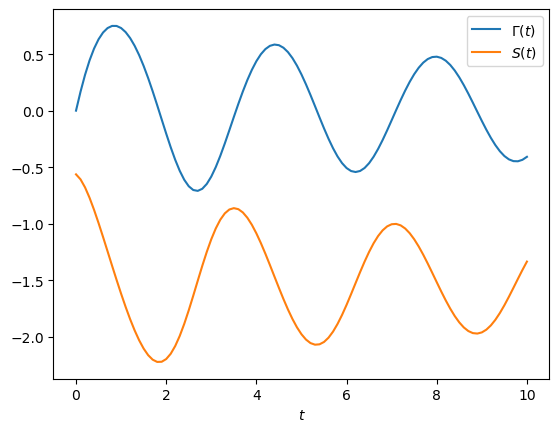

In [5]:
Gamma_values = Gamma(times)
S_values = S(times)

plt.plot(times - ti, Gamma_values, label=r"$\Gamma(t)$")
plt.plot(times - ti, S_values, label=r"$S(t)$")
plt.xlabel(r"$t$")
plt.legend()
plt.show()

To speed up the following calculation by a factor 3-4, we store $\Gamma(t)$ and $S(t)$ as interpolations.

In [6]:
Gamma_int = CubicSpline(times, np.complex128(Gamma_values))
S_int = CubicSpline(times, np.complex128(S_values))

##### Monte-Carlo Simulation

We specify some numerical parameters, i.e., the number of trajectories and whether to use parallel computation. Then we define the Hamiltonian and the jump operator corresponding to the master equation, and the initial state.

In [7]:
nmmc_options = {"map": "parallel",
                "norm_steps": 10}  # options specific to nm_mcsolve
options = {"progress_bar": "enhanced"}  # options shared by all solvers
ntraj = 5500

H = 2 * qt.sigmap() * qt.sigmam()
ops_and_rates = [[qt.sigmam(), qt.coefficient(Gamma_int)]]
psi0 = qt.basis(2, 0)
e_ops = [H]

In analogy with `mcsolve` and the corresponding `MCSolver` class, we may either instantiate a `NonMarkovianMCSolver` object and call its `run` or `start` / `step` methods to run the Monte-Carlo simulation, or make use of the `nm_mcsolve` convenience function.
Here, we construct a `NonMarkovianMCSolver` in order to explicitly verify that the solver ensures that the jump operators satisfy the completeness relation $\sum_n A^\dagger_n A_n \propto 1$.
We can see that a second jump operator is added in order to satisfy this relation.

In [8]:
solver = qt.NonMarkovianMCSolver(qt.QobjEvo([H, S_int]),
                                 ops_and_rates,
                                 options=(options | nmmc_options))

for L in solver.ops:
    print(L, "\n")

completeness_check = sum(L.dag() * L for L in solver.ops)
with qt.CoreOptions(atol=1e-5):
    assert completeness_check == qt.qeye(2)

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=False
Qobj data =
[[0. 0.]
 [1. 0.]] 

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0. 0.]
 [0. 1.]] 



/home/runner/miniconda3/envs/test-environment-v5/lib/python3.12/site-packages/qutip/core/data/expm.py:139: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  return Dense(scipy.linalg.sqrtm(matrix.as_ndarray()))


Finally, we run the Monte-Carlo simulation:

In [9]:
MCSol = solver.run(psi0, tlist=times, ntraj=ntraj, e_ops=e_ops)

 [          0%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.15s / Remaining 00:00:00:14

 [          1%           ] Elapsed 0.15s / Remaining 00:00:00:15

 [          1%           ] Elapsed 0.16s / Remaining 00:00:00:15

 [          1%           ] Elapsed 0.16s / Remaining 00:00:00:15

 [          1%           ] Elapsed 0.17s / Remaining 00:00:00:16

 [          1%           ] Elapsed 0.17s / Remaining 00:00:00:16

 [          1%           ] Elapsed 0.17s / Remaining 00:00:00:17

 [          1%           ] Elapsed 0.18s / Remaining 00:00:00:17

 [          1%           ] Elapsed 0.19s / Remaining 00:00:00:18

 [          1%           ] Elapsed 0.19s / Remaining 00:00:00:18

 [          1%           ] Elapsed 0.19s / Remaining 00:00:00:18

 [          1%           ] Elapsed 0.19s / Remaining 00:00:00:19

 [          1%           ] Elapsed 0.20s / Remaining 00:00:00:19

 [          1%           ] Elapsed 0.21s / Remaining 00:00:00:20

 [          1%           ] Elapsed 0.21s / Remaining 00:00:00:20

 [          1%           ] Elapsed 0.21s / Remaining 00:00:00:20

 [          1%           ] Elapsed 0.22s / Remaining 00:00:00:21

 [          1%           ] Elapsed 0.22s / Remaining 00:00:00:21

 [          1%           ] Elapsed 0.22s / Remaining 00:00:00:22

 [          1%           ] Elapsed 0.23s / Remaining 00:00:00:22

 [          1%           ] Elapsed 0.23s / Remaining 00:00:00:22

 [          1%           ] Elapsed 0.23s / Remaining 00:00:00:23

 [          1%           ] Elapsed 0.24s / Remaining 00:00:00:23

 [          1%           ] Elapsed 0.24s / Remaining 00:00:00:24

 [          1%           ] Elapsed 0.25s / Remaining 00:00:00:24

 [          1%           ] Elapsed 0.25s / Remaining 00:00:00:24

 [          1%           ] Elapsed 0.26s / Remaining 00:00:00:25

 [          1%           ] Elapsed 0.26s / Remaining 00:00:00:25

 [          1%           ] Elapsed 0.26s / Remaining 00:00:00:25

 [          1%           ] Elapsed 0.27s / Remaining 00:00:00:26

 [          1%           ] Elapsed 0.27s / Remaining 00:00:00:27

 [          1%           ] Elapsed 0.28s / Remaining 00:00:00:27

 [          1%           ] Elapsed 0.28s / Remaining 00:00:00:27

 [          1%           ] Elapsed 0.28s / Remaining 00:00:00:28

 [          1%           ] Elapsed 0.29s / Remaining 00:00:00:28

 [          1%           ] Elapsed 0.29s / Remaining 00:00:00:28

 [          1%           ] Elapsed 0.30s / Remaining 00:00:00:29

 [          1%           ] Elapsed 0.30s / Remaining 00:00:00:29

 [          1%           ] Elapsed 0.31s / Remaining 00:00:00:30

 [          1%           ] Elapsed 0.31s / Remaining 00:00:00:30

 [          1%           ] Elapsed 0.31s / Remaining 00:00:00:30

 [          1%           ] Elapsed 0.31s / Remaining 00:00:00:31

 [          1%           ] Elapsed 0.32s / Remaining 00:00:00:31

 [          1%           ] Elapsed 0.33s / Remaining 00:00:00:32

 [          1%           ] Elapsed 0.33s / Remaining 00:00:00:32

 [          1%           ] Elapsed 0.34s / Remaining 00:00:00:33

 [          1%           ] Elapsed 0.34s / Remaining 00:00:00:33

 [          1%           ] Elapsed 0.34s / Remaining 00:00:00:33

 [          1%           ] Elapsed 0.34s / Remaining 00:00:00:34

 [          1%           ] Elapsed 0.35s / Remaining 00:00:00:34

 [          1%           ] Elapsed 0.36s / Remaining 00:00:00:35

 [          1%           ] Elapsed 0.36s / Remaining 00:00:00:35

 [          1%           ] Elapsed 0.36s / Remaining 00:00:00:35

 [          1%           ] Elapsed 0.37s / Remaining 00:00:00:36

 [          1%           ] Elapsed 0.37s / Remaining 00:00:00:36

 [          2%           ] Elapsed 0.37s / Remaining 00:00:00:18

 [          2%           ] Elapsed 0.38s / Remaining 00:00:00:18

 [          2%           ] Elapsed 0.38s / Remaining 00:00:00:18

 [          2%           ] Elapsed 0.39s / Remaining 00:00:00:19

 [          2%           ] Elapsed 0.39s / Remaining 00:00:00:19

 [          2%           ] Elapsed 0.40s / Remaining 00:00:00:19

 [          2%           ] Elapsed 0.40s / Remaining 00:00:00:19

 [          2%           ] Elapsed 0.40s / Remaining 00:00:00:19

 [          2%           ] Elapsed 0.41s / Remaining 00:00:00:19

 [          2%           ] Elapsed 0.41s / Remaining 00:00:00:20

 [          2%           ] Elapsed 0.42s / Remaining 00:00:00:20

 [          2%           ] Elapsed 0.42s / Remaining 00:00:00:20

 [          2%           ] Elapsed 0.42s / Remaining 00:00:00:20

 [          2%           ] Elapsed 0.43s / Remaining 00:00:00:20

 [          2%           ] Elapsed 0.43s / Remaining 00:00:00:21

 [          2%           ] Elapsed 0.44s / Remaining 00:00:00:21

 [          2%           ] Elapsed 0.44s / Remaining 00:00:00:21

 [          2%           ] Elapsed 0.44s / Remaining 00:00:00:21

 [          2%           ] Elapsed 0.45s / Remaining 00:00:00:22

 [          2%           ] Elapsed 0.45s / Remaining 00:00:00:22

 [          2%           ] Elapsed 0.46s / Remaining 00:00:00:22

 [          2%           ] Elapsed 0.46s / Remaining 00:00:00:22

 [          2%           ] Elapsed 0.46s / Remaining 00:00:00:22

 [          2%           ] Elapsed 0.47s / Remaining 00:00:00:22

 [          2%           ] Elapsed 0.47s / Remaining 00:00:00:23

 [          2%           ] Elapsed 0.48s / Remaining 00:00:00:23

 [          2%           ] Elapsed 0.48s / Remaining 00:00:00:23

 [          2%           ] Elapsed 0.48s / Remaining 00:00:00:23

 [          2%           ] Elapsed 0.49s / Remaining 00:00:00:23

 [          2%           ] Elapsed 0.49s / Remaining 00:00:00:24

 [          2%           ] Elapsed 0.49s / Remaining 00:00:00:24

 [          2%           ] Elapsed 0.50s / Remaining 00:00:00:24

 [          2%           ] Elapsed 0.50s / Remaining 00:00:00:24

 [          2%           ] Elapsed 0.51s / Remaining 00:00:00:24

 [          2%           ] Elapsed 0.51s / Remaining 00:00:00:25

 [          2%           ] Elapsed 0.51s / Remaining 00:00:00:25

 [          2%           ] Elapsed 0.52s / Remaining 00:00:00:25

 [          2%           ] Elapsed 0.52s / Remaining 00:00:00:25

 [          2%           ] Elapsed 0.53s / Remaining 00:00:00:25

 [          2%           ] Elapsed 0.53s / Remaining 00:00:00:25

 [          2%           ] Elapsed 0.54s / Remaining 00:00:00:26

 [          2%           ] Elapsed 0.54s / Remaining 00:00:00:26

 [          2%           ] Elapsed 0.54s / Remaining 00:00:00:26

 [          2%           ] Elapsed 0.54s / Remaining 00:00:00:26

 [          2%           ] Elapsed 0.55s / Remaining 00:00:00:26

 [          2%           ] Elapsed 0.56s / Remaining 00:00:00:27

 [          2%           ] Elapsed 0.56s / Remaining 00:00:00:27

 [          2%           ] Elapsed 0.56s / Remaining 00:00:00:27

 [          2%           ] Elapsed 0.56s / Remaining 00:00:00:27

 [          2%           ] Elapsed 0.57s / Remaining 00:00:00:27

 [          2%           ] Elapsed 0.57s / Remaining 00:00:00:28

 [          2%           ] Elapsed 0.58s / Remaining 00:00:00:28

 [          2%           ] Elapsed 0.58s / Remaining 00:00:00:28

 [          2%           ] Elapsed 0.59s / Remaining 00:00:00:28

 [          2%           ] Elapsed 0.59s / Remaining 00:00:00:28

 [*         3%           ] Elapsed 0.60s / Remaining 00:00:00:19

 [*         3%           ] Elapsed 0.60s / Remaining 00:00:00:19

 [*         3%           ] Elapsed 0.60s / Remaining 00:00:00:19

 [*         3%           ] Elapsed 0.61s / Remaining 00:00:00:19

 [*         3%           ] Elapsed 0.61s / Remaining 00:00:00:19

 [*         3%           ] Elapsed 0.61s / Remaining 00:00:00:19

 [*         3%           ] Elapsed 0.62s / Remaining 00:00:00:20

 [*         3%           ] Elapsed 0.62s / Remaining 00:00:00:20

 [*         3%           ] Elapsed 0.63s / Remaining 00:00:00:20

 [*         3%           ] Elapsed 0.63s / Remaining 00:00:00:20

 [*         3%           ] Elapsed 0.64s / Remaining 00:00:00:20

 [*         3%           ] Elapsed 0.64s / Remaining 00:00:00:20

 [*         3%           ] Elapsed 0.64s / Remaining 00:00:00:20

 [*         3%           ] Elapsed 0.65s / Remaining 00:00:00:21

 [*         3%           ] Elapsed 0.65s / Remaining 00:00:00:21

 [*         3%           ] Elapsed 0.66s / Remaining 00:00:00:21

 [*         3%           ] Elapsed 0.66s / Remaining 00:00:00:21

 [*         3%           ] Elapsed 0.67s / Remaining 00:00:00:21

 [*         3%           ] Elapsed 0.67s / Remaining 00:00:00:21

 [*         3%           ] Elapsed 0.67s / Remaining 00:00:00:21

 [*         3%           ] Elapsed 0.68s / Remaining 00:00:00:21

 [*         3%           ] Elapsed 0.68s / Remaining 00:00:00:22

 [*         3%           ] Elapsed 0.69s / Remaining 00:00:00:22

 [*         3%           ] Elapsed 0.69s / Remaining 00:00:00:22

 [*         3%           ] Elapsed 0.70s / Remaining 00:00:00:22

 [*         3%           ] Elapsed 0.70s / Remaining 00:00:00:22

 [*         3%           ] Elapsed 0.70s / Remaining 00:00:00:22

 [*         3%           ] Elapsed 0.71s / Remaining 00:00:00:22

 [*         3%           ] Elapsed 0.71s / Remaining 00:00:00:23

 [*         3%           ] Elapsed 0.72s / Remaining 00:00:00:23

 [*         3%           ] Elapsed 0.72s / Remaining 00:00:00:23

 [*         3%           ] Elapsed 0.72s / Remaining 00:00:00:23

 [*         3%           ] Elapsed 0.73s / Remaining 00:00:00:23

 [*         3%           ] Elapsed 0.73s / Remaining 00:00:00:23

 [*         3%           ] Elapsed 0.74s / Remaining 00:00:00:23

 [*         3%           ] Elapsed 0.74s / Remaining 00:00:00:23

 [*         3%           ] Elapsed 0.74s / Remaining 00:00:00:24

 [*         3%           ] Elapsed 0.75s / Remaining 00:00:00:24

 [*         3%           ] Elapsed 0.75s / Remaining 00:00:00:24

 [*         3%           ] Elapsed 0.76s / Remaining 00:00:00:24

 [*         3%           ] Elapsed 0.76s / Remaining 00:00:00:24

 [*         3%           ] Elapsed 0.76s / Remaining 00:00:00:24

 [*         3%           ] Elapsed 0.77s / Remaining 00:00:00:24

 [*         3%           ] Elapsed 0.77s / Remaining 00:00:00:25

 [*         3%           ] Elapsed 0.78s / Remaining 00:00:00:25

 [*         3%           ] Elapsed 0.78s / Remaining 00:00:00:25

 [*         3%           ] Elapsed 0.79s / Remaining 00:00:00:25

 [*         3%           ] Elapsed 0.79s / Remaining 00:00:00:25

 [*         3%           ] Elapsed 0.79s / Remaining 00:00:00:25

 [*         3%           ] Elapsed 0.79s / Remaining 00:00:00:25

 [*         3%           ] Elapsed 0.80s / Remaining 00:00:00:25

 [*         3%           ] Elapsed 0.81s / Remaining 00:00:00:26

 [*         3%           ] Elapsed 0.81s / Remaining 00:00:00:26

 [*         3%           ] Elapsed 0.81s / Remaining 00:00:00:26

 [*         3%           ] Elapsed 0.82s / Remaining 00:00:00:26

 [*         4%           ] Elapsed 0.82s / Remaining 00:00:00:19

 [*         4%           ] Elapsed 0.82s / Remaining 00:00:00:19

 [*         4%           ] Elapsed 0.83s / Remaining 00:00:00:19

 [*         4%           ] Elapsed 0.84s / Remaining 00:00:00:20

 [*         4%           ] Elapsed 0.84s / Remaining 00:00:00:20

 [*         4%           ] Elapsed 0.84s / Remaining 00:00:00:20

 [*         4%           ] Elapsed 0.84s / Remaining 00:00:00:20

 [*         4%           ] Elapsed 0.85s / Remaining 00:00:00:20

 [*         4%           ] Elapsed 0.85s / Remaining 00:00:00:20

 [*         4%           ] Elapsed 0.86s / Remaining 00:00:00:20

 [*         4%           ] Elapsed 0.86s / Remaining 00:00:00:20

 [*         4%           ] Elapsed 0.87s / Remaining 00:00:00:20

 [*         4%           ] Elapsed 0.87s / Remaining 00:00:00:20

 [*         4%           ] Elapsed 0.87s / Remaining 00:00:00:20

 [*         4%           ] Elapsed 0.88s / Remaining 00:00:00:21

 [*         4%           ] Elapsed 0.88s / Remaining 00:00:00:21

 [*         4%           ] Elapsed 0.89s / Remaining 00:00:00:21

 [*         4%           ] Elapsed 0.89s / Remaining 00:00:00:21

 [*         4%           ] Elapsed 0.89s / Remaining 00:00:00:21

 [*         4%           ] Elapsed 0.90s / Remaining 00:00:00:21

 [*         4%           ] Elapsed 0.90s / Remaining 00:00:00:21

 [*         4%           ] Elapsed 0.91s / Remaining 00:00:00:21

 [*         4%           ] Elapsed 0.91s / Remaining 00:00:00:21

 [*         4%           ] Elapsed 0.91s / Remaining 00:00:00:21

 [*         4%           ] Elapsed 0.92s / Remaining 00:00:00:22

 [*         4%           ] Elapsed 0.92s / Remaining 00:00:00:22

 [*         4%           ] Elapsed 0.93s / Remaining 00:00:00:22

 [*         4%           ] Elapsed 0.93s / Remaining 00:00:00:22

 [*         4%           ] Elapsed 0.94s / Remaining 00:00:00:22

 [*         4%           ] Elapsed 0.94s / Remaining 00:00:00:22

 [*         4%           ] Elapsed 0.94s / Remaining 00:00:00:22

 [*         4%           ] Elapsed 0.95s / Remaining 00:00:00:22

 [*         4%           ] Elapsed 0.95s / Remaining 00:00:00:22

 [*         4%           ] Elapsed 0.96s / Remaining 00:00:00:22

 [*         4%           ] Elapsed 0.96s / Remaining 00:00:00:23

 [*         4%           ] Elapsed 0.96s / Remaining 00:00:00:23

 [*         4%           ] Elapsed 0.97s / Remaining 00:00:00:23

 [*         4%           ] Elapsed 0.97s / Remaining 00:00:00:23

 [*         4%           ] Elapsed 0.98s / Remaining 00:00:00:23

 [*         4%           ] Elapsed 0.98s / Remaining 00:00:00:23

 [*         4%           ] Elapsed 0.99s / Remaining 00:00:00:23

 [*         4%           ] Elapsed 0.99s / Remaining 00:00:00:23

 [*         4%           ] Elapsed 1.00s / Remaining 00:00:00:23

 [*         4%           ] Elapsed 1.00s / Remaining 00:00:00:23

 [*         4%           ] Elapsed 1.01s / Remaining 00:00:00:24

 [*         4%           ] Elapsed 1.01s / Remaining 00:00:00:24

 [*         4%           ] Elapsed 1.01s / Remaining 00:00:00:24

 [*         4%           ] Elapsed 1.01s / Remaining 00:00:00:24

 [*         4%           ] Elapsed 1.02s / Remaining 00:00:00:24

 [*         4%           ] Elapsed 1.02s / Remaining 00:00:00:24

 [*         4%           ] Elapsed 1.03s / Remaining 00:00:00:24

 [*         4%           ] Elapsed 1.03s / Remaining 00:00:00:24

 [*         4%           ] Elapsed 1.04s / Remaining 00:00:00:24

 [*         4%           ] Elapsed 1.04s / Remaining 00:00:00:25

 [*         4%           ] Elapsed 1.05s / Remaining 00:00:00:25

 [*         5%           ] Elapsed 1.05s / Remaining 00:00:00:19

 [*         5%           ] Elapsed 1.06s / Remaining 00:00:00:20

 [*         5%           ] Elapsed 1.06s / Remaining 00:00:00:20

 [*         5%           ] Elapsed 1.06s / Remaining 00:00:00:20

 [*         5%           ] Elapsed 1.07s / Remaining 00:00:00:20

 [*         5%           ] Elapsed 1.07s / Remaining 00:00:00:20

 [*         5%           ] Elapsed 1.08s / Remaining 00:00:00:20

 [*         5%           ] Elapsed 1.08s / Remaining 00:00:00:20

 [*         5%           ] Elapsed 1.08s / Remaining 00:00:00:20

 [*         5%           ] Elapsed 1.09s / Remaining 00:00:00:20

 [*         5%           ] Elapsed 1.09s / Remaining 00:00:00:20

 [*         5%           ] Elapsed 1.10s / Remaining 00:00:00:20

 [*         5%           ] Elapsed 1.10s / Remaining 00:00:00:20

 [*         5%           ] Elapsed 1.11s / Remaining 00:00:00:20

 [*         5%           ] Elapsed 1.11s / Remaining 00:00:00:21

 [*         5%           ] Elapsed 1.11s / Remaining 00:00:00:21

 [*         5%           ] Elapsed 1.12s / Remaining 00:00:00:21

 [*         5%           ] Elapsed 1.12s / Remaining 00:00:00:21

 [*         5%           ] Elapsed 1.12s / Remaining 00:00:00:21

 [*         5%           ] Elapsed 1.13s / Remaining 00:00:00:21

 [*         5%           ] Elapsed 1.13s / Remaining 00:00:00:21

 [*         5%           ] Elapsed 1.14s / Remaining 00:00:00:21

 [*         5%           ] Elapsed 1.14s / Remaining 00:00:00:21

 [*         5%           ] Elapsed 1.14s / Remaining 00:00:00:21

 [*         5%           ] Elapsed 1.15s / Remaining 00:00:00:21

 [*         5%           ] Elapsed 1.16s / Remaining 00:00:00:21

 [*         5%           ] Elapsed 1.16s / Remaining 00:00:00:22

 [*         5%           ] Elapsed 1.16s / Remaining 00:00:00:22

 [*         5%           ] Elapsed 1.16s / Remaining 00:00:00:22

 [*         5%           ] Elapsed 1.17s / Remaining 00:00:00:22

 [*         5%           ] Elapsed 1.17s / Remaining 00:00:00:22

 [*         5%           ] Elapsed 1.18s / Remaining 00:00:00:22

 [*         5%           ] Elapsed 1.18s / Remaining 00:00:00:22

 [*         5%           ] Elapsed 1.19s / Remaining 00:00:00:22

 [*         5%           ] Elapsed 1.19s / Remaining 00:00:00:22

 [*         5%           ] Elapsed 1.19s / Remaining 00:00:00:22

 [*         5%           ] Elapsed 1.19s / Remaining 00:00:00:22

 [*         5%           ] Elapsed 1.20s / Remaining 00:00:00:22

 [*         5%           ] Elapsed 1.21s / Remaining 00:00:00:22

 [*         5%           ] Elapsed 1.21s / Remaining 00:00:00:22

 [*         5%           ] Elapsed 1.21s / Remaining 00:00:00:23

 [*         5%           ] Elapsed 1.22s / Remaining 00:00:00:23

 [*         5%           ] Elapsed 1.22s / Remaining 00:00:00:23

 [*         5%           ] Elapsed 1.23s / Remaining 00:00:00:23

 [*         5%           ] Elapsed 1.23s / Remaining 00:00:00:23

 [*         5%           ] Elapsed 1.23s / Remaining 00:00:00:23

 [*         5%           ] Elapsed 1.24s / Remaining 00:00:00:23

 [*         5%           ] Elapsed 1.24s / Remaining 00:00:00:23

 [*         5%           ] Elapsed 1.25s / Remaining 00:00:00:23

 [*         5%           ] Elapsed 1.25s / Remaining 00:00:00:23

 [*         5%           ] Elapsed 1.25s / Remaining 00:00:00:23

 [*         5%           ] Elapsed 1.26s / Remaining 00:00:00:23

 [*         5%           ] Elapsed 1.26s / Remaining 00:00:00:23

 [*         5%           ] Elapsed 1.26s / Remaining 00:00:00:24

 [*         5%           ] Elapsed 1.27s / Remaining 00:00:00:24

 [*         6%           ] Elapsed 1.28s / Remaining 00:00:00:20

 [*         6%           ] Elapsed 1.28s / Remaining 00:00:00:20

 [*         6%           ] Elapsed 1.28s / Remaining 00:00:00:20

 [*         6%           ] Elapsed 1.28s / Remaining 00:00:00:20

 [*         6%           ] Elapsed 1.29s / Remaining 00:00:00:20

 [*         6%           ] Elapsed 1.29s / Remaining 00:00:00:20

 [*         6%           ] Elapsed 1.30s / Remaining 00:00:00:20

 [*         6%           ] Elapsed 1.30s / Remaining 00:00:00:20

 [*         6%           ] Elapsed 1.31s / Remaining 00:00:00:20

 [*         6%           ] Elapsed 1.31s / Remaining 00:00:00:20

 [*         6%           ] Elapsed 1.32s / Remaining 00:00:00:20

 [*         6%           ] Elapsed 1.32s / Remaining 00:00:00:20

 [*         6%           ] Elapsed 1.32s / Remaining 00:00:00:20

 [*         6%           ] Elapsed 1.33s / Remaining 00:00:00:20

 [*         6%           ] Elapsed 1.33s / Remaining 00:00:00:20

 [*         6%           ] Elapsed 1.33s / Remaining 00:00:00:20

 [*         6%           ] Elapsed 1.34s / Remaining 00:00:00:20

 [*         6%           ] Elapsed 1.34s / Remaining 00:00:00:21

 [*         6%           ] Elapsed 1.35s / Remaining 00:00:00:21

 [*         6%           ] Elapsed 1.35s / Remaining 00:00:00:21

 [*         6%           ] Elapsed 1.36s / Remaining 00:00:00:21

 [*         6%           ] Elapsed 1.36s / Remaining 00:00:00:21

 [*         6%           ] Elapsed 1.36s / Remaining 00:00:00:21

 [*         6%           ] Elapsed 1.37s / Remaining 00:00:00:21

 [*         6%           ] Elapsed 1.37s / Remaining 00:00:00:21

 [*         6%           ] Elapsed 1.37s / Remaining 00:00:00:21

 [*         6%           ] Elapsed 1.38s / Remaining 00:00:00:21

 [*         6%           ] Elapsed 1.39s / Remaining 00:00:00:21

 [*         6%           ] Elapsed 1.39s / Remaining 00:00:00:21

 [*         6%           ] Elapsed 1.39s / Remaining 00:00:00:21

 [*         6%           ] Elapsed 1.40s / Remaining 00:00:00:21

 [*         6%           ] Elapsed 1.41s / Remaining 00:00:00:22

 [*         6%           ] Elapsed 1.41s / Remaining 00:00:00:22

 [*         6%           ] Elapsed 1.41s / Remaining 00:00:00:22

 [*         6%           ] Elapsed 1.41s / Remaining 00:00:00:22

 [*         6%           ] Elapsed 1.42s / Remaining 00:00:00:22

 [*         6%           ] Elapsed 1.42s / Remaining 00:00:00:22

 [*         6%           ] Elapsed 1.43s / Remaining 00:00:00:22

 [*         6%           ] Elapsed 1.43s / Remaining 00:00:00:22

 [*         6%           ] Elapsed 1.44s / Remaining 00:00:00:22

 [*         6%           ] Elapsed 1.44s / Remaining 00:00:00:22

 [*         6%           ] Elapsed 1.44s / Remaining 00:00:00:22

 [*         6%           ] Elapsed 1.45s / Remaining 00:00:00:22

 [*         6%           ] Elapsed 1.45s / Remaining 00:00:00:22

 [*         6%           ] Elapsed 1.46s / Remaining 00:00:00:22

 [*         6%           ] Elapsed 1.46s / Remaining 00:00:00:22

 [*         6%           ] Elapsed 1.46s / Remaining 00:00:00:22

 [*         6%           ] Elapsed 1.47s / Remaining 00:00:00:23

 [*         6%           ] Elapsed 1.47s / Remaining 00:00:00:23

 [*         6%           ] Elapsed 1.48s / Remaining 00:00:00:23

 [*         6%           ] Elapsed 1.48s / Remaining 00:00:00:23

 [*         6%           ] Elapsed 1.48s / Remaining 00:00:00:23

 [*         6%           ] Elapsed 1.49s / Remaining 00:00:00:23

 [*         6%           ] Elapsed 1.49s / Remaining 00:00:00:23

 [*         6%           ] Elapsed 1.50s / Remaining 00:00:00:23

 [**        7%           ] Elapsed 1.50s / Remaining 00:00:00:19

 [**        7%           ] Elapsed 1.51s / Remaining 00:00:00:19

 [**        7%           ] Elapsed 1.51s / Remaining 00:00:00:20

 [**        7%           ] Elapsed 1.52s / Remaining 00:00:00:20

 [**        7%           ] Elapsed 1.52s / Remaining 00:00:00:20

 [**        7%           ] Elapsed 1.52s / Remaining 00:00:00:20

 [**        7%           ] Elapsed 1.53s / Remaining 00:00:00:20

 [**        7%           ] Elapsed 1.53s / Remaining 00:00:00:20

 [**        7%           ] Elapsed 1.54s / Remaining 00:00:00:20

 [**        7%           ] Elapsed 1.54s / Remaining 00:00:00:20

 [**        7%           ] Elapsed 1.54s / Remaining 00:00:00:20

 [**        7%           ] Elapsed 1.55s / Remaining 00:00:00:20

 [**        7%           ] Elapsed 1.56s / Remaining 00:00:00:20

 [**        7%           ] Elapsed 1.56s / Remaining 00:00:00:20

 [**        7%           ] Elapsed 1.56s / Remaining 00:00:00:20

 [**        7%           ] Elapsed 1.57s / Remaining 00:00:00:20

 [**        7%           ] Elapsed 1.57s / Remaining 00:00:00:20

 [**        7%           ] Elapsed 1.57s / Remaining 00:00:00:20

 [**        7%           ] Elapsed 1.58s / Remaining 00:00:00:20

 [**        7%           ] Elapsed 1.58s / Remaining 00:00:00:21

 [**        7%           ] Elapsed 1.58s / Remaining 00:00:00:21

 [**        7%           ] Elapsed 1.59s / Remaining 00:00:00:21

 [**        7%           ] Elapsed 1.59s / Remaining 00:00:00:21

 [**        7%           ] Elapsed 1.60s / Remaining 00:00:00:21

 [**        7%           ] Elapsed 1.60s / Remaining 00:00:00:21

 [**        7%           ] Elapsed 1.60s / Remaining 00:00:00:21

 [**        7%           ] Elapsed 1.61s / Remaining 00:00:00:21

 [**        7%           ] Elapsed 1.61s / Remaining 00:00:00:21

 [**        7%           ] Elapsed 1.62s / Remaining 00:00:00:21

 [**        7%           ] Elapsed 1.62s / Remaining 00:00:00:21

 [**        7%           ] Elapsed 1.62s / Remaining 00:00:00:21

 [**        7%           ] Elapsed 1.63s / Remaining 00:00:00:21

 [**        7%           ] Elapsed 1.63s / Remaining 00:00:00:21

 [**        7%           ] Elapsed 1.64s / Remaining 00:00:00:21

 [**        7%           ] Elapsed 1.64s / Remaining 00:00:00:21

 [**        7%           ] Elapsed 1.65s / Remaining 00:00:00:21

 [**        7%           ] Elapsed 1.65s / Remaining 00:00:00:21

 [**        7%           ] Elapsed 1.65s / Remaining 00:00:00:21

 [**        7%           ] Elapsed 1.66s / Remaining 00:00:00:22

 [**        7%           ] Elapsed 1.66s / Remaining 00:00:00:22

 [**        7%           ] Elapsed 1.67s / Remaining 00:00:00:22

 [**        7%           ] Elapsed 1.67s / Remaining 00:00:00:22

 [**        7%           ] Elapsed 1.67s / Remaining 00:00:00:22

 [**        7%           ] Elapsed 1.68s / Remaining 00:00:00:22

 [**        7%           ] Elapsed 1.68s / Remaining 00:00:00:22

 [**        7%           ] Elapsed 1.69s / Remaining 00:00:00:22

 [**        7%           ] Elapsed 1.69s / Remaining 00:00:00:22

 [**        7%           ] Elapsed 1.69s / Remaining 00:00:00:22

 [**        7%           ] Elapsed 1.70s / Remaining 00:00:00:22

 [**        7%           ] Elapsed 1.70s / Remaining 00:00:00:22

 [**        7%           ] Elapsed 1.71s / Remaining 00:00:00:22

 [**        7%           ] Elapsed 1.71s / Remaining 00:00:00:22

 [**        7%           ] Elapsed 1.71s / Remaining 00:00:00:22

 [**        7%           ] Elapsed 1.72s / Remaining 00:00:00:22

 [**        7%           ] Elapsed 1.72s / Remaining 00:00:00:22

 [**        8%           ] Elapsed 1.73s / Remaining 00:00:00:19

 [**        8%           ] Elapsed 1.73s / Remaining 00:00:00:19

 [**        8%           ] Elapsed 1.74s / Remaining 00:00:00:19

 [**        8%           ] Elapsed 1.74s / Remaining 00:00:00:20

 [**        8%           ] Elapsed 1.75s / Remaining 00:00:00:20

 [**        8%           ] Elapsed 1.75s / Remaining 00:00:00:20

 [**        8%           ] Elapsed 1.75s / Remaining 00:00:00:20

 [**        8%           ] Elapsed 1.76s / Remaining 00:00:00:20

 [**        8%           ] Elapsed 1.76s / Remaining 00:00:00:20

 [**        8%           ] Elapsed 1.76s / Remaining 00:00:00:20

 [**        8%           ] Elapsed 1.77s / Remaining 00:00:00:20

 [**        8%           ] Elapsed 1.77s / Remaining 00:00:00:20

 [**        8%           ] Elapsed 1.78s / Remaining 00:00:00:20

 [**        8%           ] Elapsed 1.78s / Remaining 00:00:00:20

 [**        8%           ] Elapsed 1.78s / Remaining 00:00:00:20

 [**        8%           ] Elapsed 1.79s / Remaining 00:00:00:20

 [**        8%           ] Elapsed 1.79s / Remaining 00:00:00:20

 [**        8%           ] Elapsed 1.80s / Remaining 00:00:00:20

 [**        8%           ] Elapsed 1.80s / Remaining 00:00:00:20

 [**        8%           ] Elapsed 1.80s / Remaining 00:00:00:20

 [**        8%           ] Elapsed 1.81s / Remaining 00:00:00:20

 [**        8%           ] Elapsed 1.81s / Remaining 00:00:00:20

 [**        8%           ] Elapsed 1.82s / Remaining 00:00:00:20

 [**        8%           ] Elapsed 1.82s / Remaining 00:00:00:20

 [**        8%           ] Elapsed 1.82s / Remaining 00:00:00:20

 [**        8%           ] Elapsed 1.83s / Remaining 00:00:00:21

 [**        8%           ] Elapsed 1.83s / Remaining 00:00:00:21

 [**        8%           ] Elapsed 1.84s / Remaining 00:00:00:21

 [**        8%           ] Elapsed 1.84s / Remaining 00:00:00:21

 [**        8%           ] Elapsed 1.84s / Remaining 00:00:00:21

 [**        8%           ] Elapsed 1.84s / Remaining 00:00:00:21

 [**        8%           ] Elapsed 1.85s / Remaining 00:00:00:21

 [**        8%           ] Elapsed 1.86s / Remaining 00:00:00:21

 [**        8%           ] Elapsed 1.86s / Remaining 00:00:00:21

 [**        8%           ] Elapsed 1.86s / Remaining 00:00:00:21

 [**        8%           ] Elapsed 1.86s / Remaining 00:00:00:21

 [**        8%           ] Elapsed 1.88s / Remaining 00:00:00:21

 [**        8%           ] Elapsed 1.88s / Remaining 00:00:00:21

 [**        8%           ] Elapsed 1.88s / Remaining 00:00:00:21

 [**        8%           ] Elapsed 1.88s / Remaining 00:00:00:21

 [**        8%           ] Elapsed 1.89s / Remaining 00:00:00:21

 [**        8%           ] Elapsed 1.89s / Remaining 00:00:00:21

 [**        8%           ] Elapsed 1.90s / Remaining 00:00:00:21

 [**        8%           ] Elapsed 1.90s / Remaining 00:00:00:21

 [**        8%           ] Elapsed 1.90s / Remaining 00:00:00:21

 [**        8%           ] Elapsed 1.91s / Remaining 00:00:00:21

 [**        8%           ] Elapsed 1.91s / Remaining 00:00:00:22

 [**        8%           ] Elapsed 1.92s / Remaining 00:00:00:22

 [**        8%           ] Elapsed 1.92s / Remaining 00:00:00:22

 [**        8%           ] Elapsed 1.92s / Remaining 00:00:00:22

 [**        8%           ] Elapsed 1.93s / Remaining 00:00:00:22

 [**        8%           ] Elapsed 1.93s / Remaining 00:00:00:22

 [**        8%           ] Elapsed 1.94s / Remaining 00:00:00:22

 [**        8%           ] Elapsed 1.94s / Remaining 00:00:00:22

 [**        8%           ] Elapsed 1.94s / Remaining 00:00:00:22

 [**        9%           ] Elapsed 1.95s / Remaining 00:00:00:19

 [**        9%           ] Elapsed 1.95s / Remaining 00:00:00:19

 [**        9%           ] Elapsed 1.96s / Remaining 00:00:00:19

 [**        9%           ] Elapsed 1.96s / Remaining 00:00:00:19

 [**        9%           ] Elapsed 1.97s / Remaining 00:00:00:19

 [**        9%           ] Elapsed 1.97s / Remaining 00:00:00:19

 [**        9%           ] Elapsed 1.98s / Remaining 00:00:00:19

 [**        9%           ] Elapsed 1.98s / Remaining 00:00:00:19

 [**        9%           ] Elapsed 1.98s / Remaining 00:00:00:20

 [**        9%           ] Elapsed 1.99s / Remaining 00:00:00:20

 [**        9%           ] Elapsed 1.99s / Remaining 00:00:00:20

 [**        9%           ] Elapsed 1.99s / Remaining 00:00:00:20

 [**        9%           ] Elapsed 2.00s / Remaining 00:00:00:20

 [**        9%           ] Elapsed 2.01s / Remaining 00:00:00:20

 [**        9%           ] Elapsed 2.01s / Remaining 00:00:00:20

 [**        9%           ] Elapsed 2.01s / Remaining 00:00:00:20

 [**        9%           ] Elapsed 2.01s / Remaining 00:00:00:20

 [**        9%           ] Elapsed 2.02s / Remaining 00:00:00:20

 [**        9%           ] Elapsed 2.03s / Remaining 00:00:00:20

 [**        9%           ] Elapsed 2.03s / Remaining 00:00:00:20

 [**        9%           ] Elapsed 2.03s / Remaining 00:00:00:20

 [**        9%           ] Elapsed 2.04s / Remaining 00:00:00:20

 [**        9%           ] Elapsed 2.04s / Remaining 00:00:00:20

 [**        9%           ] Elapsed 2.04s / Remaining 00:00:00:20

 [**        9%           ] Elapsed 2.05s / Remaining 00:00:00:20

 [**        9%           ] Elapsed 2.05s / Remaining 00:00:00:20

 [**        9%           ] Elapsed 2.06s / Remaining 00:00:00:20

 [**        9%           ] Elapsed 2.06s / Remaining 00:00:00:20

 [**        9%           ] Elapsed 2.06s / Remaining 00:00:00:20

 [**        9%           ] Elapsed 2.07s / Remaining 00:00:00:20

 [**        9%           ] Elapsed 2.07s / Remaining 00:00:00:20

 [**        9%           ] Elapsed 2.08s / Remaining 00:00:00:20

 [**        9%           ] Elapsed 2.08s / Remaining 00:00:00:21

 [**        9%           ] Elapsed 2.08s / Remaining 00:00:00:21

 [**        9%           ] Elapsed 2.09s / Remaining 00:00:00:21

 [**        9%           ] Elapsed 2.10s / Remaining 00:00:00:21

 [**        9%           ] Elapsed 2.10s / Remaining 00:00:00:21

 [**        9%           ] Elapsed 2.10s / Remaining 00:00:00:21

 [**        9%           ] Elapsed 2.10s / Remaining 00:00:00:21

 [**        9%           ] Elapsed 2.11s / Remaining 00:00:00:21

 [**        9%           ] Elapsed 2.11s / Remaining 00:00:00:21

 [**        9%           ] Elapsed 2.12s / Remaining 00:00:00:21

 [**        9%           ] Elapsed 2.12s / Remaining 00:00:00:21

 [**        9%           ] Elapsed 2.12s / Remaining 00:00:00:21

 [**        9%           ] Elapsed 2.13s / Remaining 00:00:00:21

 [**        9%           ] Elapsed 2.13s / Remaining 00:00:00:21

 [**        9%           ] Elapsed 2.14s / Remaining 00:00:00:21

 [**        9%           ] Elapsed 2.14s / Remaining 00:00:00:21

 [**        9%           ] Elapsed 2.15s / Remaining 00:00:00:21

 [**        9%           ] Elapsed 2.15s / Remaining 00:00:00:21

 [**        9%           ] Elapsed 2.15s / Remaining 00:00:00:21

 [**        9%           ] Elapsed 2.16s / Remaining 00:00:00:21

 [**        9%           ] Elapsed 2.16s / Remaining 00:00:00:21

 [**        9%           ] Elapsed 2.17s / Remaining 00:00:00:21

 [**        9%           ] Elapsed 2.17s / Remaining 00:00:00:21

 [**       10%           ] Elapsed 2.17s / Remaining 00:00:00:19

 [**       10%           ] Elapsed 2.18s / Remaining 00:00:00:19

 [**       10%           ] Elapsed 2.18s / Remaining 00:00:00:19

 [**       10%           ] Elapsed 2.19s / Remaining 00:00:00:19

 [**       10%           ] Elapsed 2.19s / Remaining 00:00:00:19

 [**       10%           ] Elapsed 2.19s / Remaining 00:00:00:19

 [**       10%           ] Elapsed 2.20s / Remaining 00:00:00:19

 [**       10%           ] Elapsed 2.20s / Remaining 00:00:00:19

 [**       10%           ] Elapsed 2.21s / Remaining 00:00:00:19

 [**       10%           ] Elapsed 2.21s / Remaining 00:00:00:19

 [**       10%           ] Elapsed 2.22s / Remaining 00:00:00:19

 [**       10%           ] Elapsed 2.22s / Remaining 00:00:00:19

 [**       10%           ] Elapsed 2.22s / Remaining 00:00:00:19

 [**       10%           ] Elapsed 2.22s / Remaining 00:00:00:20

 [**       10%           ] Elapsed 2.23s / Remaining 00:00:00:20

 [**       10%           ] Elapsed 2.24s / Remaining 00:00:00:20

 [**       10%           ] Elapsed 2.24s / Remaining 00:00:00:20

 [**       10%           ] Elapsed 2.24s / Remaining 00:00:00:20

 [**       10%           ] Elapsed 2.25s / Remaining 00:00:00:20

 [**       10%           ] Elapsed 2.25s / Remaining 00:00:00:20

 [**       10%           ] Elapsed 2.25s / Remaining 00:00:00:20

 [**       10%           ] Elapsed 2.26s / Remaining 00:00:00:20

 [**       10%           ] Elapsed 2.26s / Remaining 00:00:00:20

 [**       10%           ] Elapsed 2.26s / Remaining 00:00:00:20

 [**       10%           ] Elapsed 2.27s / Remaining 00:00:00:20

 [**       10%           ] Elapsed 2.27s / Remaining 00:00:00:20

 [**       10%           ] Elapsed 2.28s / Remaining 00:00:00:20

 [**       10%           ] Elapsed 2.28s / Remaining 00:00:00:20

 [**       10%           ] Elapsed 2.29s / Remaining 00:00:00:20

 [**       10%           ] Elapsed 2.29s / Remaining 00:00:00:20

 [**       10%           ] Elapsed 2.29s / Remaining 00:00:00:20

 [**       10%           ] Elapsed 2.29s / Remaining 00:00:00:20

 [**       10%           ] Elapsed 2.30s / Remaining 00:00:00:20

 [**       10%           ] Elapsed 2.30s / Remaining 00:00:00:20

 [**       10%           ] Elapsed 2.31s / Remaining 00:00:00:20

 [**       10%           ] Elapsed 2.31s / Remaining 00:00:00:20

 [**       10%           ] Elapsed 2.32s / Remaining 00:00:00:20

 [**       10%           ] Elapsed 2.32s / Remaining 00:00:00:20

 [**       10%           ] Elapsed 2.32s / Remaining 00:00:00:20

 [**       10%           ] Elapsed 2.33s / Remaining 00:00:00:20

 [**       10%           ] Elapsed 2.33s / Remaining 00:00:00:20

 [**       10%           ] Elapsed 2.34s / Remaining 00:00:00:21

 [**       10%           ] Elapsed 2.34s / Remaining 00:00:00:21

 [**       10%           ] Elapsed 2.34s / Remaining 00:00:00:21

 [**       10%           ] Elapsed 2.35s / Remaining 00:00:00:21

 [**       10%           ] Elapsed 2.35s / Remaining 00:00:00:21

 [**       10%           ] Elapsed 2.36s / Remaining 00:00:00:21

 [**       10%           ] Elapsed 2.36s / Remaining 00:00:00:21

 [**       10%           ] Elapsed 2.36s / Remaining 00:00:00:21

 [**       10%           ] Elapsed 2.37s / Remaining 00:00:00:21

 [**       10%           ] Elapsed 2.37s / Remaining 00:00:00:21

 [**       10%           ] Elapsed 2.38s / Remaining 00:00:00:21

 [**       10%           ] Elapsed 2.38s / Remaining 00:00:00:21

 [**       10%           ] Elapsed 2.39s / Remaining 00:00:00:21

 [**       10%           ] Elapsed 2.39s / Remaining 00:00:00:21

 [***      11%           ] Elapsed 2.39s / Remaining 00:00:00:19

 [***      11%           ] Elapsed 2.40s / Remaining 00:00:00:19

 [***      11%           ] Elapsed 2.40s / Remaining 00:00:00:19

 [***      11%           ] Elapsed 2.41s / Remaining 00:00:00:19

 [***      11%           ] Elapsed 2.41s / Remaining 00:00:00:19

 [***      11%           ] Elapsed 2.41s / Remaining 00:00:00:19

 [***      11%           ] Elapsed 2.42s / Remaining 00:00:00:19

 [***      11%           ] Elapsed 2.42s / Remaining 00:00:00:19

 [***      11%           ] Elapsed 2.43s / Remaining 00:00:00:19

 [***      11%           ] Elapsed 2.43s / Remaining 00:00:00:19

 [***      11%           ] Elapsed 2.43s / Remaining 00:00:00:19

 [***      11%           ] Elapsed 2.44s / Remaining 00:00:00:19

 [***      11%           ] Elapsed 2.44s / Remaining 00:00:00:19

 [***      11%           ] Elapsed 2.44s / Remaining 00:00:00:19

 [***      11%           ] Elapsed 2.45s / Remaining 00:00:00:19

 [***      11%           ] Elapsed 2.45s / Remaining 00:00:00:19

 [***      11%           ] Elapsed 2.46s / Remaining 00:00:00:19

 [***      11%           ] Elapsed 2.46s / Remaining 00:00:00:19

 [***      11%           ] Elapsed 2.46s / Remaining 00:00:00:19

 [***      11%           ] Elapsed 2.47s / Remaining 00:00:00:19

 [***      11%           ] Elapsed 2.47s / Remaining 00:00:00:20

 [***      11%           ] Elapsed 2.47s / Remaining 00:00:00:20

 [***      11%           ] Elapsed 2.48s / Remaining 00:00:00:20

 [***      11%           ] Elapsed 2.48s / Remaining 00:00:00:20

 [***      11%           ] Elapsed 2.49s / Remaining 00:00:00:20

 [***      11%           ] Elapsed 2.49s / Remaining 00:00:00:20

 [***      11%           ] Elapsed 2.49s / Remaining 00:00:00:20

 [***      11%           ] Elapsed 2.50s / Remaining 00:00:00:20

 [***      11%           ] Elapsed 2.50s / Remaining 00:00:00:20

 [***      11%           ] Elapsed 2.51s / Remaining 00:00:00:20

 [***      11%           ] Elapsed 2.51s / Remaining 00:00:00:20

 [***      11%           ] Elapsed 2.51s / Remaining 00:00:00:20

 [***      11%           ] Elapsed 2.52s / Remaining 00:00:00:20

 [***      11%           ] Elapsed 2.52s / Remaining 00:00:00:20

 [***      11%           ] Elapsed 2.53s / Remaining 00:00:00:20

 [***      11%           ] Elapsed 2.53s / Remaining 00:00:00:20

 [***      11%           ] Elapsed 2.54s / Remaining 00:00:00:20

 [***      11%           ] Elapsed 2.54s / Remaining 00:00:00:20

 [***      11%           ] Elapsed 2.54s / Remaining 00:00:00:20

 [***      11%           ] Elapsed 2.55s / Remaining 00:00:00:20

 [***      11%           ] Elapsed 2.55s / Remaining 00:00:00:20

 [***      11%           ] Elapsed 2.56s / Remaining 00:00:00:20

 [***      11%           ] Elapsed 2.56s / Remaining 00:00:00:20

 [***      11%           ] Elapsed 2.56s / Remaining 00:00:00:20

 [***      11%           ] Elapsed 2.57s / Remaining 00:00:00:20

 [***      11%           ] Elapsed 2.57s / Remaining 00:00:00:20

 [***      11%           ] Elapsed 2.58s / Remaining 00:00:00:20

 [***      11%           ] Elapsed 2.58s / Remaining 00:00:00:20

 [***      11%           ] Elapsed 2.59s / Remaining 00:00:00:20

 [***      11%           ] Elapsed 2.59s / Remaining 00:00:00:20

 [***      11%           ] Elapsed 2.59s / Remaining 00:00:00:20

 [***      11%           ] Elapsed 2.60s / Remaining 00:00:00:21

 [***      11%           ] Elapsed 2.60s / Remaining 00:00:00:21

 [***      11%           ] Elapsed 2.61s / Remaining 00:00:00:21

 [***      11%           ] Elapsed 2.61s / Remaining 00:00:00:21

 [***      12%           ] Elapsed 2.61s / Remaining 00:00:00:19

 [***      12%           ] Elapsed 2.62s / Remaining 00:00:00:19

 [***      12%           ] Elapsed 2.62s / Remaining 00:00:00:19

 [***      12%           ] Elapsed 2.63s / Remaining 00:00:00:19

 [***      12%           ] Elapsed 2.63s / Remaining 00:00:00:19

 [***      12%           ] Elapsed 2.63s / Remaining 00:00:00:19

 [***      12%           ] Elapsed 2.64s / Remaining 00:00:00:19

 [***      12%           ] Elapsed 2.64s / Remaining 00:00:00:19

 [***      12%           ] Elapsed 2.65s / Remaining 00:00:00:19

 [***      12%           ] Elapsed 2.65s / Remaining 00:00:00:19

 [***      12%           ] Elapsed 2.66s / Remaining 00:00:00:19

 [***      12%           ] Elapsed 2.66s / Remaining 00:00:00:19

 [***      12%           ] Elapsed 2.66s / Remaining 00:00:00:19

 [***      12%           ] Elapsed 2.67s / Remaining 00:00:00:19

 [***      12%           ] Elapsed 2.67s / Remaining 00:00:00:19

 [***      12%           ] Elapsed 2.67s / Remaining 00:00:00:19

 [***      12%           ] Elapsed 2.68s / Remaining 00:00:00:19

 [***      12%           ] Elapsed 2.68s / Remaining 00:00:00:19

 [***      12%           ] Elapsed 2.69s / Remaining 00:00:00:19

 [***      12%           ] Elapsed 2.69s / Remaining 00:00:00:19

 [***      12%           ] Elapsed 2.70s / Remaining 00:00:00:19

 [***      12%           ] Elapsed 2.70s / Remaining 00:00:00:19

 [***      12%           ] Elapsed 2.71s / Remaining 00:00:00:19

 [***      12%           ] Elapsed 2.71s / Remaining 00:00:00:19

 [***      12%           ] Elapsed 2.72s / Remaining 00:00:00:19

 [***      12%           ] Elapsed 2.72s / Remaining 00:00:00:19

 [***      12%           ] Elapsed 2.72s / Remaining 00:00:00:19

 [***      12%           ] Elapsed 2.73s / Remaining 00:00:00:19

 [***      12%           ] Elapsed 2.73s / Remaining 00:00:00:20

 [***      12%           ] Elapsed 2.73s / Remaining 00:00:00:20

 [***      12%           ] Elapsed 2.74s / Remaining 00:00:00:20

 [***      12%           ] Elapsed 2.74s / Remaining 00:00:00:20

 [***      12%           ] Elapsed 2.75s / Remaining 00:00:00:20

 [***      12%           ] Elapsed 2.75s / Remaining 00:00:00:20

 [***      12%           ] Elapsed 2.75s / Remaining 00:00:00:20

 [***      12%           ] Elapsed 2.76s / Remaining 00:00:00:20

 [***      12%           ] Elapsed 2.76s / Remaining 00:00:00:20

 [***      12%           ] Elapsed 2.77s / Remaining 00:00:00:20

 [***      12%           ] Elapsed 2.77s / Remaining 00:00:00:20

 [***      12%           ] Elapsed 2.78s / Remaining 00:00:00:20

 [***      12%           ] Elapsed 2.78s / Remaining 00:00:00:20

 [***      12%           ] Elapsed 2.78s / Remaining 00:00:00:20

 [***      12%           ] Elapsed 2.78s / Remaining 00:00:00:20

 [***      12%           ] Elapsed 2.79s / Remaining 00:00:00:20

 [***      12%           ] Elapsed 2.80s / Remaining 00:00:00:20

 [***      12%           ] Elapsed 2.80s / Remaining 00:00:00:20

 [***      12%           ] Elapsed 2.80s / Remaining 00:00:00:20

 [***      12%           ] Elapsed 2.81s / Remaining 00:00:00:20

 [***      12%           ] Elapsed 2.81s / Remaining 00:00:00:20

 [***      12%           ] Elapsed 2.81s / Remaining 00:00:00:20

 [***      12%           ] Elapsed 2.82s / Remaining 00:00:00:20

 [***      12%           ] Elapsed 2.82s / Remaining 00:00:00:20

 [***      12%           ] Elapsed 2.83s / Remaining 00:00:00:20

 [***      12%           ] Elapsed 2.83s / Remaining 00:00:00:20

 [***      12%           ] Elapsed 2.83s / Remaining 00:00:00:20

 [***      13%           ] Elapsed 2.84s / Remaining 00:00:00:18

 [***      13%           ] Elapsed 2.84s / Remaining 00:00:00:19

 [***      13%           ] Elapsed 2.85s / Remaining 00:00:00:19

 [***      13%           ] Elapsed 2.85s / Remaining 00:00:00:19

 [***      13%           ] Elapsed 2.85s / Remaining 00:00:00:19

 [***      13%           ] Elapsed 2.86s / Remaining 00:00:00:19

 [***      13%           ] Elapsed 2.86s / Remaining 00:00:00:19

 [***      13%           ] Elapsed 2.86s / Remaining 00:00:00:19

 [***      13%           ] Elapsed 2.87s / Remaining 00:00:00:19

 [***      13%           ] Elapsed 2.87s / Remaining 00:00:00:19

 [***      13%           ] Elapsed 2.88s / Remaining 00:00:00:19

 [***      13%           ] Elapsed 2.88s / Remaining 00:00:00:19

 [***      13%           ] Elapsed 2.89s / Remaining 00:00:00:19

 [***      13%           ] Elapsed 2.89s / Remaining 00:00:00:19

 [***      13%           ] Elapsed 2.89s / Remaining 00:00:00:19

 [***      13%           ] Elapsed 2.90s / Remaining 00:00:00:19

 [***      13%           ] Elapsed 2.90s / Remaining 00:00:00:19

 [***      13%           ] Elapsed 2.91s / Remaining 00:00:00:19

 [***      13%           ] Elapsed 2.91s / Remaining 00:00:00:19

 [***      13%           ] Elapsed 2.91s / Remaining 00:00:00:19

 [***      13%           ] Elapsed 2.92s / Remaining 00:00:00:19

 [***      13%           ] Elapsed 2.92s / Remaining 00:00:00:19

 [***      13%           ] Elapsed 2.92s / Remaining 00:00:00:19

 [***      13%           ] Elapsed 2.93s / Remaining 00:00:00:19

 [***      13%           ] Elapsed 2.93s / Remaining 00:00:00:19

 [***      13%           ] Elapsed 2.94s / Remaining 00:00:00:19

 [***      13%           ] Elapsed 2.94s / Remaining 00:00:00:19

 [***      13%           ] Elapsed 2.95s / Remaining 00:00:00:19

 [***      13%           ] Elapsed 2.95s / Remaining 00:00:00:19

 [***      13%           ] Elapsed 2.95s / Remaining 00:00:00:19

 [***      13%           ] Elapsed 2.96s / Remaining 00:00:00:19

 [***      13%           ] Elapsed 2.96s / Remaining 00:00:00:19

 [***      13%           ] Elapsed 2.97s / Remaining 00:00:00:19

 [***      13%           ] Elapsed 2.97s / Remaining 00:00:00:19

 [***      13%           ] Elapsed 2.98s / Remaining 00:00:00:19

 [***      13%           ] Elapsed 2.98s / Remaining 00:00:00:19

 [***      13%           ] Elapsed 2.98s / Remaining 00:00:00:19

 [***      13%           ] Elapsed 2.99s / Remaining 00:00:00:19

 [***      13%           ] Elapsed 2.99s / Remaining 00:00:00:20

 [***      13%           ] Elapsed 3.00s / Remaining 00:00:00:20

 [***      13%           ] Elapsed 3.00s / Remaining 00:00:00:20

 [***      13%           ] Elapsed 3.00s / Remaining 00:00:00:20

 [***      13%           ] Elapsed 3.01s / Remaining 00:00:00:20

 [***      13%           ] Elapsed 3.02s / Remaining 00:00:00:20

 [***      13%           ] Elapsed 3.02s / Remaining 00:00:00:20

 [***      13%           ] Elapsed 3.02s / Remaining 00:00:00:20

 [***      13%           ] Elapsed 3.03s / Remaining 00:00:00:20

 [***      13%           ] Elapsed 3.03s / Remaining 00:00:00:20

 [***      13%           ] Elapsed 3.04s / Remaining 00:00:00:20

 [***      13%           ] Elapsed 3.04s / Remaining 00:00:00:20

 [***      13%           ] Elapsed 3.04s / Remaining 00:00:00:20

 [***      13%           ] Elapsed 3.05s / Remaining 00:00:00:20

 [***      13%           ] Elapsed 3.05s / Remaining 00:00:00:20

 [***      13%           ] Elapsed 3.06s / Remaining 00:00:00:20

 [***      13%           ] Elapsed 3.06s / Remaining 00:00:00:20

 [***      14%           ] Elapsed 3.06s / Remaining 00:00:00:18

 [***      14%           ] Elapsed 3.07s / Remaining 00:00:00:18

 [***      14%           ] Elapsed 3.07s / Remaining 00:00:00:18

 [***      14%           ] Elapsed 3.07s / Remaining 00:00:00:18

 [***      14%           ] Elapsed 3.08s / Remaining 00:00:00:18

 [***      14%           ] Elapsed 3.09s / Remaining 00:00:00:18

 [***      14%           ] Elapsed 3.09s / Remaining 00:00:00:18

 [***      14%           ] Elapsed 3.09s / Remaining 00:00:00:18

 [***      14%           ] Elapsed 3.10s / Remaining 00:00:00:19

 [***      14%           ] Elapsed 3.10s / Remaining 00:00:00:19

 [***      14%           ] Elapsed 3.11s / Remaining 00:00:00:19

 [***      14%           ] Elapsed 3.11s / Remaining 00:00:00:19

 [***      14%           ] Elapsed 3.11s / Remaining 00:00:00:19

 [***      14%           ] Elapsed 3.11s / Remaining 00:00:00:19

 [***      14%           ] Elapsed 3.12s / Remaining 00:00:00:19

 [***      14%           ] Elapsed 3.12s / Remaining 00:00:00:19

 [***      14%           ] Elapsed 3.13s / Remaining 00:00:00:19

 [***      14%           ] Elapsed 3.13s / Remaining 00:00:00:19

 [***      14%           ] Elapsed 3.14s / Remaining 00:00:00:19

 [***      14%           ] Elapsed 3.14s / Remaining 00:00:00:19

 [***      14%           ] Elapsed 3.14s / Remaining 00:00:00:19

 [***      14%           ] Elapsed 3.15s / Remaining 00:00:00:19

 [***      14%           ] Elapsed 3.15s / Remaining 00:00:00:19

 [***      14%           ] Elapsed 3.16s / Remaining 00:00:00:19

 [***      14%           ] Elapsed 3.16s / Remaining 00:00:00:19

 [***      14%           ] Elapsed 3.16s / Remaining 00:00:00:19

 [***      14%           ] Elapsed 3.17s / Remaining 00:00:00:19

 [***      14%           ] Elapsed 3.17s / Remaining 00:00:00:19

 [***      14%           ] Elapsed 3.18s / Remaining 00:00:00:19

 [***      14%           ] Elapsed 3.18s / Remaining 00:00:00:19

 [***      14%           ] Elapsed 3.18s / Remaining 00:00:00:19

 [***      14%           ] Elapsed 3.19s / Remaining 00:00:00:19

 [***      14%           ] Elapsed 3.19s / Remaining 00:00:00:19

 [***      14%           ] Elapsed 3.20s / Remaining 00:00:00:19

 [***      14%           ] Elapsed 3.20s / Remaining 00:00:00:19

 [***      14%           ] Elapsed 3.21s / Remaining 00:00:00:19

 [***      14%           ] Elapsed 3.21s / Remaining 00:00:00:19

 [***      14%           ] Elapsed 3.21s / Remaining 00:00:00:19

 [***      14%           ] Elapsed 3.21s / Remaining 00:00:00:19

 [***      14%           ] Elapsed 3.22s / Remaining 00:00:00:19

 [***      14%           ] Elapsed 3.23s / Remaining 00:00:00:19

 [***      14%           ] Elapsed 3.23s / Remaining 00:00:00:19

 [***      14%           ] Elapsed 3.23s / Remaining 00:00:00:19

 [***      14%           ] Elapsed 3.24s / Remaining 00:00:00:19

 [***      14%           ] Elapsed 3.24s / Remaining 00:00:00:19

 [***      14%           ] Elapsed 3.25s / Remaining 00:00:00:19

 [***      14%           ] Elapsed 3.25s / Remaining 00:00:00:19

 [***      14%           ] Elapsed 3.25s / Remaining 00:00:00:19

 [***      14%           ] Elapsed 3.26s / Remaining 00:00:00:20

 [***      14%           ] Elapsed 3.26s / Remaining 00:00:00:20

 [***      14%           ] Elapsed 3.26s / Remaining 00:00:00:20

 [***      14%           ] Elapsed 3.27s / Remaining 00:00:00:20

 [***      14%           ] Elapsed 3.27s / Remaining 00:00:00:20

 [***      14%           ] Elapsed 3.28s / Remaining 00:00:00:20

 [***      14%           ] Elapsed 3.28s / Remaining 00:00:00:20

 [***      15%           ] Elapsed 3.29s / Remaining 00:00:00:18

 [***      15%           ] Elapsed 3.29s / Remaining 00:00:00:18

 [***      15%           ] Elapsed 3.29s / Remaining 00:00:00:18

 [***      15%           ] Elapsed 3.30s / Remaining 00:00:00:18

 [***      15%           ] Elapsed 3.31s / Remaining 00:00:00:18

 [***      15%           ] Elapsed 3.31s / Remaining 00:00:00:18

 [***      15%           ] Elapsed 3.31s / Remaining 00:00:00:18

 [***      15%           ] Elapsed 3.31s / Remaining 00:00:00:18

 [***      15%           ] Elapsed 3.32s / Remaining 00:00:00:18

 [***      15%           ] Elapsed 3.32s / Remaining 00:00:00:18

 [***      15%           ] Elapsed 3.33s / Remaining 00:00:00:18

 [***      15%           ] Elapsed 3.33s / Remaining 00:00:00:18

 [***      15%           ] Elapsed 3.34s / Remaining 00:00:00:18

 [***      15%           ] Elapsed 3.34s / Remaining 00:00:00:18

 [***      15%           ] Elapsed 3.35s / Remaining 00:00:00:18

 [***      15%           ] Elapsed 3.35s / Remaining 00:00:00:18

 [***      15%           ] Elapsed 3.35s / Remaining 00:00:00:18

 [***      15%           ] Elapsed 3.36s / Remaining 00:00:00:19

 [***      15%           ] Elapsed 3.36s / Remaining 00:00:00:19

 [***      15%           ] Elapsed 3.36s / Remaining 00:00:00:19

 [***      15%           ] Elapsed 3.37s / Remaining 00:00:00:19

 [***      15%           ] Elapsed 3.37s / Remaining 00:00:00:19

 [***      15%           ] Elapsed 3.37s / Remaining 00:00:00:19

 [***      15%           ] Elapsed 3.38s / Remaining 00:00:00:19

 [***      15%           ] Elapsed 3.38s / Remaining 00:00:00:19

 [***      15%           ] Elapsed 3.39s / Remaining 00:00:00:19

 [***      15%           ] Elapsed 3.39s / Remaining 00:00:00:19

 [***      15%           ] Elapsed 3.40s / Remaining 00:00:00:19

 [***      15%           ] Elapsed 3.40s / Remaining 00:00:00:19

 [***      15%           ] Elapsed 3.41s / Remaining 00:00:00:19

 [***      15%           ] Elapsed 3.41s / Remaining 00:00:00:19

 [***      15%           ] Elapsed 3.41s / Remaining 00:00:00:19

 [***      15%           ] Elapsed 3.42s / Remaining 00:00:00:19

 [***      15%           ] Elapsed 3.42s / Remaining 00:00:00:19

 [***      15%           ] Elapsed 3.43s / Remaining 00:00:00:19

 [***      15%           ] Elapsed 3.43s / Remaining 00:00:00:19

 [***      15%           ] Elapsed 3.43s / Remaining 00:00:00:19

 [***      15%           ] Elapsed 3.44s / Remaining 00:00:00:19

 [***      15%           ] Elapsed 3.44s / Remaining 00:00:00:19

 [***      15%           ] Elapsed 3.45s / Remaining 00:00:00:19

 [***      15%           ] Elapsed 3.45s / Remaining 00:00:00:19

 [***      15%           ] Elapsed 3.46s / Remaining 00:00:00:19

 [***      15%           ] Elapsed 3.46s / Remaining 00:00:00:19

 [***      15%           ] Elapsed 3.46s / Remaining 00:00:00:19

 [***      15%           ] Elapsed 3.47s / Remaining 00:00:00:19

 [***      15%           ] Elapsed 3.47s / Remaining 00:00:00:19

 [***      15%           ] Elapsed 3.48s / Remaining 00:00:00:19

 [***      15%           ] Elapsed 3.48s / Remaining 00:00:00:19

 [***      15%           ] Elapsed 3.48s / Remaining 00:00:00:19

 [***      15%           ] Elapsed 3.49s / Remaining 00:00:00:19

 [***      15%           ] Elapsed 3.49s / Remaining 00:00:00:19

 [***      15%           ] Elapsed 3.50s / Remaining 00:00:00:19

 [***      15%           ] Elapsed 3.50s / Remaining 00:00:00:19

 [***      15%           ] Elapsed 3.51s / Remaining 00:00:00:19

 [***      15%           ] Elapsed 3.51s / Remaining 00:00:00:19

 [****     16%           ] Elapsed 3.51s / Remaining 00:00:00:18

 [****     16%           ] Elapsed 3.51s / Remaining 00:00:00:18

 [****     16%           ] Elapsed 3.52s / Remaining 00:00:00:18

 [****     16%           ] Elapsed 3.52s / Remaining 00:00:00:18

 [****     16%           ] Elapsed 3.53s / Remaining 00:00:00:18

 [****     16%           ] Elapsed 3.53s / Remaining 00:00:00:18

 [****     16%           ] Elapsed 3.54s / Remaining 00:00:00:18

 [****     16%           ] Elapsed 3.54s / Remaining 00:00:00:18

 [****     16%           ] Elapsed 3.55s / Remaining 00:00:00:18

 [****     16%           ] Elapsed 3.55s / Remaining 00:00:00:18

 [****     16%           ] Elapsed 3.55s / Remaining 00:00:00:18

 [****     16%           ] Elapsed 3.55s / Remaining 00:00:00:18

 [****     16%           ] Elapsed 3.56s / Remaining 00:00:00:18

 [****     16%           ] Elapsed 3.57s / Remaining 00:00:00:18

 [****     16%           ] Elapsed 3.57s / Remaining 00:00:00:18

 [****     16%           ] Elapsed 3.57s / Remaining 00:00:00:18

 [****     16%           ] Elapsed 3.58s / Remaining 00:00:00:18

 [****     16%           ] Elapsed 3.58s / Remaining 00:00:00:18

 [****     16%           ] Elapsed 3.59s / Remaining 00:00:00:18

 [****     16%           ] Elapsed 3.59s / Remaining 00:00:00:18

 [****     16%           ] Elapsed 3.59s / Remaining 00:00:00:18

 [****     16%           ] Elapsed 3.60s / Remaining 00:00:00:18

 [****     16%           ] Elapsed 3.60s / Remaining 00:00:00:18

 [****     16%           ] Elapsed 3.61s / Remaining 00:00:00:18

 [****     16%           ] Elapsed 3.61s / Remaining 00:00:00:18

 [****     16%           ] Elapsed 3.62s / Remaining 00:00:00:18

 [****     16%           ] Elapsed 3.62s / Remaining 00:00:00:19

 [****     16%           ] Elapsed 3.62s / Remaining 00:00:00:19

 [****     16%           ] Elapsed 3.63s / Remaining 00:00:00:19

 [****     16%           ] Elapsed 3.63s / Remaining 00:00:00:19

 [****     16%           ] Elapsed 3.64s / Remaining 00:00:00:19

 [****     16%           ] Elapsed 3.64s / Remaining 00:00:00:19

 [****     16%           ] Elapsed 3.64s / Remaining 00:00:00:19

 [****     16%           ] Elapsed 3.65s / Remaining 00:00:00:19

 [****     16%           ] Elapsed 3.65s / Remaining 00:00:00:19

 [****     16%           ] Elapsed 3.65s / Remaining 00:00:00:19

 [****     16%           ] Elapsed 3.66s / Remaining 00:00:00:19

 [****     16%           ] Elapsed 3.66s / Remaining 00:00:00:19

 [****     16%           ] Elapsed 3.67s / Remaining 00:00:00:19

 [****     16%           ] Elapsed 3.67s / Remaining 00:00:00:19

 [****     16%           ] Elapsed 3.67s / Remaining 00:00:00:19

 [****     16%           ] Elapsed 3.68s / Remaining 00:00:00:19

 [****     16%           ] Elapsed 3.68s / Remaining 00:00:00:19

 [****     16%           ] Elapsed 3.69s / Remaining 00:00:00:19

 [****     16%           ] Elapsed 3.69s / Remaining 00:00:00:19

 [****     16%           ] Elapsed 3.70s / Remaining 00:00:00:19

 [****     16%           ] Elapsed 3.70s / Remaining 00:00:00:19

 [****     16%           ] Elapsed 3.70s / Remaining 00:00:00:19

 [****     16%           ] Elapsed 3.71s / Remaining 00:00:00:19

 [****     16%           ] Elapsed 3.71s / Remaining 00:00:00:19

 [****     16%           ] Elapsed 3.71s / Remaining 00:00:00:19

 [****     16%           ] Elapsed 3.72s / Remaining 00:00:00:19

 [****     16%           ] Elapsed 3.73s / Remaining 00:00:00:19

 [****     16%           ] Elapsed 3.73s / Remaining 00:00:00:19

 [****     16%           ] Elapsed 3.73s / Remaining 00:00:00:19

 [****     17%           ] Elapsed 3.74s / Remaining 00:00:00:18

 [****     17%           ] Elapsed 3.74s / Remaining 00:00:00:18

 [****     17%           ] Elapsed 3.75s / Remaining 00:00:00:18

 [****     17%           ] Elapsed 3.75s / Remaining 00:00:00:18

 [****     17%           ] Elapsed 3.75s / Remaining 00:00:00:18

 [****     17%           ] Elapsed 3.76s / Remaining 00:00:00:18

 [****     17%           ] Elapsed 3.76s / Remaining 00:00:00:18

 [****     17%           ] Elapsed 3.77s / Remaining 00:00:00:18

 [****     17%           ] Elapsed 3.77s / Remaining 00:00:00:18

 [****     17%           ] Elapsed 3.77s / Remaining 00:00:00:18

 [****     17%           ] Elapsed 3.78s / Remaining 00:00:00:18

 [****     17%           ] Elapsed 3.78s / Remaining 00:00:00:18

 [****     17%           ] Elapsed 3.79s / Remaining 00:00:00:18

 [****     17%           ] Elapsed 3.79s / Remaining 00:00:00:18

 [****     17%           ] Elapsed 3.79s / Remaining 00:00:00:18

 [****     17%           ] Elapsed 3.80s / Remaining 00:00:00:18

 [****     17%           ] Elapsed 3.80s / Remaining 00:00:00:18

 [****     17%           ] Elapsed 3.81s / Remaining 00:00:00:18

 [****     17%           ] Elapsed 3.81s / Remaining 00:00:00:18

 [****     17%           ] Elapsed 3.81s / Remaining 00:00:00:18

 [****     17%           ] Elapsed 3.82s / Remaining 00:00:00:18

 [****     17%           ] Elapsed 3.82s / Remaining 00:00:00:18

 [****     17%           ] Elapsed 3.83s / Remaining 00:00:00:18

 [****     17%           ] Elapsed 3.83s / Remaining 00:00:00:18

 [****     17%           ] Elapsed 3.84s / Remaining 00:00:00:18

 [****     17%           ] Elapsed 3.84s / Remaining 00:00:00:18

 [****     17%           ] Elapsed 3.84s / Remaining 00:00:00:18

 [****     17%           ] Elapsed 3.84s / Remaining 00:00:00:18

 [****     17%           ] Elapsed 3.85s / Remaining 00:00:00:18

 [****     17%           ] Elapsed 3.86s / Remaining 00:00:00:18

 [****     17%           ] Elapsed 3.86s / Remaining 00:00:00:18

 [****     17%           ] Elapsed 3.86s / Remaining 00:00:00:18

 [****     17%           ] Elapsed 3.87s / Remaining 00:00:00:18

 [****     17%           ] Elapsed 3.87s / Remaining 00:00:00:18

 [****     17%           ] Elapsed 3.88s / Remaining 00:00:00:18

 [****     17%           ] Elapsed 3.88s / Remaining 00:00:00:18

 [****     17%           ] Elapsed 3.89s / Remaining 00:00:00:18

 [****     17%           ] Elapsed 3.89s / Remaining 00:00:00:18

 [****     17%           ] Elapsed 3.89s / Remaining 00:00:00:18

 [****     17%           ] Elapsed 3.90s / Remaining 00:00:00:19

 [****     17%           ] Elapsed 3.90s / Remaining 00:00:00:19

 [****     17%           ] Elapsed 3.90s / Remaining 00:00:00:19

 [****     17%           ] Elapsed 3.91s / Remaining 00:00:00:19

 [****     17%           ] Elapsed 3.91s / Remaining 00:00:00:19

 [****     17%           ] Elapsed 3.92s / Remaining 00:00:00:19

 [****     17%           ] Elapsed 3.92s / Remaining 00:00:00:19

 [****     17%           ] Elapsed 3.93s / Remaining 00:00:00:19

 [****     17%           ] Elapsed 3.93s / Remaining 00:00:00:19

 [****     17%           ] Elapsed 3.94s / Remaining 00:00:00:19

 [****     17%           ] Elapsed 3.94s / Remaining 00:00:00:19

 [****     17%           ] Elapsed 3.94s / Remaining 00:00:00:19

 [****     17%           ] Elapsed 3.95s / Remaining 00:00:00:19

 [****     17%           ] Elapsed 3.95s / Remaining 00:00:00:19

 [****     17%           ] Elapsed 3.96s / Remaining 00:00:00:19

 [****     17%           ] Elapsed 3.96s / Remaining 00:00:00:19

 [****     18%           ] Elapsed 3.96s / Remaining 00:00:00:18

 [****     18%           ] Elapsed 3.97s / Remaining 00:00:00:18

 [****     18%           ] Elapsed 3.97s / Remaining 00:00:00:18

 [****     18%           ] Elapsed 3.98s / Remaining 00:00:00:18

 [****     18%           ] Elapsed 3.98s / Remaining 00:00:00:18

 [****     18%           ] Elapsed 3.98s / Remaining 00:00:00:18

 [****     18%           ] Elapsed 3.99s / Remaining 00:00:00:18

 [****     18%           ] Elapsed 3.99s / Remaining 00:00:00:18

 [****     18%           ] Elapsed 4.00s / Remaining 00:00:00:18

 [****     18%           ] Elapsed 4.00s / Remaining 00:00:00:18

 [****     18%           ] Elapsed 4.00s / Remaining 00:00:00:18

 [****     18%           ] Elapsed 4.01s / Remaining 00:00:00:18

 [****     18%           ] Elapsed 4.01s / Remaining 00:00:00:18

 [****     18%           ] Elapsed 4.02s / Remaining 00:00:00:18

 [****     18%           ] Elapsed 4.02s / Remaining 00:00:00:18

 [****     18%           ] Elapsed 4.02s / Remaining 00:00:00:18

 [****     18%           ] Elapsed 4.03s / Remaining 00:00:00:18

 [****     18%           ] Elapsed 4.03s / Remaining 00:00:00:18

 [****     18%           ] Elapsed 4.04s / Remaining 00:00:00:18

 [****     18%           ] Elapsed 4.04s / Remaining 00:00:00:18

 [****     18%           ] Elapsed 4.04s / Remaining 00:00:00:18

 [****     18%           ] Elapsed 4.05s / Remaining 00:00:00:18

 [****     18%           ] Elapsed 4.05s / Remaining 00:00:00:18

 [****     18%           ] Elapsed 4.06s / Remaining 00:00:00:18

 [****     18%           ] Elapsed 4.06s / Remaining 00:00:00:18

 [****     18%           ] Elapsed 4.07s / Remaining 00:00:00:18

 [****     18%           ] Elapsed 4.07s / Remaining 00:00:00:18

 [****     18%           ] Elapsed 4.07s / Remaining 00:00:00:18

 [****     18%           ] Elapsed 4.08s / Remaining 00:00:00:18

 [****     18%           ] Elapsed 4.08s / Remaining 00:00:00:18

 [****     18%           ] Elapsed 4.09s / Remaining 00:00:00:18

 [****     18%           ] Elapsed 4.09s / Remaining 00:00:00:18

 [****     18%           ] Elapsed 4.09s / Remaining 00:00:00:18

 [****     18%           ] Elapsed 4.10s / Remaining 00:00:00:18

 [****     18%           ] Elapsed 4.10s / Remaining 00:00:00:18

 [****     18%           ] Elapsed 4.11s / Remaining 00:00:00:18

 [****     18%           ] Elapsed 4.11s / Remaining 00:00:00:18

 [****     18%           ] Elapsed 4.11s / Remaining 00:00:00:18

 [****     18%           ] Elapsed 4.12s / Remaining 00:00:00:18

 [****     18%           ] Elapsed 4.12s / Remaining 00:00:00:18

 [****     18%           ] Elapsed 4.13s / Remaining 00:00:00:18

 [****     18%           ] Elapsed 4.13s / Remaining 00:00:00:18

 [****     18%           ] Elapsed 4.13s / Remaining 00:00:00:18

 [****     18%           ] Elapsed 4.14s / Remaining 00:00:00:18

 [****     18%           ] Elapsed 4.14s / Remaining 00:00:00:18

 [****     18%           ] Elapsed 4.15s / Remaining 00:00:00:18

 [****     18%           ] Elapsed 4.15s / Remaining 00:00:00:18

 [****     18%           ] Elapsed 4.16s / Remaining 00:00:00:18

 [****     18%           ] Elapsed 4.16s / Remaining 00:00:00:18

 [****     18%           ] Elapsed 4.16s / Remaining 00:00:00:18

 [****     18%           ] Elapsed 4.17s / Remaining 00:00:00:18

 [****     18%           ] Elapsed 4.17s / Remaining 00:00:00:19

 [****     18%           ] Elapsed 4.18s / Remaining 00:00:00:19

 [****     18%           ] Elapsed 4.18s / Remaining 00:00:00:19

 [****     18%           ] Elapsed 4.18s / Remaining 00:00:00:19

 [****     19%           ] Elapsed 4.19s / Remaining 00:00:00:17

 [****     19%           ] Elapsed 4.19s / Remaining 00:00:00:17

 [****     19%           ] Elapsed 4.20s / Remaining 00:00:00:17

 [****     19%           ] Elapsed 4.20s / Remaining 00:00:00:17

 [****     19%           ] Elapsed 4.20s / Remaining 00:00:00:17

 [****     19%           ] Elapsed 4.21s / Remaining 00:00:00:17

 [****     19%           ] Elapsed 4.21s / Remaining 00:00:00:17

 [****     19%           ] Elapsed 4.21s / Remaining 00:00:00:17

 [****     19%           ] Elapsed 4.22s / Remaining 00:00:00:17

 [****     19%           ] Elapsed 4.22s / Remaining 00:00:00:18

 [****     19%           ] Elapsed 4.23s / Remaining 00:00:00:18

 [****     19%           ] Elapsed 4.23s / Remaining 00:00:00:18

 [****     19%           ] Elapsed 4.23s / Remaining 00:00:00:18

 [****     19%           ] Elapsed 4.24s / Remaining 00:00:00:18

 [****     19%           ] Elapsed 4.24s / Remaining 00:00:00:18

 [****     19%           ] Elapsed 4.25s / Remaining 00:00:00:18

 [****     19%           ] Elapsed 4.25s / Remaining 00:00:00:18

 [****     19%           ] Elapsed 4.25s / Remaining 00:00:00:18

 [****     19%           ] Elapsed 4.26s / Remaining 00:00:00:18

 [****     19%           ] Elapsed 4.26s / Remaining 00:00:00:18

 [****     19%           ] Elapsed 4.27s / Remaining 00:00:00:18

 [****     19%           ] Elapsed 4.27s / Remaining 00:00:00:18

 [****     19%           ] Elapsed 4.28s / Remaining 00:00:00:18

 [****     19%           ] Elapsed 4.28s / Remaining 00:00:00:18

 [****     19%           ] Elapsed 4.29s / Remaining 00:00:00:18

 [****     19%           ] Elapsed 4.29s / Remaining 00:00:00:18

 [****     19%           ] Elapsed 4.29s / Remaining 00:00:00:18

 [****     19%           ] Elapsed 4.30s / Remaining 00:00:00:18

 [****     19%           ] Elapsed 4.30s / Remaining 00:00:00:18

 [****     19%           ] Elapsed 4.31s / Remaining 00:00:00:18

 [****     19%           ] Elapsed 4.31s / Remaining 00:00:00:18

 [****     19%           ] Elapsed 4.31s / Remaining 00:00:00:18

 [****     19%           ] Elapsed 4.32s / Remaining 00:00:00:18

 [****     19%           ] Elapsed 4.32s / Remaining 00:00:00:18

 [****     19%           ] Elapsed 4.33s / Remaining 00:00:00:18

 [****     19%           ] Elapsed 4.33s / Remaining 00:00:00:18

 [****     19%           ] Elapsed 4.33s / Remaining 00:00:00:18

 [****     19%           ] Elapsed 4.34s / Remaining 00:00:00:18

 [****     19%           ] Elapsed 4.34s / Remaining 00:00:00:18

 [****     19%           ] Elapsed 4.34s / Remaining 00:00:00:18

 [****     19%           ] Elapsed 4.35s / Remaining 00:00:00:18

 [****     19%           ] Elapsed 4.35s / Remaining 00:00:00:18

 [****     19%           ] Elapsed 4.36s / Remaining 00:00:00:18

 [****     19%           ] Elapsed 4.36s / Remaining 00:00:00:18

 [****     19%           ] Elapsed 4.36s / Remaining 00:00:00:18

 [****     19%           ] Elapsed 4.37s / Remaining 00:00:00:18

 [****     19%           ] Elapsed 4.37s / Remaining 00:00:00:18

 [****     19%           ] Elapsed 4.38s / Remaining 00:00:00:18

 [****     19%           ] Elapsed 4.38s / Remaining 00:00:00:18

 [****     19%           ] Elapsed 4.39s / Remaining 00:00:00:18

 [****     19%           ] Elapsed 4.39s / Remaining 00:00:00:18

 [****     19%           ] Elapsed 4.39s / Remaining 00:00:00:18

 [****     19%           ] Elapsed 4.40s / Remaining 00:00:00:18

 [****     19%           ] Elapsed 4.40s / Remaining 00:00:00:18

 [****     19%           ] Elapsed 4.41s / Remaining 00:00:00:18

 [*****    20%           ] Elapsed 4.41s / Remaining 00:00:00:17

 [*****    20%           ] Elapsed 4.42s / Remaining 00:00:00:17

 [*****    20%           ] Elapsed 4.42s / Remaining 00:00:00:17

 [*****    20%           ] Elapsed 4.43s / Remaining 00:00:00:17

 [*****    20%           ] Elapsed 4.43s / Remaining 00:00:00:17

 [*****    20%           ] Elapsed 4.43s / Remaining 00:00:00:17

 [*****    20%           ] Elapsed 4.43s / Remaining 00:00:00:17

 [*****    20%           ] Elapsed 4.44s / Remaining 00:00:00:17

 [*****    20%           ] Elapsed 4.44s / Remaining 00:00:00:17

 [*****    20%           ] Elapsed 4.45s / Remaining 00:00:00:17

 [*****    20%           ] Elapsed 4.45s / Remaining 00:00:00:17

 [*****    20%           ] Elapsed 4.45s / Remaining 00:00:00:17

 [*****    20%           ] Elapsed 4.46s / Remaining 00:00:00:17

 [*****    20%           ] Elapsed 4.46s / Remaining 00:00:00:17

 [*****    20%           ] Elapsed 4.46s / Remaining 00:00:00:17

 [*****    20%           ] Elapsed 4.47s / Remaining 00:00:00:17

 [*****    20%           ] Elapsed 4.48s / Remaining 00:00:00:17

 [*****    20%           ] Elapsed 4.48s / Remaining 00:00:00:17

 [*****    20%           ] Elapsed 4.48s / Remaining 00:00:00:17

 [*****    20%           ] Elapsed 4.49s / Remaining 00:00:00:17

 [*****    20%           ] Elapsed 4.49s / Remaining 00:00:00:17

 [*****    20%           ] Elapsed 4.49s / Remaining 00:00:00:17

 [*****    20%           ] Elapsed 4.50s / Remaining 00:00:00:17

 [*****    20%           ] Elapsed 4.51s / Remaining 00:00:00:18

 [*****    20%           ] Elapsed 4.51s / Remaining 00:00:00:18

 [*****    20%           ] Elapsed 4.51s / Remaining 00:00:00:18

 [*****    20%           ] Elapsed 4.51s / Remaining 00:00:00:18

 [*****    20%           ] Elapsed 4.52s / Remaining 00:00:00:18

 [*****    20%           ] Elapsed 4.52s / Remaining 00:00:00:18

 [*****    20%           ] Elapsed 4.53s / Remaining 00:00:00:18

 [*****    20%           ] Elapsed 4.53s / Remaining 00:00:00:18

 [*****    20%           ] Elapsed 4.53s / Remaining 00:00:00:18

 [*****    20%           ] Elapsed 4.54s / Remaining 00:00:00:18

 [*****    20%           ] Elapsed 4.54s / Remaining 00:00:00:18

 [*****    20%           ] Elapsed 4.55s / Remaining 00:00:00:18

 [*****    20%           ] Elapsed 4.55s / Remaining 00:00:00:18

 [*****    20%           ] Elapsed 4.56s / Remaining 00:00:00:18

 [*****    20%           ] Elapsed 4.56s / Remaining 00:00:00:18

 [*****    20%           ] Elapsed 4.56s / Remaining 00:00:00:18

 [*****    20%           ] Elapsed 4.57s / Remaining 00:00:00:18

 [*****    20%           ] Elapsed 4.57s / Remaining 00:00:00:18

 [*****    20%           ] Elapsed 4.57s / Remaining 00:00:00:18

 [*****    20%           ] Elapsed 4.58s / Remaining 00:00:00:18

 [*****    20%           ] Elapsed 4.59s / Remaining 00:00:00:18

 [*****    20%           ] Elapsed 4.59s / Remaining 00:00:00:18

 [*****    20%           ] Elapsed 4.59s / Remaining 00:00:00:18

 [*****    20%           ] Elapsed 4.59s / Remaining 00:00:00:18

 [*****    20%           ] Elapsed 4.60s / Remaining 00:00:00:18

 [*****    20%           ] Elapsed 4.61s / Remaining 00:00:00:18

 [*****    20%           ] Elapsed 4.61s / Remaining 00:00:00:18

 [*****    20%           ] Elapsed 4.61s / Remaining 00:00:00:18

 [*****    20%           ] Elapsed 4.62s / Remaining 00:00:00:18

 [*****    20%           ] Elapsed 4.62s / Remaining 00:00:00:18

 [*****    20%           ] Elapsed 4.63s / Remaining 00:00:00:18

 [*****    20%           ] Elapsed 4.63s / Remaining 00:00:00:18

 [*****    21%           ] Elapsed 4.63s / Remaining 00:00:00:17

 [*****    21%           ] Elapsed 4.64s / Remaining 00:00:00:17

 [*****    21%           ] Elapsed 4.64s / Remaining 00:00:00:17

 [*****    21%           ] Elapsed 4.65s / Remaining 00:00:00:17

 [*****    21%           ] Elapsed 4.65s / Remaining 00:00:00:17

 [*****    21%           ] Elapsed 4.66s / Remaining 00:00:00:17

 [*****    21%           ] Elapsed 4.66s / Remaining 00:00:00:17

 [*****    21%           ] Elapsed 4.66s / Remaining 00:00:00:17

 [*****    21%           ] Elapsed 4.67s / Remaining 00:00:00:17

 [*****    21%           ] Elapsed 4.67s / Remaining 00:00:00:17

 [*****    21%           ] Elapsed 4.68s / Remaining 00:00:00:17

 [*****    21%           ] Elapsed 4.68s / Remaining 00:00:00:17

 [*****    21%           ] Elapsed 4.68s / Remaining 00:00:00:17

 [*****    21%           ] Elapsed 4.68s / Remaining 00:00:00:17

 [*****    21%           ] Elapsed 4.69s / Remaining 00:00:00:17

 [*****    21%           ] Elapsed 4.70s / Remaining 00:00:00:17

 [*****    21%           ] Elapsed 4.70s / Remaining 00:00:00:17

 [*****    21%           ] Elapsed 4.70s / Remaining 00:00:00:17

 [*****    21%           ] Elapsed 4.71s / Remaining 00:00:00:17

 [*****    21%           ] Elapsed 4.71s / Remaining 00:00:00:17

 [*****    21%           ] Elapsed 4.72s / Remaining 00:00:00:17

 [*****    21%           ] Elapsed 4.72s / Remaining 00:00:00:17

 [*****    21%           ] Elapsed 4.72s / Remaining 00:00:00:17

 [*****    21%           ] Elapsed 4.72s / Remaining 00:00:00:17

 [*****    21%           ] Elapsed 4.73s / Remaining 00:00:00:17

 [*****    21%           ] Elapsed 4.74s / Remaining 00:00:00:17

 [*****    21%           ] Elapsed 4.74s / Remaining 00:00:00:17

 [*****    21%           ] Elapsed 4.74s / Remaining 00:00:00:17

 [*****    21%           ] Elapsed 4.75s / Remaining 00:00:00:17

 [*****    21%           ] Elapsed 4.75s / Remaining 00:00:00:17

 [*****    21%           ] Elapsed 4.76s / Remaining 00:00:00:17

 [*****    21%           ] Elapsed 4.76s / Remaining 00:00:00:17

 [*****    21%           ] Elapsed 4.76s / Remaining 00:00:00:17

 [*****    21%           ] Elapsed 4.77s / Remaining 00:00:00:17

 [*****    21%           ] Elapsed 4.77s / Remaining 00:00:00:17

 [*****    21%           ] Elapsed 4.78s / Remaining 00:00:00:17

 [*****    21%           ] Elapsed 4.78s / Remaining 00:00:00:17

 [*****    21%           ] Elapsed 4.78s / Remaining 00:00:00:17

 [*****    21%           ] Elapsed 4.79s / Remaining 00:00:00:18

 [*****    21%           ] Elapsed 4.79s / Remaining 00:00:00:18

 [*****    21%           ] Elapsed 4.80s / Remaining 00:00:00:18

 [*****    21%           ] Elapsed 4.80s / Remaining 00:00:00:18

 [*****    21%           ] Elapsed 4.80s / Remaining 00:00:00:18

 [*****    21%           ] Elapsed 4.81s / Remaining 00:00:00:18

 [*****    21%           ] Elapsed 4.81s / Remaining 00:00:00:18

 [*****    21%           ] Elapsed 4.82s / Remaining 00:00:00:18

 [*****    21%           ] Elapsed 4.82s / Remaining 00:00:00:18

 [*****    21%           ] Elapsed 4.82s / Remaining 00:00:00:18

 [*****    21%           ] Elapsed 4.83s / Remaining 00:00:00:18

 [*****    21%           ] Elapsed 4.83s / Remaining 00:00:00:18

 [*****    21%           ] Elapsed 4.84s / Remaining 00:00:00:18

 [*****    21%           ] Elapsed 4.84s / Remaining 00:00:00:18

 [*****    21%           ] Elapsed 4.85s / Remaining 00:00:00:18

 [*****    21%           ] Elapsed 4.85s / Remaining 00:00:00:18

 [*****    21%           ] Elapsed 4.85s / Remaining 00:00:00:18

 [*****    22%           ] Elapsed 4.86s / Remaining 00:00:00:17

 [*****    22%           ] Elapsed 4.86s / Remaining 00:00:00:17

 [*****    22%           ] Elapsed 4.87s / Remaining 00:00:00:17

 [*****    22%           ] Elapsed 4.87s / Remaining 00:00:00:17

 [*****    22%           ] Elapsed 4.87s / Remaining 00:00:00:17

 [*****    22%           ] Elapsed 4.88s / Remaining 00:00:00:17

 [*****    22%           ] Elapsed 4.88s / Remaining 00:00:00:17

 [*****    22%           ] Elapsed 4.89s / Remaining 00:00:00:17

 [*****    22%           ] Elapsed 4.89s / Remaining 00:00:00:17

 [*****    22%           ] Elapsed 4.90s / Remaining 00:00:00:17

 [*****    22%           ] Elapsed 4.90s / Remaining 00:00:00:17

 [*****    22%           ] Elapsed 4.90s / Remaining 00:00:00:17

 [*****    22%           ] Elapsed 4.91s / Remaining 00:00:00:17

 [*****    22%           ] Elapsed 4.91s / Remaining 00:00:00:17

 [*****    22%           ] Elapsed 4.92s / Remaining 00:00:00:17

 [*****    22%           ] Elapsed 4.92s / Remaining 00:00:00:17

 [*****    22%           ] Elapsed 4.92s / Remaining 00:00:00:17

 [*****    22%           ] Elapsed 4.93s / Remaining 00:00:00:17

 [*****    22%           ] Elapsed 4.93s / Remaining 00:00:00:17

 [*****    22%           ] Elapsed 4.94s / Remaining 00:00:00:17

 [*****    22%           ] Elapsed 4.94s / Remaining 00:00:00:17

 [*****    22%           ] Elapsed 4.94s / Remaining 00:00:00:17

 [*****    22%           ] Elapsed 4.95s / Remaining 00:00:00:17

 [*****    22%           ] Elapsed 4.95s / Remaining 00:00:00:17

 [*****    22%           ] Elapsed 4.96s / Remaining 00:00:00:17

 [*****    22%           ] Elapsed 4.96s / Remaining 00:00:00:17

 [*****    22%           ] Elapsed 4.97s / Remaining 00:00:00:17

 [*****    22%           ] Elapsed 4.97s / Remaining 00:00:00:17

 [*****    22%           ] Elapsed 4.97s / Remaining 00:00:00:17

 [*****    22%           ] Elapsed 4.97s / Remaining 00:00:00:17

 [*****    22%           ] Elapsed 4.98s / Remaining 00:00:00:17

 [*****    22%           ] Elapsed 4.99s / Remaining 00:00:00:17

 [*****    22%           ] Elapsed 4.99s / Remaining 00:00:00:17

 [*****    22%           ] Elapsed 4.99s / Remaining 00:00:00:17

 [*****    22%           ] Elapsed 5.00s / Remaining 00:00:00:17

 [*****    22%           ] Elapsed 5.00s / Remaining 00:00:00:17

 [*****    22%           ] Elapsed 5.00s / Remaining 00:00:00:17

 [*****    22%           ] Elapsed 5.01s / Remaining 00:00:00:17

 [*****    22%           ] Elapsed 5.01s / Remaining 00:00:00:17

 [*****    22%           ] Elapsed 5.02s / Remaining 00:00:00:17

 [*****    22%           ] Elapsed 5.02s / Remaining 00:00:00:17

 [*****    22%           ] Elapsed 5.02s / Remaining 00:00:00:17

 [*****    22%           ] Elapsed 5.03s / Remaining 00:00:00:17

 [*****    22%           ] Elapsed 5.03s / Remaining 00:00:00:17

 [*****    22%           ] Elapsed 5.03s / Remaining 00:00:00:17

 [*****    22%           ] Elapsed 5.04s / Remaining 00:00:00:17

 [*****    22%           ] Elapsed 5.05s / Remaining 00:00:00:17

 [*****    22%           ] Elapsed 5.05s / Remaining 00:00:00:17

 [*****    22%           ] Elapsed 5.05s / Remaining 00:00:00:17

 [*****    22%           ] Elapsed 5.06s / Remaining 00:00:00:17

 [*****    22%           ] Elapsed 5.06s / Remaining 00:00:00:17

 [*****    22%           ] Elapsed 5.06s / Remaining 00:00:00:17

 [*****    22%           ] Elapsed 5.07s / Remaining 00:00:00:17

 [*****    22%           ] Elapsed 5.07s / Remaining 00:00:00:17

 [*****    22%           ] Elapsed 5.08s / Remaining 00:00:00:18

 [*****    23%           ] Elapsed 5.08s / Remaining 00:00:00:17

 [*****    23%           ] Elapsed 5.09s / Remaining 00:00:00:17

 [*****    23%           ] Elapsed 5.09s / Remaining 00:00:00:17

 [*****    23%           ] Elapsed 5.09s / Remaining 00:00:00:17

 [*****    23%           ] Elapsed 5.10s / Remaining 00:00:00:17

 [*****    23%           ] Elapsed 5.10s / Remaining 00:00:00:17

 [*****    23%           ] Elapsed 5.11s / Remaining 00:00:00:17

 [*****    23%           ] Elapsed 5.11s / Remaining 00:00:00:17

 [*****    23%           ] Elapsed 5.11s / Remaining 00:00:00:17

 [*****    23%           ] Elapsed 5.12s / Remaining 00:00:00:17

 [*****    23%           ] Elapsed 5.12s / Remaining 00:00:00:17

 [*****    23%           ] Elapsed 5.13s / Remaining 00:00:00:17

 [*****    23%           ] Elapsed 5.13s / Remaining 00:00:00:17

 [*****    23%           ] Elapsed 5.13s / Remaining 00:00:00:17

 [*****    23%           ] Elapsed 5.14s / Remaining 00:00:00:17

 [*****    23%           ] Elapsed 5.14s / Remaining 00:00:00:17

 [*****    23%           ] Elapsed 5.14s / Remaining 00:00:00:17

 [*****    23%           ] Elapsed 5.15s / Remaining 00:00:00:17

 [*****    23%           ] Elapsed 5.15s / Remaining 00:00:00:17

 [*****    23%           ] Elapsed 5.16s / Remaining 00:00:00:17

 [*****    23%           ] Elapsed 5.16s / Remaining 00:00:00:17

 [*****    23%           ] Elapsed 5.17s / Remaining 00:00:00:17

 [*****    23%           ] Elapsed 5.17s / Remaining 00:00:00:17

 [*****    23%           ] Elapsed 5.18s / Remaining 00:00:00:17

 [*****    23%           ] Elapsed 5.18s / Remaining 00:00:00:17

 [*****    23%           ] Elapsed 5.18s / Remaining 00:00:00:17

 [*****    23%           ] Elapsed 5.19s / Remaining 00:00:00:17

 [*****    23%           ] Elapsed 5.19s / Remaining 00:00:00:17

 [*****    23%           ] Elapsed 5.20s / Remaining 00:00:00:17

 [*****    23%           ] Elapsed 5.20s / Remaining 00:00:00:17

 [*****    23%           ] Elapsed 5.20s / Remaining 00:00:00:17

 [*****    23%           ] Elapsed 5.21s / Remaining 00:00:00:17

 [*****    23%           ] Elapsed 5.21s / Remaining 00:00:00:17

 [*****    23%           ] Elapsed 5.21s / Remaining 00:00:00:17

 [*****    23%           ] Elapsed 5.22s / Remaining 00:00:00:17

 [*****    23%           ] Elapsed 5.22s / Remaining 00:00:00:17

 [*****    23%           ] Elapsed 5.23s / Remaining 00:00:00:17

 [*****    23%           ] Elapsed 5.23s / Remaining 00:00:00:17

 [*****    23%           ] Elapsed 5.23s / Remaining 00:00:00:17

 [*****    23%           ] Elapsed 5.24s / Remaining 00:00:00:17

 [*****    23%           ] Elapsed 5.24s / Remaining 00:00:00:17

 [*****    23%           ] Elapsed 5.25s / Remaining 00:00:00:17

 [*****    23%           ] Elapsed 5.25s / Remaining 00:00:00:17

 [*****    23%           ] Elapsed 5.25s / Remaining 00:00:00:17

 [*****    23%           ] Elapsed 5.26s / Remaining 00:00:00:17

 [*****    23%           ] Elapsed 5.26s / Remaining 00:00:00:17

 [*****    23%           ] Elapsed 5.27s / Remaining 00:00:00:17

 [*****    23%           ] Elapsed 5.27s / Remaining 00:00:00:17

 [*****    23%           ] Elapsed 5.27s / Remaining 00:00:00:17

 [*****    23%           ] Elapsed 5.28s / Remaining 00:00:00:17

 [*****    23%           ] Elapsed 5.28s / Remaining 00:00:00:17

 [*****    23%           ] Elapsed 5.28s / Remaining 00:00:00:17

 [*****    23%           ] Elapsed 5.29s / Remaining 00:00:00:17

 [*****    23%           ] Elapsed 5.29s / Remaining 00:00:00:17

 [*****    23%           ] Elapsed 5.30s / Remaining 00:00:00:17

 [******   24%           ] Elapsed 5.30s / Remaining 00:00:00:16

 [******   24%           ] Elapsed 5.31s / Remaining 00:00:00:16

 [******   24%           ] Elapsed 5.31s / Remaining 00:00:00:16

 [******   24%           ] Elapsed 5.32s / Remaining 00:00:00:16

 [******   24%           ] Elapsed 5.32s / Remaining 00:00:00:16

 [******   24%           ] Elapsed 5.32s / Remaining 00:00:00:16

 [******   24%           ] Elapsed 5.33s / Remaining 00:00:00:16

 [******   24%           ] Elapsed 5.33s / Remaining 00:00:00:16

 [******   24%           ] Elapsed 5.34s / Remaining 00:00:00:16

 [******   24%           ] Elapsed 5.34s / Remaining 00:00:00:16

 [******   24%           ] Elapsed 5.34s / Remaining 00:00:00:16

 [******   24%           ] Elapsed 5.34s / Remaining 00:00:00:16

 [******   24%           ] Elapsed 5.35s / Remaining 00:00:00:16

 [******   24%           ] Elapsed 5.36s / Remaining 00:00:00:16

 [******   24%           ] Elapsed 5.36s / Remaining 00:00:00:16

 [******   24%           ] Elapsed 5.36s / Remaining 00:00:00:16

 [******   24%           ] Elapsed 5.37s / Remaining 00:00:00:16

 [******   24%           ] Elapsed 5.37s / Remaining 00:00:00:17

 [******   24%           ] Elapsed 5.38s / Remaining 00:00:00:17

 [******   24%           ] Elapsed 5.38s / Remaining 00:00:00:17

 [******   24%           ] Elapsed 5.38s / Remaining 00:00:00:17

 [******   24%           ] Elapsed 5.39s / Remaining 00:00:00:17

 [******   24%           ] Elapsed 5.39s / Remaining 00:00:00:17

 [******   24%           ] Elapsed 5.40s / Remaining 00:00:00:17

 [******   24%           ] Elapsed 5.40s / Remaining 00:00:00:17

 [******   24%           ] Elapsed 5.41s / Remaining 00:00:00:17

 [******   24%           ] Elapsed 5.41s / Remaining 00:00:00:17

 [******   24%           ] Elapsed 5.41s / Remaining 00:00:00:17

 [******   24%           ] Elapsed 5.42s / Remaining 00:00:00:17

 [******   24%           ] Elapsed 5.42s / Remaining 00:00:00:17

 [******   24%           ] Elapsed 5.43s / Remaining 00:00:00:17

 [******   24%           ] Elapsed 5.43s / Remaining 00:00:00:17

 [******   24%           ] Elapsed 5.44s / Remaining 00:00:00:17

 [******   24%           ] Elapsed 5.44s / Remaining 00:00:00:17

 [******   24%           ] Elapsed 5.44s / Remaining 00:00:00:17

 [******   24%           ] Elapsed 5.45s / Remaining 00:00:00:17

 [******   24%           ] Elapsed 5.45s / Remaining 00:00:00:17

 [******   24%           ] Elapsed 5.45s / Remaining 00:00:00:17

 [******   24%           ] Elapsed 5.46s / Remaining 00:00:00:17

 [******   24%           ] Elapsed 5.46s / Remaining 00:00:00:17

 [******   24%           ] Elapsed 5.47s / Remaining 00:00:00:17

 [******   24%           ] Elapsed 5.47s / Remaining 00:00:00:17

 [******   24%           ] Elapsed 5.47s / Remaining 00:00:00:17

 [******   24%           ] Elapsed 5.48s / Remaining 00:00:00:17

 [******   24%           ] Elapsed 5.48s / Remaining 00:00:00:17

 [******   24%           ] Elapsed 5.49s / Remaining 00:00:00:17

 [******   24%           ] Elapsed 5.49s / Remaining 00:00:00:17

 [******   24%           ] Elapsed 5.49s / Remaining 00:00:00:17

 [******   24%           ] Elapsed 5.50s / Remaining 00:00:00:17

 [******   24%           ] Elapsed 5.50s / Remaining 00:00:00:17

 [******   24%           ] Elapsed 5.51s / Remaining 00:00:00:17

 [******   24%           ] Elapsed 5.51s / Remaining 00:00:00:17

 [******   24%           ] Elapsed 5.52s / Remaining 00:00:00:17

 [******   24%           ] Elapsed 5.52s / Remaining 00:00:00:17

 [******   24%           ] Elapsed 5.52s / Remaining 00:00:00:17

 [******   25%           ] Elapsed 5.53s / Remaining 00:00:00:16

 [******   25%           ] Elapsed 5.53s / Remaining 00:00:00:16

 [******   25%           ] Elapsed 5.54s / Remaining 00:00:00:16

 [******   25%           ] Elapsed 5.54s / Remaining 00:00:00:16

 [******   25%           ] Elapsed 5.54s / Remaining 00:00:00:16

 [******   25%           ] Elapsed 5.55s / Remaining 00:00:00:16

 [******   25%           ] Elapsed 5.55s / Remaining 00:00:00:16

 [******   25%           ] Elapsed 5.56s / Remaining 00:00:00:16

 [******   25%           ] Elapsed 5.56s / Remaining 00:00:00:16

 [******   25%           ] Elapsed 5.57s / Remaining 00:00:00:16

 [******   25%           ] Elapsed 5.57s / Remaining 00:00:00:16

 [******   25%           ] Elapsed 5.57s / Remaining 00:00:00:16

 [******   25%           ] Elapsed 5.58s / Remaining 00:00:00:16

 [******   25%           ] Elapsed 5.58s / Remaining 00:00:00:16

 [******   25%           ] Elapsed 5.59s / Remaining 00:00:00:16

 [******   25%           ] Elapsed 5.59s / Remaining 00:00:00:16

 [******   25%           ] Elapsed 5.59s / Remaining 00:00:00:16

 [******   25%           ] Elapsed 5.59s / Remaining 00:00:00:16

 [******   25%           ] Elapsed 5.60s / Remaining 00:00:00:16

 [******   25%           ] Elapsed 5.61s / Remaining 00:00:00:16

 [******   25%           ] Elapsed 5.61s / Remaining 00:00:00:16

 [******   25%           ] Elapsed 5.61s / Remaining 00:00:00:16

 [******   25%           ] Elapsed 5.62s / Remaining 00:00:00:16

 [******   25%           ] Elapsed 5.62s / Remaining 00:00:00:16

 [******   25%           ] Elapsed 5.62s / Remaining 00:00:00:16

 [******   25%           ] Elapsed 5.63s / Remaining 00:00:00:16

 [******   25%           ] Elapsed 5.63s / Remaining 00:00:00:16

 [******   25%           ] Elapsed 5.64s / Remaining 00:00:00:16

 [******   25%           ] Elapsed 5.64s / Remaining 00:00:00:16

 [******   25%           ] Elapsed 5.64s / Remaining 00:00:00:16

 [******   25%           ] Elapsed 5.65s / Remaining 00:00:00:16

 [******   25%           ] Elapsed 5.65s / Remaining 00:00:00:16

 [******   25%           ] Elapsed 5.65s / Remaining 00:00:00:16

 [******   25%           ] Elapsed 5.66s / Remaining 00:00:00:16

 [******   25%           ] Elapsed 5.66s / Remaining 00:00:00:16

 [******   25%           ] Elapsed 5.67s / Remaining 00:00:00:17

 [******   25%           ] Elapsed 5.67s / Remaining 00:00:00:17

 [******   25%           ] Elapsed 5.68s / Remaining 00:00:00:17

 [******   25%           ] Elapsed 5.68s / Remaining 00:00:00:17

 [******   25%           ] Elapsed 5.69s / Remaining 00:00:00:17

 [******   25%           ] Elapsed 5.69s / Remaining 00:00:00:17

 [******   25%           ] Elapsed 5.69s / Remaining 00:00:00:17

 [******   25%           ] Elapsed 5.70s / Remaining 00:00:00:17

 [******   25%           ] Elapsed 5.70s / Remaining 00:00:00:17

 [******   25%           ] Elapsed 5.71s / Remaining 00:00:00:17

 [******   25%           ] Elapsed 5.71s / Remaining 00:00:00:17

 [******   25%           ] Elapsed 5.71s / Remaining 00:00:00:17

 [******   25%           ] Elapsed 5.72s / Remaining 00:00:00:17

 [******   25%           ] Elapsed 5.72s / Remaining 00:00:00:17

 [******   25%           ] Elapsed 5.73s / Remaining 00:00:00:17

 [******   25%           ] Elapsed 5.73s / Remaining 00:00:00:17

 [******   25%           ] Elapsed 5.73s / Remaining 00:00:00:17

 [******   25%           ] Elapsed 5.74s / Remaining 00:00:00:17

 [******   25%           ] Elapsed 5.74s / Remaining 00:00:00:17

 [******   25%           ] Elapsed 5.75s / Remaining 00:00:00:17

 [******   26%           ] Elapsed 5.75s / Remaining 00:00:00:16

 [******   26%           ] Elapsed 5.75s / Remaining 00:00:00:16

 [******   26%           ] Elapsed 5.75s / Remaining 00:00:00:16

 [******   26%           ] Elapsed 5.76s / Remaining 00:00:00:16

 [******   26%           ] Elapsed 5.77s / Remaining 00:00:00:16

 [******   26%           ] Elapsed 5.77s / Remaining 00:00:00:16

 [******   26%           ] Elapsed 5.77s / Remaining 00:00:00:16

 [******   26%           ] Elapsed 5.78s / Remaining 00:00:00:16

 [******   26%           ] Elapsed 5.78s / Remaining 00:00:00:16

 [******   26%           ] Elapsed 5.79s / Remaining 00:00:00:16

 [******   26%           ] Elapsed 5.79s / Remaining 00:00:00:16

 [******   26%           ] Elapsed 5.79s / Remaining 00:00:00:16

 [******   26%           ] Elapsed 5.80s / Remaining 00:00:00:16

 [******   26%           ] Elapsed 5.80s / Remaining 00:00:00:16

 [******   26%           ] Elapsed 5.80s / Remaining 00:00:00:16

 [******   26%           ] Elapsed 5.81s / Remaining 00:00:00:16

 [******   26%           ] Elapsed 5.82s / Remaining 00:00:00:16

 [******   26%           ] Elapsed 5.82s / Remaining 00:00:00:16

 [******   26%           ] Elapsed 5.82s / Remaining 00:00:00:16

 [******   26%           ] Elapsed 5.82s / Remaining 00:00:00:16

 [******   26%           ] Elapsed 5.83s / Remaining 00:00:00:16

 [******   26%           ] Elapsed 5.83s / Remaining 00:00:00:16

 [******   26%           ] Elapsed 5.84s / Remaining 00:00:00:16

 [******   26%           ] Elapsed 5.85s / Remaining 00:00:00:16

 [******   26%           ] Elapsed 5.85s / Remaining 00:00:00:16

 [******   26%           ] Elapsed 5.85s / Remaining 00:00:00:16

 [******   26%           ] Elapsed 5.85s / Remaining 00:00:00:16

 [******   26%           ] Elapsed 5.86s / Remaining 00:00:00:16

 [******   26%           ] Elapsed 5.86s / Remaining 00:00:00:16

 [******   26%           ] Elapsed 5.87s / Remaining 00:00:00:16

 [******   26%           ] Elapsed 5.87s / Remaining 00:00:00:16

 [******   26%           ] Elapsed 5.88s / Remaining 00:00:00:16

 [******   26%           ] Elapsed 5.88s / Remaining 00:00:00:16

 [******   26%           ] Elapsed 5.89s / Remaining 00:00:00:16

 [******   26%           ] Elapsed 5.89s / Remaining 00:00:00:16

 [******   26%           ] Elapsed 5.90s / Remaining 00:00:00:16

 [******   26%           ] Elapsed 5.90s / Remaining 00:00:00:16

 [******   26%           ] Elapsed 5.90s / Remaining 00:00:00:16

 [******   26%           ] Elapsed 5.91s / Remaining 00:00:00:16

 [******   26%           ] Elapsed 5.91s / Remaining 00:00:00:16

 [******   26%           ] Elapsed 5.92s / Remaining 00:00:00:16

 [******   26%           ] Elapsed 5.92s / Remaining 00:00:00:16

 [******   26%           ] Elapsed 5.92s / Remaining 00:00:00:16

 [******   26%           ] Elapsed 5.93s / Remaining 00:00:00:16

 [******   26%           ] Elapsed 5.93s / Remaining 00:00:00:16

 [******   26%           ] Elapsed 5.93s / Remaining 00:00:00:16

 [******   26%           ] Elapsed 5.94s / Remaining 00:00:00:16

 [******   26%           ] Elapsed 5.94s / Remaining 00:00:00:16

 [******   26%           ] Elapsed 5.95s / Remaining 00:00:00:16

 [******   26%           ] Elapsed 5.95s / Remaining 00:00:00:16

 [******   26%           ] Elapsed 5.96s / Remaining 00:00:00:16

 [******   26%           ] Elapsed 5.96s / Remaining 00:00:00:16

 [******   26%           ] Elapsed 5.96s / Remaining 00:00:00:16

 [******   26%           ] Elapsed 5.97s / Remaining 00:00:00:16

 [******   26%           ] Elapsed 5.97s / Remaining 00:00:00:16

 [******   27%           ] Elapsed 5.97s / Remaining 00:00:00:16

 [******   27%           ] Elapsed 5.98s / Remaining 00:00:00:16

 [******   27%           ] Elapsed 5.98s / Remaining 00:00:00:16

 [******   27%           ] Elapsed 5.99s / Remaining 00:00:00:16

 [******   27%           ] Elapsed 5.99s / Remaining 00:00:00:16

 [******   27%           ] Elapsed 6.00s / Remaining 00:00:00:16

 [******   27%           ] Elapsed 6.00s / Remaining 00:00:00:16

 [******   27%           ] Elapsed 6.00s / Remaining 00:00:00:16

 [******   27%           ] Elapsed 6.01s / Remaining 00:00:00:16

 [******   27%           ] Elapsed 6.01s / Remaining 00:00:00:16

 [******   27%           ] Elapsed 6.01s / Remaining 00:00:00:16

 [******   27%           ] Elapsed 6.02s / Remaining 00:00:00:16

 [******   27%           ] Elapsed 6.03s / Remaining 00:00:00:16

 [******   27%           ] Elapsed 6.03s / Remaining 00:00:00:16

 [******   27%           ] Elapsed 6.03s / Remaining 00:00:00:16

 [******   27%           ] Elapsed 6.03s / Remaining 00:00:00:16

 [******   27%           ] Elapsed 6.04s / Remaining 00:00:00:16

 [******   27%           ] Elapsed 6.05s / Remaining 00:00:00:16

 [******   27%           ] Elapsed 6.05s / Remaining 00:00:00:16

 [******   27%           ] Elapsed 6.05s / Remaining 00:00:00:16

 [******   27%           ] Elapsed 6.06s / Remaining 00:00:00:16

 [******   27%           ] Elapsed 6.06s / Remaining 00:00:00:16

 [******   27%           ] Elapsed 6.07s / Remaining 00:00:00:16

 [******   27%           ] Elapsed 6.07s / Remaining 00:00:00:16

 [******   27%           ] Elapsed 6.07s / Remaining 00:00:00:16

 [******   27%           ] Elapsed 6.08s / Remaining 00:00:00:16

 [******   27%           ] Elapsed 6.08s / Remaining 00:00:00:16

 [******   27%           ] Elapsed 6.08s / Remaining 00:00:00:16

 [******   27%           ] Elapsed 6.09s / Remaining 00:00:00:16

 [******   27%           ] Elapsed 6.10s / Remaining 00:00:00:16

 [******   27%           ] Elapsed 6.10s / Remaining 00:00:00:16

 [******   27%           ] Elapsed 6.10s / Remaining 00:00:00:16

 [******   27%           ] Elapsed 6.11s / Remaining 00:00:00:16

 [******   27%           ] Elapsed 6.11s / Remaining 00:00:00:16

 [******   27%           ] Elapsed 6.12s / Remaining 00:00:00:16

 [******   27%           ] Elapsed 6.12s / Remaining 00:00:00:16

 [******   27%           ] Elapsed 6.12s / Remaining 00:00:00:16

 [******   27%           ] Elapsed 6.13s / Remaining 00:00:00:16

 [******   27%           ] Elapsed 6.13s / Remaining 00:00:00:16

 [******   27%           ] Elapsed 6.13s / Remaining 00:00:00:16

 [******   27%           ] Elapsed 6.14s / Remaining 00:00:00:16

 [******   27%           ] Elapsed 6.14s / Remaining 00:00:00:16

 [******   27%           ] Elapsed 6.15s / Remaining 00:00:00:16

 [******   27%           ] Elapsed 6.15s / Remaining 00:00:00:16

 [******   27%           ] Elapsed 6.16s / Remaining 00:00:00:16

 [******   27%           ] Elapsed 6.16s / Remaining 00:00:00:16

 [******   27%           ] Elapsed 6.16s / Remaining 00:00:00:16

 [******   27%           ] Elapsed 6.17s / Remaining 00:00:00:16

 [******   27%           ] Elapsed 6.17s / Remaining 00:00:00:16

 [******   27%           ] Elapsed 6.17s / Remaining 00:00:00:16

 [******   27%           ] Elapsed 6.18s / Remaining 00:00:00:16

 [******   27%           ] Elapsed 6.18s / Remaining 00:00:00:16

 [******   27%           ] Elapsed 6.19s / Remaining 00:00:00:16

 [******   27%           ] Elapsed 6.19s / Remaining 00:00:00:16

 [******   27%           ] Elapsed 6.19s / Remaining 00:00:00:16

 [******   28%           ] Elapsed 6.20s / Remaining 00:00:00:15

 [******   28%           ] Elapsed 6.20s / Remaining 00:00:00:15

 [******   28%           ] Elapsed 6.21s / Remaining 00:00:00:15

 [******   28%           ] Elapsed 6.21s / Remaining 00:00:00:15

 [******   28%           ] Elapsed 6.21s / Remaining 00:00:00:15

 [******   28%           ] Elapsed 6.22s / Remaining 00:00:00:15

 [******   28%           ] Elapsed 6.22s / Remaining 00:00:00:15

 [******   28%           ] Elapsed 6.23s / Remaining 00:00:00:16

 [******   28%           ] Elapsed 6.23s / Remaining 00:00:00:16

 [******   28%           ] Elapsed 6.23s / Remaining 00:00:00:16

 [******   28%           ] Elapsed 6.24s / Remaining 00:00:00:16

 [******   28%           ] Elapsed 6.24s / Remaining 00:00:00:16

 [******   28%           ] Elapsed 6.25s / Remaining 00:00:00:16

 [******   28%           ] Elapsed 6.25s / Remaining 00:00:00:16

 [******   28%           ] Elapsed 6.26s / Remaining 00:00:00:16

 [******   28%           ] Elapsed 6.26s / Remaining 00:00:00:16

 [******   28%           ] Elapsed 6.26s / Remaining 00:00:00:16

 [******   28%           ] Elapsed 6.27s / Remaining 00:00:00:16

 [******   28%           ] Elapsed 6.27s / Remaining 00:00:00:16

 [******   28%           ] Elapsed 6.28s / Remaining 00:00:00:16

 [******   28%           ] Elapsed 6.28s / Remaining 00:00:00:16

 [******   28%           ] Elapsed 6.28s / Remaining 00:00:00:16

 [******   28%           ] Elapsed 6.29s / Remaining 00:00:00:16

 [******   28%           ] Elapsed 6.29s / Remaining 00:00:00:16

 [******   28%           ] Elapsed 6.30s / Remaining 00:00:00:16

 [******   28%           ] Elapsed 6.30s / Remaining 00:00:00:16

 [******   28%           ] Elapsed 6.30s / Remaining 00:00:00:16

 [******   28%           ] Elapsed 6.31s / Remaining 00:00:00:16

 [******   28%           ] Elapsed 6.32s / Remaining 00:00:00:16

 [******   28%           ] Elapsed 6.32s / Remaining 00:00:00:16

 [******   28%           ] Elapsed 6.32s / Remaining 00:00:00:16

 [******   28%           ] Elapsed 6.32s / Remaining 00:00:00:16

 [******   28%           ] Elapsed 6.33s / Remaining 00:00:00:16

 [******   28%           ] Elapsed 6.33s / Remaining 00:00:00:16

 [******   28%           ] Elapsed 6.34s / Remaining 00:00:00:16

 [******   28%           ] Elapsed 6.34s / Remaining 00:00:00:16

 [******   28%           ] Elapsed 6.35s / Remaining 00:00:00:16

 [******   28%           ] Elapsed 6.35s / Remaining 00:00:00:16

 [******   28%           ] Elapsed 6.36s / Remaining 00:00:00:16

 [******   28%           ] Elapsed 6.36s / Remaining 00:00:00:16

 [******   28%           ] Elapsed 6.36s / Remaining 00:00:00:16

 [******   28%           ] Elapsed 6.37s / Remaining 00:00:00:16

 [******   28%           ] Elapsed 6.37s / Remaining 00:00:00:16

 [******   28%           ] Elapsed 6.37s / Remaining 00:00:00:16

 [******   28%           ] Elapsed 6.38s / Remaining 00:00:00:16

 [******   28%           ] Elapsed 6.38s / Remaining 00:00:00:16

 [******   28%           ] Elapsed 6.39s / Remaining 00:00:00:16

 [******   28%           ] Elapsed 6.39s / Remaining 00:00:00:16

 [******   28%           ] Elapsed 6.39s / Remaining 00:00:00:16

 [******   28%           ] Elapsed 6.40s / Remaining 00:00:00:16

 [******   28%           ] Elapsed 6.40s / Remaining 00:00:00:16

 [******   28%           ] Elapsed 6.41s / Remaining 00:00:00:16

 [******   28%           ] Elapsed 6.41s / Remaining 00:00:00:16

 [******   28%           ] Elapsed 6.42s / Remaining 00:00:00:16

 [******   28%           ] Elapsed 6.42s / Remaining 00:00:00:16

 [*******  29%           ] Elapsed 6.42s / Remaining 00:00:00:15

 [*******  29%           ] Elapsed 6.43s / Remaining 00:00:00:15

 [*******  29%           ] Elapsed 6.43s / Remaining 00:00:00:15

 [*******  29%           ] Elapsed 6.43s / Remaining 00:00:00:15

 [*******  29%           ] Elapsed 6.44s / Remaining 00:00:00:15

 [*******  29%           ] Elapsed 6.44s / Remaining 00:00:00:15

 [*******  29%           ] Elapsed 6.45s / Remaining 00:00:00:15

 [*******  29%           ] Elapsed 6.45s / Remaining 00:00:00:15

 [*******  29%           ] Elapsed 6.46s / Remaining 00:00:00:15

 [*******  29%           ] Elapsed 6.46s / Remaining 00:00:00:15

 [*******  29%           ] Elapsed 6.46s / Remaining 00:00:00:15

 [*******  29%           ] Elapsed 6.47s / Remaining 00:00:00:15

 [*******  29%           ] Elapsed 6.47s / Remaining 00:00:00:15

 [*******  29%           ] Elapsed 6.48s / Remaining 00:00:00:15

 [*******  29%           ] Elapsed 6.48s / Remaining 00:00:00:15

 [*******  29%           ] Elapsed 6.48s / Remaining 00:00:00:15

 [*******  29%           ] Elapsed 6.49s / Remaining 00:00:00:15

 [*******  29%           ] Elapsed 6.49s / Remaining 00:00:00:15

 [*******  29%           ] Elapsed 6.50s / Remaining 00:00:00:15

 [*******  29%           ] Elapsed 6.50s / Remaining 00:00:00:15

 [*******  29%           ] Elapsed 6.51s / Remaining 00:00:00:15

 [*******  29%           ] Elapsed 6.51s / Remaining 00:00:00:15

 [*******  29%           ] Elapsed 6.51s / Remaining 00:00:00:15

 [*******  29%           ] Elapsed 6.52s / Remaining 00:00:00:15

 [*******  29%           ] Elapsed 6.52s / Remaining 00:00:00:15

 [*******  29%           ] Elapsed 6.53s / Remaining 00:00:00:15

 [*******  29%           ] Elapsed 6.53s / Remaining 00:00:00:15

 [*******  29%           ] Elapsed 6.54s / Remaining 00:00:00:16

 [*******  29%           ] Elapsed 6.54s / Remaining 00:00:00:16

 [*******  29%           ] Elapsed 6.55s / Remaining 00:00:00:16

 [*******  29%           ] Elapsed 6.55s / Remaining 00:00:00:16

 [*******  29%           ] Elapsed 6.55s / Remaining 00:00:00:16

 [*******  29%           ] Elapsed 6.56s / Remaining 00:00:00:16

 [*******  29%           ] Elapsed 6.56s / Remaining 00:00:00:16

 [*******  29%           ] Elapsed 6.56s / Remaining 00:00:00:16

 [*******  29%           ] Elapsed 6.57s / Remaining 00:00:00:16

 [*******  29%           ] Elapsed 6.57s / Remaining 00:00:00:16

 [*******  29%           ] Elapsed 6.58s / Remaining 00:00:00:16

 [*******  29%           ] Elapsed 6.58s / Remaining 00:00:00:16

 [*******  29%           ] Elapsed 6.58s / Remaining 00:00:00:16

 [*******  29%           ] Elapsed 6.59s / Remaining 00:00:00:16

 [*******  29%           ] Elapsed 6.59s / Remaining 00:00:00:16

 [*******  29%           ] Elapsed 6.60s / Remaining 00:00:00:16

 [*******  29%           ] Elapsed 6.60s / Remaining 00:00:00:16

 [*******  29%           ] Elapsed 6.60s / Remaining 00:00:00:16

 [*******  29%           ] Elapsed 6.61s / Remaining 00:00:00:16

 [*******  29%           ] Elapsed 6.61s / Remaining 00:00:00:16

 [*******  29%           ] Elapsed 6.62s / Remaining 00:00:00:16

 [*******  29%           ] Elapsed 6.62s / Remaining 00:00:00:16

 [*******  29%           ] Elapsed 6.63s / Remaining 00:00:00:16

 [*******  29%           ] Elapsed 6.63s / Remaining 00:00:00:16

 [*******  29%           ] Elapsed 6.63s / Remaining 00:00:00:16

 [*******  29%           ] Elapsed 6.64s / Remaining 00:00:00:16

 [*******  29%           ] Elapsed 6.64s / Remaining 00:00:00:16

 [*******  29%           ] Elapsed 6.65s / Remaining 00:00:00:16

 [*******  30%           ] Elapsed 6.65s / Remaining 00:00:00:15

 [*******  30%           ] Elapsed 6.65s / Remaining 00:00:00:15

 [*******  30%           ] Elapsed 6.66s / Remaining 00:00:00:15

 [*******  30%           ] Elapsed 6.66s / Remaining 00:00:00:15

 [*******  30%           ] Elapsed 6.67s / Remaining 00:00:00:15

 [*******  30%           ] Elapsed 6.67s / Remaining 00:00:00:15

 [*******  30%           ] Elapsed 6.68s / Remaining 00:00:00:15

 [*******  30%           ] Elapsed 6.68s / Remaining 00:00:00:15

 [*******  30%           ] Elapsed 6.68s / Remaining 00:00:00:15

 [*******  30%           ] Elapsed 6.69s / Remaining 00:00:00:15

 [*******  30%           ] Elapsed 6.69s / Remaining 00:00:00:15

 [*******  30%           ] Elapsed 6.70s / Remaining 00:00:00:15

 [*******  30%           ] Elapsed 6.70s / Remaining 00:00:00:15

 [*******  30%           ] Elapsed 6.70s / Remaining 00:00:00:15

 [*******  30%           ] Elapsed 6.71s / Remaining 00:00:00:15

 [*******  30%           ] Elapsed 6.71s / Remaining 00:00:00:15

 [*******  30%           ] Elapsed 6.72s / Remaining 00:00:00:15

 [*******  30%           ] Elapsed 6.72s / Remaining 00:00:00:15

 [*******  30%           ] Elapsed 6.72s / Remaining 00:00:00:15

 [*******  30%           ] Elapsed 6.73s / Remaining 00:00:00:15

 [*******  30%           ] Elapsed 6.73s / Remaining 00:00:00:15

 [*******  30%           ] Elapsed 6.74s / Remaining 00:00:00:15

 [*******  30%           ] Elapsed 6.74s / Remaining 00:00:00:15

 [*******  30%           ] Elapsed 6.74s / Remaining 00:00:00:15

 [*******  30%           ] Elapsed 6.75s / Remaining 00:00:00:15

 [*******  30%           ] Elapsed 6.76s / Remaining 00:00:00:15

 [*******  30%           ] Elapsed 6.76s / Remaining 00:00:00:15

 [*******  30%           ] Elapsed 6.76s / Remaining 00:00:00:15

 [*******  30%           ] Elapsed 6.76s / Remaining 00:00:00:15

 [*******  30%           ] Elapsed 6.77s / Remaining 00:00:00:15

 [*******  30%           ] Elapsed 6.78s / Remaining 00:00:00:15

 [*******  30%           ] Elapsed 6.78s / Remaining 00:00:00:15

 [*******  30%           ] Elapsed 6.78s / Remaining 00:00:00:15

 [*******  30%           ] Elapsed 6.79s / Remaining 00:00:00:15

 [*******  30%           ] Elapsed 6.79s / Remaining 00:00:00:15

 [*******  30%           ] Elapsed 6.79s / Remaining 00:00:00:15

 [*******  30%           ] Elapsed 6.80s / Remaining 00:00:00:15

 [*******  30%           ] Elapsed 6.80s / Remaining 00:00:00:15

 [*******  30%           ] Elapsed 6.81s / Remaining 00:00:00:15

 [*******  30%           ] Elapsed 6.81s / Remaining 00:00:00:15

 [*******  30%           ] Elapsed 6.82s / Remaining 00:00:00:15

 [*******  30%           ] Elapsed 6.82s / Remaining 00:00:00:15

 [*******  30%           ] Elapsed 6.82s / Remaining 00:00:00:15

 [*******  30%           ] Elapsed 6.83s / Remaining 00:00:00:15

 [*******  30%           ] Elapsed 6.83s / Remaining 00:00:00:15

 [*******  30%           ] Elapsed 6.83s / Remaining 00:00:00:15

 [*******  30%           ] Elapsed 6.84s / Remaining 00:00:00:15

 [*******  30%           ] Elapsed 6.84s / Remaining 00:00:00:15

 [*******  30%           ] Elapsed 6.85s / Remaining 00:00:00:15

 [*******  30%           ] Elapsed 6.85s / Remaining 00:00:00:15

 [*******  30%           ] Elapsed 6.85s / Remaining 00:00:00:15

 [*******  30%           ] Elapsed 6.86s / Remaining 00:00:00:16

 [*******  30%           ] Elapsed 6.87s / Remaining 00:00:00:16

 [*******  30%           ] Elapsed 6.87s / Remaining 00:00:00:16

 [*******  30%           ] Elapsed 6.87s / Remaining 00:00:00:16

 [*******  31%           ] Elapsed 6.87s / Remaining 00:00:00:15

 [*******  31%           ] Elapsed 6.88s / Remaining 00:00:00:15

 [*******  31%           ] Elapsed 6.88s / Remaining 00:00:00:15

 [*******  31%           ] Elapsed 6.89s / Remaining 00:00:00:15

 [*******  31%           ] Elapsed 6.89s / Remaining 00:00:00:15

 [*******  31%           ] Elapsed 6.90s / Remaining 00:00:00:15

 [*******  31%           ] Elapsed 6.90s / Remaining 00:00:00:15

 [*******  31%           ] Elapsed 6.90s / Remaining 00:00:00:15

 [*******  31%           ] Elapsed 6.91s / Remaining 00:00:00:15

 [*******  31%           ] Elapsed 6.91s / Remaining 00:00:00:15

 [*******  31%           ] Elapsed 6.91s / Remaining 00:00:00:15

 [*******  31%           ] Elapsed 6.92s / Remaining 00:00:00:15

 [*******  31%           ] Elapsed 6.92s / Remaining 00:00:00:15

 [*******  31%           ] Elapsed 6.92s / Remaining 00:00:00:15

 [*******  31%           ] Elapsed 6.93s / Remaining 00:00:00:15

 [*******  31%           ] Elapsed 6.93s / Remaining 00:00:00:15

 [*******  31%           ] Elapsed 6.94s / Remaining 00:00:00:15

 [*******  31%           ] Elapsed 6.94s / Remaining 00:00:00:15

 [*******  31%           ] Elapsed 6.95s / Remaining 00:00:00:15

 [*******  31%           ] Elapsed 6.95s / Remaining 00:00:00:15

 [*******  31%           ] Elapsed 6.95s / Remaining 00:00:00:15

 [*******  31%           ] Elapsed 6.96s / Remaining 00:00:00:15

 [*******  31%           ] Elapsed 6.96s / Remaining 00:00:00:15

 [*******  31%           ] Elapsed 6.97s / Remaining 00:00:00:15

 [*******  31%           ] Elapsed 6.97s / Remaining 00:00:00:15

 [*******  31%           ] Elapsed 6.97s / Remaining 00:00:00:15

 [*******  31%           ] Elapsed 6.98s / Remaining 00:00:00:15

 [*******  31%           ] Elapsed 6.98s / Remaining 00:00:00:15

 [*******  31%           ] Elapsed 6.99s / Remaining 00:00:00:15

 [*******  31%           ] Elapsed 6.99s / Remaining 00:00:00:15

 [*******  31%           ] Elapsed 6.99s / Remaining 00:00:00:15

 [*******  31%           ] Elapsed 7.00s / Remaining 00:00:00:15

 [*******  31%           ] Elapsed 7.00s / Remaining 00:00:00:15

 [*******  31%           ] Elapsed 7.01s / Remaining 00:00:00:15

 [*******  31%           ] Elapsed 7.01s / Remaining 00:00:00:15

 [*******  31%           ] Elapsed 7.02s / Remaining 00:00:00:15

 [*******  31%           ] Elapsed 7.02s / Remaining 00:00:00:15

 [*******  31%           ] Elapsed 7.02s / Remaining 00:00:00:15

 [*******  31%           ] Elapsed 7.03s / Remaining 00:00:00:15

 [*******  31%           ] Elapsed 7.03s / Remaining 00:00:00:15

 [*******  31%           ] Elapsed 7.03s / Remaining 00:00:00:15

 [*******  31%           ] Elapsed 7.04s / Remaining 00:00:00:15

 [*******  31%           ] Elapsed 7.04s / Remaining 00:00:00:15

 [*******  31%           ] Elapsed 7.05s / Remaining 00:00:00:15

 [*******  31%           ] Elapsed 7.05s / Remaining 00:00:00:15

 [*******  31%           ] Elapsed 7.06s / Remaining 00:00:00:15

 [*******  31%           ] Elapsed 7.06s / Remaining 00:00:00:15

 [*******  31%           ] Elapsed 7.06s / Remaining 00:00:00:15

 [*******  31%           ] Elapsed 7.07s / Remaining 00:00:00:15

 [*******  31%           ] Elapsed 7.07s / Remaining 00:00:00:15

 [*******  31%           ] Elapsed 7.08s / Remaining 00:00:00:15

 [*******  31%           ] Elapsed 7.08s / Remaining 00:00:00:15

 [*******  31%           ] Elapsed 7.08s / Remaining 00:00:00:15

 [*******  31%           ] Elapsed 7.09s / Remaining 00:00:00:15

 [*******  31%           ] Elapsed 7.09s / Remaining 00:00:00:15

 [*******  32%           ] Elapsed 7.10s / Remaining 00:00:00:15

 [*******  32%           ] Elapsed 7.10s / Remaining 00:00:00:15

 [*******  32%           ] Elapsed 7.11s / Remaining 00:00:00:15

 [*******  32%           ] Elapsed 7.11s / Remaining 00:00:00:15

 [*******  32%           ] Elapsed 7.12s / Remaining 00:00:00:15

 [*******  32%           ] Elapsed 7.12s / Remaining 00:00:00:15

 [*******  32%           ] Elapsed 7.12s / Remaining 00:00:00:15

 [*******  32%           ] Elapsed 7.13s / Remaining 00:00:00:15

 [*******  32%           ] Elapsed 7.13s / Remaining 00:00:00:15

 [*******  32%           ] Elapsed 7.13s / Remaining 00:00:00:15

 [*******  32%           ] Elapsed 7.14s / Remaining 00:00:00:15

 [*******  32%           ] Elapsed 7.14s / Remaining 00:00:00:15

 [*******  32%           ] Elapsed 7.15s / Remaining 00:00:00:15

 [*******  32%           ] Elapsed 7.15s / Remaining 00:00:00:15

 [*******  32%           ] Elapsed 7.16s / Remaining 00:00:00:15

 [*******  32%           ] Elapsed 7.16s / Remaining 00:00:00:15

 [*******  32%           ] Elapsed 7.16s / Remaining 00:00:00:15

 [*******  32%           ] Elapsed 7.17s / Remaining 00:00:00:15

 [*******  32%           ] Elapsed 7.17s / Remaining 00:00:00:15

 [*******  32%           ] Elapsed 7.18s / Remaining 00:00:00:15

 [*******  32%           ] Elapsed 7.18s / Remaining 00:00:00:15

 [*******  32%           ] Elapsed 7.18s / Remaining 00:00:00:15

 [*******  32%           ] Elapsed 7.19s / Remaining 00:00:00:15

 [*******  32%           ] Elapsed 7.19s / Remaining 00:00:00:15

 [*******  32%           ] Elapsed 7.19s / Remaining 00:00:00:15

 [*******  32%           ] Elapsed 7.20s / Remaining 00:00:00:15

 [*******  32%           ] Elapsed 7.20s / Remaining 00:00:00:15

 [*******  32%           ] Elapsed 7.21s / Remaining 00:00:00:15

 [*******  32%           ] Elapsed 7.21s / Remaining 00:00:00:15

 [*******  32%           ] Elapsed 7.21s / Remaining 00:00:00:15

 [*******  32%           ] Elapsed 7.22s / Remaining 00:00:00:15

 [*******  32%           ] Elapsed 7.22s / Remaining 00:00:00:15

 [*******  32%           ] Elapsed 7.23s / Remaining 00:00:00:15

 [*******  32%           ] Elapsed 7.23s / Remaining 00:00:00:15

 [*******  32%           ] Elapsed 7.23s / Remaining 00:00:00:15

 [*******  32%           ] Elapsed 7.24s / Remaining 00:00:00:15

 [*******  32%           ] Elapsed 7.24s / Remaining 00:00:00:15

 [*******  32%           ] Elapsed 7.24s / Remaining 00:00:00:15

 [*******  32%           ] Elapsed 7.25s / Remaining 00:00:00:15

 [*******  32%           ] Elapsed 7.26s / Remaining 00:00:00:15

 [*******  32%           ] Elapsed 7.26s / Remaining 00:00:00:15

 [*******  32%           ] Elapsed 7.26s / Remaining 00:00:00:15

 [*******  32%           ] Elapsed 7.27s / Remaining 00:00:00:15

 [*******  32%           ] Elapsed 7.27s / Remaining 00:00:00:15

 [*******  32%           ] Elapsed 7.28s / Remaining 00:00:00:15

 [*******  32%           ] Elapsed 7.28s / Remaining 00:00:00:15

 [*******  32%           ] Elapsed 7.29s / Remaining 00:00:00:15

 [*******  32%           ] Elapsed 7.29s / Remaining 00:00:00:15

 [*******  32%           ] Elapsed 7.29s / Remaining 00:00:00:15

 [*******  32%           ] Elapsed 7.30s / Remaining 00:00:00:15

 [*******  32%           ] Elapsed 7.30s / Remaining 00:00:00:15

 [*******  32%           ] Elapsed 7.31s / Remaining 00:00:00:15

 [*******  32%           ] Elapsed 7.31s / Remaining 00:00:00:15

 [*******  32%           ] Elapsed 7.32s / Remaining 00:00:00:15

 [*******  32%           ] Elapsed 7.32s / Remaining 00:00:00:15

 [******** 33%           ] Elapsed 7.32s / Remaining 00:00:00:14

 [******** 33%           ] Elapsed 7.32s / Remaining 00:00:00:14

 [******** 33%           ] Elapsed 7.34s / Remaining 00:00:00:14

 [******** 33%           ] Elapsed 7.34s / Remaining 00:00:00:14

 [******** 33%           ] Elapsed 7.34s / Remaining 00:00:00:14

 [******** 33%           ] Elapsed 7.34s / Remaining 00:00:00:14

 [******** 33%           ] Elapsed 7.35s / Remaining 00:00:00:14

 [******** 33%           ] Elapsed 7.35s / Remaining 00:00:00:14

 [******** 33%           ] Elapsed 7.35s / Remaining 00:00:00:14

 [******** 33%           ] Elapsed 7.36s / Remaining 00:00:00:14

 [******** 33%           ] Elapsed 7.37s / Remaining 00:00:00:14

 [******** 33%           ] Elapsed 7.37s / Remaining 00:00:00:14

 [******** 33%           ] Elapsed 7.37s / Remaining 00:00:00:14

 [******** 33%           ] Elapsed 7.38s / Remaining 00:00:00:14

 [******** 33%           ] Elapsed 7.38s / Remaining 00:00:00:14

 [******** 33%           ] Elapsed 7.38s / Remaining 00:00:00:14

 [******** 33%           ] Elapsed 7.39s / Remaining 00:00:00:14

 [******** 33%           ] Elapsed 7.39s / Remaining 00:00:00:15

 [******** 33%           ] Elapsed 7.40s / Remaining 00:00:00:15

 [******** 33%           ] Elapsed 7.40s / Remaining 00:00:00:15

 [******** 33%           ] Elapsed 7.40s / Remaining 00:00:00:15

 [******** 33%           ] Elapsed 7.40s / Remaining 00:00:00:15

 [******** 33%           ] Elapsed 7.41s / Remaining 00:00:00:15

 [******** 33%           ] Elapsed 7.42s / Remaining 00:00:00:15

 [******** 33%           ] Elapsed 7.42s / Remaining 00:00:00:15

 [******** 33%           ] Elapsed 7.42s / Remaining 00:00:00:15

 [******** 33%           ] Elapsed 7.43s / Remaining 00:00:00:15

 [******** 33%           ] Elapsed 7.43s / Remaining 00:00:00:15

 [******** 33%           ] Elapsed 7.44s / Remaining 00:00:00:15

 [******** 33%           ] Elapsed 7.44s / Remaining 00:00:00:15

 [******** 33%           ] Elapsed 7.45s / Remaining 00:00:00:15

 [******** 33%           ] Elapsed 7.45s / Remaining 00:00:00:15

 [******** 33%           ] Elapsed 7.45s / Remaining 00:00:00:15

 [******** 33%           ] Elapsed 7.46s / Remaining 00:00:00:15

 [******** 33%           ] Elapsed 7.46s / Remaining 00:00:00:15

 [******** 33%           ] Elapsed 7.47s / Remaining 00:00:00:15

 [******** 33%           ] Elapsed 7.47s / Remaining 00:00:00:15

 [******** 33%           ] Elapsed 7.47s / Remaining 00:00:00:15

 [******** 33%           ] Elapsed 7.48s / Remaining 00:00:00:15

 [******** 33%           ] Elapsed 7.48s / Remaining 00:00:00:15

 [******** 33%           ] Elapsed 7.48s / Remaining 00:00:00:15

 [******** 33%           ] Elapsed 7.49s / Remaining 00:00:00:15

 [******** 33%           ] Elapsed 7.49s / Remaining 00:00:00:15

 [******** 33%           ] Elapsed 7.50s / Remaining 00:00:00:15

 [******** 33%           ] Elapsed 7.50s / Remaining 00:00:00:15

 [******** 33%           ] Elapsed 7.51s / Remaining 00:00:00:15

 [******** 33%           ] Elapsed 7.51s / Remaining 00:00:00:15

 [******** 33%           ] Elapsed 7.51s / Remaining 00:00:00:15

 [******** 33%           ] Elapsed 7.52s / Remaining 00:00:00:15

 [******** 33%           ] Elapsed 7.52s / Remaining 00:00:00:15

 [******** 33%           ] Elapsed 7.53s / Remaining 00:00:00:15

 [******** 33%           ] Elapsed 7.53s / Remaining 00:00:00:15

 [******** 33%           ] Elapsed 7.53s / Remaining 00:00:00:15

 [******** 33%           ] Elapsed 7.54s / Remaining 00:00:00:15

 [******** 33%           ] Elapsed 7.54s / Remaining 00:00:00:15

 [******** 34%           ] Elapsed 7.55s / Remaining 00:00:00:14

 [******** 34%           ] Elapsed 7.55s / Remaining 00:00:00:14

 [******** 34%           ] Elapsed 7.55s / Remaining 00:00:00:14

 [******** 34%           ] Elapsed 7.56s / Remaining 00:00:00:14

 [******** 34%           ] Elapsed 7.56s / Remaining 00:00:00:14

 [******** 34%           ] Elapsed 7.57s / Remaining 00:00:00:14

 [******** 34%           ] Elapsed 7.57s / Remaining 00:00:00:14

 [******** 34%           ] Elapsed 7.58s / Remaining 00:00:00:14

 [******** 34%           ] Elapsed 7.58s / Remaining 00:00:00:14

 [******** 34%           ] Elapsed 7.58s / Remaining 00:00:00:14

 [******** 34%           ] Elapsed 7.59s / Remaining 00:00:00:14

 [******** 34%           ] Elapsed 7.59s / Remaining 00:00:00:14

 [******** 34%           ] Elapsed 7.60s / Remaining 00:00:00:14

 [******** 34%           ] Elapsed 7.60s / Remaining 00:00:00:14

 [******** 34%           ] Elapsed 7.61s / Remaining 00:00:00:14

 [******** 34%           ] Elapsed 7.61s / Remaining 00:00:00:14

 [******** 34%           ] Elapsed 7.61s / Remaining 00:00:00:14

 [******** 34%           ] Elapsed 7.62s / Remaining 00:00:00:14

 [******** 34%           ] Elapsed 7.62s / Remaining 00:00:00:14

 [******** 34%           ] Elapsed 7.63s / Remaining 00:00:00:14

 [******** 34%           ] Elapsed 7.63s / Remaining 00:00:00:14

 [******** 34%           ] Elapsed 7.63s / Remaining 00:00:00:14

 [******** 34%           ] Elapsed 7.64s / Remaining 00:00:00:14

 [******** 34%           ] Elapsed 7.64s / Remaining 00:00:00:14

 [******** 34%           ] Elapsed 7.64s / Remaining 00:00:00:14

 [******** 34%           ] Elapsed 7.65s / Remaining 00:00:00:14

 [******** 34%           ] Elapsed 7.66s / Remaining 00:00:00:14

 [******** 34%           ] Elapsed 7.66s / Remaining 00:00:00:14

 [******** 34%           ] Elapsed 7.66s / Remaining 00:00:00:14

 [******** 34%           ] Elapsed 7.66s / Remaining 00:00:00:14

 [******** 34%           ] Elapsed 7.67s / Remaining 00:00:00:14

 [******** 34%           ] Elapsed 7.68s / Remaining 00:00:00:14

 [******** 34%           ] Elapsed 7.68s / Remaining 00:00:00:14

 [******** 34%           ] Elapsed 7.68s / Remaining 00:00:00:14

 [******** 34%           ] Elapsed 7.68s / Remaining 00:00:00:14

 [******** 34%           ] Elapsed 7.69s / Remaining 00:00:00:14

 [******** 34%           ] Elapsed 7.70s / Remaining 00:00:00:14

 [******** 34%           ] Elapsed 7.70s / Remaining 00:00:00:14

 [******** 34%           ] Elapsed 7.70s / Remaining 00:00:00:14

 [******** 34%           ] Elapsed 7.71s / Remaining 00:00:00:14

 [******** 34%           ] Elapsed 7.71s / Remaining 00:00:00:14

 [******** 34%           ] Elapsed 7.72s / Remaining 00:00:00:14

 [******** 34%           ] Elapsed 7.72s / Remaining 00:00:00:14

 [******** 34%           ] Elapsed 7.72s / Remaining 00:00:00:14

 [******** 34%           ] Elapsed 7.73s / Remaining 00:00:00:14

 [******** 34%           ] Elapsed 7.73s / Remaining 00:00:00:15

 [******** 34%           ] Elapsed 7.74s / Remaining 00:00:00:15

 [******** 34%           ] Elapsed 7.74s / Remaining 00:00:00:15

 [******** 34%           ] Elapsed 7.74s / Remaining 00:00:00:15

 [******** 34%           ] Elapsed 7.75s / Remaining 00:00:00:15

 [******** 34%           ] Elapsed 7.75s / Remaining 00:00:00:15

 [******** 34%           ] Elapsed 7.76s / Remaining 00:00:00:15

 [******** 34%           ] Elapsed 7.76s / Remaining 00:00:00:15

 [******** 34%           ] Elapsed 7.77s / Remaining 00:00:00:15

 [******** 34%           ] Elapsed 7.77s / Remaining 00:00:00:15

 [******** 35%           ] Elapsed 7.77s / Remaining 00:00:00:14

 [******** 35%           ] Elapsed 7.78s / Remaining 00:00:00:14

 [******** 35%           ] Elapsed 7.78s / Remaining 00:00:00:14

 [******** 35%           ] Elapsed 7.79s / Remaining 00:00:00:14

 [******** 35%           ] Elapsed 7.79s / Remaining 00:00:00:14

 [******** 35%           ] Elapsed 7.79s / Remaining 00:00:00:14

 [******** 35%           ] Elapsed 7.80s / Remaining 00:00:00:14

 [******** 35%           ] Elapsed 7.80s / Remaining 00:00:00:14

 [******** 35%           ] Elapsed 7.81s / Remaining 00:00:00:14

 [******** 35%           ] Elapsed 7.81s / Remaining 00:00:00:14

 [******** 35%           ] Elapsed 7.81s / Remaining 00:00:00:14

 [******** 35%           ] Elapsed 7.82s / Remaining 00:00:00:14

 [******** 35%           ] Elapsed 7.82s / Remaining 00:00:00:14

 [******** 35%           ] Elapsed 7.83s / Remaining 00:00:00:14

 [******** 35%           ] Elapsed 7.83s / Remaining 00:00:00:14

 [******** 35%           ] Elapsed 7.84s / Remaining 00:00:00:14

 [******** 35%           ] Elapsed 7.84s / Remaining 00:00:00:14

 [******** 35%           ] Elapsed 7.84s / Remaining 00:00:00:14

 [******** 35%           ] Elapsed 7.84s / Remaining 00:00:00:14

 [******** 35%           ] Elapsed 7.85s / Remaining 00:00:00:14

 [******** 35%           ] Elapsed 7.86s / Remaining 00:00:00:14

 [******** 35%           ] Elapsed 7.86s / Remaining 00:00:00:14

 [******** 35%           ] Elapsed 7.86s / Remaining 00:00:00:14

 [******** 35%           ] Elapsed 7.87s / Remaining 00:00:00:14

 [******** 35%           ] Elapsed 7.87s / Remaining 00:00:00:14

 [******** 35%           ] Elapsed 7.88s / Remaining 00:00:00:14

 [******** 35%           ] Elapsed 7.88s / Remaining 00:00:00:14

 [******** 35%           ] Elapsed 7.89s / Remaining 00:00:00:14

 [******** 35%           ] Elapsed 7.89s / Remaining 00:00:00:14

 [******** 35%           ] Elapsed 7.90s / Remaining 00:00:00:14

 [******** 35%           ] Elapsed 7.90s / Remaining 00:00:00:14

 [******** 35%           ] Elapsed 7.90s / Remaining 00:00:00:14

 [******** 35%           ] Elapsed 7.91s / Remaining 00:00:00:14

 [******** 35%           ] Elapsed 7.91s / Remaining 00:00:00:14

 [******** 35%           ] Elapsed 7.92s / Remaining 00:00:00:14

 [******** 35%           ] Elapsed 7.92s / Remaining 00:00:00:14

 [******** 35%           ] Elapsed 7.92s / Remaining 00:00:00:14

 [******** 35%           ] Elapsed 7.93s / Remaining 00:00:00:14

 [******** 35%           ] Elapsed 7.93s / Remaining 00:00:00:14

 [******** 35%           ] Elapsed 7.94s / Remaining 00:00:00:14

 [******** 35%           ] Elapsed 7.94s / Remaining 00:00:00:14

 [******** 35%           ] Elapsed 7.95s / Remaining 00:00:00:14

 [******** 35%           ] Elapsed 7.95s / Remaining 00:00:00:14

 [******** 35%           ] Elapsed 7.95s / Remaining 00:00:00:14

 [******** 35%           ] Elapsed 7.96s / Remaining 00:00:00:14

 [******** 35%           ] Elapsed 7.96s / Remaining 00:00:00:14

 [******** 35%           ] Elapsed 7.96s / Remaining 00:00:00:14

 [******** 35%           ] Elapsed 7.97s / Remaining 00:00:00:14

 [******** 35%           ] Elapsed 7.97s / Remaining 00:00:00:14

 [******** 35%           ] Elapsed 7.97s / Remaining 00:00:00:14

 [******** 35%           ] Elapsed 7.98s / Remaining 00:00:00:14

 [******** 35%           ] Elapsed 7.98s / Remaining 00:00:00:14

 [******** 35%           ] Elapsed 7.99s / Remaining 00:00:00:14

 [******** 35%           ] Elapsed 7.99s / Remaining 00:00:00:14

 [******** 35%           ] Elapsed 8.00s / Remaining 00:00:00:14

 [******** 36%           ] Elapsed 8.00s / Remaining 00:00:00:14

 [******** 36%           ] Elapsed 8.01s / Remaining 00:00:00:14

 [******** 36%           ] Elapsed 8.01s / Remaining 00:00:00:14

 [******** 36%           ] Elapsed 8.01s / Remaining 00:00:00:14

 [******** 36%           ] Elapsed 8.02s / Remaining 00:00:00:14

 [******** 36%           ] Elapsed 8.02s / Remaining 00:00:00:14

 [******** 36%           ] Elapsed 8.03s / Remaining 00:00:00:14

 [******** 36%           ] Elapsed 8.03s / Remaining 00:00:00:14

 [******** 36%           ] Elapsed 8.03s / Remaining 00:00:00:14

 [******** 36%           ] Elapsed 8.04s / Remaining 00:00:00:14

 [******** 36%           ] Elapsed 8.04s / Remaining 00:00:00:14

 [******** 36%           ] Elapsed 8.04s / Remaining 00:00:00:14

 [******** 36%           ] Elapsed 8.05s / Remaining 00:00:00:14

 [******** 36%           ] Elapsed 8.05s / Remaining 00:00:00:14

 [******** 36%           ] Elapsed 8.06s / Remaining 00:00:00:14

 [******** 36%           ] Elapsed 8.06s / Remaining 00:00:00:14

 [******** 36%           ] Elapsed 8.07s / Remaining 00:00:00:14

 [******** 36%           ] Elapsed 8.07s / Remaining 00:00:00:14

 [******** 36%           ] Elapsed 8.07s / Remaining 00:00:00:14

 [******** 36%           ] Elapsed 8.08s / Remaining 00:00:00:14

 [******** 36%           ] Elapsed 8.08s / Remaining 00:00:00:14

 [******** 36%           ] Elapsed 8.09s / Remaining 00:00:00:14

 [******** 36%           ] Elapsed 8.09s / Remaining 00:00:00:14

 [******** 36%           ] Elapsed 8.09s / Remaining 00:00:00:14

 [******** 36%           ] Elapsed 8.10s / Remaining 00:00:00:14

 [******** 36%           ] Elapsed 8.10s / Remaining 00:00:00:14

 [******** 36%           ] Elapsed 8.11s / Remaining 00:00:00:14

 [******** 36%           ] Elapsed 8.11s / Remaining 00:00:00:14

 [******** 36%           ] Elapsed 8.11s / Remaining 00:00:00:14

 [******** 36%           ] Elapsed 8.12s / Remaining 00:00:00:14

 [******** 36%           ] Elapsed 8.12s / Remaining 00:00:00:14

 [******** 36%           ] Elapsed 8.13s / Remaining 00:00:00:14

 [******** 36%           ] Elapsed 8.13s / Remaining 00:00:00:14

 [******** 36%           ] Elapsed 8.13s / Remaining 00:00:00:14

 [******** 36%           ] Elapsed 8.14s / Remaining 00:00:00:14

 [******** 36%           ] Elapsed 8.15s / Remaining 00:00:00:14

 [******** 36%           ] Elapsed 8.15s / Remaining 00:00:00:14

 [******** 36%           ] Elapsed 8.15s / Remaining 00:00:00:14

 [******** 36%           ] Elapsed 8.15s / Remaining 00:00:00:14

 [******** 36%           ] Elapsed 8.16s / Remaining 00:00:00:14

 [******** 36%           ] Elapsed 8.16s / Remaining 00:00:00:14

 [******** 36%           ] Elapsed 8.17s / Remaining 00:00:00:14

 [******** 36%           ] Elapsed 8.17s / Remaining 00:00:00:14

 [******** 36%           ] Elapsed 8.18s / Remaining 00:00:00:14

 [******** 36%           ] Elapsed 8.18s / Remaining 00:00:00:14

 [******** 36%           ] Elapsed 8.18s / Remaining 00:00:00:14

 [******** 36%           ] Elapsed 8.19s / Remaining 00:00:00:14

 [******** 36%           ] Elapsed 8.19s / Remaining 00:00:00:14

 [******** 36%           ] Elapsed 8.20s / Remaining 00:00:00:14

 [******** 36%           ] Elapsed 8.20s / Remaining 00:00:00:14

 [******** 36%           ] Elapsed 8.20s / Remaining 00:00:00:14

 [******** 36%           ] Elapsed 8.21s / Remaining 00:00:00:14

 [******** 36%           ] Elapsed 8.21s / Remaining 00:00:00:14

 [******** 36%           ] Elapsed 8.22s / Remaining 00:00:00:14

 [******** 36%           ] Elapsed 8.22s / Remaining 00:00:00:14

 [*********37%           ] Elapsed 8.22s / Remaining 00:00:00:13

 [*********37%           ] Elapsed 8.23s / Remaining 00:00:00:14

 [*********37%           ] Elapsed 8.23s / Remaining 00:00:00:14

 [*********37%           ] Elapsed 8.23s / Remaining 00:00:00:14

 [*********37%           ] Elapsed 8.24s / Remaining 00:00:00:14

 [*********37%           ] Elapsed 8.25s / Remaining 00:00:00:14

 [*********37%           ] Elapsed 8.25s / Remaining 00:00:00:14

 [*********37%           ] Elapsed 8.25s / Remaining 00:00:00:14

 [*********37%           ] Elapsed 8.25s / Remaining 00:00:00:14

 [*********37%           ] Elapsed 8.26s / Remaining 00:00:00:14

 [*********37%           ] Elapsed 8.26s / Remaining 00:00:00:14

 [*********37%           ] Elapsed 8.27s / Remaining 00:00:00:14

 [*********37%           ] Elapsed 8.27s / Remaining 00:00:00:14

 [*********37%           ] Elapsed 8.28s / Remaining 00:00:00:14

 [*********37%           ] Elapsed 8.28s / Remaining 00:00:00:14

 [*********37%           ] Elapsed 8.28s / Remaining 00:00:00:14

 [*********37%           ] Elapsed 8.29s / Remaining 00:00:00:14

 [*********37%           ] Elapsed 8.29s / Remaining 00:00:00:14

 [*********37%           ] Elapsed 8.30s / Remaining 00:00:00:14

 [*********37%           ] Elapsed 8.30s / Remaining 00:00:00:14

 [*********37%           ] Elapsed 8.30s / Remaining 00:00:00:14

 [*********37%           ] Elapsed 8.31s / Remaining 00:00:00:14

 [*********37%           ] Elapsed 8.31s / Remaining 00:00:00:14

 [*********37%           ] Elapsed 8.32s / Remaining 00:00:00:14

 [*********37%           ] Elapsed 8.32s / Remaining 00:00:00:14

 [*********37%           ] Elapsed 8.32s / Remaining 00:00:00:14

 [*********37%           ] Elapsed 8.33s / Remaining 00:00:00:14

 [*********37%           ] Elapsed 8.33s / Remaining 00:00:00:14

 [*********37%           ] Elapsed 8.33s / Remaining 00:00:00:14

 [*********37%           ] Elapsed 8.34s / Remaining 00:00:00:14

 [*********37%           ] Elapsed 8.35s / Remaining 00:00:00:14

 [*********37%           ] Elapsed 8.35s / Remaining 00:00:00:14

 [*********37%           ] Elapsed 8.35s / Remaining 00:00:00:14

 [*********37%           ] Elapsed 8.35s / Remaining 00:00:00:14

 [*********37%           ] Elapsed 8.36s / Remaining 00:00:00:14

 [*********37%           ] Elapsed 8.37s / Remaining 00:00:00:14

 [*********37%           ] Elapsed 8.37s / Remaining 00:00:00:14

 [*********37%           ] Elapsed 8.37s / Remaining 00:00:00:14

 [*********37%           ] Elapsed 8.38s / Remaining 00:00:00:14

 [*********37%           ] Elapsed 8.38s / Remaining 00:00:00:14

 [*********37%           ] Elapsed 8.39s / Remaining 00:00:00:14

 [*********37%           ] Elapsed 8.39s / Remaining 00:00:00:14

 [*********37%           ] Elapsed 8.39s / Remaining 00:00:00:14

 [*********37%           ] Elapsed 8.40s / Remaining 00:00:00:14

 [*********37%           ] Elapsed 8.40s / Remaining 00:00:00:14

 [*********37%           ] Elapsed 8.41s / Remaining 00:00:00:14

 [*********37%           ] Elapsed 8.41s / Remaining 00:00:00:14

 [*********37%           ] Elapsed 8.41s / Remaining 00:00:00:14

 [*********37%           ] Elapsed 8.42s / Remaining 00:00:00:14

 [*********37%           ] Elapsed 8.42s / Remaining 00:00:00:14

 [*********37%           ] Elapsed 8.42s / Remaining 00:00:00:14

 [*********37%           ] Elapsed 8.43s / Remaining 00:00:00:14

 [*********37%           ] Elapsed 8.43s / Remaining 00:00:00:14

 [*********37%           ] Elapsed 8.44s / Remaining 00:00:00:14

 [*********37%           ] Elapsed 8.44s / Remaining 00:00:00:14

 [*********38%           ] Elapsed 8.44s / Remaining 00:00:00:13

 [*********38%           ] Elapsed 8.45s / Remaining 00:00:00:13

 [*********38%           ] Elapsed 8.45s / Remaining 00:00:00:13

 [*********38%           ] Elapsed 8.45s / Remaining 00:00:00:13

 [*********38%           ] Elapsed 8.46s / Remaining 00:00:00:13

 [*********38%           ] Elapsed 8.47s / Remaining 00:00:00:13

 [*********38%           ] Elapsed 8.47s / Remaining 00:00:00:13

 [*********38%           ] Elapsed 8.47s / Remaining 00:00:00:13

 [*********38%           ] Elapsed 8.47s / Remaining 00:00:00:13

 [*********38%           ] Elapsed 8.48s / Remaining 00:00:00:13

 [*********38%           ] Elapsed 8.48s / Remaining 00:00:00:13

 [*********38%           ] Elapsed 8.49s / Remaining 00:00:00:13

 [*********38%           ] Elapsed 8.49s / Remaining 00:00:00:13

 [*********38%           ] Elapsed 8.50s / Remaining 00:00:00:13

 [*********38%           ] Elapsed 8.50s / Remaining 00:00:00:13

 [*********38%           ] Elapsed 8.51s / Remaining 00:00:00:13

 [*********38%           ] Elapsed 8.51s / Remaining 00:00:00:13

 [*********38%           ] Elapsed 8.52s / Remaining 00:00:00:13

 [*********38%           ] Elapsed 8.52s / Remaining 00:00:00:13

 [*********38%           ] Elapsed 8.52s / Remaining 00:00:00:13

 [*********38%           ] Elapsed 8.53s / Remaining 00:00:00:13

 [*********38%           ] Elapsed 8.53s / Remaining 00:00:00:13

 [*********38%           ] Elapsed 8.53s / Remaining 00:00:00:13

 [*********38%           ] Elapsed 8.54s / Remaining 00:00:00:13

 [*********38%           ] Elapsed 8.54s / Remaining 00:00:00:13

 [*********38%           ] Elapsed 8.55s / Remaining 00:00:00:13

 [*********38%           ] Elapsed 8.55s / Remaining 00:00:00:13

 [*********38%           ] Elapsed 8.56s / Remaining 00:00:00:13

 [*********38%           ] Elapsed 8.56s / Remaining 00:00:00:13

 [*********38%           ] Elapsed 8.56s / Remaining 00:00:00:13

 [*********38%           ] Elapsed 8.56s / Remaining 00:00:00:13

 [*********38%           ] Elapsed 8.57s / Remaining 00:00:00:13

 [*********38%           ] Elapsed 8.58s / Remaining 00:00:00:13

 [*********38%           ] Elapsed 8.58s / Remaining 00:00:00:13

 [*********38%           ] Elapsed 8.58s / Remaining 00:00:00:14

 [*********38%           ] Elapsed 8.59s / Remaining 00:00:00:14

 [*********38%           ] Elapsed 8.59s / Remaining 00:00:00:14

 [*********38%           ] Elapsed 8.60s / Remaining 00:00:00:14

 [*********38%           ] Elapsed 8.60s / Remaining 00:00:00:14

 [*********38%           ] Elapsed 8.60s / Remaining 00:00:00:14

 [*********38%           ] Elapsed 8.61s / Remaining 00:00:00:14

 [*********38%           ] Elapsed 8.61s / Remaining 00:00:00:14

 [*********38%           ] Elapsed 8.62s / Remaining 00:00:00:14

 [*********38%           ] Elapsed 8.62s / Remaining 00:00:00:14

 [*********38%           ] Elapsed 8.63s / Remaining 00:00:00:14

 [*********38%           ] Elapsed 8.63s / Remaining 00:00:00:14

 [*********38%           ] Elapsed 8.63s / Remaining 00:00:00:14

 [*********38%           ] Elapsed 8.64s / Remaining 00:00:00:14

 [*********38%           ] Elapsed 8.64s / Remaining 00:00:00:14

 [*********38%           ] Elapsed 8.64s / Remaining 00:00:00:14

 [*********38%           ] Elapsed 8.65s / Remaining 00:00:00:14

 [*********38%           ] Elapsed 8.65s / Remaining 00:00:00:14

 [*********38%           ] Elapsed 8.66s / Remaining 00:00:00:14

 [*********38%           ] Elapsed 8.66s / Remaining 00:00:00:14

 [*********38%           ] Elapsed 8.66s / Remaining 00:00:00:14

 [*********39%           ] Elapsed 8.67s / Remaining 00:00:00:13

 [*********39%           ] Elapsed 8.67s / Remaining 00:00:00:13

 [*********39%           ] Elapsed 8.67s / Remaining 00:00:00:13

 [*********39%           ] Elapsed 8.68s / Remaining 00:00:00:13

 [*********39%           ] Elapsed 8.69s / Remaining 00:00:00:13

 [*********39%           ] Elapsed 8.69s / Remaining 00:00:00:13

 [*********39%           ] Elapsed 8.69s / Remaining 00:00:00:13

 [*********39%           ] Elapsed 8.70s / Remaining 00:00:00:13

 [*********39%           ] Elapsed 8.70s / Remaining 00:00:00:13

 [*********39%           ] Elapsed 8.70s / Remaining 00:00:00:13

 [*********39%           ] Elapsed 8.71s / Remaining 00:00:00:13

 [*********39%           ] Elapsed 8.71s / Remaining 00:00:00:13

 [*********39%           ] Elapsed 8.72s / Remaining 00:00:00:13

 [*********39%           ] Elapsed 8.72s / Remaining 00:00:00:13

 [*********39%           ] Elapsed 8.72s / Remaining 00:00:00:13

 [*********39%           ] Elapsed 8.73s / Remaining 00:00:00:13

 [*********39%           ] Elapsed 8.73s / Remaining 00:00:00:13

 [*********39%           ] Elapsed 8.73s / Remaining 00:00:00:13

 [*********39%           ] Elapsed 8.74s / Remaining 00:00:00:13

 [*********39%           ] Elapsed 8.74s / Remaining 00:00:00:13

 [*********39%           ] Elapsed 8.75s / Remaining 00:00:00:13

 [*********39%           ] Elapsed 8.75s / Remaining 00:00:00:13

 [*********39%           ] Elapsed 8.75s / Remaining 00:00:00:13

 [*********39%           ] Elapsed 8.76s / Remaining 00:00:00:13

 [*********39%           ] Elapsed 8.76s / Remaining 00:00:00:13

 [*********39%           ] Elapsed 8.77s / Remaining 00:00:00:13

 [*********39%           ] Elapsed 8.77s / Remaining 00:00:00:13

 [*********39%           ] Elapsed 8.77s / Remaining 00:00:00:13

 [*********39%           ] Elapsed 8.78s / Remaining 00:00:00:13

 [*********39%           ] Elapsed 8.78s / Remaining 00:00:00:13

 [*********39%           ] Elapsed 8.79s / Remaining 00:00:00:13

 [*********39%           ] Elapsed 8.79s / Remaining 00:00:00:13

 [*********39%           ] Elapsed 8.79s / Remaining 00:00:00:13

 [*********39%           ] Elapsed 8.80s / Remaining 00:00:00:13

 [*********39%           ] Elapsed 8.80s / Remaining 00:00:00:13

 [*********39%           ] Elapsed 8.81s / Remaining 00:00:00:13

 [*********39%           ] Elapsed 8.81s / Remaining 00:00:00:13

 [*********39%           ] Elapsed 8.81s / Remaining 00:00:00:13

 [*********39%           ] Elapsed 8.82s / Remaining 00:00:00:13

 [*********39%           ] Elapsed 8.82s / Remaining 00:00:00:13

 [*********39%           ] Elapsed 8.83s / Remaining 00:00:00:13

 [*********39%           ] Elapsed 8.83s / Remaining 00:00:00:13

 [*********39%           ] Elapsed 8.84s / Remaining 00:00:00:13

 [*********39%           ] Elapsed 8.84s / Remaining 00:00:00:13

 [*********39%           ] Elapsed 8.85s / Remaining 00:00:00:13

 [*********39%           ] Elapsed 8.85s / Remaining 00:00:00:13

 [*********39%           ] Elapsed 8.85s / Remaining 00:00:00:13

 [*********39%           ] Elapsed 8.86s / Remaining 00:00:00:13

 [*********39%           ] Elapsed 8.86s / Remaining 00:00:00:13

 [*********39%           ] Elapsed 8.86s / Remaining 00:00:00:13

 [*********39%           ] Elapsed 8.87s / Remaining 00:00:00:13

 [*********39%           ] Elapsed 8.87s / Remaining 00:00:00:13

 [*********39%           ] Elapsed 8.88s / Remaining 00:00:00:13

 [*********39%           ] Elapsed 8.88s / Remaining 00:00:00:13

 [*********39%           ] Elapsed 8.88s / Remaining 00:00:00:13

 [*********40%           ] Elapsed 8.89s / Remaining 00:00:00:13

 [*********40%           ] Elapsed 8.89s / Remaining 00:00:00:13

 [*********40%           ] Elapsed 8.90s / Remaining 00:00:00:13

 [*********40%           ] Elapsed 8.90s / Remaining 00:00:00:13

 [*********40%           ] Elapsed 8.90s / Remaining 00:00:00:13

 [*********40%           ] Elapsed 8.91s / Remaining 00:00:00:13

 [*********40%           ] Elapsed 8.91s / Remaining 00:00:00:13

 [*********40%           ] Elapsed 8.91s / Remaining 00:00:00:13

 [*********40%           ] Elapsed 8.92s / Remaining 00:00:00:13

 [*********40%           ] Elapsed 8.93s / Remaining 00:00:00:13

 [*********40%           ] Elapsed 8.93s / Remaining 00:00:00:13

 [*********40%           ] Elapsed 8.93s / Remaining 00:00:00:13

 [*********40%           ] Elapsed 8.93s / Remaining 00:00:00:13

 [*********40%           ] Elapsed 8.94s / Remaining 00:00:00:13

 [*********40%           ] Elapsed 8.95s / Remaining 00:00:00:13

 [*********40%           ] Elapsed 8.95s / Remaining 00:00:00:13

 [*********40%           ] Elapsed 8.95s / Remaining 00:00:00:13

 [*********40%           ] Elapsed 8.96s / Remaining 00:00:00:13

 [*********40%           ] Elapsed 8.96s / Remaining 00:00:00:13

 [*********40%           ] Elapsed 8.97s / Remaining 00:00:00:13

 [*********40%           ] Elapsed 8.97s / Remaining 00:00:00:13

 [*********40%           ] Elapsed 8.98s / Remaining 00:00:00:13

 [*********40%           ] Elapsed 8.98s / Remaining 00:00:00:13

 [*********40%           ] Elapsed 8.98s / Remaining 00:00:00:13

 [*********40%           ] Elapsed 8.98s / Remaining 00:00:00:13

 [*********40%           ] Elapsed 8.99s / Remaining 00:00:00:13

 [*********40%           ] Elapsed 8.99s / Remaining 00:00:00:13

 [*********40%           ] Elapsed 9.00s / Remaining 00:00:00:13

 [*********40%           ] Elapsed 9.00s / Remaining 00:00:00:13

 [*********40%           ] Elapsed 9.01s / Remaining 00:00:00:13

 [*********40%           ] Elapsed 9.01s / Remaining 00:00:00:13

 [*********40%           ] Elapsed 9.01s / Remaining 00:00:00:13

 [*********40%           ] Elapsed 9.02s / Remaining 00:00:00:13

 [*********40%           ] Elapsed 9.02s / Remaining 00:00:00:13

 [*********40%           ] Elapsed 9.03s / Remaining 00:00:00:13

 [*********40%           ] Elapsed 9.03s / Remaining 00:00:00:13

 [*********40%           ] Elapsed 9.03s / Remaining 00:00:00:13

 [*********40%           ] Elapsed 9.04s / Remaining 00:00:00:13

 [*********40%           ] Elapsed 9.04s / Remaining 00:00:00:13

 [*********40%           ] Elapsed 9.04s / Remaining 00:00:00:13

 [*********40%           ] Elapsed 9.05s / Remaining 00:00:00:13

 [*********40%           ] Elapsed 9.05s / Remaining 00:00:00:13

 [*********40%           ] Elapsed 9.06s / Remaining 00:00:00:13

 [*********40%           ] Elapsed 9.06s / Remaining 00:00:00:13

 [*********40%           ] Elapsed 9.07s / Remaining 00:00:00:13

 [*********40%           ] Elapsed 9.07s / Remaining 00:00:00:13

 [*********40%           ] Elapsed 9.07s / Remaining 00:00:00:13

 [*********40%           ] Elapsed 9.08s / Remaining 00:00:00:13

 [*********40%           ] Elapsed 9.08s / Remaining 00:00:00:13

 [*********40%           ] Elapsed 9.09s / Remaining 00:00:00:13

 [*********40%           ] Elapsed 9.09s / Remaining 00:00:00:13

 [*********40%           ] Elapsed 9.09s / Remaining 00:00:00:13

 [*********40%           ] Elapsed 9.10s / Remaining 00:00:00:13

 [*********40%           ] Elapsed 9.10s / Remaining 00:00:00:13

 [*********40%           ] Elapsed 9.10s / Remaining 00:00:00:13

 [*********41%           ] Elapsed 9.11s / Remaining 00:00:00:13

 [*********41%           ] Elapsed 9.12s / Remaining 00:00:00:13

 [*********41%           ] Elapsed 9.12s / Remaining 00:00:00:13

 [*********41%           ] Elapsed 9.12s / Remaining 00:00:00:13

 [*********41%           ] Elapsed 9.12s / Remaining 00:00:00:13

 [*********41%           ] Elapsed 9.13s / Remaining 00:00:00:13

 [*********41%           ] Elapsed 9.13s / Remaining 00:00:00:13

 [*********41%           ] Elapsed 9.14s / Remaining 00:00:00:13

 [*********41%           ] Elapsed 9.14s / Remaining 00:00:00:13

 [*********41%           ] Elapsed 9.15s / Remaining 00:00:00:13

 [*********41%           ] Elapsed 9.15s / Remaining 00:00:00:13

 [*********41%           ] Elapsed 9.15s / Remaining 00:00:00:13

 [*********41%           ] Elapsed 9.16s / Remaining 00:00:00:13

 [*********41%           ] Elapsed 9.16s / Remaining 00:00:00:13

 [*********41%           ] Elapsed 9.16s / Remaining 00:00:00:13

 [*********41%           ] Elapsed 9.17s / Remaining 00:00:00:13

 [*********41%           ] Elapsed 9.17s / Remaining 00:00:00:13

 [*********41%           ] Elapsed 9.18s / Remaining 00:00:00:13

 [*********41%           ] Elapsed 9.18s / Remaining 00:00:00:13

 [*********41%           ] Elapsed 9.19s / Remaining 00:00:00:13

 [*********41%           ] Elapsed 9.19s / Remaining 00:00:00:13

 [*********41%           ] Elapsed 9.20s / Remaining 00:00:00:13

 [*********41%           ] Elapsed 9.20s / Remaining 00:00:00:13

 [*********41%           ] Elapsed 9.20s / Remaining 00:00:00:13

 [*********41%           ] Elapsed 9.21s / Remaining 00:00:00:13

 [*********41%           ] Elapsed 9.21s / Remaining 00:00:00:13

 [*********41%           ] Elapsed 9.22s / Remaining 00:00:00:13

 [*********41%           ] Elapsed 9.22s / Remaining 00:00:00:13

 [*********41%           ] Elapsed 9.22s / Remaining 00:00:00:13

 [*********41%           ] Elapsed 9.23s / Remaining 00:00:00:13

 [*********41%           ] Elapsed 9.24s / Remaining 00:00:00:13

 [*********41%           ] Elapsed 9.24s / Remaining 00:00:00:13

 [*********41%           ] Elapsed 9.24s / Remaining 00:00:00:13

 [*********41%           ] Elapsed 9.24s / Remaining 00:00:00:13

 [*********41%           ] Elapsed 9.25s / Remaining 00:00:00:13

 [*********41%           ] Elapsed 9.25s / Remaining 00:00:00:13

 [*********41%           ] Elapsed 9.26s / Remaining 00:00:00:13

 [*********41%           ] Elapsed 9.26s / Remaining 00:00:00:13

 [*********41%           ] Elapsed 9.26s / Remaining 00:00:00:13

 [*********41%           ] Elapsed 9.27s / Remaining 00:00:00:13

 [*********41%           ] Elapsed 9.27s / Remaining 00:00:00:13

 [*********41%           ] Elapsed 9.28s / Remaining 00:00:00:13

 [*********41%           ] Elapsed 9.28s / Remaining 00:00:00:13

 [*********41%           ] Elapsed 9.29s / Remaining 00:00:00:13

 [*********41%           ] Elapsed 9.29s / Remaining 00:00:00:13

 [*********41%           ] Elapsed 9.29s / Remaining 00:00:00:13

 [*********41%           ] Elapsed 9.29s / Remaining 00:00:00:13

 [*********41%           ] Elapsed 9.30s / Remaining 00:00:00:13

 [*********41%           ] Elapsed 9.31s / Remaining 00:00:00:13

 [*********41%           ] Elapsed 9.31s / Remaining 00:00:00:13

 [*********41%           ] Elapsed 9.31s / Remaining 00:00:00:13

 [*********41%           ] Elapsed 9.32s / Remaining 00:00:00:13

 [*********41%           ] Elapsed 9.32s / Remaining 00:00:00:13

 [*********41%           ] Elapsed 9.33s / Remaining 00:00:00:13

 [*********41%           ] Elapsed 9.33s / Remaining 00:00:00:13

 [*********42%           ] Elapsed 9.33s / Remaining 00:00:00:12

 [*********42%           ] Elapsed 9.34s / Remaining 00:00:00:12

 [*********42%           ] Elapsed 9.34s / Remaining 00:00:00:12

 [*********42%           ] Elapsed 9.35s / Remaining 00:00:00:12

 [*********42%           ] Elapsed 9.35s / Remaining 00:00:00:12

 [*********42%           ] Elapsed 9.35s / Remaining 00:00:00:12

 [*********42%           ] Elapsed 9.36s / Remaining 00:00:00:12

 [*********42%           ] Elapsed 9.36s / Remaining 00:00:00:12

 [*********42%           ] Elapsed 9.37s / Remaining 00:00:00:12

 [*********42%           ] Elapsed 9.37s / Remaining 00:00:00:12

 [*********42%           ] Elapsed 9.37s / Remaining 00:00:00:12

 [*********42%           ] Elapsed 9.38s / Remaining 00:00:00:12

 [*********42%           ] Elapsed 9.38s / Remaining 00:00:00:12

 [*********42%           ] Elapsed 9.39s / Remaining 00:00:00:12

 [*********42%           ] Elapsed 9.39s / Remaining 00:00:00:12

 [*********42%           ] Elapsed 9.40s / Remaining 00:00:00:12

 [*********42%           ] Elapsed 9.40s / Remaining 00:00:00:12

 [*********42%           ] Elapsed 9.41s / Remaining 00:00:00:12

 [*********42%           ] Elapsed 9.41s / Remaining 00:00:00:12

 [*********42%           ] Elapsed 9.41s / Remaining 00:00:00:13

 [*********42%           ] Elapsed 9.42s / Remaining 00:00:00:13

 [*********42%           ] Elapsed 9.42s / Remaining 00:00:00:13

 [*********42%           ] Elapsed 9.42s / Remaining 00:00:00:13

 [*********42%           ] Elapsed 9.43s / Remaining 00:00:00:13

 [*********42%           ] Elapsed 9.43s / Remaining 00:00:00:13

 [*********42%           ] Elapsed 9.44s / Remaining 00:00:00:13

 [*********42%           ] Elapsed 9.44s / Remaining 00:00:00:13

 [*********42%           ] Elapsed 9.45s / Remaining 00:00:00:13

 [*********42%           ] Elapsed 9.45s / Remaining 00:00:00:13

 [*********42%           ] Elapsed 9.45s / Remaining 00:00:00:13

 [*********42%           ] Elapsed 9.46s / Remaining 00:00:00:13

 [*********42%           ] Elapsed 9.46s / Remaining 00:00:00:13

 [*********42%           ] Elapsed 9.47s / Remaining 00:00:00:13

 [*********42%           ] Elapsed 9.47s / Remaining 00:00:00:13

 [*********42%           ] Elapsed 9.48s / Remaining 00:00:00:13

 [*********42%           ] Elapsed 9.48s / Remaining 00:00:00:13

 [*********42%           ] Elapsed 9.49s / Remaining 00:00:00:13

 [*********42%           ] Elapsed 9.49s / Remaining 00:00:00:13

 [*********42%           ] Elapsed 9.49s / Remaining 00:00:00:13

 [*********42%           ] Elapsed 9.49s / Remaining 00:00:00:13

 [*********42%           ] Elapsed 9.50s / Remaining 00:00:00:13

 [*********42%           ] Elapsed 9.50s / Remaining 00:00:00:13

 [*********42%           ] Elapsed 9.51s / Remaining 00:00:00:13

 [*********42%           ] Elapsed 9.51s / Remaining 00:00:00:13

 [*********42%           ] Elapsed 9.52s / Remaining 00:00:00:13

 [*********42%           ] Elapsed 9.52s / Remaining 00:00:00:13

 [*********42%           ] Elapsed 9.52s / Remaining 00:00:00:13

 [*********42%           ] Elapsed 9.53s / Remaining 00:00:00:13

 [*********42%           ] Elapsed 9.53s / Remaining 00:00:00:13

 [*********42%           ] Elapsed 9.54s / Remaining 00:00:00:13

 [*********42%           ] Elapsed 9.54s / Remaining 00:00:00:13

 [*********42%           ] Elapsed 9.54s / Remaining 00:00:00:13

 [*********42%           ] Elapsed 9.55s / Remaining 00:00:00:13

 [*********42%           ] Elapsed 9.56s / Remaining 00:00:00:13

 [*********42%           ] Elapsed 9.56s / Remaining 00:00:00:13

 [*********43%           ] Elapsed 9.56s / Remaining 00:00:00:12

 [*********43%           ] Elapsed 9.57s / Remaining 00:00:00:12

 [*********43%           ] Elapsed 9.57s / Remaining 00:00:00:12

 [*********43%           ] Elapsed 9.58s / Remaining 00:00:00:12

 [*********43%           ] Elapsed 9.58s / Remaining 00:00:00:12

 [*********43%           ] Elapsed 9.59s / Remaining 00:00:00:12

 [*********43%           ] Elapsed 9.59s / Remaining 00:00:00:12

 [*********43%           ] Elapsed 9.59s / Remaining 00:00:00:12

 [*********43%           ] Elapsed 9.59s / Remaining 00:00:00:12

 [*********43%           ] Elapsed 9.60s / Remaining 00:00:00:12

 [*********43%           ] Elapsed 9.61s / Remaining 00:00:00:12

 [*********43%           ] Elapsed 9.61s / Remaining 00:00:00:12

 [*********43%           ] Elapsed 9.61s / Remaining 00:00:00:12

 [*********43%           ] Elapsed 9.62s / Remaining 00:00:00:12

 [*********43%           ] Elapsed 9.62s / Remaining 00:00:00:12

 [*********43%           ] Elapsed 9.63s / Remaining 00:00:00:12

 [*********43%           ] Elapsed 9.63s / Remaining 00:00:00:12

 [*********43%           ] Elapsed 9.63s / Remaining 00:00:00:12

 [*********43%           ] Elapsed 9.64s / Remaining 00:00:00:12

 [*********43%           ] Elapsed 9.64s / Remaining 00:00:00:12

 [*********43%           ] Elapsed 9.64s / Remaining 00:00:00:12

 [*********43%           ] Elapsed 9.65s / Remaining 00:00:00:12

 [*********43%           ] Elapsed 9.65s / Remaining 00:00:00:12

 [*********43%           ] Elapsed 9.66s / Remaining 00:00:00:12

 [*********43%           ] Elapsed 9.66s / Remaining 00:00:00:12

 [*********43%           ] Elapsed 9.66s / Remaining 00:00:00:12

 [*********43%           ] Elapsed 9.67s / Remaining 00:00:00:12

 [*********43%           ] Elapsed 9.67s / Remaining 00:00:00:12

 [*********43%           ] Elapsed 9.68s / Remaining 00:00:00:12

 [*********43%           ] Elapsed 9.68s / Remaining 00:00:00:12

 [*********43%           ] Elapsed 9.68s / Remaining 00:00:00:12

 [*********43%           ] Elapsed 9.69s / Remaining 00:00:00:12

 [*********43%           ] Elapsed 9.69s / Remaining 00:00:00:12

 [*********43%           ] Elapsed 9.70s / Remaining 00:00:00:12

 [*********43%           ] Elapsed 9.70s / Remaining 00:00:00:12

 [*********43%           ] Elapsed 9.70s / Remaining 00:00:00:12

 [*********43%           ] Elapsed 9.71s / Remaining 00:00:00:12

 [*********43%           ] Elapsed 9.72s / Remaining 00:00:00:12

 [*********43%           ] Elapsed 9.72s / Remaining 00:00:00:12

 [*********43%           ] Elapsed 9.72s / Remaining 00:00:00:12

 [*********43%           ] Elapsed 9.72s / Remaining 00:00:00:12

 [*********43%           ] Elapsed 9.73s / Remaining 00:00:00:12

 [*********43%           ] Elapsed 9.73s / Remaining 00:00:00:12

 [*********43%           ] Elapsed 9.74s / Remaining 00:00:00:12

 [*********43%           ] Elapsed 9.74s / Remaining 00:00:00:12

 [*********43%           ] Elapsed 9.74s / Remaining 00:00:00:12

 [*********43%           ] Elapsed 9.75s / Remaining 00:00:00:12

 [*********43%           ] Elapsed 9.75s / Remaining 00:00:00:12

 [*********43%           ] Elapsed 9.75s / Remaining 00:00:00:12

 [*********43%           ] Elapsed 9.76s / Remaining 00:00:00:12

 [*********43%           ] Elapsed 9.76s / Remaining 00:00:00:12

 [*********43%           ] Elapsed 9.77s / Remaining 00:00:00:12

 [*********43%           ] Elapsed 9.77s / Remaining 00:00:00:12

 [*********43%           ] Elapsed 9.78s / Remaining 00:00:00:12

 [*********43%           ] Elapsed 9.78s / Remaining 00:00:00:12

 [*********44%           ] Elapsed 9.78s / Remaining 00:00:00:12

 [*********44%           ] Elapsed 9.79s / Remaining 00:00:00:12

 [*********44%           ] Elapsed 9.79s / Remaining 00:00:00:12

 [*********44%           ] Elapsed 9.80s / Remaining 00:00:00:12

 [*********44%           ] Elapsed 9.80s / Remaining 00:00:00:12

 [*********44%           ] Elapsed 9.80s / Remaining 00:00:00:12

 [*********44%           ] Elapsed 9.81s / Remaining 00:00:00:12

 [*********44%           ] Elapsed 9.81s / Remaining 00:00:00:12

 [*********44%           ] Elapsed 9.82s / Remaining 00:00:00:12

 [*********44%           ] Elapsed 9.82s / Remaining 00:00:00:12

 [*********44%           ] Elapsed 9.83s / Remaining 00:00:00:12

 [*********44%           ] Elapsed 9.83s / Remaining 00:00:00:12

 [*********44%           ] Elapsed 9.83s / Remaining 00:00:00:12

 [*********44%           ] Elapsed 9.84s / Remaining 00:00:00:12

 [*********44%           ] Elapsed 9.84s / Remaining 00:00:00:12

 [*********44%           ] Elapsed 9.84s / Remaining 00:00:00:12

 [*********44%           ] Elapsed 9.85s / Remaining 00:00:00:12

 [*********44%           ] Elapsed 9.85s / Remaining 00:00:00:12

 [*********44%           ] Elapsed 9.86s / Remaining 00:00:00:12

 [*********44%           ] Elapsed 9.86s / Remaining 00:00:00:12

 [*********44%           ] Elapsed 9.87s / Remaining 00:00:00:12

 [*********44%           ] Elapsed 9.87s / Remaining 00:00:00:12

 [*********44%           ] Elapsed 9.88s / Remaining 00:00:00:12

 [*********44%           ] Elapsed 9.88s / Remaining 00:00:00:12

 [*********44%           ] Elapsed 9.88s / Remaining 00:00:00:12

 [*********44%           ] Elapsed 9.89s / Remaining 00:00:00:12

 [*********44%           ] Elapsed 9.89s / Remaining 00:00:00:12

 [*********44%           ] Elapsed 9.90s / Remaining 00:00:00:12

 [*********44%           ] Elapsed 9.90s / Remaining 00:00:00:12

 [*********44%           ] Elapsed 9.91s / Remaining 00:00:00:12

 [*********44%           ] Elapsed 9.91s / Remaining 00:00:00:12

 [*********44%           ] Elapsed 9.91s / Remaining 00:00:00:12

 [*********44%           ] Elapsed 9.91s / Remaining 00:00:00:12

[*********44%           ] Elapsed 9.92s / Remaining 00:00:00:12

 [*********44%           ] Elapsed 9.93s / Remaining 00:00:00:12

 [*********44%           ] Elapsed 9.93s / Remaining 00:00:00:12

 [*********44%           ] Elapsed 9.93s / Remaining 00:00:00:12

 [*********44%           ] Elapsed 9.94s / Remaining 00:00:00:12

 [*********44%           ] Elapsed 9.94s / Remaining 00:00:00:12

 [*********44%           ] Elapsed 9.95s / Remaining 00:00:00:12

 [*********44%           ] Elapsed 9.95s / Remaining 00:00:00:12

 [*********44%           ] Elapsed 9.95s / Remaining 00:00:00:12

 [*********44%           ] Elapsed 9.96s / Remaining 00:00:00:12

 [*********44%           ] Elapsed 9.96s / Remaining 00:00:00:12

 [*********44%           ] Elapsed 9.97s / Remaining 00:00:00:12

 [*********44%           ] Elapsed 9.97s / Remaining 00:00:00:12

 [*********44%           ] Elapsed 9.97s / Remaining 00:00:00:12

 [*********44%           ] Elapsed 9.98s / Remaining 00:00:00:12

 [*********44%           ] Elapsed 9.98s / Remaining 00:00:00:12

 [*********44%           ] Elapsed 9.99s / Remaining 00:00:00:12

 [*********44%           ] Elapsed 9.99s / Remaining 00:00:00:12

 [*********44%           ] Elapsed 9.99s / Remaining 00:00:00:12

 [*********44%           ] Elapsed 10.00s / Remaining 00:00:00:12

 [*********44%           ] Elapsed 10.00s / Remaining 00:00:00:12

 [*********44%           ] Elapsed 10.01s / Remaining 00:00:00:12

 [*********45%           ] Elapsed 10.01s / Remaining 00:00:00:12

 [*********45%           ] Elapsed 10.02s / Remaining 00:00:00:12

 [*********45%           ] Elapsed 10.02s / Remaining 00:00:00:12

 [*********45%           ] Elapsed 10.02s / Remaining 00:00:00:12

 [*********45%           ] Elapsed 10.02s / Remaining 00:00:00:12

 [*********45%           ] Elapsed 10.03s / Remaining 00:00:00:12

 [*********45%           ] Elapsed 10.03s / Remaining 00:00:00:12

 [*********45%           ] Elapsed 10.04s / Remaining 00:00:00:12

 [*********45%           ] Elapsed 10.04s / Remaining 00:00:00:12

 [*********45%           ] Elapsed 10.05s / Remaining 00:00:00:12

 [*********45%           ] Elapsed 10.05s / Remaining 00:00:00:12

 [*********45%           ] Elapsed 10.06s / Remaining 00:00:00:12

 [*********45%           ] Elapsed 10.06s / Remaining 00:00:00:12

 [*********45%           ] Elapsed 10.06s / Remaining 00:00:00:12

 [*********45%           ] Elapsed 10.07s / Remaining 00:00:00:12

 [*********45%           ] Elapsed 10.07s / Remaining 00:00:00:12

 [*********45%           ] Elapsed 10.08s / Remaining 00:00:00:12

 [*********45%           ] Elapsed 10.08s / Remaining 00:00:00:12

 [*********45%           ] Elapsed 10.09s / Remaining 00:00:00:12

 [*********45%           ] Elapsed 10.09s / Remaining 00:00:00:12

 [*********45%           ] Elapsed 10.09s / Remaining 00:00:00:12

 [*********45%           ] Elapsed 10.10s / Remaining 00:00:00:12

 [*********45%           ] Elapsed 10.11s / Remaining 00:00:00:12

 [*********45%           ] Elapsed 10.11s / Remaining 00:00:00:12

 [*********45%           ] Elapsed 10.11s / Remaining 00:00:00:12

 [*********45%           ] Elapsed 10.11s / Remaining 00:00:00:12

 [*********45%           ] Elapsed 10.12s / Remaining 00:00:00:12

 [*********45%           ] Elapsed 10.12s / Remaining 00:00:00:12

 [*********45%           ] Elapsed 10.13s / Remaining 00:00:00:12

 [*********45%           ] Elapsed 10.13s / Remaining 00:00:00:12

 [*********45%           ] Elapsed 10.14s / Remaining 00:00:00:12

 [*********45%           ] Elapsed 10.14s / Remaining 00:00:00:12

 [*********45%           ] Elapsed 10.14s / Remaining 00:00:00:12

 [*********45%           ] Elapsed 10.15s / Remaining 00:00:00:12

 [*********45%           ] Elapsed 10.15s / Remaining 00:00:00:12

 [*********45%           ] Elapsed 10.16s / Remaining 00:00:00:12

 [*********45%           ] Elapsed 10.16s / Remaining 00:00:00:12

 [*********45%           ] Elapsed 10.16s / Remaining 00:00:00:12

 [*********45%           ] Elapsed 10.17s / Remaining 00:00:00:12

 [*********45%           ] Elapsed 10.18s / Remaining 00:00:00:12

 [*********45%           ] Elapsed 10.18s / Remaining 00:00:00:12

 [*********45%           ] Elapsed 10.18s / Remaining 00:00:00:12

 [*********45%           ] Elapsed 10.18s / Remaining 00:00:00:12

 [*********45%           ] Elapsed 10.19s / Remaining 00:00:00:12

 [*********45%           ] Elapsed 10.19s / Remaining 00:00:00:12

 [*********45%           ] Elapsed 10.20s / Remaining 00:00:00:12

 [*********45%           ] Elapsed 10.20s / Remaining 00:00:00:12

 [*********45%           ] Elapsed 10.20s / Remaining 00:00:00:12

 [*********45%           ] Elapsed 10.21s / Remaining 00:00:00:12

 [*********45%           ] Elapsed 10.21s / Remaining 00:00:00:12

 [*********45%           ] Elapsed 10.22s / Remaining 00:00:00:12

 [*********45%           ] Elapsed 10.22s / Remaining 00:00:00:12

 [*********45%           ] Elapsed 10.23s / Remaining 00:00:00:12

 [*********45%           ] Elapsed 10.23s / Remaining 00:00:00:12

 [*********45%           ] Elapsed 10.23s / Remaining 00:00:00:12

 [*********46%           ] Elapsed 10.24s / Remaining 00:00:00:12

 [*********46%           ] Elapsed 10.24s / Remaining 00:00:00:12

 [*********46%           ] Elapsed 10.25s / Remaining 00:00:00:12

 [*********46%           ] Elapsed 10.25s / Remaining 00:00:00:12

 [*********46%           ] Elapsed 10.25s / Remaining 00:00:00:12

 [*********46%           ] Elapsed 10.26s / Remaining 00:00:00:12

 [*********46%           ] Elapsed 10.26s / Remaining 00:00:00:12

 [*********46%           ] Elapsed 10.27s / Remaining 00:00:00:12

 [*********46%           ] Elapsed 10.27s / Remaining 00:00:00:12

 [*********46%           ] Elapsed 10.28s / Remaining 00:00:00:12

 [*********46%           ] Elapsed 10.28s / Remaining 00:00:00:12

 [*********46%           ] Elapsed 10.29s / Remaining 00:00:00:12

 [*********46%           ] Elapsed 10.29s / Remaining 00:00:00:12

 [*********46%           ] Elapsed 10.29s / Remaining 00:00:00:12

 [*********46%           ] Elapsed 10.30s / Remaining 00:00:00:12

 [*********46%           ] Elapsed 10.30s / Remaining 00:00:00:12

 [*********46%           ] Elapsed 10.31s / Remaining 00:00:00:12

 [*********46%           ] Elapsed 10.31s / Remaining 00:00:00:12

 [*********46%           ] Elapsed 10.31s / Remaining 00:00:00:12

 [*********46%           ] Elapsed 10.32s / Remaining 00:00:00:12

 [*********46%           ] Elapsed 10.33s / Remaining 00:00:00:12

 [*********46%           ] Elapsed 10.33s / Remaining 00:00:00:12

 [*********46%           ] Elapsed 10.33s / Remaining 00:00:00:12

 [*********46%           ] Elapsed 10.34s / Remaining 00:00:00:12

 [*********46%           ] Elapsed 10.34s / Remaining 00:00:00:12

 [*********46%           ] Elapsed 10.35s / Remaining 00:00:00:12

 [*********46%           ] Elapsed 10.35s / Remaining 00:00:00:12

 [*********46%           ] Elapsed 10.36s / Remaining 00:00:00:12

 [*********46%           ] Elapsed 10.36s / Remaining 00:00:00:12

 [*********46%           ] Elapsed 10.36s / Remaining 00:00:00:12

 [*********46%           ] Elapsed 10.37s / Remaining 00:00:00:12

 [*********46%           ] Elapsed 10.37s / Remaining 00:00:00:12

 [*********46%           ] Elapsed 10.37s / Remaining 00:00:00:12

 [*********46%           ] Elapsed 10.38s / Remaining 00:00:00:12

 [*********46%           ] Elapsed 10.38s / Remaining 00:00:00:12

 [*********46%           ] Elapsed 10.39s / Remaining 00:00:00:12

 [*********46%           ] Elapsed 10.39s / Remaining 00:00:00:12

 [*********46%           ] Elapsed 10.40s / Remaining 00:00:00:12

 [*********46%           ] Elapsed 10.40s / Remaining 00:00:00:12

 [*********46%           ] Elapsed 10.40s / Remaining 00:00:00:12

 [*********46%           ] Elapsed 10.40s / Remaining 00:00:00:12

 [*********46%           ] Elapsed 10.41s / Remaining 00:00:00:12

 [*********46%           ] Elapsed 10.42s / Remaining 00:00:00:12

 [*********46%           ] Elapsed 10.42s / Remaining 00:00:00:12

 [*********46%           ] Elapsed 10.42s / Remaining 00:00:00:12

 [*********46%           ] Elapsed 10.43s / Remaining 00:00:00:12

 [*********46%           ] Elapsed 10.43s / Remaining 00:00:00:12

 [*********46%           ] Elapsed 10.44s / Remaining 00:00:00:12

 [*********46%           ] Elapsed 10.44s / Remaining 00:00:00:12

 [*********46%           ] Elapsed 10.44s / Remaining 00:00:00:12

 [*********46%           ] Elapsed 10.45s / Remaining 00:00:00:12

 [*********46%           ] Elapsed 10.45s / Remaining 00:00:00:12

 [*********46%           ] Elapsed 10.46s / Remaining 00:00:00:12

 [*********46%           ] Elapsed 10.46s / Remaining 00:00:00:12

 [*********46%           ] Elapsed 10.47s / Remaining 00:00:00:12

 [*********47%           ] Elapsed 10.47s / Remaining 00:00:00:11

 [*********47%           ] Elapsed 10.47s / Remaining 00:00:00:11

 [*********47%           ] Elapsed 10.48s / Remaining 00:00:00:11

 [*********47%           ] Elapsed 10.48s / Remaining 00:00:00:11

 [*********47%           ] Elapsed 10.49s / Remaining 00:00:00:11

 [*********47%           ] Elapsed 10.49s / Remaining 00:00:00:11

 [*********47%           ] Elapsed 10.49s / Remaining 00:00:00:11

 [*********47%           ] Elapsed 10.50s / Remaining 00:00:00:11

 [*********47%           ] Elapsed 10.50s / Remaining 00:00:00:11

 [*********47%           ] Elapsed 10.50s / Remaining 00:00:00:11

 [*********47%           ] Elapsed 10.51s / Remaining 00:00:00:11

 [*********47%           ] Elapsed 10.51s / Remaining 00:00:00:11

 [*********47%           ] Elapsed 10.52s / Remaining 00:00:00:11

 [*********47%           ] Elapsed 10.52s / Remaining 00:00:00:11

 [*********47%           ] Elapsed 10.53s / Remaining 00:00:00:11

 [*********47%           ] Elapsed 10.53s / Remaining 00:00:00:11

 [*********47%           ] Elapsed 10.53s / Remaining 00:00:00:11

 [*********47%           ] Elapsed 10.54s / Remaining 00:00:00:11

 [*********47%           ] Elapsed 10.54s / Remaining 00:00:00:11

 [*********47%           ] Elapsed 10.54s / Remaining 00:00:00:11

 [*********47%           ] Elapsed 10.55s / Remaining 00:00:00:11

 [*********47%           ] Elapsed 10.55s / Remaining 00:00:00:11

 [*********47%           ] Elapsed 10.56s / Remaining 00:00:00:11

 [*********47%           ] Elapsed 10.56s / Remaining 00:00:00:11

 [*********47%           ] Elapsed 10.57s / Remaining 00:00:00:11

 [*********47%           ] Elapsed 10.57s / Remaining 00:00:00:11

 [*********47%           ] Elapsed 10.57s / Remaining 00:00:00:11

 [*********47%           ] Elapsed 10.57s / Remaining 00:00:00:11

 [*********47%           ] Elapsed 10.58s / Remaining 00:00:00:11

 [*********47%           ] Elapsed 10.58s / Remaining 00:00:00:11

 [*********47%           ] Elapsed 10.59s / Remaining 00:00:00:11

 [*********47%           ] Elapsed 10.59s / Remaining 00:00:00:11

 [*********47%           ] Elapsed 10.60s / Remaining 00:00:00:11

 [*********47%           ] Elapsed 10.60s / Remaining 00:00:00:11

 [*********47%           ] Elapsed 10.61s / Remaining 00:00:00:11

 [*********47%           ] Elapsed 10.61s / Remaining 00:00:00:11

 [*********47%           ] Elapsed 10.62s / Remaining 00:00:00:11

 [*********47%           ] Elapsed 10.62s / Remaining 00:00:00:11

 [*********47%           ] Elapsed 10.62s / Remaining 00:00:00:11

 [*********47%           ] Elapsed 10.63s / Remaining 00:00:00:11

 [*********47%           ] Elapsed 10.63s / Remaining 00:00:00:11

 [*********47%           ] Elapsed 10.64s / Remaining 00:00:00:11

 [*********47%           ] Elapsed 10.64s / Remaining 00:00:00:12

 [*********47%           ] Elapsed 10.64s / Remaining 00:00:00:12

 [*********47%           ] Elapsed 10.65s / Remaining 00:00:00:12

 [*********47%           ] Elapsed 10.66s / Remaining 00:00:00:12

 [*********47%           ] Elapsed 10.66s / Remaining 00:00:00:12

 [*********47%           ] Elapsed 10.66s / Remaining 00:00:00:12

 [*********47%           ] Elapsed 10.66s / Remaining 00:00:00:12

 [*********47%           ] Elapsed 10.67s / Remaining 00:00:00:12

 [*********47%           ] Elapsed 10.68s / Remaining 00:00:00:12

 [*********47%           ] Elapsed 10.68s / Remaining 00:00:00:12

 [*********47%           ] Elapsed 10.68s / Remaining 00:00:00:12

 [*********47%           ] Elapsed 10.69s / Remaining 00:00:00:12

 [*********47%           ] Elapsed 10.69s / Remaining 00:00:00:12

 [*********48%           ] Elapsed 10.70s / Remaining 00:00:00:11

 [*********48%           ] Elapsed 10.70s / Remaining 00:00:00:11

 [*********48%           ] Elapsed 10.70s / Remaining 00:00:00:11

 [*********48%           ] Elapsed 10.71s / Remaining 00:00:00:11

 [*********48%           ] Elapsed 10.71s / Remaining 00:00:00:11

 [*********48%           ] Elapsed 10.72s / Remaining 00:00:00:11

 [*********48%           ] Elapsed 10.72s / Remaining 00:00:00:11

 [*********48%           ] Elapsed 10.72s / Remaining 00:00:00:11

 [*********48%           ] Elapsed 10.73s / Remaining 00:00:00:11

 [*********48%           ] Elapsed 10.74s / Remaining 00:00:00:11

 [*********48%           ] Elapsed 10.74s / Remaining 00:00:00:11

 [*********48%           ] Elapsed 10.74s / Remaining 00:00:00:11

 [*********48%           ] Elapsed 10.74s / Remaining 00:00:00:11

 [*********48%           ] Elapsed 10.75s / Remaining 00:00:00:11

 [*********48%           ] Elapsed 10.75s / Remaining 00:00:00:11

 [*********48%           ] Elapsed 10.76s / Remaining 00:00:00:11

 [*********48%           ] Elapsed 10.76s / Remaining 00:00:00:11

 [*********48%           ] Elapsed 10.77s / Remaining 00:00:00:11

 [*********48%           ] Elapsed 10.77s / Remaining 00:00:00:11

 [*********48%           ] Elapsed 10.78s / Remaining 00:00:00:11

 [*********48%           ] Elapsed 10.78s / Remaining 00:00:00:11

 [*********48%           ] Elapsed 10.78s / Remaining 00:00:00:11

 [*********48%           ] Elapsed 10.78s / Remaining 00:00:00:11

 [*********48%           ] Elapsed 10.79s / Remaining 00:00:00:11

 [*********48%           ] Elapsed 10.80s / Remaining 00:00:00:11

 [*********48%           ] Elapsed 10.80s / Remaining 00:00:00:11

 [*********48%           ] Elapsed 10.80s / Remaining 00:00:00:11

 [*********48%           ] Elapsed 10.81s / Remaining 00:00:00:11

 [*********48%           ] Elapsed 10.81s / Remaining 00:00:00:11

 [*********48%           ] Elapsed 10.82s / Remaining 00:00:00:11

 [*********48%           ] Elapsed 10.82s / Remaining 00:00:00:11

 [*********48%           ] Elapsed 10.82s / Remaining 00:00:00:11

 [*********48%           ] Elapsed 10.83s / Remaining 00:00:00:11

 [*********48%           ] Elapsed 10.83s / Remaining 00:00:00:11

 [*********48%           ] Elapsed 10.84s / Remaining 00:00:00:11

 [*********48%           ] Elapsed 10.84s / Remaining 00:00:00:11

 [*********48%           ] Elapsed 10.85s / Remaining 00:00:00:11

 [*********48%           ] Elapsed 10.85s / Remaining 00:00:00:11

 [*********48%           ] Elapsed 10.85s / Remaining 00:00:00:11

 [*********48%           ] Elapsed 10.85s / Remaining 00:00:00:11

 [*********48%           ] Elapsed 10.86s / Remaining 00:00:00:11

 [*********48%           ] Elapsed 10.87s / Remaining 00:00:00:11

 [*********48%           ] Elapsed 10.87s / Remaining 00:00:00:11

 [*********48%           ] Elapsed 10.87s / Remaining 00:00:00:11

 [*********48%           ] Elapsed 10.88s / Remaining 00:00:00:11

 [*********48%           ] Elapsed 10.88s / Remaining 00:00:00:11

 [*********48%           ] Elapsed 10.88s / Remaining 00:00:00:11

 [*********48%           ] Elapsed 10.89s / Remaining 00:00:00:11

 [*********48%           ] Elapsed 10.89s / Remaining 00:00:00:11

 [*********48%           ] Elapsed 10.90s / Remaining 00:00:00:11

 [*********48%           ] Elapsed 10.90s / Remaining 00:00:00:11

 [*********48%           ] Elapsed 10.90s / Remaining 00:00:00:11

 [*********48%           ] Elapsed 10.91s / Remaining 00:00:00:11

 [*********48%           ] Elapsed 10.91s / Remaining 00:00:00:11

 [*********48%           ] Elapsed 10.92s / Remaining 00:00:00:11

 [*********49%           ] Elapsed 10.92s / Remaining 00:00:00:11

 [*********49%           ] Elapsed 10.92s / Remaining 00:00:00:11

 [*********49%           ] Elapsed 10.93s / Remaining 00:00:00:11

 [*********49%           ] Elapsed 10.93s / Remaining 00:00:00:11

 [*********49%           ] Elapsed 10.94s / Remaining 00:00:00:11

 [*********49%           ] Elapsed 10.94s / Remaining 00:00:00:11

 [*********49%           ] Elapsed 10.94s / Remaining 00:00:00:11

 [*********49%           ] Elapsed 10.95s / Remaining 00:00:00:11

 [*********49%           ] Elapsed 10.96s / Remaining 00:00:00:11

 [*********49%           ] Elapsed 10.96s / Remaining 00:00:00:11

 [*********49%           ] Elapsed 10.96s / Remaining 00:00:00:11

 [*********49%           ] Elapsed 10.96s / Remaining 00:00:00:11

 [*********49%           ] Elapsed 10.97s / Remaining 00:00:00:11

 [*********49%           ] Elapsed 10.97s / Remaining 00:00:00:11

 [*********49%           ] Elapsed 10.98s / Remaining 00:00:00:11

 [*********49%           ] Elapsed 10.98s / Remaining 00:00:00:11

 [*********49%           ] Elapsed 10.99s / Remaining 00:00:00:11

 [*********49%           ] Elapsed 10.99s / Remaining 00:00:00:11

 [*********49%           ] Elapsed 10.99s / Remaining 00:00:00:11

 [*********49%           ] Elapsed 11.00s / Remaining 00:00:00:11

 [*********49%           ] Elapsed 11.00s / Remaining 00:00:00:11

 [*********49%           ] Elapsed 11.01s / Remaining 00:00:00:11

 [*********49%           ] Elapsed 11.01s / Remaining 00:00:00:11

 [*********49%           ] Elapsed 11.01s / Remaining 00:00:00:11

 [*********49%           ] Elapsed 11.02s / Remaining 00:00:00:11

 [*********49%           ] Elapsed 11.02s / Remaining 00:00:00:11

 [*********49%           ] Elapsed 11.03s / Remaining 00:00:00:11

 [*********49%           ] Elapsed 11.03s / Remaining 00:00:00:11

 [*********49%           ] Elapsed 11.03s / Remaining 00:00:00:11

 [*********49%           ] Elapsed 11.04s / Remaining 00:00:00:11

 [*********49%           ] Elapsed 11.04s / Remaining 00:00:00:11

 [*********49%           ] Elapsed 11.05s / Remaining 00:00:00:11

 [*********49%           ] Elapsed 11.05s / Remaining 00:00:00:11

 [*********49%           ] Elapsed 11.05s / Remaining 00:00:00:11

 [*********49%           ] Elapsed 11.06s / Remaining 00:00:00:11

 [*********49%           ] Elapsed 11.06s / Remaining 00:00:00:11

 [*********49%           ] Elapsed 11.07s / Remaining 00:00:00:11

 [*********49%           ] Elapsed 11.07s / Remaining 00:00:00:11

 [*********49%           ] Elapsed 11.07s / Remaining 00:00:00:11

 [*********49%           ] Elapsed 11.08s / Remaining 00:00:00:11

 [*********49%           ] Elapsed 11.09s / Remaining 00:00:00:11

 [*********49%           ] Elapsed 11.09s / Remaining 00:00:00:11

 [*********49%           ] Elapsed 11.09s / Remaining 00:00:00:11

 [*********49%           ] Elapsed 11.09s / Remaining 00:00:00:11

 [*********49%           ] Elapsed 11.10s / Remaining 00:00:00:11

 [*********49%           ] Elapsed 11.10s / Remaining 00:00:00:11

 [*********49%           ] Elapsed 11.11s / Remaining 00:00:00:11

 [*********49%           ] Elapsed 11.11s / Remaining 00:00:00:11

[*********49%           ] Elapsed 11.12s / Remaining 00:00:00:11

 [*********49%           ] Elapsed 11.12s / Remaining 00:00:00:11

 [*********49%           ] Elapsed 11.12s / Remaining 00:00:00:11

 [*********49%           ] Elapsed 11.13s / Remaining 00:00:00:11

 [*********49%           ] Elapsed 11.13s / Remaining 00:00:00:11

 [*********49%           ] Elapsed 11.14s / Remaining 00:00:00:11

 [*********49%           ] Elapsed 11.14s / Remaining 00:00:00:11

 [*********50%           ] Elapsed 11.14s / Remaining 00:00:00:11

 [*********50%           ] Elapsed 11.15s / Remaining 00:00:00:11

 [*********50%           ] Elapsed 11.15s / Remaining 00:00:00:11

 [*********50%           ] Elapsed 11.16s / Remaining 00:00:00:11

 [*********50%           ] Elapsed 11.16s / Remaining 00:00:00:11

 [*********50%           ] Elapsed 11.16s / Remaining 00:00:00:11

 [*********50%           ] Elapsed 11.17s / Remaining 00:00:00:11

 [*********50%           ] Elapsed 11.18s / Remaining 00:00:00:11

 [*********50%           ] Elapsed 11.18s / Remaining 00:00:00:11

 [*********50%           ] Elapsed 11.18s / Remaining 00:00:00:11

 [*********50%           ] Elapsed 11.19s / Remaining 00:00:00:11

 [*********50%           ] Elapsed 11.19s / Remaining 00:00:00:11

 [*********50%           ] Elapsed 11.19s / Remaining 00:00:00:11

 [*********50%           ] Elapsed 11.20s / Remaining 00:00:00:11

 [*********50%           ] Elapsed 11.20s / Remaining 00:00:00:11

 [*********50%           ] Elapsed 11.21s / Remaining 00:00:00:11

 [*********50%           ] Elapsed 11.21s / Remaining 00:00:00:11

 [*********50%           ] Elapsed 11.21s / Remaining 00:00:00:11

 [*********50%           ] Elapsed 11.22s / Remaining 00:00:00:11

 [*********50%           ] Elapsed 11.22s / Remaining 00:00:00:11

 [*********50%           ] Elapsed 11.23s / Remaining 00:00:00:11

 [*********50%           ] Elapsed 11.23s / Remaining 00:00:00:11

 [*********50%           ] Elapsed 11.24s / Remaining 00:00:00:11

 [*********50%           ] Elapsed 11.24s / Remaining 00:00:00:11

 [*********50%           ] Elapsed 11.25s / Remaining 00:00:00:11

 [*********50%           ] Elapsed 11.25s / Remaining 00:00:00:11

 [*********50%           ] Elapsed 11.25s / Remaining 00:00:00:11

 [*********50%           ] Elapsed 11.26s / Remaining 00:00:00:11

 [*********50%           ] Elapsed 11.26s / Remaining 00:00:00:11

 [*********50%           ] Elapsed 11.27s / Remaining 00:00:00:11

 [*********50%           ] Elapsed 11.27s / Remaining 00:00:00:11

 [*********50%           ] Elapsed 11.27s / Remaining 00:00:00:11

 [*********50%           ] Elapsed 11.28s / Remaining 00:00:00:11

 [*********50%           ] Elapsed 11.28s / Remaining 00:00:00:11

 [*********50%           ] Elapsed 11.29s / Remaining 00:00:00:11

 [*********50%           ] Elapsed 11.29s / Remaining 00:00:00:11

 [*********50%           ] Elapsed 11.29s / Remaining 00:00:00:11

 [*********50%           ] Elapsed 11.29s / Remaining 00:00:00:11

 [*********50%           ] Elapsed 11.30s / Remaining 00:00:00:11

 [*********50%           ] Elapsed 11.31s / Remaining 00:00:00:11

 [*********50%           ] Elapsed 11.31s / Remaining 00:00:00:11

 [*********50%           ] Elapsed 11.31s / Remaining 00:00:00:11

 [*********50%           ] Elapsed 11.32s / Remaining 00:00:00:11

 [*********50%           ] Elapsed 11.32s / Remaining 00:00:00:11

 [*********50%           ] Elapsed 11.33s / Remaining 00:00:00:11

 [*********50%           ] Elapsed 11.33s / Remaining 00:00:00:11

 [*********50%           ] Elapsed 11.34s / Remaining 00:00:00:11

 [*********50%           ] Elapsed 11.34s / Remaining 00:00:00:11

 [*********50%           ] Elapsed 11.34s / Remaining 00:00:00:11

 [*********50%           ] Elapsed 11.35s / Remaining 00:00:00:11

 [*********50%           ] Elapsed 11.35s / Remaining 00:00:00:11

 [*********50%           ] Elapsed 11.35s / Remaining 00:00:00:11

 [*********50%           ] Elapsed 11.36s / Remaining 00:00:00:11

 [*********50%           ] Elapsed 11.36s / Remaining 00:00:00:11

 [*********50%           ] Elapsed 11.37s / Remaining 00:00:00:11

 [*********51%           ] Elapsed 11.37s / Remaining 00:00:00:10

 [*********51%           ] Elapsed 11.38s / Remaining 00:00:00:10

 [*********51%           ] Elapsed 11.38s / Remaining 00:00:00:10

 [*********51%           ] Elapsed 11.38s / Remaining 00:00:00:10

 [*********51%           ] Elapsed 11.39s / Remaining 00:00:00:10

 [*********51%           ] Elapsed 11.39s / Remaining 00:00:00:10

 [*********51%           ] Elapsed 11.39s / Remaining 00:00:00:10

 [*********51%           ] Elapsed 11.40s / Remaining 00:00:00:10

 [*********51%           ] Elapsed 11.40s / Remaining 00:00:00:10

 [*********51%           ] Elapsed 11.41s / Remaining 00:00:00:10

 [*********51%           ] Elapsed 11.41s / Remaining 00:00:00:10

 [*********51%           ] Elapsed 11.42s / Remaining 00:00:00:10

 [*********51%           ] Elapsed 11.42s / Remaining 00:00:00:10

 [*********51%           ] Elapsed 11.42s / Remaining 00:00:00:10

 [*********51%           ] Elapsed 11.43s / Remaining 00:00:00:10

 [*********51%           ] Elapsed 11.43s / Remaining 00:00:00:10

 [*********51%           ] Elapsed 11.44s / Remaining 00:00:00:10

 [*********51%           ] Elapsed 11.44s / Remaining 00:00:00:10

 [*********51%           ] Elapsed 11.45s / Remaining 00:00:00:10

 [*********51%           ] Elapsed 11.45s / Remaining 00:00:00:10

 [*********51%           ] Elapsed 11.45s / Remaining 00:00:00:11

 [*********51%           ] Elapsed 11.46s / Remaining 00:00:00:11

 [*********51%           ] Elapsed 11.46s / Remaining 00:00:00:11

 [*********51%           ] Elapsed 11.46s / Remaining 00:00:00:11

 [*********51%           ] Elapsed 11.47s / Remaining 00:00:00:11

 [*********51%           ] Elapsed 11.48s / Remaining 00:00:00:11

 [*********51%           ] Elapsed 11.48s / Remaining 00:00:00:11

 [*********51%           ] Elapsed 11.48s / Remaining 00:00:00:11

 [*********51%           ] Elapsed 11.49s / Remaining 00:00:00:11

 [*********51%           ] Elapsed 11.49s / Remaining 00:00:00:11

 [*********51%           ] Elapsed 11.50s / Remaining 00:00:00:11

 [*********51%           ] Elapsed 11.50s / Remaining 00:00:00:11

 [*********51%           ] Elapsed 11.50s / Remaining 00:00:00:11

 [*********51%           ] Elapsed 11.51s / Remaining 00:00:00:11

 [*********51%           ] Elapsed 11.51s / Remaining 00:00:00:11

 [*********51%           ] Elapsed 11.52s / Remaining 00:00:00:11

 [*********51%           ] Elapsed 11.52s / Remaining 00:00:00:11

 [*********51%           ] Elapsed 11.53s / Remaining 00:00:00:11

 [*********51%           ] Elapsed 11.53s / Remaining 00:00:00:11

 [*********51%           ] Elapsed 11.53s / Remaining 00:00:00:11

 [*********51%           ] Elapsed 11.53s / Remaining 00:00:00:11

 [*********51%           ] Elapsed 11.54s / Remaining 00:00:00:11

 [*********51%           ] Elapsed 11.54s / Remaining 00:00:00:11

 [*********51%           ] Elapsed 11.55s / Remaining 00:00:00:11

 [*********51%           ] Elapsed 11.55s / Remaining 00:00:00:11

 [*********51%           ] Elapsed 11.56s / Remaining 00:00:00:11

 [*********51%           ] Elapsed 11.56s / Remaining 00:00:00:11

 [*********51%           ] Elapsed 11.56s / Remaining 00:00:00:11

 [*********51%           ] Elapsed 11.57s / Remaining 00:00:00:11

 [*********51%           ] Elapsed 11.57s / Remaining 00:00:00:11

 [*********51%           ] Elapsed 11.58s / Remaining 00:00:00:11

 [*********51%           ] Elapsed 11.58s / Remaining 00:00:00:11

 [*********51%           ] Elapsed 11.58s / Remaining 00:00:00:11

 [*********51%           ] Elapsed 11.59s / Remaining 00:00:00:11

 [*********51%           ] Elapsed 11.59s / Remaining 00:00:00:11

 [*********52%           ] Elapsed 11.60s / Remaining 00:00:00:10

 [*********52%           ] Elapsed 11.60s / Remaining 00:00:00:10

 [*********52%           ] Elapsed 11.60s / Remaining 00:00:00:10

 [*********52%           ] Elapsed 11.61s / Remaining 00:00:00:10

 [*********52%           ] Elapsed 11.62s / Remaining 00:00:00:10

 [*********52%           ] Elapsed 11.62s / Remaining 00:00:00:10

 [*********52%           ] Elapsed 11.62s / Remaining 00:00:00:10

 [*********52%           ] Elapsed 11.63s / Remaining 00:00:00:10

 [*********52%           ] Elapsed 11.63s / Remaining 00:00:00:10

 [*********52%           ] Elapsed 11.64s / Remaining 00:00:00:10

 [*********52%           ] Elapsed 11.64s / Remaining 00:00:00:10

 [*********52%           ] Elapsed 11.64s / Remaining 00:00:00:10

 [*********52%           ] Elapsed 11.64s / Remaining 00:00:00:10

 [*********52%           ] Elapsed 11.65s / Remaining 00:00:00:10

 [*********52%           ] Elapsed 11.66s / Remaining 00:00:00:10

 [*********52%           ] Elapsed 11.66s / Remaining 00:00:00:10

 [*********52%           ] Elapsed 11.66s / Remaining 00:00:00:10

 [*********52%           ] Elapsed 11.67s / Remaining 00:00:00:10

 [*********52%           ] Elapsed 11.67s / Remaining 00:00:00:10

 [*********52%           ] Elapsed 11.68s / Remaining 00:00:00:10

 [*********52%           ] Elapsed 11.68s / Remaining 00:00:00:10

 [*********52%           ] Elapsed 11.68s / Remaining 00:00:00:10

 [*********52%           ] Elapsed 11.69s / Remaining 00:00:00:10

 [*********52%           ] Elapsed 11.69s / Remaining 00:00:00:10

 [*********52%           ] Elapsed 11.70s / Remaining 00:00:00:10

 [*********52%           ] Elapsed 11.70s / Remaining 00:00:00:10

 [*********52%           ] Elapsed 11.70s / Remaining 00:00:00:10

 [*********52%           ] Elapsed 11.71s / Remaining 00:00:00:10

 [*********52%           ] Elapsed 11.71s / Remaining 00:00:00:10

 [*********52%           ] Elapsed 11.71s / Remaining 00:00:00:10

 [*********52%           ] Elapsed 11.72s / Remaining 00:00:00:10

 [*********52%           ] Elapsed 11.72s / Remaining 00:00:00:10

 [*********52%           ] Elapsed 11.73s / Remaining 00:00:00:10

 [*********52%           ] Elapsed 11.73s / Remaining 00:00:00:10

 [*********52%           ] Elapsed 11.73s / Remaining 00:00:00:10

 [*********52%           ] Elapsed 11.74s / Remaining 00:00:00:10

 [*********52%           ] Elapsed 11.74s / Remaining 00:00:00:10

 [*********52%           ] Elapsed 11.75s / Remaining 00:00:00:10

 [*********52%           ] Elapsed 11.75s / Remaining 00:00:00:10

 [*********52%           ] Elapsed 11.75s / Remaining 00:00:00:10

 [*********52%           ] Elapsed 11.76s / Remaining 00:00:00:10

 [*********52%           ] Elapsed 11.76s / Remaining 00:00:00:10

 [*********52%           ] Elapsed 11.77s / Remaining 00:00:00:10

 [*********52%           ] Elapsed 11.77s / Remaining 00:00:00:10

 [*********52%           ] Elapsed 11.77s / Remaining 00:00:00:10

 [*********52%           ] Elapsed 11.78s / Remaining 00:00:00:10

 [*********52%           ] Elapsed 11.79s / Remaining 00:00:00:10

 [*********52%           ] Elapsed 11.79s / Remaining 00:00:00:10

 [*********52%           ] Elapsed 11.79s / Remaining 00:00:00:10

 [*********52%           ] Elapsed 11.80s / Remaining 00:00:00:10

 [*********52%           ] Elapsed 11.80s / Remaining 00:00:00:10

 [*********52%           ] Elapsed 11.81s / Remaining 00:00:00:10

 [*********52%           ] Elapsed 11.81s / Remaining 00:00:00:10

 [*********52%           ] Elapsed 11.81s / Remaining 00:00:00:10

 [*********52%           ] Elapsed 11.82s / Remaining 00:00:00:10

 [*********53%           ] Elapsed 11.82s / Remaining 00:00:00:10

 [*********53%           ] Elapsed 11.82s / Remaining 00:00:00:10

 [*********53%           ] Elapsed 11.83s / Remaining 00:00:00:10

 [*********53%           ] Elapsed 11.83s / Remaining 00:00:00:10

 [*********53%           ] Elapsed 11.84s / Remaining 00:00:00:10

 [*********53%           ] Elapsed 11.84s / Remaining 00:00:00:10

 [*********53%           ] Elapsed 11.85s / Remaining 00:00:00:10

 [*********53%           ] Elapsed 11.85s / Remaining 00:00:00:10

 [*********53%           ] Elapsed 11.85s / Remaining 00:00:00:10

 [*********53%           ] Elapsed 11.86s / Remaining 00:00:00:10

 [*********53%           ] Elapsed 11.86s / Remaining 00:00:00:10

 [*********53%           ] Elapsed 11.86s / Remaining 00:00:00:10

 [*********53%           ] Elapsed 11.87s / Remaining 00:00:00:10

 [*********53%           ] Elapsed 11.87s / Remaining 00:00:00:10

 [*********53%           ] Elapsed 11.88s / Remaining 00:00:00:10

 [*********53%           ] Elapsed 11.88s / Remaining 00:00:00:10

 [*********53%           ] Elapsed 11.89s / Remaining 00:00:00:10

 [*********53%           ] Elapsed 11.89s / Remaining 00:00:00:10

 [*********53%           ] Elapsed 11.90s / Remaining 00:00:00:10

 [*********53%           ] Elapsed 11.90s / Remaining 00:00:00:10

 [*********53%           ] Elapsed 11.90s / Remaining 00:00:00:10

 [*********53%           ] Elapsed 11.91s / Remaining 00:00:00:10

 [*********53%           ] Elapsed 11.91s / Remaining 00:00:00:10

 [*********53%           ] Elapsed 11.92s / Remaining 00:00:00:10

 [*********53%           ] Elapsed 11.92s / Remaining 00:00:00:10

 [*********53%           ] Elapsed 11.93s / Remaining 00:00:00:10

 [*********53%           ] Elapsed 11.93s / Remaining 00:00:00:10

 [*********53%           ] Elapsed 11.93s / Remaining 00:00:00:10

 [*********53%           ] Elapsed 11.94s / Remaining 00:00:00:10

 [*********53%           ] Elapsed 11.94s / Remaining 00:00:00:10

 [*********53%           ] Elapsed 11.95s / Remaining 00:00:00:10

 [*********53%           ] Elapsed 11.95s / Remaining 00:00:00:10

 [*********53%           ] Elapsed 11.95s / Remaining 00:00:00:10

 [*********53%           ] Elapsed 11.96s / Remaining 00:00:00:10

 [*********53%           ] Elapsed 11.96s / Remaining 00:00:00:10

 [*********53%           ] Elapsed 11.97s / Remaining 00:00:00:10

 [*********53%           ] Elapsed 11.97s / Remaining 00:00:00:10

 [*********53%           ] Elapsed 11.97s / Remaining 00:00:00:10

 [*********53%           ] Elapsed 11.98s / Remaining 00:00:00:10

 [*********53%           ] Elapsed 11.98s / Remaining 00:00:00:10

 [*********53%           ] Elapsed 11.98s / Remaining 00:00:00:10

 [*********53%           ] Elapsed 11.99s / Remaining 00:00:00:10

 [*********53%           ] Elapsed 12.00s / Remaining 00:00:00:10

 [*********53%           ] Elapsed 12.00s / Remaining 00:00:00:10

 [*********53%           ] Elapsed 12.00s / Remaining 00:00:00:10

 [*********53%           ] Elapsed 12.00s / Remaining 00:00:00:10

 [*********53%           ] Elapsed 12.01s / Remaining 00:00:00:10

 [*********53%           ] Elapsed 12.02s / Remaining 00:00:00:10

 [*********53%           ] Elapsed 12.02s / Remaining 00:00:00:10

 [*********53%           ] Elapsed 12.02s / Remaining 00:00:00:10

 [*********53%           ] Elapsed 12.03s / Remaining 00:00:00:10

 [*********53%           ] Elapsed 12.03s / Remaining 00:00:00:10

 [*********53%           ] Elapsed 12.03s / Remaining 00:00:00:10

 [*********53%           ] Elapsed 12.04s / Remaining 00:00:00:10

 [*********53%           ] Elapsed 12.04s / Remaining 00:00:00:10

 [*********54%           ] Elapsed 12.05s / Remaining 00:00:00:10

 [*********54%           ] Elapsed 12.05s / Remaining 00:00:00:10

 [*********54%           ] Elapsed 12.05s / Remaining 00:00:00:10

 [*********54%           ] Elapsed 12.06s / Remaining 00:00:00:10

 [*********54%           ] Elapsed 12.07s / Remaining 00:00:00:10

 [*********54%           ] Elapsed 12.07s / Remaining 00:00:00:10

 [*********54%           ] Elapsed 12.07s / Remaining 00:00:00:10

 [*********54%           ] Elapsed 12.07s / Remaining 00:00:00:10

 [*********54%           ] Elapsed 12.08s / Remaining 00:00:00:10

 [*********54%           ] Elapsed 12.08s / Remaining 00:00:00:10

 [*********54%           ] Elapsed 12.09s / Remaining 00:00:00:10

 [*********54%           ] Elapsed 12.09s / Remaining 00:00:00:10

 [*********54%           ] Elapsed 12.10s / Remaining 00:00:00:10

 [*********54%           ] Elapsed 12.10s / Remaining 00:00:00:10

 [*********54%           ] Elapsed 12.10s / Remaining 00:00:00:10

 [*********54%           ] Elapsed 12.11s / Remaining 00:00:00:10

 [*********54%           ] Elapsed 12.11s / Remaining 00:00:00:10

 [*********54%           ] Elapsed 12.12s / Remaining 00:00:00:10

 [*********54%           ] Elapsed 12.12s / Remaining 00:00:00:10

 [*********54%           ] Elapsed 12.12s / Remaining 00:00:00:10

 [*********54%           ] Elapsed 12.13s / Remaining 00:00:00:10

 [*********54%           ] Elapsed 12.13s / Remaining 00:00:00:10

[*********54%           ] Elapsed 12.13s / Remaining 00:00:00:10

 [*********54%           ] Elapsed 12.14s / Remaining 00:00:00:10

 [*********54%           ] Elapsed 12.15s / Remaining 00:00:00:10

 [*********54%           ] Elapsed 12.15s / Remaining 00:00:00:10

 [*********54%           ] Elapsed 12.15s / Remaining 00:00:00:10

 [*********54%           ] Elapsed 12.16s / Remaining 00:00:00:10

 [*********54%           ] Elapsed 12.16s / Remaining 00:00:00:10

 [*********54%           ] Elapsed 12.17s / Remaining 00:00:00:10

 [*********54%           ] Elapsed 12.17s / Remaining 00:00:00:10

 [*********54%           ] Elapsed 12.17s / Remaining 00:00:00:10

 [*********54%           ] Elapsed 12.18s / Remaining 00:00:00:10

 [*********54%           ] Elapsed 12.18s / Remaining 00:00:00:10

 [*********54%           ] Elapsed 12.18s / Remaining 00:00:00:10

 [*********54%           ] Elapsed 12.19s / Remaining 00:00:00:10

 [*********54%           ] Elapsed 12.20s / Remaining 00:00:00:10

 [*********54%           ] Elapsed 12.20s / Remaining 00:00:00:10

 [*********54%           ] Elapsed 12.20s / Remaining 00:00:00:10

 [*********54%           ] Elapsed 12.21s / Remaining 00:00:00:10

 [*********54%           ] Elapsed 12.21s / Remaining 00:00:00:10

 [*********54%           ] Elapsed 12.21s / Remaining 00:00:00:10

 [*********54%           ] Elapsed 12.22s / Remaining 00:00:00:10

 [*********54%           ] Elapsed 12.22s / Remaining 00:00:00:10

 [*********54%           ] Elapsed 12.23s / Remaining 00:00:00:10

 [*********54%           ] Elapsed 12.23s / Remaining 00:00:00:10

 [*********54%           ] Elapsed 12.23s / Remaining 00:00:00:10

 [*********54%           ] Elapsed 12.24s / Remaining 00:00:00:10

 [*********54%           ] Elapsed 12.24s / Remaining 00:00:00:10

 [*********54%           ] Elapsed 12.25s / Remaining 00:00:00:10

 [*********54%           ] Elapsed 12.25s / Remaining 00:00:00:10

 [*********54%           ] Elapsed 12.26s / Remaining 00:00:00:10

 [*********54%           ] Elapsed 12.26s / Remaining 00:00:00:10

 [*********54%           ] Elapsed 12.26s / Remaining 00:00:00:10

 [*********54%           ] Elapsed 12.26s / Remaining 00:00:00:10

 [*********55%*          ] Elapsed 12.27s / Remaining 00:00:00:10

 [*********55%*          ] Elapsed 12.27s / Remaining 00:00:00:10

 [*********55%*          ] Elapsed 12.28s / Remaining 00:00:00:10

 [*********55%*          ] Elapsed 12.28s / Remaining 00:00:00:10

 [*********55%*          ] Elapsed 12.28s / Remaining 00:00:00:10

 [*********55%*          ] Elapsed 12.29s / Remaining 00:00:00:10

 [*********55%*          ] Elapsed 12.29s / Remaining 00:00:00:10

 [*********55%*          ] Elapsed 12.30s / Remaining 00:00:00:10

 [*********55%*          ] Elapsed 12.30s / Remaining 00:00:00:10

 [*********55%*          ] Elapsed 12.30s / Remaining 00:00:00:10

 [*********55%*          ] Elapsed 12.31s / Remaining 00:00:00:10

 [*********55%*          ] Elapsed 12.31s / Remaining 00:00:00:10

 [*********55%*          ] Elapsed 12.31s / Remaining 00:00:00:10

 [*********55%*          ] Elapsed 12.32s / Remaining 00:00:00:10

 [*********55%*          ] Elapsed 12.33s / Remaining 00:00:00:10

 [*********55%*          ] Elapsed 12.33s / Remaining 00:00:00:10

 [*********55%*          ] Elapsed 12.33s / Remaining 00:00:00:10

 [*********55%*          ] Elapsed 12.33s / Remaining 00:00:00:10

 [*********55%*          ] Elapsed 12.34s / Remaining 00:00:00:10

 [*********55%*          ] Elapsed 12.34s / Remaining 00:00:00:10

 [*********55%*          ] Elapsed 12.35s / Remaining 00:00:00:10

 [*********55%*          ] Elapsed 12.35s / Remaining 00:00:00:10

 [*********55%*          ] Elapsed 12.36s / Remaining 00:00:00:10

 [*********55%*          ] Elapsed 12.36s / Remaining 00:00:00:10

 [*********55%*          ] Elapsed 12.36s / Remaining 00:00:00:10

 [*********55%*          ] Elapsed 12.37s / Remaining 00:00:00:10

 [*********55%*          ] Elapsed 12.37s / Remaining 00:00:00:10

 [*********55%*          ] Elapsed 12.38s / Remaining 00:00:00:10

 [*********55%*          ] Elapsed 12.38s / Remaining 00:00:00:10

 [*********55%*          ] Elapsed 12.38s / Remaining 00:00:00:10

 [*********55%*          ] Elapsed 12.39s / Remaining 00:00:00:10

 [*********55%*          ] Elapsed 12.40s / Remaining 00:00:00:10

 [*********55%*          ] Elapsed 12.40s / Remaining 00:00:00:10

 [*********55%*          ] Elapsed 12.40s / Remaining 00:00:00:10

 [*********55%*          ] Elapsed 12.40s / Remaining 00:00:00:10

 [*********55%*          ] Elapsed 12.41s / Remaining 00:00:00:10

 [*********55%*          ] Elapsed 12.42s / Remaining 00:00:00:10

 [*********55%*          ] Elapsed 12.42s / Remaining 00:00:00:10

 [*********55%*          ] Elapsed 12.42s / Remaining 00:00:00:10

 [*********55%*          ] Elapsed 12.43s / Remaining 00:00:00:10

 [*********55%*          ] Elapsed 12.43s / Remaining 00:00:00:10

 [*********55%*          ] Elapsed 12.44s / Remaining 00:00:00:10

 [*********55%*          ] Elapsed 12.44s / Remaining 00:00:00:10

 [*********55%*          ] Elapsed 12.45s / Remaining 00:00:00:10

 [*********55%*          ] Elapsed 12.45s / Remaining 00:00:00:10

 [*********55%*          ] Elapsed 12.45s / Remaining 00:00:00:10

 [*********55%*          ] Elapsed 12.45s / Remaining 00:00:00:10

 [*********55%*          ] Elapsed 12.46s / Remaining 00:00:00:10

 [*********55%*          ] Elapsed 12.46s / Remaining 00:00:00:10

 [*********55%*          ] Elapsed 12.47s / Remaining 00:00:00:10

 [*********55%*          ] Elapsed 12.47s / Remaining 00:00:00:10

 [*********55%*          ] Elapsed 12.48s / Remaining 00:00:00:10

 [*********55%*          ] Elapsed 12.48s / Remaining 00:00:00:10

 [*********55%*          ] Elapsed 12.48s / Remaining 00:00:00:10

 [*********55%*          ] Elapsed 12.49s / Remaining 00:00:00:10

 [*********56%*          ] Elapsed 12.49s / Remaining 00:00:00:09

 [*********56%*          ] Elapsed 12.50s / Remaining 00:00:00:09

 [*********56%*          ] Elapsed 12.50s / Remaining 00:00:00:09

 [*********56%*          ] Elapsed 12.50s / Remaining 00:00:00:09

 [*********56%*          ] Elapsed 12.51s / Remaining 00:00:00:09

 [*********56%*          ] Elapsed 12.51s / Remaining 00:00:00:09

 [*********56%*          ] Elapsed 12.51s / Remaining 00:00:00:09

 [*********56%*          ] Elapsed 12.52s / Remaining 00:00:00:09

 [*********56%*          ] Elapsed 12.52s / Remaining 00:00:00:09

 [*********56%*          ] Elapsed 12.53s / Remaining 00:00:00:09

 [*********56%*          ] Elapsed 12.53s / Remaining 00:00:00:09

 [*********56%*          ] Elapsed 12.54s / Remaining 00:00:00:09

 [*********56%*          ] Elapsed 12.54s / Remaining 00:00:00:09

 [*********56%*          ] Elapsed 12.54s / Remaining 00:00:00:09

 [*********56%*          ] Elapsed 12.55s / Remaining 00:00:00:09

 [*********56%*          ] Elapsed 12.55s / Remaining 00:00:00:09

 [*********56%*          ] Elapsed 12.56s / Remaining 00:00:00:09

 [*********56%*          ] Elapsed 12.56s / Remaining 00:00:00:09

 [*********56%*          ] Elapsed 12.56s / Remaining 00:00:00:09

 [*********56%*          ] Elapsed 12.57s / Remaining 00:00:00:09

 [*********56%*          ] Elapsed 12.57s / Remaining 00:00:00:09

 [*********56%*          ] Elapsed 12.58s / Remaining 00:00:00:09

 [*********56%*          ] Elapsed 12.58s / Remaining 00:00:00:09

 [*********56%*          ] Elapsed 12.58s / Remaining 00:00:00:09

 [*********56%*          ] Elapsed 12.59s / Remaining 00:00:00:09

 [*********56%*          ] Elapsed 12.59s / Remaining 00:00:00:09

 [*********56%*          ] Elapsed 12.59s / Remaining 00:00:00:09

 [*********56%*          ] Elapsed 12.60s / Remaining 00:00:00:09

 [*********56%*          ] Elapsed 12.60s / Remaining 00:00:00:09

 [*********56%*          ] Elapsed 12.61s / Remaining 00:00:00:09

 [*********56%*          ] Elapsed 12.61s / Remaining 00:00:00:09

 [*********56%*          ] Elapsed 12.61s / Remaining 00:00:00:09

 [*********56%*          ] Elapsed 12.62s / Remaining 00:00:00:09

 [*********56%*          ] Elapsed 12.62s / Remaining 00:00:00:09

 [*********56%*          ] Elapsed 12.63s / Remaining 00:00:00:09

 [*********56%*          ] Elapsed 12.63s / Remaining 00:00:00:09

 [*********56%*          ] Elapsed 12.63s / Remaining 00:00:00:09

 [*********56%*          ] Elapsed 12.64s / Remaining 00:00:00:09

 [*********56%*          ] Elapsed 12.64s / Remaining 00:00:00:09

 [*********56%*          ] Elapsed 12.65s / Remaining 00:00:00:09

 [*********56%*          ] Elapsed 12.65s / Remaining 00:00:00:09

 [*********56%*          ] Elapsed 12.65s / Remaining 00:00:00:09

 [*********56%*          ] Elapsed 12.66s / Remaining 00:00:00:09

 [*********56%*          ] Elapsed 12.67s / Remaining 00:00:00:09

 [*********56%*          ] Elapsed 12.67s / Remaining 00:00:00:09

 [*********56%*          ] Elapsed 12.67s / Remaining 00:00:00:09

 [*********56%*          ] Elapsed 12.67s / Remaining 00:00:00:09

 [*********56%*          ] Elapsed 12.68s / Remaining 00:00:00:09

 [*********56%*          ] Elapsed 12.68s / Remaining 00:00:00:09

 [*********56%*          ] Elapsed 12.69s / Remaining 00:00:00:09

 [*********56%*          ] Elapsed 12.69s / Remaining 00:00:00:09

 [*********56%*          ] Elapsed 12.70s / Remaining 00:00:00:09

 [*********56%*          ] Elapsed 12.70s / Remaining 00:00:00:09

 [*********56%*          ] Elapsed 12.70s / Remaining 00:00:00:09

 [*********56%*          ] Elapsed 12.71s / Remaining 00:00:00:09

 [*********57%*          ] Elapsed 12.72s / Remaining 00:00:00:09

 [*********57%*          ] Elapsed 12.72s / Remaining 00:00:00:09

 [*********57%*          ] Elapsed 12.72s / Remaining 00:00:00:09

 [*********57%*          ] Elapsed 12.72s / Remaining 00:00:00:09

 [*********57%*          ] Elapsed 12.73s / Remaining 00:00:00:09

 [*********57%*          ] Elapsed 12.73s / Remaining 00:00:00:09

 [*********57%*          ] Elapsed 12.74s / Remaining 00:00:00:09

 [*********57%*          ] Elapsed 12.74s / Remaining 00:00:00:09

 [*********57%*          ] Elapsed 12.75s / Remaining 00:00:00:09

 [*********57%*          ] Elapsed 12.75s / Remaining 00:00:00:09

 [*********57%*          ] Elapsed 12.76s / Remaining 00:00:00:09

 [*********57%*          ] Elapsed 12.76s / Remaining 00:00:00:09

 [*********57%*          ] Elapsed 12.76s / Remaining 00:00:00:09

 [*********57%*          ] Elapsed 12.77s / Remaining 00:00:00:09

 [*********57%*          ] Elapsed 12.77s / Remaining 00:00:00:09

 [*********57%*          ] Elapsed 12.78s / Remaining 00:00:00:09

 [*********57%*          ] Elapsed 12.78s / Remaining 00:00:00:09

 [*********57%*          ] Elapsed 12.78s / Remaining 00:00:00:09

 [*********57%*          ] Elapsed 12.78s / Remaining 00:00:00:09

 [*********57%*          ] Elapsed 12.79s / Remaining 00:00:00:09

 [*********57%*          ] Elapsed 12.80s / Remaining 00:00:00:09

 [*********57%*          ] Elapsed 12.80s / Remaining 00:00:00:09

 [*********57%*          ] Elapsed 12.80s / Remaining 00:00:00:09

 [*********57%*          ] Elapsed 12.81s / Remaining 00:00:00:09

 [*********57%*          ] Elapsed 12.81s / Remaining 00:00:00:09

 [*********57%*          ] Elapsed 12.82s / Remaining 00:00:00:09

 [*********57%*          ] Elapsed 12.82s / Remaining 00:00:00:09

 [*********57%*          ] Elapsed 12.83s / Remaining 00:00:00:09

 [*********57%*          ] Elapsed 12.83s / Remaining 00:00:00:09

 [*********57%*          ] Elapsed 12.83s / Remaining 00:00:00:09

 [*********57%*          ] Elapsed 12.83s / Remaining 00:00:00:09

 [*********57%*          ] Elapsed 12.84s / Remaining 00:00:00:09

 [*********57%*          ] Elapsed 12.85s / Remaining 00:00:00:09

 [*********57%*          ] Elapsed 12.85s / Remaining 00:00:00:09

 [*********57%*          ] Elapsed 12.85s / Remaining 00:00:00:09

 [*********57%*          ] Elapsed 12.86s / Remaining 00:00:00:09

 [*********57%*          ] Elapsed 12.86s / Remaining 00:00:00:09

 [*********57%*          ] Elapsed 12.87s / Remaining 00:00:00:09

 [*********57%*          ] Elapsed 12.87s / Remaining 00:00:00:09

 [*********57%*          ] Elapsed 12.88s / Remaining 00:00:00:09

 [*********57%*          ] Elapsed 12.88s / Remaining 00:00:00:09

 [*********57%*          ] Elapsed 12.88s / Remaining 00:00:00:09

 [*********57%*          ] Elapsed 12.89s / Remaining 00:00:00:09

 [*********57%*          ] Elapsed 12.89s / Remaining 00:00:00:09

 [*********57%*          ] Elapsed 12.90s / Remaining 00:00:00:09

 [*********57%*          ] Elapsed 12.90s / Remaining 00:00:00:09

 [*********57%*          ] Elapsed 12.90s / Remaining 00:00:00:09

 [*********57%*          ] Elapsed 12.90s / Remaining 00:00:00:09

 [*********57%*          ] Elapsed 12.91s / Remaining 00:00:00:09

 [*********57%*          ] Elapsed 12.91s / Remaining 00:00:00:09

 [*********57%*          ] Elapsed 12.92s / Remaining 00:00:00:09

 [*********57%*          ] Elapsed 12.92s / Remaining 00:00:00:09

 [*********57%*          ] Elapsed 12.93s / Remaining 00:00:00:09

 [*********57%*          ] Elapsed 12.93s / Remaining 00:00:00:09

 [*********57%*          ] Elapsed 12.93s / Remaining 00:00:00:09

 [*********58%*          ] Elapsed 12.94s / Remaining 00:00:00:09

 [*********58%*          ] Elapsed 12.94s / Remaining 00:00:00:09

 [*********58%*          ] Elapsed 12.95s / Remaining 00:00:00:09

 [*********58%*          ] Elapsed 12.95s / Remaining 00:00:00:09

 [*********58%*          ] Elapsed 12.95s / Remaining 00:00:00:09

 [*********58%*          ] Elapsed 12.96s / Remaining 00:00:00:09

 [*********58%*          ] Elapsed 12.96s / Remaining 00:00:00:09

 [*********58%*          ] Elapsed 12.96s / Remaining 00:00:00:09

 [*********58%*          ] Elapsed 12.97s / Remaining 00:00:00:09

 [*********58%*          ] Elapsed 12.98s / Remaining 00:00:00:09

 [*********58%*          ] Elapsed 12.98s / Remaining 00:00:00:09

 [*********58%*          ] Elapsed 12.98s / Remaining 00:00:00:09

 [*********58%*          ] Elapsed 12.98s / Remaining 00:00:00:09

 [*********58%*          ] Elapsed 12.99s / Remaining 00:00:00:09

 [*********58%*          ] Elapsed 12.99s / Remaining 00:00:00:09

 [*********58%*          ] Elapsed 13.00s / Remaining 00:00:00:09

 [*********58%*          ] Elapsed 13.00s / Remaining 00:00:00:09

 [*********58%*          ] Elapsed 13.01s / Remaining 00:00:00:09

 [*********58%*          ] Elapsed 13.01s / Remaining 00:00:00:09

 [*********58%*          ] Elapsed 13.01s / Remaining 00:00:00:09

 [*********58%*          ] Elapsed 13.01s / Remaining 00:00:00:09

 [*********58%*          ] Elapsed 13.02s / Remaining 00:00:00:09

 [*********58%*          ] Elapsed 13.02s / Remaining 00:00:00:09

 [*********58%*          ] Elapsed 13.03s / Remaining 00:00:00:09

 [*********58%*          ] Elapsed 13.03s / Remaining 00:00:00:09

 [*********58%*          ] Elapsed 13.03s / Remaining 00:00:00:09

 [*********58%*          ] Elapsed 13.04s / Remaining 00:00:00:09

 [*********58%*          ] Elapsed 13.04s / Remaining 00:00:00:09

 [*********58%*          ] Elapsed 13.05s / Remaining 00:00:00:09

 [*********58%*          ] Elapsed 13.05s / Remaining 00:00:00:09

 [*********58%*          ] Elapsed 13.06s / Remaining 00:00:00:09

 [*********58%*          ] Elapsed 13.06s / Remaining 00:00:00:09

 [*********58%*          ] Elapsed 13.06s / Remaining 00:00:00:09

 [*********58%*          ] Elapsed 13.07s / Remaining 00:00:00:09

 [*********58%*          ] Elapsed 13.07s / Remaining 00:00:00:09

 [*********58%*          ] Elapsed 13.08s / Remaining 00:00:00:09

 [*********58%*          ] Elapsed 13.08s / Remaining 00:00:00:09

 [*********58%*          ] Elapsed 13.08s / Remaining 00:00:00:09

 [*********58%*          ] Elapsed 13.09s / Remaining 00:00:00:09

 [*********58%*          ] Elapsed 13.09s / Remaining 00:00:00:09

 [*********58%*          ] Elapsed 13.10s / Remaining 00:00:00:09

 [*********58%*          ] Elapsed 13.10s / Remaining 00:00:00:09

 [*********58%*          ] Elapsed 13.10s / Remaining 00:00:00:09

 [*********58%*          ] Elapsed 13.11s / Remaining 00:00:00:09

 [*********58%*          ] Elapsed 13.11s / Remaining 00:00:00:09

 [*********58%*          ] Elapsed 13.12s / Remaining 00:00:00:09

 [*********58%*          ] Elapsed 13.12s / Remaining 00:00:00:09

 [*********58%*          ] Elapsed 13.12s / Remaining 00:00:00:09

 [*********58%*          ] Elapsed 13.13s / Remaining 00:00:00:09

 [*********58%*          ] Elapsed 13.13s / Remaining 00:00:00:09

 [*********58%*          ] Elapsed 13.13s / Remaining 00:00:00:09

 [*********58%*          ] Elapsed 13.14s / Remaining 00:00:00:09

 [*********58%*          ] Elapsed 13.15s / Remaining 00:00:00:09

 [*********58%*          ] Elapsed 13.15s / Remaining 00:00:00:09

 [*********58%*          ] Elapsed 13.15s / Remaining 00:00:00:09

 [*********59%**         ] Elapsed 13.15s / Remaining 00:00:00:09

 [*********59%**         ] Elapsed 13.16s / Remaining 00:00:00:09

 [*********59%**         ] Elapsed 13.16s / Remaining 00:00:00:09

 [*********59%**         ] Elapsed 13.17s / Remaining 00:00:00:09

 [*********59%**         ] Elapsed 13.17s / Remaining 00:00:00:09

 [*********59%**         ] Elapsed 13.18s / Remaining 00:00:00:09

 [*********59%**         ] Elapsed 13.18s / Remaining 00:00:00:09

 [*********59%**         ] Elapsed 13.18s / Remaining 00:00:00:09

 [*********59%**         ] Elapsed 13.19s / Remaining 00:00:00:09

 [*********59%**         ] Elapsed 13.19s / Remaining 00:00:00:09

 [*********59%**         ] Elapsed 13.20s / Remaining 00:00:00:09

 [*********59%**         ] Elapsed 13.20s / Remaining 00:00:00:09

 [*********59%**         ] Elapsed 13.20s / Remaining 00:00:00:09

 [*********59%**         ] Elapsed 13.21s / Remaining 00:00:00:09

 [*********59%**         ] Elapsed 13.22s / Remaining 00:00:00:09

 [*********59%**         ] Elapsed 13.22s / Remaining 00:00:00:09

 [*********59%**         ] Elapsed 13.22s / Remaining 00:00:00:09

 [*********59%**         ] Elapsed 13.23s / Remaining 00:00:00:09

 [*********59%**         ] Elapsed 13.23s / Remaining 00:00:00:09

 [*********59%**         ] Elapsed 13.23s / Remaining 00:00:00:09

 [*********59%**         ] Elapsed 13.24s / Remaining 00:00:00:09

 [*********59%**         ] Elapsed 13.24s / Remaining 00:00:00:09

 [*********59%**         ] Elapsed 13.25s / Remaining 00:00:00:09

 [*********59%**         ] Elapsed 13.25s / Remaining 00:00:00:09

 [*********59%**         ] Elapsed 13.25s / Remaining 00:00:00:09

 [*********59%**         ] Elapsed 13.26s / Remaining 00:00:00:09

 [*********59%**         ] Elapsed 13.26s / Remaining 00:00:00:09

 [*********59%**         ] Elapsed 13.26s / Remaining 00:00:00:09

 [*********59%**         ] Elapsed 13.27s / Remaining 00:00:00:09

 [*********59%**         ] Elapsed 13.28s / Remaining 00:00:00:09

 [*********59%**         ] Elapsed 13.28s / Remaining 00:00:00:09

 [*********59%**         ] Elapsed 13.28s / Remaining 00:00:00:09

 [*********59%**         ] Elapsed 13.28s / Remaining 00:00:00:09

 [*********59%**         ] Elapsed 13.29s / Remaining 00:00:00:09

 [*********59%**         ] Elapsed 13.30s / Remaining 00:00:00:09

 [*********59%**         ] Elapsed 13.30s / Remaining 00:00:00:09

 [*********59%**         ] Elapsed 13.30s / Remaining 00:00:00:09

 [*********59%**         ] Elapsed 13.30s / Remaining 00:00:00:09

 [*********59%**         ] Elapsed 13.31s / Remaining 00:00:00:09

 [*********59%**         ] Elapsed 13.31s / Remaining 00:00:00:09

 [*********59%**         ] Elapsed 13.32s / Remaining 00:00:00:09

 [*********59%**         ] Elapsed 13.32s / Remaining 00:00:00:09

 [*********59%**         ] Elapsed 13.33s / Remaining 00:00:00:09

 [*********59%**         ] Elapsed 13.33s / Remaining 00:00:00:09

 [*********59%**         ] Elapsed 13.33s / Remaining 00:00:00:09

 [*********59%**         ] Elapsed 13.33s / Remaining 00:00:00:09

 [*********59%**         ] Elapsed 13.34s / Remaining 00:00:00:09

 [*********59%**         ] Elapsed 13.35s / Remaining 00:00:00:09

 [*********59%**         ] Elapsed 13.35s / Remaining 00:00:00:09

 [*********59%**         ] Elapsed 13.35s / Remaining 00:00:00:09

 [*********59%**         ] Elapsed 13.36s / Remaining 00:00:00:09

 [*********59%**         ] Elapsed 13.36s / Remaining 00:00:00:09

 [*********59%**         ] Elapsed 13.36s / Remaining 00:00:00:09

 [*********59%**         ] Elapsed 13.37s / Remaining 00:00:00:09

 [*********59%**         ] Elapsed 13.37s / Remaining 00:00:00:09

 [*********60%**         ] Elapsed 13.38s / Remaining 00:00:00:08

 [*********60%**         ] Elapsed 13.38s / Remaining 00:00:00:08

 [*********60%**         ] Elapsed 13.39s / Remaining 00:00:00:08

 [*********60%**         ] Elapsed 13.39s / Remaining 00:00:00:08

 [*********60%**         ] Elapsed 13.39s / Remaining 00:00:00:08

 [*********60%**         ] Elapsed 13.40s / Remaining 00:00:00:08

 [*********60%**         ] Elapsed 13.40s / Remaining 00:00:00:08

 [*********60%**         ] Elapsed 13.40s / Remaining 00:00:00:08

 [*********60%**         ] Elapsed 13.41s / Remaining 00:00:00:08

 [*********60%**         ] Elapsed 13.42s / Remaining 00:00:00:08

 [*********60%**         ] Elapsed 13.42s / Remaining 00:00:00:08

 [*********60%**         ] Elapsed 13.43s / Remaining 00:00:00:08

 [*********60%**         ] Elapsed 13.43s / Remaining 00:00:00:08

 [*********60%**         ] Elapsed 13.44s / Remaining 00:00:00:08

 [*********60%**         ] Elapsed 13.44s / Remaining 00:00:00:08

 [*********60%**         ] Elapsed 13.44s / Remaining 00:00:00:08

 [*********60%**         ] Elapsed 13.45s / Remaining 00:00:00:08

 [*********60%**         ] Elapsed 13.45s / Remaining 00:00:00:08

 [*********60%**         ] Elapsed 13.46s / Remaining 00:00:00:08

 [*********60%**         ] Elapsed 13.46s / Remaining 00:00:00:08

 [*********60%**         ] Elapsed 13.46s / Remaining 00:00:00:08

 [*********60%**         ] Elapsed 13.47s / Remaining 00:00:00:08

 [*********60%**         ] Elapsed 13.47s / Remaining 00:00:00:08

 [*********60%**         ] Elapsed 13.47s / Remaining 00:00:00:08

 [*********60%**         ] Elapsed 13.48s / Remaining 00:00:00:08

 [*********60%**         ] Elapsed 13.49s / Remaining 00:00:00:08

 [*********60%**         ] Elapsed 13.49s / Remaining 00:00:00:08

 [*********60%**         ] Elapsed 13.49s / Remaining 00:00:00:08

 [*********60%**         ] Elapsed 13.50s / Remaining 00:00:00:08

 [*********60%**         ] Elapsed 13.50s / Remaining 00:00:00:09

 [*********60%**         ] Elapsed 13.51s / Remaining 00:00:00:09

 [*********60%**         ] Elapsed 13.51s / Remaining 00:00:00:09

 [*********60%**         ] Elapsed 13.51s / Remaining 00:00:00:09

 [*********60%**         ] Elapsed 13.52s / Remaining 00:00:00:09

 [*********60%**         ] Elapsed 13.52s / Remaining 00:00:00:09

 [*********60%**         ] Elapsed 13.53s / Remaining 00:00:00:09

 [*********60%**         ] Elapsed 13.53s / Remaining 00:00:00:09

 [*********60%**         ] Elapsed 13.53s / Remaining 00:00:00:09

 [*********60%**         ] Elapsed 13.54s / Remaining 00:00:00:09

 [*********60%**         ] Elapsed 13.54s / Remaining 00:00:00:09

 [*********60%**         ] Elapsed 13.54s / Remaining 00:00:00:09

 [*********60%**         ] Elapsed 13.55s / Remaining 00:00:00:09

 [*********60%**         ] Elapsed 13.55s / Remaining 00:00:00:09

 [*********60%**         ] Elapsed 13.56s / Remaining 00:00:00:09

 [*********60%**         ] Elapsed 13.56s / Remaining 00:00:00:09

 [*********60%**         ] Elapsed 13.57s / Remaining 00:00:00:09

 [*********60%**         ] Elapsed 13.57s / Remaining 00:00:00:09

 [*********60%**         ] Elapsed 13.57s / Remaining 00:00:00:09

 [*********60%**         ] Elapsed 13.58s / Remaining 00:00:00:09

 [*********60%**         ] Elapsed 13.58s / Remaining 00:00:00:09

 [*********60%**         ] Elapsed 13.59s / Remaining 00:00:00:09

 [*********60%**         ] Elapsed 13.59s / Remaining 00:00:00:09

 [*********60%**         ] Elapsed 13.60s / Remaining 00:00:00:09

 [*********60%**         ] Elapsed 13.60s / Remaining 00:00:00:09

 [*********60%**         ] Elapsed 13.61s / Remaining 00:00:00:09

 [*********61%**         ] Elapsed 13.61s / Remaining 00:00:00:08

 [*********61%**         ] Elapsed 13.61s / Remaining 00:00:00:08

 [*********61%**         ] Elapsed 13.62s / Remaining 00:00:00:08

 [*********61%**         ] Elapsed 13.62s / Remaining 00:00:00:08

 [*********61%**         ] Elapsed 13.62s / Remaining 00:00:00:08

 [*********61%**         ] Elapsed 13.63s / Remaining 00:00:00:08

 [*********61%**         ] Elapsed 13.64s / Remaining 00:00:00:08

 [*********61%**         ] Elapsed 13.64s / Remaining 00:00:00:08

 [*********61%**         ] Elapsed 13.64s / Remaining 00:00:00:08

 [*********61%**         ] Elapsed 13.64s / Remaining 00:00:00:08

 [*********61%**         ] Elapsed 13.65s / Remaining 00:00:00:08

 [*********61%**         ] Elapsed 13.65s / Remaining 00:00:00:08

 [*********61%**         ] Elapsed 13.66s / Remaining 00:00:00:08

 [*********61%**         ] Elapsed 13.66s / Remaining 00:00:00:08

 [*********61%**         ] Elapsed 13.66s / Remaining 00:00:00:08

 [*********61%**         ] Elapsed 13.67s / Remaining 00:00:00:08

 [*********61%**         ] Elapsed 13.68s / Remaining 00:00:00:08

 [*********61%**         ] Elapsed 13.68s / Remaining 00:00:00:08

 [*********61%**         ] Elapsed 13.68s / Remaining 00:00:00:08

 [*********61%**         ] Elapsed 13.69s / Remaining 00:00:00:08

 [*********61%**         ] Elapsed 13.69s / Remaining 00:00:00:08

 [*********61%**         ] Elapsed 13.70s / Remaining 00:00:00:08

 [*********61%**         ] Elapsed 13.70s / Remaining 00:00:00:08

 [*********61%**         ] Elapsed 13.70s / Remaining 00:00:00:08

 [*********61%**         ] Elapsed 13.71s / Remaining 00:00:00:08

 [*********61%**         ] Elapsed 13.71s / Remaining 00:00:00:08

 [*********61%**         ] Elapsed 13.72s / Remaining 00:00:00:08

 [*********61%**         ] Elapsed 13.72s / Remaining 00:00:00:08

 [*********61%**         ] Elapsed 13.73s / Remaining 00:00:00:08

 [*********61%**         ] Elapsed 13.73s / Remaining 00:00:00:08

 [*********61%**         ] Elapsed 13.73s / Remaining 00:00:00:08

 [*********61%**         ] Elapsed 13.74s / Remaining 00:00:00:08

 [*********61%**         ] Elapsed 13.74s / Remaining 00:00:00:08

 [*********61%**         ] Elapsed 13.75s / Remaining 00:00:00:08

 [*********61%**         ] Elapsed 13.75s / Remaining 00:00:00:08

 [*********61%**         ] Elapsed 13.75s / Remaining 00:00:00:08

 [*********61%**         ] Elapsed 13.76s / Remaining 00:00:00:08

 [*********61%**         ] Elapsed 13.76s / Remaining 00:00:00:08

 [*********61%**         ] Elapsed 13.77s / Remaining 00:00:00:08

 [*********61%**         ] Elapsed 13.77s / Remaining 00:00:00:08

 [*********61%**         ] Elapsed 13.78s / Remaining 00:00:00:08

 [*********61%**         ] Elapsed 13.78s / Remaining 00:00:00:08

 [*********61%**         ] Elapsed 13.78s / Remaining 00:00:00:08

 [*********61%**         ] Elapsed 13.79s / Remaining 00:00:00:08

 [*********61%**         ] Elapsed 13.79s / Remaining 00:00:00:08

 [*********61%**         ] Elapsed 13.80s / Remaining 00:00:00:08

 [*********61%**         ] Elapsed 13.80s / Remaining 00:00:00:08

 [*********61%**         ] Elapsed 13.80s / Remaining 00:00:00:08

 [*********61%**         ] Elapsed 13.81s / Remaining 00:00:00:08

 [*********61%**         ] Elapsed 13.81s / Remaining 00:00:00:08

 [*********61%**         ] Elapsed 13.81s / Remaining 00:00:00:08

 [*********61%**         ] Elapsed 13.82s / Remaining 00:00:00:08

 [*********61%**         ] Elapsed 13.82s / Remaining 00:00:00:08

 [*********61%**         ] Elapsed 13.83s / Remaining 00:00:00:08

 [*********61%**         ] Elapsed 13.83s / Remaining 00:00:00:08

 [*********62%**         ] Elapsed 13.83s / Remaining 00:00:00:08

 [*********62%**         ] Elapsed 13.84s / Remaining 00:00:00:08

 [*********62%**         ] Elapsed 13.84s / Remaining 00:00:00:08

 [*********62%**         ] Elapsed 13.85s / Remaining 00:00:00:08

 [*********62%**         ] Elapsed 13.85s / Remaining 00:00:00:08

 [*********62%**         ] Elapsed 13.86s / Remaining 00:00:00:08

 [*********62%**         ] Elapsed 13.86s / Remaining 00:00:00:08

 [*********62%**         ] Elapsed 13.86s / Remaining 00:00:00:08

 [*********62%**         ] Elapsed 13.86s / Remaining 00:00:00:08

 [*********62%**         ] Elapsed 13.87s / Remaining 00:00:00:08

 [*********62%**         ] Elapsed 13.88s / Remaining 00:00:00:08

 [*********62%**         ] Elapsed 13.88s / Remaining 00:00:00:08

 [*********62%**         ] Elapsed 13.88s / Remaining 00:00:00:08

 [*********62%**         ] Elapsed 13.89s / Remaining 00:00:00:08

 [*********62%**         ] Elapsed 13.89s / Remaining 00:00:00:08

 [*********62%**         ] Elapsed 13.90s / Remaining 00:00:00:08

 [*********62%**         ] Elapsed 13.90s / Remaining 00:00:00:08

 [*********62%**         ] Elapsed 13.91s / Remaining 00:00:00:08

 [*********62%**         ] Elapsed 13.91s / Remaining 00:00:00:08

 [*********62%**         ] Elapsed 13.92s / Remaining 00:00:00:08

 [*********62%**         ] Elapsed 13.92s / Remaining 00:00:00:08

 [*********62%**         ] Elapsed 13.93s / Remaining 00:00:00:08

 [*********62%**         ] Elapsed 13.93s / Remaining 00:00:00:08

 [*********62%**         ] Elapsed 13.93s / Remaining 00:00:00:08

 [*********62%**         ] Elapsed 13.94s / Remaining 00:00:00:08

 [*********62%**         ] Elapsed 13.94s / Remaining 00:00:00:08

 [*********62%**         ] Elapsed 13.95s / Remaining 00:00:00:08

 [*********62%**         ] Elapsed 13.95s / Remaining 00:00:00:08

 [*********62%**         ] Elapsed 13.95s / Remaining 00:00:00:08

 [*********62%**         ] Elapsed 13.96s / Remaining 00:00:00:08

 [*********62%**         ] Elapsed 13.96s / Remaining 00:00:00:08

 [*********62%**         ] Elapsed 13.97s / Remaining 00:00:00:08

 [*********62%**         ] Elapsed 13.97s / Remaining 00:00:00:08

 [*********62%**         ] Elapsed 13.98s / Remaining 00:00:00:08

 [*********62%**         ] Elapsed 13.98s / Remaining 00:00:00:08

 [*********62%**         ] Elapsed 13.98s / Remaining 00:00:00:08

 [*********62%**         ] Elapsed 13.99s / Remaining 00:00:00:08

 [*********62%**         ] Elapsed 13.99s / Remaining 00:00:00:08

 [*********62%**         ] Elapsed 14.00s / Remaining 00:00:00:08

 [*********62%**         ] Elapsed 14.00s / Remaining 00:00:00:08

 [*********62%**         ] Elapsed 14.01s / Remaining 00:00:00:08

 [*********62%**         ] Elapsed 14.01s / Remaining 00:00:00:08

 [*********62%**         ] Elapsed 14.01s / Remaining 00:00:00:08

 [*********62%**         ] Elapsed 14.02s / Remaining 00:00:00:08

 [*********62%**         ] Elapsed 14.02s / Remaining 00:00:00:08

 [*********62%**         ] Elapsed 14.03s / Remaining 00:00:00:08

 [*********62%**         ] Elapsed 14.03s / Remaining 00:00:00:08

 [*********62%**         ] Elapsed 14.03s / Remaining 00:00:00:08

 [*********62%**         ] Elapsed 14.03s / Remaining 00:00:00:08

 [*********62%**         ] Elapsed 14.04s / Remaining 00:00:00:08

 [*********62%**         ] Elapsed 14.04s / Remaining 00:00:00:08

 [*********62%**         ] Elapsed 14.05s / Remaining 00:00:00:08

 [*********62%**         ] Elapsed 14.05s / Remaining 00:00:00:08

 [*********62%**         ] Elapsed 14.06s / Remaining 00:00:00:08

 [*********62%**         ] Elapsed 14.06s / Remaining 00:00:00:08

 [*********63%**         ] Elapsed 14.06s / Remaining 00:00:00:08

 [*********63%**         ] Elapsed 14.07s / Remaining 00:00:00:08

 [*********63%**         ] Elapsed 14.07s / Remaining 00:00:00:08

 [*********63%**         ] Elapsed 14.07s / Remaining 00:00:00:08

 [*********63%**         ] Elapsed 14.08s / Remaining 00:00:00:08

 [*********63%**         ] Elapsed 14.09s / Remaining 00:00:00:08

 [*********63%**         ] Elapsed 14.09s / Remaining 00:00:00:08

 [*********63%**         ] Elapsed 14.09s / Remaining 00:00:00:08

 [*********63%**         ] Elapsed 14.10s / Remaining 00:00:00:08

 [*********63%**         ] Elapsed 14.10s / Remaining 00:00:00:08

 [*********63%**         ] Elapsed 14.10s / Remaining 00:00:00:08

 [*********63%**         ] Elapsed 14.11s / Remaining 00:00:00:08

 [*********63%**         ] Elapsed 14.11s / Remaining 00:00:00:08

 [*********63%**         ] Elapsed 14.12s / Remaining 00:00:00:08

 [*********63%**         ] Elapsed 14.12s / Remaining 00:00:00:08

 [*********63%**         ] Elapsed 14.12s / Remaining 00:00:00:08

 [*********63%**         ] Elapsed 14.13s / Remaining 00:00:00:08

 [*********63%**         ] Elapsed 14.13s / Remaining 00:00:00:08

 [*********63%**         ] Elapsed 14.14s / Remaining 00:00:00:08

 [*********63%**         ] Elapsed 14.14s / Remaining 00:00:00:08

 [*********63%**         ] Elapsed 14.14s / Remaining 00:00:00:08

 [*********63%**         ] Elapsed 14.15s / Remaining 00:00:00:08

 [*********63%**         ] Elapsed 14.16s / Remaining 00:00:00:08

 [*********63%**         ] Elapsed 14.16s / Remaining 00:00:00:08

 [*********63%**         ] Elapsed 14.16s / Remaining 00:00:00:08

 [*********63%**         ] Elapsed 14.17s / Remaining 00:00:00:08

 [*********63%**         ] Elapsed 14.17s / Remaining 00:00:00:08

 [*********63%**         ] Elapsed 14.18s / Remaining 00:00:00:08

 [*********63%**         ] Elapsed 14.18s / Remaining 00:00:00:08

 [*********63%**         ] Elapsed 14.18s / Remaining 00:00:00:08

 [*********63%**         ] Elapsed 14.18s / Remaining 00:00:00:08

 [*********63%**         ] Elapsed 14.19s / Remaining 00:00:00:08

 [*********63%**         ] Elapsed 14.20s / Remaining 00:00:00:08

 [*********63%**         ] Elapsed 14.20s / Remaining 00:00:00:08

 [*********63%**         ] Elapsed 14.20s / Remaining 00:00:00:08

 [*********63%**         ] Elapsed 14.21s / Remaining 00:00:00:08

 [*********63%**         ] Elapsed 14.21s / Remaining 00:00:00:08

 [*********63%**         ] Elapsed 14.21s / Remaining 00:00:00:08

 [*********63%**         ] Elapsed 14.22s / Remaining 00:00:00:08

 [*********63%**         ] Elapsed 14.23s / Remaining 00:00:00:08

 [*********63%**         ] Elapsed 14.23s / Remaining 00:00:00:08

 [*********63%**         ] Elapsed 14.23s / Remaining 00:00:00:08

 [*********63%**         ] Elapsed 14.24s / Remaining 00:00:00:08

 [*********63%**         ] Elapsed 14.24s / Remaining 00:00:00:08

 [*********63%**         ] Elapsed 14.24s / Remaining 00:00:00:08

 [*********63%**         ] Elapsed 14.25s / Remaining 00:00:00:08

 [*********63%**         ] Elapsed 14.25s / Remaining 00:00:00:08

 [*********63%**         ] Elapsed 14.26s / Remaining 00:00:00:08

 [*********63%**         ] Elapsed 14.26s / Remaining 00:00:00:08

 [*********63%**         ] Elapsed 14.27s / Remaining 00:00:00:08

 [*********63%**         ] Elapsed 14.27s / Remaining 00:00:00:08

 [*********63%**         ] Elapsed 14.27s / Remaining 00:00:00:08

 [*********63%**         ] Elapsed 14.27s / Remaining 00:00:00:08

 [*********63%**         ] Elapsed 14.28s / Remaining 00:00:00:08

 [*********63%**         ] Elapsed 14.29s / Remaining 00:00:00:08

 [*********64%***        ] Elapsed 14.29s / Remaining 00:00:00:08

 [*********64%***        ] Elapsed 14.29s / Remaining 00:00:00:08

 [*********64%***        ] Elapsed 14.30s / Remaining 00:00:00:08

 [*********64%***        ] Elapsed 14.30s / Remaining 00:00:00:08

 [*********64%***        ] Elapsed 14.31s / Remaining 00:00:00:08

 [*********64%***        ] Elapsed 14.31s / Remaining 00:00:00:08

 [*********64%***        ] Elapsed 14.31s / Remaining 00:00:00:08

 [*********64%***        ] Elapsed 14.32s / Remaining 00:00:00:08

 [*********64%***        ] Elapsed 14.33s / Remaining 00:00:00:08

 [*********64%***        ] Elapsed 14.33s / Remaining 00:00:00:08

 [*********64%***        ] Elapsed 14.33s / Remaining 00:00:00:08

 [*********64%***        ] Elapsed 14.34s / Remaining 00:00:00:08

 [*********64%***        ] Elapsed 14.34s / Remaining 00:00:00:08

 [*********64%***        ] Elapsed 14.34s / Remaining 00:00:00:08

 [*********64%***        ] Elapsed 14.35s / Remaining 00:00:00:08

 [*********64%***        ] Elapsed 14.35s / Remaining 00:00:00:08

 [*********64%***        ] Elapsed 14.35s / Remaining 00:00:00:08

 [*********64%***        ] Elapsed 14.36s / Remaining 00:00:00:08

 [*********64%***        ] Elapsed 14.36s / Remaining 00:00:00:08

 [*********64%***        ] Elapsed 14.37s / Remaining 00:00:00:08

 [*********64%***        ] Elapsed 14.37s / Remaining 00:00:00:08

 [*********64%***        ] Elapsed 14.38s / Remaining 00:00:00:08

 [*********64%***        ] Elapsed 14.38s / Remaining 00:00:00:08

 [*********64%***        ] Elapsed 14.39s / Remaining 00:00:00:08

 [*********64%***        ] Elapsed 14.39s / Remaining 00:00:00:08

 [*********64%***        ] Elapsed 14.40s / Remaining 00:00:00:08

 [*********64%***        ] Elapsed 14.40s / Remaining 00:00:00:08

 [*********64%***        ] Elapsed 14.40s / Remaining 00:00:00:08

 [*********64%***        ] Elapsed 14.41s / Remaining 00:00:00:08

 [*********64%***        ] Elapsed 14.41s / Remaining 00:00:00:08

 [*********64%***        ] Elapsed 14.42s / Remaining 00:00:00:08

 [*********64%***        ] Elapsed 14.42s / Remaining 00:00:00:08

 [*********64%***        ] Elapsed 14.42s / Remaining 00:00:00:08

 [*********64%***        ] Elapsed 14.43s / Remaining 00:00:00:08

 [*********64%***        ] Elapsed 14.43s / Remaining 00:00:00:08

 [*********64%***        ] Elapsed 14.44s / Remaining 00:00:00:08

 [*********64%***        ] Elapsed 14.44s / Remaining 00:00:00:08

 [*********64%***        ] Elapsed 14.44s / Remaining 00:00:00:08

 [*********64%***        ] Elapsed 14.45s / Remaining 00:00:00:08

 [*********64%***        ] Elapsed 14.45s / Remaining 00:00:00:08

 [*********64%***        ] Elapsed 14.45s / Remaining 00:00:00:08

 [*********64%***        ] Elapsed 14.46s / Remaining 00:00:00:08

 [*********64%***        ] Elapsed 14.46s / Remaining 00:00:00:08

 [*********64%***        ] Elapsed 14.47s / Remaining 00:00:00:08

 [*********64%***        ] Elapsed 14.47s / Remaining 00:00:00:08

 [*********64%***        ] Elapsed 14.48s / Remaining 00:00:00:08

 [*********64%***        ] Elapsed 14.48s / Remaining 00:00:00:08

 [*********64%***        ] Elapsed 14.49s / Remaining 00:00:00:08

 [*********64%***        ] Elapsed 14.49s / Remaining 00:00:00:08

 [*********64%***        ] Elapsed 14.49s / Remaining 00:00:00:08

 [*********64%***        ] Elapsed 14.49s / Remaining 00:00:00:08

 [*********64%***        ] Elapsed 14.50s / Remaining 00:00:00:08

 [*********64%***        ] Elapsed 14.51s / Remaining 00:00:00:08

 [*********64%***        ] Elapsed 14.51s / Remaining 00:00:00:08

 [*********64%***        ] Elapsed 14.51s / Remaining 00:00:00:08

 [*********65%***        ] Elapsed 14.51s / Remaining 00:00:00:07

 [*********65%***        ] Elapsed 14.52s / Remaining 00:00:00:07

 [*********65%***        ] Elapsed 14.53s / Remaining 00:00:00:07

 [*********65%***        ] Elapsed 14.53s / Remaining 00:00:00:07

 [*********65%***        ] Elapsed 14.53s / Remaining 00:00:00:07

 [*********65%***        ] Elapsed 14.53s / Remaining 00:00:00:07

 [*********65%***        ] Elapsed 14.54s / Remaining 00:00:00:07

 [*********65%***        ] Elapsed 14.54s / Remaining 00:00:00:07

 [*********65%***        ] Elapsed 14.55s / Remaining 00:00:00:07

 [*********65%***        ] Elapsed 14.55s / Remaining 00:00:00:07

 [*********65%***        ] Elapsed 14.55s / Remaining 00:00:00:07

 [*********65%***        ] Elapsed 14.56s / Remaining 00:00:00:07

 [*********65%***        ] Elapsed 14.56s / Remaining 00:00:00:07

 [*********65%***        ] Elapsed 14.56s / Remaining 00:00:00:07

 [*********65%***        ] Elapsed 14.57s / Remaining 00:00:00:07

 [*********65%***        ] Elapsed 14.58s / Remaining 00:00:00:07

 [*********65%***        ] Elapsed 14.58s / Remaining 00:00:00:07

 [*********65%***        ] Elapsed 14.58s / Remaining 00:00:00:07

 [*********65%***        ] Elapsed 14.58s / Remaining 00:00:00:07

 [*********65%***        ] Elapsed 14.59s / Remaining 00:00:00:07

 [*********65%***        ] Elapsed 14.59s / Remaining 00:00:00:07

 [*********65%***        ] Elapsed 14.60s / Remaining 00:00:00:07

 [*********65%***        ] Elapsed 14.60s / Remaining 00:00:00:07

 [*********65%***        ] Elapsed 14.61s / Remaining 00:00:00:07

 [*********65%***        ] Elapsed 14.61s / Remaining 00:00:00:07

 [*********65%***        ] Elapsed 14.61s / Remaining 00:00:00:07

 [*********65%***        ] Elapsed 14.62s / Remaining 00:00:00:07

 [*********65%***        ] Elapsed 14.62s / Remaining 00:00:00:07

 [*********65%***        ] Elapsed 14.63s / Remaining 00:00:00:07

 [*********65%***        ] Elapsed 14.63s / Remaining 00:00:00:07

 [*********65%***        ] Elapsed 14.63s / Remaining 00:00:00:07

 [*********65%***        ] Elapsed 14.64s / Remaining 00:00:00:07

 [*********65%***        ] Elapsed 14.64s / Remaining 00:00:00:07

 [*********65%***        ] Elapsed 14.65s / Remaining 00:00:00:07

 [*********65%***        ] Elapsed 14.65s / Remaining 00:00:00:07

 [*********65%***        ] Elapsed 14.65s / Remaining 00:00:00:07

 [*********65%***        ] Elapsed 14.66s / Remaining 00:00:00:07

 [*********65%***        ] Elapsed 14.66s / Remaining 00:00:00:07

 [*********65%***        ] Elapsed 14.67s / Remaining 00:00:00:07

 [*********65%***        ] Elapsed 14.67s / Remaining 00:00:00:07

 [*********65%***        ] Elapsed 14.68s / Remaining 00:00:00:07

 [*********65%***        ] Elapsed 14.68s / Remaining 00:00:00:07

 [*********65%***        ] Elapsed 14.69s / Remaining 00:00:00:07

 [*********65%***        ] Elapsed 14.69s / Remaining 00:00:00:07

 [*********65%***        ] Elapsed 14.69s / Remaining 00:00:00:07

 [*********65%***        ] Elapsed 14.70s / Remaining 00:00:00:07

 [*********65%***        ] Elapsed 14.70s / Remaining 00:00:00:07

 [*********65%***        ] Elapsed 14.70s / Remaining 00:00:00:07

 [*********65%***        ] Elapsed 14.71s / Remaining 00:00:00:07

 [*********65%***        ] Elapsed 14.71s / Remaining 00:00:00:07

 [*********65%***        ] Elapsed 14.72s / Remaining 00:00:00:07

 [*********65%***        ] Elapsed 14.72s / Remaining 00:00:00:07

 [*********65%***        ] Elapsed 14.72s / Remaining 00:00:00:07

 [*********65%***        ] Elapsed 14.73s / Remaining 00:00:00:07

 [*********65%***        ] Elapsed 14.73s / Remaining 00:00:00:07

 [*********66%***        ] Elapsed 14.74s / Remaining 00:00:00:07

 [*********66%***        ] Elapsed 14.74s / Remaining 00:00:00:07

 [*********66%***        ] Elapsed 14.75s / Remaining 00:00:00:07

 [*********66%***        ] Elapsed 14.75s / Remaining 00:00:00:07

 [*********66%***        ] Elapsed 14.75s / Remaining 00:00:00:07

 [*********66%***        ] Elapsed 14.76s / Remaining 00:00:00:07

 [*********66%***        ] Elapsed 14.76s / Remaining 00:00:00:07

 [*********66%***        ] Elapsed 14.76s / Remaining 00:00:00:07

 [*********66%***        ] Elapsed 14.77s / Remaining 00:00:00:07

 [*********66%***        ] Elapsed 14.77s / Remaining 00:00:00:07

 [*********66%***        ] Elapsed 14.78s / Remaining 00:00:00:07

 [*********66%***        ] Elapsed 14.78s / Remaining 00:00:00:07

 [*********66%***        ] Elapsed 14.79s / Remaining 00:00:00:07

 [*********66%***        ] Elapsed 14.79s / Remaining 00:00:00:07

 [*********66%***        ] Elapsed 14.79s / Remaining 00:00:00:07

 [*********66%***        ] Elapsed 14.80s / Remaining 00:00:00:07

 [*********66%***        ] Elapsed 14.80s / Remaining 00:00:00:07

 [*********66%***        ] Elapsed 14.80s / Remaining 00:00:00:07

 [*********66%***        ] Elapsed 14.81s / Remaining 00:00:00:07

 [*********66%***        ] Elapsed 14.81s / Remaining 00:00:00:07

 [*********66%***        ] Elapsed 14.82s / Remaining 00:00:00:07

 [*********66%***        ] Elapsed 14.82s / Remaining 00:00:00:07

 [*********66%***        ] Elapsed 14.83s / Remaining 00:00:00:07

 [*********66%***        ] Elapsed 14.83s / Remaining 00:00:00:07

 [*********66%***        ] Elapsed 14.83s / Remaining 00:00:00:07

 [*********66%***        ] Elapsed 14.84s / Remaining 00:00:00:07

 [*********66%***        ] Elapsed 14.84s / Remaining 00:00:00:07

 [*********66%***        ] Elapsed 14.85s / Remaining 00:00:00:07

 [*********66%***        ] Elapsed 14.85s / Remaining 00:00:00:07

 [*********66%***        ] Elapsed 14.85s / Remaining 00:00:00:07

 [*********66%***        ] Elapsed 14.85s / Remaining 00:00:00:07

 [*********66%***        ] Elapsed 14.86s / Remaining 00:00:00:07

 [*********66%***        ] Elapsed 14.87s / Remaining 00:00:00:07

 [*********66%***        ] Elapsed 14.87s / Remaining 00:00:00:07

 [*********66%***        ] Elapsed 14.87s / Remaining 00:00:00:07

 [*********66%***        ] Elapsed 14.88s / Remaining 00:00:00:07

 [*********66%***        ] Elapsed 14.88s / Remaining 00:00:00:07

 [*********66%***        ] Elapsed 14.88s / Remaining 00:00:00:07

 [*********66%***        ] Elapsed 14.89s / Remaining 00:00:00:07

 [*********66%***        ] Elapsed 14.89s / Remaining 00:00:00:07

 [*********66%***        ] Elapsed 14.90s / Remaining 00:00:00:07

 [*********66%***        ] Elapsed 14.90s / Remaining 00:00:00:07

 [*********66%***        ] Elapsed 14.90s / Remaining 00:00:00:07

 [*********66%***        ] Elapsed 14.91s / Remaining 00:00:00:07

 [*********66%***        ] Elapsed 14.91s / Remaining 00:00:00:07

 [*********66%***        ] Elapsed 14.92s / Remaining 00:00:00:07

 [*********66%***        ] Elapsed 14.92s / Remaining 00:00:00:07

 [*********66%***        ] Elapsed 14.93s / Remaining 00:00:00:07

 [*********66%***        ] Elapsed 14.93s / Remaining 00:00:00:07

 [*********66%***        ] Elapsed 14.93s / Remaining 00:00:00:07

 [*********66%***        ] Elapsed 14.94s / Remaining 00:00:00:07

 [*********66%***        ] Elapsed 14.95s / Remaining 00:00:00:07

 [*********66%***        ] Elapsed 14.95s / Remaining 00:00:00:07

 [*********66%***        ] Elapsed 14.95s / Remaining 00:00:00:07

 [*********66%***        ] Elapsed 14.96s / Remaining 00:00:00:07

 [*********67%***        ] Elapsed 14.96s / Remaining 00:00:00:07

 [*********67%***        ] Elapsed 14.96s / Remaining 00:00:00:07

 [*********67%***        ] Elapsed 14.97s / Remaining 00:00:00:07

 [*********67%***        ] Elapsed 14.97s / Remaining 00:00:00:07

 [*********67%***        ] Elapsed 14.98s / Remaining 00:00:00:07

 [*********67%***        ] Elapsed 14.98s / Remaining 00:00:00:07

 [*********67%***        ] Elapsed 14.99s / Remaining 00:00:00:07

 [*********67%***        ] Elapsed 14.99s / Remaining 00:00:00:07

 [*********67%***        ] Elapsed 14.99s / Remaining 00:00:00:07

 [*********67%***        ] Elapsed 15.00s / Remaining 00:00:00:07

 [*********67%***        ] Elapsed 15.00s / Remaining 00:00:00:07

 [*********67%***        ] Elapsed 15.00s / Remaining 00:00:00:07

 [*********67%***        ] Elapsed 15.01s / Remaining 00:00:00:07

 [*********67%***        ] Elapsed 15.02s / Remaining 00:00:00:07

 [*********67%***        ] Elapsed 15.02s / Remaining 00:00:00:07

 [*********67%***        ] Elapsed 15.02s / Remaining 00:00:00:07

 [*********67%***        ] Elapsed 15.03s / Remaining 00:00:00:07

 [*********67%***        ] Elapsed 15.03s / Remaining 00:00:00:07

 [*********67%***        ] Elapsed 15.04s / Remaining 00:00:00:07

 [*********67%***        ] Elapsed 15.04s / Remaining 00:00:00:07

 [*********67%***        ] Elapsed 15.04s / Remaining 00:00:00:07

 [*********67%***        ] Elapsed 15.05s / Remaining 00:00:00:07

 [*********67%***        ] Elapsed 15.05s / Remaining 00:00:00:07

 [*********67%***        ] Elapsed 15.06s / Remaining 00:00:00:07

 [*********67%***        ] Elapsed 15.06s / Remaining 00:00:00:07

 [*********67%***        ] Elapsed 15.06s / Remaining 00:00:00:07

 [*********67%***        ] Elapsed 15.07s / Remaining 00:00:00:07

 [*********67%***        ] Elapsed 15.08s / Remaining 00:00:00:07

 [*********67%***        ] Elapsed 15.08s / Remaining 00:00:00:07

 [*********67%***        ] Elapsed 15.08s / Remaining 00:00:00:07

 [*********67%***        ] Elapsed 15.09s / Remaining 00:00:00:07

 [*********67%***        ] Elapsed 15.09s / Remaining 00:00:00:07

 [*********67%***        ] Elapsed 15.09s / Remaining 00:00:00:07

 [*********67%***        ] Elapsed 15.10s / Remaining 00:00:00:07

 [*********67%***        ] Elapsed 15.10s / Remaining 00:00:00:07

 [*********67%***        ] Elapsed 15.11s / Remaining 00:00:00:07

 [*********67%***        ] Elapsed 15.11s / Remaining 00:00:00:07

 [*********67%***        ] Elapsed 15.11s / Remaining 00:00:00:07

 [*********67%***        ] Elapsed 15.12s / Remaining 00:00:00:07

 [*********67%***        ] Elapsed 15.12s / Remaining 00:00:00:07

 [*********67%***        ] Elapsed 15.12s / Remaining 00:00:00:07

 [*********67%***        ] Elapsed 15.13s / Remaining 00:00:00:07

 [*********67%***        ] Elapsed 15.13s / Remaining 00:00:00:07

 [*********67%***        ] Elapsed 15.14s / Remaining 00:00:00:07

 [*********67%***        ] Elapsed 15.14s / Remaining 00:00:00:07

 [*********67%***        ] Elapsed 15.14s / Remaining 00:00:00:07

 [*********67%***        ] Elapsed 15.15s / Remaining 00:00:00:07

 [*********67%***        ] Elapsed 15.15s / Remaining 00:00:00:07

 [*********67%***        ] Elapsed 15.16s / Remaining 00:00:00:07

 [*********67%***        ] Elapsed 15.16s / Remaining 00:00:00:07

 [*********67%***        ] Elapsed 15.16s / Remaining 00:00:00:07

 [*********67%***        ] Elapsed 15.17s / Remaining 00:00:00:07

 [*********67%***        ] Elapsed 15.17s / Remaining 00:00:00:07

 [*********67%***        ] Elapsed 15.18s / Remaining 00:00:00:07

 [*********67%***        ] Elapsed 15.18s / Remaining 00:00:00:07

 [*********68%****       ] Elapsed 15.19s / Remaining 00:00:00:07

 [*********68%****       ] Elapsed 15.19s / Remaining 00:00:00:07

 [*********68%****       ] Elapsed 15.20s / Remaining 00:00:00:07

 [*********68%****       ] Elapsed 15.20s / Remaining 00:00:00:07

 [*********68%****       ] Elapsed 15.20s / Remaining 00:00:00:07

 [*********68%****       ] Elapsed 15.20s / Remaining 00:00:00:07

 [*********68%****       ] Elapsed 15.21s / Remaining 00:00:00:07

 [*********68%****       ] Elapsed 15.22s / Remaining 00:00:00:07

 [*********68%****       ] Elapsed 15.22s / Remaining 00:00:00:07

 [*********68%****       ] Elapsed 15.22s / Remaining 00:00:00:07

 [*********68%****       ] Elapsed 15.23s / Remaining 00:00:00:07

 [*********68%****       ] Elapsed 15.23s / Remaining 00:00:00:07

 [*********68%****       ] Elapsed 15.23s / Remaining 00:00:00:07

 [*********68%****       ] Elapsed 15.24s / Remaining 00:00:00:07

 [*********68%****       ] Elapsed 15.24s / Remaining 00:00:00:07

 [*********68%****       ] Elapsed 15.25s / Remaining 00:00:00:07

 [*********68%****       ] Elapsed 15.25s / Remaining 00:00:00:07

 [*********68%****       ] Elapsed 15.25s / Remaining 00:00:00:07

 [*********68%****       ] Elapsed 15.26s / Remaining 00:00:00:07

 [*********68%****       ] Elapsed 15.26s / Remaining 00:00:00:07

 [*********68%****       ] Elapsed 15.26s / Remaining 00:00:00:07

 [*********68%****       ] Elapsed 15.27s / Remaining 00:00:00:07

 [*********68%****       ] Elapsed 15.28s / Remaining 00:00:00:07

 [*********68%****       ] Elapsed 15.28s / Remaining 00:00:00:07

 [*********68%****       ] Elapsed 15.28s / Remaining 00:00:00:07

 [*********68%****       ] Elapsed 15.28s / Remaining 00:00:00:07

 [*********68%****       ] Elapsed 15.29s / Remaining 00:00:00:07

 [*********68%****       ] Elapsed 15.30s / Remaining 00:00:00:07

 [*********68%****       ] Elapsed 15.30s / Remaining 00:00:00:07

 [*********68%****       ] Elapsed 15.30s / Remaining 00:00:00:07

 [*********68%****       ] Elapsed 15.30s / Remaining 00:00:00:07

 [*********68%****       ] Elapsed 15.31s / Remaining 00:00:00:07

 [*********68%****       ] Elapsed 15.32s / Remaining 00:00:00:07

 [*********68%****       ] Elapsed 15.32s / Remaining 00:00:00:07

 [*********68%****       ] Elapsed 15.32s / Remaining 00:00:00:07

 [*********68%****       ] Elapsed 15.33s / Remaining 00:00:00:07

 [*********68%****       ] Elapsed 15.33s / Remaining 00:00:00:07

 [*********68%****       ] Elapsed 15.34s / Remaining 00:00:00:07

 [*********68%****       ] Elapsed 15.34s / Remaining 00:00:00:07

 [*********68%****       ] Elapsed 15.34s / Remaining 00:00:00:07

 [*********68%****       ] Elapsed 15.35s / Remaining 00:00:00:07

 [*********68%****       ] Elapsed 15.35s / Remaining 00:00:00:07

 [*********68%****       ] Elapsed 15.36s / Remaining 00:00:00:07

 [*********68%****       ] Elapsed 15.36s / Remaining 00:00:00:07

 [*********68%****       ] Elapsed 15.36s / Remaining 00:00:00:07

 [*********68%****       ] Elapsed 15.37s / Remaining 00:00:00:07

 [*********68%****       ] Elapsed 15.38s / Remaining 00:00:00:07

 [*********68%****       ] Elapsed 15.38s / Remaining 00:00:00:07

 [*********68%****       ] Elapsed 15.38s / Remaining 00:00:00:07

 [*********68%****       ] Elapsed 15.39s / Remaining 00:00:00:07

 [*********68%****       ] Elapsed 15.40s / Remaining 00:00:00:07

 [*********68%****       ] Elapsed 15.40s / Remaining 00:00:00:07

 [*********68%****       ] Elapsed 15.40s / Remaining 00:00:00:07

 [*********68%****       ] Elapsed 15.41s / Remaining 00:00:00:07

 [*********68%****       ] Elapsed 15.41s / Remaining 00:00:00:07

 [*********69%****       ] Elapsed 15.41s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 15.42s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 15.43s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 15.43s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 15.43s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 15.44s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 15.44s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 15.44s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 15.45s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 15.45s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 15.46s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 15.46s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 15.46s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 15.47s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 15.47s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 15.48s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 15.48s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 15.49s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 15.49s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 15.49s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 15.49s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 15.50s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 15.50s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 15.51s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 15.51s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 15.52s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 15.52s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 15.52s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 15.53s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 15.53s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 15.54s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 15.54s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 15.54s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 15.55s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 15.55s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 15.55s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 15.56s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 15.56s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 15.57s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 15.57s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 15.58s / Remaining 00:00:00:07

 [*********69%****       ] Elapsed 15.58s / Remaining 00:00:00:07

 [*********69%****       ] Elapsed 15.58s / Remaining 00:00:00:07

 [*********69%****       ] Elapsed 15.59s / Remaining 00:00:00:07

 [*********69%****       ] Elapsed 15.59s / Remaining 00:00:00:07

 [*********69%****       ] Elapsed 15.60s / Remaining 00:00:00:07

 [*********69%****       ] Elapsed 15.60s / Remaining 00:00:00:07

 [*********69%****       ] Elapsed 15.61s / Remaining 00:00:00:07

 [*********69%****       ] Elapsed 15.61s / Remaining 00:00:00:07

 [*********69%****       ] Elapsed 15.61s / Remaining 00:00:00:07

 [*********69%****       ] Elapsed 15.62s / Remaining 00:00:00:07

 [*********69%****       ] Elapsed 15.62s / Remaining 00:00:00:07

 [*********69%****       ] Elapsed 15.63s / Remaining 00:00:00:07

 [*********69%****       ] Elapsed 15.63s / Remaining 00:00:00:07

 [*********69%****       ] Elapsed 15.63s / Remaining 00:00:00:07

 [*********70%****       ] Elapsed 15.64s / Remaining 00:00:00:06

 [*********70%****       ] Elapsed 15.65s / Remaining 00:00:00:06

 [*********70%****       ] Elapsed 15.65s / Remaining 00:00:00:06

 [*********70%****       ] Elapsed 15.65s / Remaining 00:00:00:06

 [*********70%****       ] Elapsed 15.65s / Remaining 00:00:00:06

 [*********70%****       ] Elapsed 15.66s / Remaining 00:00:00:06

 [*********70%****       ] Elapsed 15.67s / Remaining 00:00:00:06

 [*********70%****       ] Elapsed 15.67s / Remaining 00:00:00:06

 [*********70%****       ] Elapsed 15.67s / Remaining 00:00:00:06

 [*********70%****       ] Elapsed 15.67s / Remaining 00:00:00:06

 [*********70%****       ] Elapsed 15.68s / Remaining 00:00:00:06

 [*********70%****       ] Elapsed 15.69s / Remaining 00:00:00:06

 [*********70%****       ] Elapsed 15.69s / Remaining 00:00:00:06

 [*********70%****       ] Elapsed 15.69s / Remaining 00:00:00:06

 [*********70%****       ] Elapsed 15.69s / Remaining 00:00:00:06

 [*********70%****       ] Elapsed 15.70s / Remaining 00:00:00:06

 [*********70%****       ] Elapsed 15.71s / Remaining 00:00:00:06

 [*********70%****       ] Elapsed 15.71s / Remaining 00:00:00:06

 [*********70%****       ] Elapsed 15.71s / Remaining 00:00:00:06

 [*********70%****       ] Elapsed 15.72s / Remaining 00:00:00:06

 [*********70%****       ] Elapsed 15.72s / Remaining 00:00:00:06

 [*********70%****       ] Elapsed 15.72s / Remaining 00:00:00:06

 [*********70%****       ] Elapsed 15.73s / Remaining 00:00:00:06

 [*********70%****       ] Elapsed 15.73s / Remaining 00:00:00:06

 [*********70%****       ] Elapsed 15.74s / Remaining 00:00:00:06

 [*********70%****       ] Elapsed 15.74s / Remaining 00:00:00:06

 [*********70%****       ] Elapsed 15.74s / Remaining 00:00:00:06

 [*********70%****       ] Elapsed 15.75s / Remaining 00:00:00:06

 [*********70%****       ] Elapsed 15.76s / Remaining 00:00:00:06

 [*********70%****       ] Elapsed 15.76s / Remaining 00:00:00:06

 [*********70%****       ] Elapsed 15.76s / Remaining 00:00:00:06

 [*********70%****       ] Elapsed 15.77s / Remaining 00:00:00:06

 [*********70%****       ] Elapsed 15.77s / Remaining 00:00:00:06

 [*********70%****       ] Elapsed 15.78s / Remaining 00:00:00:06

 [*********70%****       ] Elapsed 15.78s / Remaining 00:00:00:06

 [*********70%****       ] Elapsed 15.78s / Remaining 00:00:00:06

 [*********70%****       ] Elapsed 15.79s / Remaining 00:00:00:06

 [*********70%****       ] Elapsed 15.80s / Remaining 00:00:00:06

 [*********70%****       ] Elapsed 15.80s / Remaining 00:00:00:06

 [*********70%****       ] Elapsed 15.80s / Remaining 00:00:00:06

 [*********70%****       ] Elapsed 15.81s / Remaining 00:00:00:06

 [*********70%****       ] Elapsed 15.81s / Remaining 00:00:00:06

 [*********70%****       ] Elapsed 15.81s / Remaining 00:00:00:06

 [*********70%****       ] Elapsed 15.81s / Remaining 00:00:00:06

 [*********70%****       ] Elapsed 15.82s / Remaining 00:00:00:06

 [*********70%****       ] Elapsed 15.83s / Remaining 00:00:00:06

 [*********70%****       ] Elapsed 15.83s / Remaining 00:00:00:06

 [*********70%****       ] Elapsed 15.83s / Remaining 00:00:00:06

 [*********70%****       ] Elapsed 15.84s / Remaining 00:00:00:06

 [*********70%****       ] Elapsed 15.84s / Remaining 00:00:00:06

 [*********70%****       ] Elapsed 15.85s / Remaining 00:00:00:06

 [*********70%****       ] Elapsed 15.85s / Remaining 00:00:00:06

 [*********70%****       ] Elapsed 15.86s / Remaining 00:00:00:06

 [*********70%****       ] Elapsed 15.86s / Remaining 00:00:00:06

 [*********70%****       ] Elapsed 15.87s / Remaining 00:00:00:06

 [*********71%****       ] Elapsed 15.87s / Remaining 00:00:00:06

 [*********71%****       ] Elapsed 15.87s / Remaining 00:00:00:06

 [*********71%****       ] Elapsed 15.87s / Remaining 00:00:00:06

 [*********71%****       ] Elapsed 15.88s / Remaining 00:00:00:06

 [*********71%****       ] Elapsed 15.89s / Remaining 00:00:00:06

 [*********71%****       ] Elapsed 15.89s / Remaining 00:00:00:06

 [*********71%****       ] Elapsed 15.89s / Remaining 00:00:00:06

 [*********71%****       ] Elapsed 15.90s / Remaining 00:00:00:06

 [*********71%****       ] Elapsed 15.90s / Remaining 00:00:00:06

 [*********71%****       ] Elapsed 15.91s / Remaining 00:00:00:06

 [*********71%****       ] Elapsed 15.91s / Remaining 00:00:00:06

 [*********71%****       ] Elapsed 15.91s / Remaining 00:00:00:06

 [*********71%****       ] Elapsed 15.92s / Remaining 00:00:00:06

 [*********71%****       ] Elapsed 15.92s / Remaining 00:00:00:06

 [*********71%****       ] Elapsed 15.93s / Remaining 00:00:00:06

 [*********71%****       ] Elapsed 15.93s / Remaining 00:00:00:06

 [*********71%****       ] Elapsed 15.94s / Remaining 00:00:00:06

 [*********71%****       ] Elapsed 15.94s / Remaining 00:00:00:06

 [*********71%****       ] Elapsed 15.94s / Remaining 00:00:00:06

 [*********71%****       ] Elapsed 15.95s / Remaining 00:00:00:06

 [*********71%****       ] Elapsed 15.96s / Remaining 00:00:00:06

 [*********71%****       ] Elapsed 15.96s / Remaining 00:00:00:06

 [*********71%****       ] Elapsed 15.96s / Remaining 00:00:00:06

 [*********71%****       ] Elapsed 15.96s / Remaining 00:00:00:06

 [*********71%****       ] Elapsed 15.97s / Remaining 00:00:00:06

 [*********71%****       ] Elapsed 15.97s / Remaining 00:00:00:06

 [*********71%****       ] Elapsed 15.98s / Remaining 00:00:00:06

 [*********71%****       ] Elapsed 15.98s / Remaining 00:00:00:06

 [*********71%****       ] Elapsed 15.99s / Remaining 00:00:00:06

 [*********71%****       ] Elapsed 15.99s / Remaining 00:00:00:06

 [*********71%****       ] Elapsed 15.99s / Remaining 00:00:00:06

 [*********71%****       ] Elapsed 15.99s / Remaining 00:00:00:06

 [*********71%****       ] Elapsed 16.00s / Remaining 00:00:00:06

 [*********71%****       ] Elapsed 16.01s / Remaining 00:00:00:06

 [*********71%****       ] Elapsed 16.01s / Remaining 00:00:00:06

 [*********71%****       ] Elapsed 16.01s / Remaining 00:00:00:06

 [*********71%****       ] Elapsed 16.02s / Remaining 00:00:00:06

 [*********71%****       ] Elapsed 16.02s / Remaining 00:00:00:06

 [*********71%****       ] Elapsed 16.02s / Remaining 00:00:00:06

 [*********71%****       ] Elapsed 16.03s / Remaining 00:00:00:06

 [*********71%****       ] Elapsed 16.03s / Remaining 00:00:00:06

 [*********71%****       ] Elapsed 16.04s / Remaining 00:00:00:06

 [*********71%****       ] Elapsed 16.04s / Remaining 00:00:00:06

 [*********71%****       ] Elapsed 16.04s / Remaining 00:00:00:06

 [*********71%****       ] Elapsed 16.05s / Remaining 00:00:00:06

 [*********71%****       ] Elapsed 16.05s / Remaining 00:00:00:06

 [*********71%****       ] Elapsed 16.05s / Remaining 00:00:00:06

 [*********71%****       ] Elapsed 16.06s / Remaining 00:00:00:06

 [*********71%****       ] Elapsed 16.06s / Remaining 00:00:00:06

 [*********71%****       ] Elapsed 16.07s / Remaining 00:00:00:06

 [*********71%****       ] Elapsed 16.07s / Remaining 00:00:00:06

 [*********71%****       ] Elapsed 16.07s / Remaining 00:00:00:06

 [*********71%****       ] Elapsed 16.08s / Remaining 00:00:00:06

 [*********71%****       ] Elapsed 16.09s / Remaining 00:00:00:06

 [*********71%****       ] Elapsed 16.09s / Remaining 00:00:00:06

 [*********72%*****      ] Elapsed 16.09s / Remaining 00:00:00:06

 [*********72%*****      ] Elapsed 16.10s / Remaining 00:00:00:06

 [*********72%*****      ] Elapsed 16.10s / Remaining 00:00:00:06

 [*********72%*****      ] Elapsed 16.11s / Remaining 00:00:00:06

 [*********72%*****      ] Elapsed 16.11s / Remaining 00:00:00:06

 [*********72%*****      ] Elapsed 16.11s / Remaining 00:00:00:06

 [*********72%*****      ] Elapsed 16.12s / Remaining 00:00:00:06

 [*********72%*****      ] Elapsed 16.12s / Remaining 00:00:00:06

 [*********72%*****      ] Elapsed 16.13s / Remaining 00:00:00:06

 [*********72%*****      ] Elapsed 16.13s / Remaining 00:00:00:06

 [*********72%*****      ] Elapsed 16.13s / Remaining 00:00:00:06

 [*********72%*****      ] Elapsed 16.14s / Remaining 00:00:00:06

 [*********72%*****      ] Elapsed 16.14s / Remaining 00:00:00:06

 [*********72%*****      ] Elapsed 16.15s / Remaining 00:00:00:06

 [*********72%*****      ] Elapsed 16.15s / Remaining 00:00:00:06

 [*********72%*****      ] Elapsed 16.15s / Remaining 00:00:00:06

 [*********72%*****      ] Elapsed 16.16s / Remaining 00:00:00:06

 [*********72%*****      ] Elapsed 16.16s / Remaining 00:00:00:06

 [*********72%*****      ] Elapsed 16.17s / Remaining 00:00:00:06

 [*********72%*****      ] Elapsed 16.17s / Remaining 00:00:00:06

 [*********72%*****      ] Elapsed 16.17s / Remaining 00:00:00:06

 [*********72%*****      ] Elapsed 16.18s / Remaining 00:00:00:06

 [*********72%*****      ] Elapsed 16.18s / Remaining 00:00:00:06

 [*********72%*****      ] Elapsed 16.18s / Remaining 00:00:00:06

 [*********72%*****      ] Elapsed 16.19s / Remaining 00:00:00:06

 [*********72%*****      ] Elapsed 16.19s / Remaining 00:00:00:06

 [*********72%*****      ] Elapsed 16.20s / Remaining 00:00:00:06

 [*********72%*****      ] Elapsed 16.20s / Remaining 00:00:00:06

 [*********72%*****      ] Elapsed 16.20s / Remaining 00:00:00:06

 [*********72%*****      ] Elapsed 16.21s / Remaining 00:00:00:06

 [*********72%*****      ] Elapsed 16.22s / Remaining 00:00:00:06

 [*********72%*****      ] Elapsed 16.22s / Remaining 00:00:00:06

 [*********72%*****      ] Elapsed 16.22s / Remaining 00:00:00:06

 [*********72%*****      ] Elapsed 16.23s / Remaining 00:00:00:06

 [*********72%*****      ] Elapsed 16.23s / Remaining 00:00:00:06

 [*********72%*****      ] Elapsed 16.23s / Remaining 00:00:00:06

 [*********72%*****      ] Elapsed 16.24s / Remaining 00:00:00:06

 [*********72%*****      ] Elapsed 16.24s / Remaining 00:00:00:06

 [*********72%*****      ] Elapsed 16.25s / Remaining 00:00:00:06

 [*********72%*****      ] Elapsed 16.25s / Remaining 00:00:00:06

 [*********72%*****      ] Elapsed 16.25s / Remaining 00:00:00:06

 [*********72%*****      ] Elapsed 16.25s / Remaining 00:00:00:06

 [*********72%*****      ] Elapsed 16.26s / Remaining 00:00:00:06

 [*********72%*****      ] Elapsed 16.27s / Remaining 00:00:00:06

 [*********72%*****      ] Elapsed 16.27s / Remaining 00:00:00:06

 [*********72%*****      ] Elapsed 16.27s / Remaining 00:00:00:06

 [*********72%*****      ] Elapsed 16.27s / Remaining 00:00:00:06

 [*********72%*****      ] Elapsed 16.28s / Remaining 00:00:00:06

 [*********72%*****      ] Elapsed 16.28s / Remaining 00:00:00:06

 [*********72%*****      ] Elapsed 16.29s / Remaining 00:00:00:06

 [*********72%*****      ] Elapsed 16.29s / Remaining 00:00:00:06

 [*********72%*****      ] Elapsed 16.30s / Remaining 00:00:00:06

 [*********72%*****      ] Elapsed 16.30s / Remaining 00:00:00:06

 [*********72%*****      ] Elapsed 16.30s / Remaining 00:00:00:06

 [*********72%*****      ] Elapsed 16.31s / Remaining 00:00:00:06

 [*********73%*****      ] Elapsed 16.31s / Remaining 00:00:00:06

 [*********73%*****      ] Elapsed 16.32s / Remaining 00:00:00:06

 [*********73%*****      ] Elapsed 16.32s / Remaining 00:00:00:06

 [*********73%*****      ] Elapsed 16.32s / Remaining 00:00:00:06

 [*********73%*****      ] Elapsed 16.33s / Remaining 00:00:00:06

 [*********73%*****      ] Elapsed 16.33s / Remaining 00:00:00:06

 [*********73%*****      ] Elapsed 16.34s / Remaining 00:00:00:06

 [*********73%*****      ] Elapsed 16.34s / Remaining 00:00:00:06

 [*********73%*****      ] Elapsed 16.34s / Remaining 00:00:00:06

 [*********73%*****      ] Elapsed 16.35s / Remaining 00:00:00:06

 [*********73%*****      ] Elapsed 16.35s / Remaining 00:00:00:06

 [*********73%*****      ] Elapsed 16.36s / Remaining 00:00:00:06

 [*********73%*****      ] Elapsed 16.36s / Remaining 00:00:00:06

 [*********73%*****      ] Elapsed 16.37s / Remaining 00:00:00:06

 [*********73%*****      ] Elapsed 16.37s / Remaining 00:00:00:06

 [*********73%*****      ] Elapsed 16.37s / Remaining 00:00:00:06

 [*********73%*****      ] Elapsed 16.38s / Remaining 00:00:00:06

 [*********73%*****      ] Elapsed 16.38s / Remaining 00:00:00:06

 [*********73%*****      ] Elapsed 16.38s / Remaining 00:00:00:06

 [*********73%*****      ] Elapsed 16.39s / Remaining 00:00:00:06

 [*********73%*****      ] Elapsed 16.39s / Remaining 00:00:00:06

 [*********73%*****      ] Elapsed 16.40s / Remaining 00:00:00:06

 [*********73%*****      ] Elapsed 16.40s / Remaining 00:00:00:06

 [*********73%*****      ] Elapsed 16.41s / Remaining 00:00:00:06

 [*********73%*****      ] Elapsed 16.41s / Remaining 00:00:00:06

 [*********73%*****      ] Elapsed 16.42s / Remaining 00:00:00:06

 [*********73%*****      ] Elapsed 16.42s / Remaining 00:00:00:06

 [*********73%*****      ] Elapsed 16.42s / Remaining 00:00:00:06

 [*********73%*****      ] Elapsed 16.43s / Remaining 00:00:00:06

 [*********73%*****      ] Elapsed 16.43s / Remaining 00:00:00:06

 [*********73%*****      ] Elapsed 16.44s / Remaining 00:00:00:06

 [*********73%*****      ] Elapsed 16.44s / Remaining 00:00:00:06

 [*********73%*****      ] Elapsed 16.45s / Remaining 00:00:00:06

 [*********73%*****      ] Elapsed 16.45s / Remaining 00:00:00:06

 [*********73%*****      ] Elapsed 16.45s / Remaining 00:00:00:06

 [*********73%*****      ] Elapsed 16.46s / Remaining 00:00:00:06

 [*********73%*****      ] Elapsed 16.46s / Remaining 00:00:00:06

 [*********73%*****      ] Elapsed 16.46s / Remaining 00:00:00:06

 [*********73%*****      ] Elapsed 16.47s / Remaining 00:00:00:06

 [*********73%*****      ] Elapsed 16.47s / Remaining 00:00:00:06

 [*********73%*****      ] Elapsed 16.48s / Remaining 00:00:00:06

 [*********73%*****      ] Elapsed 16.49s / Remaining 00:00:00:06

 [*********73%*****      ] Elapsed 16.49s / Remaining 00:00:00:06

 [*********73%*****      ] Elapsed 16.49s / Remaining 00:00:00:06

 [*********73%*****      ] Elapsed 16.49s / Remaining 00:00:00:06

 [*********73%*****      ] Elapsed 16.50s / Remaining 00:00:00:06

 [*********73%*****      ] Elapsed 16.50s / Remaining 00:00:00:06

 [*********73%*****      ] Elapsed 16.51s / Remaining 00:00:00:06

 [*********73%*****      ] Elapsed 16.51s / Remaining 00:00:00:06

 [*********73%*****      ] Elapsed 16.52s / Remaining 00:00:00:06

 [*********73%*****      ] Elapsed 16.52s / Remaining 00:00:00:06

 [*********73%*****      ] Elapsed 16.53s / Remaining 00:00:00:06

 [*********73%*****      ] Elapsed 16.53s / Remaining 00:00:00:06

 [*********73%*****      ] Elapsed 16.53s / Remaining 00:00:00:06

 [*********73%*****      ] Elapsed 16.54s / Remaining 00:00:00:06

 [*********74%*****      ] Elapsed 16.54s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 16.54s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 16.55s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 16.55s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 16.56s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 16.56s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 16.57s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 16.57s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 16.57s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 16.58s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 16.58s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 16.58s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 16.59s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 16.59s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 16.60s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 16.60s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 16.61s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 16.61s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 16.61s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 16.62s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 16.62s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 16.63s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 16.63s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 16.63s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 16.64s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 16.64s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 16.65s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 16.65s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 16.65s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 16.66s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 16.66s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 16.66s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 16.67s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 16.67s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 16.68s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 16.68s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 16.69s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 16.69s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 16.70s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 16.70s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 16.70s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 16.70s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 16.71s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 16.71s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 16.72s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 16.72s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 16.73s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 16.73s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 16.74s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 16.74s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 16.74s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 16.75s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 16.75s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 16.76s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 16.76s / Remaining 00:00:00:05

 [*********75%*****      ] Elapsed 16.76s / Remaining 00:00:00:05

 [*********75%*****      ] Elapsed 16.77s / Remaining 00:00:00:05

 [*********75%*****      ] Elapsed 16.77s / Remaining 00:00:00:05

 [*********75%*****      ] Elapsed 16.78s / Remaining 00:00:00:05

 [*********75%*****      ] Elapsed 16.78s / Remaining 00:00:00:05

 [*********75%*****      ] Elapsed 16.79s / Remaining 00:00:00:05

 [*********75%*****      ] Elapsed 16.79s / Remaining 00:00:00:05

 [*********75%*****      ] Elapsed 16.79s / Remaining 00:00:00:05

 [*********75%*****      ] Elapsed 16.80s / Remaining 00:00:00:05

 [*********75%*****      ] Elapsed 16.80s / Remaining 00:00:00:05

 [*********75%*****      ] Elapsed 16.81s / Remaining 00:00:00:05

 [*********75%*****      ] Elapsed 16.81s / Remaining 00:00:00:05

 [*********75%*****      ] Elapsed 16.82s / Remaining 00:00:00:05

 [*********75%*****      ] Elapsed 16.82s / Remaining 00:00:00:05

 [*********75%*****      ] Elapsed 16.82s / Remaining 00:00:00:05

 [*********75%*****      ] Elapsed 16.83s / Remaining 00:00:00:05

 [*********75%*****      ] Elapsed 16.83s / Remaining 00:00:00:05

 [*********75%*****      ] Elapsed 16.83s / Remaining 00:00:00:05

 [*********75%*****      ] Elapsed 16.84s / Remaining 00:00:00:05

 [*********75%*****      ] Elapsed 16.84s / Remaining 00:00:00:05

 [*********75%*****      ] Elapsed 16.85s / Remaining 00:00:00:05

 [*********75%*****      ] Elapsed 16.85s / Remaining 00:00:00:05

 [*********75%*****      ] Elapsed 16.85s / Remaining 00:00:00:05

 [*********75%*****      ] Elapsed 16.86s / Remaining 00:00:00:05

 [*********75%*****      ] Elapsed 16.86s / Remaining 00:00:00:05

 [*********75%*****      ] Elapsed 16.86s / Remaining 00:00:00:05

 [*********75%*****      ] Elapsed 16.87s / Remaining 00:00:00:05

 [*********75%*****      ] Elapsed 16.87s / Remaining 00:00:00:05

 [*********75%*****      ] Elapsed 16.88s / Remaining 00:00:00:05

 [*********75%*****      ] Elapsed 16.88s / Remaining 00:00:00:05

 [*********75%*****      ] Elapsed 16.88s / Remaining 00:00:00:05

 [*********75%*****      ] Elapsed 16.89s / Remaining 00:00:00:05

 [*********75%*****      ] Elapsed 16.89s / Remaining 00:00:00:05

 [*********75%*****      ] Elapsed 16.90s / Remaining 00:00:00:05

 [*********75%*****      ] Elapsed 16.90s / Remaining 00:00:00:05

 [*********75%*****      ] Elapsed 16.91s / Remaining 00:00:00:05

 [*********75%*****      ] Elapsed 16.91s / Remaining 00:00:00:05

 [*********75%*****      ] Elapsed 16.92s / Remaining 00:00:00:05

 [*********75%*****      ] Elapsed 16.92s / Remaining 00:00:00:05

 [*********75%*****      ] Elapsed 16.92s / Remaining 00:00:00:05

 [*********75%*****      ] Elapsed 16.92s / Remaining 00:00:00:05

 [*********75%*****      ] Elapsed 16.93s / Remaining 00:00:00:05

 [*********75%*****      ] Elapsed 16.93s / Remaining 00:00:00:05

 [*********75%*****      ] Elapsed 16.94s / Remaining 00:00:00:05

 [*********75%*****      ] Elapsed 16.94s / Remaining 00:00:00:05

 [*********75%*****      ] Elapsed 16.95s / Remaining 00:00:00:05

 [*********75%*****      ] Elapsed 16.95s / Remaining 00:00:00:05

 [*********75%*****      ] Elapsed 16.96s / Remaining 00:00:00:05

 [*********75%*****      ] Elapsed 16.96s / Remaining 00:00:00:05

 [*********75%*****      ] Elapsed 16.96s / Remaining 00:00:00:05

 [*********75%*****      ] Elapsed 16.97s / Remaining 00:00:00:05

 [*********75%*****      ] Elapsed 16.97s / Remaining 00:00:00:05

 [*********75%*****      ] Elapsed 16.98s / Remaining 00:00:00:05

 [*********75%*****      ] Elapsed 16.98s / Remaining 00:00:00:05

 [*********75%*****      ] Elapsed 16.98s / Remaining 00:00:00:05

 [*********76%*****      ] Elapsed 16.99s / Remaining 00:00:00:05

 [*********76%*****      ] Elapsed 16.99s / Remaining 00:00:00:05

 [*********76%*****      ] Elapsed 16.99s / Remaining 00:00:00:05

 [*********76%*****      ] Elapsed 17.00s / Remaining 00:00:00:05

 [*********76%*****      ] Elapsed 17.00s / Remaining 00:00:00:05

 [*********76%*****      ] Elapsed 17.01s / Remaining 00:00:00:05

 [*********76%*****      ] Elapsed 17.01s / Remaining 00:00:00:05

 [*********76%*****      ] Elapsed 17.02s / Remaining 00:00:00:05

 [*********76%*****      ] Elapsed 17.02s / Remaining 00:00:00:05

 [*********76%*****      ] Elapsed 17.02s / Remaining 00:00:00:05

 [*********76%*****      ] Elapsed 17.02s / Remaining 00:00:00:05

 [*********76%*****      ] Elapsed 17.03s / Remaining 00:00:00:05

 [*********76%*****      ] Elapsed 17.04s / Remaining 00:00:00:05

 [*********76%*****      ] Elapsed 17.04s / Remaining 00:00:00:05

 [*********76%*****      ] Elapsed 17.04s / Remaining 00:00:00:05

 [*********76%*****      ] Elapsed 17.05s / Remaining 00:00:00:05

 [*********76%*****      ] Elapsed 17.05s / Remaining 00:00:00:05

 [*********76%*****      ] Elapsed 17.05s / Remaining 00:00:00:05

 [*********76%*****      ] Elapsed 17.06s / Remaining 00:00:00:05

 [*********76%*****      ] Elapsed 17.06s / Remaining 00:00:00:05

 [*********76%*****      ] Elapsed 17.07s / Remaining 00:00:00:05

 [*********76%*****      ] Elapsed 17.07s / Remaining 00:00:00:05

 [*********76%*****      ] Elapsed 17.07s / Remaining 00:00:00:05

 [*********76%*****      ] Elapsed 17.08s / Remaining 00:00:00:05

 [*********76%*****      ] Elapsed 17.08s / Remaining 00:00:00:05

 [*********76%*****      ] Elapsed 17.09s / Remaining 00:00:00:05

 [*********76%*****      ] Elapsed 17.09s / Remaining 00:00:00:05

 [*********76%*****      ] Elapsed 17.10s / Remaining 00:00:00:05

 [*********76%*****      ] Elapsed 17.10s / Remaining 00:00:00:05

 [*********76%*****      ] Elapsed 17.10s / Remaining 00:00:00:05

 [*********76%*****      ] Elapsed 17.10s / Remaining 00:00:00:05

 [*********76%*****      ] Elapsed 17.11s / Remaining 00:00:00:05

 [*********76%*****      ] Elapsed 17.12s / Remaining 00:00:00:05

 [*********76%*****      ] Elapsed 17.12s / Remaining 00:00:00:05

 [*********76%*****      ] Elapsed 17.12s / Remaining 00:00:00:05

 [*********76%*****      ] Elapsed 17.13s / Remaining 00:00:00:05

 [*********76%*****      ] Elapsed 17.13s / Remaining 00:00:00:05

 [*********76%*****      ] Elapsed 17.13s / Remaining 00:00:00:05

 [*********76%*****      ] Elapsed 17.14s / Remaining 00:00:00:05

 [*********76%*****      ] Elapsed 17.14s / Remaining 00:00:00:05

 [*********76%*****      ] Elapsed 17.15s / Remaining 00:00:00:05

 [*********76%*****      ] Elapsed 17.15s / Remaining 00:00:00:05

 [*********76%*****      ] Elapsed 17.15s / Remaining 00:00:00:05

 [*********76%*****      ] Elapsed 17.16s / Remaining 00:00:00:05

 [*********76%*****      ] Elapsed 17.16s / Remaining 00:00:00:05

 [*********76%*****      ] Elapsed 17.17s / Remaining 00:00:00:05

 [*********76%*****      ] Elapsed 17.17s / Remaining 00:00:00:05

 [*********76%*****      ] Elapsed 17.18s / Remaining 00:00:00:05

 [*********76%*****      ] Elapsed 17.18s / Remaining 00:00:00:05

 [*********76%*****      ] Elapsed 17.18s / Remaining 00:00:00:05

 [*********76%*****      ] Elapsed 17.19s / Remaining 00:00:00:05

 [*********76%*****      ] Elapsed 17.19s / Remaining 00:00:00:05

 [*********76%*****      ] Elapsed 17.19s / Remaining 00:00:00:05

 [*********76%*****      ] Elapsed 17.20s / Remaining 00:00:00:05

 [*********76%*****      ] Elapsed 17.20s / Remaining 00:00:00:05

 [*********77%******     ] Elapsed 17.21s / Remaining 00:00:00:05

 [*********77%******     ] Elapsed 17.21s / Remaining 00:00:00:05

 [*********77%******     ] Elapsed 17.21s / Remaining 00:00:00:05

 [*********77%******     ] Elapsed 17.22s / Remaining 00:00:00:05

 [*********77%******     ] Elapsed 17.22s / Remaining 00:00:00:05

 [*********77%******     ] Elapsed 17.23s / Remaining 00:00:00:05

 [*********77%******     ] Elapsed 17.23s / Remaining 00:00:00:05

 [*********77%******     ] Elapsed 17.23s / Remaining 00:00:00:05

 [*********77%******     ] Elapsed 17.24s / Remaining 00:00:00:05

 [*********77%******     ] Elapsed 17.24s / Remaining 00:00:00:05

 [*********77%******     ] Elapsed 17.25s / Remaining 00:00:00:05

 [*********77%******     ] Elapsed 17.25s / Remaining 00:00:00:05

 [*********77%******     ] Elapsed 17.26s / Remaining 00:00:00:05

 [*********77%******     ] Elapsed 17.26s / Remaining 00:00:00:05

 [*********77%******     ] Elapsed 17.26s / Remaining 00:00:00:05

 [*********77%******     ] Elapsed 17.26s / Remaining 00:00:00:05

 [*********77%******     ] Elapsed 17.27s / Remaining 00:00:00:05

 [*********77%******     ] Elapsed 17.27s / Remaining 00:00:00:05

 [*********77%******     ] Elapsed 17.28s / Remaining 00:00:00:05

 [*********77%******     ] Elapsed 17.28s / Remaining 00:00:00:05

 [*********77%******     ] Elapsed 17.29s / Remaining 00:00:00:05

 [*********77%******     ] Elapsed 17.29s / Remaining 00:00:00:05

 [*********77%******     ] Elapsed 17.30s / Remaining 00:00:00:05

 [*********77%******     ] Elapsed 17.30s / Remaining 00:00:00:05

 [*********77%******     ] Elapsed 17.30s / Remaining 00:00:00:05

 [*********77%******     ] Elapsed 17.31s / Remaining 00:00:00:05

 [*********77%******     ] Elapsed 17.31s / Remaining 00:00:00:05

 [*********77%******     ] Elapsed 17.32s / Remaining 00:00:00:05

 [*********77%******     ] Elapsed 17.32s / Remaining 00:00:00:05

 [*********77%******     ] Elapsed 17.32s / Remaining 00:00:00:05

 [*********77%******     ] Elapsed 17.33s / Remaining 00:00:00:05

 [*********77%******     ] Elapsed 17.33s / Remaining 00:00:00:05

 [*********77%******     ] Elapsed 17.34s / Remaining 00:00:00:05

 [*********77%******     ] Elapsed 17.34s / Remaining 00:00:00:05

 [*********77%******     ] Elapsed 17.34s / Remaining 00:00:00:05

 [*********77%******     ] Elapsed 17.35s / Remaining 00:00:00:05

 [*********77%******     ] Elapsed 17.35s / Remaining 00:00:00:05

 [*********77%******     ] Elapsed 17.36s / Remaining 00:00:00:05

 [*********77%******     ] Elapsed 17.36s / Remaining 00:00:00:05

 [*********77%******     ] Elapsed 17.37s / Remaining 00:00:00:05

 [*********77%******     ] Elapsed 17.37s / Remaining 00:00:00:05

 [*********77%******     ] Elapsed 17.37s / Remaining 00:00:00:05

 [*********77%******     ] Elapsed 17.37s / Remaining 00:00:00:05

 [*********77%******     ] Elapsed 17.38s / Remaining 00:00:00:05

 [*********77%******     ] Elapsed 17.38s / Remaining 00:00:00:05

 [*********77%******     ] Elapsed 17.39s / Remaining 00:00:00:05

 [*********77%******     ] Elapsed 17.39s / Remaining 00:00:00:05

 [*********77%******     ] Elapsed 17.40s / Remaining 00:00:00:05

 [*********77%******     ] Elapsed 17.40s / Remaining 00:00:00:05

 [*********77%******     ] Elapsed 17.40s / Remaining 00:00:00:05

 [*********77%******     ] Elapsed 17.41s / Remaining 00:00:00:05

 [*********77%******     ] Elapsed 17.41s / Remaining 00:00:00:05

 [*********77%******     ] Elapsed 17.42s / Remaining 00:00:00:05

 [*********77%******     ] Elapsed 17.42s / Remaining 00:00:00:05

 [*********77%******     ] Elapsed 17.42s / Remaining 00:00:00:05

 [*********78%******     ] Elapsed 17.43s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 17.43s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 17.44s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 17.44s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 17.44s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 17.45s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 17.45s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 17.45s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 17.46s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 17.47s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 17.47s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 17.47s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 17.48s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 17.48s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 17.48s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 17.49s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 17.49s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 17.50s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 17.50s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 17.50s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 17.51s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 17.51s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 17.52s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 17.52s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 17.53s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 17.53s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 17.54s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 17.54s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 17.55s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 17.55s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 17.55s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 17.56s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 17.56s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 17.56s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 17.57s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 17.57s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 17.58s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 17.58s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 17.58s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 17.59s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 17.60s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 17.60s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 17.60s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 17.60s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 17.61s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 17.62s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 17.62s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 17.62s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 17.63s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 17.63s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 17.63s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 17.64s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 17.64s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 17.65s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 17.65s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 17.65s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 17.66s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 17.66s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 17.67s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 17.67s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 17.67s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 17.68s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 17.69s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 17.69s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 17.69s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 17.70s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 17.70s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 17.70s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 17.71s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 17.71s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 17.72s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 17.72s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 17.72s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 17.73s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 17.73s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 17.74s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 17.74s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 17.75s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 17.75s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 17.75s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 17.76s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 17.76s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 17.77s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 17.77s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 17.78s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 17.78s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 17.78s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 17.79s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 17.79s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 17.80s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 17.80s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 17.80s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 17.81s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 17.81s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 17.82s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 17.82s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 17.82s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 17.83s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 17.84s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 17.84s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 17.84s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 17.85s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 17.85s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 17.85s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 17.86s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 17.86s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 17.86s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 17.87s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 17.88s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 17.88s / Remaining 00:00:00:04

 [*********80%******     ] Elapsed 17.88s / Remaining 00:00:00:04

 [*********80%******     ] Elapsed 17.89s / Remaining 00:00:00:04

 [*********80%******     ] Elapsed 17.89s / Remaining 00:00:00:04

 [*********80%******     ] Elapsed 17.89s / Remaining 00:00:00:04

 [*********80%******     ] Elapsed 17.90s / Remaining 00:00:00:04

 [*********80%******     ] Elapsed 17.90s / Remaining 00:00:00:04

 [*********80%******     ] Elapsed 17.91s / Remaining 00:00:00:04

 [*********80%******     ] Elapsed 17.91s / Remaining 00:00:00:04

 [*********80%******     ] Elapsed 17.91s / Remaining 00:00:00:04

 [*********80%******     ] Elapsed 17.92s / Remaining 00:00:00:04

 [*********80%******     ] Elapsed 17.92s / Remaining 00:00:00:04

 [*********80%******     ] Elapsed 17.92s / Remaining 00:00:00:04

 [*********80%******     ] Elapsed 17.93s / Remaining 00:00:00:04

 [*********80%******     ] Elapsed 17.93s / Remaining 00:00:00:04

 [*********80%******     ] Elapsed 17.94s / Remaining 00:00:00:04

 [*********80%******     ] Elapsed 17.94s / Remaining 00:00:00:04

 [*********80%******     ] Elapsed 17.94s / Remaining 00:00:00:04

 [*********80%******     ] Elapsed 17.95s / Remaining 00:00:00:04

 [*********80%******     ] Elapsed 17.96s / Remaining 00:00:00:04

 [*********80%******     ] Elapsed 17.96s / Remaining 00:00:00:04

 [*********80%******     ] Elapsed 17.96s / Remaining 00:00:00:04

 [*********80%******     ] Elapsed 17.97s / Remaining 00:00:00:04

 [*********80%******     ] Elapsed 17.97s / Remaining 00:00:00:04

 [*********80%******     ] Elapsed 17.98s / Remaining 00:00:00:04

 [*********80%******     ] Elapsed 17.98s / Remaining 00:00:00:04

 [*********80%******     ] Elapsed 17.99s / Remaining 00:00:00:04

 [*********80%******     ] Elapsed 17.99s / Remaining 00:00:00:04

 [*********80%******     ] Elapsed 17.99s / Remaining 00:00:00:04

 [*********80%******     ] Elapsed 17.99s / Remaining 00:00:00:04

 [*********80%******     ] Elapsed 18.00s / Remaining 00:00:00:04

 [*********80%******     ] Elapsed 18.01s / Remaining 00:00:00:04

 [*********80%******     ] Elapsed 18.01s / Remaining 00:00:00:04

 [*********80%******     ] Elapsed 18.01s / Remaining 00:00:00:04

 [*********80%******     ] Elapsed 18.02s / Remaining 00:00:00:04

 [*********80%******     ] Elapsed 18.02s / Remaining 00:00:00:04

 [*********80%******     ] Elapsed 18.02s / Remaining 00:00:00:04

 [*********80%******     ] Elapsed 18.03s / Remaining 00:00:00:04

 [*********80%******     ] Elapsed 18.03s / Remaining 00:00:00:04

 [*********80%******     ] Elapsed 18.04s / Remaining 00:00:00:04

 [*********80%******     ] Elapsed 18.04s / Remaining 00:00:00:04

 [*********80%******     ] Elapsed 18.04s / Remaining 00:00:00:04

 [*********80%******     ] Elapsed 18.05s / Remaining 00:00:00:04

 [*********80%******     ] Elapsed 18.05s / Remaining 00:00:00:04

 [*********80%******     ] Elapsed 18.06s / Remaining 00:00:00:04

 [*********80%******     ] Elapsed 18.06s / Remaining 00:00:00:04

 [*********80%******     ] Elapsed 18.06s / Remaining 00:00:00:04

 [*********80%******     ] Elapsed 18.07s / Remaining 00:00:00:04

 [*********80%******     ] Elapsed 18.07s / Remaining 00:00:00:04

 [*********80%******     ] Elapsed 18.08s / Remaining 00:00:00:04

 [*********80%******     ] Elapsed 18.08s / Remaining 00:00:00:04

 [*********80%******     ] Elapsed 18.08s / Remaining 00:00:00:04

 [*********80%******     ] Elapsed 18.09s / Remaining 00:00:00:04

 [*********80%******     ] Elapsed 18.09s / Remaining 00:00:00:04

 [*********80%******     ] Elapsed 18.09s / Remaining 00:00:00:04

 [*********80%******     ] Elapsed 18.10s / Remaining 00:00:00:04

 [*********81%*******    ] Elapsed 18.11s / Remaining 00:00:00:04

 [*********81%*******    ] Elapsed 18.11s / Remaining 00:00:00:04

 [*********81%*******    ] Elapsed 18.11s / Remaining 00:00:00:04

 [*********81%*******    ] Elapsed 18.11s / Remaining 00:00:00:04

 [*********81%*******    ] Elapsed 18.12s / Remaining 00:00:00:04

 [*********81%*******    ] Elapsed 18.12s / Remaining 00:00:00:04

 [*********81%*******    ] Elapsed 18.13s / Remaining 00:00:00:04

 [*********81%*******    ] Elapsed 18.13s / Remaining 00:00:00:04

 [*********81%*******    ] Elapsed 18.13s / Remaining 00:00:00:04

 [*********81%*******    ] Elapsed 18.14s / Remaining 00:00:00:04

 [*********81%*******    ] Elapsed 18.14s / Remaining 00:00:00:04

 [*********81%*******    ] Elapsed 18.15s / Remaining 00:00:00:04

 [*********81%*******    ] Elapsed 18.15s / Remaining 00:00:00:04

 [*********81%*******    ] Elapsed 18.16s / Remaining 00:00:00:04

 [*********81%*******    ] Elapsed 18.16s / Remaining 00:00:00:04

 [*********81%*******    ] Elapsed 18.16s / Remaining 00:00:00:04

 [*********81%*******    ] Elapsed 18.17s / Remaining 00:00:00:04

 [*********81%*******    ] Elapsed 18.17s / Remaining 00:00:00:04

 [*********81%*******    ] Elapsed 18.17s / Remaining 00:00:00:04

 [*********81%*******    ] Elapsed 18.18s / Remaining 00:00:00:04

 [*********81%*******    ] Elapsed 18.18s / Remaining 00:00:00:04

 [*********81%*******    ] Elapsed 18.19s / Remaining 00:00:00:04

 [*********81%*******    ] Elapsed 18.19s / Remaining 00:00:00:04

 [*********81%*******    ] Elapsed 18.20s / Remaining 00:00:00:04

 [*********81%*******    ] Elapsed 18.20s / Remaining 00:00:00:04

 [*********81%*******    ] Elapsed 18.21s / Remaining 00:00:00:04

 [*********81%*******    ] Elapsed 18.21s / Remaining 00:00:00:04

 [*********81%*******    ] Elapsed 18.22s / Remaining 00:00:00:04

 [*********81%*******    ] Elapsed 18.22s / Remaining 00:00:00:04

 [*********81%*******    ] Elapsed 18.22s / Remaining 00:00:00:04

 [*********81%*******    ] Elapsed 18.23s / Remaining 00:00:00:04

 [*********81%*******    ] Elapsed 18.23s / Remaining 00:00:00:04

 [*********81%*******    ] Elapsed 18.23s / Remaining 00:00:00:04

 [*********81%*******    ] Elapsed 18.24s / Remaining 00:00:00:04

 [*********81%*******    ] Elapsed 18.24s / Remaining 00:00:00:04

 [*********81%*******    ] Elapsed 18.25s / Remaining 00:00:00:04

 [*********81%*******    ] Elapsed 18.25s / Remaining 00:00:00:04

 [*********81%*******    ] Elapsed 18.25s / Remaining 00:00:00:04

 [*********81%*******    ] Elapsed 18.26s / Remaining 00:00:00:04

 [*********81%*******    ] Elapsed 18.26s / Remaining 00:00:00:04

 [*********81%*******    ] Elapsed 18.27s / Remaining 00:00:00:04

 [*********81%*******    ] Elapsed 18.27s / Remaining 00:00:00:04

 [*********81%*******    ] Elapsed 18.27s / Remaining 00:00:00:04

 [*********81%*******    ] Elapsed 18.28s / Remaining 00:00:00:04

 [*********81%*******    ] Elapsed 18.28s / Remaining 00:00:00:04

 [*********81%*******    ] Elapsed 18.29s / Remaining 00:00:00:04

 [*********81%*******    ] Elapsed 18.30s / Remaining 00:00:00:04

 [*********81%*******    ] Elapsed 18.30s / Remaining 00:00:00:04

 [*********81%*******    ] Elapsed 18.30s / Remaining 00:00:00:04

 [*********81%*******    ] Elapsed 18.30s / Remaining 00:00:00:04

 [*********81%*******    ] Elapsed 18.31s / Remaining 00:00:00:04

 [*********81%*******    ] Elapsed 18.31s / Remaining 00:00:00:04

 [*********81%*******    ] Elapsed 18.32s / Remaining 00:00:00:04

 [*********81%*******    ] Elapsed 18.32s / Remaining 00:00:00:04

 [*********81%*******    ] Elapsed 18.33s / Remaining 00:00:00:04

 [*********82%*******    ] Elapsed 18.33s / Remaining 00:00:00:04

 [*********82%*******    ] Elapsed 18.33s / Remaining 00:00:00:04

 [*********82%*******    ] Elapsed 18.34s / Remaining 00:00:00:04

 [*********82%*******    ] Elapsed 18.34s / Remaining 00:00:00:04

 [*********82%*******    ] Elapsed 18.34s / Remaining 00:00:00:04

 [*********82%*******    ] Elapsed 18.35s / Remaining 00:00:00:04

 [*********82%*******    ] Elapsed 18.35s / Remaining 00:00:00:04

 [*********82%*******    ] Elapsed 18.36s / Remaining 00:00:00:04

 [*********82%*******    ] Elapsed 18.36s / Remaining 00:00:00:04

 [*********82%*******    ] Elapsed 18.36s / Remaining 00:00:00:04

 [*********82%*******    ] Elapsed 18.37s / Remaining 00:00:00:04

 [*********82%*******    ] Elapsed 18.37s / Remaining 00:00:00:04

 [*********82%*******    ] Elapsed 18.38s / Remaining 00:00:00:04

 [*********82%*******    ] Elapsed 18.38s / Remaining 00:00:00:04

 [*********82%*******    ] Elapsed 18.39s / Remaining 00:00:00:04

 [*********82%*******    ] Elapsed 18.39s / Remaining 00:00:00:04

 [*********82%*******    ] Elapsed 18.39s / Remaining 00:00:00:04

 [*********82%*******    ] Elapsed 18.40s / Remaining 00:00:00:04

 [*********82%*******    ] Elapsed 18.40s / Remaining 00:00:00:04

 [*********82%*******    ] Elapsed 18.41s / Remaining 00:00:00:04

 [*********82%*******    ] Elapsed 18.41s / Remaining 00:00:00:04

 [*********82%*******    ] Elapsed 18.41s / Remaining 00:00:00:04

 [*********82%*******    ] Elapsed 18.42s / Remaining 00:00:00:04

 [*********82%*******    ] Elapsed 18.42s / Remaining 00:00:00:04

 [*********82%*******    ] Elapsed 18.42s / Remaining 00:00:00:04

 [*********82%*******    ] Elapsed 18.43s / Remaining 00:00:00:04

 [*********82%*******    ] Elapsed 18.44s / Remaining 00:00:00:04

 [*********82%*******    ] Elapsed 18.44s / Remaining 00:00:00:04

 [*********82%*******    ] Elapsed 18.44s / Remaining 00:00:00:04

 [*********82%*******    ] Elapsed 18.45s / Remaining 00:00:00:04

 [*********82%*******    ] Elapsed 18.45s / Remaining 00:00:00:04

 [*********82%*******    ] Elapsed 18.46s / Remaining 00:00:00:04

 [*********82%*******    ] Elapsed 18.46s / Remaining 00:00:00:04

 [*********82%*******    ] Elapsed 18.47s / Remaining 00:00:00:04

 [*********82%*******    ] Elapsed 18.47s / Remaining 00:00:00:04

 [*********82%*******    ] Elapsed 18.48s / Remaining 00:00:00:04

 [*********82%*******    ] Elapsed 18.48s / Remaining 00:00:00:04

 [*********82%*******    ] Elapsed 18.48s / Remaining 00:00:00:04

 [*********82%*******    ] Elapsed 18.49s / Remaining 00:00:00:04

 [*********82%*******    ] Elapsed 18.49s / Remaining 00:00:00:04

 [*********82%*******    ] Elapsed 18.49s / Remaining 00:00:00:04

 [*********82%*******    ] Elapsed 18.50s / Remaining 00:00:00:04

 [*********82%*******    ] Elapsed 18.50s / Remaining 00:00:00:04

 [*********82%*******    ] Elapsed 18.51s / Remaining 00:00:00:04

 [*********82%*******    ] Elapsed 18.51s / Remaining 00:00:00:04

 [*********82%*******    ] Elapsed 18.51s / Remaining 00:00:00:04

 [*********82%*******    ] Elapsed 18.52s / Remaining 00:00:00:04

 [*********82%*******    ] Elapsed 18.52s / Remaining 00:00:00:04

 [*********82%*******    ] Elapsed 18.53s / Remaining 00:00:00:04

 [*********82%*******    ] Elapsed 18.53s / Remaining 00:00:00:04

 [*********82%*******    ] Elapsed 18.54s / Remaining 00:00:00:04

 [*********82%*******    ] Elapsed 18.54s / Remaining 00:00:00:04

 [*********82%*******    ] Elapsed 18.54s / Remaining 00:00:00:04

 [*********82%*******    ] Elapsed 18.54s / Remaining 00:00:00:04

 [*********82%*******    ] Elapsed 18.55s / Remaining 00:00:00:04

 [*********83%*******    ] Elapsed 18.56s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 18.56s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 18.56s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 18.57s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 18.58s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 18.58s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 18.58s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 18.58s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 18.59s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 18.60s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 18.60s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 18.60s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 18.61s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 18.62s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 18.62s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 18.62s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 18.62s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 18.63s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 18.64s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 18.64s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 18.64s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 18.65s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 18.65s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 18.66s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 18.66s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 18.67s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 18.67s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 18.68s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 18.68s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 18.68s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 18.68s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 18.69s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 18.70s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 18.70s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 18.70s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 18.71s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 18.71s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 18.72s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 18.72s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 18.73s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 18.73s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 18.73s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 18.74s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 18.74s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 18.75s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 18.75s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 18.75s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 18.76s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 18.76s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 18.77s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 18.77s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 18.77s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 18.78s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 18.78s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 18.79s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 18.79s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 18.80s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 18.80s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 18.81s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 18.81s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 18.81s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 18.82s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 18.82s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 18.83s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 18.83s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 18.84s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 18.84s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 18.84s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 18.84s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 18.85s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 18.85s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 18.86s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 18.86s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 18.87s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 18.87s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 18.87s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 18.87s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 18.88s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 18.89s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 18.89s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 18.89s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 18.89s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 18.90s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 18.90s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 18.91s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 18.91s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 18.92s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 18.92s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 18.92s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 18.93s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 18.93s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 18.94s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 18.94s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 18.94s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 18.95s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 18.95s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 18.96s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 18.96s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 18.97s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 18.97s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 18.97s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 18.98s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 18.98s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 18.99s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 18.99s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 18.99s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 19.00s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 19.01s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 19.01s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 19.01s / Remaining 00:00:00:03

 [*********85%********   ] Elapsed 19.01s / Remaining 00:00:00:03

 [*********85%********   ] Elapsed 19.02s / Remaining 00:00:00:03

 [*********85%********   ] Elapsed 19.03s / Remaining 00:00:00:03

 [*********85%********   ] Elapsed 19.03s / Remaining 00:00:00:03

 [*********85%********   ] Elapsed 19.03s / Remaining 00:00:00:03

 [*********85%********   ] Elapsed 19.03s / Remaining 00:00:00:03

 [*********85%********   ] Elapsed 19.04s / Remaining 00:00:00:03

 [*********85%********   ] Elapsed 19.04s / Remaining 00:00:00:03

 [*********85%********   ] Elapsed 19.05s / Remaining 00:00:00:03

 [*********85%********   ] Elapsed 19.05s / Remaining 00:00:00:03

 [*********85%********   ] Elapsed 19.06s / Remaining 00:00:00:03

 [*********85%********   ] Elapsed 19.06s / Remaining 00:00:00:03

 [*********85%********   ] Elapsed 19.06s / Remaining 00:00:00:03

 [*********85%********   ] Elapsed 19.07s / Remaining 00:00:00:03

 [*********85%********   ] Elapsed 19.07s / Remaining 00:00:00:03

 [*********85%********   ] Elapsed 19.07s / Remaining 00:00:00:03

 [*********85%********   ] Elapsed 19.08s / Remaining 00:00:00:03

 [*********85%********   ] Elapsed 19.08s / Remaining 00:00:00:03

 [*********85%********   ] Elapsed 19.09s / Remaining 00:00:00:03

 [*********85%********   ] Elapsed 19.09s / Remaining 00:00:00:03

 [*********85%********   ] Elapsed 19.10s / Remaining 00:00:00:03

 [*********85%********   ] Elapsed 19.10s / Remaining 00:00:00:03

 [*********85%********   ] Elapsed 19.10s / Remaining 00:00:00:03

 [*********85%********   ] Elapsed 19.11s / Remaining 00:00:00:03

 [*********85%********   ] Elapsed 19.11s / Remaining 00:00:00:03

 [*********85%********   ] Elapsed 19.11s / Remaining 00:00:00:03

 [*********85%********   ] Elapsed 19.12s / Remaining 00:00:00:03

 [*********85%********   ] Elapsed 19.12s / Remaining 00:00:00:03

 [*********85%********   ] Elapsed 19.13s / Remaining 00:00:00:03

 [*********85%********   ] Elapsed 19.13s / Remaining 00:00:00:03

 [*********85%********   ] Elapsed 19.13s / Remaining 00:00:00:03

 [*********85%********   ] Elapsed 19.14s / Remaining 00:00:00:03

 [*********85%********   ] Elapsed 19.14s / Remaining 00:00:00:03

 [*********85%********   ] Elapsed 19.15s / Remaining 00:00:00:03

 [*********85%********   ] Elapsed 19.15s / Remaining 00:00:00:03

 [*********85%********   ] Elapsed 19.15s / Remaining 00:00:00:03

 [*********85%********   ] Elapsed 19.16s / Remaining 00:00:00:03

 [*********85%********   ] Elapsed 19.17s / Remaining 00:00:00:03

 [*********85%********   ] Elapsed 19.17s / Remaining 00:00:00:03

 [*********85%********   ] Elapsed 19.17s / Remaining 00:00:00:03

 [*********85%********   ] Elapsed 19.18s / Remaining 00:00:00:03

 [*********85%********   ] Elapsed 19.18s / Remaining 00:00:00:03

 [*********85%********   ] Elapsed 19.18s / Remaining 00:00:00:03

 [*********85%********   ] Elapsed 19.19s / Remaining 00:00:00:03

 [*********85%********   ] Elapsed 19.19s / Remaining 00:00:00:03

 [*********85%********   ] Elapsed 19.20s / Remaining 00:00:00:03

 [*********85%********   ] Elapsed 19.20s / Remaining 00:00:00:03

 [*********85%********   ] Elapsed 19.20s / Remaining 00:00:00:03

 [*********85%********   ] Elapsed 19.21s / Remaining 00:00:00:03

 [*********85%********   ] Elapsed 19.21s / Remaining 00:00:00:03

 [*********85%********   ] Elapsed 19.21s / Remaining 00:00:00:03

 [*********85%********   ] Elapsed 19.22s / Remaining 00:00:00:03

 [*********85%********   ] Elapsed 19.23s / Remaining 00:00:00:03

 [*********85%********   ] Elapsed 19.23s / Remaining 00:00:00:03

 [*********85%********   ] Elapsed 19.23s / Remaining 00:00:00:03

 [*********86%********   ] Elapsed 19.24s / Remaining 00:00:00:03

 [*********86%********   ] Elapsed 19.24s / Remaining 00:00:00:03

 [*********86%********   ] Elapsed 19.25s / Remaining 00:00:00:03

 [*********86%********   ] Elapsed 19.25s / Remaining 00:00:00:03

 [*********86%********   ] Elapsed 19.26s / Remaining 00:00:00:03

 [*********86%********   ] Elapsed 19.26s / Remaining 00:00:00:03

 [*********86%********   ] Elapsed 19.26s / Remaining 00:00:00:03

 [*********86%********   ] Elapsed 19.26s / Remaining 00:00:00:03

 [*********86%********   ] Elapsed 19.28s / Remaining 00:00:00:03

 [*********86%********   ] Elapsed 19.28s / Remaining 00:00:00:03

 [*********86%********   ] Elapsed 19.28s / Remaining 00:00:00:03

 [*********86%********   ] Elapsed 19.28s / Remaining 00:00:00:03

 [*********86%********   ] Elapsed 19.29s / Remaining 00:00:00:03

 [*********86%********   ] Elapsed 19.29s / Remaining 00:00:00:03

 [*********86%********   ] Elapsed 19.30s / Remaining 00:00:00:03

 [*********86%********   ] Elapsed 19.30s / Remaining 00:00:00:03

 [*********86%********   ] Elapsed 19.31s / Remaining 00:00:00:03

 [*********86%********   ] Elapsed 19.31s / Remaining 00:00:00:03

 [*********86%********   ] Elapsed 19.31s / Remaining 00:00:00:03

 [*********86%********   ] Elapsed 19.32s / Remaining 00:00:00:03

 [*********86%********   ] Elapsed 19.32s / Remaining 00:00:00:03

 [*********86%********   ] Elapsed 19.33s / Remaining 00:00:00:03

 [*********86%********   ] Elapsed 19.33s / Remaining 00:00:00:03

 [*********86%********   ] Elapsed 19.33s / Remaining 00:00:00:03

 [*********86%********   ] Elapsed 19.34s / Remaining 00:00:00:03

 [*********86%********   ] Elapsed 19.34s / Remaining 00:00:00:03

 [*********86%********   ] Elapsed 19.34s / Remaining 00:00:00:03

 [*********86%********   ] Elapsed 19.35s / Remaining 00:00:00:03

 [*********86%********   ] Elapsed 19.36s / Remaining 00:00:00:03

 [*********86%********   ] Elapsed 19.36s / Remaining 00:00:00:03

 [*********86%********   ] Elapsed 19.36s / Remaining 00:00:00:03

 [*********86%********   ] Elapsed 19.37s / Remaining 00:00:00:03

 [*********86%********   ] Elapsed 19.37s / Remaining 00:00:00:03

 [*********86%********   ] Elapsed 19.37s / Remaining 00:00:00:03

 [*********86%********   ] Elapsed 19.38s / Remaining 00:00:00:03

 [*********86%********   ] Elapsed 19.39s / Remaining 00:00:00:03

 [*********86%********   ] Elapsed 19.39s / Remaining 00:00:00:03

 [*********86%********   ] Elapsed 19.39s / Remaining 00:00:00:03

 [*********86%********   ] Elapsed 19.39s / Remaining 00:00:00:03

 [*********86%********   ] Elapsed 19.40s / Remaining 00:00:00:03

 [*********86%********   ] Elapsed 19.40s / Remaining 00:00:00:03

 [*********86%********   ] Elapsed 19.41s / Remaining 00:00:00:03

 [*********86%********   ] Elapsed 19.41s / Remaining 00:00:00:03

 [*********86%********   ] Elapsed 19.41s / Remaining 00:00:00:03

 [*********86%********   ] Elapsed 19.42s / Remaining 00:00:00:03

 [*********86%********   ] Elapsed 19.43s / Remaining 00:00:00:03

 [*********86%********   ] Elapsed 19.43s / Remaining 00:00:00:03

 [*********86%********   ] Elapsed 19.43s / Remaining 00:00:00:03

 [*********86%********   ] Elapsed 19.43s / Remaining 00:00:00:03

 [*********86%********   ] Elapsed 19.44s / Remaining 00:00:00:03

 [*********86%********   ] Elapsed 19.45s / Remaining 00:00:00:03

 [*********86%********   ] Elapsed 19.45s / Remaining 00:00:00:03

 [*********86%********   ] Elapsed 19.45s / Remaining 00:00:00:03

 [*********86%********   ] Elapsed 19.46s / Remaining 00:00:00:03

 [*********86%********   ] Elapsed 19.46s / Remaining 00:00:00:03

 [*********87%********   ] Elapsed 19.47s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 19.47s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 19.47s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 19.48s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 19.48s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 19.49s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 19.49s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 19.50s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 19.50s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 19.50s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 19.50s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 19.51s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 19.51s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 19.52s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 19.52s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 19.53s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 19.53s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 19.53s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 19.53s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 19.54s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 19.55s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 19.55s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 19.55s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 19.56s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 19.56s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 19.57s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 19.57s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 19.58s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 19.58s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 19.58s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 19.59s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 19.59s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 19.60s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 19.60s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 19.60s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 19.61s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 19.61s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 19.62s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 19.62s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 19.62s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 19.63s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 19.63s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 19.64s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 19.64s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 19.64s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 19.65s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 19.65s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 19.66s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 19.66s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 19.66s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 19.67s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 19.68s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 19.68s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 19.68s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 19.68s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 19.69s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 19.70s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 19.70s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 19.70s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 19.71s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 19.71s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 19.72s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 19.72s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 19.72s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 19.73s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 19.73s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 19.74s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 19.74s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 19.74s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 19.75s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 19.75s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 19.75s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 19.76s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 19.77s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 19.77s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 19.77s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 19.78s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 19.78s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 19.78s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 19.79s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 19.79s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 19.80s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 19.80s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 19.81s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 19.81s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 19.82s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 19.82s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 19.82s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 19.83s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 19.83s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 19.84s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 19.84s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 19.84s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 19.85s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 19.85s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 19.86s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 19.86s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 19.86s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 19.87s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 19.87s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 19.88s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 19.89s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 19.89s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 19.89s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 19.90s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 19.90s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 19.91s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 19.91s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 19.92s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 19.92s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 19.92s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 19.93s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 19.93s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 19.93s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 19.94s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 19.94s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 19.95s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 19.95s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 19.96s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 19.96s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 19.96s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 19.97s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 19.97s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 19.97s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 19.98s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 19.98s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 19.99s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 19.99s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 20.00s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 20.00s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 20.00s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 20.01s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 20.01s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 20.01s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 20.02s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 20.02s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 20.03s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 20.03s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 20.03s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 20.04s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 20.04s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 20.05s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 20.05s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 20.06s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 20.06s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 20.06s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 20.07s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 20.07s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 20.07s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 20.08s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 20.08s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 20.09s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 20.09s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 20.10s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 20.10s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 20.11s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 20.11s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 20.11s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 20.12s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 20.12s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 20.12s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 20.13s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 20.13s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 20.14s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 20.14s / Remaining 00:00:00:02

 [*********90%*********  ] Elapsed 20.14s / Remaining 00:00:00:02

 [*********90%*********  ] Elapsed 20.15s / Remaining 00:00:00:02

 [*********90%*********  ] Elapsed 20.15s / Remaining 00:00:00:02

 [*********90%*********  ] Elapsed 20.16s / Remaining 00:00:00:02

 [*********90%*********  ] Elapsed 20.16s / Remaining 00:00:00:02

 [*********90%*********  ] Elapsed 20.17s / Remaining 00:00:00:02

 [*********90%*********  ] Elapsed 20.17s / Remaining 00:00:00:02

 [*********90%*********  ] Elapsed 20.18s / Remaining 00:00:00:02

 [*********90%*********  ] Elapsed 20.18s / Remaining 00:00:00:02

 [*********90%*********  ] Elapsed 20.18s / Remaining 00:00:00:02

 [*********90%*********  ] Elapsed 20.19s / Remaining 00:00:00:02

 [*********90%*********  ] Elapsed 20.19s / Remaining 00:00:00:02

 [*********90%*********  ] Elapsed 20.19s / Remaining 00:00:00:02

 [*********90%*********  ] Elapsed 20.20s / Remaining 00:00:00:02

 [*********90%*********  ] Elapsed 20.20s / Remaining 00:00:00:02

 [*********90%*********  ] Elapsed 20.21s / Remaining 00:00:00:02

 [*********90%*********  ] Elapsed 20.21s / Remaining 00:00:00:02

 [*********90%*********  ] Elapsed 20.21s / Remaining 00:00:00:02

 [*********90%*********  ] Elapsed 20.22s / Remaining 00:00:00:02

 [*********90%*********  ] Elapsed 20.22s / Remaining 00:00:00:02

 [*********90%*********  ] Elapsed 20.23s / Remaining 00:00:00:02

 [*********90%*********  ] Elapsed 20.23s / Remaining 00:00:00:02

 [*********90%*********  ] Elapsed 20.23s / Remaining 00:00:00:02

 [*********90%*********  ] Elapsed 20.24s / Remaining 00:00:00:02

 [*********90%*********  ] Elapsed 20.24s / Remaining 00:00:00:02

 [*********90%*********  ] Elapsed 20.25s / Remaining 00:00:00:02

 [*********90%*********  ] Elapsed 20.25s / Remaining 00:00:00:02

 [*********90%*********  ] Elapsed 20.26s / Remaining 00:00:00:02

 [*********90%*********  ] Elapsed 20.26s / Remaining 00:00:00:02

 [*********90%*********  ] Elapsed 20.26s / Remaining 00:00:00:02

 [*********90%*********  ] Elapsed 20.27s / Remaining 00:00:00:02

 [*********90%*********  ] Elapsed 20.27s / Remaining 00:00:00:02

 [*********90%*********  ] Elapsed 20.28s / Remaining 00:00:00:02

 [*********90%*********  ] Elapsed 20.28s / Remaining 00:00:00:02

 [*********90%*********  ] Elapsed 20.28s / Remaining 00:00:00:02

 [*********90%*********  ] Elapsed 20.29s / Remaining 00:00:00:02

 [*********90%*********  ] Elapsed 20.29s / Remaining 00:00:00:02

 [*********90%*********  ] Elapsed 20.29s / Remaining 00:00:00:02

 [*********90%*********  ] Elapsed 20.30s / Remaining 00:00:00:02

 [*********90%*********  ] Elapsed 20.31s / Remaining 00:00:00:02

 [*********90%*********  ] Elapsed 20.31s / Remaining 00:00:00:02

 [*********90%*********  ] Elapsed 20.31s / Remaining 00:00:00:02

 [*********90%*********  ] Elapsed 20.31s / Remaining 00:00:00:02

 [*********90%*********  ] Elapsed 20.32s / Remaining 00:00:00:02

 [*********90%*********  ] Elapsed 20.32s / Remaining 00:00:00:02

 [*********90%*********  ] Elapsed 20.33s / Remaining 00:00:00:02

 [*********90%*********  ] Elapsed 20.33s / Remaining 00:00:00:02

 [*********90%*********  ] Elapsed 20.34s / Remaining 00:00:00:02

 [*********90%*********  ] Elapsed 20.34s / Remaining 00:00:00:02

 [*********90%*********  ] Elapsed 20.35s / Remaining 00:00:00:02

 [*********90%*********  ] Elapsed 20.35s / Remaining 00:00:00:02

 [*********90%*********  ] Elapsed 20.35s / Remaining 00:00:00:02

 [*********90%*********  ] Elapsed 20.36s / Remaining 00:00:00:02

 [*********90%*********  ] Elapsed 20.36s / Remaining 00:00:00:02

 [*********90%*********  ] Elapsed 20.36s / Remaining 00:00:00:02

 [*********91%*********  ] Elapsed 20.37s / Remaining 00:00:00:02

 [*********91%*********  ] Elapsed 20.37s / Remaining 00:00:00:02

 [*********91%*********  ] Elapsed 20.38s / Remaining 00:00:00:02

 [*********91%*********  ] Elapsed 20.38s / Remaining 00:00:00:02

 [*********91%*********  ] Elapsed 20.39s / Remaining 00:00:00:02

 [*********91%*********  ] Elapsed 20.39s / Remaining 00:00:00:02

 [*********91%*********  ] Elapsed 20.39s / Remaining 00:00:00:02

 [*********91%*********  ] Elapsed 20.40s / Remaining 00:00:00:02

 [*********91%*********  ] Elapsed 20.40s / Remaining 00:00:00:02

 [*********91%*********  ] Elapsed 20.40s / Remaining 00:00:00:02

 [*********91%*********  ] Elapsed 20.41s / Remaining 00:00:00:02

 [*********91%*********  ] Elapsed 20.41s / Remaining 00:00:00:02

 [*********91%*********  ] Elapsed 20.42s / Remaining 00:00:00:02

 [*********91%*********  ] Elapsed 20.42s / Remaining 00:00:00:02

 [*********91%*********  ] Elapsed 20.43s / Remaining 00:00:00:02

 [*********91%*********  ] Elapsed 20.43s / Remaining 00:00:00:02

 [*********91%*********  ] Elapsed 20.43s / Remaining 00:00:00:02

 [*********91%*********  ] Elapsed 20.44s / Remaining 00:00:00:02

 [*********91%*********  ] Elapsed 20.45s / Remaining 00:00:00:02

 [*********91%*********  ] Elapsed 20.45s / Remaining 00:00:00:02

 [*********91%*********  ] Elapsed 20.45s / Remaining 00:00:00:02

 [*********91%*********  ] Elapsed 20.46s / Remaining 00:00:00:02

 [*********91%*********  ] Elapsed 20.46s / Remaining 00:00:00:02

 [*********91%*********  ] Elapsed 20.47s / Remaining 00:00:00:02

 [*********91%*********  ] Elapsed 20.47s / Remaining 00:00:00:02

 [*********91%*********  ] Elapsed 20.47s / Remaining 00:00:00:02

 [*********91%*********  ] Elapsed 20.48s / Remaining 00:00:00:02

 [*********91%*********  ] Elapsed 20.48s / Remaining 00:00:00:02

 [*********91%*********  ] Elapsed 20.48s / Remaining 00:00:00:02

 [*********91%*********  ] Elapsed 20.49s / Remaining 00:00:00:02

 [*********91%*********  ] Elapsed 20.49s / Remaining 00:00:00:02

 [*********91%*********  ] Elapsed 20.50s / Remaining 00:00:00:02

 [*********91%*********  ] Elapsed 20.50s / Remaining 00:00:00:02

 [*********91%*********  ] Elapsed 20.50s / Remaining 00:00:00:02

 [*********91%*********  ] Elapsed 20.51s / Remaining 00:00:00:02

 [*********91%*********  ] Elapsed 20.51s / Remaining 00:00:00:02

 [*********91%*********  ] Elapsed 20.52s / Remaining 00:00:00:02

 [*********91%*********  ] Elapsed 20.52s / Remaining 00:00:00:02

 [*********91%*********  ] Elapsed 20.53s / Remaining 00:00:00:02

 [*********91%*********  ] Elapsed 20.53s / Remaining 00:00:00:02

 [*********91%*********  ] Elapsed 20.53s / Remaining 00:00:00:02

 [*********91%*********  ] Elapsed 20.54s / Remaining 00:00:00:02

 [*********91%*********  ] Elapsed 20.54s / Remaining 00:00:00:02

 [*********91%*********  ] Elapsed 20.55s / Remaining 00:00:00:02

 [*********91%*********  ] Elapsed 20.55s / Remaining 00:00:00:02

 [*********91%*********  ] Elapsed 20.55s / Remaining 00:00:00:02

 [*********91%*********  ] Elapsed 20.55s / Remaining 00:00:00:02

 [*********91%*********  ] Elapsed 20.56s / Remaining 00:00:00:02

 [*********91%*********  ] Elapsed 20.57s / Remaining 00:00:00:02

 [*********91%*********  ] Elapsed 20.57s / Remaining 00:00:00:02

 [*********91%*********  ] Elapsed 20.57s / Remaining 00:00:00:02

 [*********91%*********  ] Elapsed 20.58s / Remaining 00:00:00:02

 [*********91%*********  ] Elapsed 20.58s / Remaining 00:00:00:02

 [*********91%*********  ] Elapsed 20.59s / Remaining 00:00:00:02

 [*********91%*********  ] Elapsed 20.59s / Remaining 00:00:00:02

 [*********92%*********  ] Elapsed 20.59s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 20.60s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 20.60s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 20.61s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 20.61s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 20.62s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 20.62s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 20.63s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 20.63s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 20.63s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 20.64s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 20.64s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 20.65s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 20.65s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 20.65s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 20.66s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 20.66s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 20.67s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 20.67s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 20.67s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 20.68s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 20.68s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 20.69s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 20.69s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 20.70s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 20.70s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 20.71s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 20.71s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 20.71s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 20.71s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 20.72s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 20.73s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 20.73s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 20.73s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 20.73s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 20.74s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 20.75s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 20.75s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 20.75s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 20.76s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 20.76s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 20.77s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 20.77s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 20.77s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 20.78s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 20.78s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 20.78s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 20.79s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 20.79s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 20.80s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 20.80s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 20.80s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 20.81s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 20.81s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 20.82s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 20.82s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 20.82s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 20.83s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 20.83s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 20.84s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 20.84s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 20.85s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 20.85s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 20.85s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 20.85s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 20.86s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 20.86s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 20.87s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 20.87s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 20.87s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 20.88s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 20.88s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 20.89s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 20.89s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 20.89s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 20.90s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 20.90s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 20.91s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 20.91s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 20.91s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 20.92s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 20.92s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 20.93s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 20.93s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 20.93s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 20.94s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 20.94s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 20.94s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 20.95s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 20.95s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 20.96s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 20.96s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 20.97s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 20.97s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 20.97s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 20.98s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 20.99s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 20.99s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 20.99s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 21.00s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 21.00s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 21.00s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 21.01s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 21.01s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 21.02s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 21.02s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 21.02s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 21.03s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 21.03s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 21.04s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 21.04s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 21.04s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 21.05s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 21.05s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 21.06s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 21.06s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 21.07s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 21.07s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 21.07s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 21.08s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 21.08s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 21.08s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 21.09s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 21.09s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 21.10s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 21.10s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 21.10s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 21.11s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 21.11s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 21.11s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 21.12s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 21.12s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 21.13s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 21.13s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 21.13s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 21.14s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 21.14s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 21.15s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 21.15s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 21.16s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 21.16s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 21.16s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 21.17s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 21.17s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 21.18s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 21.18s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 21.18s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 21.19s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 21.19s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 21.20s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 21.20s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 21.20s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 21.21s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 21.21s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 21.22s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 21.22s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 21.23s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 21.23s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 21.23s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 21.24s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 21.24s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 21.24s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 21.25s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 21.25s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 21.26s / Remaining 00:00:00:01

 [*********95%********** ] Elapsed 21.26s / Remaining 00:00:00:01

 [*********95%********** ] Elapsed 21.27s / Remaining 00:00:00:01

 [*********95%********** ] Elapsed 21.27s / Remaining 00:00:00:01

 [*********95%********** ] Elapsed 21.27s / Remaining 00:00:00:01

 [*********95%********** ] Elapsed 21.27s / Remaining 00:00:00:01

 [*********95%********** ] Elapsed 21.28s / Remaining 00:00:00:01

 [*********95%********** ] Elapsed 21.29s / Remaining 00:00:00:01

 [*********95%********** ] Elapsed 21.29s / Remaining 00:00:00:01

 [*********95%********** ] Elapsed 21.29s / Remaining 00:00:00:01

 [*********95%********** ] Elapsed 21.30s / Remaining 00:00:00:01

 [*********95%********** ] Elapsed 21.31s / Remaining 00:00:00:01

 [*********95%********** ] Elapsed 21.31s / Remaining 00:00:00:01

 [*********95%********** ] Elapsed 21.31s / Remaining 00:00:00:01

 [*********95%********** ] Elapsed 21.32s / Remaining 00:00:00:01

 [*********95%********** ] Elapsed 21.32s / Remaining 00:00:00:01

 [*********95%********** ] Elapsed 21.32s / Remaining 00:00:00:01

 [*********95%********** ] Elapsed 21.33s / Remaining 00:00:00:01

 [*********95%********** ] Elapsed 21.33s / Remaining 00:00:00:01

 [*********95%********** ] Elapsed 21.33s / Remaining 00:00:00:01

 [*********95%********** ] Elapsed 21.34s / Remaining 00:00:00:01

 [*********95%********** ] Elapsed 21.34s / Remaining 00:00:00:01

 [*********95%********** ] Elapsed 21.35s / Remaining 00:00:00:01

 [*********95%********** ] Elapsed 21.35s / Remaining 00:00:00:01

 [*********95%********** ] Elapsed 21.35s / Remaining 00:00:00:01

 [*********95%********** ] Elapsed 21.36s / Remaining 00:00:00:01

 [*********95%********** ] Elapsed 21.36s / Remaining 00:00:00:01

 [*********95%********** ] Elapsed 21.37s / Remaining 00:00:00:01

 [*********95%********** ] Elapsed 21.37s / Remaining 00:00:00:01

 [*********95%********** ] Elapsed 21.38s / Remaining 00:00:00:01

 [*********95%********** ] Elapsed 21.38s / Remaining 00:00:00:01

 [*********95%********** ] Elapsed 21.38s / Remaining 00:00:00:01

 [*********95%********** ] Elapsed 21.39s / Remaining 00:00:00:01

 [*********95%********** ] Elapsed 21.39s / Remaining 00:00:00:01

 [*********95%********** ] Elapsed 21.40s / Remaining 00:00:00:01

 [*********95%********** ] Elapsed 21.40s / Remaining 00:00:00:01

 [*********95%********** ] Elapsed 21.40s / Remaining 00:00:00:01

 [*********95%********** ] Elapsed 21.41s / Remaining 00:00:00:01

 [*********95%********** ] Elapsed 21.41s / Remaining 00:00:00:01

 [*********95%********** ] Elapsed 21.42s / Remaining 00:00:00:01

 [*********95%********** ] Elapsed 21.42s / Remaining 00:00:00:01

 [*********95%********** ] Elapsed 21.43s / Remaining 00:00:00:01

 [*********95%********** ] Elapsed 21.43s / Remaining 00:00:00:01

 [*********95%********** ] Elapsed 21.43s / Remaining 00:00:00:01

 [*********95%********** ] Elapsed 21.44s / Remaining 00:00:00:01

 [*********95%********** ] Elapsed 21.44s / Remaining 00:00:00:01

 [*********95%********** ] Elapsed 21.45s / Remaining 00:00:00:01

 [*********95%********** ] Elapsed 21.45s / Remaining 00:00:00:01

 [*********95%********** ] Elapsed 21.46s / Remaining 00:00:00:01

 [*********95%********** ] Elapsed 21.46s / Remaining 00:00:00:01

 [*********95%********** ] Elapsed 21.46s / Remaining 00:00:00:01

 [*********95%********** ] Elapsed 21.46s / Remaining 00:00:00:01

 [*********95%********** ] Elapsed 21.47s / Remaining 00:00:00:01

 [*********95%********** ] Elapsed 21.47s / Remaining 00:00:00:01

 [*********95%********** ] Elapsed 21.48s / Remaining 00:00:00:01

 [*********95%********** ] Elapsed 21.48s / Remaining 00:00:00:01

 [*********96%********** ] Elapsed 21.49s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 21.49s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 21.49s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 21.50s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 21.50s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 21.51s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 21.51s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 21.52s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 21.52s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 21.52s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 21.53s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 21.53s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 21.53s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 21.54s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 21.54s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 21.55s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 21.55s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 21.55s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 21.56s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 21.56s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 21.57s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 21.57s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 21.57s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 21.58s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 21.58s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 21.59s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 21.59s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 21.60s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 21.60s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 21.60s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 21.61s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 21.61s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 21.62s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 21.62s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 21.62s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 21.63s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 21.63s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 21.64s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 21.64s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 21.64s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 21.65s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 21.66s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 21.66s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 21.66s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 21.66s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 21.67s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 21.67s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 21.68s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 21.68s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 21.69s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 21.69s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 21.69s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 21.70s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 21.70s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 21.71s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 21.71s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 21.71s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 21.72s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 21.72s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 21.73s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 21.73s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 21.74s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 21.74s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 21.74s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 21.75s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 21.75s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 21.76s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 21.76s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 21.77s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 21.77s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 21.77s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 21.78s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 21.78s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 21.79s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 21.79s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 21.79s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 21.80s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 21.80s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 21.81s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 21.81s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 21.81s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 21.82s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 21.82s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 21.82s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 21.83s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 21.83s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 21.84s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 21.84s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 21.84s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 21.85s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 21.85s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 21.86s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 21.86s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 21.87s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 21.87s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 21.88s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 21.88s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 21.88s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 21.89s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 21.89s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 21.90s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 21.90s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 21.90s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 21.91s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 21.91s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 21.92s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 21.92s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 21.93s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 21.93s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 21.93s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 21.94s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 21.94s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 21.95s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 21.95s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 21.95s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 21.96s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 21.96s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 21.96s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 21.97s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 21.97s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 21.98s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 21.98s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 21.98s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 21.99s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 21.99s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 22.00s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 22.00s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 22.01s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 22.01s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 22.01s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 22.02s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 22.02s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 22.03s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 22.03s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 22.03s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 22.04s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 22.04s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 22.05s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 22.05s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 22.05s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 22.06s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 22.06s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 22.06s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 22.07s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 22.07s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 22.08s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 22.08s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 22.08s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 22.09s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 22.09s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 22.10s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 22.10s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 22.11s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 22.11s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 22.12s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 22.12s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 22.12s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 22.13s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 22.13s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 22.13s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 22.14s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 22.15s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 22.15s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 22.15s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 22.15s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 22.16s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 22.17s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 22.17s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 22.17s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 22.18s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 22.18s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 22.19s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 22.19s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 22.19s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 22.20s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 22.20s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 22.20s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 22.21s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 22.21s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 22.22s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 22.22s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 22.22s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 22.23s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 22.23s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 22.24s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 22.24s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 22.24s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 22.25s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 22.25s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 22.26s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 22.26s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 22.27s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 22.27s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 22.27s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 22.28s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 22.29s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 22.30s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 22.31s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 22.32s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 22.33s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 22.38s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 22.40s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 22.40s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 22.41s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 22.41s / Remaining 00:00:00:00

[*********99%***********] Elapsed 22.43s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 22.43s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 22.43s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 22.44s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 22.44s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 22.45s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 22.45s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 22.46s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 22.46s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 22.46s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 22.47s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 22.47s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 22.48s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 22.48s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 22.49s / Remaining 00:00:00:00

 [********100%***********] Elapsed 22.49s / Remaining 00:00:00:00

 [********100%***********] Elapsed 22.49s / Remaining 00:00:00:00

 [********100%***********] Elapsed 22.50s / Remaining 00:00:00:00

 [********100%***********] Elapsed 22.50s / Remaining 00:00:00:00

 [********100%***********] Elapsed 22.51s / Remaining 00:00:00:00

 [********100%***********] Elapsed 22.51s / Remaining 00:00:00:00

 [********100%***********] Elapsed 22.51s / Remaining 00:00:00:00

 [********100%***********] Elapsed 22.52s / Remaining 00:00:00:00

 [********100%***********] Elapsed 22.52s / Remaining 00:00:00:00

 [********100%***********] Elapsed 22.53s / Remaining 00:00:00:00

 [********100%***********] Elapsed 22.53s / Remaining 00:00:00:00

 [********100%***********] Elapsed 22.53s / Remaining 00:00:00:00

 [********100%***********] Elapsed 22.54s / Remaining 00:00:00:00

 [********100%***********] Elapsed 22.54s / Remaining 00:00:00:00

 [********100%***********] Elapsed 22.55s / Remaining 00:00:00:00

 [********100%***********] Elapsed 22.55s / Remaining 00:00:00:00

 [********100%***********] Elapsed 22.56s / Remaining 00:00:00:00

 [********100%***********] Elapsed 22.56s / Remaining 00:00:00:00

 [********100%***********] Elapsed 22.56s / Remaining 00:00:00:00

 [********100%***********] Elapsed 22.57s / Remaining 00:00:00:00

 [********100%***********] Elapsed 22.57s / Remaining 00:00:00:00

 [********100%***********] Elapsed 22.58s / Remaining 00:00:00:00

 [********100%***********] Elapsed 22.58s / Remaining 00:00:00:00

 [********100%***********] Elapsed 22.58s / Remaining 00:00:00:00

 [********100%***********] Elapsed 22.59s / Remaining 00:00:00:00

 [********100%***********] Elapsed 22.59s / Remaining 00:00:00:00

 [********100%***********] Elapsed 22.59s / Remaining 00:00:00:00

 [********100%***********] Elapsed 22.59s / Remaining 00:00:00:00

 Total run time:  22.61s


##### Benchmark against non-stochastic simulation

We will compare our results to the following exact `mesolve` simulation:

In [10]:
d_ops = [[qt.lindblad_dissipator(qt.sigmam(), qt.sigmam()), Gamma]]
MESol = qt.mesolve([H, S], psi0, times, d_ops, e_ops=e_ops, options=options)

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.04s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.04s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.04s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.04s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.04s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.04s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.04s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.05s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.05s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.05s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.05s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.05s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.05s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.05s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.05s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.05s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.05s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.05s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.05s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.05s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.06s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.06s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.06s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.06s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.06s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.06s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.06s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.06s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.06s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.06s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.06s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.06s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.06s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.06s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.06s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.06s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.06s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.07s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.07s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.07s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.07s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.07s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.07s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.07s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.07s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.07s / Remaining 00:00:00:00

 Total run time:   0.07s


##### Results

Using the `e_ops` parameter of both solvers, we have computed the expectation value $\langle H \rangle$ for the exact simulation, and its average over `ntraj` trajectories in the Monte-Carlo simulation. In the following plot, we show both the exact solution and the Monte-Carlo estimate, together with an estimation for the error of the Monte-Carlo simulation which is given by
$$ \textrm{Error}_{\text{MC}} = \sigma / \sqrt{N} $$
where $\sigma$ is the standard deviation of the values returned by the individual trajectories (which is automatically computed by QuTiP's solver) and $N$ is the number of trajectories.

In the influence martingale approach to Monte-Carlo simulations of non-Markovian master equations, the trace of the state is not conserved along each trajectory. In fact, the trace of the state on a trajectory is given by the influence martingale. Due to its martingale property, the expectation value of the trace when averaging over sufficiently many trajectories is one. QuTiP automatically stores the average trace and its standard deviation in the result object. We read it out and display it in the following plot; the deviation of the average trace from $1$ gives an indication of how well the Monte-Carlo simulation has converged.

Note that `ntraj` has been set to `2500` to keep the evaluation time of this notebook reasonable. Increasing it to `10000` or more improves the convergence.

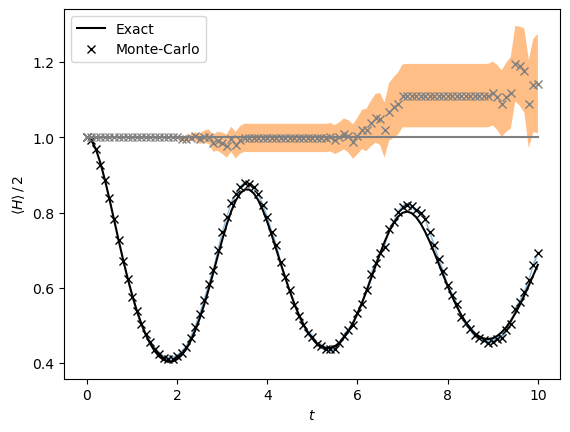

In [11]:
plt.plot(times - ti, MESol.expect[0] / 2, "k-", label="Exact")
plt.plot(times - ti, MCSol.expect[0] / 2, "kx", label="Monte-Carlo")
plt.fill_between(
    times - ti,
    (MCSol.expect[0] - MCSol.std_expect[0] / np.sqrt(ntraj)) / 2,
    (MCSol.expect[0] + MCSol.std_expect[0] / np.sqrt(ntraj)) / 2,
    alpha=0.5,
)

plt.plot(times - ti, np.ones_like(times), "-", color="0.5")
plt.plot(times - ti, MCSol.trace, "x", color="0.5")
plt.fill_between(
    times - ti,
    MCSol.trace - MCSol.std_trace / np.sqrt(ntraj),
    MCSol.trace + MCSol.std_trace / np.sqrt(ntraj),
    alpha=0.5,
)

plt.xlabel(r"$t$")
plt.ylabel(r"$\langle H \rangle\, /\, 2$")
plt.legend()
plt.show()

##### Improved Sampling
To close this tutorial, we will briefly demonstrate the use of the "improved sampling" option with `nm_mcsolve`.
For clarity, we consider the same example as before, but with a shorter time interval and fewer trajectories:

In [12]:
times_is = np.linspace(ti, ti + duration / 2, steps + 1)
ntraj_is = int(ntraj / 10)

MCSol_is = solver.run(psi0, tlist=times_is, ntraj=ntraj_is, e_ops=e_ops)
MESol_is = qt.mesolve([H, S], psi0, times_is, d_ops, e_ops, options=options)

 [          0%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.05s / Remaining 00:00:00:04

 [          1%           ] Elapsed 0.05s / Remaining 00:00:00:04

 [          1%           ] Elapsed 0.06s / Remaining 00:00:00:05

 [          1%           ] Elapsed 0.06s / Remaining 00:00:00:05

 [          1%           ] Elapsed 0.06s / Remaining 00:00:00:06

 [          1%           ] Elapsed 0.07s / Remaining 00:00:00:06

 [          2%           ] Elapsed 0.07s / Remaining 00:00:00:03

 [          2%           ] Elapsed 0.07s / Remaining 00:00:00:03

 [          2%           ] Elapsed 0.07s / Remaining 00:00:00:03

 [          2%           ] Elapsed 0.08s / Remaining 00:00:00:03

 [          2%           ] Elapsed 0.08s / Remaining 00:00:00:04

 [*         3%           ] Elapsed 0.08s / Remaining 00:00:00:02

 [*         3%           ] Elapsed 0.09s / Remaining 00:00:00:02

 [*         3%           ] Elapsed 0.10s / Remaining 00:00:00:03

 [*         3%           ] Elapsed 0.20s / Remaining 00:00:00:06

 [*         3%           ] Elapsed 0.20s / Remaining 00:00:00:06

 [*         3%           ] Elapsed 0.21s / Remaining 00:00:00:06

 [*         4%           ] Elapsed 0.21s / Remaining 00:00:00:05

 [*         4%           ] Elapsed 0.22s / Remaining 00:00:00:05

 [*         4%           ] Elapsed 0.22s / Remaining 00:00:00:05

 [*         4%           ] Elapsed 0.22s / Remaining 00:00:00:05

 [*         4%           ] Elapsed 0.23s / Remaining 00:00:00:05

 [*         5%           ] Elapsed 0.23s / Remaining 00:00:00:04

 [*         5%           ] Elapsed 0.23s / Remaining 00:00:00:04

 [*         5%           ] Elapsed 0.23s / Remaining 00:00:00:04

 [*         5%           ] Elapsed 0.24s / Remaining 00:00:00:04

 [*         5%           ] Elapsed 0.24s / Remaining 00:00:00:04

 [*         5%           ] Elapsed 0.24s / Remaining 00:00:00:04

 [*         6%           ] Elapsed 0.25s / Remaining 00:00:00:03

 [*         6%           ] Elapsed 0.25s / Remaining 00:00:00:03

 [*         6%           ] Elapsed 0.25s / Remaining 00:00:00:03

 [*         6%           ] Elapsed 0.26s / Remaining 00:00:00:04

 [*         6%           ] Elapsed 0.26s / Remaining 00:00:00:04

 [**        7%           ] Elapsed 0.26s / Remaining 00:00:00:03

 [**        7%           ] Elapsed 0.27s / Remaining 00:00:00:03

 [**        7%           ] Elapsed 0.27s / Remaining 00:00:00:03

 [**        7%           ] Elapsed 0.27s / Remaining 00:00:00:03

 [**        7%           ] Elapsed 0.27s / Remaining 00:00:00:03

 [**        7%           ] Elapsed 0.28s / Remaining 00:00:00:03

 [**        8%           ] Elapsed 0.28s / Remaining 00:00:00:03

 [**        8%           ] Elapsed 0.28s / Remaining 00:00:00:03

 [**        8%           ] Elapsed 0.28s / Remaining 00:00:00:03

 [**        8%           ] Elapsed 0.29s / Remaining 00:00:00:03

 [**        8%           ] Elapsed 0.29s / Remaining 00:00:00:03

 [**        9%           ] Elapsed 0.29s / Remaining 00:00:00:02

 [**        9%           ] Elapsed 0.30s / Remaining 00:00:00:03

 [**        9%           ] Elapsed 0.30s / Remaining 00:00:00:03

 [**        9%           ] Elapsed 0.31s / Remaining 00:00:00:03

 [**        9%           ] Elapsed 0.31s / Remaining 00:00:00:03

 [**        9%           ] Elapsed 0.31s / Remaining 00:00:00:03

 [**       10%           ] Elapsed 0.31s / Remaining 00:00:00:02

 [**       10%           ] Elapsed 0.32s / Remaining 00:00:00:02

 [**       10%           ] Elapsed 0.32s / Remaining 00:00:00:02

 [**       10%           ] Elapsed 0.32s / Remaining 00:00:00:02

 [**       10%           ] Elapsed 0.33s / Remaining 00:00:00:02

 [***      11%           ] Elapsed 0.33s / Remaining 00:00:00:02

 [***      11%           ] Elapsed 0.34s / Remaining 00:00:00:02

 [***      11%           ] Elapsed 0.34s / Remaining 00:00:00:02

 [***      11%           ] Elapsed 0.34s / Remaining 00:00:00:02

 [***      11%           ] Elapsed 0.35s / Remaining 00:00:00:02

 [***      11%           ] Elapsed 0.35s / Remaining 00:00:00:02

 [***      12%           ] Elapsed 0.35s / Remaining 00:00:00:02

 [***      12%           ] Elapsed 0.35s / Remaining 00:00:00:02

 [***      12%           ] Elapsed 0.35s / Remaining 00:00:00:02

 [***      12%           ] Elapsed 0.36s / Remaining 00:00:00:02

 [***      12%           ] Elapsed 0.36s / Remaining 00:00:00:02

 [***      13%           ] Elapsed 0.37s / Remaining 00:00:00:02

 [***      13%           ] Elapsed 0.37s / Remaining 00:00:00:02

 [***      13%           ] Elapsed 0.37s / Remaining 00:00:00:02

 [***      13%           ] Elapsed 0.38s / Remaining 00:00:00:02

 [***      13%           ] Elapsed 0.38s / Remaining 00:00:00:02

 [***      13%           ] Elapsed 0.38s / Remaining 00:00:00:02

 [***      14%           ] Elapsed 0.38s / Remaining 00:00:00:02

 [***      14%           ] Elapsed 0.39s / Remaining 00:00:00:02

 [***      14%           ] Elapsed 0.39s / Remaining 00:00:00:02

 [***      14%           ] Elapsed 0.39s / Remaining 00:00:00:02

 [***      14%           ] Elapsed 0.40s / Remaining 00:00:00:02

 [***      15%           ] Elapsed 0.40s / Remaining 00:00:00:02

 [***      15%           ] Elapsed 0.40s / Remaining 00:00:00:02

 [***      15%           ] Elapsed 0.41s / Remaining 00:00:00:02

 [***      15%           ] Elapsed 0.41s / Remaining 00:00:00:02

 [***      15%           ] Elapsed 0.41s / Remaining 00:00:00:02

 [***      15%           ] Elapsed 0.41s / Remaining 00:00:00:02

 [****     16%           ] Elapsed 0.42s / Remaining 00:00:00:02

 [****     16%           ] Elapsed 0.42s / Remaining 00:00:00:02

 [****     16%           ] Elapsed 0.43s / Remaining 00:00:00:02

 [****     16%           ] Elapsed 0.43s / Remaining 00:00:00:02

 [****     16%           ] Elapsed 0.43s / Remaining 00:00:00:02

 [****     17%           ] Elapsed 0.44s / Remaining 00:00:00:02

 [****     17%           ] Elapsed 0.44s / Remaining 00:00:00:02

 [****     17%           ] Elapsed 0.44s / Remaining 00:00:00:02

 [****     17%           ] Elapsed 0.44s / Remaining 00:00:00:02

 [****     17%           ] Elapsed 0.45s / Remaining 00:00:00:02

 [****     17%           ] Elapsed 0.45s / Remaining 00:00:00:02

 [****     18%           ] Elapsed 0.45s / Remaining 00:00:00:02

 [****     18%           ] Elapsed 0.46s / Remaining 00:00:00:02

 [****     18%           ] Elapsed 0.46s / Remaining 00:00:00:02

 [****     18%           ] Elapsed 0.46s / Remaining 00:00:00:02

 [****     18%           ] Elapsed 0.47s / Remaining 00:00:00:02

 [****     19%           ] Elapsed 0.47s / Remaining 00:00:00:01

 [****     19%           ] Elapsed 0.47s / Remaining 00:00:00:02

 [****     19%           ] Elapsed 0.48s / Remaining 00:00:00:02

 [****     19%           ] Elapsed 0.48s / Remaining 00:00:00:02

 [****     19%           ] Elapsed 0.48s / Remaining 00:00:00:02

 [****     19%           ] Elapsed 0.49s / Remaining 00:00:00:02

 [*****    20%           ] Elapsed 0.49s / Remaining 00:00:00:01

 [*****    20%           ] Elapsed 0.49s / Remaining 00:00:00:01

 [*****    20%           ] Elapsed 0.49s / Remaining 00:00:00:01

 [*****    20%           ] Elapsed 0.50s / Remaining 00:00:00:02

 [*****    20%           ] Elapsed 0.50s / Remaining 00:00:00:02

 [*****    21%           ] Elapsed 0.50s / Remaining 00:00:00:01

 [*****    21%           ] Elapsed 0.51s / Remaining 00:00:00:01

 [*****    21%           ] Elapsed 0.51s / Remaining 00:00:00:01

 [*****    21%           ] Elapsed 0.51s / Remaining 00:00:00:01

 [*****    21%           ] Elapsed 0.52s / Remaining 00:00:00:01

 [*****    21%           ] Elapsed 0.52s / Remaining 00:00:00:01

 [*****    22%           ] Elapsed 0.52s / Remaining 00:00:00:01

 [*****    22%           ] Elapsed 0.53s / Remaining 00:00:00:01

 [*****    22%           ] Elapsed 0.53s / Remaining 00:00:00:01

 [*****    22%           ] Elapsed 0.53s / Remaining 00:00:00:01

 [*****    22%           ] Elapsed 0.54s / Remaining 00:00:00:01

 [*****    23%           ] Elapsed 0.54s / Remaining 00:00:00:01

 [*****    23%           ] Elapsed 0.54s / Remaining 00:00:00:01

 [*****    23%           ] Elapsed 0.54s / Remaining 00:00:00:01

 [*****    23%           ] Elapsed 0.55s / Remaining 00:00:00:01

 [*****    23%           ] Elapsed 0.55s / Remaining 00:00:00:01

 [*****    23%           ] Elapsed 0.56s / Remaining 00:00:00:01

 [******   24%           ] Elapsed 0.56s / Remaining 00:00:00:01

 [******   24%           ] Elapsed 0.56s / Remaining 00:00:00:01

 [******   24%           ] Elapsed 0.57s / Remaining 00:00:00:01

 [******   24%           ] Elapsed 0.57s / Remaining 00:00:00:01

 [******   24%           ] Elapsed 0.57s / Remaining 00:00:00:01

 [******   25%           ] Elapsed 0.57s / Remaining 00:00:00:01

 [******   25%           ] Elapsed 0.58s / Remaining 00:00:00:01

 [******   25%           ] Elapsed 0.58s / Remaining 00:00:00:01

 [******   25%           ] Elapsed 0.58s / Remaining 00:00:00:01

 [******   25%           ] Elapsed 0.59s / Remaining 00:00:00:01

 [******   25%           ] Elapsed 0.59s / Remaining 00:00:00:01

 [******   26%           ] Elapsed 0.59s / Remaining 00:00:00:01

 [******   26%           ] Elapsed 0.60s / Remaining 00:00:00:01

 [******   26%           ] Elapsed 0.60s / Remaining 00:00:00:01

 [******   26%           ] Elapsed 0.60s / Remaining 00:00:00:01

 [******   26%           ] Elapsed 0.60s / Remaining 00:00:00:01

 [******   27%           ] Elapsed 0.61s / Remaining 00:00:00:01

 [******   27%           ] Elapsed 0.61s / Remaining 00:00:00:01

 [******   27%           ] Elapsed 0.62s / Remaining 00:00:00:01

 [******   27%           ] Elapsed 0.62s / Remaining 00:00:00:01

 [******   27%           ] Elapsed 0.62s / Remaining 00:00:00:01

 [******   27%           ] Elapsed 0.63s / Remaining 00:00:00:01

 [******   28%           ] Elapsed 0.63s / Remaining 00:00:00:01

 [******   28%           ] Elapsed 0.63s / Remaining 00:00:00:01

 [******   28%           ] Elapsed 0.64s / Remaining 00:00:00:01

 [******   28%           ] Elapsed 0.64s / Remaining 00:00:00:01

 [******   28%           ] Elapsed 0.64s / Remaining 00:00:00:01

 [*******  29%           ] Elapsed 0.65s / Remaining 00:00:00:01

 [*******  29%           ] Elapsed 0.65s / Remaining 00:00:00:01

 [*******  29%           ] Elapsed 0.65s / Remaining 00:00:00:01

 [*******  29%           ] Elapsed 0.66s / Remaining 00:00:00:01

 [*******  29%           ] Elapsed 0.66s / Remaining 00:00:00:01

 [*******  29%           ] Elapsed 0.66s / Remaining 00:00:00:01

 [*******  30%           ] Elapsed 0.66s / Remaining 00:00:00:01

 [*******  30%           ] Elapsed 0.67s / Remaining 00:00:00:01

 [*******  30%           ] Elapsed 0.67s / Remaining 00:00:00:01

 [*******  30%           ] Elapsed 0.68s / Remaining 00:00:00:01

 [*******  30%           ] Elapsed 0.68s / Remaining 00:00:00:01

 [*******  31%           ] Elapsed 0.68s / Remaining 00:00:00:01

 [*******  31%           ] Elapsed 0.69s / Remaining 00:00:00:01

 [*******  31%           ] Elapsed 0.69s / Remaining 00:00:00:01

 [*******  31%           ] Elapsed 0.69s / Remaining 00:00:00:01

 [*******  31%           ] Elapsed 0.69s / Remaining 00:00:00:01

 [*******  31%           ] Elapsed 0.70s / Remaining 00:00:00:01

 [*******  32%           ] Elapsed 0.70s / Remaining 00:00:00:01

 [*******  32%           ] Elapsed 0.70s / Remaining 00:00:00:01

 [*******  32%           ] Elapsed 0.71s / Remaining 00:00:00:01

 [*******  32%           ] Elapsed 0.71s / Remaining 00:00:00:01

 [*******  32%           ] Elapsed 0.77s / Remaining 00:00:00:01

 [******** 33%           ] Elapsed 0.77s / Remaining 00:00:00:01

 [******** 33%           ] Elapsed 0.77s / Remaining 00:00:00:01

 [******** 33%           ] Elapsed 0.78s / Remaining 00:00:00:01

 [******** 33%           ] Elapsed 0.78s / Remaining 00:00:00:01

 [******** 33%           ] Elapsed 0.78s / Remaining 00:00:00:01

 [******** 33%           ] Elapsed 0.79s / Remaining 00:00:00:01

 [******** 34%           ] Elapsed 0.79s / Remaining 00:00:00:01

 [******** 34%           ] Elapsed 0.79s / Remaining 00:00:00:01

 [******** 34%           ] Elapsed 0.80s / Remaining 00:00:00:01

 [******** 34%           ] Elapsed 0.80s / Remaining 00:00:00:01

 [******** 34%           ] Elapsed 0.80s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 0.81s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 0.81s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 0.81s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 0.82s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 0.82s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 0.82s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 0.83s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 0.83s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 0.83s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 0.83s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 0.84s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 0.84s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 0.84s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 0.85s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 0.85s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 0.85s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 0.86s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 0.86s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 0.87s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 0.87s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 0.87s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 0.87s / Remaining 00:00:00:01

 [*********39%           ] Elapsed 0.88s / Remaining 00:00:00:01

 [*********39%           ] Elapsed 0.88s / Remaining 00:00:00:01

 [*********39%           ] Elapsed 0.88s / Remaining 00:00:00:01

 [*********39%           ] Elapsed 0.88s / Remaining 00:00:00:01

 [*********39%           ] Elapsed 0.89s / Remaining 00:00:00:01

 [*********39%           ] Elapsed 0.89s / Remaining 00:00:00:01

 [*********40%           ] Elapsed 0.90s / Remaining 00:00:00:01

 [*********40%           ] Elapsed 0.90s / Remaining 00:00:00:01

 [*********40%           ] Elapsed 0.90s / Remaining 00:00:00:01

 [*********40%           ] Elapsed 0.91s / Remaining 00:00:00:01

 [*********40%           ] Elapsed 0.91s / Remaining 00:00:00:01

 [*********41%           ] Elapsed 0.91s / Remaining 00:00:00:01

 [*********41%           ] Elapsed 0.91s / Remaining 00:00:00:01

 [*********41%           ] Elapsed 0.92s / Remaining 00:00:00:01

 [*********41%           ] Elapsed 0.92s / Remaining 00:00:00:01

 [*********41%           ] Elapsed 0.92s / Remaining 00:00:00:01

 [*********41%           ] Elapsed 0.93s / Remaining 00:00:00:01

 [*********42%           ] Elapsed 0.93s / Remaining 00:00:00:01

 [*********42%           ] Elapsed 0.93s / Remaining 00:00:00:01

 [*********42%           ] Elapsed 0.94s / Remaining 00:00:00:01

 [*********42%           ] Elapsed 0.94s / Remaining 00:00:00:01

 [*********42%           ] Elapsed 0.95s / Remaining 00:00:00:01

 [*********43%           ] Elapsed 0.95s / Remaining 00:00:00:01

 [*********43%           ] Elapsed 0.95s / Remaining 00:00:00:01

 [*********43%           ] Elapsed 0.95s / Remaining 00:00:00:01

 [*********43%           ] Elapsed 0.96s / Remaining 00:00:00:01

 [*********43%           ] Elapsed 0.96s / Remaining 00:00:00:01

 [*********43%           ] Elapsed 0.96s / Remaining 00:00:00:01

 [*********44%           ] Elapsed 0.97s / Remaining 00:00:00:01

 [*********44%           ] Elapsed 0.97s / Remaining 00:00:00:01

 [*********44%           ] Elapsed 0.98s / Remaining 00:00:00:01

 [*********44%           ] Elapsed 0.98s / Remaining 00:00:00:01

 [*********44%           ] Elapsed 0.98s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 0.99s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 0.99s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 0.99s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 1.00s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 1.00s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 1.00s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 1.00s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 1.01s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 1.01s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 1.02s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 1.02s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 1.02s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 1.02s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 1.03s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 1.03s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 1.04s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 1.04s / Remaining 00:00:00:01

 [*********48%           ] Elapsed 1.04s / Remaining 00:00:00:01

 [*********48%           ] Elapsed 1.04s / Remaining 00:00:00:01

 [*********48%           ] Elapsed 1.05s / Remaining 00:00:00:01

 [*********48%           ] Elapsed 1.05s / Remaining 00:00:00:01

 [*********48%           ] Elapsed 1.05s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 1.06s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 1.06s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 1.06s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 1.07s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 1.07s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 1.07s / Remaining 00:00:00:01

 [*********50%           ] Elapsed 1.08s / Remaining 00:00:00:01

 [*********50%           ] Elapsed 1.08s / Remaining 00:00:00:01

 [*********50%           ] Elapsed 1.08s / Remaining 00:00:00:01

 [*********50%           ] Elapsed 1.09s / Remaining 00:00:00:01

 [*********50%           ] Elapsed 1.09s / Remaining 00:00:00:01

 [*********51%           ] Elapsed 1.09s / Remaining 00:00:00:01

 [*********51%           ] Elapsed 1.10s / Remaining 00:00:00:01

 [*********51%           ] Elapsed 1.10s / Remaining 00:00:00:01

 [*********51%           ] Elapsed 1.11s / Remaining 00:00:00:01

 [*********51%           ] Elapsed 1.11s / Remaining 00:00:00:01

 [*********51%           ] Elapsed 1.11s / Remaining 00:00:00:01

 [*********52%           ] Elapsed 1.11s / Remaining 00:00:00:01

 [*********52%           ] Elapsed 1.12s / Remaining 00:00:00:01

 [*********52%           ] Elapsed 1.12s / Remaining 00:00:00:01

 [*********52%           ] Elapsed 1.12s / Remaining 00:00:00:01

 [*********52%           ] Elapsed 1.13s / Remaining 00:00:00:01

 [*********53%           ] Elapsed 1.13s / Remaining 00:00:00:01

 [*********53%           ] Elapsed 1.14s / Remaining 00:00:00:01

 [*********53%           ] Elapsed 1.14s / Remaining 00:00:00:01

 [*********53%           ] Elapsed 1.14s / Remaining 00:00:00:01

 [*********53%           ] Elapsed 1.15s / Remaining 00:00:00:01

 [*********53%           ] Elapsed 1.15s / Remaining 00:00:00:01

 [*********54%           ] Elapsed 1.15s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 1.16s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 1.16s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 1.16s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 1.17s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 1.17s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 1.17s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 1.18s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 1.18s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 1.18s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 1.19s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 1.19s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 1.19s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 1.19s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 1.20s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 1.20s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 1.21s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 1.21s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 1.21s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 1.21s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 1.22s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 1.22s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 1.22s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 1.22s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 1.23s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 1.23s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 1.24s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 1.24s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 1.24s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 1.24s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 1.25s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 1.25s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 1.25s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 1.26s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 1.26s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 1.26s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 1.27s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 1.27s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 1.27s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 1.28s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 1.28s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 1.28s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 1.29s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 1.29s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 1.29s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 1.30s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 1.30s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 1.30s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 1.31s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 1.31s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 1.31s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 1.31s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 1.32s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 1.32s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 1.32s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 1.33s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 1.33s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 1.33s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 1.34s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 1.34s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 1.34s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 1.35s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 1.35s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 1.35s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 1.36s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 1.36s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 1.36s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 1.37s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 1.37s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 1.37s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 1.37s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 1.38s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 1.38s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 1.39s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 1.39s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 1.39s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 1.39s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 1.40s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 1.40s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 1.41s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 1.41s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 1.41s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 1.41s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 1.42s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 1.42s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 1.42s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 1.43s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 1.43s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 1.43s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 1.43s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 1.44s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 1.44s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 1.44s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 1.45s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 1.45s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 1.45s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 1.46s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 1.46s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 1.46s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 1.47s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 1.47s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 1.47s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 1.48s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 1.48s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 1.48s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 1.49s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 1.49s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 1.49s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 1.50s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 1.50s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 1.50s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 1.50s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 1.51s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 1.51s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 1.51s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 1.52s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 1.52s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 1.52s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 1.53s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 1.53s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 1.53s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 1.54s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 1.54s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 1.54s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 1.55s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 1.55s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 1.55s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 1.56s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 1.56s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 1.56s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 1.56s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 1.57s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 1.57s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 1.58s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 1.58s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 1.58s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 1.59s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 1.59s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 1.59s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 1.60s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 1.60s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 1.60s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 1.60s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 1.61s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 1.61s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 1.62s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 1.62s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 1.62s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 1.62s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 1.63s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 1.63s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 1.64s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 1.64s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 1.64s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 1.64s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 1.65s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 1.65s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 1.65s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 1.65s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.66s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.66s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.67s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.67s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.67s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.67s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.68s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.68s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.68s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.69s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.69s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.69s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.70s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.70s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.70s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.71s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.71s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.71s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.72s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.72s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.73s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.73s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.73s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.74s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.74s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.74s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.74s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.75s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.75s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.76s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.76s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.76s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.76s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.77s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.77s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.77s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.77s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.78s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.78s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.78s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.79s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.79s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.80s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.80s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.80s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.80s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.81s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.81s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.81s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.82s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.82s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.83s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.83s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.83s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.83s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.84s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.84s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.84s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.85s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.85s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.86s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.86s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.86s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.86s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.87s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.87s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.87s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.88s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.88s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.88s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.89s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.89s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.89s / Remaining 00:00:00:00

[*********96%********** ] Elapsed 1.89s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.90s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.90s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.90s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.91s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.91s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.91s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.92s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.92s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.93s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.93s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.93s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.93s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.94s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.94s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.95s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.95s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.95s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.96s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.96s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.96s / Remaining 00:00:00:00

 [********100%***********] Elapsed 1.96s / Remaining 00:00:00:00

 [********100%***********] Elapsed 1.97s / Remaining 00:00:00:00

 [********100%***********] Elapsed 1.97s / Remaining 00:00:00:00

 Total run time:   1.99s
 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.04s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.04s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.04s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.04s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.04s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.04s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.04s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.04s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.04s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.04s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.04s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.04s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.04s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.04s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.04s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.04s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.04s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.05s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.05s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.05s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.05s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.05s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.05s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.05s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.05s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.05s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.05s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.05s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.05s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.05s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.05s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.05s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.05s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.05s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.06s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.06s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.06s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.06s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.06s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.06s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.06s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.06s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.06s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.06s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.06s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.06s / Remaining 00:00:00:00

 Total run time:   0.06s


/home/runner/miniconda3/envs/test-environment-v5/lib/python3.12/site-packages/qutip/solver/solver_base.py:598: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


If we count the number of collapses per trajectory, we see that around 10% of the trajectories had no collapses:

In [13]:
print(Counter([len(x) for x in MCSol_is.col_times]))

Counter({1: 165, 2: 143, 3: 110, 0: 55, 4: 50, 5: 13, 6: 10, 7: 4})


All these trajectories are identical.
It would therefore be enough to calculate this trajectory only once.
This can be done by activating the "improved sampling" option:

In [14]:
solver.options = {'improved_sampling': True}
MCSol_is_improved = solver.run(psi0, tlist=times_is, ntraj=ntraj_is, e_ops=e_ops)
print(Counter([len(x) for x in MCSol_is_improved.col_times]))

 [          0%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.05s / Remaining 00:00:00:04

 [          1%           ] Elapsed 0.05s / Remaining 00:00:00:04

 [          1%           ] Elapsed 0.05s / Remaining 00:00:00:05

 [          1%           ] Elapsed 0.06s / Remaining 00:00:00:06

 [          1%           ] Elapsed 0.06s / Remaining 00:00:00:06

 [          1%           ] Elapsed 0.07s / Remaining 00:00:00:06

 [          2%           ] Elapsed 0.07s / Remaining 00:00:00:03

 [          2%           ] Elapsed 0.07s / Remaining 00:00:00:03

 [          2%           ] Elapsed 0.08s / Remaining 00:00:00:03

 [          2%           ] Elapsed 0.08s / Remaining 00:00:00:03

 [          2%           ] Elapsed 0.08s / Remaining 00:00:00:03

 [*         3%           ] Elapsed 0.08s / Remaining 00:00:00:02

 [*         3%           ] Elapsed 0.09s / Remaining 00:00:00:02

 [*         3%           ] Elapsed 0.09s / Remaining 00:00:00:03

 [*         3%           ] Elapsed 0.10s / Remaining 00:00:00:03

 [*         3%           ] Elapsed 0.10s / Remaining 00:00:00:03

 [*         3%           ] Elapsed 0.10s / Remaining 00:00:00:03

 [*         4%           ] Elapsed 0.11s / Remaining 00:00:00:02

 [*         4%           ] Elapsed 0.11s / Remaining 00:00:00:02

 [*         4%           ] Elapsed 0.11s / Remaining 00:00:00:02

 [*         4%           ] Elapsed 0.12s / Remaining 00:00:00:02

 [*         4%           ] Elapsed 0.12s / Remaining 00:00:00:02

 [*         5%           ] Elapsed 0.12s / Remaining 00:00:00:02

 [*         5%           ] Elapsed 0.13s / Remaining 00:00:00:02

 [*         5%           ] Elapsed 0.13s / Remaining 00:00:00:02

 [*         5%           ] Elapsed 0.13s / Remaining 00:00:00:02

 [*         5%           ] Elapsed 0.14s / Remaining 00:00:00:02

 [*         5%           ] Elapsed 0.14s / Remaining 00:00:00:02

 [*         6%           ] Elapsed 0.14s / Remaining 00:00:00:02

 [*         6%           ] Elapsed 0.15s / Remaining 00:00:00:02

 [*         6%           ] Elapsed 0.15s / Remaining 00:00:00:02

 [*         6%           ] Elapsed 0.15s / Remaining 00:00:00:02

 [*         6%           ] Elapsed 0.15s / Remaining 00:00:00:02

 [**        7%           ] Elapsed 0.16s / Remaining 00:00:00:02

 [**        7%           ] Elapsed 0.16s / Remaining 00:00:00:02

 [**        7%           ] Elapsed 0.16s / Remaining 00:00:00:02

 [**        7%           ] Elapsed 0.17s / Remaining 00:00:00:02

 [**        7%           ] Elapsed 0.17s / Remaining 00:00:00:02

 [**        7%           ] Elapsed 0.18s / Remaining 00:00:00:02

 [**        8%           ] Elapsed 0.18s / Remaining 00:00:00:02

 [**        8%           ] Elapsed 0.18s / Remaining 00:00:00:02

 [**        8%           ] Elapsed 0.18s / Remaining 00:00:00:02

 [**        8%           ] Elapsed 0.19s / Remaining 00:00:00:02

 [**        8%           ] Elapsed 0.19s / Remaining 00:00:00:02

 [**        9%           ] Elapsed 0.19s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.20s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.20s / Remaining 00:00:00:02

 [**        9%           ] Elapsed 0.20s / Remaining 00:00:00:02

 [**        9%           ] Elapsed 0.21s / Remaining 00:00:00:02

 [**        9%           ] Elapsed 0.21s / Remaining 00:00:00:02

 [**       10%           ] Elapsed 0.21s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.22s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.22s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.22s / Remaining 00:00:00:02

 [**       10%           ] Elapsed 0.23s / Remaining 00:00:00:02

 [***      11%           ] Elapsed 0.23s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.23s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.24s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.24s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.24s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.24s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.25s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.25s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.25s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.26s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.26s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.26s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.27s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.27s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.27s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.28s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.28s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.28s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.29s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.29s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.30s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.30s / Remaining 00:00:00:01

 [***      15%           ] Elapsed 0.30s / Remaining 00:00:00:01

 [***      15%           ] Elapsed 0.31s / Remaining 00:00:00:01

 [***      15%           ] Elapsed 0.31s / Remaining 00:00:00:01

 [***      15%           ] Elapsed 0.31s / Remaining 00:00:00:01

 [***      15%           ] Elapsed 0.31s / Remaining 00:00:00:01

 [***      15%           ] Elapsed 0.32s / Remaining 00:00:00:01

 [****     16%           ] Elapsed 0.32s / Remaining 00:00:00:01

 [****     16%           ] Elapsed 0.33s / Remaining 00:00:00:01

 [****     16%           ] Elapsed 0.33s / Remaining 00:00:00:01

 [****     16%           ] Elapsed 0.33s / Remaining 00:00:00:01

 [****     16%           ] Elapsed 0.34s / Remaining 00:00:00:01

 [****     17%           ] Elapsed 0.34s / Remaining 00:00:00:01

 [****     17%           ] Elapsed 0.34s / Remaining 00:00:00:01

 [****     17%           ] Elapsed 0.34s / Remaining 00:00:00:01

 [****     17%           ] Elapsed 0.35s / Remaining 00:00:00:01

 [****     17%           ] Elapsed 0.35s / Remaining 00:00:00:01

 [****     17%           ] Elapsed 0.35s / Remaining 00:00:00:01

 [****     18%           ] Elapsed 0.36s / Remaining 00:00:00:01

 [****     18%           ] Elapsed 0.36s / Remaining 00:00:00:01

 [****     18%           ] Elapsed 0.37s / Remaining 00:00:00:01

 [****     18%           ] Elapsed 0.37s / Remaining 00:00:00:01

 [****     18%           ] Elapsed 0.37s / Remaining 00:00:00:01

 [****     19%           ] Elapsed 0.37s / Remaining 00:00:00:01

 [****     19%           ] Elapsed 0.38s / Remaining 00:00:00:01

 [****     19%           ] Elapsed 0.38s / Remaining 00:00:00:01

 [****     19%           ] Elapsed 0.38s / Remaining 00:00:00:01

 [****     19%           ] Elapsed 0.39s / Remaining 00:00:00:01

 [****     19%           ] Elapsed 0.39s / Remaining 00:00:00:01

 [*****    20%           ] Elapsed 0.39s / Remaining 00:00:00:01

 [*****    20%           ] Elapsed 0.40s / Remaining 00:00:00:01

 [*****    20%           ] Elapsed 0.40s / Remaining 00:00:00:01

 [*****    20%           ] Elapsed 0.40s / Remaining 00:00:00:01

 [*****    20%           ] Elapsed 0.40s / Remaining 00:00:00:01

 [*****    21%           ] Elapsed 0.41s / Remaining 00:00:00:01

 [*****    21%           ] Elapsed 0.41s / Remaining 00:00:00:01

 [*****    21%           ] Elapsed 0.42s / Remaining 00:00:00:01

 [*****    21%           ] Elapsed 0.42s / Remaining 00:00:00:01

 [*****    21%           ] Elapsed 0.42s / Remaining 00:00:00:01

 [*****    21%           ] Elapsed 0.43s / Remaining 00:00:00:01

 [*****    22%           ] Elapsed 0.43s / Remaining 00:00:00:01

 [*****    22%           ] Elapsed 0.43s / Remaining 00:00:00:01

 [*****    22%           ] Elapsed 0.43s / Remaining 00:00:00:01

 [*****    22%           ] Elapsed 0.44s / Remaining 00:00:00:01

 [*****    22%           ] Elapsed 0.44s / Remaining 00:00:00:01

 [*****    23%           ] Elapsed 0.45s / Remaining 00:00:00:01

 [*****    23%           ] Elapsed 0.45s / Remaining 00:00:00:01

 [*****    23%           ] Elapsed 0.45s / Remaining 00:00:00:01

 [*****    23%           ] Elapsed 0.45s / Remaining 00:00:00:01

 [*****    23%           ] Elapsed 0.46s / Remaining 00:00:00:01

 [*****    23%           ] Elapsed 0.46s / Remaining 00:00:00:01

 [******   24%           ] Elapsed 0.46s / Remaining 00:00:00:01

 [******   24%           ] Elapsed 0.47s / Remaining 00:00:00:01

 [******   24%           ] Elapsed 0.47s / Remaining 00:00:00:01

 [******   24%           ] Elapsed 0.47s / Remaining 00:00:00:01

 [******   24%           ] Elapsed 0.48s / Remaining 00:00:00:01

 [******   25%           ] Elapsed 0.48s / Remaining 00:00:00:01

 [******   25%           ] Elapsed 0.48s / Remaining 00:00:00:01

 [******   25%           ] Elapsed 0.49s / Remaining 00:00:00:01

 [******   25%           ] Elapsed 0.49s / Remaining 00:00:00:01

 [******   25%           ] Elapsed 0.49s / Remaining 00:00:00:01

 [******   25%           ] Elapsed 0.50s / Remaining 00:00:00:01

 [******   26%           ] Elapsed 0.50s / Remaining 00:00:00:01

 [******   26%           ] Elapsed 0.50s / Remaining 00:00:00:01

 [******   26%           ] Elapsed 0.51s / Remaining 00:00:00:01

 [******   26%           ] Elapsed 0.51s / Remaining 00:00:00:01

 [******   26%           ] Elapsed 0.51s / Remaining 00:00:00:01

 [******   27%           ] Elapsed 0.52s / Remaining 00:00:00:01

 [******   27%           ] Elapsed 0.52s / Remaining 00:00:00:01

 [******   27%           ] Elapsed 0.52s / Remaining 00:00:00:01

 [******   27%           ] Elapsed 0.53s / Remaining 00:00:00:01

 [******   27%           ] Elapsed 0.53s / Remaining 00:00:00:01

 [******   27%           ] Elapsed 0.53s / Remaining 00:00:00:01

 [******   28%           ] Elapsed 0.54s / Remaining 00:00:00:01

 [******   28%           ] Elapsed 0.54s / Remaining 00:00:00:01

 [******   28%           ] Elapsed 0.54s / Remaining 00:00:00:01

 [******   28%           ] Elapsed 0.54s / Remaining 00:00:00:01

 [******   28%           ] Elapsed 0.55s / Remaining 00:00:00:01

 [*******  29%           ] Elapsed 0.55s / Remaining 00:00:00:01

 [*******  29%           ] Elapsed 0.56s / Remaining 00:00:00:01

 [*******  29%           ] Elapsed 0.56s / Remaining 00:00:00:01

 [*******  29%           ] Elapsed 0.56s / Remaining 00:00:00:01

 [*******  29%           ] Elapsed 0.56s / Remaining 00:00:00:01

 [*******  29%           ] Elapsed 0.57s / Remaining 00:00:00:01

 [*******  30%           ] Elapsed 0.57s / Remaining 00:00:00:01

 [*******  30%           ] Elapsed 0.57s / Remaining 00:00:00:01

 [*******  30%           ] Elapsed 0.58s / Remaining 00:00:00:01

 [*******  30%           ] Elapsed 0.58s / Remaining 00:00:00:01

 [*******  30%           ] Elapsed 0.58s / Remaining 00:00:00:01

 [*******  31%           ] Elapsed 0.59s / Remaining 00:00:00:01

 [*******  31%           ] Elapsed 0.59s / Remaining 00:00:00:01

 [*******  31%           ] Elapsed 0.59s / Remaining 00:00:00:01

 [*******  31%           ] Elapsed 0.59s / Remaining 00:00:00:01

 [*******  31%           ] Elapsed 0.60s / Remaining 00:00:00:01

 [*******  31%           ] Elapsed 0.60s / Remaining 00:00:00:01

 [*******  32%           ] Elapsed 0.61s / Remaining 00:00:00:01

 [*******  32%           ] Elapsed 0.61s / Remaining 00:00:00:01

 [*******  32%           ] Elapsed 0.61s / Remaining 00:00:00:01

 [*******  32%           ] Elapsed 0.61s / Remaining 00:00:00:01

 [*******  32%           ] Elapsed 0.62s / Remaining 00:00:00:01

 [******** 33%           ] Elapsed 0.62s / Remaining 00:00:00:01

 [******** 33%           ] Elapsed 0.62s / Remaining 00:00:00:01

 [******** 33%           ] Elapsed 0.63s / Remaining 00:00:00:01

 [******** 33%           ] Elapsed 0.63s / Remaining 00:00:00:01

 [******** 33%           ] Elapsed 0.63s / Remaining 00:00:00:01

 [******** 33%           ] Elapsed 0.64s / Remaining 00:00:00:01

 [******** 34%           ] Elapsed 0.64s / Remaining 00:00:00:01

 [******** 34%           ] Elapsed 0.64s / Remaining 00:00:00:01

 [******** 34%           ] Elapsed 0.65s / Remaining 00:00:00:01

 [******** 34%           ] Elapsed 0.65s / Remaining 00:00:00:01

 [******** 34%           ] Elapsed 0.65s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 0.66s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 0.66s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 0.66s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 0.66s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 0.67s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 0.68s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 0.68s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 0.68s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 0.68s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 0.69s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 0.69s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 0.69s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 0.70s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 0.70s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 0.70s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 0.71s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 0.71s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 0.71s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 0.72s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 0.72s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 0.73s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 0.73s / Remaining 00:00:00:01

 [*********39%           ] Elapsed 0.73s / Remaining 00:00:00:01

 [*********39%           ] Elapsed 0.73s / Remaining 00:00:00:01

 [*********39%           ] Elapsed 0.74s / Remaining 00:00:00:01

 [*********39%           ] Elapsed 0.74s / Remaining 00:00:00:01

 [*********39%           ] Elapsed 0.74s / Remaining 00:00:00:01

 [*********39%           ] Elapsed 0.75s / Remaining 00:00:00:01

 [*********40%           ] Elapsed 0.75s / Remaining 00:00:00:01

 [*********40%           ] Elapsed 0.75s / Remaining 00:00:00:01

 [*********40%           ] Elapsed 0.76s / Remaining 00:00:00:01

 [*********40%           ] Elapsed 0.76s / Remaining 00:00:00:01

 [*********40%           ] Elapsed 0.76s / Remaining 00:00:00:01

 [*********41%           ] Elapsed 0.76s / Remaining 00:00:00:01

 [*********41%           ] Elapsed 0.77s / Remaining 00:00:00:01

 [*********41%           ] Elapsed 0.77s / Remaining 00:00:00:01

 [*********41%           ] Elapsed 0.77s / Remaining 00:00:00:01

 [*********41%           ] Elapsed 0.78s / Remaining 00:00:00:01

 [*********41%           ] Elapsed 0.78s / Remaining 00:00:00:01

 [*********42%           ] Elapsed 0.79s / Remaining 00:00:00:01

 [*********42%           ] Elapsed 0.79s / Remaining 00:00:00:01

 [*********42%           ] Elapsed 0.79s / Remaining 00:00:00:01

 [*********42%           ] Elapsed 0.79s / Remaining 00:00:00:01

 [*********42%           ] Elapsed 0.80s / Remaining 00:00:00:01

 [*********43%           ] Elapsed 0.80s / Remaining 00:00:00:01

 [*********43%           ] Elapsed 0.80s / Remaining 00:00:00:01

 [*********43%           ] Elapsed 0.81s / Remaining 00:00:00:01

 [*********43%           ] Elapsed 0.81s / Remaining 00:00:00:01

 [*********43%           ] Elapsed 0.81s / Remaining 00:00:00:01

 [*********43%           ] Elapsed 0.82s / Remaining 00:00:00:01

 [*********44%           ] Elapsed 0.82s / Remaining 00:00:00:01

 [*********44%           ] Elapsed 0.82s / Remaining 00:00:00:01

 [*********44%           ] Elapsed 0.83s / Remaining 00:00:00:01

 [*********44%           ] Elapsed 0.83s / Remaining 00:00:00:01

 [*********44%           ] Elapsed 0.83s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 0.83s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 0.84s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 0.84s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 0.84s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 0.85s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 0.85s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 0.86s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 0.86s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 0.86s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 0.86s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 0.87s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 0.87s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.87s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.88s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.88s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.88s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.89s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.89s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.89s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.90s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.90s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.90s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.91s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.91s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.91s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.91s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.92s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.92s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.93s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.93s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.93s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.94s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.94s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.94s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.95s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.95s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.95s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.95s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.96s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.96s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.97s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.97s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.97s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.97s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.98s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.98s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.99s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.99s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.99s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.99s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 1.00s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 1.00s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 1.01s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 1.01s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 1.01s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 1.02s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 1.02s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 1.03s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 1.03s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 1.03s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 1.03s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 1.04s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 1.04s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 1.04s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 1.05s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 1.05s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 1.06s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 1.06s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 1.06s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 1.07s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 1.07s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 1.07s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 1.07s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 1.08s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 1.08s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 1.08s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 1.09s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 1.09s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 1.09s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 1.10s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 1.10s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 1.10s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 1.11s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 1.11s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 1.11s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 1.12s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 1.12s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 1.12s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 1.12s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 1.13s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 1.13s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 1.14s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 1.14s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 1.14s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 1.15s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 1.15s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 1.15s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 1.16s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 1.16s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 1.16s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 1.16s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 1.17s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 1.17s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 1.17s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 1.18s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 1.18s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 1.18s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 1.19s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 1.19s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 1.20s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 1.20s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 1.20s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 1.20s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 1.21s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 1.21s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 1.21s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 1.22s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 1.22s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 1.22s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 1.23s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 1.23s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 1.23s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 1.24s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 1.24s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 1.24s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 1.25s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 1.25s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 1.25s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 1.25s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 1.26s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 1.26s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 1.26s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 1.27s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 1.27s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 1.27s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 1.28s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 1.28s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 1.28s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 1.28s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 1.29s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 1.30s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 1.30s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 1.30s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 1.30s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 1.31s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 1.31s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 1.31s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 1.32s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 1.32s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 1.32s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 1.33s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 1.33s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 1.34s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 1.34s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 1.34s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 1.34s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 1.35s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 1.35s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 1.35s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 1.36s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 1.36s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 1.37s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 1.37s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 1.37s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 1.38s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 1.38s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 1.38s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 1.39s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 1.39s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 1.39s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 1.39s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 1.40s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 1.40s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 1.41s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 1.41s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 1.41s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 1.41s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 1.42s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 1.42s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 1.42s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 1.43s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 1.43s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 1.43s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 1.44s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 1.44s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 1.44s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 1.45s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 1.45s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 1.45s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 1.46s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 1.46s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 1.46s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 1.47s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 1.47s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 1.47s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 1.48s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 1.48s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 1.48s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 1.49s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 1.49s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 1.49s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 1.50s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 1.50s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 1.50s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 1.51s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 1.51s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 1.51s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 1.52s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 1.52s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.52s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.52s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.53s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.53s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.53s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.54s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.54s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.55s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.55s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.55s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.55s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.56s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.56s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.56s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.56s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.57s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.57s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.58s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.58s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.58s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.59s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.59s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.59s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.60s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.60s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.60s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.61s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.61s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.61s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.62s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.62s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.62s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.63s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.63s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.63s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.64s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.64s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.64s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.65s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.65s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.66s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.66s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.66s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.67s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.67s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.67s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.67s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.68s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.68s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.69s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.69s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.69s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.69s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.70s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.70s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.70s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.71s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.71s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.71s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.72s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.72s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.72s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.73s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.73s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.73s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.74s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.74s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.74s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.75s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.75s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.75s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.76s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.76s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.76s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.77s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.77s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.77s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.78s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.78s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.79s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.79s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.79s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.79s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.80s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.80s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.80s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.81s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.81s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.81s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.82s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.82s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.82s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.83s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.83s / Remaining 00:00:00:00

 [********100%***********] Elapsed 1.83s / Remaining 00:00:00:00

 [********100%***********] Elapsed 1.84s / Remaining 00:00:00:00

 [********100%***********] Elapsed 1.84s / Remaining 00:00:00:00

 Total run time:   1.85s
Counter({1: 203, 2: 158, 3: 98, 4: 60, 5: 25, 6: 5, 7: 1})


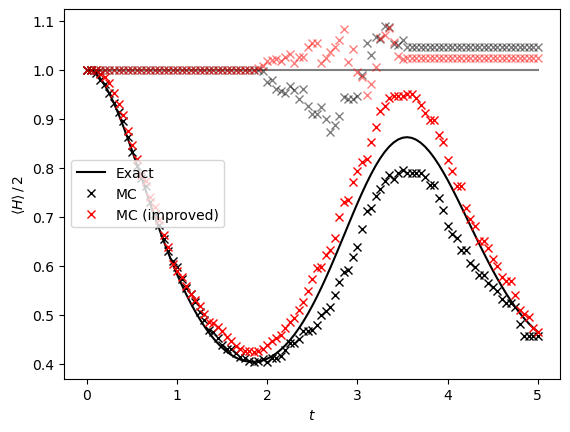

In [15]:
plt.plot(times_is - ti, MESol_is.expect[0] / 2, "k-", label="Exact")
plt.plot(times_is - ti, MCSol_is.expect[0] / 2, "kx", label="MC")
plt.plot(times_is - ti, MCSol_is_improved.expect[0] / 2, "rx", label="MC (improved)")

plt.plot(times_is - ti, np.ones_like(times_is), "k-", alpha=0.5)
plt.plot(times_is - ti, MCSol_is.trace, "kx", alpha=0.5)
plt.plot(times_is - ti, MCSol_is_improved.trace, "rx", alpha=0.5)

plt.xlabel(r"$t$")
plt.ylabel(r"$\langle H \rangle\, /\, 2$")
plt.legend()
plt.show()

### Example 2: Two-Qubit Redfield Equation

We consider two qubits that couple collectively to the same bosonic bath but do not interact with each other directly.
The full model Hamiltonian is

$$ H = \omega_1 \sigma^{(1)}_+\sigma^{(1)}_- + \omega_2 \sigma^{(2)}_+\sigma^{(2)}_- + \sum_k \epsilon_k b_k^\dagger b_k +\sum_k g_k [b_k(\sigma^{(1)}_++\sigma^{(2)}_+)+b_k^\dagger(\sigma^{(1)}_-+\sigma^{(2)}_-)]$$

Here, $b_k$, $b_k^\dagger$ are bosonic ladder operators and $\sigma^{(j)}_\pm=(\sigma_x^{(j)}\pm i\sigma_y^{(j)})/2$ and $\sigma_{x,y,z}^{(j)}$ are the Pauli matrices acting on the $j$th qubit.
Further, $\omega_j$ and $\epsilon_k$ denote the characteristic frequencies of the qubits and the bath modes, and $g_k$ are coupling constants.
The initial state of the total system is $\rho_{2q}\otimes |0\rangle\langle 0|$, where $\rho_{2q}$ is the two-qubit initial state and $|0\rangle\langle 0|$ the boson bath vacuum state.

Following Ref. [\[5\]](#References), we perform Born-Markov approximations to arrive at the following Redfield master equation for the qubits:
$$ \quad \frac{d}{dt}\rho(t) = -i \sum_{i,j=1}^2 A_{i,j} [\sigma_+^{(j)}\sigma_-^{(i)},\rho(t)] + \sum_{i,j=1}^2B_{i,j}\left( \sigma_-^{(i)}\rho(t)\sigma_+^{(j)} -\frac{1}{2}\{\sigma_+^{(j)}\sigma_-^{(i)},\rho(t)\}\right) . \tag 1 $$
Here, we introduced the matrices 
$$ \begin{aligned}
    A &= \begin{pmatrix} \omega_1 + \alpha & \alpha + \frac{\kappa}{2} - i\frac{\gamma_1-\gamma_2}{8} \\ \alpha + \frac{\kappa}{2} - i\frac{\gamma_2-\gamma_1}{8} & \omega_2 + \alpha + \kappa \end{pmatrix} \quad \text{and} \\
    B &= \frac{1}{2}\begin{pmatrix} \gamma_1 & \frac{\gamma_1+\gamma_2}{2} - 2i\kappa \\ \frac{\gamma_1+\gamma_2}{2} + 2i\kappa & \gamma_2 \end{pmatrix} ,
\end{aligned} $$
where the parameters $\alpha$, $\kappa$ and $\gamma_{1,2} \geq 0$ are related to the full Hamiltonian as follows:
$$ \begin{aligned}
    \gamma_j &= 2\int_{-\infty}^\infty dt\, \sum_k g_k^2\, e^{i(\omega_j - \epsilon_k)t} , \\
    \alpha &= \operatorname{Im} \int_0^\infty dt\, \sum_k g_k^2\, e^{i(\omega_1 - \epsilon_k)t} , \\
    \kappa &= \operatorname{Im} \int_0^\infty dt\, \sum_k g_k^2\, \Bigl( e^{i(\omega_2 - \epsilon_k)t} - e^{i(\omega_1 - \epsilon_k)t} \Bigr) .
\end{aligned} $$

The matrix $B$ is self adjoint, and therefore it can be diagonalised with some unitary $U$:
$$ U^\dagger\, B\, U = \begin{pmatrix} \lambda_{1}&0\\0&\lambda_{2} \end{pmatrix} $$
with $\lambda_{i} = \frac{\gamma_1+\gamma_2}{4}+(-1)^{i}\sqrt{\frac{\gamma_1^2+\gamma_2^2+8\,\kappa^2}{8}}$.
We define the Lindblad operators
$$ L_j = \sum_{i=1}^2 \sigma_-^{(i)} U_{ij} $$
such that equation (1) becomes
$$ \frac{d}{dt}\rho(t) = -i \sum_{i,j=1}^2 A_{i,j} [\sigma_+^{(j)}\sigma_-^{(i)},\rho(t)] + \sum_{i=1}^2\lambda_i\left( L_i\rho(t)L_i^\dagger -\frac{1}{2}\{L_i^\dagger L_i,\rho(t)\}\right) . \tag 2 $$
Now it is clear that when $\kappa>0$, $\lambda_1<0$ and thus Eq. (2) is not in strict Lindblad form.



##### Setup system

We choose the model parameters $\alpha$, $\kappa$ and $\gamma_{1,2}$, and calculate the rates $\lambda_1$ and $\lambda_2$.

In [16]:
omeg1 = 0.25
omeg2 = 0.5

gam1 = 1
gam2 = 4
alpha = 3
kappa = 1

lamb1 = (gam1 + gam2) / 4 - np.sqrt((gam1**2 + gam2**2 + 8 * kappa**2) / 8)
lamb2 = (gam1 + gam2) / 4 + np.sqrt((gam1**2 + gam2**2 + 8 * kappa**2) / 8)

We choose the time interval and numerical parameters.

In [17]:
times2 = np.linspace(0, 2.5, 100)
nmmc_options = {"map": "parallel",
                "keep_runs_results": True,
                "norm_steps": 10}  # options specific to nm_mcsolve
options = {"progress_bar": "enhanced"}  # options shared by all solvers
ntraj = 5000

We will now define our system in the basis where $L_1^\dagger |0\rangle = |1\rangle$, $L_2^\dagger |0\rangle = |2\rangle$ and $L_1^\dagger L_2^\dagger |0\rangle = |3\rangle$. Note that to define the Hamiltonian, it must be rotated to the appropriate basis. The initial state is chosen as $|\psi_0\rangle = \sqrt{0.4}\, |0\rangle + \sqrt{0.4}\, |1\rangle + \sqrt{0.2}\, |2\rangle$.

In [18]:
# Initial state of the system
psi0 = (
    np.sqrt(0.4) * qt.basis(4, 0)
    + np.sqrt(0.4) * qt.basis(4, 1)
    + np.sqrt(0.2) * qt.basis(4, 2)
)

L1 = qt.Qobj(np.array([[0, 0, 0, 0],
                       [1, 0, 0, 0],
                       [0, 0, 0, 0],
                       [0, 0, 1, 0]])).dag()
L2 = qt.Qobj(np.array([[0, 0, 0, 0],
                       [0, 0, 0, 0],
                       [1, 0, 0, 0],
                       [0, 1, 0, 0]])).dag()

norm1 = np.sqrt(
    1 + (gam2 - gam1 + np.sqrt(2) * np.sqrt(gam1**2 + gam2**2 + 8*kappa**2))**2
    / ((gam1 + gam2) ** 2 + 16 * kappa**2))
norm2 = np.sqrt(
    1 + (gam2 - gam1 - np.sqrt(2) * np.sqrt(gam1**2 + gam2**2 + 8*kappa**2))**2
    / ((gam1 + gam2) ** 2 + 16 * kappa**2))
U = qt.Qobj(np.array([
    [(gam1 - gam2 - np.sqrt(2) * np.sqrt(gam1**2 + gam2**2 + 8*kappa**2))
     / (gam1 + gam2 + 4j*kappa) / norm1,
     (gam1 - gam2 + np.sqrt(2) * np.sqrt(gam1**2 + gam2**2 + 8*kappa**2))
     / (gam1 + gam2 + 4j*kappa) / norm2],
    [1 / norm1, 1 / norm2]]))

# Write \sigma_\pm^{1,2} in terms of L_{1,2} using the explicit definition of U
Udag = U.dag()
sigmam1 = Udag[0, 0] * L1 + Udag[1, 0] * L2
sigmam2 = Udag[0, 1] * L1 + Udag[1, 1] * L2
sigmap1 = sigmam1.dag()
sigmap2 = sigmam2.dag()

H = ((omeg1 + alpha) * sigmap1 * sigmam1
     + (omeg2 + alpha + kappa) * sigmap2 * sigmam2
     + (alpha + kappa / 2 - 1j * (gam1 - gam2) / 8) * sigmap2 * sigmam1
     + (alpha + kappa / 2 - 1j * (gam2 - gam1) / 8) * sigmap1 * sigmam2)

##### Monte-Carlo Simulation

In [19]:
eops = [qt.basis(4, 0) * qt.basis(4, 0).dag(),
        qt.basis(4, 1) * qt.basis(4, 1).dag(),
        qt.basis(4, 2) * qt.basis(4, 2).dag()]

MCSol2 = qt.nm_mcsolve(H, psi0, times2, ntraj=ntraj,
                       options=(options | nmmc_options),
                       ops_and_rates=[[L1, lamb1], [L2, lamb2]],
                       e_ops=eops)

 [          0%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.14s / Remaining 00:00:00:13

 [          1%           ] Elapsed 0.14s / Remaining 00:00:00:13

 [          1%           ] Elapsed 0.14s / Remaining 00:00:00:14

 [          1%           ] Elapsed 0.15s / Remaining 00:00:00:14

 [          1%           ] Elapsed 0.15s / Remaining 00:00:00:14

 [          1%           ] Elapsed 0.15s / Remaining 00:00:00:15

 [          1%           ] Elapsed 0.15s / Remaining 00:00:00:15

 [          1%           ] Elapsed 0.16s / Remaining 00:00:00:15

 [          1%           ] Elapsed 0.17s / Remaining 00:00:00:16

 [          1%           ] Elapsed 0.17s / Remaining 00:00:00:16

 [          1%           ] Elapsed 0.17s / Remaining 00:00:00:17

 [          1%           ] Elapsed 0.17s / Remaining 00:00:00:17

 [          1%           ] Elapsed 0.18s / Remaining 00:00:00:17

 [          1%           ] Elapsed 0.18s / Remaining 00:00:00:18

 [          1%           ] Elapsed 0.19s / Remaining 00:00:00:18

 [          1%           ] Elapsed 0.19s / Remaining 00:00:00:19

 [          1%           ] Elapsed 0.20s / Remaining 00:00:00:19

 [          1%           ] Elapsed 0.20s / Remaining 00:00:00:19

 [          1%           ] Elapsed 0.20s / Remaining 00:00:00:19

 [          1%           ] Elapsed 0.21s / Remaining 00:00:00:20

 [          1%           ] Elapsed 0.21s / Remaining 00:00:00:20

 [          1%           ] Elapsed 0.22s / Remaining 00:00:00:21

 [          1%           ] Elapsed 0.22s / Remaining 00:00:00:21

 [          1%           ] Elapsed 0.22s / Remaining 00:00:00:22

 [          1%           ] Elapsed 0.23s / Remaining 00:00:00:22

 [          1%           ] Elapsed 0.23s / Remaining 00:00:00:22

 [          1%           ] Elapsed 0.23s / Remaining 00:00:00:23

 [          1%           ] Elapsed 0.24s / Remaining 00:00:00:23

 [          1%           ] Elapsed 0.24s / Remaining 00:00:00:23

 [          1%           ] Elapsed 0.25s / Remaining 00:00:00:24

 [          1%           ] Elapsed 0.25s / Remaining 00:00:00:24

 [          1%           ] Elapsed 0.25s / Remaining 00:00:00:25

 [          1%           ] Elapsed 0.26s / Remaining 00:00:00:25

 [          1%           ] Elapsed 0.26s / Remaining 00:00:00:25

 [          1%           ] Elapsed 0.27s / Remaining 00:00:00:26

 [          1%           ] Elapsed 0.27s / Remaining 00:00:00:26

 [          1%           ] Elapsed 0.27s / Remaining 00:00:00:26

 [          1%           ] Elapsed 0.27s / Remaining 00:00:00:27

 [          1%           ] Elapsed 0.28s / Remaining 00:00:00:27

 [          1%           ] Elapsed 0.28s / Remaining 00:00:00:28

 [          1%           ] Elapsed 0.29s / Remaining 00:00:00:28

 [          1%           ] Elapsed 0.29s / Remaining 00:00:00:28

 [          1%           ] Elapsed 0.29s / Remaining 00:00:00:29

 [          1%           ] Elapsed 0.30s / Remaining 00:00:00:29

 [          1%           ] Elapsed 0.30s / Remaining 00:00:00:30

 [          1%           ] Elapsed 0.31s / Remaining 00:00:00:30

 [          1%           ] Elapsed 0.31s / Remaining 00:00:00:30

 [          1%           ] Elapsed 0.31s / Remaining 00:00:00:31

 [          1%           ] Elapsed 0.32s / Remaining 00:00:00:31

 [          2%           ] Elapsed 0.32s / Remaining 00:00:00:15

 [          2%           ] Elapsed 0.33s / Remaining 00:00:00:15

 [          2%           ] Elapsed 0.33s / Remaining 00:00:00:16

 [          2%           ] Elapsed 0.34s / Remaining 00:00:00:16

 [          2%           ] Elapsed 0.34s / Remaining 00:00:00:16

 [          2%           ] Elapsed 0.34s / Remaining 00:00:00:16

 [          2%           ] Elapsed 0.35s / Remaining 00:00:00:16

 [          2%           ] Elapsed 0.35s / Remaining 00:00:00:17

 [          2%           ] Elapsed 0.35s / Remaining 00:00:00:17

 [          2%           ] Elapsed 0.36s / Remaining 00:00:00:17

 [          2%           ] Elapsed 0.36s / Remaining 00:00:00:17

 [          2%           ] Elapsed 0.36s / Remaining 00:00:00:17

 [          2%           ] Elapsed 0.37s / Remaining 00:00:00:18

 [          2%           ] Elapsed 0.37s / Remaining 00:00:00:18

 [          2%           ] Elapsed 0.38s / Remaining 00:00:00:18

 [          2%           ] Elapsed 0.38s / Remaining 00:00:00:18

 [          2%           ] Elapsed 0.38s / Remaining 00:00:00:18

 [          2%           ] Elapsed 0.39s / Remaining 00:00:00:18

 [          2%           ] Elapsed 0.39s / Remaining 00:00:00:19

 [          2%           ] Elapsed 0.39s / Remaining 00:00:00:19

 [          2%           ] Elapsed 0.40s / Remaining 00:00:00:19

 [          2%           ] Elapsed 0.40s / Remaining 00:00:00:19

 [          2%           ] Elapsed 0.41s / Remaining 00:00:00:19

 [          2%           ] Elapsed 0.41s / Remaining 00:00:00:19

 [          2%           ] Elapsed 0.41s / Remaining 00:00:00:20

 [          2%           ] Elapsed 0.42s / Remaining 00:00:00:20

 [          2%           ] Elapsed 0.42s / Remaining 00:00:00:20

 [          2%           ] Elapsed 0.43s / Remaining 00:00:00:20

 [          2%           ] Elapsed 0.43s / Remaining 00:00:00:20

 [          2%           ] Elapsed 0.43s / Remaining 00:00:00:21

 [          2%           ] Elapsed 0.44s / Remaining 00:00:00:21

 [          2%           ] Elapsed 0.44s / Remaining 00:00:00:21

 [          2%           ] Elapsed 0.44s / Remaining 00:00:00:21

 [          2%           ] Elapsed 0.45s / Remaining 00:00:00:21

 [          2%           ] Elapsed 0.45s / Remaining 00:00:00:22

 [          2%           ] Elapsed 0.46s / Remaining 00:00:00:22

 [          2%           ] Elapsed 0.46s / Remaining 00:00:00:22

 [          2%           ] Elapsed 0.46s / Remaining 00:00:00:22

 [          2%           ] Elapsed 0.47s / Remaining 00:00:00:22

 [          2%           ] Elapsed 0.47s / Remaining 00:00:00:23

 [          2%           ] Elapsed 0.47s / Remaining 00:00:00:23

 [          2%           ] Elapsed 0.48s / Remaining 00:00:00:23

 [          2%           ] Elapsed 0.48s / Remaining 00:00:00:23

 [          2%           ] Elapsed 0.49s / Remaining 00:00:00:23

 [          2%           ] Elapsed 0.49s / Remaining 00:00:00:24

 [          2%           ] Elapsed 0.49s / Remaining 00:00:00:24

 [          2%           ] Elapsed 0.50s / Remaining 00:00:00:24

 [          2%           ] Elapsed 0.50s / Remaining 00:00:00:24

 [          2%           ] Elapsed 0.51s / Remaining 00:00:00:24

 [          2%           ] Elapsed 0.51s / Remaining 00:00:00:24

 [          2%           ] Elapsed 0.51s / Remaining 00:00:00:24

 [*         3%           ] Elapsed 0.52s / Remaining 00:00:00:16

 [*         3%           ] Elapsed 0.53s / Remaining 00:00:00:16

 [*         3%           ] Elapsed 0.53s / Remaining 00:00:00:17

 [*         3%           ] Elapsed 0.53s / Remaining 00:00:00:17

 [*         3%           ] Elapsed 0.54s / Remaining 00:00:00:17

 [*         3%           ] Elapsed 0.54s / Remaining 00:00:00:17

 [*         3%           ] Elapsed 0.54s / Remaining 00:00:00:17

 [*         3%           ] Elapsed 0.55s / Remaining 00:00:00:17

 [*         3%           ] Elapsed 0.55s / Remaining 00:00:00:17

 [*         3%           ] Elapsed 0.56s / Remaining 00:00:00:18

 [*         3%           ] Elapsed 0.56s / Remaining 00:00:00:18

 [*         3%           ] Elapsed 0.56s / Remaining 00:00:00:18

 [*         3%           ] Elapsed 0.56s / Remaining 00:00:00:18

 [*         3%           ] Elapsed 0.57s / Remaining 00:00:00:18

 [*         3%           ] Elapsed 0.57s / Remaining 00:00:00:18

 [*         3%           ] Elapsed 0.58s / Remaining 00:00:00:18

 [*         3%           ] Elapsed 0.58s / Remaining 00:00:00:18

 [*         3%           ] Elapsed 0.58s / Remaining 00:00:00:18

 [*         3%           ] Elapsed 0.59s / Remaining 00:00:00:18

 [*         3%           ] Elapsed 0.59s / Remaining 00:00:00:19

 [*         3%           ] Elapsed 0.60s / Remaining 00:00:00:19

 [*         3%           ] Elapsed 0.60s / Remaining 00:00:00:19

 [*         3%           ] Elapsed 0.60s / Remaining 00:00:00:19

 [*         3%           ] Elapsed 0.60s / Remaining 00:00:00:19

 [*         3%           ] Elapsed 0.61s / Remaining 00:00:00:19

 [*         3%           ] Elapsed 0.61s / Remaining 00:00:00:19

 [*         3%           ] Elapsed 0.62s / Remaining 00:00:00:19

 [*         3%           ] Elapsed 0.62s / Remaining 00:00:00:20

 [*         3%           ] Elapsed 0.62s / Remaining 00:00:00:20

 [*         3%           ] Elapsed 0.63s / Remaining 00:00:00:20

 [*         3%           ] Elapsed 0.63s / Remaining 00:00:00:20

 [*         3%           ] Elapsed 0.63s / Remaining 00:00:00:20

 [*         3%           ] Elapsed 0.64s / Remaining 00:00:00:20

 [*         3%           ] Elapsed 0.64s / Remaining 00:00:00:20

 [*         3%           ] Elapsed 0.64s / Remaining 00:00:00:20

 [*         3%           ] Elapsed 0.65s / Remaining 00:00:00:20

 [*         3%           ] Elapsed 0.65s / Remaining 00:00:00:21

 [*         3%           ] Elapsed 0.66s / Remaining 00:00:00:21

 [*         3%           ] Elapsed 0.66s / Remaining 00:00:00:21

 [*         3%           ] Elapsed 0.66s / Remaining 00:00:00:21

 [*         3%           ] Elapsed 0.67s / Remaining 00:00:00:21

 [*         3%           ] Elapsed 0.67s / Remaining 00:00:00:21

 [*         3%           ] Elapsed 0.67s / Remaining 00:00:00:21

 [*         3%           ] Elapsed 0.68s / Remaining 00:00:00:21

 [*         3%           ] Elapsed 0.68s / Remaining 00:00:00:22

 [*         3%           ] Elapsed 0.69s / Remaining 00:00:00:22

 [*         3%           ] Elapsed 0.69s / Remaining 00:00:00:22

 [*         3%           ] Elapsed 0.69s / Remaining 00:00:00:22

 [*         3%           ] Elapsed 0.70s / Remaining 00:00:00:22

 [*         4%           ] Elapsed 0.70s / Remaining 00:00:00:16

 [*         4%           ] Elapsed 0.70s / Remaining 00:00:00:16

 [*         4%           ] Elapsed 0.70s / Remaining 00:00:00:16

 [*         4%           ] Elapsed 0.71s / Remaining 00:00:00:17

 [*         4%           ] Elapsed 0.71s / Remaining 00:00:00:17

 [*         4%           ] Elapsed 0.72s / Remaining 00:00:00:17

 [*         4%           ] Elapsed 0.72s / Remaining 00:00:00:17

 [*         4%           ] Elapsed 0.73s / Remaining 00:00:00:17

 [*         4%           ] Elapsed 0.73s / Remaining 00:00:00:17

 [*         4%           ] Elapsed 0.74s / Remaining 00:00:00:17

 [*         4%           ] Elapsed 0.74s / Remaining 00:00:00:17

 [*         4%           ] Elapsed 0.74s / Remaining 00:00:00:17

 [*         4%           ] Elapsed 0.75s / Remaining 00:00:00:17

 [*         4%           ] Elapsed 0.75s / Remaining 00:00:00:18

 [*         4%           ] Elapsed 0.76s / Remaining 00:00:00:18

 [*         4%           ] Elapsed 0.76s / Remaining 00:00:00:18

 [*         4%           ] Elapsed 0.76s / Remaining 00:00:00:18

 [*         4%           ] Elapsed 0.76s / Remaining 00:00:00:18

 [*         4%           ] Elapsed 0.77s / Remaining 00:00:00:18

 [*         4%           ] Elapsed 0.78s / Remaining 00:00:00:18

 [*         4%           ] Elapsed 0.78s / Remaining 00:00:00:18

 [*         4%           ] Elapsed 0.78s / Remaining 00:00:00:18

 [*         4%           ] Elapsed 0.79s / Remaining 00:00:00:18

 [*         4%           ] Elapsed 0.79s / Remaining 00:00:00:18

 [*         4%           ] Elapsed 0.79s / Remaining 00:00:00:19

 [*         4%           ] Elapsed 0.80s / Remaining 00:00:00:19

 [*         4%           ] Elapsed 0.80s / Remaining 00:00:00:19

 [*         4%           ] Elapsed 0.81s / Remaining 00:00:00:19

 [*         4%           ] Elapsed 0.81s / Remaining 00:00:00:19

 [*         4%           ] Elapsed 0.81s / Remaining 00:00:00:19

 [*         4%           ] Elapsed 0.81s / Remaining 00:00:00:19

 [*         4%           ] Elapsed 0.82s / Remaining 00:00:00:19

 [*         4%           ] Elapsed 0.82s / Remaining 00:00:00:19

 [*         4%           ] Elapsed 0.83s / Remaining 00:00:00:19

 [*         4%           ] Elapsed 0.83s / Remaining 00:00:00:19

 [*         4%           ] Elapsed 0.84s / Remaining 00:00:00:20

 [*         4%           ] Elapsed 0.84s / Remaining 00:00:00:20

 [*         4%           ] Elapsed 0.84s / Remaining 00:00:00:20

 [*         4%           ] Elapsed 0.84s / Remaining 00:00:00:20

 [*         4%           ] Elapsed 0.85s / Remaining 00:00:00:20

 [*         4%           ] Elapsed 0.85s / Remaining 00:00:00:20

 [*         4%           ] Elapsed 0.86s / Remaining 00:00:00:20

 [*         4%           ] Elapsed 0.86s / Remaining 00:00:00:20

 [*         4%           ] Elapsed 0.86s / Remaining 00:00:00:20

 [*         4%           ] Elapsed 0.87s / Remaining 00:00:00:20

 [*         4%           ] Elapsed 0.87s / Remaining 00:00:00:20

 [*         4%           ] Elapsed 0.88s / Remaining 00:00:00:21

 [*         4%           ] Elapsed 0.88s / Remaining 00:00:00:21

 [*         4%           ] Elapsed 0.89s / Remaining 00:00:00:21

 [*         4%           ] Elapsed 0.89s / Remaining 00:00:00:21

 [*         4%           ] Elapsed 0.89s / Remaining 00:00:00:21

 [*         5%           ] Elapsed 0.89s / Remaining 00:00:00:16

 [*         5%           ] Elapsed 0.90s / Remaining 00:00:00:17

 [*         5%           ] Elapsed 0.90s / Remaining 00:00:00:17

 [*         5%           ] Elapsed 0.91s / Remaining 00:00:00:17

 [*         5%           ] Elapsed 0.91s / Remaining 00:00:00:17

 [*         5%           ] Elapsed 0.91s / Remaining 00:00:00:17

 [*         5%           ] Elapsed 0.92s / Remaining 00:00:00:17

 [*         5%           ] Elapsed 0.92s / Remaining 00:00:00:17

 [*         5%           ] Elapsed 0.93s / Remaining 00:00:00:17

 [*         5%           ] Elapsed 0.93s / Remaining 00:00:00:17

 [*         5%           ] Elapsed 0.93s / Remaining 00:00:00:17

 [*         5%           ] Elapsed 0.93s / Remaining 00:00:00:17

 [*         5%           ] Elapsed 0.94s / Remaining 00:00:00:17

 [*         5%           ] Elapsed 0.94s / Remaining 00:00:00:17

 [*         5%           ] Elapsed 0.95s / Remaining 00:00:00:17

 [*         5%           ] Elapsed 0.95s / Remaining 00:00:00:18

 [*         5%           ] Elapsed 0.95s / Remaining 00:00:00:18

 [*         5%           ] Elapsed 0.96s / Remaining 00:00:00:18

 [*         5%           ] Elapsed 0.96s / Remaining 00:00:00:18

 [*         5%           ] Elapsed 0.96s / Remaining 00:00:00:18

 [*         5%           ] Elapsed 0.97s / Remaining 00:00:00:18

 [*         5%           ] Elapsed 0.97s / Remaining 00:00:00:18

 [*         5%           ] Elapsed 0.98s / Remaining 00:00:00:18

 [*         5%           ] Elapsed 0.98s / Remaining 00:00:00:18

 [*         5%           ] Elapsed 0.98s / Remaining 00:00:00:18

 [*         5%           ] Elapsed 0.99s / Remaining 00:00:00:18

 [*         5%           ] Elapsed 0.99s / Remaining 00:00:00:18

 [*         5%           ] Elapsed 1.00s / Remaining 00:00:00:18

 [*         5%           ] Elapsed 1.00s / Remaining 00:00:00:19

 [*         5%           ] Elapsed 1.00s / Remaining 00:00:00:19

 [*         5%           ] Elapsed 1.01s / Remaining 00:00:00:19

 [*         5%           ] Elapsed 1.01s / Remaining 00:00:00:19

 [*         5%           ] Elapsed 1.01s / Remaining 00:00:00:19

 [*         5%           ] Elapsed 1.02s / Remaining 00:00:00:19

 [*         5%           ] Elapsed 1.02s / Remaining 00:00:00:19

 [*         5%           ] Elapsed 1.02s / Remaining 00:00:00:19

 [*         5%           ] Elapsed 1.03s / Remaining 00:00:00:19

 [*         5%           ] Elapsed 1.04s / Remaining 00:00:00:19

 [*         5%           ] Elapsed 1.04s / Remaining 00:00:00:19

 [*         5%           ] Elapsed 1.04s / Remaining 00:00:00:19

 [*         5%           ] Elapsed 1.04s / Remaining 00:00:00:19

 [*         5%           ] Elapsed 1.05s / Remaining 00:00:00:19

 [*         5%           ] Elapsed 1.05s / Remaining 00:00:00:20

 [*         5%           ] Elapsed 1.06s / Remaining 00:00:00:20

 [*         5%           ] Elapsed 1.06s / Remaining 00:00:00:20

 [*         5%           ] Elapsed 1.06s / Remaining 00:00:00:20

 [*         5%           ] Elapsed 1.07s / Remaining 00:00:00:20

 [*         5%           ] Elapsed 1.07s / Remaining 00:00:00:20

 [*         5%           ] Elapsed 1.07s / Remaining 00:00:00:20

 [*         6%           ] Elapsed 1.08s / Remaining 00:00:00:16

 [*         6%           ] Elapsed 1.08s / Remaining 00:00:00:16

 [*         6%           ] Elapsed 1.09s / Remaining 00:00:00:17

 [*         6%           ] Elapsed 1.09s / Remaining 00:00:00:17

 [*         6%           ] Elapsed 1.09s / Remaining 00:00:00:17

 [*         6%           ] Elapsed 1.10s / Remaining 00:00:00:17

 [*         6%           ] Elapsed 1.10s / Remaining 00:00:00:17

 [*         6%           ] Elapsed 1.10s / Remaining 00:00:00:17

 [*         6%           ] Elapsed 1.11s / Remaining 00:00:00:17

 [*         6%           ] Elapsed 1.11s / Remaining 00:00:00:17

 [*         6%           ] Elapsed 1.11s / Remaining 00:00:00:17

 [*         6%           ] Elapsed 1.12s / Remaining 00:00:00:17

 [*         6%           ] Elapsed 1.12s / Remaining 00:00:00:17

 [*         6%           ] Elapsed 1.12s / Remaining 00:00:00:17

 [*         6%           ] Elapsed 1.13s / Remaining 00:00:00:17

 [*         6%           ] Elapsed 1.13s / Remaining 00:00:00:17

 [*         6%           ] Elapsed 1.14s / Remaining 00:00:00:17

 [*         6%           ] Elapsed 1.14s / Remaining 00:00:00:17

 [*         6%           ] Elapsed 1.14s / Remaining 00:00:00:17

 [*         6%           ] Elapsed 1.15s / Remaining 00:00:00:17

 [*         6%           ] Elapsed 1.15s / Remaining 00:00:00:18

 [*         6%           ] Elapsed 1.15s / Remaining 00:00:00:18

 [*         6%           ] Elapsed 1.16s / Remaining 00:00:00:18

 [*         6%           ] Elapsed 1.16s / Remaining 00:00:00:18

 [*         6%           ] Elapsed 1.16s / Remaining 00:00:00:18

 [*         6%           ] Elapsed 1.17s / Remaining 00:00:00:18

 [*         6%           ] Elapsed 1.17s / Remaining 00:00:00:18

 [*         6%           ] Elapsed 1.17s / Remaining 00:00:00:18

 [*         6%           ] Elapsed 1.18s / Remaining 00:00:00:18

 [*         6%           ] Elapsed 1.18s / Remaining 00:00:00:18

 [*         6%           ] Elapsed 1.18s / Remaining 00:00:00:18

 [*         6%           ] Elapsed 1.19s / Remaining 00:00:00:18

 [*         6%           ] Elapsed 1.20s / Remaining 00:00:00:18

 [*         6%           ] Elapsed 1.20s / Remaining 00:00:00:18

 [*         6%           ] Elapsed 1.20s / Remaining 00:00:00:18

 [*         6%           ] Elapsed 1.20s / Remaining 00:00:00:18

 [*         6%           ] Elapsed 1.21s / Remaining 00:00:00:18

 [*         6%           ] Elapsed 1.21s / Remaining 00:00:00:19

 [*         6%           ] Elapsed 1.22s / Remaining 00:00:00:19

 [*         6%           ] Elapsed 1.22s / Remaining 00:00:00:19

 [*         6%           ] Elapsed 1.22s / Remaining 00:00:00:19

 [*         6%           ] Elapsed 1.23s / Remaining 00:00:00:19

 [*         6%           ] Elapsed 1.23s / Remaining 00:00:00:19

 [*         6%           ] Elapsed 1.24s / Remaining 00:00:00:19

 [*         6%           ] Elapsed 1.24s / Remaining 00:00:00:19

 [*         6%           ] Elapsed 1.25s / Remaining 00:00:00:19

 [*         6%           ] Elapsed 1.25s / Remaining 00:00:00:19

 [*         6%           ] Elapsed 1.26s / Remaining 00:00:00:19

 [*         6%           ] Elapsed 1.26s / Remaining 00:00:00:19

 [*         6%           ] Elapsed 1.26s / Remaining 00:00:00:19

 [*         6%           ] Elapsed 1.26s / Remaining 00:00:00:19

 [**        7%           ] Elapsed 1.27s / Remaining 00:00:00:16

 [**        7%           ] Elapsed 1.27s / Remaining 00:00:00:16

 [**        7%           ] Elapsed 1.28s / Remaining 00:00:00:16

 [**        7%           ] Elapsed 1.28s / Remaining 00:00:00:16

 [**        7%           ] Elapsed 1.28s / Remaining 00:00:00:17

 [**        7%           ] Elapsed 1.29s / Remaining 00:00:00:17

 [**        7%           ] Elapsed 1.29s / Remaining 00:00:00:17

 [**        7%           ] Elapsed 1.29s / Remaining 00:00:00:17

 [**        7%           ] Elapsed 1.29s / Remaining 00:00:00:17

 [**        7%           ] Elapsed 1.30s / Remaining 00:00:00:17

 [**        7%           ] Elapsed 1.31s / Remaining 00:00:00:17

 [**        7%           ] Elapsed 1.31s / Remaining 00:00:00:17

 [**        7%           ] Elapsed 1.31s / Remaining 00:00:00:17

 [**        7%           ] Elapsed 1.32s / Remaining 00:00:00:17

 [**        7%           ] Elapsed 1.32s / Remaining 00:00:00:17

 [**        7%           ] Elapsed 1.33s / Remaining 00:00:00:17

 [**        7%           ] Elapsed 1.33s / Remaining 00:00:00:17

 [**        7%           ] Elapsed 1.33s / Remaining 00:00:00:17

 [**        7%           ] Elapsed 1.33s / Remaining 00:00:00:17

 [**        7%           ] Elapsed 1.34s / Remaining 00:00:00:17

 [**        7%           ] Elapsed 1.34s / Remaining 00:00:00:17

 [**        7%           ] Elapsed 1.35s / Remaining 00:00:00:17

 [**        7%           ] Elapsed 1.35s / Remaining 00:00:00:17

 [**        7%           ] Elapsed 1.35s / Remaining 00:00:00:17

 [**        7%           ] Elapsed 1.36s / Remaining 00:00:00:18

 [**        7%           ] Elapsed 1.36s / Remaining 00:00:00:18

 [**        7%           ] Elapsed 1.37s / Remaining 00:00:00:18

 [**        7%           ] Elapsed 1.37s / Remaining 00:00:00:18

 [**        7%           ] Elapsed 1.37s / Remaining 00:00:00:18

 [**        7%           ] Elapsed 1.38s / Remaining 00:00:00:18

 [**        7%           ] Elapsed 1.38s / Remaining 00:00:00:18

 [**        7%           ] Elapsed 1.38s / Remaining 00:00:00:18

 [**        7%           ] Elapsed 1.39s / Remaining 00:00:00:18

 [**        7%           ] Elapsed 1.39s / Remaining 00:00:00:18

 [**        7%           ] Elapsed 1.40s / Remaining 00:00:00:18

 [**        7%           ] Elapsed 1.40s / Remaining 00:00:00:18

 [**        7%           ] Elapsed 1.40s / Remaining 00:00:00:18

 [**        7%           ] Elapsed 1.41s / Remaining 00:00:00:18

 [**        7%           ] Elapsed 1.41s / Remaining 00:00:00:18

 [**        7%           ] Elapsed 1.41s / Remaining 00:00:00:18

 [**        7%           ] Elapsed 1.42s / Remaining 00:00:00:18

 [**        7%           ] Elapsed 1.42s / Remaining 00:00:00:18

 [**        7%           ] Elapsed 1.43s / Remaining 00:00:00:18

 [**        7%           ] Elapsed 1.43s / Remaining 00:00:00:18

 [**        7%           ] Elapsed 1.43s / Remaining 00:00:00:19

 [**        7%           ] Elapsed 1.44s / Remaining 00:00:00:19

 [**        7%           ] Elapsed 1.44s / Remaining 00:00:00:19

 [**        7%           ] Elapsed 1.45s / Remaining 00:00:00:19

 [**        7%           ] Elapsed 1.45s / Remaining 00:00:00:19

 [**        8%           ] Elapsed 1.45s / Remaining 00:00:00:16

 [**        8%           ] Elapsed 1.46s / Remaining 00:00:00:16

 [**        8%           ] Elapsed 1.46s / Remaining 00:00:00:16

 [**        8%           ] Elapsed 1.46s / Remaining 00:00:00:16

 [**        8%           ] Elapsed 1.46s / Remaining 00:00:00:16

 [**        8%           ] Elapsed 1.47s / Remaining 00:00:00:16

 [**        8%           ] Elapsed 1.48s / Remaining 00:00:00:16

 [**        8%           ] Elapsed 1.48s / Remaining 00:00:00:17

 [**        8%           ] Elapsed 1.48s / Remaining 00:00:00:17

 [**        8%           ] Elapsed 1.49s / Remaining 00:00:00:17

 [**        8%           ] Elapsed 1.49s / Remaining 00:00:00:17

 [**        8%           ] Elapsed 1.49s / Remaining 00:00:00:17

 [**        8%           ] Elapsed 1.50s / Remaining 00:00:00:17

 [**        8%           ] Elapsed 1.50s / Remaining 00:00:00:17

 [**        8%           ] Elapsed 1.50s / Remaining 00:00:00:17

 [**        8%           ] Elapsed 1.51s / Remaining 00:00:00:17

 [**        8%           ] Elapsed 1.51s / Remaining 00:00:00:17

 [**        8%           ] Elapsed 1.52s / Remaining 00:00:00:17

 [**        8%           ] Elapsed 1.52s / Remaining 00:00:00:17

 [**        8%           ] Elapsed 1.52s / Remaining 00:00:00:17

 [**        8%           ] Elapsed 1.53s / Remaining 00:00:00:17

 [**        8%           ] Elapsed 1.53s / Remaining 00:00:00:17

 [**        8%           ] Elapsed 1.54s / Remaining 00:00:00:17

 [**        8%           ] Elapsed 1.54s / Remaining 00:00:00:17

 [**        8%           ] Elapsed 1.54s / Remaining 00:00:00:17

 [**        8%           ] Elapsed 1.55s / Remaining 00:00:00:17

 [**        8%           ] Elapsed 1.55s / Remaining 00:00:00:17

 [**        8%           ] Elapsed 1.55s / Remaining 00:00:00:17

 [**        8%           ] Elapsed 1.56s / Remaining 00:00:00:17

 [**        8%           ] Elapsed 1.56s / Remaining 00:00:00:17

 [**        8%           ] Elapsed 1.57s / Remaining 00:00:00:18

 [**        8%           ] Elapsed 1.57s / Remaining 00:00:00:18

 [**        8%           ] Elapsed 1.57s / Remaining 00:00:00:18

 [**        8%           ] Elapsed 1.58s / Remaining 00:00:00:18

 [**        8%           ] Elapsed 1.58s / Remaining 00:00:00:18

 [**        8%           ] Elapsed 1.58s / Remaining 00:00:00:18

 [**        8%           ] Elapsed 1.59s / Remaining 00:00:00:18

 [**        8%           ] Elapsed 1.59s / Remaining 00:00:00:18

 [**        8%           ] Elapsed 1.60s / Remaining 00:00:00:18

 [**        8%           ] Elapsed 1.60s / Remaining 00:00:00:18

 [**        8%           ] Elapsed 1.60s / Remaining 00:00:00:18

 [**        8%           ] Elapsed 1.61s / Remaining 00:00:00:18

 [**        8%           ] Elapsed 1.61s / Remaining 00:00:00:18

 [**        8%           ] Elapsed 1.61s / Remaining 00:00:00:18

 [**        8%           ] Elapsed 1.61s / Remaining 00:00:00:18

 [**        8%           ] Elapsed 1.62s / Remaining 00:00:00:18

 [**        8%           ] Elapsed 1.62s / Remaining 00:00:00:18

 [**        8%           ] Elapsed 1.63s / Remaining 00:00:00:18

 [**        8%           ] Elapsed 1.63s / Remaining 00:00:00:18

 [**        8%           ] Elapsed 1.63s / Remaining 00:00:00:18

 [**        8%           ] Elapsed 1.64s / Remaining 00:00:00:18

 [**        9%           ] Elapsed 1.64s / Remaining 00:00:00:16

 [**        9%           ] Elapsed 1.65s / Remaining 00:00:00:16

 [**        9%           ] Elapsed 1.65s / Remaining 00:00:00:16

 [**        9%           ] Elapsed 1.65s / Remaining 00:00:00:16

 [**        9%           ] Elapsed 1.65s / Remaining 00:00:00:16

 [**        9%           ] Elapsed 1.66s / Remaining 00:00:00:16

 [**        9%           ] Elapsed 1.66s / Remaining 00:00:00:16

 [**        9%           ] Elapsed 1.67s / Remaining 00:00:00:16

 [**        9%           ] Elapsed 1.67s / Remaining 00:00:00:16

 [**        9%           ] Elapsed 1.68s / Remaining 00:00:00:16

 [**        9%           ] Elapsed 1.68s / Remaining 00:00:00:16

 [**        9%           ] Elapsed 1.68s / Remaining 00:00:00:17

 [**        9%           ] Elapsed 1.69s / Remaining 00:00:00:17

 [**        9%           ] Elapsed 1.69s / Remaining 00:00:00:17

 [**        9%           ] Elapsed 1.69s / Remaining 00:00:00:17

 [**        9%           ] Elapsed 1.70s / Remaining 00:00:00:17

 [**        9%           ] Elapsed 1.70s / Remaining 00:00:00:17

 [**        9%           ] Elapsed 1.71s / Remaining 00:00:00:17

 [**        9%           ] Elapsed 1.71s / Remaining 00:00:00:17

 [**        9%           ] Elapsed 1.71s / Remaining 00:00:00:17

 [**        9%           ] Elapsed 1.72s / Remaining 00:00:00:17

 [**        9%           ] Elapsed 1.72s / Remaining 00:00:00:17

 [**        9%           ] Elapsed 1.72s / Remaining 00:00:00:17

 [**        9%           ] Elapsed 1.73s / Remaining 00:00:00:17

 [**        9%           ] Elapsed 1.73s / Remaining 00:00:00:17

 [**        9%           ] Elapsed 1.74s / Remaining 00:00:00:17

 [**        9%           ] Elapsed 1.74s / Remaining 00:00:00:17

 [**        9%           ] Elapsed 1.74s / Remaining 00:00:00:17

 [**        9%           ] Elapsed 1.75s / Remaining 00:00:00:17

 [**        9%           ] Elapsed 1.75s / Remaining 00:00:00:17

 [**        9%           ] Elapsed 1.75s / Remaining 00:00:00:17

 [**        9%           ] Elapsed 1.76s / Remaining 00:00:00:17

 [**        9%           ] Elapsed 1.76s / Remaining 00:00:00:17

 [**        9%           ] Elapsed 1.77s / Remaining 00:00:00:17

 [**        9%           ] Elapsed 1.77s / Remaining 00:00:00:17

 [**        9%           ] Elapsed 1.77s / Remaining 00:00:00:17

 [**        9%           ] Elapsed 1.78s / Remaining 00:00:00:17

 [**        9%           ] Elapsed 1.78s / Remaining 00:00:00:18

 [**        9%           ] Elapsed 1.78s / Remaining 00:00:00:18

 [**        9%           ] Elapsed 1.79s / Remaining 00:00:00:18

 [**        9%           ] Elapsed 1.79s / Remaining 00:00:00:18

 [**        9%           ] Elapsed 1.80s / Remaining 00:00:00:18

 [**        9%           ] Elapsed 1.80s / Remaining 00:00:00:18

 [**        9%           ] Elapsed 1.80s / Remaining 00:00:00:18

 [**        9%           ] Elapsed 1.81s / Remaining 00:00:00:18

 [**        9%           ] Elapsed 1.81s / Remaining 00:00:00:18

 [**        9%           ] Elapsed 1.82s / Remaining 00:00:00:18

 [**        9%           ] Elapsed 1.82s / Remaining 00:00:00:18

 [**        9%           ] Elapsed 1.82s / Remaining 00:00:00:18

 [**       10%           ] Elapsed 1.83s / Remaining 00:00:00:16

 [**       10%           ] Elapsed 1.83s / Remaining 00:00:00:16

 [**       10%           ] Elapsed 1.83s / Remaining 00:00:00:16

 [**       10%           ] Elapsed 1.84s / Remaining 00:00:00:16

 [**       10%           ] Elapsed 1.84s / Remaining 00:00:00:16

 [**       10%           ] Elapsed 1.85s / Remaining 00:00:00:16

 [**       10%           ] Elapsed 1.85s / Remaining 00:00:00:16

 [**       10%           ] Elapsed 1.86s / Remaining 00:00:00:16

 [**       10%           ] Elapsed 1.86s / Remaining 00:00:00:16

 [**       10%           ] Elapsed 1.86s / Remaining 00:00:00:16

 [**       10%           ] Elapsed 1.86s / Remaining 00:00:00:16

 [**       10%           ] Elapsed 1.87s / Remaining 00:00:00:16

 [**       10%           ] Elapsed 1.88s / Remaining 00:00:00:16

 [**       10%           ] Elapsed 1.88s / Remaining 00:00:00:16

 [**       10%           ] Elapsed 1.88s / Remaining 00:00:00:16

 [**       10%           ] Elapsed 1.88s / Remaining 00:00:00:16

 [**       10%           ] Elapsed 1.89s / Remaining 00:00:00:16

 [**       10%           ] Elapsed 1.89s / Remaining 00:00:00:17

 [**       10%           ] Elapsed 1.90s / Remaining 00:00:00:17

 [**       10%           ] Elapsed 1.90s / Remaining 00:00:00:17

 [**       10%           ] Elapsed 1.90s / Remaining 00:00:00:17

 [**       10%           ] Elapsed 1.91s / Remaining 00:00:00:17

 [**       10%           ] Elapsed 1.91s / Remaining 00:00:00:17

 [**       10%           ] Elapsed 1.91s / Remaining 00:00:00:17

 [**       10%           ] Elapsed 1.92s / Remaining 00:00:00:17

 [**       10%           ] Elapsed 1.92s / Remaining 00:00:00:17

 [**       10%           ] Elapsed 1.92s / Remaining 00:00:00:17

 [**       10%           ] Elapsed 1.93s / Remaining 00:00:00:17

 [**       10%           ] Elapsed 1.93s / Remaining 00:00:00:17

 [**       10%           ] Elapsed 1.94s / Remaining 00:00:00:17

 [**       10%           ] Elapsed 1.94s / Remaining 00:00:00:17

 [**       10%           ] Elapsed 1.95s / Remaining 00:00:00:17

 [**       10%           ] Elapsed 1.95s / Remaining 00:00:00:17

 [**       10%           ] Elapsed 1.95s / Remaining 00:00:00:17

 [**       10%           ] Elapsed 1.96s / Remaining 00:00:00:17

 [**       10%           ] Elapsed 1.96s / Remaining 00:00:00:17

 [**       10%           ] Elapsed 1.96s / Remaining 00:00:00:17

 [**       10%           ] Elapsed 1.97s / Remaining 00:00:00:17

 [**       10%           ] Elapsed 1.97s / Remaining 00:00:00:17

 [**       10%           ] Elapsed 1.98s / Remaining 00:00:00:17

 [**       10%           ] Elapsed 1.98s / Remaining 00:00:00:17

 [**       10%           ] Elapsed 1.98s / Remaining 00:00:00:17

 [**       10%           ] Elapsed 1.98s / Remaining 00:00:00:17

 [**       10%           ] Elapsed 1.99s / Remaining 00:00:00:17

 [**       10%           ] Elapsed 1.99s / Remaining 00:00:00:17

 [**       10%           ] Elapsed 2.00s / Remaining 00:00:00:17

 [**       10%           ] Elapsed 2.00s / Remaining 00:00:00:18

 [**       10%           ] Elapsed 2.00s / Remaining 00:00:00:18

 [**       10%           ] Elapsed 2.01s / Remaining 00:00:00:18

 [**       10%           ] Elapsed 2.01s / Remaining 00:00:00:18

 [**       10%           ] Elapsed 2.02s / Remaining 00:00:00:18

 [***      11%           ] Elapsed 2.02s / Remaining 00:00:00:16

 [***      11%           ] Elapsed 2.02s / Remaining 00:00:00:16

 [***      11%           ] Elapsed 2.03s / Remaining 00:00:00:16

 [***      11%           ] Elapsed 2.03s / Remaining 00:00:00:16

 [***      11%           ] Elapsed 2.03s / Remaining 00:00:00:16

 [***      11%           ] Elapsed 2.04s / Remaining 00:00:00:16

 [***      11%           ] Elapsed 2.04s / Remaining 00:00:00:16

 [***      11%           ] Elapsed 2.05s / Remaining 00:00:00:16

 [***      11%           ] Elapsed 2.05s / Remaining 00:00:00:16

 [***      11%           ] Elapsed 2.05s / Remaining 00:00:00:16

 [***      11%           ] Elapsed 2.06s / Remaining 00:00:00:16

 [***      11%           ] Elapsed 2.06s / Remaining 00:00:00:16

 [***      11%           ] Elapsed 2.07s / Remaining 00:00:00:16

 [***      11%           ] Elapsed 2.07s / Remaining 00:00:00:16

 [***      11%           ] Elapsed 2.07s / Remaining 00:00:00:16

 [***      11%           ] Elapsed 2.08s / Remaining 00:00:00:16

 [***      11%           ] Elapsed 2.08s / Remaining 00:00:00:16

 [***      11%           ] Elapsed 2.09s / Remaining 00:00:00:16

 [***      11%           ] Elapsed 2.09s / Remaining 00:00:00:16

 [***      11%           ] Elapsed 2.09s / Remaining 00:00:00:16

 [***      11%           ] Elapsed 2.09s / Remaining 00:00:00:16

 [***      11%           ] Elapsed 2.10s / Remaining 00:00:00:16

 [***      11%           ] Elapsed 2.10s / Remaining 00:00:00:17

 [***      11%           ] Elapsed 2.11s / Remaining 00:00:00:17

 [***      11%           ] Elapsed 2.11s / Remaining 00:00:00:17

 [***      11%           ] Elapsed 2.11s / Remaining 00:00:00:17

 [***      11%           ] Elapsed 2.12s / Remaining 00:00:00:17

 [***      11%           ] Elapsed 2.12s / Remaining 00:00:00:17

 [***      11%           ] Elapsed 2.12s / Remaining 00:00:00:17

 [***      11%           ] Elapsed 2.13s / Remaining 00:00:00:17

 [***      11%           ] Elapsed 2.13s / Remaining 00:00:00:17

 [***      11%           ] Elapsed 2.13s / Remaining 00:00:00:17

 [***      11%           ] Elapsed 2.14s / Remaining 00:00:00:17

 [***      11%           ] Elapsed 2.14s / Remaining 00:00:00:17

 [***      11%           ] Elapsed 2.15s / Remaining 00:00:00:17

 [***      11%           ] Elapsed 2.15s / Remaining 00:00:00:17

 [***      11%           ] Elapsed 2.15s / Remaining 00:00:00:17

 [***      11%           ] Elapsed 2.16s / Remaining 00:00:00:17

 [***      11%           ] Elapsed 2.16s / Remaining 00:00:00:17

 [***      11%           ] Elapsed 2.16s / Remaining 00:00:00:17

 [***      11%           ] Elapsed 2.17s / Remaining 00:00:00:17

 [***      11%           ] Elapsed 2.17s / Remaining 00:00:00:17

[***      11%           ] Elapsed 2.18s / Remaining 00:00:00:17

 [***      11%           ] Elapsed 2.18s / Remaining 00:00:00:17

 [***      11%           ] Elapsed 2.18s / Remaining 00:00:00:17

 [***      11%           ] Elapsed 2.19s / Remaining 00:00:00:17

 [***      11%           ] Elapsed 2.19s / Remaining 00:00:00:17

 [***      11%           ] Elapsed 2.19s / Remaining 00:00:00:17

 [***      11%           ] Elapsed 2.20s / Remaining 00:00:00:17

 [***      12%           ] Elapsed 2.20s / Remaining 00:00:00:16

 [***      12%           ] Elapsed 2.21s / Remaining 00:00:00:16

 [***      12%           ] Elapsed 2.21s / Remaining 00:00:00:16

 [***      12%           ] Elapsed 2.21s / Remaining 00:00:00:16

 [***      12%           ] Elapsed 2.21s / Remaining 00:00:00:16

 [***      12%           ] Elapsed 2.22s / Remaining 00:00:00:16

 [***      12%           ] Elapsed 2.22s / Remaining 00:00:00:16

 [***      12%           ] Elapsed 2.23s / Remaining 00:00:00:16

 [***      12%           ] Elapsed 2.23s / Remaining 00:00:00:16

 [***      12%           ] Elapsed 2.23s / Remaining 00:00:00:16

 [***      12%           ] Elapsed 2.24s / Remaining 00:00:00:16

 [***      12%           ] Elapsed 2.24s / Remaining 00:00:00:16

 [***      12%           ] Elapsed 2.25s / Remaining 00:00:00:16

 [***      12%           ] Elapsed 2.25s / Remaining 00:00:00:16

 [***      12%           ] Elapsed 2.26s / Remaining 00:00:00:16

 [***      12%           ] Elapsed 2.26s / Remaining 00:00:00:16

 [***      12%           ] Elapsed 2.26s / Remaining 00:00:00:16

 [***      12%           ] Elapsed 2.26s / Remaining 00:00:00:16

 [***      12%           ] Elapsed 2.27s / Remaining 00:00:00:16

 [***      12%           ] Elapsed 2.27s / Remaining 00:00:00:16

 [***      12%           ] Elapsed 2.28s / Remaining 00:00:00:16

 [***      12%           ] Elapsed 2.28s / Remaining 00:00:00:16

 [***      12%           ] Elapsed 2.29s / Remaining 00:00:00:16

 [***      12%           ] Elapsed 2.29s / Remaining 00:00:00:16

 [***      12%           ] Elapsed 2.29s / Remaining 00:00:00:16

 [***      12%           ] Elapsed 2.29s / Remaining 00:00:00:16

 [***      12%           ] Elapsed 2.30s / Remaining 00:00:00:16

 [***      12%           ] Elapsed 2.30s / Remaining 00:00:00:16

 [***      12%           ] Elapsed 2.31s / Remaining 00:00:00:16

 [***      12%           ] Elapsed 2.31s / Remaining 00:00:00:16

 [***      12%           ] Elapsed 2.31s / Remaining 00:00:00:16

 [***      12%           ] Elapsed 2.32s / Remaining 00:00:00:17

 [***      12%           ] Elapsed 2.32s / Remaining 00:00:00:17

 [***      12%           ] Elapsed 2.33s / Remaining 00:00:00:17

 [***      12%           ] Elapsed 2.33s / Remaining 00:00:00:17

 [***      12%           ] Elapsed 2.33s / Remaining 00:00:00:17

 [***      12%           ] Elapsed 2.34s / Remaining 00:00:00:17

 [***      12%           ] Elapsed 2.34s / Remaining 00:00:00:17

 [***      12%           ] Elapsed 2.34s / Remaining 00:00:00:17

 [***      12%           ] Elapsed 2.35s / Remaining 00:00:00:17

 [***      12%           ] Elapsed 2.35s / Remaining 00:00:00:17

 [***      12%           ] Elapsed 2.35s / Remaining 00:00:00:17

 [***      12%           ] Elapsed 2.36s / Remaining 00:00:00:17

 [***      12%           ] Elapsed 2.36s / Remaining 00:00:00:17

 [***      12%           ] Elapsed 2.36s / Remaining 00:00:00:17

 [***      12%           ] Elapsed 2.37s / Remaining 00:00:00:17

 [***      12%           ] Elapsed 2.38s / Remaining 00:00:00:17

 [***      12%           ] Elapsed 2.38s / Remaining 00:00:00:17

 [***      12%           ] Elapsed 2.38s / Remaining 00:00:00:17

 [***      12%           ] Elapsed 2.38s / Remaining 00:00:00:17

 [***      12%           ] Elapsed 2.39s / Remaining 00:00:00:17

 [***      13%           ] Elapsed 2.39s / Remaining 00:00:00:16

 [***      13%           ] Elapsed 2.40s / Remaining 00:00:00:16

 [***      13%           ] Elapsed 2.40s / Remaining 00:00:00:16

 [***      13%           ] Elapsed 2.41s / Remaining 00:00:00:16

 [***      13%           ] Elapsed 2.41s / Remaining 00:00:00:16

 [***      13%           ] Elapsed 2.41s / Remaining 00:00:00:16

 [***      13%           ] Elapsed 2.42s / Remaining 00:00:00:16

 [***      13%           ] Elapsed 2.43s / Remaining 00:00:00:16

 [***      13%           ] Elapsed 2.43s / Remaining 00:00:00:16

 [***      13%           ] Elapsed 2.43s / Remaining 00:00:00:16

 [***      13%           ] Elapsed 2.43s / Remaining 00:00:00:16

 [***      13%           ] Elapsed 2.44s / Remaining 00:00:00:16

 [***      13%           ] Elapsed 2.44s / Remaining 00:00:00:16

 [***      13%           ] Elapsed 2.45s / Remaining 00:00:00:16

 [***      13%           ] Elapsed 2.45s / Remaining 00:00:00:16

 [***      13%           ] Elapsed 2.46s / Remaining 00:00:00:16

 [***      13%           ] Elapsed 2.46s / Remaining 00:00:00:16

 [***      13%           ] Elapsed 2.46s / Remaining 00:00:00:16

 [***      13%           ] Elapsed 2.46s / Remaining 00:00:00:16

 [***      13%           ] Elapsed 2.47s / Remaining 00:00:00:16

 [***      13%           ] Elapsed 2.47s / Remaining 00:00:00:16

 [***      13%           ] Elapsed 2.48s / Remaining 00:00:00:16

 [***      13%           ] Elapsed 2.48s / Remaining 00:00:00:16

 [***      13%           ] Elapsed 2.48s / Remaining 00:00:00:16

 [***      13%           ] Elapsed 2.49s / Remaining 00:00:00:16

 [***      13%           ] Elapsed 2.49s / Remaining 00:00:00:16

 [***      13%           ] Elapsed 2.49s / Remaining 00:00:00:16

 [***      13%           ] Elapsed 2.50s / Remaining 00:00:00:16

 [***      13%           ] Elapsed 2.50s / Remaining 00:00:00:16

 [***      13%           ] Elapsed 2.51s / Remaining 00:00:00:16

 [***      13%           ] Elapsed 2.51s / Remaining 00:00:00:16

 [***      13%           ] Elapsed 2.51s / Remaining 00:00:00:16

 [***      13%           ] Elapsed 2.52s / Remaining 00:00:00:16

 [***      13%           ] Elapsed 2.52s / Remaining 00:00:00:16

 [***      13%           ] Elapsed 2.52s / Remaining 00:00:00:16

 [***      13%           ] Elapsed 2.53s / Remaining 00:00:00:16

 [***      13%           ] Elapsed 2.53s / Remaining 00:00:00:16

 [***      13%           ] Elapsed 2.53s / Remaining 00:00:00:16

 [***      13%           ] Elapsed 2.54s / Remaining 00:00:00:16

 [***      13%           ] Elapsed 2.54s / Remaining 00:00:00:17

 [***      13%           ] Elapsed 2.54s / Remaining 00:00:00:17

 [***      13%           ] Elapsed 2.55s / Remaining 00:00:00:17

 [***      13%           ] Elapsed 2.56s / Remaining 00:00:00:17

 [***      13%           ] Elapsed 2.56s / Remaining 00:00:00:17

 [***      13%           ] Elapsed 2.56s / Remaining 00:00:00:17

 [***      13%           ] Elapsed 2.56s / Remaining 00:00:00:17

 [***      13%           ] Elapsed 2.57s / Remaining 00:00:00:17

 [***      13%           ] Elapsed 2.57s / Remaining 00:00:00:17

 [***      13%           ] Elapsed 2.58s / Remaining 00:00:00:17

 [***      14%           ] Elapsed 2.58s / Remaining 00:00:00:15

 [***      14%           ] Elapsed 2.58s / Remaining 00:00:00:15

 [***      14%           ] Elapsed 2.59s / Remaining 00:00:00:15

 [***      14%           ] Elapsed 2.59s / Remaining 00:00:00:15

 [***      14%           ] Elapsed 2.59s / Remaining 00:00:00:15

 [***      14%           ] Elapsed 2.60s / Remaining 00:00:00:15

 [***      14%           ] Elapsed 2.60s / Remaining 00:00:00:15

 [***      14%           ] Elapsed 2.61s / Remaining 00:00:00:16

 [***      14%           ] Elapsed 2.61s / Remaining 00:00:00:16

 [***      14%           ] Elapsed 2.61s / Remaining 00:00:00:16

 [***      14%           ] Elapsed 2.62s / Remaining 00:00:00:16

 [***      14%           ] Elapsed 2.62s / Remaining 00:00:00:16

 [***      14%           ] Elapsed 2.62s / Remaining 00:00:00:16

 [***      14%           ] Elapsed 2.63s / Remaining 00:00:00:16

 [***      14%           ] Elapsed 2.63s / Remaining 00:00:00:16

 [***      14%           ] Elapsed 2.64s / Remaining 00:00:00:16

 [***      14%           ] Elapsed 2.64s / Remaining 00:00:00:16

 [***      14%           ] Elapsed 2.64s / Remaining 00:00:00:16

 [***      14%           ] Elapsed 2.65s / Remaining 00:00:00:16

 [***      14%           ] Elapsed 2.66s / Remaining 00:00:00:16

 [***      14%           ] Elapsed 2.66s / Remaining 00:00:00:16

 [***      14%           ] Elapsed 2.66s / Remaining 00:00:00:16

 [***      14%           ] Elapsed 2.66s / Remaining 00:00:00:16

 [***      14%           ] Elapsed 2.67s / Remaining 00:00:00:16

 [***      14%           ] Elapsed 2.67s / Remaining 00:00:00:16

 [***      14%           ] Elapsed 2.67s / Remaining 00:00:00:16

 [***      14%           ] Elapsed 2.68s / Remaining 00:00:00:16

 [***      14%           ] Elapsed 2.68s / Remaining 00:00:00:16

 [***      14%           ] Elapsed 2.69s / Remaining 00:00:00:16

 [***      14%           ] Elapsed 2.69s / Remaining 00:00:00:16

 [***      14%           ] Elapsed 2.69s / Remaining 00:00:00:16

 [***      14%           ] Elapsed 2.70s / Remaining 00:00:00:16

 [***      14%           ] Elapsed 2.70s / Remaining 00:00:00:16

 [***      14%           ] Elapsed 2.71s / Remaining 00:00:00:16

 [***      14%           ] Elapsed 2.71s / Remaining 00:00:00:16

 [***      14%           ] Elapsed 2.71s / Remaining 00:00:00:16

 [***      14%           ] Elapsed 2.72s / Remaining 00:00:00:16

 [***      14%           ] Elapsed 2.72s / Remaining 00:00:00:16

 [***      14%           ] Elapsed 2.72s / Remaining 00:00:00:16

 [***      14%           ] Elapsed 2.73s / Remaining 00:00:00:16

 [***      14%           ] Elapsed 2.73s / Remaining 00:00:00:16

 [***      14%           ] Elapsed 2.74s / Remaining 00:00:00:16

 [***      14%           ] Elapsed 2.74s / Remaining 00:00:00:16

 [***      14%           ] Elapsed 2.74s / Remaining 00:00:00:16

 [***      14%           ] Elapsed 2.75s / Remaining 00:00:00:16

 [***      14%           ] Elapsed 2.75s / Remaining 00:00:00:16

 [***      14%           ] Elapsed 2.75s / Remaining 00:00:00:16

 [***      14%           ] Elapsed 2.76s / Remaining 00:00:00:16

 [***      14%           ] Elapsed 2.76s / Remaining 00:00:00:16

 [***      14%           ] Elapsed 2.77s / Remaining 00:00:00:16

 [***      14%           ] Elapsed 2.77s / Remaining 00:00:00:17

 [***      15%           ] Elapsed 2.77s / Remaining 00:00:00:15

 [***      15%           ] Elapsed 2.78s / Remaining 00:00:00:15

 [***      15%           ] Elapsed 2.78s / Remaining 00:00:00:15

 [***      15%           ] Elapsed 2.78s / Remaining 00:00:00:15

 [***      15%           ] Elapsed 2.79s / Remaining 00:00:00:15

 [***      15%           ] Elapsed 2.79s / Remaining 00:00:00:15

 [***      15%           ] Elapsed 2.79s / Remaining 00:00:00:15

 [***      15%           ] Elapsed 2.80s / Remaining 00:00:00:15

 [***      15%           ] Elapsed 2.80s / Remaining 00:00:00:15

 [***      15%           ] Elapsed 2.81s / Remaining 00:00:00:15

 [***      15%           ] Elapsed 2.81s / Remaining 00:00:00:15

 [***      15%           ] Elapsed 2.81s / Remaining 00:00:00:15

 [***      15%           ] Elapsed 2.82s / Remaining 00:00:00:15

 [***      15%           ] Elapsed 2.82s / Remaining 00:00:00:15

 [***      15%           ] Elapsed 2.83s / Remaining 00:00:00:16

 [***      15%           ] Elapsed 2.83s / Remaining 00:00:00:16

 [***      15%           ] Elapsed 2.84s / Remaining 00:00:00:16

 [***      15%           ] Elapsed 2.84s / Remaining 00:00:00:16

 [***      15%           ] Elapsed 2.84s / Remaining 00:00:00:16

 [***      15%           ] Elapsed 2.84s / Remaining 00:00:00:16

 [***      15%           ] Elapsed 2.85s / Remaining 00:00:00:16

 [***      15%           ] Elapsed 2.85s / Remaining 00:00:00:16

 [***      15%           ] Elapsed 2.86s / Remaining 00:00:00:16

 [***      15%           ] Elapsed 2.86s / Remaining 00:00:00:16

 [***      15%           ] Elapsed 2.86s / Remaining 00:00:00:16

 [***      15%           ] Elapsed 2.87s / Remaining 00:00:00:16

 [***      15%           ] Elapsed 2.87s / Remaining 00:00:00:16

 [***      15%           ] Elapsed 2.87s / Remaining 00:00:00:16

 [***      15%           ] Elapsed 2.88s / Remaining 00:00:00:16

 [***      15%           ] Elapsed 2.89s / Remaining 00:00:00:16

 [***      15%           ] Elapsed 2.89s / Remaining 00:00:00:16

 [***      15%           ] Elapsed 2.89s / Remaining 00:00:00:16

 [***      15%           ] Elapsed 2.90s / Remaining 00:00:00:16

 [***      15%           ] Elapsed 2.90s / Remaining 00:00:00:16

 [***      15%           ] Elapsed 2.90s / Remaining 00:00:00:16

 [***      15%           ] Elapsed 2.91s / Remaining 00:00:00:16

 [***      15%           ] Elapsed 2.91s / Remaining 00:00:00:16

 [***      15%           ] Elapsed 2.91s / Remaining 00:00:00:16

 [***      15%           ] Elapsed 2.92s / Remaining 00:00:00:16

 [***      15%           ] Elapsed 2.92s / Remaining 00:00:00:16

 [***      15%           ] Elapsed 2.92s / Remaining 00:00:00:16

 [***      15%           ] Elapsed 2.93s / Remaining 00:00:00:16

 [***      15%           ] Elapsed 2.93s / Remaining 00:00:00:16

 [***      15%           ] Elapsed 2.93s / Remaining 00:00:00:16

 [***      15%           ] Elapsed 2.94s / Remaining 00:00:00:16

 [***      15%           ] Elapsed 2.95s / Remaining 00:00:00:16

 [***      15%           ] Elapsed 2.95s / Remaining 00:00:00:16

 [***      15%           ] Elapsed 2.95s / Remaining 00:00:00:16

 [***      15%           ] Elapsed 2.95s / Remaining 00:00:00:16

 [****     16%           ] Elapsed 2.96s / Remaining 00:00:00:15

 [****     16%           ] Elapsed 2.96s / Remaining 00:00:00:15

 [****     16%           ] Elapsed 2.97s / Remaining 00:00:00:15

 [****     16%           ] Elapsed 2.97s / Remaining 00:00:00:15

 [****     16%           ] Elapsed 2.97s / Remaining 00:00:00:15

 [****     16%           ] Elapsed 2.98s / Remaining 00:00:00:15

 [****     16%           ] Elapsed 2.98s / Remaining 00:00:00:15

 [****     16%           ] Elapsed 2.99s / Remaining 00:00:00:15

 [****     16%           ] Elapsed 2.99s / Remaining 00:00:00:15

 [****     16%           ] Elapsed 3.00s / Remaining 00:00:00:15

 [****     16%           ] Elapsed 3.00s / Remaining 00:00:00:15

 [****     16%           ] Elapsed 3.01s / Remaining 00:00:00:15

 [****     16%           ] Elapsed 3.01s / Remaining 00:00:00:15

 [****     16%           ] Elapsed 3.01s / Remaining 00:00:00:15

 [****     16%           ] Elapsed 3.02s / Remaining 00:00:00:15

 [****     16%           ] Elapsed 3.02s / Remaining 00:00:00:15

 [****     16%           ] Elapsed 3.03s / Remaining 00:00:00:15

 [****     16%           ] Elapsed 3.03s / Remaining 00:00:00:15

 [****     16%           ] Elapsed 3.03s / Remaining 00:00:00:15

 [****     16%           ] Elapsed 3.04s / Remaining 00:00:00:15

 [****     16%           ] Elapsed 3.04s / Remaining 00:00:00:15

 [****     16%           ] Elapsed 3.04s / Remaining 00:00:00:15

 [****     16%           ] Elapsed 3.05s / Remaining 00:00:00:16

 [****     16%           ] Elapsed 3.06s / Remaining 00:00:00:16

 [****     16%           ] Elapsed 3.06s / Remaining 00:00:00:16

 [****     16%           ] Elapsed 3.06s / Remaining 00:00:00:16

 [****     16%           ] Elapsed 3.06s / Remaining 00:00:00:16

 [****     16%           ] Elapsed 3.07s / Remaining 00:00:00:16

 [****     16%           ] Elapsed 3.07s / Remaining 00:00:00:16

 [****     16%           ] Elapsed 3.07s / Remaining 00:00:00:16

 [****     16%           ] Elapsed 3.08s / Remaining 00:00:00:16

 [****     16%           ] Elapsed 3.08s / Remaining 00:00:00:16

 [****     16%           ] Elapsed 3.09s / Remaining 00:00:00:16

 [****     16%           ] Elapsed 3.09s / Remaining 00:00:00:16

 [****     16%           ] Elapsed 3.10s / Remaining 00:00:00:16

 [****     16%           ] Elapsed 3.10s / Remaining 00:00:00:16

 [****     16%           ] Elapsed 3.10s / Remaining 00:00:00:16

 [****     16%           ] Elapsed 3.11s / Remaining 00:00:00:16

 [****     16%           ] Elapsed 3.11s / Remaining 00:00:00:16

 [****     16%           ] Elapsed 3.11s / Remaining 00:00:00:16

 [****     16%           ] Elapsed 3.11s / Remaining 00:00:00:16

 [****     16%           ] Elapsed 3.12s / Remaining 00:00:00:16

 [****     16%           ] Elapsed 3.12s / Remaining 00:00:00:16

 [****     16%           ] Elapsed 3.13s / Remaining 00:00:00:16

 [****     16%           ] Elapsed 3.13s / Remaining 00:00:00:16

 [****     16%           ] Elapsed 3.13s / Remaining 00:00:00:16

 [****     16%           ] Elapsed 3.14s / Remaining 00:00:00:16

 [****     16%           ] Elapsed 3.14s / Remaining 00:00:00:16

 [****     16%           ] Elapsed 3.15s / Remaining 00:00:00:16

 [****     16%           ] Elapsed 3.15s / Remaining 00:00:00:16

 [****     16%           ] Elapsed 3.15s / Remaining 00:00:00:16

 [****     17%           ] Elapsed 3.16s / Remaining 00:00:00:15

 [****     17%           ] Elapsed 3.17s / Remaining 00:00:00:15

 [****     17%           ] Elapsed 3.17s / Remaining 00:00:00:15

 [****     17%           ] Elapsed 3.17s / Remaining 00:00:00:15

 [****     17%           ] Elapsed 3.18s / Remaining 00:00:00:15

 [****     17%           ] Elapsed 3.18s / Remaining 00:00:00:15

 [****     17%           ] Elapsed 3.18s / Remaining 00:00:00:15

 [****     17%           ] Elapsed 3.19s / Remaining 00:00:00:15

 [****     17%           ] Elapsed 3.19s / Remaining 00:00:00:15

 [****     17%           ] Elapsed 3.19s / Remaining 00:00:00:15

 [****     17%           ] Elapsed 3.20s / Remaining 00:00:00:15

 [****     17%           ] Elapsed 3.20s / Remaining 00:00:00:15

 [****     17%           ] Elapsed 3.21s / Remaining 00:00:00:15

 [****     17%           ] Elapsed 3.21s / Remaining 00:00:00:15

 [****     17%           ] Elapsed 3.21s / Remaining 00:00:00:15

 [****     17%           ] Elapsed 3.22s / Remaining 00:00:00:15

 [****     17%           ] Elapsed 3.22s / Remaining 00:00:00:15

 [****     17%           ] Elapsed 3.23s / Remaining 00:00:00:15

 [****     17%           ] Elapsed 3.23s / Remaining 00:00:00:15

 [****     17%           ] Elapsed 3.24s / Remaining 00:00:00:15

 [****     17%           ] Elapsed 3.24s / Remaining 00:00:00:15

 [****     17%           ] Elapsed 3.24s / Remaining 00:00:00:15

 [****     17%           ] Elapsed 3.25s / Remaining 00:00:00:15

 [****     17%           ] Elapsed 3.25s / Remaining 00:00:00:15

 [****     17%           ] Elapsed 3.26s / Remaining 00:00:00:15

 [****     17%           ] Elapsed 3.26s / Remaining 00:00:00:15

 [****     17%           ] Elapsed 3.26s / Remaining 00:00:00:15

 [****     17%           ] Elapsed 3.27s / Remaining 00:00:00:15

 [****     17%           ] Elapsed 3.27s / Remaining 00:00:00:15

 [****     17%           ] Elapsed 3.27s / Remaining 00:00:00:15

 [****     17%           ] Elapsed 3.28s / Remaining 00:00:00:16

 [****     17%           ] Elapsed 3.28s / Remaining 00:00:00:16

 [****     17%           ] Elapsed 3.29s / Remaining 00:00:00:16

 [****     17%           ] Elapsed 3.29s / Remaining 00:00:00:16

 [****     17%           ] Elapsed 3.29s / Remaining 00:00:00:16

 [****     17%           ] Elapsed 3.30s / Remaining 00:00:00:16

 [****     17%           ] Elapsed 3.30s / Remaining 00:00:00:16

 [****     17%           ] Elapsed 3.31s / Remaining 00:00:00:16

 [****     17%           ] Elapsed 3.31s / Remaining 00:00:00:16

 [****     17%           ] Elapsed 3.31s / Remaining 00:00:00:16

 [****     17%           ] Elapsed 3.31s / Remaining 00:00:00:16

 [****     17%           ] Elapsed 3.32s / Remaining 00:00:00:16

 [****     17%           ] Elapsed 3.32s / Remaining 00:00:00:16

 [****     17%           ] Elapsed 3.32s / Remaining 00:00:00:16

 [****     17%           ] Elapsed 3.33s / Remaining 00:00:00:16

 [****     17%           ] Elapsed 3.34s / Remaining 00:00:00:16

 [****     17%           ] Elapsed 3.34s / Remaining 00:00:00:16

 [****     17%           ] Elapsed 3.34s / Remaining 00:00:00:16

 [****     17%           ] Elapsed 3.34s / Remaining 00:00:00:16

 [****     18%           ] Elapsed 3.35s / Remaining 00:00:00:15

 [****     18%           ] Elapsed 3.35s / Remaining 00:00:00:15

 [****     18%           ] Elapsed 3.36s / Remaining 00:00:00:15

 [****     18%           ] Elapsed 3.36s / Remaining 00:00:00:15

 [****     18%           ] Elapsed 3.37s / Remaining 00:00:00:15

 [****     18%           ] Elapsed 3.37s / Remaining 00:00:00:15

 [****     18%           ] Elapsed 3.37s / Remaining 00:00:00:15

 [****     18%           ] Elapsed 3.38s / Remaining 00:00:00:15

 [****     18%           ] Elapsed 3.38s / Remaining 00:00:00:15

 [****     18%           ] Elapsed 3.39s / Remaining 00:00:00:15

 [****     18%           ] Elapsed 3.39s / Remaining 00:00:00:15

 [****     18%           ] Elapsed 3.39s / Remaining 00:00:00:15

 [****     18%           ] Elapsed 3.40s / Remaining 00:00:00:15

 [****     18%           ] Elapsed 3.40s / Remaining 00:00:00:15

 [****     18%           ] Elapsed 3.40s / Remaining 00:00:00:15

 [****     18%           ] Elapsed 3.41s / Remaining 00:00:00:15

 [****     18%           ] Elapsed 3.41s / Remaining 00:00:00:15

 [****     18%           ] Elapsed 3.41s / Remaining 00:00:00:15

 [****     18%           ] Elapsed 3.42s / Remaining 00:00:00:15

 [****     18%           ] Elapsed 3.42s / Remaining 00:00:00:15

 [****     18%           ] Elapsed 3.42s / Remaining 00:00:00:15

 [****     18%           ] Elapsed 3.43s / Remaining 00:00:00:15

 [****     18%           ] Elapsed 3.43s / Remaining 00:00:00:15

 [****     18%           ] Elapsed 3.44s / Remaining 00:00:00:15

 [****     18%           ] Elapsed 3.44s / Remaining 00:00:00:15

 [****     18%           ] Elapsed 3.44s / Remaining 00:00:00:15

 [****     18%           ] Elapsed 3.45s / Remaining 00:00:00:15

 [****     18%           ] Elapsed 3.45s / Remaining 00:00:00:15

 [****     18%           ] Elapsed 3.46s / Remaining 00:00:00:15

 [****     18%           ] Elapsed 3.46s / Remaining 00:00:00:15

 [****     18%           ] Elapsed 3.46s / Remaining 00:00:00:15

 [****     18%           ] Elapsed 3.47s / Remaining 00:00:00:15

 [****     18%           ] Elapsed 3.47s / Remaining 00:00:00:15

 [****     18%           ] Elapsed 3.47s / Remaining 00:00:00:15

 [****     18%           ] Elapsed 3.48s / Remaining 00:00:00:15

 [****     18%           ] Elapsed 3.48s / Remaining 00:00:00:15

 [****     18%           ] Elapsed 3.49s / Remaining 00:00:00:15

 [****     18%           ] Elapsed 3.49s / Remaining 00:00:00:15

 [****     18%           ] Elapsed 3.49s / Remaining 00:00:00:15

 [****     18%           ] Elapsed 3.50s / Remaining 00:00:00:15

 [****     18%           ] Elapsed 3.50s / Remaining 00:00:00:15

 [****     18%           ] Elapsed 3.50s / Remaining 00:00:00:15

 [****     18%           ] Elapsed 3.51s / Remaining 00:00:00:15

 [****     18%           ] Elapsed 3.51s / Remaining 00:00:00:16

 [****     18%           ] Elapsed 3.52s / Remaining 00:00:00:16

 [****     18%           ] Elapsed 3.52s / Remaining 00:00:00:16

 [****     18%           ] Elapsed 3.52s / Remaining 00:00:00:16

 [****     18%           ] Elapsed 3.53s / Remaining 00:00:00:16

 [****     18%           ] Elapsed 3.53s / Remaining 00:00:00:16

 [****     18%           ] Elapsed 3.53s / Remaining 00:00:00:16

 [****     18%           ] Elapsed 3.54s / Remaining 00:00:00:16

 [****     19%           ] Elapsed 3.54s / Remaining 00:00:00:15

 [****     19%           ] Elapsed 3.55s / Remaining 00:00:00:15

 [****     19%           ] Elapsed 3.55s / Remaining 00:00:00:15

 [****     19%           ] Elapsed 3.55s / Remaining 00:00:00:15

 [****     19%           ] Elapsed 3.55s / Remaining 00:00:00:15

 [****     19%           ] Elapsed 3.56s / Remaining 00:00:00:15

 [****     19%           ] Elapsed 3.56s / Remaining 00:00:00:15

 [****     19%           ] Elapsed 3.57s / Remaining 00:00:00:15

 [****     19%           ] Elapsed 3.57s / Remaining 00:00:00:15

 [****     19%           ] Elapsed 3.58s / Remaining 00:00:00:15

 [****     19%           ] Elapsed 3.58s / Remaining 00:00:00:15

 [****     19%           ] Elapsed 3.58s / Remaining 00:00:00:15

 [****     19%           ] Elapsed 3.59s / Remaining 00:00:00:15

 [****     19%           ] Elapsed 3.59s / Remaining 00:00:00:15

 [****     19%           ] Elapsed 3.60s / Remaining 00:00:00:15

 [****     19%           ] Elapsed 3.60s / Remaining 00:00:00:15

 [****     19%           ] Elapsed 3.60s / Remaining 00:00:00:15

 [****     19%           ] Elapsed 3.61s / Remaining 00:00:00:15

 [****     19%           ] Elapsed 3.61s / Remaining 00:00:00:15

 [****     19%           ] Elapsed 3.62s / Remaining 00:00:00:15

 [****     19%           ] Elapsed 3.62s / Remaining 00:00:00:15

 [****     19%           ] Elapsed 3.62s / Remaining 00:00:00:15

 [****     19%           ] Elapsed 3.63s / Remaining 00:00:00:15

 [****     19%           ] Elapsed 3.63s / Remaining 00:00:00:15

 [****     19%           ] Elapsed 3.63s / Remaining 00:00:00:15

 [****     19%           ] Elapsed 3.64s / Remaining 00:00:00:15

 [****     19%           ] Elapsed 3.64s / Remaining 00:00:00:15

 [****     19%           ] Elapsed 3.65s / Remaining 00:00:00:15

 [****     19%           ] Elapsed 3.65s / Remaining 00:00:00:15

 [****     19%           ] Elapsed 3.65s / Remaining 00:00:00:15

 [****     19%           ] Elapsed 3.66s / Remaining 00:00:00:15

 [****     19%           ] Elapsed 3.66s / Remaining 00:00:00:15

 [****     19%           ] Elapsed 3.67s / Remaining 00:00:00:15

 [****     19%           ] Elapsed 3.67s / Remaining 00:00:00:15

 [****     19%           ] Elapsed 3.67s / Remaining 00:00:00:15

 [****     19%           ] Elapsed 3.67s / Remaining 00:00:00:15

 [****     19%           ] Elapsed 3.68s / Remaining 00:00:00:15

 [****     19%           ] Elapsed 3.68s / Remaining 00:00:00:15

 [****     19%           ] Elapsed 3.69s / Remaining 00:00:00:15

 [****     19%           ] Elapsed 3.69s / Remaining 00:00:00:15

 [****     19%           ] Elapsed 3.69s / Remaining 00:00:00:15

 [****     19%           ] Elapsed 3.70s / Remaining 00:00:00:15

 [****     19%           ] Elapsed 3.71s / Remaining 00:00:00:15

 [****     19%           ] Elapsed 3.71s / Remaining 00:00:00:15

 [****     19%           ] Elapsed 3.71s / Remaining 00:00:00:15

 [****     19%           ] Elapsed 3.71s / Remaining 00:00:00:15

 [****     19%           ] Elapsed 3.72s / Remaining 00:00:00:15

 [****     19%           ] Elapsed 3.72s / Remaining 00:00:00:15

 [****     19%           ] Elapsed 3.72s / Remaining 00:00:00:15

 [*****    20%           ] Elapsed 3.73s / Remaining 00:00:00:14

 [*****    20%           ] Elapsed 3.73s / Remaining 00:00:00:14

 [*****    20%           ] Elapsed 3.74s / Remaining 00:00:00:14

 [*****    20%           ] Elapsed 3.74s / Remaining 00:00:00:14

 [*****    20%           ] Elapsed 3.74s / Remaining 00:00:00:14

 [*****    20%           ] Elapsed 3.75s / Remaining 00:00:00:14

 [*****    20%           ] Elapsed 3.75s / Remaining 00:00:00:15

 [*****    20%           ] Elapsed 3.75s / Remaining 00:00:00:15

 [*****    20%           ] Elapsed 3.76s / Remaining 00:00:00:15

 [*****    20%           ] Elapsed 3.76s / Remaining 00:00:00:15

 [*****    20%           ] Elapsed 3.76s / Remaining 00:00:00:15

 [*****    20%           ] Elapsed 3.77s / Remaining 00:00:00:15

 [*****    20%           ] Elapsed 3.77s / Remaining 00:00:00:15

 [*****    20%           ] Elapsed 3.78s / Remaining 00:00:00:15

 [*****    20%           ] Elapsed 3.78s / Remaining 00:00:00:15

 [*****    20%           ] Elapsed 3.78s / Remaining 00:00:00:15

 [*****    20%           ] Elapsed 3.79s / Remaining 00:00:00:15

 [*****    20%           ] Elapsed 3.79s / Remaining 00:00:00:15

 [*****    20%           ] Elapsed 3.79s / Remaining 00:00:00:15

 [*****    20%           ] Elapsed 3.80s / Remaining 00:00:00:15

 [*****    20%           ] Elapsed 3.81s / Remaining 00:00:00:15

 [*****    20%           ] Elapsed 3.81s / Remaining 00:00:00:15

 [*****    20%           ] Elapsed 3.81s / Remaining 00:00:00:15

 [*****    20%           ] Elapsed 3.81s / Remaining 00:00:00:15

 [*****    20%           ] Elapsed 3.82s / Remaining 00:00:00:15

 [*****    20%           ] Elapsed 3.82s / Remaining 00:00:00:15

 [*****    20%           ] Elapsed 3.83s / Remaining 00:00:00:15

 [*****    20%           ] Elapsed 3.83s / Remaining 00:00:00:15

 [*****    20%           ] Elapsed 3.84s / Remaining 00:00:00:15

 [*****    20%           ] Elapsed 3.84s / Remaining 00:00:00:15

 [*****    20%           ] Elapsed 3.84s / Remaining 00:00:00:15

 [*****    20%           ] Elapsed 3.85s / Remaining 00:00:00:15

 [*****    20%           ] Elapsed 3.85s / Remaining 00:00:00:15

 [*****    20%           ] Elapsed 3.86s / Remaining 00:00:00:15

 [*****    20%           ] Elapsed 3.86s / Remaining 00:00:00:15

 [*****    20%           ] Elapsed 3.86s / Remaining 00:00:00:15

 [*****    20%           ] Elapsed 3.87s / Remaining 00:00:00:15

 [*****    20%           ] Elapsed 3.87s / Remaining 00:00:00:15

 [*****    20%           ] Elapsed 3.88s / Remaining 00:00:00:15

 [*****    20%           ] Elapsed 3.88s / Remaining 00:00:00:15

 [*****    20%           ] Elapsed 3.88s / Remaining 00:00:00:15

 [*****    20%           ] Elapsed 3.89s / Remaining 00:00:00:15

 [*****    20%           ] Elapsed 3.89s / Remaining 00:00:00:15

 [*****    20%           ] Elapsed 3.90s / Remaining 00:00:00:15

 [*****    20%           ] Elapsed 3.90s / Remaining 00:00:00:15

 [*****    20%           ] Elapsed 4.00s / Remaining 00:00:00:15

 [*****    20%           ] Elapsed 4.00s / Remaining 00:00:00:16

 [*****    20%           ] Elapsed 4.00s / Remaining 00:00:00:16

 [*****    20%           ] Elapsed 4.01s / Remaining 00:00:00:16

 [*****    20%           ] Elapsed 4.02s / Remaining 00:00:00:16

 [*****    20%           ] Elapsed 4.02s / Remaining 00:00:00:16

 [*****    21%           ] Elapsed 4.02s / Remaining 00:00:00:15

 [*****    21%           ] Elapsed 4.02s / Remaining 00:00:00:15

 [*****    21%           ] Elapsed 4.03s / Remaining 00:00:00:15

 [*****    21%           ] Elapsed 4.03s / Remaining 00:00:00:15

 [*****    21%           ] Elapsed 4.03s / Remaining 00:00:00:15

 [*****    21%           ] Elapsed 4.04s / Remaining 00:00:00:15

 [*****    21%           ] Elapsed 4.04s / Remaining 00:00:00:15

 [*****    21%           ] Elapsed 4.05s / Remaining 00:00:00:15

 [*****    21%           ] Elapsed 4.05s / Remaining 00:00:00:15

 [*****    21%           ] Elapsed 4.05s / Remaining 00:00:00:15

 [*****    21%           ] Elapsed 4.06s / Remaining 00:00:00:15

 [*****    21%           ] Elapsed 4.07s / Remaining 00:00:00:15

 [*****    21%           ] Elapsed 4.07s / Remaining 00:00:00:15

 [*****    21%           ] Elapsed 4.07s / Remaining 00:00:00:15

 [*****    21%           ] Elapsed 4.07s / Remaining 00:00:00:15

 [*****    21%           ] Elapsed 4.08s / Remaining 00:00:00:15

 [*****    21%           ] Elapsed 4.08s / Remaining 00:00:00:15

 [*****    21%           ] Elapsed 4.08s / Remaining 00:00:00:15

 [*****    21%           ] Elapsed 4.08s / Remaining 00:00:00:15

 [*****    21%           ] Elapsed 4.09s / Remaining 00:00:00:15

 [*****    21%           ] Elapsed 4.10s / Remaining 00:00:00:15

 [*****    21%           ] Elapsed 4.10s / Remaining 00:00:00:15

 [*****    21%           ] Elapsed 4.10s / Remaining 00:00:00:15

 [*****    21%           ] Elapsed 4.11s / Remaining 00:00:00:15

 [*****    21%           ] Elapsed 4.11s / Remaining 00:00:00:15

 [*****    21%           ] Elapsed 4.12s / Remaining 00:00:00:15

 [*****    21%           ] Elapsed 4.12s / Remaining 00:00:00:15

 [*****    21%           ] Elapsed 4.12s / Remaining 00:00:00:15

 [*****    21%           ] Elapsed 4.13s / Remaining 00:00:00:15

 [*****    21%           ] Elapsed 4.13s / Remaining 00:00:00:15

 [*****    21%           ] Elapsed 4.13s / Remaining 00:00:00:15

 [*****    21%           ] Elapsed 4.14s / Remaining 00:00:00:15

 [*****    21%           ] Elapsed 4.14s / Remaining 00:00:00:15

 [*****    21%           ] Elapsed 4.15s / Remaining 00:00:00:15

 [*****    21%           ] Elapsed 4.15s / Remaining 00:00:00:15

 [*****    21%           ] Elapsed 4.15s / Remaining 00:00:00:15

 [*****    21%           ] Elapsed 4.15s / Remaining 00:00:00:15

 [*****    21%           ] Elapsed 4.16s / Remaining 00:00:00:15

 [*****    21%           ] Elapsed 4.17s / Remaining 00:00:00:15

 [*****    21%           ] Elapsed 4.17s / Remaining 00:00:00:15

 [*****    21%           ] Elapsed 4.17s / Remaining 00:00:00:15

 [*****    21%           ] Elapsed 4.17s / Remaining 00:00:00:15

 [*****    21%           ] Elapsed 4.18s / Remaining 00:00:00:15

 [*****    21%           ] Elapsed 4.18s / Remaining 00:00:00:15

 [*****    21%           ] Elapsed 4.18s / Remaining 00:00:00:15

 [*****    21%           ] Elapsed 4.19s / Remaining 00:00:00:15

 [*****    21%           ] Elapsed 4.19s / Remaining 00:00:00:15

 [*****    21%           ] Elapsed 4.19s / Remaining 00:00:00:15

 [*****    21%           ] Elapsed 4.20s / Remaining 00:00:00:15

 [*****    22%           ] Elapsed 4.20s / Remaining 00:00:00:14

 [*****    22%           ] Elapsed 4.21s / Remaining 00:00:00:14

 [*****    22%           ] Elapsed 4.21s / Remaining 00:00:00:14

 [*****    22%           ] Elapsed 4.21s / Remaining 00:00:00:14

 [*****    22%           ] Elapsed 4.22s / Remaining 00:00:00:14

 [*****    22%           ] Elapsed 4.22s / Remaining 00:00:00:14

 [*****    22%           ] Elapsed 4.22s / Remaining 00:00:00:14

 [*****    22%           ] Elapsed 4.23s / Remaining 00:00:00:14

 [*****    22%           ] Elapsed 4.23s / Remaining 00:00:00:15

 [*****    22%           ] Elapsed 4.23s / Remaining 00:00:00:15

 [*****    22%           ] Elapsed 4.24s / Remaining 00:00:00:15

 [*****    22%           ] Elapsed 4.24s / Remaining 00:00:00:15

 [*****    22%           ] Elapsed 4.25s / Remaining 00:00:00:15

 [*****    22%           ] Elapsed 4.25s / Remaining 00:00:00:15

 [*****    22%           ] Elapsed 4.25s / Remaining 00:00:00:15

 [*****    22%           ] Elapsed 4.26s / Remaining 00:00:00:15

 [*****    22%           ] Elapsed 4.26s / Remaining 00:00:00:15

 [*****    22%           ] Elapsed 4.26s / Remaining 00:00:00:15

 [*****    22%           ] Elapsed 4.27s / Remaining 00:00:00:15

 [*****    22%           ] Elapsed 4.27s / Remaining 00:00:00:15

 [*****    22%           ] Elapsed 4.27s / Remaining 00:00:00:15

 [*****    22%           ] Elapsed 4.28s / Remaining 00:00:00:15

 [*****    22%           ] Elapsed 4.28s / Remaining 00:00:00:15

 [*****    22%           ] Elapsed 4.29s / Remaining 00:00:00:15

 [*****    22%           ] Elapsed 4.29s / Remaining 00:00:00:15

 [*****    22%           ] Elapsed 4.29s / Remaining 00:00:00:15

 [*****    22%           ] Elapsed 4.30s / Remaining 00:00:00:15

 [*****    22%           ] Elapsed 4.30s / Remaining 00:00:00:15

 [*****    22%           ] Elapsed 4.31s / Remaining 00:00:00:15

 [*****    22%           ] Elapsed 4.31s / Remaining 00:00:00:15

 [*****    22%           ] Elapsed 4.31s / Remaining 00:00:00:15

 [*****    22%           ] Elapsed 4.32s / Remaining 00:00:00:15

 [*****    22%           ] Elapsed 4.32s / Remaining 00:00:00:15

 [*****    22%           ] Elapsed 4.32s / Remaining 00:00:00:15

 [*****    22%           ] Elapsed 4.33s / Remaining 00:00:00:15

 [*****    22%           ] Elapsed 4.33s / Remaining 00:00:00:15

 [*****    22%           ] Elapsed 4.33s / Remaining 00:00:00:15

 [*****    22%           ] Elapsed 4.34s / Remaining 00:00:00:15

 [*****    22%           ] Elapsed 4.34s / Remaining 00:00:00:15

 [*****    22%           ] Elapsed 4.35s / Remaining 00:00:00:15

 [*****    22%           ] Elapsed 4.35s / Remaining 00:00:00:15

 [*****    22%           ] Elapsed 4.36s / Remaining 00:00:00:15

 [*****    22%           ] Elapsed 4.36s / Remaining 00:00:00:15

 [*****    22%           ] Elapsed 4.37s / Remaining 00:00:00:15

 [*****    22%           ] Elapsed 4.37s / Remaining 00:00:00:15

 [*****    22%           ] Elapsed 4.37s / Remaining 00:00:00:15

 [*****    22%           ] Elapsed 4.37s / Remaining 00:00:00:15

 [*****    22%           ] Elapsed 4.38s / Remaining 00:00:00:15

 [*****    22%           ] Elapsed 4.38s / Remaining 00:00:00:15

 [*****    22%           ] Elapsed 4.39s / Remaining 00:00:00:15

 [*****    22%           ] Elapsed 4.39s / Remaining 00:00:00:15

 [*****    23%           ] Elapsed 4.39s / Remaining 00:00:00:14

 [*****    23%           ] Elapsed 4.40s / Remaining 00:00:00:14

 [*****    23%           ] Elapsed 4.40s / Remaining 00:00:00:14

 [*****    23%           ] Elapsed 4.41s / Remaining 00:00:00:14

 [*****    23%           ] Elapsed 4.41s / Remaining 00:00:00:14

 [*****    23%           ] Elapsed 4.41s / Remaining 00:00:00:14

 [*****    23%           ] Elapsed 4.42s / Remaining 00:00:00:14

 [*****    23%           ] Elapsed 4.42s / Remaining 00:00:00:14

 [*****    23%           ] Elapsed 4.42s / Remaining 00:00:00:14

 [*****    23%           ] Elapsed 4.42s / Remaining 00:00:00:14

 [*****    23%           ] Elapsed 4.43s / Remaining 00:00:00:14

 [*****    23%           ] Elapsed 4.43s / Remaining 00:00:00:14

 [*****    23%           ] Elapsed 4.44s / Remaining 00:00:00:14

 [*****    23%           ] Elapsed 4.44s / Remaining 00:00:00:14

 [*****    23%           ] Elapsed 4.45s / Remaining 00:00:00:14

 [*****    23%           ] Elapsed 4.45s / Remaining 00:00:00:14

 [*****    23%           ] Elapsed 4.46s / Remaining 00:00:00:14

 [*****    23%           ] Elapsed 4.46s / Remaining 00:00:00:14

 [*****    23%           ] Elapsed 4.46s / Remaining 00:00:00:14

 [*****    23%           ] Elapsed 4.46s / Remaining 00:00:00:14

 [*****    23%           ] Elapsed 4.47s / Remaining 00:00:00:14

 [*****    23%           ] Elapsed 4.47s / Remaining 00:00:00:14

 [*****    23%           ] Elapsed 4.48s / Remaining 00:00:00:14

 [*****    23%           ] Elapsed 4.48s / Remaining 00:00:00:15

 [*****    23%           ] Elapsed 4.48s / Remaining 00:00:00:15

 [*****    23%           ] Elapsed 4.49s / Remaining 00:00:00:15

 [*****    23%           ] Elapsed 4.49s / Remaining 00:00:00:15

 [*****    23%           ] Elapsed 4.50s / Remaining 00:00:00:15

 [*****    23%           ] Elapsed 4.50s / Remaining 00:00:00:15

 [*****    23%           ] Elapsed 4.50s / Remaining 00:00:00:15

 [*****    23%           ] Elapsed 4.51s / Remaining 00:00:00:15

 [*****    23%           ] Elapsed 4.51s / Remaining 00:00:00:15

 [*****    23%           ] Elapsed 4.51s / Remaining 00:00:00:15

 [*****    23%           ] Elapsed 4.52s / Remaining 00:00:00:15

 [*****    23%           ] Elapsed 4.52s / Remaining 00:00:00:15

 [*****    23%           ] Elapsed 4.52s / Remaining 00:00:00:15

 [*****    23%           ] Elapsed 4.53s / Remaining 00:00:00:15

 [*****    23%           ] Elapsed 4.53s / Remaining 00:00:00:15

 [*****    23%           ] Elapsed 4.54s / Remaining 00:00:00:15

 [*****    23%           ] Elapsed 4.54s / Remaining 00:00:00:15

 [*****    23%           ] Elapsed 4.54s / Remaining 00:00:00:15

 [*****    23%           ] Elapsed 4.54s / Remaining 00:00:00:15

 [*****    23%           ] Elapsed 4.55s / Remaining 00:00:00:15

 [*****    23%           ] Elapsed 4.55s / Remaining 00:00:00:15

 [*****    23%           ] Elapsed 4.56s / Remaining 00:00:00:15

 [*****    23%           ] Elapsed 4.56s / Remaining 00:00:00:15

 [*****    23%           ] Elapsed 4.56s / Remaining 00:00:00:15

 [*****    23%           ] Elapsed 4.57s / Remaining 00:00:00:15

 [*****    23%           ] Elapsed 4.57s / Remaining 00:00:00:15

 [******   24%           ] Elapsed 4.57s / Remaining 00:00:00:14

 [******   24%           ] Elapsed 4.58s / Remaining 00:00:00:14

 [******   24%           ] Elapsed 4.58s / Remaining 00:00:00:14

 [******   24%           ] Elapsed 4.59s / Remaining 00:00:00:14

 [******   24%           ] Elapsed 4.59s / Remaining 00:00:00:14

 [******   24%           ] Elapsed 4.59s / Remaining 00:00:00:14

 [******   24%           ] Elapsed 4.59s / Remaining 00:00:00:14

 [******   24%           ] Elapsed 4.60s / Remaining 00:00:00:14

 [******   24%           ] Elapsed 4.60s / Remaining 00:00:00:14

 [******   24%           ] Elapsed 4.61s / Remaining 00:00:00:14

 [******   24%           ] Elapsed 4.61s / Remaining 00:00:00:14

 [******   24%           ] Elapsed 4.62s / Remaining 00:00:00:14

 [******   24%           ] Elapsed 4.62s / Remaining 00:00:00:14

 [******   24%           ] Elapsed 4.62s / Remaining 00:00:00:14

 [******   24%           ] Elapsed 4.63s / Remaining 00:00:00:14

 [******   24%           ] Elapsed 4.63s / Remaining 00:00:00:14

 [******   24%           ] Elapsed 4.63s / Remaining 00:00:00:14

 [******   24%           ] Elapsed 4.64s / Remaining 00:00:00:14

 [******   24%           ] Elapsed 4.64s / Remaining 00:00:00:14

 [******   24%           ] Elapsed 4.64s / Remaining 00:00:00:14

 [******   24%           ] Elapsed 4.65s / Remaining 00:00:00:14

 [******   24%           ] Elapsed 4.65s / Remaining 00:00:00:14

 [******   24%           ] Elapsed 4.66s / Remaining 00:00:00:14

 [******   24%           ] Elapsed 4.66s / Remaining 00:00:00:14

 [******   24%           ] Elapsed 4.67s / Remaining 00:00:00:14

 [******   24%           ] Elapsed 4.67s / Remaining 00:00:00:14

 [******   24%           ] Elapsed 4.67s / Remaining 00:00:00:14

 [******   24%           ] Elapsed 4.67s / Remaining 00:00:00:14

 [******   24%           ] Elapsed 4.68s / Remaining 00:00:00:14

 [******   24%           ] Elapsed 4.68s / Remaining 00:00:00:14

 [******   24%           ] Elapsed 4.69s / Remaining 00:00:00:14

 [******   24%           ] Elapsed 4.69s / Remaining 00:00:00:14

 [******   24%           ] Elapsed 4.69s / Remaining 00:00:00:14

 [******   24%           ] Elapsed 4.70s / Remaining 00:00:00:14

 [******   24%           ] Elapsed 4.70s / Remaining 00:00:00:14

 [******   24%           ] Elapsed 4.71s / Remaining 00:00:00:14

 [******   24%           ] Elapsed 4.71s / Remaining 00:00:00:14

 [******   24%           ] Elapsed 4.71s / Remaining 00:00:00:14

 [******   24%           ] Elapsed 4.72s / Remaining 00:00:00:14

 [******   24%           ] Elapsed 4.72s / Remaining 00:00:00:14

 [******   24%           ] Elapsed 4.73s / Remaining 00:00:00:14

 [******   24%           ] Elapsed 4.73s / Remaining 00:00:00:14

 [******   24%           ] Elapsed 4.73s / Remaining 00:00:00:14

 [******   24%           ] Elapsed 4.74s / Remaining 00:00:00:15

 [******   24%           ] Elapsed 4.74s / Remaining 00:00:00:15

 [******   24%           ] Elapsed 4.74s / Remaining 00:00:00:15

 [******   24%           ] Elapsed 4.75s / Remaining 00:00:00:15

 [******   24%           ] Elapsed 4.75s / Remaining 00:00:00:15

 [******   24%           ] Elapsed 4.76s / Remaining 00:00:00:15

 [******   24%           ] Elapsed 4.76s / Remaining 00:00:00:15

 [******   24%           ] Elapsed 4.76s / Remaining 00:00:00:15

 [******   25%           ] Elapsed 4.77s / Remaining 00:00:00:14

 [******   25%           ] Elapsed 4.77s / Remaining 00:00:00:14

 [******   25%           ] Elapsed 4.77s / Remaining 00:00:00:14

 [******   25%           ] Elapsed 4.78s / Remaining 00:00:00:14

 [******   25%           ] Elapsed 4.78s / Remaining 00:00:00:14

 [******   25%           ] Elapsed 4.79s / Remaining 00:00:00:14

 [******   25%           ] Elapsed 4.79s / Remaining 00:00:00:14

 [******   25%           ] Elapsed 4.79s / Remaining 00:00:00:14

 [******   25%           ] Elapsed 4.80s / Remaining 00:00:00:14

 [******   25%           ] Elapsed 4.80s / Remaining 00:00:00:14

 [******   25%           ] Elapsed 4.81s / Remaining 00:00:00:14

 [******   25%           ] Elapsed 4.81s / Remaining 00:00:00:14

 [******   25%           ] Elapsed 4.81s / Remaining 00:00:00:14

 [******   25%           ] Elapsed 4.82s / Remaining 00:00:00:14

 [******   25%           ] Elapsed 4.82s / Remaining 00:00:00:14

 [******   25%           ] Elapsed 4.82s / Remaining 00:00:00:14

 [******   25%           ] Elapsed 4.83s / Remaining 00:00:00:14

 [******   25%           ] Elapsed 4.83s / Remaining 00:00:00:14

 [******   25%           ] Elapsed 4.84s / Remaining 00:00:00:14

 [******   25%           ] Elapsed 4.84s / Remaining 00:00:00:14

 [******   25%           ] Elapsed 4.84s / Remaining 00:00:00:14

 [******   25%           ] Elapsed 4.85s / Remaining 00:00:00:14

 [******   25%           ] Elapsed 4.85s / Remaining 00:00:00:14

 [******   25%           ] Elapsed 4.85s / Remaining 00:00:00:14

 [******   25%           ] Elapsed 4.86s / Remaining 00:00:00:14

 [******   25%           ] Elapsed 4.86s / Remaining 00:00:00:14

 [******   25%           ] Elapsed 4.86s / Remaining 00:00:00:14

 [******   25%           ] Elapsed 4.87s / Remaining 00:00:00:14

 [******   25%           ] Elapsed 4.87s / Remaining 00:00:00:14

 [******   25%           ] Elapsed 4.88s / Remaining 00:00:00:14

 [******   25%           ] Elapsed 4.88s / Remaining 00:00:00:14

 [******   25%           ] Elapsed 4.88s / Remaining 00:00:00:14

 [******   25%           ] Elapsed 4.89s / Remaining 00:00:00:14

 [******   25%           ] Elapsed 4.89s / Remaining 00:00:00:14

 [******   25%           ] Elapsed 4.90s / Remaining 00:00:00:14

 [******   25%           ] Elapsed 4.90s / Remaining 00:00:00:14

 [******   25%           ] Elapsed 4.91s / Remaining 00:00:00:14

 [******   25%           ] Elapsed 4.91s / Remaining 00:00:00:14

 [******   25%           ] Elapsed 4.91s / Remaining 00:00:00:14

 [******   25%           ] Elapsed 4.91s / Remaining 00:00:00:14

 [******   25%           ] Elapsed 4.92s / Remaining 00:00:00:14

 [******   25%           ] Elapsed 4.92s / Remaining 00:00:00:14

 [******   25%           ] Elapsed 4.93s / Remaining 00:00:00:14

 [******   25%           ] Elapsed 4.93s / Remaining 00:00:00:14

 [******   25%           ] Elapsed 4.93s / Remaining 00:00:00:14

 [******   25%           ] Elapsed 4.94s / Remaining 00:00:00:14

 [******   25%           ] Elapsed 4.94s / Remaining 00:00:00:14

 [******   25%           ] Elapsed 4.94s / Remaining 00:00:00:14

 [******   25%           ] Elapsed 4.95s / Remaining 00:00:00:14

 [******   26%           ] Elapsed 4.96s / Remaining 00:00:00:14

 [******   26%           ] Elapsed 4.96s / Remaining 00:00:00:14

 [******   26%           ] Elapsed 4.96s / Remaining 00:00:00:14

 [******   26%           ] Elapsed 4.96s / Remaining 00:00:00:14

 [******   26%           ] Elapsed 4.97s / Remaining 00:00:00:14

 [******   26%           ] Elapsed 4.97s / Remaining 00:00:00:14

 [******   26%           ] Elapsed 4.98s / Remaining 00:00:00:14

 [******   26%           ] Elapsed 4.98s / Remaining 00:00:00:14

 [******   26%           ] Elapsed 4.99s / Remaining 00:00:00:14

 [******   26%           ] Elapsed 4.99s / Remaining 00:00:00:14

 [******   26%           ] Elapsed 4.99s / Remaining 00:00:00:14

 [******   26%           ] Elapsed 5.00s / Remaining 00:00:00:14

[******   26%           ] Elapsed 5.00s / Remaining 00:00:00:14

 [******   26%           ] Elapsed 5.01s / Remaining 00:00:00:14

 [******   26%           ] Elapsed 5.01s / Remaining 00:00:00:14

 [******   26%           ] Elapsed 5.01s / Remaining 00:00:00:14

 [******   26%           ] Elapsed 5.02s / Remaining 00:00:00:14

 [******   26%           ] Elapsed 5.02s / Remaining 00:00:00:14

 [******   26%           ] Elapsed 5.03s / Remaining 00:00:00:14

 [******   26%           ] Elapsed 5.03s / Remaining 00:00:00:14

 [******   26%           ] Elapsed 5.04s / Remaining 00:00:00:14

 [******   26%           ] Elapsed 5.04s / Remaining 00:00:00:14

 [******   26%           ] Elapsed 5.04s / Remaining 00:00:00:14

 [******   26%           ] Elapsed 5.05s / Remaining 00:00:00:14

 [******   26%           ] Elapsed 5.05s / Remaining 00:00:00:14

 [******   26%           ] Elapsed 5.06s / Remaining 00:00:00:14

 [******   26%           ] Elapsed 5.06s / Remaining 00:00:00:14

 [******   26%           ] Elapsed 5.06s / Remaining 00:00:00:14

 [******   26%           ] Elapsed 5.07s / Remaining 00:00:00:14

 [******   26%           ] Elapsed 5.07s / Remaining 00:00:00:14

 [******   26%           ] Elapsed 5.07s / Remaining 00:00:00:14

 [******   26%           ] Elapsed 5.08s / Remaining 00:00:00:14

 [******   26%           ] Elapsed 5.08s / Remaining 00:00:00:14

 [******   26%           ] Elapsed 5.08s / Remaining 00:00:00:14

 [******   26%           ] Elapsed 5.09s / Remaining 00:00:00:14

 [******   26%           ] Elapsed 5.09s / Remaining 00:00:00:14

 [******   26%           ] Elapsed 5.10s / Remaining 00:00:00:14

 [******   26%           ] Elapsed 5.10s / Remaining 00:00:00:14

 [******   26%           ] Elapsed 5.10s / Remaining 00:00:00:14

 [******   26%           ] Elapsed 5.11s / Remaining 00:00:00:14

 [******   26%           ] Elapsed 5.11s / Remaining 00:00:00:14

 [******   26%           ] Elapsed 5.12s / Remaining 00:00:00:14

 [******   26%           ] Elapsed 5.12s / Remaining 00:00:00:14

 [******   26%           ] Elapsed 5.12s / Remaining 00:00:00:14

 [******   26%           ] Elapsed 5.13s / Remaining 00:00:00:14

 [******   26%           ] Elapsed 5.13s / Remaining 00:00:00:14

 [******   26%           ] Elapsed 5.14s / Remaining 00:00:00:14

 [******   26%           ] Elapsed 5.14s / Remaining 00:00:00:14

 [******   26%           ] Elapsed 5.14s / Remaining 00:00:00:14

 [******   26%           ] Elapsed 5.15s / Remaining 00:00:00:14

 [******   26%           ] Elapsed 5.15s / Remaining 00:00:00:14

 [******   27%           ] Elapsed 5.15s / Remaining 00:00:00:13

 [******   27%           ] Elapsed 5.16s / Remaining 00:00:00:13

 [******   27%           ] Elapsed 5.16s / Remaining 00:00:00:13

 [******   27%           ] Elapsed 5.17s / Remaining 00:00:00:13

 [******   27%           ] Elapsed 5.17s / Remaining 00:00:00:13

 [******   27%           ] Elapsed 5.17s / Remaining 00:00:00:13

 [******   27%           ] Elapsed 5.17s / Remaining 00:00:00:13

 [******   27%           ] Elapsed 5.18s / Remaining 00:00:00:14

 [******   27%           ] Elapsed 5.18s / Remaining 00:00:00:14

 [******   27%           ] Elapsed 5.19s / Remaining 00:00:00:14

 [******   27%           ] Elapsed 5.19s / Remaining 00:00:00:14

 [******   27%           ] Elapsed 5.19s / Remaining 00:00:00:14

 [******   27%           ] Elapsed 5.20s / Remaining 00:00:00:14

 [******   27%           ] Elapsed 5.20s / Remaining 00:00:00:14

 [******   27%           ] Elapsed 5.20s / Remaining 00:00:00:14

 [******   27%           ] Elapsed 5.21s / Remaining 00:00:00:14

 [******   27%           ] Elapsed 5.21s / Remaining 00:00:00:14

 [******   27%           ] Elapsed 5.21s / Remaining 00:00:00:14

 [******   27%           ] Elapsed 5.22s / Remaining 00:00:00:14

 [******   27%           ] Elapsed 5.22s / Remaining 00:00:00:14

 [******   27%           ] Elapsed 5.23s / Remaining 00:00:00:14

 [******   27%           ] Elapsed 5.23s / Remaining 00:00:00:14

 [******   27%           ] Elapsed 5.24s / Remaining 00:00:00:14

 [******   27%           ] Elapsed 5.24s / Remaining 00:00:00:14

 [******   27%           ] Elapsed 5.24s / Remaining 00:00:00:14

 [******   27%           ] Elapsed 5.24s / Remaining 00:00:00:14

 [******   27%           ] Elapsed 5.25s / Remaining 00:00:00:14

 [******   27%           ] Elapsed 5.25s / Remaining 00:00:00:14

 [******   27%           ] Elapsed 5.25s / Remaining 00:00:00:14

 [******   27%           ] Elapsed 5.26s / Remaining 00:00:00:14

 [******   27%           ] Elapsed 5.26s / Remaining 00:00:00:14

 [******   27%           ] Elapsed 5.27s / Remaining 00:00:00:14

 [******   27%           ] Elapsed 5.27s / Remaining 00:00:00:14

 [******   27%           ] Elapsed 5.27s / Remaining 00:00:00:14

 [******   27%           ] Elapsed 5.28s / Remaining 00:00:00:14

 [******   27%           ] Elapsed 5.28s / Remaining 00:00:00:14

 [******   27%           ] Elapsed 5.29s / Remaining 00:00:00:14

 [******   27%           ] Elapsed 5.29s / Remaining 00:00:00:14

 [******   27%           ] Elapsed 5.30s / Remaining 00:00:00:14

 [******   27%           ] Elapsed 5.30s / Remaining 00:00:00:14

 [******   27%           ] Elapsed 5.30s / Remaining 00:00:00:14

 [******   27%           ] Elapsed 5.30s / Remaining 00:00:00:14

 [******   27%           ] Elapsed 5.31s / Remaining 00:00:00:14

 [******   27%           ] Elapsed 5.31s / Remaining 00:00:00:14

 [******   27%           ] Elapsed 5.32s / Remaining 00:00:00:14

 [******   27%           ] Elapsed 5.32s / Remaining 00:00:00:14

 [******   27%           ] Elapsed 5.32s / Remaining 00:00:00:14

 [******   27%           ] Elapsed 5.32s / Remaining 00:00:00:14

 [******   27%           ] Elapsed 5.33s / Remaining 00:00:00:14

 [******   28%           ] Elapsed 5.33s / Remaining 00:00:00:13

 [******   28%           ] Elapsed 5.34s / Remaining 00:00:00:13

 [******   28%           ] Elapsed 5.34s / Remaining 00:00:00:13

 [******   28%           ] Elapsed 5.35s / Remaining 00:00:00:13

 [******   28%           ] Elapsed 5.35s / Remaining 00:00:00:13

 [******   28%           ] Elapsed 5.35s / Remaining 00:00:00:13

 [******   28%           ] Elapsed 5.36s / Remaining 00:00:00:13

 [******   28%           ] Elapsed 5.36s / Remaining 00:00:00:13

 [******   28%           ] Elapsed 5.37s / Remaining 00:00:00:13

 [******   28%           ] Elapsed 5.37s / Remaining 00:00:00:13

 [******   28%           ] Elapsed 5.37s / Remaining 00:00:00:13

 [******   28%           ] Elapsed 5.38s / Remaining 00:00:00:13

 [******   28%           ] Elapsed 5.38s / Remaining 00:00:00:13

 [******   28%           ] Elapsed 5.38s / Remaining 00:00:00:13

 [******   28%           ] Elapsed 5.39s / Remaining 00:00:00:13

 [******   28%           ] Elapsed 5.39s / Remaining 00:00:00:13

 [******   28%           ] Elapsed 5.40s / Remaining 00:00:00:13

 [******   28%           ] Elapsed 5.40s / Remaining 00:00:00:13

 [******   28%           ] Elapsed 5.40s / Remaining 00:00:00:13

 [******   28%           ] Elapsed 5.41s / Remaining 00:00:00:13

 [******   28%           ] Elapsed 5.41s / Remaining 00:00:00:13

 [******   28%           ] Elapsed 5.42s / Remaining 00:00:00:13

 [******   28%           ] Elapsed 5.42s / Remaining 00:00:00:13

 [******   28%           ] Elapsed 5.42s / Remaining 00:00:00:13

 [******   28%           ] Elapsed 5.43s / Remaining 00:00:00:13

 [******   28%           ] Elapsed 5.43s / Remaining 00:00:00:13

 [******   28%           ] Elapsed 5.43s / Remaining 00:00:00:13

 [******   28%           ] Elapsed 5.44s / Remaining 00:00:00:13

 [******   28%           ] Elapsed 5.44s / Remaining 00:00:00:13

 [******   28%           ] Elapsed 5.44s / Remaining 00:00:00:13

 [******   28%           ] Elapsed 5.45s / Remaining 00:00:00:14

 [******   28%           ] Elapsed 5.45s / Remaining 00:00:00:14

 [******   28%           ] Elapsed 5.45s / Remaining 00:00:00:14

 [******   28%           ] Elapsed 5.46s / Remaining 00:00:00:14

 [******   28%           ] Elapsed 5.46s / Remaining 00:00:00:14

 [******   28%           ] Elapsed 5.47s / Remaining 00:00:00:14

 [******   28%           ] Elapsed 5.47s / Remaining 00:00:00:14

 [******   28%           ] Elapsed 5.48s / Remaining 00:00:00:14

 [******   28%           ] Elapsed 5.48s / Remaining 00:00:00:14

 [******   28%           ] Elapsed 5.48s / Remaining 00:00:00:14

 [******   28%           ] Elapsed 5.48s / Remaining 00:00:00:14

 [******   28%           ] Elapsed 5.49s / Remaining 00:00:00:14

 [******   28%           ] Elapsed 5.50s / Remaining 00:00:00:14

 [******   28%           ] Elapsed 5.50s / Remaining 00:00:00:14

 [******   28%           ] Elapsed 5.50s / Remaining 00:00:00:14

 [******   28%           ] Elapsed 5.50s / Remaining 00:00:00:14

 [******   28%           ] Elapsed 5.51s / Remaining 00:00:00:14

 [******   28%           ] Elapsed 5.51s / Remaining 00:00:00:14

 [******   28%           ] Elapsed 5.52s / Remaining 00:00:00:14

 [******   28%           ] Elapsed 5.52s / Remaining 00:00:00:14

 [******   28%           ] Elapsed 5.52s / Remaining 00:00:00:14

 [*******  29%           ] Elapsed 5.53s / Remaining 00:00:00:13

 [*******  29%           ] Elapsed 5.53s / Remaining 00:00:00:13

 [*******  29%           ] Elapsed 5.53s / Remaining 00:00:00:13

 [*******  29%           ] Elapsed 5.54s / Remaining 00:00:00:13

 [*******  29%           ] Elapsed 5.54s / Remaining 00:00:00:13

 [*******  29%           ] Elapsed 5.55s / Remaining 00:00:00:13

 [*******  29%           ] Elapsed 5.55s / Remaining 00:00:00:13

 [*******  29%           ] Elapsed 5.55s / Remaining 00:00:00:13

 [*******  29%           ] Elapsed 5.56s / Remaining 00:00:00:13

 [*******  29%           ] Elapsed 5.56s / Remaining 00:00:00:13

 [*******  29%           ] Elapsed 5.56s / Remaining 00:00:00:13

 [*******  29%           ] Elapsed 5.57s / Remaining 00:00:00:13

 [*******  29%           ] Elapsed 5.57s / Remaining 00:00:00:13

 [*******  29%           ] Elapsed 5.58s / Remaining 00:00:00:13

 [*******  29%           ] Elapsed 5.58s / Remaining 00:00:00:13

 [*******  29%           ] Elapsed 5.58s / Remaining 00:00:00:13

 [*******  29%           ] Elapsed 5.59s / Remaining 00:00:00:13

 [*******  29%           ] Elapsed 5.59s / Remaining 00:00:00:13

 [*******  29%           ] Elapsed 5.60s / Remaining 00:00:00:13

 [*******  29%           ] Elapsed 5.60s / Remaining 00:00:00:13

 [*******  29%           ] Elapsed 5.60s / Remaining 00:00:00:13

 [*******  29%           ] Elapsed 5.61s / Remaining 00:00:00:13

 [*******  29%           ] Elapsed 5.61s / Remaining 00:00:00:13

 [*******  29%           ] Elapsed 5.62s / Remaining 00:00:00:13

 [*******  29%           ] Elapsed 5.62s / Remaining 00:00:00:13

 [*******  29%           ] Elapsed 5.62s / Remaining 00:00:00:13

 [*******  29%           ] Elapsed 5.63s / Remaining 00:00:00:13

 [*******  29%           ] Elapsed 5.63s / Remaining 00:00:00:13

 [*******  29%           ] Elapsed 5.63s / Remaining 00:00:00:13

 [*******  29%           ] Elapsed 5.64s / Remaining 00:00:00:13

 [*******  29%           ] Elapsed 5.64s / Remaining 00:00:00:13

 [*******  29%           ] Elapsed 5.64s / Remaining 00:00:00:13

 [*******  29%           ] Elapsed 5.64s / Remaining 00:00:00:13

 [*******  29%           ] Elapsed 5.65s / Remaining 00:00:00:13

 [*******  29%           ] Elapsed 5.65s / Remaining 00:00:00:13

 [*******  29%           ] Elapsed 5.66s / Remaining 00:00:00:13

 [*******  29%           ] Elapsed 5.66s / Remaining 00:00:00:13

 [*******  29%           ] Elapsed 5.67s / Remaining 00:00:00:13

 [*******  29%           ] Elapsed 5.67s / Remaining 00:00:00:13

 [*******  29%           ] Elapsed 5.67s / Remaining 00:00:00:13

 [*******  29%           ] Elapsed 5.68s / Remaining 00:00:00:13

 [*******  29%           ] Elapsed 5.68s / Remaining 00:00:00:13

 [*******  29%           ] Elapsed 5.68s / Remaining 00:00:00:13

 [*******  29%           ] Elapsed 5.69s / Remaining 00:00:00:13

 [*******  29%           ] Elapsed 5.69s / Remaining 00:00:00:13

 [*******  29%           ] Elapsed 5.70s / Remaining 00:00:00:13

 [*******  29%           ] Elapsed 5.70s / Remaining 00:00:00:13

 [*******  29%           ] Elapsed 5.70s / Remaining 00:00:00:13

 [*******  29%           ] Elapsed 5.71s / Remaining 00:00:00:13

 [*******  30%           ] Elapsed 5.71s / Remaining 00:00:00:13

 [*******  30%           ] Elapsed 5.71s / Remaining 00:00:00:13

 [*******  30%           ] Elapsed 5.72s / Remaining 00:00:00:13

 [*******  30%           ] Elapsed 5.72s / Remaining 00:00:00:13

 [*******  30%           ] Elapsed 5.72s / Remaining 00:00:00:13

 [*******  30%           ] Elapsed 5.73s / Remaining 00:00:00:13

 [*******  30%           ] Elapsed 5.73s / Remaining 00:00:00:13

 [*******  30%           ] Elapsed 5.74s / Remaining 00:00:00:13

 [*******  30%           ] Elapsed 5.74s / Remaining 00:00:00:13

 [*******  30%           ] Elapsed 5.75s / Remaining 00:00:00:13

 [*******  30%           ] Elapsed 5.75s / Remaining 00:00:00:13

 [*******  30%           ] Elapsed 5.75s / Remaining 00:00:00:13

 [*******  30%           ] Elapsed 5.76s / Remaining 00:00:00:13

 [*******  30%           ] Elapsed 5.76s / Remaining 00:00:00:13

 [*******  30%           ] Elapsed 5.77s / Remaining 00:00:00:13

 [*******  30%           ] Elapsed 5.77s / Remaining 00:00:00:13

 [*******  30%           ] Elapsed 5.77s / Remaining 00:00:00:13

 [*******  30%           ] Elapsed 5.78s / Remaining 00:00:00:13

 [*******  30%           ] Elapsed 5.78s / Remaining 00:00:00:13

 [*******  30%           ] Elapsed 5.78s / Remaining 00:00:00:13

 [*******  30%           ] Elapsed 5.79s / Remaining 00:00:00:13

 [*******  30%           ] Elapsed 5.79s / Remaining 00:00:00:13

 [*******  30%           ] Elapsed 5.80s / Remaining 00:00:00:13

 [*******  30%           ] Elapsed 5.80s / Remaining 00:00:00:13

 [*******  30%           ] Elapsed 5.80s / Remaining 00:00:00:13

 [*******  30%           ] Elapsed 5.81s / Remaining 00:00:00:13

 [*******  30%           ] Elapsed 5.81s / Remaining 00:00:00:13

 [*******  30%           ] Elapsed 5.81s / Remaining 00:00:00:13

 [*******  30%           ] Elapsed 5.82s / Remaining 00:00:00:13

 [*******  30%           ] Elapsed 5.82s / Remaining 00:00:00:13

 [*******  30%           ] Elapsed 5.82s / Remaining 00:00:00:13

 [*******  30%           ] Elapsed 5.83s / Remaining 00:00:00:13

 [*******  30%           ] Elapsed 5.83s / Remaining 00:00:00:13

 [*******  30%           ] Elapsed 5.84s / Remaining 00:00:00:13

 [*******  30%           ] Elapsed 5.84s / Remaining 00:00:00:13

 [*******  30%           ] Elapsed 5.85s / Remaining 00:00:00:13

 [*******  30%           ] Elapsed 5.85s / Remaining 00:00:00:13

 [*******  30%           ] Elapsed 5.85s / Remaining 00:00:00:13

 [*******  30%           ] Elapsed 5.86s / Remaining 00:00:00:13

 [*******  30%           ] Elapsed 5.86s / Remaining 00:00:00:13

 [*******  30%           ] Elapsed 5.86s / Remaining 00:00:00:13

 [*******  30%           ] Elapsed 5.87s / Remaining 00:00:00:13

 [*******  30%           ] Elapsed 5.87s / Remaining 00:00:00:13

 [*******  30%           ] Elapsed 5.88s / Remaining 00:00:00:13

 [*******  30%           ] Elapsed 5.88s / Remaining 00:00:00:13

 [*******  30%           ] Elapsed 5.89s / Remaining 00:00:00:13

 [*******  30%           ] Elapsed 5.89s / Remaining 00:00:00:13

 [*******  30%           ] Elapsed 5.89s / Remaining 00:00:00:13

 [*******  30%           ] Elapsed 5.90s / Remaining 00:00:00:13

 [*******  30%           ] Elapsed 5.90s / Remaining 00:00:00:13

 [*******  30%           ] Elapsed 5.90s / Remaining 00:00:00:13

 [*******  31%           ] Elapsed 5.91s / Remaining 00:00:00:13

 [*******  31%           ] Elapsed 5.91s / Remaining 00:00:00:13

 [*******  31%           ] Elapsed 5.91s / Remaining 00:00:00:13

 [*******  31%           ] Elapsed 5.92s / Remaining 00:00:00:13

 [*******  31%           ] Elapsed 5.92s / Remaining 00:00:00:13

 [*******  31%           ] Elapsed 5.93s / Remaining 00:00:00:13

 [*******  31%           ] Elapsed 5.93s / Remaining 00:00:00:13

 [*******  31%           ] Elapsed 5.93s / Remaining 00:00:00:13

 [*******  31%           ] Elapsed 5.94s / Remaining 00:00:00:13

 [*******  31%           ] Elapsed 5.94s / Remaining 00:00:00:13

 [*******  31%           ] Elapsed 5.95s / Remaining 00:00:00:13

 [*******  31%           ] Elapsed 5.95s / Remaining 00:00:00:13

 [*******  31%           ] Elapsed 5.95s / Remaining 00:00:00:13

 [*******  31%           ] Elapsed 5.96s / Remaining 00:00:00:13

 [*******  31%           ] Elapsed 5.96s / Remaining 00:00:00:13

 [*******  31%           ] Elapsed 5.96s / Remaining 00:00:00:13

 [*******  31%           ] Elapsed 5.97s / Remaining 00:00:00:13

 [*******  31%           ] Elapsed 5.97s / Remaining 00:00:00:13

 [*******  31%           ] Elapsed 5.98s / Remaining 00:00:00:13

 [*******  31%           ] Elapsed 5.98s / Remaining 00:00:00:13

 [*******  31%           ] Elapsed 5.98s / Remaining 00:00:00:13

 [*******  31%           ] Elapsed 5.98s / Remaining 00:00:00:13

 [*******  31%           ] Elapsed 5.99s / Remaining 00:00:00:13

 [*******  31%           ] Elapsed 5.99s / Remaining 00:00:00:13

 [*******  31%           ] Elapsed 6.00s / Remaining 00:00:00:13

 [*******  31%           ] Elapsed 6.00s / Remaining 00:00:00:13

 [*******  31%           ] Elapsed 6.01s / Remaining 00:00:00:13

 [*******  31%           ] Elapsed 6.01s / Remaining 00:00:00:13

 [*******  31%           ] Elapsed 6.01s / Remaining 00:00:00:13

 [*******  31%           ] Elapsed 6.02s / Remaining 00:00:00:13

 [*******  31%           ] Elapsed 6.02s / Remaining 00:00:00:13

 [*******  31%           ] Elapsed 6.02s / Remaining 00:00:00:13

 [*******  31%           ] Elapsed 6.03s / Remaining 00:00:00:13

 [*******  31%           ] Elapsed 6.03s / Remaining 00:00:00:13

 [*******  31%           ] Elapsed 6.04s / Remaining 00:00:00:13

 [*******  31%           ] Elapsed 6.04s / Remaining 00:00:00:13

 [*******  31%           ] Elapsed 6.05s / Remaining 00:00:00:13

 [*******  31%           ] Elapsed 6.05s / Remaining 00:00:00:13

 [*******  31%           ] Elapsed 6.05s / Remaining 00:00:00:13

 [*******  31%           ] Elapsed 6.05s / Remaining 00:00:00:13

 [*******  31%           ] Elapsed 6.06s / Remaining 00:00:00:13

 [*******  31%           ] Elapsed 6.06s / Remaining 00:00:00:13

 [*******  31%           ] Elapsed 6.06s / Remaining 00:00:00:13

 [*******  31%           ] Elapsed 6.07s / Remaining 00:00:00:13

 [*******  31%           ] Elapsed 6.07s / Remaining 00:00:00:13

 [*******  31%           ] Elapsed 6.08s / Remaining 00:00:00:13

 [*******  31%           ] Elapsed 6.08s / Remaining 00:00:00:13

 [*******  31%           ] Elapsed 6.08s / Remaining 00:00:00:13

 [*******  31%           ] Elapsed 6.09s / Remaining 00:00:00:13

 [*******  32%           ] Elapsed 6.09s / Remaining 00:00:00:12

 [*******  32%           ] Elapsed 6.09s / Remaining 00:00:00:12

 [*******  32%           ] Elapsed 6.10s / Remaining 00:00:00:12

 [*******  32%           ] Elapsed 6.10s / Remaining 00:00:00:12

 [*******  32%           ] Elapsed 6.11s / Remaining 00:00:00:12

 [*******  32%           ] Elapsed 6.11s / Remaining 00:00:00:12

 [*******  32%           ] Elapsed 6.11s / Remaining 00:00:00:12

 [*******  32%           ] Elapsed 6.12s / Remaining 00:00:00:13

 [*******  32%           ] Elapsed 6.12s / Remaining 00:00:00:13

 [*******  32%           ] Elapsed 6.12s / Remaining 00:00:00:13

 [*******  32%           ] Elapsed 6.13s / Remaining 00:00:00:13

 [*******  32%           ] Elapsed 6.13s / Remaining 00:00:00:13

 [*******  32%           ] Elapsed 6.14s / Remaining 00:00:00:13

 [*******  32%           ] Elapsed 6.14s / Remaining 00:00:00:13

 [*******  32%           ] Elapsed 6.15s / Remaining 00:00:00:13

 [*******  32%           ] Elapsed 6.15s / Remaining 00:00:00:13

 [*******  32%           ] Elapsed 6.16s / Remaining 00:00:00:13

 [*******  32%           ] Elapsed 6.16s / Remaining 00:00:00:13

 [*******  32%           ] Elapsed 6.16s / Remaining 00:00:00:13

 [*******  32%           ] Elapsed 6.16s / Remaining 00:00:00:13

 [*******  32%           ] Elapsed 6.17s / Remaining 00:00:00:13

 [*******  32%           ] Elapsed 6.17s / Remaining 00:00:00:13

 [*******  32%           ] Elapsed 6.17s / Remaining 00:00:00:13

 [*******  32%           ] Elapsed 6.18s / Remaining 00:00:00:13

 [*******  32%           ] Elapsed 6.18s / Remaining 00:00:00:13

 [*******  32%           ] Elapsed 6.19s / Remaining 00:00:00:13

 [*******  32%           ] Elapsed 6.19s / Remaining 00:00:00:13

 [*******  32%           ] Elapsed 6.20s / Remaining 00:00:00:13

 [*******  32%           ] Elapsed 6.20s / Remaining 00:00:00:13

 [*******  32%           ] Elapsed 6.20s / Remaining 00:00:00:13

 [*******  32%           ] Elapsed 6.21s / Remaining 00:00:00:13

 [*******  32%           ] Elapsed 6.21s / Remaining 00:00:00:13

 [*******  32%           ] Elapsed 6.21s / Remaining 00:00:00:13

 [*******  32%           ] Elapsed 6.22s / Remaining 00:00:00:13

 [*******  32%           ] Elapsed 6.22s / Remaining 00:00:00:13

 [*******  32%           ] Elapsed 6.23s / Remaining 00:00:00:13

 [*******  32%           ] Elapsed 6.23s / Remaining 00:00:00:13

 [*******  32%           ] Elapsed 6.24s / Remaining 00:00:00:13

 [*******  32%           ] Elapsed 6.24s / Remaining 00:00:00:13

 [*******  32%           ] Elapsed 6.24s / Remaining 00:00:00:13

 [*******  32%           ] Elapsed 6.24s / Remaining 00:00:00:13

 [*******  32%           ] Elapsed 6.25s / Remaining 00:00:00:13

 [*******  32%           ] Elapsed 6.25s / Remaining 00:00:00:13

 [*******  32%           ] Elapsed 6.26s / Remaining 00:00:00:13

 [*******  32%           ] Elapsed 6.26s / Remaining 00:00:00:13

 [*******  32%           ] Elapsed 6.26s / Remaining 00:00:00:13

 [*******  32%           ] Elapsed 6.27s / Remaining 00:00:00:13

 [*******  32%           ] Elapsed 6.27s / Remaining 00:00:00:13

 [*******  32%           ] Elapsed 6.27s / Remaining 00:00:00:13

 [*******  32%           ] Elapsed 6.28s / Remaining 00:00:00:13

 [*******  32%           ] Elapsed 6.28s / Remaining 00:00:00:13

 [******** 33%           ] Elapsed 6.28s / Remaining 00:00:00:12

 [******** 33%           ] Elapsed 6.29s / Remaining 00:00:00:12

 [******** 33%           ] Elapsed 6.29s / Remaining 00:00:00:12

 [******** 33%           ] Elapsed 6.29s / Remaining 00:00:00:12

 [******** 33%           ] Elapsed 6.30s / Remaining 00:00:00:12

 [******** 33%           ] Elapsed 6.30s / Remaining 00:00:00:12

 [******** 33%           ] Elapsed 6.31s / Remaining 00:00:00:12

 [******** 33%           ] Elapsed 6.31s / Remaining 00:00:00:12

 [******** 33%           ] Elapsed 6.31s / Remaining 00:00:00:12

 [******** 33%           ] Elapsed 6.32s / Remaining 00:00:00:12

 [******** 33%           ] Elapsed 6.32s / Remaining 00:00:00:12

 [******** 33%           ] Elapsed 6.33s / Remaining 00:00:00:12

 [******** 33%           ] Elapsed 6.33s / Remaining 00:00:00:12

 [******** 33%           ] Elapsed 6.34s / Remaining 00:00:00:12

 [******** 33%           ] Elapsed 6.34s / Remaining 00:00:00:12

 [******** 33%           ] Elapsed 6.34s / Remaining 00:00:00:12

 [******** 33%           ] Elapsed 6.35s / Remaining 00:00:00:12

 [******** 33%           ] Elapsed 6.35s / Remaining 00:00:00:12

 [******** 33%           ] Elapsed 6.35s / Remaining 00:00:00:12

 [******** 33%           ] Elapsed 6.36s / Remaining 00:00:00:12

 [******** 33%           ] Elapsed 6.36s / Remaining 00:00:00:12

 [******** 33%           ] Elapsed 6.37s / Remaining 00:00:00:12

 [******** 33%           ] Elapsed 6.37s / Remaining 00:00:00:12

 [******** 33%           ] Elapsed 6.37s / Remaining 00:00:00:12

 [******** 33%           ] Elapsed 6.37s / Remaining 00:00:00:12

 [******** 33%           ] Elapsed 6.38s / Remaining 00:00:00:12

 [******** 33%           ] Elapsed 6.38s / Remaining 00:00:00:12

 [******** 33%           ] Elapsed 6.39s / Remaining 00:00:00:12

 [******** 33%           ] Elapsed 6.39s / Remaining 00:00:00:12

 [******** 33%           ] Elapsed 6.39s / Remaining 00:00:00:12

 [******** 33%           ] Elapsed 6.40s / Remaining 00:00:00:12

 [******** 33%           ] Elapsed 6.40s / Remaining 00:00:00:12

 [******** 33%           ] Elapsed 6.41s / Remaining 00:00:00:13

 [******** 33%           ] Elapsed 6.41s / Remaining 00:00:00:13

 [******** 33%           ] Elapsed 6.41s / Remaining 00:00:00:13

 [******** 33%           ] Elapsed 6.41s / Remaining 00:00:00:13

 [******** 33%           ] Elapsed 6.42s / Remaining 00:00:00:13

 [******** 33%           ] Elapsed 6.42s / Remaining 00:00:00:13

 [******** 33%           ] Elapsed 6.43s / Remaining 00:00:00:13

 [******** 33%           ] Elapsed 6.43s / Remaining 00:00:00:13

 [******** 33%           ] Elapsed 6.43s / Remaining 00:00:00:13

 [******** 33%           ] Elapsed 6.44s / Remaining 00:00:00:13

 [******** 33%           ] Elapsed 6.44s / Remaining 00:00:00:13

 [******** 33%           ] Elapsed 6.45s / Remaining 00:00:00:13

 [******** 33%           ] Elapsed 6.45s / Remaining 00:00:00:13

 [******** 33%           ] Elapsed 6.45s / Remaining 00:00:00:13

 [******** 33%           ] Elapsed 6.46s / Remaining 00:00:00:13

 [******** 33%           ] Elapsed 6.46s / Remaining 00:00:00:13

 [******** 33%           ] Elapsed 6.47s / Remaining 00:00:00:13

 [******** 34%           ] Elapsed 6.47s / Remaining 00:00:00:12

 [******** 34%           ] Elapsed 6.47s / Remaining 00:00:00:12

 [******** 34%           ] Elapsed 6.47s / Remaining 00:00:00:12

 [******** 34%           ] Elapsed 6.48s / Remaining 00:00:00:12

 [******** 34%           ] Elapsed 6.48s / Remaining 00:00:00:12

 [******** 34%           ] Elapsed 6.49s / Remaining 00:00:00:12

 [******** 34%           ] Elapsed 6.49s / Remaining 00:00:00:12

 [******** 34%           ] Elapsed 6.50s / Remaining 00:00:00:12

 [******** 34%           ] Elapsed 6.50s / Remaining 00:00:00:12

 [******** 34%           ] Elapsed 6.50s / Remaining 00:00:00:12

 [******** 34%           ] Elapsed 6.51s / Remaining 00:00:00:12

 [******** 34%           ] Elapsed 6.51s / Remaining 00:00:00:12

 [******** 34%           ] Elapsed 6.51s / Remaining 00:00:00:12

 [******** 34%           ] Elapsed 6.52s / Remaining 00:00:00:12

 [******** 34%           ] Elapsed 6.52s / Remaining 00:00:00:12

 [******** 34%           ] Elapsed 6.53s / Remaining 00:00:00:12

 [******** 34%           ] Elapsed 6.53s / Remaining 00:00:00:12

 [******** 34%           ] Elapsed 6.53s / Remaining 00:00:00:12

 [******** 34%           ] Elapsed 6.54s / Remaining 00:00:00:12

 [******** 34%           ] Elapsed 6.54s / Remaining 00:00:00:12

 [******** 34%           ] Elapsed 6.54s / Remaining 00:00:00:12

 [******** 34%           ] Elapsed 6.55s / Remaining 00:00:00:12

 [******** 34%           ] Elapsed 6.55s / Remaining 00:00:00:12

 [******** 34%           ] Elapsed 6.55s / Remaining 00:00:00:12

 [******** 34%           ] Elapsed 6.56s / Remaining 00:00:00:12

 [******** 34%           ] Elapsed 6.57s / Remaining 00:00:00:12

 [******** 34%           ] Elapsed 6.57s / Remaining 00:00:00:12

 [******** 34%           ] Elapsed 6.57s / Remaining 00:00:00:12

 [******** 34%           ] Elapsed 6.57s / Remaining 00:00:00:12

 [******** 34%           ] Elapsed 6.58s / Remaining 00:00:00:12

 [******** 34%           ] Elapsed 6.58s / Remaining 00:00:00:12

 [******** 34%           ] Elapsed 6.59s / Remaining 00:00:00:12

 [******** 34%           ] Elapsed 6.59s / Remaining 00:00:00:12

 [******** 34%           ] Elapsed 6.59s / Remaining 00:00:00:12

 [******** 34%           ] Elapsed 6.60s / Remaining 00:00:00:12

 [******** 34%           ] Elapsed 6.60s / Remaining 00:00:00:12

 [******** 34%           ] Elapsed 6.61s / Remaining 00:00:00:12

 [******** 34%           ] Elapsed 6.61s / Remaining 00:00:00:12

 [******** 34%           ] Elapsed 6.61s / Remaining 00:00:00:12

 [******** 34%           ] Elapsed 6.62s / Remaining 00:00:00:12

 [******** 34%           ] Elapsed 6.62s / Remaining 00:00:00:12

 [******** 34%           ] Elapsed 6.63s / Remaining 00:00:00:12

 [******** 34%           ] Elapsed 6.63s / Remaining 00:00:00:12

 [******** 34%           ] Elapsed 6.63s / Remaining 00:00:00:12

 [******** 34%           ] Elapsed 6.63s / Remaining 00:00:00:12

 [******** 34%           ] Elapsed 6.64s / Remaining 00:00:00:12

 [******** 34%           ] Elapsed 6.65s / Remaining 00:00:00:12

 [******** 34%           ] Elapsed 6.65s / Remaining 00:00:00:12

 [******** 34%           ] Elapsed 6.65s / Remaining 00:00:00:12

 [******** 34%           ] Elapsed 6.66s / Remaining 00:00:00:12

 [******** 34%           ] Elapsed 6.66s / Remaining 00:00:00:12

 [******** 35%           ] Elapsed 6.66s / Remaining 00:00:00:12

 [******** 35%           ] Elapsed 6.66s / Remaining 00:00:00:12

 [******** 35%           ] Elapsed 6.67s / Remaining 00:00:00:12

 [******** 35%           ] Elapsed 6.67s / Remaining 00:00:00:12

 [******** 35%           ] Elapsed 6.68s / Remaining 00:00:00:12

 [******** 35%           ] Elapsed 6.68s / Remaining 00:00:00:12

 [******** 35%           ] Elapsed 6.69s / Remaining 00:00:00:12

 [******** 35%           ] Elapsed 6.69s / Remaining 00:00:00:12

 [******** 35%           ] Elapsed 6.69s / Remaining 00:00:00:12

 [******** 35%           ] Elapsed 6.69s / Remaining 00:00:00:12

 [******** 35%           ] Elapsed 6.70s / Remaining 00:00:00:12

 [******** 35%           ] Elapsed 6.71s / Remaining 00:00:00:12

 [******** 35%           ] Elapsed 6.71s / Remaining 00:00:00:12

 [******** 35%           ] Elapsed 6.71s / Remaining 00:00:00:12

 [******** 35%           ] Elapsed 6.72s / Remaining 00:00:00:12

 [******** 35%           ] Elapsed 6.72s / Remaining 00:00:00:12

 [******** 35%           ] Elapsed 6.72s / Remaining 00:00:00:12

 [******** 35%           ] Elapsed 6.73s / Remaining 00:00:00:12

 [******** 35%           ] Elapsed 6.73s / Remaining 00:00:00:12

 [******** 35%           ] Elapsed 6.74s / Remaining 00:00:00:12

 [******** 35%           ] Elapsed 6.74s / Remaining 00:00:00:12

 [******** 35%           ] Elapsed 6.74s / Remaining 00:00:00:12

 [******** 35%           ] Elapsed 6.75s / Remaining 00:00:00:12

 [******** 35%           ] Elapsed 6.75s / Remaining 00:00:00:12

 [******** 35%           ] Elapsed 6.75s / Remaining 00:00:00:12

 [******** 35%           ] Elapsed 6.76s / Remaining 00:00:00:12

 [******** 35%           ] Elapsed 6.76s / Remaining 00:00:00:12

 [******** 35%           ] Elapsed 6.77s / Remaining 00:00:00:12

 [******** 35%           ] Elapsed 6.77s / Remaining 00:00:00:12

 [******** 35%           ] Elapsed 6.77s / Remaining 00:00:00:12

 [******** 35%           ] Elapsed 6.78s / Remaining 00:00:00:12

 [******** 35%           ] Elapsed 6.78s / Remaining 00:00:00:12

 [******** 35%           ] Elapsed 6.78s / Remaining 00:00:00:12

 [******** 35%           ] Elapsed 6.79s / Remaining 00:00:00:12

 [******** 35%           ] Elapsed 6.79s / Remaining 00:00:00:12

 [******** 35%           ] Elapsed 6.80s / Remaining 00:00:00:12

 [******** 35%           ] Elapsed 6.80s / Remaining 00:00:00:12

 [******** 35%           ] Elapsed 6.80s / Remaining 00:00:00:12

 [******** 35%           ] Elapsed 6.81s / Remaining 00:00:00:12

 [******** 35%           ] Elapsed 6.81s / Remaining 00:00:00:12

 [******** 35%           ] Elapsed 6.82s / Remaining 00:00:00:12

 [******** 35%           ] Elapsed 6.82s / Remaining 00:00:00:12

 [******** 35%           ] Elapsed 6.83s / Remaining 00:00:00:12

 [******** 35%           ] Elapsed 6.83s / Remaining 00:00:00:12

 [******** 35%           ] Elapsed 6.83s / Remaining 00:00:00:12

 [******** 35%           ] Elapsed 6.83s / Remaining 00:00:00:12

 [******** 35%           ] Elapsed 6.84s / Remaining 00:00:00:12

 [******** 35%           ] Elapsed 6.85s / Remaining 00:00:00:12

 [******** 35%           ] Elapsed 6.85s / Remaining 00:00:00:12

 [******** 36%           ] Elapsed 6.85s / Remaining 00:00:00:12

 [******** 36%           ] Elapsed 6.85s / Remaining 00:00:00:12

 [******** 36%           ] Elapsed 6.86s / Remaining 00:00:00:12

 [******** 36%           ] Elapsed 6.86s / Remaining 00:00:00:12

 [******** 36%           ] Elapsed 6.87s / Remaining 00:00:00:12

 [******** 36%           ] Elapsed 6.87s / Remaining 00:00:00:12

 [******** 36%           ] Elapsed 6.87s / Remaining 00:00:00:12

 [******** 36%           ] Elapsed 6.88s / Remaining 00:00:00:12

 [******** 36%           ] Elapsed 6.88s / Remaining 00:00:00:12

 [******** 36%           ] Elapsed 6.89s / Remaining 00:00:00:12

 [******** 36%           ] Elapsed 6.89s / Remaining 00:00:00:12

 [******** 36%           ] Elapsed 6.89s / Remaining 00:00:00:12

 [******** 36%           ] Elapsed 6.89s / Remaining 00:00:00:12

 [******** 36%           ] Elapsed 6.90s / Remaining 00:00:00:12

 [******** 36%           ] Elapsed 6.90s / Remaining 00:00:00:12

 [******** 36%           ] Elapsed 6.90s / Remaining 00:00:00:12

 [******** 36%           ] Elapsed 6.91s / Remaining 00:00:00:12

 [******** 36%           ] Elapsed 6.91s / Remaining 00:00:00:12

 [******** 36%           ] Elapsed 6.92s / Remaining 00:00:00:12

 [******** 36%           ] Elapsed 6.92s / Remaining 00:00:00:12

 [******** 36%           ] Elapsed 6.92s / Remaining 00:00:00:12

 [******** 36%           ] Elapsed 6.93s / Remaining 00:00:00:12

 [******** 36%           ] Elapsed 6.93s / Remaining 00:00:00:12

 [******** 36%           ] Elapsed 6.94s / Remaining 00:00:00:12

 [******** 36%           ] Elapsed 6.94s / Remaining 00:00:00:12

 [******** 36%           ] Elapsed 6.94s / Remaining 00:00:00:12

 [******** 36%           ] Elapsed 6.95s / Remaining 00:00:00:12

 [******** 36%           ] Elapsed 6.95s / Remaining 00:00:00:12

 [******** 36%           ] Elapsed 6.96s / Remaining 00:00:00:12

 [******** 36%           ] Elapsed 6.96s / Remaining 00:00:00:12

 [******** 36%           ] Elapsed 6.96s / Remaining 00:00:00:12

 [******** 36%           ] Elapsed 6.97s / Remaining 00:00:00:12

 [******** 36%           ] Elapsed 6.97s / Remaining 00:00:00:12

 [******** 36%           ] Elapsed 6.97s / Remaining 00:00:00:12

 [******** 36%           ] Elapsed 6.97s / Remaining 00:00:00:12

 [******** 36%           ] Elapsed 6.98s / Remaining 00:00:00:12

 [******** 36%           ] Elapsed 6.99s / Remaining 00:00:00:12

 [******** 36%           ] Elapsed 6.99s / Remaining 00:00:00:12

 [******** 36%           ] Elapsed 6.99s / Remaining 00:00:00:12

 [******** 36%           ] Elapsed 7.00s / Remaining 00:00:00:12

 [******** 36%           ] Elapsed 7.00s / Remaining 00:00:00:12

 [******** 36%           ] Elapsed 7.00s / Remaining 00:00:00:12

 [******** 36%           ] Elapsed 7.01s / Remaining 00:00:00:12

 [******** 36%           ] Elapsed 7.01s / Remaining 00:00:00:12

 [******** 36%           ] Elapsed 7.01s / Remaining 00:00:00:12

 [******** 36%           ] Elapsed 7.02s / Remaining 00:00:00:12

 [******** 36%           ] Elapsed 7.02s / Remaining 00:00:00:12

 [******** 36%           ] Elapsed 7.02s / Remaining 00:00:00:12

 [******** 36%           ] Elapsed 7.03s / Remaining 00:00:00:12

 [******** 36%           ] Elapsed 7.03s / Remaining 00:00:00:12

 [******** 36%           ] Elapsed 7.04s / Remaining 00:00:00:12

 [*********37%           ] Elapsed 7.04s / Remaining 00:00:00:11

 [*********37%           ] Elapsed 7.04s / Remaining 00:00:00:11

 [*********37%           ] Elapsed 7.05s / Remaining 00:00:00:12

 [*********37%           ] Elapsed 7.05s / Remaining 00:00:00:12

 [*********37%           ] Elapsed 7.05s / Remaining 00:00:00:12

 [*********37%           ] Elapsed 7.06s / Remaining 00:00:00:12

 [*********37%           ] Elapsed 7.06s / Remaining 00:00:00:12

 [*********37%           ] Elapsed 7.07s / Remaining 00:00:00:12

 [*********37%           ] Elapsed 7.07s / Remaining 00:00:00:12

 [*********37%           ] Elapsed 7.07s / Remaining 00:00:00:12

 [*********37%           ] Elapsed 7.08s / Remaining 00:00:00:12

 [*********37%           ] Elapsed 7.08s / Remaining 00:00:00:12

 [*********37%           ] Elapsed 7.08s / Remaining 00:00:00:12

 [*********37%           ] Elapsed 7.09s / Remaining 00:00:00:12

 [*********37%           ] Elapsed 7.09s / Remaining 00:00:00:12

 [*********37%           ] Elapsed 7.09s / Remaining 00:00:00:12

 [*********37%           ] Elapsed 7.10s / Remaining 00:00:00:12

 [*********37%           ] Elapsed 7.10s / Remaining 00:00:00:12

 [*********37%           ] Elapsed 7.10s / Remaining 00:00:00:12

 [*********37%           ] Elapsed 7.11s / Remaining 00:00:00:12

 [*********37%           ] Elapsed 7.11s / Remaining 00:00:00:12

 [*********37%           ] Elapsed 7.12s / Remaining 00:00:00:12

 [*********37%           ] Elapsed 7.12s / Remaining 00:00:00:12

 [*********37%           ] Elapsed 7.12s / Remaining 00:00:00:12

 [*********37%           ] Elapsed 7.13s / Remaining 00:00:00:12

 [*********37%           ] Elapsed 7.13s / Remaining 00:00:00:12

 [*********37%           ] Elapsed 7.14s / Remaining 00:00:00:12

 [*********37%           ] Elapsed 7.14s / Remaining 00:00:00:12

 [*********37%           ] Elapsed 7.14s / Remaining 00:00:00:12

 [*********37%           ] Elapsed 7.14s / Remaining 00:00:00:12

 [*********37%           ] Elapsed 7.15s / Remaining 00:00:00:12

 [*********37%           ] Elapsed 7.16s / Remaining 00:00:00:12

 [*********37%           ] Elapsed 7.16s / Remaining 00:00:00:12

 [*********37%           ] Elapsed 7.16s / Remaining 00:00:00:12

 [*********37%           ] Elapsed 7.17s / Remaining 00:00:00:12

 [*********37%           ] Elapsed 7.17s / Remaining 00:00:00:12

 [*********37%           ] Elapsed 7.17s / Remaining 00:00:00:12

 [*********37%           ] Elapsed 7.18s / Remaining 00:00:00:12

 [*********37%           ] Elapsed 7.18s / Remaining 00:00:00:12

 [*********37%           ] Elapsed 7.18s / Remaining 00:00:00:12

 [*********37%           ] Elapsed 7.19s / Remaining 00:00:00:12

 [*********37%           ] Elapsed 7.19s / Remaining 00:00:00:12

 [*********37%           ] Elapsed 7.20s / Remaining 00:00:00:12

 [*********37%           ] Elapsed 7.20s / Remaining 00:00:00:12

 [*********37%           ] Elapsed 7.21s / Remaining 00:00:00:12

 [*********37%           ] Elapsed 7.21s / Remaining 00:00:00:12

 [*********37%           ] Elapsed 7.21s / Remaining 00:00:00:12

 [*********37%           ] Elapsed 7.22s / Remaining 00:00:00:12

 [*********37%           ] Elapsed 7.22s / Remaining 00:00:00:12

 [*********38%           ] Elapsed 7.22s / Remaining 00:00:00:11

 [*********38%           ] Elapsed 7.23s / Remaining 00:00:00:11

 [*********38%           ] Elapsed 7.23s / Remaining 00:00:00:11

 [*********38%           ] Elapsed 7.23s / Remaining 00:00:00:11

 [*********38%           ] Elapsed 7.24s / Remaining 00:00:00:11

 [*********38%           ] Elapsed 7.25s / Remaining 00:00:00:11

 [*********38%           ] Elapsed 7.25s / Remaining 00:00:00:11

 [*********38%           ] Elapsed 7.25s / Remaining 00:00:00:11

 [*********38%           ] Elapsed 7.25s / Remaining 00:00:00:11

 [*********38%           ] Elapsed 7.26s / Remaining 00:00:00:11

 [*********38%           ] Elapsed 7.26s / Remaining 00:00:00:11

 [*********38%           ] Elapsed 7.26s / Remaining 00:00:00:11

 [*********38%           ] Elapsed 7.27s / Remaining 00:00:00:11

 [*********38%           ] Elapsed 7.27s / Remaining 00:00:00:11

 [*********38%           ] Elapsed 7.28s / Remaining 00:00:00:11

 [*********38%           ] Elapsed 7.28s / Remaining 00:00:00:11

 [*********38%           ] Elapsed 7.28s / Remaining 00:00:00:11

 [*********38%           ] Elapsed 7.29s / Remaining 00:00:00:11

 [*********38%           ] Elapsed 7.29s / Remaining 00:00:00:11

 [*********38%           ] Elapsed 7.30s / Remaining 00:00:00:11

 [*********38%           ] Elapsed 7.30s / Remaining 00:00:00:11

 [*********38%           ] Elapsed 7.30s / Remaining 00:00:00:11

 [*********38%           ] Elapsed 7.31s / Remaining 00:00:00:11

 [*********38%           ] Elapsed 7.31s / Remaining 00:00:00:11

 [*********38%           ] Elapsed 7.32s / Remaining 00:00:00:11

 [*********38%           ] Elapsed 7.32s / Remaining 00:00:00:11

 [*********38%           ] Elapsed 7.33s / Remaining 00:00:00:11

 [*********38%           ] Elapsed 7.33s / Remaining 00:00:00:11

 [*********38%           ] Elapsed 7.33s / Remaining 00:00:00:11

 [*********38%           ] Elapsed 7.33s / Remaining 00:00:00:11

 [*********38%           ] Elapsed 7.34s / Remaining 00:00:00:11

 [*********38%           ] Elapsed 7.34s / Remaining 00:00:00:11

 [*********38%           ] Elapsed 7.35s / Remaining 00:00:00:11

 [*********38%           ] Elapsed 7.35s / Remaining 00:00:00:11

 [*********38%           ] Elapsed 7.35s / Remaining 00:00:00:11

 [*********38%           ] Elapsed 7.36s / Remaining 00:00:00:12

 [*********38%           ] Elapsed 7.36s / Remaining 00:00:00:12

 [*********38%           ] Elapsed 7.37s / Remaining 00:00:00:12

 [*********38%           ] Elapsed 7.37s / Remaining 00:00:00:12

 [*********38%           ] Elapsed 7.37s / Remaining 00:00:00:12

 [*********38%           ] Elapsed 7.38s / Remaining 00:00:00:12

 [*********38%           ] Elapsed 7.38s / Remaining 00:00:00:12

 [*********38%           ] Elapsed 7.39s / Remaining 00:00:00:12

 [*********38%           ] Elapsed 7.39s / Remaining 00:00:00:12

 [*********38%           ] Elapsed 7.40s / Remaining 00:00:00:12

 [*********38%           ] Elapsed 7.40s / Remaining 00:00:00:12

 [*********38%           ] Elapsed 7.40s / Remaining 00:00:00:12

 [*********38%           ] Elapsed 7.41s / Remaining 00:00:00:12

 [*********38%           ] Elapsed 7.41s / Remaining 00:00:00:12

 [*********38%           ] Elapsed 7.41s / Remaining 00:00:00:12

 [*********38%           ] Elapsed 7.42s / Remaining 00:00:00:12

 [*********39%           ] Elapsed 7.42s / Remaining 00:00:00:11

 [*********39%           ] Elapsed 7.43s / Remaining 00:00:00:11

 [*********39%           ] Elapsed 7.43s / Remaining 00:00:00:11

 [*********39%           ] Elapsed 7.43s / Remaining 00:00:00:11

 [*********39%           ] Elapsed 7.43s / Remaining 00:00:00:11

 [*********39%           ] Elapsed 7.44s / Remaining 00:00:00:11

 [*********39%           ] Elapsed 7.44s / Remaining 00:00:00:11

 [*********39%           ] Elapsed 7.45s / Remaining 00:00:00:11

 [*********39%           ] Elapsed 7.45s / Remaining 00:00:00:11

 [*********39%           ] Elapsed 7.45s / Remaining 00:00:00:11

 [*********39%           ] Elapsed 7.46s / Remaining 00:00:00:11

 [*********39%           ] Elapsed 7.46s / Remaining 00:00:00:11

 [*********39%           ] Elapsed 7.47s / Remaining 00:00:00:11

 [*********39%           ] Elapsed 7.47s / Remaining 00:00:00:11

 [*********39%           ] Elapsed 7.47s / Remaining 00:00:00:11

 [*********39%           ] Elapsed 7.48s / Remaining 00:00:00:11

 [*********39%           ] Elapsed 7.48s / Remaining 00:00:00:11

 [*********39%           ] Elapsed 7.48s / Remaining 00:00:00:11

 [*********39%           ] Elapsed 7.49s / Remaining 00:00:00:11

 [*********39%           ] Elapsed 7.49s / Remaining 00:00:00:11

 [*********39%           ] Elapsed 7.50s / Remaining 00:00:00:11

 [*********39%           ] Elapsed 7.50s / Remaining 00:00:00:11

 [*********39%           ] Elapsed 7.50s / Remaining 00:00:00:11

 [*********39%           ] Elapsed 7.50s / Remaining 00:00:00:11

 [*********39%           ] Elapsed 7.51s / Remaining 00:00:00:11

 [*********39%           ] Elapsed 7.51s / Remaining 00:00:00:11

 [*********39%           ] Elapsed 7.52s / Remaining 00:00:00:11

 [*********39%           ] Elapsed 7.52s / Remaining 00:00:00:11

 [*********39%           ] Elapsed 7.53s / Remaining 00:00:00:11

 [*********39%           ] Elapsed 7.53s / Remaining 00:00:00:11

 [*********39%           ] Elapsed 7.53s / Remaining 00:00:00:11

 [*********39%           ] Elapsed 7.54s / Remaining 00:00:00:11

 [*********39%           ] Elapsed 7.54s / Remaining 00:00:00:11

 [*********39%           ] Elapsed 7.54s / Remaining 00:00:00:11

 [*********39%           ] Elapsed 7.55s / Remaining 00:00:00:11

 [*********39%           ] Elapsed 7.55s / Remaining 00:00:00:11

 [*********39%           ] Elapsed 7.55s / Remaining 00:00:00:11

 [*********39%           ] Elapsed 7.56s / Remaining 00:00:00:11

 [*********39%           ] Elapsed 7.56s / Remaining 00:00:00:11

 [*********39%           ] Elapsed 7.57s / Remaining 00:00:00:11

 [*********39%           ] Elapsed 7.57s / Remaining 00:00:00:11

 [*********39%           ] Elapsed 7.58s / Remaining 00:00:00:11

 [*********39%           ] Elapsed 7.58s / Remaining 00:00:00:11

 [*********39%           ] Elapsed 7.58s / Remaining 00:00:00:11

 [*********39%           ] Elapsed 7.59s / Remaining 00:00:00:11

 [*********39%           ] Elapsed 7.59s / Remaining 00:00:00:11

 [*********39%           ] Elapsed 7.59s / Remaining 00:00:00:11

 [*********39%           ] Elapsed 7.60s / Remaining 00:00:00:11

 [*********39%           ] Elapsed 7.60s / Remaining 00:00:00:11

 [*********40%           ] Elapsed 7.60s / Remaining 00:00:00:11

 [*********40%           ] Elapsed 7.61s / Remaining 00:00:00:11

 [*********40%           ] Elapsed 7.61s / Remaining 00:00:00:11

 [*********40%           ] Elapsed 7.61s / Remaining 00:00:00:11

 [*********40%           ] Elapsed 7.62s / Remaining 00:00:00:11

 [*********40%           ] Elapsed 7.62s / Remaining 00:00:00:11

 [*********40%           ] Elapsed 7.63s / Remaining 00:00:00:11

 [*********40%           ] Elapsed 7.63s / Remaining 00:00:00:11

 [*********40%           ] Elapsed 7.64s / Remaining 00:00:00:11

 [*********40%           ] Elapsed 7.64s / Remaining 00:00:00:11

 [*********40%           ] Elapsed 7.64s / Remaining 00:00:00:11

 [*********40%           ] Elapsed 7.65s / Remaining 00:00:00:11

 [*********40%           ] Elapsed 7.65s / Remaining 00:00:00:11

 [*********40%           ] Elapsed 7.65s / Remaining 00:00:00:11

 [*********40%           ] Elapsed 7.66s / Remaining 00:00:00:11

 [*********40%           ] Elapsed 7.66s / Remaining 00:00:00:11

 [*********40%           ] Elapsed 7.66s / Remaining 00:00:00:11

 [*********40%           ] Elapsed 7.67s / Remaining 00:00:00:11

 [*********40%           ] Elapsed 7.67s / Remaining 00:00:00:11

 [*********40%           ] Elapsed 7.68s / Remaining 00:00:00:11

 [*********40%           ] Elapsed 7.68s / Remaining 00:00:00:11

 [*********40%           ] Elapsed 7.68s / Remaining 00:00:00:11

 [*********40%           ] Elapsed 7.69s / Remaining 00:00:00:11

 [*********40%           ] Elapsed 7.69s / Remaining 00:00:00:11

 [*********40%           ] Elapsed 7.69s / Remaining 00:00:00:11

 [*********40%           ] Elapsed 7.70s / Remaining 00:00:00:11

 [*********40%           ] Elapsed 7.70s / Remaining 00:00:00:11

 [*********40%           ] Elapsed 7.71s / Remaining 00:00:00:11

 [*********40%           ] Elapsed 7.71s / Remaining 00:00:00:11

 [*********40%           ] Elapsed 7.71s / Remaining 00:00:00:11

 [*********40%           ] Elapsed 7.71s / Remaining 00:00:00:11

 [*********40%           ] Elapsed 7.72s / Remaining 00:00:00:11

 [*********40%           ] Elapsed 7.73s / Remaining 00:00:00:11

 [*********40%           ] Elapsed 7.73s / Remaining 00:00:00:11

 [*********40%           ] Elapsed 7.73s / Remaining 00:00:00:11

 [*********40%           ] Elapsed 7.74s / Remaining 00:00:00:11

 [*********40%           ] Elapsed 7.74s / Remaining 00:00:00:11

 [*********40%           ] Elapsed 7.74s / Remaining 00:00:00:11

 [*********40%           ] Elapsed 7.75s / Remaining 00:00:00:11

 [*********40%           ] Elapsed 7.75s / Remaining 00:00:00:11

 [*********40%           ] Elapsed 7.76s / Remaining 00:00:00:11

 [*********40%           ] Elapsed 7.76s / Remaining 00:00:00:11

 [*********40%           ] Elapsed 7.77s / Remaining 00:00:00:11

 [*********40%           ] Elapsed 7.77s / Remaining 00:00:00:11

 [*********40%           ] Elapsed 7.77s / Remaining 00:00:00:11

 [*********40%           ] Elapsed 7.78s / Remaining 00:00:00:11

 [*********40%           ] Elapsed 7.78s / Remaining 00:00:00:11

 [*********40%           ] Elapsed 7.78s / Remaining 00:00:00:11

 [*********40%           ] Elapsed 7.79s / Remaining 00:00:00:11

 [*********40%           ] Elapsed 7.79s / Remaining 00:00:00:11

 [*********40%           ] Elapsed 7.80s / Remaining 00:00:00:11

 [*********41%           ] Elapsed 7.80s / Remaining 00:00:00:11

 [*********41%           ] Elapsed 7.80s / Remaining 00:00:00:11

 [*********41%           ] Elapsed 7.81s / Remaining 00:00:00:11

 [*********41%           ] Elapsed 7.81s / Remaining 00:00:00:11

 [*********41%           ] Elapsed 7.81s / Remaining 00:00:00:11

 [*********41%           ] Elapsed 7.82s / Remaining 00:00:00:11

 [*********41%           ] Elapsed 7.83s / Remaining 00:00:00:11

 [*********41%           ] Elapsed 7.83s / Remaining 00:00:00:11

 [*********41%           ] Elapsed 7.83s / Remaining 00:00:00:11

 [*********41%           ] Elapsed 7.84s / Remaining 00:00:00:11

 [*********41%           ] Elapsed 7.84s / Remaining 00:00:00:11

 [*********41%           ] Elapsed 7.85s / Remaining 00:00:00:11

 [*********41%           ] Elapsed 7.85s / Remaining 00:00:00:11

 [*********41%           ] Elapsed 7.85s / Remaining 00:00:00:11

 [*********41%           ] Elapsed 7.85s / Remaining 00:00:00:11

 [*********41%           ] Elapsed 7.86s / Remaining 00:00:00:11

 [*********41%           ] Elapsed 7.86s / Remaining 00:00:00:11

 [*********41%           ] Elapsed 7.87s / Remaining 00:00:00:11

 [*********41%           ] Elapsed 7.87s / Remaining 00:00:00:11

 [*********41%           ] Elapsed 7.88s / Remaining 00:00:00:11

 [*********41%           ] Elapsed 7.88s / Remaining 00:00:00:11

 [*********41%           ] Elapsed 7.88s / Remaining 00:00:00:11

 [*********41%           ] Elapsed 7.89s / Remaining 00:00:00:11

 [*********41%           ] Elapsed 7.89s / Remaining 00:00:00:11

 [*********41%           ] Elapsed 7.89s / Remaining 00:00:00:11

 [*********41%           ] Elapsed 7.90s / Remaining 00:00:00:11

 [*********41%           ] Elapsed 7.90s / Remaining 00:00:00:11

 [*********41%           ] Elapsed 7.90s / Remaining 00:00:00:11

 [*********41%           ] Elapsed 7.91s / Remaining 00:00:00:11

 [*********41%           ] Elapsed 7.91s / Remaining 00:00:00:11

 [*********41%           ] Elapsed 7.92s / Remaining 00:00:00:11

 [*********41%           ] Elapsed 7.92s / Remaining 00:00:00:11

 [*********41%           ] Elapsed 7.92s / Remaining 00:00:00:11

 [*********41%           ] Elapsed 7.93s / Remaining 00:00:00:11

 [*********41%           ] Elapsed 7.93s / Remaining 00:00:00:11

 [*********41%           ] Elapsed 7.93s / Remaining 00:00:00:11

 [*********41%           ] Elapsed 7.94s / Remaining 00:00:00:11

 [*********41%           ] Elapsed 7.94s / Remaining 00:00:00:11

 [*********41%           ] Elapsed 7.95s / Remaining 00:00:00:11

 [*********41%           ] Elapsed 7.95s / Remaining 00:00:00:11

 [*********41%           ] Elapsed 7.95s / Remaining 00:00:00:11

 [*********41%           ] Elapsed 7.95s / Remaining 00:00:00:11

 [*********41%           ] Elapsed 7.96s / Remaining 00:00:00:11

 [*********41%           ] Elapsed 7.96s / Remaining 00:00:00:11

 [*********41%           ] Elapsed 7.97s / Remaining 00:00:00:11

 [*********41%           ] Elapsed 7.97s / Remaining 00:00:00:11

 [*********41%           ] Elapsed 7.97s / Remaining 00:00:00:11

 [*********41%           ] Elapsed 7.98s / Remaining 00:00:00:11

 [*********41%           ] Elapsed 7.98s / Remaining 00:00:00:11

 [*********42%           ] Elapsed 7.98s / Remaining 00:00:00:11

 [*********42%           ] Elapsed 7.99s / Remaining 00:00:00:11

 [*********42%           ] Elapsed 7.99s / Remaining 00:00:00:11

 [*********42%           ] Elapsed 8.00s / Remaining 00:00:00:11

 [*********42%           ] Elapsed 8.00s / Remaining 00:00:00:11

 [*********42%           ] Elapsed 8.00s / Remaining 00:00:00:11

 [*********42%           ] Elapsed 8.01s / Remaining 00:00:00:11

 [*********42%           ] Elapsed 8.01s / Remaining 00:00:00:11

 [*********42%           ] Elapsed 8.01s / Remaining 00:00:00:11

 [*********42%           ] Elapsed 8.02s / Remaining 00:00:00:11

 [*********42%           ] Elapsed 8.02s / Remaining 00:00:00:11

 [*********42%           ] Elapsed 8.03s / Remaining 00:00:00:11

 [*********42%           ] Elapsed 8.03s / Remaining 00:00:00:11

 [*********42%           ] Elapsed 8.03s / Remaining 00:00:00:11

 [*********42%           ] Elapsed 8.04s / Remaining 00:00:00:11

 [*********42%           ] Elapsed 8.05s / Remaining 00:00:00:11

 [*********42%           ] Elapsed 8.05s / Remaining 00:00:00:11

 [*********42%           ] Elapsed 8.05s / Remaining 00:00:00:11

 [*********42%           ] Elapsed 8.06s / Remaining 00:00:00:11

 [*********42%           ] Elapsed 8.06s / Remaining 00:00:00:11

 [*********42%           ] Elapsed 8.07s / Remaining 00:00:00:11

 [*********42%           ] Elapsed 8.07s / Remaining 00:00:00:11

 [*********42%           ] Elapsed 8.07s / Remaining 00:00:00:11

 [*********42%           ] Elapsed 8.08s / Remaining 00:00:00:11

 [*********42%           ] Elapsed 8.08s / Remaining 00:00:00:11

 [*********42%           ] Elapsed 8.09s / Remaining 00:00:00:11

 [*********42%           ] Elapsed 8.09s / Remaining 00:00:00:11

 [*********42%           ] Elapsed 8.09s / Remaining 00:00:00:11

 [*********42%           ] Elapsed 8.10s / Remaining 00:00:00:11

 [*********42%           ] Elapsed 8.10s / Remaining 00:00:00:11

 [*********42%           ] Elapsed 8.11s / Remaining 00:00:00:11

 [*********42%           ] Elapsed 8.11s / Remaining 00:00:00:11

 [*********42%           ] Elapsed 8.11s / Remaining 00:00:00:11

 [*********42%           ] Elapsed 8.12s / Remaining 00:00:00:11

 [*********42%           ] Elapsed 8.12s / Remaining 00:00:00:11

 [*********42%           ] Elapsed 8.13s / Remaining 00:00:00:11

 [*********42%           ] Elapsed 8.13s / Remaining 00:00:00:11

 [*********42%           ] Elapsed 8.13s / Remaining 00:00:00:11

 [*********42%           ] Elapsed 8.14s / Remaining 00:00:00:11

 [*********42%           ] Elapsed 8.14s / Remaining 00:00:00:11

 [*********42%           ] Elapsed 8.14s / Remaining 00:00:00:11

 [*********42%           ] Elapsed 8.15s / Remaining 00:00:00:11

 [*********42%           ] Elapsed 8.15s / Remaining 00:00:00:11

 [*********42%           ] Elapsed 8.16s / Remaining 00:00:00:11

 [*********42%           ] Elapsed 8.16s / Remaining 00:00:00:11

 [*********42%           ] Elapsed 8.17s / Remaining 00:00:00:11

 [*********42%           ] Elapsed 8.17s / Remaining 00:00:00:11

 [*********42%           ] Elapsed 8.17s / Remaining 00:00:00:11

 [*********42%           ] Elapsed 8.17s / Remaining 00:00:00:11

 [*********42%           ] Elapsed 8.18s / Remaining 00:00:00:11

 [*********42%           ] Elapsed 8.19s / Remaining 00:00:00:11

 [*********43%           ] Elapsed 8.19s / Remaining 00:00:00:10

 [*********43%           ] Elapsed 8.19s / Remaining 00:00:00:10

 [*********43%           ] Elapsed 8.20s / Remaining 00:00:00:10

 [*********43%           ] Elapsed 8.20s / Remaining 00:00:00:10

 [*********43%           ] Elapsed 8.20s / Remaining 00:00:00:10

 [*********43%           ] Elapsed 8.20s / Remaining 00:00:00:10

 [*********43%           ] Elapsed 8.21s / Remaining 00:00:00:10

 [*********43%           ] Elapsed 8.22s / Remaining 00:00:00:10

 [*********43%           ] Elapsed 8.22s / Remaining 00:00:00:10

 [*********43%           ] Elapsed 8.22s / Remaining 00:00:00:10

 [*********43%           ] Elapsed 8.23s / Remaining 00:00:00:10

 [*********43%           ] Elapsed 8.23s / Remaining 00:00:00:10

 [*********43%           ] Elapsed 8.23s / Remaining 00:00:00:10

 [*********43%           ] Elapsed 8.24s / Remaining 00:00:00:10

 [*********43%           ] Elapsed 8.24s / Remaining 00:00:00:10

 [*********43%           ] Elapsed 8.25s / Remaining 00:00:00:10

 [*********43%           ] Elapsed 8.25s / Remaining 00:00:00:10

 [*********43%           ] Elapsed 8.25s / Remaining 00:00:00:10

 [*********43%           ] Elapsed 8.26s / Remaining 00:00:00:10

 [*********43%           ] Elapsed 8.26s / Remaining 00:00:00:10

 [*********43%           ] Elapsed 8.26s / Remaining 00:00:00:10

 [*********43%           ] Elapsed 8.27s / Remaining 00:00:00:10

 [*********43%           ] Elapsed 8.27s / Remaining 00:00:00:10

 [*********43%           ] Elapsed 8.27s / Remaining 00:00:00:10

 [*********43%           ] Elapsed 8.28s / Remaining 00:00:00:10

 [*********43%           ] Elapsed 8.28s / Remaining 00:00:00:10

 [*********43%           ] Elapsed 8.29s / Remaining 00:00:00:10

 [*********43%           ] Elapsed 8.29s / Remaining 00:00:00:10

 [*********43%           ] Elapsed 8.30s / Remaining 00:00:00:10

 [*********43%           ] Elapsed 8.30s / Remaining 00:00:00:11

 [*********43%           ] Elapsed 8.30s / Remaining 00:00:00:11

 [*********43%           ] Elapsed 8.30s / Remaining 00:00:00:11

 [*********43%           ] Elapsed 8.31s / Remaining 00:00:00:11

 [*********43%           ] Elapsed 8.31s / Remaining 00:00:00:11

 [*********43%           ] Elapsed 8.32s / Remaining 00:00:00:11

 [*********43%           ] Elapsed 8.32s / Remaining 00:00:00:11

 [*********43%           ] Elapsed 8.32s / Remaining 00:00:00:11

 [*********43%           ] Elapsed 8.33s / Remaining 00:00:00:11

 [*********43%           ] Elapsed 8.33s / Remaining 00:00:00:11

 [*********43%           ] Elapsed 8.34s / Remaining 00:00:00:11

 [*********43%           ] Elapsed 8.34s / Remaining 00:00:00:11

 [*********43%           ] Elapsed 8.34s / Remaining 00:00:00:11

 [*********43%           ] Elapsed 8.34s / Remaining 00:00:00:11

 [*********43%           ] Elapsed 8.35s / Remaining 00:00:00:11

 [*********43%           ] Elapsed 8.35s / Remaining 00:00:00:11

 [*********43%           ] Elapsed 8.36s / Remaining 00:00:00:11

 [*********43%           ] Elapsed 8.36s / Remaining 00:00:00:11

 [*********43%           ] Elapsed 8.37s / Remaining 00:00:00:11

 [*********43%           ] Elapsed 8.37s / Remaining 00:00:00:11

 [*********44%           ] Elapsed 8.37s / Remaining 00:00:00:10

 [*********44%           ] Elapsed 8.38s / Remaining 00:00:00:10

 [*********44%           ] Elapsed 8.38s / Remaining 00:00:00:10

 [*********44%           ] Elapsed 8.38s / Remaining 00:00:00:10

 [*********44%           ] Elapsed 8.39s / Remaining 00:00:00:10

 [*********44%           ] Elapsed 8.39s / Remaining 00:00:00:10

 [*********44%           ] Elapsed 8.40s / Remaining 00:00:00:10

 [*********44%           ] Elapsed 8.40s / Remaining 00:00:00:10

 [*********44%           ] Elapsed 8.40s / Remaining 00:00:00:10

 [*********44%           ] Elapsed 8.41s / Remaining 00:00:00:10

 [*********44%           ] Elapsed 8.41s / Remaining 00:00:00:10

 [*********44%           ] Elapsed 8.41s / Remaining 00:00:00:10

 [*********44%           ] Elapsed 8.42s / Remaining 00:00:00:10

 [*********44%           ] Elapsed 8.42s / Remaining 00:00:00:10

 [*********44%           ] Elapsed 8.42s / Remaining 00:00:00:10

 [*********44%           ] Elapsed 8.43s / Remaining 00:00:00:10

 [*********44%           ] Elapsed 8.43s / Remaining 00:00:00:10

 [*********44%           ] Elapsed 8.44s / Remaining 00:00:00:10

 [*********44%           ] Elapsed 8.44s / Remaining 00:00:00:10

 [*********44%           ] Elapsed 8.44s / Remaining 00:00:00:10

 [*********44%           ] Elapsed 8.45s / Remaining 00:00:00:10

 [*********44%           ] Elapsed 8.45s / Remaining 00:00:00:10

 [*********44%           ] Elapsed 8.46s / Remaining 00:00:00:10

 [*********44%           ] Elapsed 8.46s / Remaining 00:00:00:10

 [*********44%           ] Elapsed 8.46s / Remaining 00:00:00:10

 [*********44%           ] Elapsed 8.47s / Remaining 00:00:00:10

 [*********44%           ] Elapsed 8.47s / Remaining 00:00:00:10

 [*********44%           ] Elapsed 8.48s / Remaining 00:00:00:10

 [*********44%           ] Elapsed 8.48s / Remaining 00:00:00:10

 [*********44%           ] Elapsed 8.48s / Remaining 00:00:00:10

 [*********44%           ] Elapsed 8.49s / Remaining 00:00:00:10

 [*********44%           ] Elapsed 8.49s / Remaining 00:00:00:10

 [*********44%           ] Elapsed 8.50s / Remaining 00:00:00:10

 [*********44%           ] Elapsed 8.50s / Remaining 00:00:00:10

 [*********44%           ] Elapsed 8.50s / Remaining 00:00:00:10

 [*********44%           ] Elapsed 8.50s / Remaining 00:00:00:10

 [*********44%           ] Elapsed 8.51s / Remaining 00:00:00:10

 [*********44%           ] Elapsed 8.51s / Remaining 00:00:00:10

 [*********44%           ] Elapsed 8.52s / Remaining 00:00:00:10

 [*********44%           ] Elapsed 8.52s / Remaining 00:00:00:10

 [*********44%           ] Elapsed 8.52s / Remaining 00:00:00:10

 [*********44%           ] Elapsed 8.53s / Remaining 00:00:00:10

 [*********44%           ] Elapsed 8.53s / Remaining 00:00:00:10

 [*********44%           ] Elapsed 8.53s / Remaining 00:00:00:10

 [*********44%           ] Elapsed 8.53s / Remaining 00:00:00:10

 [*********44%           ] Elapsed 8.54s / Remaining 00:00:00:10

 [*********44%           ] Elapsed 8.54s / Remaining 00:00:00:10

 [*********44%           ] Elapsed 8.55s / Remaining 00:00:00:10

 [*********44%           ] Elapsed 8.55s / Remaining 00:00:00:10

 [*********44%           ] Elapsed 8.55s / Remaining 00:00:00:10

 [*********44%           ] Elapsed 8.56s / Remaining 00:00:00:10

 [*********45%           ] Elapsed 8.56s / Remaining 00:00:00:10

 [*********45%           ] Elapsed 8.57s / Remaining 00:00:00:10

 [*********45%           ] Elapsed 8.57s / Remaining 00:00:00:10

 [*********45%           ] Elapsed 8.57s / Remaining 00:00:00:10

 [*********45%           ] Elapsed 8.58s / Remaining 00:00:00:10

 [*********45%           ] Elapsed 8.58s / Remaining 00:00:00:10

 [*********45%           ] Elapsed 8.58s / Remaining 00:00:00:10

 [*********45%           ] Elapsed 8.59s / Remaining 00:00:00:10

 [*********45%           ] Elapsed 8.59s / Remaining 00:00:00:10

 [*********45%           ] Elapsed 8.60s / Remaining 00:00:00:10

 [*********45%           ] Elapsed 8.60s / Remaining 00:00:00:10

 [*********45%           ] Elapsed 8.60s / Remaining 00:00:00:10

 [*********45%           ] Elapsed 8.61s / Remaining 00:00:00:10

 [*********45%           ] Elapsed 8.61s / Remaining 00:00:00:10

 [*********45%           ] Elapsed 8.62s / Remaining 00:00:00:10

 [*********45%           ] Elapsed 8.62s / Remaining 00:00:00:10

 [*********45%           ] Elapsed 8.62s / Remaining 00:00:00:10

 [*********45%           ] Elapsed 8.62s / Remaining 00:00:00:10

 [*********45%           ] Elapsed 8.63s / Remaining 00:00:00:10

 [*********45%           ] Elapsed 8.64s / Remaining 00:00:00:10

 [*********45%           ] Elapsed 8.64s / Remaining 00:00:00:10

 [*********45%           ] Elapsed 8.64s / Remaining 00:00:00:10

 [*********45%           ] Elapsed 8.65s / Remaining 00:00:00:10

 [*********45%           ] Elapsed 8.65s / Remaining 00:00:00:10

 [*********45%           ] Elapsed 8.65s / Remaining 00:00:00:10

 [*********45%           ] Elapsed 8.65s / Remaining 00:00:00:10

 [*********45%           ] Elapsed 8.66s / Remaining 00:00:00:10

 [*********45%           ] Elapsed 8.66s / Remaining 00:00:00:10

 [*********45%           ] Elapsed 8.67s / Remaining 00:00:00:10

 [*********45%           ] Elapsed 8.67s / Remaining 00:00:00:10

 [*********45%           ] Elapsed 8.67s / Remaining 00:00:00:10

 [*********45%           ] Elapsed 8.68s / Remaining 00:00:00:10

 [*********45%           ] Elapsed 8.68s / Remaining 00:00:00:10

 [*********45%           ] Elapsed 8.69s / Remaining 00:00:00:10

 [*********45%           ] Elapsed 8.69s / Remaining 00:00:00:10

 [*********45%           ] Elapsed 8.69s / Remaining 00:00:00:10

 [*********45%           ] Elapsed 8.70s / Remaining 00:00:00:10

 [*********45%           ] Elapsed 8.70s / Remaining 00:00:00:10

 [*********45%           ] Elapsed 8.71s / Remaining 00:00:00:10

 [*********45%           ] Elapsed 8.71s / Remaining 00:00:00:10

 [*********45%           ] Elapsed 8.71s / Remaining 00:00:00:10

 [*********45%           ] Elapsed 8.72s / Remaining 00:00:00:10

 [*********45%           ] Elapsed 8.72s / Remaining 00:00:00:10

 [*********45%           ] Elapsed 8.73s / Remaining 00:00:00:10

 [*********45%           ] Elapsed 8.73s / Remaining 00:00:00:10

 [*********45%           ] Elapsed 8.73s / Remaining 00:00:00:10

 [*********45%           ] Elapsed 8.74s / Remaining 00:00:00:10

 [*********45%           ] Elapsed 8.74s / Remaining 00:00:00:10

 [*********45%           ] Elapsed 8.75s / Remaining 00:00:00:10

 [*********46%           ] Elapsed 8.75s / Remaining 00:00:00:10

 [*********46%           ] Elapsed 8.75s / Remaining 00:00:00:10

 [*********46%           ] Elapsed 8.76s / Remaining 00:00:00:10

 [*********46%           ] Elapsed 8.76s / Remaining 00:00:00:10

 [*********46%           ] Elapsed 8.77s / Remaining 00:00:00:10

 [*********46%           ] Elapsed 8.77s / Remaining 00:00:00:10

 [*********46%           ] Elapsed 8.78s / Remaining 00:00:00:10

 [*********46%           ] Elapsed 8.78s / Remaining 00:00:00:10

 [*********46%           ] Elapsed 8.78s / Remaining 00:00:00:10

 [*********46%           ] Elapsed 8.78s / Remaining 00:00:00:10

 [*********46%           ] Elapsed 8.79s / Remaining 00:00:00:10

 [*********46%           ] Elapsed 8.79s / Remaining 00:00:00:10

 [*********46%           ] Elapsed 8.80s / Remaining 00:00:00:10

 [*********46%           ] Elapsed 8.80s / Remaining 00:00:00:10

 [*********46%           ] Elapsed 8.80s / Remaining 00:00:00:10

 [*********46%           ] Elapsed 8.81s / Remaining 00:00:00:10

 [*********46%           ] Elapsed 8.81s / Remaining 00:00:00:10

 [*********46%           ] Elapsed 8.82s / Remaining 00:00:00:10

 [*********46%           ] Elapsed 8.82s / Remaining 00:00:00:10

 [*********46%           ] Elapsed 8.82s / Remaining 00:00:00:10

 [*********46%           ] Elapsed 8.82s / Remaining 00:00:00:10

 [*********46%           ] Elapsed 8.83s / Remaining 00:00:00:10

 [*********46%           ] Elapsed 8.83s / Remaining 00:00:00:10

 [*********46%           ] Elapsed 8.84s / Remaining 00:00:00:10

 [*********46%           ] Elapsed 8.84s / Remaining 00:00:00:10

 [*********46%           ] Elapsed 8.85s / Remaining 00:00:00:10

 [*********46%           ] Elapsed 8.85s / Remaining 00:00:00:10

 [*********46%           ] Elapsed 8.85s / Remaining 00:00:00:10

 [*********46%           ] Elapsed 8.86s / Remaining 00:00:00:10

 [*********46%           ] Elapsed 8.86s / Remaining 00:00:00:10

 [*********46%           ] Elapsed 8.87s / Remaining 00:00:00:10

 [*********46%           ] Elapsed 8.87s / Remaining 00:00:00:10

 [*********46%           ] Elapsed 8.87s / Remaining 00:00:00:10

 [*********46%           ] Elapsed 8.87s / Remaining 00:00:00:10

 [*********46%           ] Elapsed 8.88s / Remaining 00:00:00:10

 [*********46%           ] Elapsed 8.88s / Remaining 00:00:00:10

 [*********46%           ] Elapsed 8.89s / Remaining 00:00:00:10

 [*********46%           ] Elapsed 8.89s / Remaining 00:00:00:10

 [*********46%           ] Elapsed 8.90s / Remaining 00:00:00:10

 [*********46%           ] Elapsed 8.90s / Remaining 00:00:00:10

 [*********46%           ] Elapsed 8.90s / Remaining 00:00:00:10

 [*********46%           ] Elapsed 8.91s / Remaining 00:00:00:10

 [*********46%           ] Elapsed 8.91s / Remaining 00:00:00:10

 [*********46%           ] Elapsed 8.92s / Remaining 00:00:00:10

 [*********46%           ] Elapsed 8.92s / Remaining 00:00:00:10

 [*********46%           ] Elapsed 8.92s / Remaining 00:00:00:10

 [*********46%           ] Elapsed 8.93s / Remaining 00:00:00:10

 [*********46%           ] Elapsed 8.93s / Remaining 00:00:00:10

 [*********46%           ] Elapsed 8.94s / Remaining 00:00:00:10

 [*********46%           ] Elapsed 8.94s / Remaining 00:00:00:10

 [*********46%           ] Elapsed 8.94s / Remaining 00:00:00:10

 [*********47%           ] Elapsed 8.94s / Remaining 00:00:00:10

 [*********47%           ] Elapsed 8.95s / Remaining 00:00:00:10

 [*********47%           ] Elapsed 8.95s / Remaining 00:00:00:10

 [*********47%           ] Elapsed 8.96s / Remaining 00:00:00:10

 [*********47%           ] Elapsed 8.96s / Remaining 00:00:00:10

 [*********47%           ] Elapsed 8.96s / Remaining 00:00:00:10

 [*********47%           ] Elapsed 8.97s / Remaining 00:00:00:10

 [*********47%           ] Elapsed 8.97s / Remaining 00:00:00:10

 [*********47%           ] Elapsed 8.98s / Remaining 00:00:00:10

 [*********47%           ] Elapsed 8.98s / Remaining 00:00:00:10

 [*********47%           ] Elapsed 8.99s / Remaining 00:00:00:10

 [*********47%           ] Elapsed 8.99s / Remaining 00:00:00:10

 [*********47%           ] Elapsed 8.99s / Remaining 00:00:00:10

 [*********47%           ] Elapsed 9.00s / Remaining 00:00:00:10

 [*********47%           ] Elapsed 9.00s / Remaining 00:00:00:10

 [*********47%           ] Elapsed 9.01s / Remaining 00:00:00:10

 [*********47%           ] Elapsed 9.01s / Remaining 00:00:00:10

 [*********47%           ] Elapsed 9.01s / Remaining 00:00:00:10

 [*********47%           ] Elapsed 9.02s / Remaining 00:00:00:10

 [*********47%           ] Elapsed 9.02s / Remaining 00:00:00:10

 [*********47%           ] Elapsed 9.03s / Remaining 00:00:00:10

 [*********47%           ] Elapsed 9.03s / Remaining 00:00:00:10

 [*********47%           ] Elapsed 9.03s / Remaining 00:00:00:10

 [*********47%           ] Elapsed 9.04s / Remaining 00:00:00:10

 [*********47%           ] Elapsed 9.04s / Remaining 00:00:00:10

 [*********47%           ] Elapsed 9.05s / Remaining 00:00:00:10

 [*********47%           ] Elapsed 9.05s / Remaining 00:00:00:10

 [*********47%           ] Elapsed 9.05s / Remaining 00:00:00:10

 [*********47%           ] Elapsed 9.06s / Remaining 00:00:00:10

 [*********47%           ] Elapsed 9.06s / Remaining 00:00:00:10

 [*********47%           ] Elapsed 9.06s / Remaining 00:00:00:10

 [*********47%           ] Elapsed 9.07s / Remaining 00:00:00:10

 [*********47%           ] Elapsed 9.07s / Remaining 00:00:00:10

 [*********47%           ] Elapsed 9.08s / Remaining 00:00:00:10

 [*********47%           ] Elapsed 9.08s / Remaining 00:00:00:10

 [*********47%           ] Elapsed 9.08s / Remaining 00:00:00:10

 [*********47%           ] Elapsed 9.09s / Remaining 00:00:00:10

 [*********47%           ] Elapsed 9.09s / Remaining 00:00:00:10

 [*********47%           ] Elapsed 9.10s / Remaining 00:00:00:10

 [*********47%           ] Elapsed 9.10s / Remaining 00:00:00:10

 [*********47%           ] Elapsed 9.10s / Remaining 00:00:00:10

 [*********47%           ] Elapsed 9.11s / Remaining 00:00:00:10

 [*********47%           ] Elapsed 9.11s / Remaining 00:00:00:10

 [*********47%           ] Elapsed 9.12s / Remaining 00:00:00:10

 [*********47%           ] Elapsed 9.12s / Remaining 00:00:00:10

 [*********47%           ] Elapsed 9.12s / Remaining 00:00:00:10

 [*********47%           ] Elapsed 9.13s / Remaining 00:00:00:10

 [*********47%           ] Elapsed 9.13s / Remaining 00:00:00:10

 [*********47%           ] Elapsed 9.14s / Remaining 00:00:00:10

 [*********48%           ] Elapsed 9.14s / Remaining 00:00:00:09

 [*********48%           ] Elapsed 9.14s / Remaining 00:00:00:09

 [*********48%           ] Elapsed 9.15s / Remaining 00:00:00:09

 [*********48%           ] Elapsed 9.15s / Remaining 00:00:00:09

 [*********48%           ] Elapsed 9.15s / Remaining 00:00:00:09

 [*********48%           ] Elapsed 9.16s / Remaining 00:00:00:09

 [*********48%           ] Elapsed 9.17s / Remaining 00:00:00:09

 [*********48%           ] Elapsed 9.17s / Remaining 00:00:00:09

 [*********48%           ] Elapsed 9.17s / Remaining 00:00:00:09

 [*********48%           ] Elapsed 9.17s / Remaining 00:00:00:09

 [*********48%           ] Elapsed 9.18s / Remaining 00:00:00:09

 [*********48%           ] Elapsed 9.18s / Remaining 00:00:00:09

 [*********48%           ] Elapsed 9.18s / Remaining 00:00:00:09

 [*********48%           ] Elapsed 9.19s / Remaining 00:00:00:09

 [*********48%           ] Elapsed 9.19s / Remaining 00:00:00:09

 [*********48%           ] Elapsed 9.20s / Remaining 00:00:00:09

 [*********48%           ] Elapsed 9.20s / Remaining 00:00:00:09

 [*********48%           ] Elapsed 9.20s / Remaining 00:00:00:09

 [*********48%           ] Elapsed 9.21s / Remaining 00:00:00:09

 [*********48%           ] Elapsed 9.21s / Remaining 00:00:00:09

 [*********48%           ] Elapsed 9.21s / Remaining 00:00:00:09

 [*********48%           ] Elapsed 9.22s / Remaining 00:00:00:09

 [*********48%           ] Elapsed 9.22s / Remaining 00:00:00:09

 [*********48%           ] Elapsed 9.23s / Remaining 00:00:00:09

 [*********48%           ] Elapsed 9.23s / Remaining 00:00:00:09

 [*********48%           ] Elapsed 9.23s / Remaining 00:00:00:10

 [*********48%           ] Elapsed 9.24s / Remaining 00:00:00:10

 [*********48%           ] Elapsed 9.24s / Remaining 00:00:00:10

 [*********48%           ] Elapsed 9.25s / Remaining 00:00:00:10

 [*********48%           ] Elapsed 9.37s / Remaining 00:00:00:10

 [*********48%           ] Elapsed 9.37s / Remaining 00:00:00:10

 [*********48%           ] Elapsed 9.38s / Remaining 00:00:00:10

 [*********48%           ] Elapsed 9.38s / Remaining 00:00:00:10

 [*********48%           ] Elapsed 9.38s / Remaining 00:00:00:10

 [*********48%           ] Elapsed 9.38s / Remaining 00:00:00:10

 [*********48%           ] Elapsed 9.39s / Remaining 00:00:00:10

 [*********48%           ] Elapsed 9.39s / Remaining 00:00:00:10

 [*********48%           ] Elapsed 9.40s / Remaining 00:00:00:10

 [*********48%           ] Elapsed 9.40s / Remaining 00:00:00:10

 [*********48%           ] Elapsed 9.40s / Remaining 00:00:00:10

 [*********48%           ] Elapsed 9.41s / Remaining 00:00:00:10

 [*********48%           ] Elapsed 9.41s / Remaining 00:00:00:10

 [*********48%           ] Elapsed 9.42s / Remaining 00:00:00:10

 [*********48%           ] Elapsed 9.42s / Remaining 00:00:00:10

 [*********48%           ] Elapsed 9.42s / Remaining 00:00:00:10

 [*********48%           ] Elapsed 9.43s / Remaining 00:00:00:10

 [*********48%           ] Elapsed 9.43s / Remaining 00:00:00:10

 [*********48%           ] Elapsed 9.43s / Remaining 00:00:00:10

 [*********48%           ] Elapsed 9.44s / Remaining 00:00:00:10

 [*********48%           ] Elapsed 9.44s / Remaining 00:00:00:10

 [*********48%           ] Elapsed 9.45s / Remaining 00:00:00:10

 [*********49%           ] Elapsed 9.45s / Remaining 00:00:00:09

 [*********49%           ] Elapsed 9.45s / Remaining 00:00:00:09

 [*********49%           ] Elapsed 9.46s / Remaining 00:00:00:09

 [*********49%           ] Elapsed 9.46s / Remaining 00:00:00:09

 [*********49%           ] Elapsed 9.46s / Remaining 00:00:00:09

 [*********49%           ] Elapsed 9.47s / Remaining 00:00:00:09

 [*********49%           ] Elapsed 9.47s / Remaining 00:00:00:09

 [*********49%           ] Elapsed 9.48s / Remaining 00:00:00:09

 [*********49%           ] Elapsed 9.48s / Remaining 00:00:00:09

 [*********49%           ] Elapsed 9.48s / Remaining 00:00:00:09

 [*********49%           ] Elapsed 9.49s / Remaining 00:00:00:09

 [*********49%           ] Elapsed 9.49s / Remaining 00:00:00:09

 [*********49%           ] Elapsed 9.50s / Remaining 00:00:00:09

 [*********49%           ] Elapsed 9.50s / Remaining 00:00:00:09

 [*********49%           ] Elapsed 9.50s / Remaining 00:00:00:09

 [*********49%           ] Elapsed 9.51s / Remaining 00:00:00:09

 [*********49%           ] Elapsed 9.51s / Remaining 00:00:00:09

 [*********49%           ] Elapsed 9.52s / Remaining 00:00:00:09

 [*********49%           ] Elapsed 9.52s / Remaining 00:00:00:09

 [*********49%           ] Elapsed 9.52s / Remaining 00:00:00:09

 [*********49%           ] Elapsed 9.52s / Remaining 00:00:00:09

 [*********49%           ] Elapsed 9.53s / Remaining 00:00:00:09

 [*********49%           ] Elapsed 9.53s / Remaining 00:00:00:09

 [*********49%           ] Elapsed 9.54s / Remaining 00:00:00:09

 [*********49%           ] Elapsed 9.54s / Remaining 00:00:00:09

 [*********49%           ] Elapsed 9.54s / Remaining 00:00:00:09

 [*********49%           ] Elapsed 9.55s / Remaining 00:00:00:09

 [*********49%           ] Elapsed 9.55s / Remaining 00:00:00:09

 [*********49%           ] Elapsed 9.56s / Remaining 00:00:00:09

 [*********49%           ] Elapsed 9.56s / Remaining 00:00:00:09

 [*********49%           ] Elapsed 9.56s / Remaining 00:00:00:09

 [*********49%           ] Elapsed 9.57s / Remaining 00:00:00:09

 [*********49%           ] Elapsed 9.57s / Remaining 00:00:00:09

 [*********49%           ] Elapsed 9.57s / Remaining 00:00:00:09

 [*********49%           ] Elapsed 9.58s / Remaining 00:00:00:09

 [*********49%           ] Elapsed 9.58s / Remaining 00:00:00:09

 [*********49%           ] Elapsed 9.58s / Remaining 00:00:00:09

 [*********49%           ] Elapsed 9.59s / Remaining 00:00:00:09

 [*********49%           ] Elapsed 9.59s / Remaining 00:00:00:09

 [*********49%           ] Elapsed 9.60s / Remaining 00:00:00:09

 [*********49%           ] Elapsed 9.60s / Remaining 00:00:00:09

 [*********49%           ] Elapsed 9.61s / Remaining 00:00:00:09

 [*********49%           ] Elapsed 9.61s / Remaining 00:00:00:10

 [*********49%           ] Elapsed 9.61s / Remaining 00:00:00:10

 [*********49%           ] Elapsed 9.61s / Remaining 00:00:00:10

 [*********49%           ] Elapsed 9.62s / Remaining 00:00:00:10

 [*********49%           ] Elapsed 9.63s / Remaining 00:00:00:10

 [*********49%           ] Elapsed 9.63s / Remaining 00:00:00:10

 [*********49%           ] Elapsed 9.63s / Remaining 00:00:00:10

 [*********50%           ] Elapsed 9.64s / Remaining 00:00:00:09

 [*********50%           ] Elapsed 9.64s / Remaining 00:00:00:09

 [*********50%           ] Elapsed 9.65s / Remaining 00:00:00:09

 [*********50%           ] Elapsed 9.65s / Remaining 00:00:00:09

 [*********50%           ] Elapsed 9.65s / Remaining 00:00:00:09

 [*********50%           ] Elapsed 9.65s / Remaining 00:00:00:09

 [*********50%           ] Elapsed 9.66s / Remaining 00:00:00:09

 [*********50%           ] Elapsed 9.66s / Remaining 00:00:00:09

 [*********50%           ] Elapsed 9.67s / Remaining 00:00:00:09

 [*********50%           ] Elapsed 9.67s / Remaining 00:00:00:09

 [*********50%           ] Elapsed 9.67s / Remaining 00:00:00:09

 [*********50%           ] Elapsed 9.68s / Remaining 00:00:00:09

 [*********50%           ] Elapsed 9.68s / Remaining 00:00:00:09

 [*********50%           ] Elapsed 9.69s / Remaining 00:00:00:09

 [*********50%           ] Elapsed 9.69s / Remaining 00:00:00:09

 [*********50%           ] Elapsed 9.69s / Remaining 00:00:00:09

 [*********50%           ] Elapsed 9.70s / Remaining 00:00:00:09

 [*********50%           ] Elapsed 9.70s / Remaining 00:00:00:09

 [*********50%           ] Elapsed 9.70s / Remaining 00:00:00:09

 [*********50%           ] Elapsed 9.71s / Remaining 00:00:00:09

 [*********50%           ] Elapsed 9.71s / Remaining 00:00:00:09

 [*********50%           ] Elapsed 9.71s / Remaining 00:00:00:09

 [*********50%           ] Elapsed 9.72s / Remaining 00:00:00:09

 [*********50%           ] Elapsed 9.72s / Remaining 00:00:00:09

 [*********50%           ] Elapsed 9.73s / Remaining 00:00:00:09

 [*********50%           ] Elapsed 9.73s / Remaining 00:00:00:09

 [*********50%           ] Elapsed 9.73s / Remaining 00:00:00:09

 [*********50%           ] Elapsed 9.74s / Remaining 00:00:00:09

 [*********50%           ] Elapsed 9.74s / Remaining 00:00:00:09

 [*********50%           ] Elapsed 9.74s / Remaining 00:00:00:09

 [*********50%           ] Elapsed 9.75s / Remaining 00:00:00:09

 [*********50%           ] Elapsed 9.75s / Remaining 00:00:00:09

 [*********50%           ] Elapsed 9.76s / Remaining 00:00:00:09

 [*********50%           ] Elapsed 9.76s / Remaining 00:00:00:09

 [*********50%           ] Elapsed 9.76s / Remaining 00:00:00:09

 [*********50%           ] Elapsed 9.77s / Remaining 00:00:00:09

 [*********50%           ] Elapsed 9.77s / Remaining 00:00:00:09

 [*********50%           ] Elapsed 9.78s / Remaining 00:00:00:09

 [*********50%           ] Elapsed 9.78s / Remaining 00:00:00:09

 [*********50%           ] Elapsed 9.78s / Remaining 00:00:00:09

 [*********50%           ] Elapsed 9.78s / Remaining 00:00:00:09

 [*********50%           ] Elapsed 9.79s / Remaining 00:00:00:09

 [*********50%           ] Elapsed 9.79s / Remaining 00:00:00:09

 [*********50%           ] Elapsed 9.80s / Remaining 00:00:00:09

 [*********50%           ] Elapsed 9.80s / Remaining 00:00:00:09

 [*********50%           ] Elapsed 9.80s / Remaining 00:00:00:09

 [*********50%           ] Elapsed 9.81s / Remaining 00:00:00:09

 [*********50%           ] Elapsed 9.81s / Remaining 00:00:00:09

 [*********50%           ] Elapsed 9.81s / Remaining 00:00:00:09

 [*********50%           ] Elapsed 9.82s / Remaining 00:00:00:09

 [*********50%           ] Elapsed 9.82s / Remaining 00:00:00:09

 [*********51%           ] Elapsed 9.83s / Remaining 00:00:00:09

 [*********51%           ] Elapsed 9.83s / Remaining 00:00:00:09

 [*********51%           ] Elapsed 9.83s / Remaining 00:00:00:09

 [*********51%           ] Elapsed 9.84s / Remaining 00:00:00:09

 [*********51%           ] Elapsed 9.84s / Remaining 00:00:00:09

 [*********51%           ] Elapsed 9.85s / Remaining 00:00:00:09

 [*********51%           ] Elapsed 9.85s / Remaining 00:00:00:09

 [*********51%           ] Elapsed 9.85s / Remaining 00:00:00:09

 [*********51%           ] Elapsed 9.86s / Remaining 00:00:00:09

 [*********51%           ] Elapsed 9.86s / Remaining 00:00:00:09

 [*********51%           ] Elapsed 9.87s / Remaining 00:00:00:09

 [*********51%           ] Elapsed 9.87s / Remaining 00:00:00:09

 [*********51%           ] Elapsed 9.87s / Remaining 00:00:00:09

 [*********51%           ] Elapsed 9.87s / Remaining 00:00:00:09

 [*********51%           ] Elapsed 9.88s / Remaining 00:00:00:09

 [*********51%           ] Elapsed 9.88s / Remaining 00:00:00:09

 [*********51%           ] Elapsed 9.89s / Remaining 00:00:00:09

 [*********51%           ] Elapsed 9.89s / Remaining 00:00:00:09

[*********51%           ] Elapsed 9.90s / Remaining 00:00:00:09

 [*********51%           ] Elapsed 9.90s / Remaining 00:00:00:09

 [*********51%           ] Elapsed 9.90s / Remaining 00:00:00:09

 [*********51%           ] Elapsed 9.91s / Remaining 00:00:00:09

 [*********51%           ] Elapsed 9.91s / Remaining 00:00:00:09

 [*********51%           ] Elapsed 9.91s / Remaining 00:00:00:09

 [*********51%           ] Elapsed 9.92s / Remaining 00:00:00:09

 [*********51%           ] Elapsed 9.93s / Remaining 00:00:00:09

 [*********51%           ] Elapsed 9.93s / Remaining 00:00:00:09

 [*********51%           ] Elapsed 9.93s / Remaining 00:00:00:09

 [*********51%           ] Elapsed 9.93s / Remaining 00:00:00:09

 [*********51%           ] Elapsed 9.94s / Remaining 00:00:00:09

 [*********51%           ] Elapsed 9.94s / Remaining 00:00:00:09

 [*********51%           ] Elapsed 9.94s / Remaining 00:00:00:09

 [*********51%           ] Elapsed 9.95s / Remaining 00:00:00:09

 [*********51%           ] Elapsed 9.95s / Remaining 00:00:00:09

 [*********51%           ] Elapsed 9.95s / Remaining 00:00:00:09

 [*********51%           ] Elapsed 9.96s / Remaining 00:00:00:09

 [*********51%           ] Elapsed 9.96s / Remaining 00:00:00:09

 [*********51%           ] Elapsed 9.97s / Remaining 00:00:00:09

 [*********51%           ] Elapsed 9.97s / Remaining 00:00:00:09

 [*********51%           ] Elapsed 9.97s / Remaining 00:00:00:09

 [*********51%           ] Elapsed 9.98s / Remaining 00:00:00:09

 [*********51%           ] Elapsed 9.98s / Remaining 00:00:00:09

 [*********51%           ] Elapsed 9.98s / Remaining 00:00:00:09

 [*********51%           ] Elapsed 9.99s / Remaining 00:00:00:09

 [*********51%           ] Elapsed 9.99s / Remaining 00:00:00:09

 [*********51%           ] Elapsed 10.00s / Remaining 00:00:00:09

 [*********51%           ] Elapsed 10.00s / Remaining 00:00:00:09

 [*********51%           ] Elapsed 10.00s / Remaining 00:00:00:09

 [*********51%           ] Elapsed 10.01s / Remaining 00:00:00:09

 [*********52%           ] Elapsed 10.01s / Remaining 00:00:00:09

 [*********52%           ] Elapsed 10.01s / Remaining 00:00:00:09

 [*********52%           ] Elapsed 10.02s / Remaining 00:00:00:09

 [*********52%           ] Elapsed 10.02s / Remaining 00:00:00:09

 [*********52%           ] Elapsed 10.03s / Remaining 00:00:00:09

 [*********52%           ] Elapsed 10.03s / Remaining 00:00:00:09

 [*********52%           ] Elapsed 10.04s / Remaining 00:00:00:09

 [*********52%           ] Elapsed 10.04s / Remaining 00:00:00:09

 [*********52%           ] Elapsed 10.04s / Remaining 00:00:00:09

 [*********52%           ] Elapsed 10.04s / Remaining 00:00:00:09

 [*********52%           ] Elapsed 10.05s / Remaining 00:00:00:09

 [*********52%           ] Elapsed 10.05s / Remaining 00:00:00:09

 [*********52%           ] Elapsed 10.06s / Remaining 00:00:00:09

 [*********52%           ] Elapsed 10.06s / Remaining 00:00:00:09

 [*********52%           ] Elapsed 10.07s / Remaining 00:00:00:09

 [*********52%           ] Elapsed 10.07s / Remaining 00:00:00:09

 [*********52%           ] Elapsed 10.07s / Remaining 00:00:00:09

 [*********52%           ] Elapsed 10.08s / Remaining 00:00:00:09

 [*********52%           ] Elapsed 10.08s / Remaining 00:00:00:09

 [*********52%           ] Elapsed 10.08s / Remaining 00:00:00:09

 [*********52%           ] Elapsed 10.09s / Remaining 00:00:00:09

 [*********52%           ] Elapsed 10.09s / Remaining 00:00:00:09

 [*********52%           ] Elapsed 10.09s / Remaining 00:00:00:09

 [*********52%           ] Elapsed 10.10s / Remaining 00:00:00:09

 [*********52%           ] Elapsed 10.10s / Remaining 00:00:00:09

 [*********52%           ] Elapsed 10.11s / Remaining 00:00:00:09

 [*********52%           ] Elapsed 10.11s / Remaining 00:00:00:09

 [*********52%           ] Elapsed 10.12s / Remaining 00:00:00:09

 [*********52%           ] Elapsed 10.12s / Remaining 00:00:00:09

 [*********52%           ] Elapsed 10.12s / Remaining 00:00:00:09

 [*********52%           ] Elapsed 10.12s / Remaining 00:00:00:09

 [*********52%           ] Elapsed 10.13s / Remaining 00:00:00:09

 [*********52%           ] Elapsed 10.13s / Remaining 00:00:00:09

 [*********52%           ] Elapsed 10.14s / Remaining 00:00:00:09

 [*********52%           ] Elapsed 10.14s / Remaining 00:00:00:09

 [*********52%           ] Elapsed 10.14s / Remaining 00:00:00:09

 [*********52%           ] Elapsed 10.15s / Remaining 00:00:00:09

 [*********52%           ] Elapsed 10.15s / Remaining 00:00:00:09

 [*********52%           ] Elapsed 10.16s / Remaining 00:00:00:09

 [*********52%           ] Elapsed 10.16s / Remaining 00:00:00:09

 [*********52%           ] Elapsed 10.17s / Remaining 00:00:00:09

 [*********52%           ] Elapsed 10.17s / Remaining 00:00:00:09

 [*********52%           ] Elapsed 10.17s / Remaining 00:00:00:09

 [*********52%           ] Elapsed 10.17s / Remaining 00:00:00:09

 [*********52%           ] Elapsed 10.18s / Remaining 00:00:00:09

 [*********52%           ] Elapsed 10.18s / Remaining 00:00:00:09

 [*********52%           ] Elapsed 10.18s / Remaining 00:00:00:09

 [*********52%           ] Elapsed 10.19s / Remaining 00:00:00:09

 [*********52%           ] Elapsed 10.19s / Remaining 00:00:00:09

 [*********52%           ] Elapsed 10.20s / Remaining 00:00:00:09

 [*********52%           ] Elapsed 10.20s / Remaining 00:00:00:09

 [*********53%           ] Elapsed 10.20s / Remaining 00:00:00:09

 [*********53%           ] Elapsed 10.21s / Remaining 00:00:00:09

 [*********53%           ] Elapsed 10.21s / Remaining 00:00:00:09

 [*********53%           ] Elapsed 10.22s / Remaining 00:00:00:09

 [*********53%           ] Elapsed 10.22s / Remaining 00:00:00:09

 [*********53%           ] Elapsed 10.22s / Remaining 00:00:00:09

 [*********53%           ] Elapsed 10.23s / Remaining 00:00:00:09

 [*********53%           ] Elapsed 10.23s / Remaining 00:00:00:09

 [*********53%           ] Elapsed 10.23s / Remaining 00:00:00:09

 [*********53%           ] Elapsed 10.24s / Remaining 00:00:00:09

 [*********53%           ] Elapsed 10.24s / Remaining 00:00:00:09

 [*********53%           ] Elapsed 10.25s / Remaining 00:00:00:09

 [*********53%           ] Elapsed 10.25s / Remaining 00:00:00:09

 [*********53%           ] Elapsed 10.25s / Remaining 00:00:00:09

 [*********53%           ] Elapsed 10.26s / Remaining 00:00:00:09

 [*********53%           ] Elapsed 10.26s / Remaining 00:00:00:09

 [*********53%           ] Elapsed 10.27s / Remaining 00:00:00:09

 [*********53%           ] Elapsed 10.27s / Remaining 00:00:00:09

 [*********53%           ] Elapsed 10.27s / Remaining 00:00:00:09

 [*********53%           ] Elapsed 10.27s / Remaining 00:00:00:09

 [*********53%           ] Elapsed 10.28s / Remaining 00:00:00:09

 [*********53%           ] Elapsed 10.29s / Remaining 00:00:00:09

 [*********53%           ] Elapsed 10.29s / Remaining 00:00:00:09

 [*********53%           ] Elapsed 10.29s / Remaining 00:00:00:09

 [*********53%           ] Elapsed 10.30s / Remaining 00:00:00:09

 [*********53%           ] Elapsed 10.30s / Remaining 00:00:00:09

 [*********53%           ] Elapsed 10.30s / Remaining 00:00:00:09

 [*********53%           ] Elapsed 10.31s / Remaining 00:00:00:09

 [*********53%           ] Elapsed 10.31s / Remaining 00:00:00:09

 [*********53%           ] Elapsed 10.32s / Remaining 00:00:00:09

 [*********53%           ] Elapsed 10.32s / Remaining 00:00:00:09

 [*********53%           ] Elapsed 10.32s / Remaining 00:00:00:09

 [*********53%           ] Elapsed 10.33s / Remaining 00:00:00:09

 [*********53%           ] Elapsed 10.33s / Remaining 00:00:00:09

 [*********53%           ] Elapsed 10.33s / Remaining 00:00:00:09

 [*********53%           ] Elapsed 10.34s / Remaining 00:00:00:09

 [*********53%           ] Elapsed 10.34s / Remaining 00:00:00:09

 [*********53%           ] Elapsed 10.34s / Remaining 00:00:00:09

 [*********53%           ] Elapsed 10.35s / Remaining 00:00:00:09

 [*********53%           ] Elapsed 10.35s / Remaining 00:00:00:09

 [*********53%           ] Elapsed 10.36s / Remaining 00:00:00:09

 [*********53%           ] Elapsed 10.36s / Remaining 00:00:00:09

 [*********53%           ] Elapsed 10.36s / Remaining 00:00:00:09

 [*********53%           ] Elapsed 10.37s / Remaining 00:00:00:09

 [*********53%           ] Elapsed 10.37s / Remaining 00:00:00:09

 [*********53%           ] Elapsed 10.37s / Remaining 00:00:00:09

 [*********53%           ] Elapsed 10.38s / Remaining 00:00:00:09

 [*********53%           ] Elapsed 10.38s / Remaining 00:00:00:09

 [*********53%           ] Elapsed 10.39s / Remaining 00:00:00:09

 [*********54%           ] Elapsed 10.39s / Remaining 00:00:00:08

 [*********54%           ] Elapsed 10.40s / Remaining 00:00:00:08

 [*********54%           ] Elapsed 10.40s / Remaining 00:00:00:08

 [*********54%           ] Elapsed 10.40s / Remaining 00:00:00:08

 [*********54%           ] Elapsed 10.40s / Remaining 00:00:00:08

 [*********54%           ] Elapsed 10.41s / Remaining 00:00:00:08

 [*********54%           ] Elapsed 10.41s / Remaining 00:00:00:08

 [*********54%           ] Elapsed 10.42s / Remaining 00:00:00:08

 [*********54%           ] Elapsed 10.42s / Remaining 00:00:00:08

 [*********54%           ] Elapsed 10.43s / Remaining 00:00:00:08

 [*********54%           ] Elapsed 10.43s / Remaining 00:00:00:08

 [*********54%           ] Elapsed 10.43s / Remaining 00:00:00:08

 [*********54%           ] Elapsed 10.43s / Remaining 00:00:00:08

 [*********54%           ] Elapsed 10.44s / Remaining 00:00:00:08

 [*********54%           ] Elapsed 10.44s / Remaining 00:00:00:08

 [*********54%           ] Elapsed 10.45s / Remaining 00:00:00:08

 [*********54%           ] Elapsed 10.45s / Remaining 00:00:00:08

 [*********54%           ] Elapsed 10.46s / Remaining 00:00:00:08

 [*********54%           ] Elapsed 10.46s / Remaining 00:00:00:08

 [*********54%           ] Elapsed 10.46s / Remaining 00:00:00:08

 [*********54%           ] Elapsed 10.47s / Remaining 00:00:00:08

 [*********54%           ] Elapsed 10.47s / Remaining 00:00:00:08

 [*********54%           ] Elapsed 10.47s / Remaining 00:00:00:08

 [*********54%           ] Elapsed 10.48s / Remaining 00:00:00:08

 [*********54%           ] Elapsed 10.48s / Remaining 00:00:00:08

 [*********54%           ] Elapsed 10.49s / Remaining 00:00:00:08

 [*********54%           ] Elapsed 10.49s / Remaining 00:00:00:08

 [*********54%           ] Elapsed 10.49s / Remaining 00:00:00:08

 [*********54%           ] Elapsed 10.50s / Remaining 00:00:00:08

 [*********54%           ] Elapsed 10.50s / Remaining 00:00:00:08

 [*********54%           ] Elapsed 10.50s / Remaining 00:00:00:08

 [*********54%           ] Elapsed 10.51s / Remaining 00:00:00:08

 [*********54%           ] Elapsed 10.51s / Remaining 00:00:00:08

 [*********54%           ] Elapsed 10.51s / Remaining 00:00:00:08

 [*********54%           ] Elapsed 10.51s / Remaining 00:00:00:08

 [*********54%           ] Elapsed 10.52s / Remaining 00:00:00:08

 [*********54%           ] Elapsed 10.52s / Remaining 00:00:00:08

 [*********54%           ] Elapsed 10.53s / Remaining 00:00:00:08

 [*********54%           ] Elapsed 10.53s / Remaining 00:00:00:08

 [*********54%           ] Elapsed 10.53s / Remaining 00:00:00:08

 [*********54%           ] Elapsed 10.54s / Remaining 00:00:00:08

 [*********54%           ] Elapsed 10.54s / Remaining 00:00:00:08

 [*********54%           ] Elapsed 10.55s / Remaining 00:00:00:08

 [*********54%           ] Elapsed 10.55s / Remaining 00:00:00:08

 [*********54%           ] Elapsed 10.55s / Remaining 00:00:00:08

 [*********54%           ] Elapsed 10.55s / Remaining 00:00:00:08

 [*********54%           ] Elapsed 10.56s / Remaining 00:00:00:08

 [*********54%           ] Elapsed 10.56s / Remaining 00:00:00:08

 [*********54%           ] Elapsed 10.57s / Remaining 00:00:00:09

 [*********54%           ] Elapsed 10.57s / Remaining 00:00:00:09

 [*********55%*          ] Elapsed 10.58s / Remaining 00:00:00:08

 [*********55%*          ] Elapsed 10.58s / Remaining 00:00:00:08

 [*********55%*          ] Elapsed 10.58s / Remaining 00:00:00:08

 [*********55%*          ] Elapsed 10.59s / Remaining 00:00:00:08

 [*********55%*          ] Elapsed 10.59s / Remaining 00:00:00:08

 [*********55%*          ] Elapsed 10.60s / Remaining 00:00:00:08

 [*********55%*          ] Elapsed 10.60s / Remaining 00:00:00:08

 [*********55%*          ] Elapsed 10.60s / Remaining 00:00:00:08

 [*********55%*          ] Elapsed 10.61s / Remaining 00:00:00:08

 [*********55%*          ] Elapsed 10.61s / Remaining 00:00:00:08

 [*********55%*          ] Elapsed 10.61s / Remaining 00:00:00:08

 [*********55%*          ] Elapsed 10.62s / Remaining 00:00:00:08

 [*********55%*          ] Elapsed 10.62s / Remaining 00:00:00:08

 [*********55%*          ] Elapsed 10.63s / Remaining 00:00:00:08

 [*********55%*          ] Elapsed 10.63s / Remaining 00:00:00:08

 [*********55%*          ] Elapsed 10.63s / Remaining 00:00:00:08

 [*********55%*          ] Elapsed 10.63s / Remaining 00:00:00:08

 [*********55%*          ] Elapsed 10.64s / Remaining 00:00:00:08

 [*********55%*          ] Elapsed 10.65s / Remaining 00:00:00:08

 [*********55%*          ] Elapsed 10.65s / Remaining 00:00:00:08

 [*********55%*          ] Elapsed 10.65s / Remaining 00:00:00:08

 [*********55%*          ] Elapsed 10.66s / Remaining 00:00:00:08

 [*********55%*          ] Elapsed 10.66s / Remaining 00:00:00:08

 [*********55%*          ] Elapsed 10.67s / Remaining 00:00:00:08

 [*********55%*          ] Elapsed 10.67s / Remaining 00:00:00:08

 [*********55%*          ] Elapsed 10.67s / Remaining 00:00:00:08

 [*********55%*          ] Elapsed 10.68s / Remaining 00:00:00:08

 [*********55%*          ] Elapsed 10.68s / Remaining 00:00:00:08

 [*********55%*          ] Elapsed 10.68s / Remaining 00:00:00:08

 [*********55%*          ] Elapsed 10.69s / Remaining 00:00:00:08

 [*********55%*          ] Elapsed 10.69s / Remaining 00:00:00:08

 [*********55%*          ] Elapsed 10.69s / Remaining 00:00:00:08

 [*********55%*          ] Elapsed 10.70s / Remaining 00:00:00:08

 [*********55%*          ] Elapsed 10.71s / Remaining 00:00:00:08

 [*********55%*          ] Elapsed 10.71s / Remaining 00:00:00:08

 [*********55%*          ] Elapsed 10.71s / Remaining 00:00:00:08

 [*********55%*          ] Elapsed 10.72s / Remaining 00:00:00:08

 [*********55%*          ] Elapsed 10.72s / Remaining 00:00:00:08

 [*********55%*          ] Elapsed 10.72s / Remaining 00:00:00:08

 [*********55%*          ] Elapsed 10.73s / Remaining 00:00:00:08

 [*********55%*          ] Elapsed 10.73s / Remaining 00:00:00:08

 [*********55%*          ] Elapsed 10.74s / Remaining 00:00:00:08

 [*********55%*          ] Elapsed 10.74s / Remaining 00:00:00:08

 [*********55%*          ] Elapsed 10.74s / Remaining 00:00:00:08

 [*********55%*          ] Elapsed 10.75s / Remaining 00:00:00:08

 [*********55%*          ] Elapsed 10.75s / Remaining 00:00:00:08

 [*********55%*          ] Elapsed 10.76s / Remaining 00:00:00:08

 [*********55%*          ] Elapsed 10.76s / Remaining 00:00:00:08

 [*********55%*          ] Elapsed 10.77s / Remaining 00:00:00:08

 [*********55%*          ] Elapsed 10.77s / Remaining 00:00:00:08

 [*********56%*          ] Elapsed 10.77s / Remaining 00:00:00:08

 [*********56%*          ] Elapsed 10.78s / Remaining 00:00:00:08

 [*********56%*          ] Elapsed 10.78s / Remaining 00:00:00:08

 [*********56%*          ] Elapsed 10.78s / Remaining 00:00:00:08

 [*********56%*          ] Elapsed 10.79s / Remaining 00:00:00:08

 [*********56%*          ] Elapsed 10.79s / Remaining 00:00:00:08

 [*********56%*          ] Elapsed 10.79s / Remaining 00:00:00:08

 [*********56%*          ] Elapsed 10.80s / Remaining 00:00:00:08

 [*********56%*          ] Elapsed 10.80s / Remaining 00:00:00:08

 [*********56%*          ] Elapsed 10.80s / Remaining 00:00:00:08

 [*********56%*          ] Elapsed 10.81s / Remaining 00:00:00:08

 [*********56%*          ] Elapsed 10.82s / Remaining 00:00:00:08

 [*********56%*          ] Elapsed 10.82s / Remaining 00:00:00:08

 [*********56%*          ] Elapsed 10.82s / Remaining 00:00:00:08

 [*********56%*          ] Elapsed 10.82s / Remaining 00:00:00:08

 [*********56%*          ] Elapsed 10.83s / Remaining 00:00:00:08

 [*********56%*          ] Elapsed 10.83s / Remaining 00:00:00:08

 [*********56%*          ] Elapsed 10.83s / Remaining 00:00:00:08

 [*********56%*          ] Elapsed 10.84s / Remaining 00:00:00:08

 [*********56%*          ] Elapsed 10.84s / Remaining 00:00:00:08

 [*********56%*          ] Elapsed 10.85s / Remaining 00:00:00:08

 [*********56%*          ] Elapsed 10.85s / Remaining 00:00:00:08

 [*********56%*          ] Elapsed 10.85s / Remaining 00:00:00:08

 [*********56%*          ] Elapsed 10.86s / Remaining 00:00:00:08

 [*********56%*          ] Elapsed 10.86s / Remaining 00:00:00:08

 [*********56%*          ] Elapsed 10.87s / Remaining 00:00:00:08

 [*********56%*          ] Elapsed 10.87s / Remaining 00:00:00:08

 [*********56%*          ] Elapsed 10.87s / Remaining 00:00:00:08

 [*********56%*          ] Elapsed 10.87s / Remaining 00:00:00:08

 [*********56%*          ] Elapsed 10.88s / Remaining 00:00:00:08

 [*********56%*          ] Elapsed 10.88s / Remaining 00:00:00:08

 [*********56%*          ] Elapsed 10.89s / Remaining 00:00:00:08

 [*********56%*          ] Elapsed 10.89s / Remaining 00:00:00:08

 [*********56%*          ] Elapsed 10.89s / Remaining 00:00:00:08

 [*********56%*          ] Elapsed 10.90s / Remaining 00:00:00:08

 [*********56%*          ] Elapsed 10.90s / Remaining 00:00:00:08

 [*********56%*          ] Elapsed 10.91s / Remaining 00:00:00:08

 [*********56%*          ] Elapsed 10.91s / Remaining 00:00:00:08

 [*********56%*          ] Elapsed 10.91s / Remaining 00:00:00:08

 [*********56%*          ] Elapsed 10.92s / Remaining 00:00:00:08

 [*********56%*          ] Elapsed 10.92s / Remaining 00:00:00:08

 [*********56%*          ] Elapsed 10.92s / Remaining 00:00:00:08

 [*********56%*          ] Elapsed 10.93s / Remaining 00:00:00:08

 [*********56%*          ] Elapsed 10.93s / Remaining 00:00:00:08

 [*********56%*          ] Elapsed 10.94s / Remaining 00:00:00:08

 [*********56%*          ] Elapsed 10.94s / Remaining 00:00:00:08

 [*********56%*          ] Elapsed 10.94s / Remaining 00:00:00:08

 [*********56%*          ] Elapsed 10.95s / Remaining 00:00:00:08

 [*********56%*          ] Elapsed 10.95s / Remaining 00:00:00:08

 [*********56%*          ] Elapsed 10.96s / Remaining 00:00:00:08

 [*********56%*          ] Elapsed 10.96s / Remaining 00:00:00:08

 [*********57%*          ] Elapsed 10.96s / Remaining 00:00:00:08

 [*********57%*          ] Elapsed 10.97s / Remaining 00:00:00:08

 [*********57%*          ] Elapsed 10.97s / Remaining 00:00:00:08

 [*********57%*          ] Elapsed 10.98s / Remaining 00:00:00:08

 [*********57%*          ] Elapsed 10.98s / Remaining 00:00:00:08

 [*********57%*          ] Elapsed 10.99s / Remaining 00:00:00:08

 [*********57%*          ] Elapsed 10.99s / Remaining 00:00:00:08

 [*********57%*          ] Elapsed 10.99s / Remaining 00:00:00:08

 [*********57%*          ] Elapsed 10.99s / Remaining 00:00:00:08

 [*********57%*          ] Elapsed 11.00s / Remaining 00:00:00:08

 [*********57%*          ] Elapsed 11.00s / Remaining 00:00:00:08

 [*********57%*          ] Elapsed 11.01s / Remaining 00:00:00:08

 [*********57%*          ] Elapsed 11.01s / Remaining 00:00:00:08

 [*********57%*          ] Elapsed 11.02s / Remaining 00:00:00:08

 [*********57%*          ] Elapsed 11.02s / Remaining 00:00:00:08

 [*********57%*          ] Elapsed 11.03s / Remaining 00:00:00:08

 [*********57%*          ] Elapsed 11.03s / Remaining 00:00:00:08

 [*********57%*          ] Elapsed 11.03s / Remaining 00:00:00:08

 [*********57%*          ] Elapsed 11.04s / Remaining 00:00:00:08

 [*********57%*          ] Elapsed 11.04s / Remaining 00:00:00:08

 [*********57%*          ] Elapsed 11.04s / Remaining 00:00:00:08

 [*********57%*          ] Elapsed 11.05s / Remaining 00:00:00:08

 [*********57%*          ] Elapsed 11.05s / Remaining 00:00:00:08

 [*********57%*          ] Elapsed 11.06s / Remaining 00:00:00:08

 [*********57%*          ] Elapsed 11.06s / Remaining 00:00:00:08

 [*********57%*          ] Elapsed 11.06s / Remaining 00:00:00:08

 [*********57%*          ] Elapsed 11.07s / Remaining 00:00:00:08

 [*********57%*          ] Elapsed 11.07s / Remaining 00:00:00:08

 [*********57%*          ] Elapsed 11.07s / Remaining 00:00:00:08

 [*********57%*          ] Elapsed 11.08s / Remaining 00:00:00:08

 [*********57%*          ] Elapsed 11.08s / Remaining 00:00:00:08

 [*********57%*          ] Elapsed 11.09s / Remaining 00:00:00:08

 [*********57%*          ] Elapsed 11.09s / Remaining 00:00:00:08

 [*********57%*          ] Elapsed 11.09s / Remaining 00:00:00:08

 [*********57%*          ] Elapsed 11.10s / Remaining 00:00:00:08

 [*********57%*          ] Elapsed 11.10s / Remaining 00:00:00:08

 [*********57%*          ] Elapsed 11.11s / Remaining 00:00:00:08

 [*********57%*          ] Elapsed 11.11s / Remaining 00:00:00:08

 [*********57%*          ] Elapsed 11.11s / Remaining 00:00:00:08

 [*********57%*          ] Elapsed 11.12s / Remaining 00:00:00:08

 [*********57%*          ] Elapsed 11.12s / Remaining 00:00:00:08

 [*********57%*          ] Elapsed 11.12s / Remaining 00:00:00:08

 [*********57%*          ] Elapsed 11.13s / Remaining 00:00:00:08

 [*********57%*          ] Elapsed 11.13s / Remaining 00:00:00:08

 [*********57%*          ] Elapsed 11.14s / Remaining 00:00:00:08

 [*********57%*          ] Elapsed 11.14s / Remaining 00:00:00:08

 [*********57%*          ] Elapsed 11.14s / Remaining 00:00:00:08

 [*********57%*          ] Elapsed 11.15s / Remaining 00:00:00:08

 [*********57%*          ] Elapsed 11.15s / Remaining 00:00:00:08

 [*********57%*          ] Elapsed 11.16s / Remaining 00:00:00:08

 [*********58%*          ] Elapsed 11.16s / Remaining 00:00:00:08

 [*********58%*          ] Elapsed 11.16s / Remaining 00:00:00:08

 [*********58%*          ] Elapsed 11.16s / Remaining 00:00:00:08

 [*********58%*          ] Elapsed 11.17s / Remaining 00:00:00:08

 [*********58%*          ] Elapsed 11.17s / Remaining 00:00:00:08

 [*********58%*          ] Elapsed 11.18s / Remaining 00:00:00:08

 [*********58%*          ] Elapsed 11.18s / Remaining 00:00:00:08

 [*********58%*          ] Elapsed 11.18s / Remaining 00:00:00:08

 [*********58%*          ] Elapsed 11.19s / Remaining 00:00:00:08

 [*********58%*          ] Elapsed 11.19s / Remaining 00:00:00:08

 [*********58%*          ] Elapsed 11.19s / Remaining 00:00:00:08

 [*********58%*          ] Elapsed 11.20s / Remaining 00:00:00:08

 [*********58%*          ] Elapsed 11.20s / Remaining 00:00:00:08

 [*********58%*          ] Elapsed 11.21s / Remaining 00:00:00:08

 [*********58%*          ] Elapsed 11.21s / Remaining 00:00:00:08

 [*********58%*          ] Elapsed 11.21s / Remaining 00:00:00:08

 [*********58%*          ] Elapsed 11.22s / Remaining 00:00:00:08

 [*********58%*          ] Elapsed 11.22s / Remaining 00:00:00:08

 [*********58%*          ] Elapsed 11.23s / Remaining 00:00:00:08

 [*********58%*          ] Elapsed 11.23s / Remaining 00:00:00:08

 [*********58%*          ] Elapsed 11.23s / Remaining 00:00:00:08

 [*********58%*          ] Elapsed 11.23s / Remaining 00:00:00:08

[*********58%*          ] Elapsed 11.24s / Remaining 00:00:00:08

 [*********58%*          ] Elapsed 11.24s / Remaining 00:00:00:08

 [*********58%*          ] Elapsed 11.25s / Remaining 00:00:00:08

 [*********58%*          ] Elapsed 11.25s / Remaining 00:00:00:08

 [*********58%*          ] Elapsed 11.26s / Remaining 00:00:00:08

 [*********58%*          ] Elapsed 11.26s / Remaining 00:00:00:08

 [*********58%*          ] Elapsed 11.26s / Remaining 00:00:00:08

 [*********58%*          ] Elapsed 11.27s / Remaining 00:00:00:08

 [*********58%*          ] Elapsed 11.27s / Remaining 00:00:00:08

 [*********58%*          ] Elapsed 11.28s / Remaining 00:00:00:08

 [*********58%*          ] Elapsed 11.28s / Remaining 00:00:00:08

 [*********58%*          ] Elapsed 11.28s / Remaining 00:00:00:08

 [*********58%*          ] Elapsed 11.29s / Remaining 00:00:00:08

 [*********58%*          ] Elapsed 11.29s / Remaining 00:00:00:08

 [*********58%*          ] Elapsed 11.29s / Remaining 00:00:00:08

 [*********58%*          ] Elapsed 11.29s / Remaining 00:00:00:08

 [*********58%*          ] Elapsed 11.30s / Remaining 00:00:00:08

 [*********58%*          ] Elapsed 11.30s / Remaining 00:00:00:08

 [*********58%*          ] Elapsed 11.31s / Remaining 00:00:00:08

 [*********58%*          ] Elapsed 11.31s / Remaining 00:00:00:08

 [*********58%*          ] Elapsed 11.31s / Remaining 00:00:00:08

 [*********58%*          ] Elapsed 11.32s / Remaining 00:00:00:08

 [*********58%*          ] Elapsed 11.33s / Remaining 00:00:00:08

 [*********58%*          ] Elapsed 11.33s / Remaining 00:00:00:08

 [*********58%*          ] Elapsed 11.33s / Remaining 00:00:00:08

 [*********58%*          ] Elapsed 11.33s / Remaining 00:00:00:08

 [*********58%*          ] Elapsed 11.34s / Remaining 00:00:00:08

 [*********58%*          ] Elapsed 11.34s / Remaining 00:00:00:08

 [*********59%**         ] Elapsed 11.35s / Remaining 00:00:00:07

 [*********59%**         ] Elapsed 11.35s / Remaining 00:00:00:07

 [*********59%**         ] Elapsed 11.35s / Remaining 00:00:00:07

 [*********59%**         ] Elapsed 11.36s / Remaining 00:00:00:07

 [*********59%**         ] Elapsed 11.36s / Remaining 00:00:00:07

 [*********59%**         ] Elapsed 11.37s / Remaining 00:00:00:07

 [*********59%**         ] Elapsed 11.37s / Remaining 00:00:00:07

 [*********59%**         ] Elapsed 11.38s / Remaining 00:00:00:07

 [*********59%**         ] Elapsed 11.38s / Remaining 00:00:00:07

 [*********59%**         ] Elapsed 11.38s / Remaining 00:00:00:07

 [*********59%**         ] Elapsed 11.39s / Remaining 00:00:00:07

 [*********59%**         ] Elapsed 11.39s / Remaining 00:00:00:07

 [*********59%**         ] Elapsed 11.40s / Remaining 00:00:00:07

 [*********59%**         ] Elapsed 11.40s / Remaining 00:00:00:07

 [*********59%**         ] Elapsed 11.40s / Remaining 00:00:00:07

 [*********59%**         ] Elapsed 11.41s / Remaining 00:00:00:07

 [*********59%**         ] Elapsed 11.41s / Remaining 00:00:00:07

 [*********59%**         ] Elapsed 11.41s / Remaining 00:00:00:07

 [*********59%**         ] Elapsed 11.42s / Remaining 00:00:00:07

 [*********59%**         ] Elapsed 11.42s / Remaining 00:00:00:07

 [*********59%**         ] Elapsed 11.43s / Remaining 00:00:00:07

 [*********59%**         ] Elapsed 11.43s / Remaining 00:00:00:07

 [*********59%**         ] Elapsed 11.44s / Remaining 00:00:00:07

 [*********59%**         ] Elapsed 11.44s / Remaining 00:00:00:07

 [*********59%**         ] Elapsed 11.44s / Remaining 00:00:00:07

 [*********59%**         ] Elapsed 11.44s / Remaining 00:00:00:07

 [*********59%**         ] Elapsed 11.45s / Remaining 00:00:00:07

 [*********59%**         ] Elapsed 11.45s / Remaining 00:00:00:07

 [*********59%**         ] Elapsed 11.46s / Remaining 00:00:00:07

 [*********59%**         ] Elapsed 11.46s / Remaining 00:00:00:07

 [*********59%**         ] Elapsed 11.47s / Remaining 00:00:00:07

 [*********59%**         ] Elapsed 11.47s / Remaining 00:00:00:07

 [*********59%**         ] Elapsed 11.47s / Remaining 00:00:00:07

 [*********59%**         ] Elapsed 11.48s / Remaining 00:00:00:07

 [*********59%**         ] Elapsed 11.48s / Remaining 00:00:00:07

 [*********59%**         ] Elapsed 11.48s / Remaining 00:00:00:07

 [*********59%**         ] Elapsed 11.49s / Remaining 00:00:00:07

 [*********59%**         ] Elapsed 11.49s / Remaining 00:00:00:07

 [*********59%**         ] Elapsed 11.49s / Remaining 00:00:00:07

 [*********59%**         ] Elapsed 11.50s / Remaining 00:00:00:07

 [*********59%**         ] Elapsed 11.50s / Remaining 00:00:00:07

 [*********59%**         ] Elapsed 11.50s / Remaining 00:00:00:07

 [*********59%**         ] Elapsed 11.51s / Remaining 00:00:00:07

 [*********59%**         ] Elapsed 11.51s / Remaining 00:00:00:08

 [*********59%**         ] Elapsed 11.52s / Remaining 00:00:00:08

 [*********59%**         ] Elapsed 11.52s / Remaining 00:00:00:08

 [*********59%**         ] Elapsed 11.52s / Remaining 00:00:00:08

 [*********59%**         ] Elapsed 11.53s / Remaining 00:00:00:08

 [*********59%**         ] Elapsed 11.53s / Remaining 00:00:00:08

 [*********60%**         ] Elapsed 11.54s / Remaining 00:00:00:07

 [*********60%**         ] Elapsed 11.54s / Remaining 00:00:00:07

 [*********60%**         ] Elapsed 11.54s / Remaining 00:00:00:07

 [*********60%**         ] Elapsed 11.55s / Remaining 00:00:00:07

 [*********60%**         ] Elapsed 11.55s / Remaining 00:00:00:07

 [*********60%**         ] Elapsed 11.55s / Remaining 00:00:00:07

 [*********60%**         ] Elapsed 11.56s / Remaining 00:00:00:07

 [*********60%**         ] Elapsed 11.56s / Remaining 00:00:00:07

 [*********60%**         ] Elapsed 11.57s / Remaining 00:00:00:07

 [*********60%**         ] Elapsed 11.57s / Remaining 00:00:00:07

 [*********60%**         ] Elapsed 11.57s / Remaining 00:00:00:07

 [*********60%**         ] Elapsed 11.58s / Remaining 00:00:00:07

 [*********60%**         ] Elapsed 11.58s / Remaining 00:00:00:07

 [*********60%**         ] Elapsed 11.59s / Remaining 00:00:00:07

 [*********60%**         ] Elapsed 11.59s / Remaining 00:00:00:07

 [*********60%**         ] Elapsed 11.59s / Remaining 00:00:00:07

 [*********60%**         ] Elapsed 11.60s / Remaining 00:00:00:07

 [*********60%**         ] Elapsed 11.60s / Remaining 00:00:00:07

 [*********60%**         ] Elapsed 11.61s / Remaining 00:00:00:07

 [*********60%**         ] Elapsed 11.61s / Remaining 00:00:00:07

 [*********60%**         ] Elapsed 11.61s / Remaining 00:00:00:07

 [*********60%**         ] Elapsed 11.62s / Remaining 00:00:00:07

 [*********60%**         ] Elapsed 11.62s / Remaining 00:00:00:07

 [*********60%**         ] Elapsed 11.63s / Remaining 00:00:00:07

 [*********60%**         ] Elapsed 11.63s / Remaining 00:00:00:07

 [*********60%**         ] Elapsed 11.63s / Remaining 00:00:00:07

 [*********60%**         ] Elapsed 11.64s / Remaining 00:00:00:07

 [*********60%**         ] Elapsed 11.64s / Remaining 00:00:00:07

 [*********60%**         ] Elapsed 11.64s / Remaining 00:00:00:07

 [*********60%**         ] Elapsed 11.65s / Remaining 00:00:00:07

 [*********60%**         ] Elapsed 11.65s / Remaining 00:00:00:07

 [*********60%**         ] Elapsed 11.65s / Remaining 00:00:00:07

 [*********60%**         ] Elapsed 11.66s / Remaining 00:00:00:07

 [*********60%**         ] Elapsed 11.66s / Remaining 00:00:00:07

 [*********60%**         ] Elapsed 11.66s / Remaining 00:00:00:07

 [*********60%**         ] Elapsed 11.67s / Remaining 00:00:00:07

 [*********60%**         ] Elapsed 11.67s / Remaining 00:00:00:07

 [*********60%**         ] Elapsed 11.68s / Remaining 00:00:00:07

 [*********60%**         ] Elapsed 11.68s / Remaining 00:00:00:07

 [*********60%**         ] Elapsed 11.68s / Remaining 00:00:00:07

 [*********60%**         ] Elapsed 11.69s / Remaining 00:00:00:07

 [*********60%**         ] Elapsed 11.69s / Remaining 00:00:00:07

 [*********60%**         ] Elapsed 11.69s / Remaining 00:00:00:07

 [*********60%**         ] Elapsed 11.70s / Remaining 00:00:00:07

 [*********60%**         ] Elapsed 11.70s / Remaining 00:00:00:07

 [*********60%**         ] Elapsed 11.71s / Remaining 00:00:00:07

 [*********60%**         ] Elapsed 11.71s / Remaining 00:00:00:07

 [*********60%**         ] Elapsed 11.72s / Remaining 00:00:00:07

 [*********60%**         ] Elapsed 11.72s / Remaining 00:00:00:07

 [*********60%**         ] Elapsed 11.72s / Remaining 00:00:00:07

 [*********60%**         ] Elapsed 11.73s / Remaining 00:00:00:07

 [*********61%**         ] Elapsed 11.73s / Remaining 00:00:00:07

 [*********61%**         ] Elapsed 11.73s / Remaining 00:00:00:07

 [*********61%**         ] Elapsed 11.74s / Remaining 00:00:00:07

 [*********61%**         ] Elapsed 11.74s / Remaining 00:00:00:07

 [*********61%**         ] Elapsed 11.75s / Remaining 00:00:00:07

 [*********61%**         ] Elapsed 11.75s / Remaining 00:00:00:07

 [*********61%**         ] Elapsed 11.75s / Remaining 00:00:00:07

 [*********61%**         ] Elapsed 11.75s / Remaining 00:00:00:07

 [*********61%**         ] Elapsed 11.76s / Remaining 00:00:00:07

 [*********61%**         ] Elapsed 11.76s / Remaining 00:00:00:07

 [*********61%**         ] Elapsed 11.77s / Remaining 00:00:00:07

 [*********61%**         ] Elapsed 11.77s / Remaining 00:00:00:07

 [*********61%**         ] Elapsed 11.77s / Remaining 00:00:00:07

 [*********61%**         ] Elapsed 11.78s / Remaining 00:00:00:07

 [*********61%**         ] Elapsed 11.78s / Remaining 00:00:00:07

 [*********61%**         ] Elapsed 11.78s / Remaining 00:00:00:07

 [*********61%**         ] Elapsed 11.79s / Remaining 00:00:00:07

 [*********61%**         ] Elapsed 11.79s / Remaining 00:00:00:07

 [*********61%**         ] Elapsed 11.80s / Remaining 00:00:00:07

 [*********61%**         ] Elapsed 11.80s / Remaining 00:00:00:07

 [*********61%**         ] Elapsed 11.81s / Remaining 00:00:00:07

 [*********61%**         ] Elapsed 11.81s / Remaining 00:00:00:07

 [*********61%**         ] Elapsed 11.81s / Remaining 00:00:00:07

 [*********61%**         ] Elapsed 11.82s / Remaining 00:00:00:07

 [*********61%**         ] Elapsed 11.82s / Remaining 00:00:00:07

 [*********61%**         ] Elapsed 11.82s / Remaining 00:00:00:07

 [*********61%**         ] Elapsed 11.83s / Remaining 00:00:00:07

 [*********61%**         ] Elapsed 11.83s / Remaining 00:00:00:07

 [*********61%**         ] Elapsed 11.83s / Remaining 00:00:00:07

 [*********61%**         ] Elapsed 11.84s / Remaining 00:00:00:07

 [*********61%**         ] Elapsed 11.84s / Remaining 00:00:00:07

 [*********61%**         ] Elapsed 11.85s / Remaining 00:00:00:07

 [*********61%**         ] Elapsed 11.85s / Remaining 00:00:00:07

 [*********61%**         ] Elapsed 11.85s / Remaining 00:00:00:07

 [*********61%**         ] Elapsed 11.86s / Remaining 00:00:00:07

 [*********61%**         ] Elapsed 11.86s / Remaining 00:00:00:07

 [*********61%**         ] Elapsed 11.87s / Remaining 00:00:00:07

 [*********61%**         ] Elapsed 11.87s / Remaining 00:00:00:07

 [*********61%**         ] Elapsed 11.87s / Remaining 00:00:00:07

 [*********61%**         ] Elapsed 11.88s / Remaining 00:00:00:07

 [*********61%**         ] Elapsed 11.88s / Remaining 00:00:00:07

 [*********61%**         ] Elapsed 11.88s / Remaining 00:00:00:07

 [*********61%**         ] Elapsed 11.89s / Remaining 00:00:00:07

 [*********61%**         ] Elapsed 11.89s / Remaining 00:00:00:07

 [*********61%**         ] Elapsed 11.90s / Remaining 00:00:00:07

 [*********61%**         ] Elapsed 11.90s / Remaining 00:00:00:07

 [*********61%**         ] Elapsed 11.90s / Remaining 00:00:00:07

 [*********61%**         ] Elapsed 11.91s / Remaining 00:00:00:07

 [*********61%**         ] Elapsed 11.91s / Remaining 00:00:00:07

 [*********62%**         ] Elapsed 11.92s / Remaining 00:00:00:07

 [*********62%**         ] Elapsed 11.92s / Remaining 00:00:00:07

 [*********62%**         ] Elapsed 11.92s / Remaining 00:00:00:07

 [*********62%**         ] Elapsed 11.93s / Remaining 00:00:00:07

 [*********62%**         ] Elapsed 11.93s / Remaining 00:00:00:07

 [*********62%**         ] Elapsed 11.94s / Remaining 00:00:00:07

 [*********62%**         ] Elapsed 11.94s / Remaining 00:00:00:07

 [*********62%**         ] Elapsed 11.94s / Remaining 00:00:00:07

 [*********62%**         ] Elapsed 11.95s / Remaining 00:00:00:07

 [*********62%**         ] Elapsed 11.95s / Remaining 00:00:00:07

 [*********62%**         ] Elapsed 11.95s / Remaining 00:00:00:07

 [*********62%**         ] Elapsed 11.96s / Remaining 00:00:00:07

 [*********62%**         ] Elapsed 11.96s / Remaining 00:00:00:07

 [*********62%**         ] Elapsed 11.97s / Remaining 00:00:00:07

 [*********62%**         ] Elapsed 11.97s / Remaining 00:00:00:07

 [*********62%**         ] Elapsed 11.98s / Remaining 00:00:00:07

 [*********62%**         ] Elapsed 11.98s / Remaining 00:00:00:07

 [*********62%**         ] Elapsed 11.98s / Remaining 00:00:00:07

 [*********62%**         ] Elapsed 11.99s / Remaining 00:00:00:07

 [*********62%**         ] Elapsed 11.99s / Remaining 00:00:00:07

 [*********62%**         ] Elapsed 11.99s / Remaining 00:00:00:07

 [*********62%**         ] Elapsed 12.00s / Remaining 00:00:00:07

 [*********62%**         ] Elapsed 12.00s / Remaining 00:00:00:07

 [*********62%**         ] Elapsed 12.01s / Remaining 00:00:00:07

 [*********62%**         ] Elapsed 12.01s / Remaining 00:00:00:07

 [*********62%**         ] Elapsed 12.01s / Remaining 00:00:00:07

 [*********62%**         ] Elapsed 12.01s / Remaining 00:00:00:07

 [*********62%**         ] Elapsed 12.02s / Remaining 00:00:00:07

 [*********62%**         ] Elapsed 12.02s / Remaining 00:00:00:07

 [*********62%**         ] Elapsed 12.03s / Remaining 00:00:00:07

 [*********62%**         ] Elapsed 12.03s / Remaining 00:00:00:07

 [*********62%**         ] Elapsed 12.03s / Remaining 00:00:00:07

 [*********62%**         ] Elapsed 12.04s / Remaining 00:00:00:07

 [*********62%**         ] Elapsed 12.04s / Remaining 00:00:00:07

 [*********62%**         ] Elapsed 12.04s / Remaining 00:00:00:07

 [*********62%**         ] Elapsed 12.05s / Remaining 00:00:00:07

 [*********62%**         ] Elapsed 12.05s / Remaining 00:00:00:07

 [*********62%**         ] Elapsed 12.06s / Remaining 00:00:00:07

 [*********62%**         ] Elapsed 12.06s / Remaining 00:00:00:07

 [*********62%**         ] Elapsed 12.06s / Remaining 00:00:00:07

 [*********62%**         ] Elapsed 12.07s / Remaining 00:00:00:07

 [*********62%**         ] Elapsed 12.07s / Remaining 00:00:00:07

 [*********62%**         ] Elapsed 12.07s / Remaining 00:00:00:07

 [*********62%**         ] Elapsed 12.08s / Remaining 00:00:00:07

 [*********62%**         ] Elapsed 12.08s / Remaining 00:00:00:07

 [*********62%**         ] Elapsed 12.09s / Remaining 00:00:00:07

 [*********62%**         ] Elapsed 12.09s / Remaining 00:00:00:07

 [*********62%**         ] Elapsed 12.10s / Remaining 00:00:00:07

 [*********62%**         ] Elapsed 12.10s / Remaining 00:00:00:07

 [*********62%**         ] Elapsed 12.10s / Remaining 00:00:00:07

 [*********62%**         ] Elapsed 12.11s / Remaining 00:00:00:07

 [*********63%**         ] Elapsed 12.11s / Remaining 00:00:00:07

 [*********63%**         ] Elapsed 12.12s / Remaining 00:00:00:07

 [*********63%**         ] Elapsed 12.12s / Remaining 00:00:00:07

 [*********63%**         ] Elapsed 12.13s / Remaining 00:00:00:07

 [*********63%**         ] Elapsed 12.13s / Remaining 00:00:00:07

 [*********63%**         ] Elapsed 12.14s / Remaining 00:00:00:07

 [*********63%**         ] Elapsed 12.14s / Remaining 00:00:00:07

 [*********63%**         ] Elapsed 12.15s / Remaining 00:00:00:07

 [*********63%**         ] Elapsed 12.15s / Remaining 00:00:00:07

 [*********63%**         ] Elapsed 12.15s / Remaining 00:00:00:07

 [*********63%**         ] Elapsed 12.16s / Remaining 00:00:00:07

 [*********63%**         ] Elapsed 12.16s / Remaining 00:00:00:07

 [*********63%**         ] Elapsed 12.17s / Remaining 00:00:00:07

 [*********63%**         ] Elapsed 12.17s / Remaining 00:00:00:07

 [*********63%**         ] Elapsed 12.17s / Remaining 00:00:00:07

 [*********63%**         ] Elapsed 12.18s / Remaining 00:00:00:07

 [*********63%**         ] Elapsed 12.18s / Remaining 00:00:00:07

 [*********63%**         ] Elapsed 12.19s / Remaining 00:00:00:07

 [*********63%**         ] Elapsed 12.19s / Remaining 00:00:00:07

 [*********63%**         ] Elapsed 12.20s / Remaining 00:00:00:07

 [*********63%**         ] Elapsed 12.20s / Remaining 00:00:00:07

 [*********63%**         ] Elapsed 12.21s / Remaining 00:00:00:07

 [*********63%**         ] Elapsed 12.21s / Remaining 00:00:00:07

 [*********63%**         ] Elapsed 12.21s / Remaining 00:00:00:07

 [*********63%**         ] Elapsed 12.22s / Remaining 00:00:00:07

 [*********63%**         ] Elapsed 12.23s / Remaining 00:00:00:07

 [*********63%**         ] Elapsed 12.23s / Remaining 00:00:00:07

 [*********63%**         ] Elapsed 12.23s / Remaining 00:00:00:07

 [*********63%**         ] Elapsed 12.23s / Remaining 00:00:00:07

 [*********63%**         ] Elapsed 12.24s / Remaining 00:00:00:07

 [*********63%**         ] Elapsed 12.25s / Remaining 00:00:00:07

 [*********63%**         ] Elapsed 12.25s / Remaining 00:00:00:07

 [*********63%**         ] Elapsed 12.25s / Remaining 00:00:00:07

 [*********63%**         ] Elapsed 12.26s / Remaining 00:00:00:07

 [*********63%**         ] Elapsed 12.26s / Remaining 00:00:00:07

 [*********63%**         ] Elapsed 12.27s / Remaining 00:00:00:07

 [*********63%**         ] Elapsed 12.27s / Remaining 00:00:00:07

 [*********63%**         ] Elapsed 12.28s / Remaining 00:00:00:07

 [*********63%**         ] Elapsed 12.28s / Remaining 00:00:00:07

 [*********63%**         ] Elapsed 12.29s / Remaining 00:00:00:07

 [*********63%**         ] Elapsed 12.29s / Remaining 00:00:00:07

 [*********63%**         ] Elapsed 12.30s / Remaining 00:00:00:07

 [*********63%**         ] Elapsed 12.31s / Remaining 00:00:00:07

 [*********63%**         ] Elapsed 12.31s / Remaining 00:00:00:07

 [*********63%**         ] Elapsed 12.31s / Remaining 00:00:00:07

 [*********63%**         ] Elapsed 12.32s / Remaining 00:00:00:07

 [*********63%**         ] Elapsed 12.32s / Remaining 00:00:00:07

 [*********63%**         ] Elapsed 12.33s / Remaining 00:00:00:07

 [*********63%**         ] Elapsed 12.33s / Remaining 00:00:00:07

 [*********64%***        ] Elapsed 12.34s / Remaining 00:00:00:06

 [*********64%***        ] Elapsed 12.34s / Remaining 00:00:00:06

 [*********64%***        ] Elapsed 12.35s / Remaining 00:00:00:06

 [*********64%***        ] Elapsed 12.35s / Remaining 00:00:00:06

 [*********64%***        ] Elapsed 12.36s / Remaining 00:00:00:06

 [*********64%***        ] Elapsed 12.36s / Remaining 00:00:00:06

 [*********64%***        ] Elapsed 12.36s / Remaining 00:00:00:06

 [*********64%***        ] Elapsed 12.37s / Remaining 00:00:00:06

 [*********64%***        ] Elapsed 12.37s / Remaining 00:00:00:06

 [*********64%***        ] Elapsed 12.38s / Remaining 00:00:00:06

 [*********64%***        ] Elapsed 12.39s / Remaining 00:00:00:06

 [*********64%***        ] Elapsed 12.39s / Remaining 00:00:00:06

 [*********64%***        ] Elapsed 12.40s / Remaining 00:00:00:06

 [*********64%***        ] Elapsed 12.40s / Remaining 00:00:00:06

 [*********64%***        ] Elapsed 12.41s / Remaining 00:00:00:06

 [*********64%***        ] Elapsed 12.41s / Remaining 00:00:00:06

 [*********64%***        ] Elapsed 12.41s / Remaining 00:00:00:06

 [*********64%***        ] Elapsed 12.42s / Remaining 00:00:00:06

 [*********64%***        ] Elapsed 12.42s / Remaining 00:00:00:06

 [*********64%***        ] Elapsed 12.43s / Remaining 00:00:00:06

 [*********64%***        ] Elapsed 12.43s / Remaining 00:00:00:06

 [*********64%***        ] Elapsed 12.44s / Remaining 00:00:00:06

 [*********64%***        ] Elapsed 12.44s / Remaining 00:00:00:06

 [*********64%***        ] Elapsed 12.45s / Remaining 00:00:00:07

 [*********64%***        ] Elapsed 12.45s / Remaining 00:00:00:07

 [*********64%***        ] Elapsed 12.46s / Remaining 00:00:00:07

 [*********64%***        ] Elapsed 12.46s / Remaining 00:00:00:07

 [*********64%***        ] Elapsed 12.46s / Remaining 00:00:00:07

 [*********64%***        ] Elapsed 12.47s / Remaining 00:00:00:07

 [*********64%***        ] Elapsed 12.47s / Remaining 00:00:00:07

 [*********64%***        ] Elapsed 12.48s / Remaining 00:00:00:07

 [*********64%***        ] Elapsed 12.48s / Remaining 00:00:00:07

 [*********64%***        ] Elapsed 12.48s / Remaining 00:00:00:07

 [*********64%***        ] Elapsed 12.49s / Remaining 00:00:00:07

 [*********64%***        ] Elapsed 12.49s / Remaining 00:00:00:07

 [*********64%***        ] Elapsed 12.49s / Remaining 00:00:00:07

 [*********64%***        ] Elapsed 12.50s / Remaining 00:00:00:07

 [*********64%***        ] Elapsed 12.50s / Remaining 00:00:00:07

 [*********64%***        ] Elapsed 12.50s / Remaining 00:00:00:07

 [*********64%***        ] Elapsed 12.51s / Remaining 00:00:00:07

 [*********64%***        ] Elapsed 12.51s / Remaining 00:00:00:07

 [*********64%***        ] Elapsed 12.51s / Remaining 00:00:00:07

 [*********64%***        ] Elapsed 12.52s / Remaining 00:00:00:07

 [*********64%***        ] Elapsed 12.53s / Remaining 00:00:00:07

 [*********64%***        ] Elapsed 12.53s / Remaining 00:00:00:07

 [*********64%***        ] Elapsed 12.53s / Remaining 00:00:00:07

 [*********64%***        ] Elapsed 12.53s / Remaining 00:00:00:07

 [*********64%***        ] Elapsed 12.54s / Remaining 00:00:00:07

 [*********64%***        ] Elapsed 12.54s / Remaining 00:00:00:07

 [*********64%***        ] Elapsed 12.54s / Remaining 00:00:00:07

 [*********64%***        ] Elapsed 12.55s / Remaining 00:00:00:07

 [*********65%***        ] Elapsed 12.56s / Remaining 00:00:00:06

 [*********65%***        ] Elapsed 12.56s / Remaining 00:00:00:06

 [*********65%***        ] Elapsed 12.56s / Remaining 00:00:00:06

 [*********65%***        ] Elapsed 12.56s / Remaining 00:00:00:06

 [*********65%***        ] Elapsed 12.57s / Remaining 00:00:00:06

 [*********65%***        ] Elapsed 12.57s / Remaining 00:00:00:06

 [*********65%***        ] Elapsed 12.58s / Remaining 00:00:00:06

 [*********65%***        ] Elapsed 12.58s / Remaining 00:00:00:06

 [*********65%***        ] Elapsed 12.59s / Remaining 00:00:00:06

 [*********65%***        ] Elapsed 12.59s / Remaining 00:00:00:06

 [*********65%***        ] Elapsed 12.59s / Remaining 00:00:00:06

 [*********65%***        ] Elapsed 12.60s / Remaining 00:00:00:06

 [*********65%***        ] Elapsed 12.60s / Remaining 00:00:00:06

 [*********65%***        ] Elapsed 12.61s / Remaining 00:00:00:06

 [*********65%***        ] Elapsed 12.61s / Remaining 00:00:00:06

 [*********65%***        ] Elapsed 12.61s / Remaining 00:00:00:06

 [*********65%***        ] Elapsed 12.62s / Remaining 00:00:00:06

 [*********65%***        ] Elapsed 12.62s / Remaining 00:00:00:06

 [*********65%***        ] Elapsed 12.63s / Remaining 00:00:00:06

 [*********65%***        ] Elapsed 12.63s / Remaining 00:00:00:06

 [*********65%***        ] Elapsed 12.63s / Remaining 00:00:00:06

 [*********65%***        ] Elapsed 12.64s / Remaining 00:00:00:06

 [*********65%***        ] Elapsed 12.64s / Remaining 00:00:00:06

 [*********65%***        ] Elapsed 12.64s / Remaining 00:00:00:06

 [*********65%***        ] Elapsed 12.65s / Remaining 00:00:00:06

 [*********65%***        ] Elapsed 12.65s / Remaining 00:00:00:06

 [*********65%***        ] Elapsed 12.66s / Remaining 00:00:00:06

 [*********65%***        ] Elapsed 12.66s / Remaining 00:00:00:06

 [*********65%***        ] Elapsed 12.66s / Remaining 00:00:00:06

 [*********65%***        ] Elapsed 12.67s / Remaining 00:00:00:06

 [*********65%***        ] Elapsed 12.67s / Remaining 00:00:00:06

 [*********65%***        ] Elapsed 12.67s / Remaining 00:00:00:06

 [*********65%***        ] Elapsed 12.68s / Remaining 00:00:00:06

 [*********65%***        ] Elapsed 12.68s / Remaining 00:00:00:06

 [*********65%***        ] Elapsed 12.69s / Remaining 00:00:00:06

 [*********65%***        ] Elapsed 12.69s / Remaining 00:00:00:06

 [*********65%***        ] Elapsed 12.69s / Remaining 00:00:00:06

 [*********65%***        ] Elapsed 12.70s / Remaining 00:00:00:06

 [*********65%***        ] Elapsed 12.70s / Remaining 00:00:00:06

 [*********65%***        ] Elapsed 12.71s / Remaining 00:00:00:06

 [*********65%***        ] Elapsed 12.71s / Remaining 00:00:00:06

 [*********65%***        ] Elapsed 12.71s / Remaining 00:00:00:06

 [*********65%***        ] Elapsed 12.72s / Remaining 00:00:00:06

 [*********65%***        ] Elapsed 12.72s / Remaining 00:00:00:06

 [*********65%***        ] Elapsed 12.72s / Remaining 00:00:00:06

 [*********65%***        ] Elapsed 12.73s / Remaining 00:00:00:06

 [*********65%***        ] Elapsed 12.73s / Remaining 00:00:00:06

 [*********65%***        ] Elapsed 12.74s / Remaining 00:00:00:06

 [*********65%***        ] Elapsed 12.74s / Remaining 00:00:00:06

 [*********66%***        ] Elapsed 12.74s / Remaining 00:00:00:06

[*********66%***        ] Elapsed 12.75s / Remaining 00:00:00:06

 [*********66%***        ] Elapsed 12.75s / Remaining 00:00:00:06

 [*********66%***        ] Elapsed 12.76s / Remaining 00:00:00:06

 [*********66%***        ] Elapsed 12.76s / Remaining 00:00:00:06

 [*********66%***        ] Elapsed 12.76s / Remaining 00:00:00:06

 [*********66%***        ] Elapsed 12.77s / Remaining 00:00:00:06

 [*********66%***        ] Elapsed 12.77s / Remaining 00:00:00:06

 [*********66%***        ] Elapsed 12.77s / Remaining 00:00:00:06

 [*********66%***        ] Elapsed 12.78s / Remaining 00:00:00:06

 [*********66%***        ] Elapsed 12.78s / Remaining 00:00:00:06

 [*********66%***        ] Elapsed 12.79s / Remaining 00:00:00:06

 [*********66%***        ] Elapsed 12.79s / Remaining 00:00:00:06

 [*********66%***        ] Elapsed 12.79s / Remaining 00:00:00:06

 [*********66%***        ] Elapsed 12.80s / Remaining 00:00:00:06

 [*********66%***        ] Elapsed 12.80s / Remaining 00:00:00:06

 [*********66%***        ] Elapsed 12.80s / Remaining 00:00:00:06

 [*********66%***        ] Elapsed 12.81s / Remaining 00:00:00:06

 [*********66%***        ] Elapsed 12.81s / Remaining 00:00:00:06

 [*********66%***        ] Elapsed 12.82s / Remaining 00:00:00:06

 [*********66%***        ] Elapsed 12.82s / Remaining 00:00:00:06

 [*********66%***        ] Elapsed 12.83s / Remaining 00:00:00:06

 [*********66%***        ] Elapsed 12.83s / Remaining 00:00:00:06

 [*********66%***        ] Elapsed 12.83s / Remaining 00:00:00:06

 [*********66%***        ] Elapsed 12.83s / Remaining 00:00:00:06

 [*********66%***        ] Elapsed 12.84s / Remaining 00:00:00:06

 [*********66%***        ] Elapsed 12.84s / Remaining 00:00:00:06

 [*********66%***        ] Elapsed 12.85s / Remaining 00:00:00:06

 [*********66%***        ] Elapsed 12.85s / Remaining 00:00:00:06

 [*********66%***        ] Elapsed 12.85s / Remaining 00:00:00:06

 [*********66%***        ] Elapsed 12.86s / Remaining 00:00:00:06

 [*********66%***        ] Elapsed 12.86s / Remaining 00:00:00:06

 [*********66%***        ] Elapsed 12.86s / Remaining 00:00:00:06

 [*********66%***        ] Elapsed 12.87s / Remaining 00:00:00:06

 [*********66%***        ] Elapsed 12.87s / Remaining 00:00:00:06

 [*********66%***        ] Elapsed 12.88s / Remaining 00:00:00:06

 [*********66%***        ] Elapsed 12.88s / Remaining 00:00:00:06

 [*********66%***        ] Elapsed 12.88s / Remaining 00:00:00:06

 [*********66%***        ] Elapsed 12.88s / Remaining 00:00:00:06

 [*********66%***        ] Elapsed 12.89s / Remaining 00:00:00:06

 [*********66%***        ] Elapsed 12.90s / Remaining 00:00:00:06

 [*********66%***        ] Elapsed 12.90s / Remaining 00:00:00:06

 [*********66%***        ] Elapsed 12.90s / Remaining 00:00:00:06

 [*********66%***        ] Elapsed 12.91s / Remaining 00:00:00:06

 [*********66%***        ] Elapsed 12.91s / Remaining 00:00:00:06

 [*********66%***        ] Elapsed 12.91s / Remaining 00:00:00:06

 [*********66%***        ] Elapsed 12.91s / Remaining 00:00:00:06

 [*********66%***        ] Elapsed 12.92s / Remaining 00:00:00:06

 [*********66%***        ] Elapsed 12.92s / Remaining 00:00:00:06

 [*********66%***        ] Elapsed 12.93s / Remaining 00:00:00:06

 [*********66%***        ] Elapsed 12.93s / Remaining 00:00:00:06

 [*********67%***        ] Elapsed 12.94s / Remaining 00:00:00:06

 [*********67%***        ] Elapsed 12.94s / Remaining 00:00:00:06

 [*********67%***        ] Elapsed 12.94s / Remaining 00:00:00:06

 [*********67%***        ] Elapsed 12.95s / Remaining 00:00:00:06

 [*********67%***        ] Elapsed 12.95s / Remaining 00:00:00:06

 [*********67%***        ] Elapsed 12.95s / Remaining 00:00:00:06

 [*********67%***        ] Elapsed 12.95s / Remaining 00:00:00:06

 [*********67%***        ] Elapsed 12.96s / Remaining 00:00:00:06

 [*********67%***        ] Elapsed 12.97s / Remaining 00:00:00:06

 [*********67%***        ] Elapsed 12.97s / Remaining 00:00:00:06

 [*********67%***        ] Elapsed 12.97s / Remaining 00:00:00:06

 [*********67%***        ] Elapsed 12.98s / Remaining 00:00:00:06

 [*********67%***        ] Elapsed 12.98s / Remaining 00:00:00:06

 [*********67%***        ] Elapsed 12.98s / Remaining 00:00:00:06

 [*********67%***        ] Elapsed 12.99s / Remaining 00:00:00:06

 [*********67%***        ] Elapsed 12.99s / Remaining 00:00:00:06

 [*********67%***        ] Elapsed 13.00s / Remaining 00:00:00:06

 [*********67%***        ] Elapsed 13.00s / Remaining 00:00:00:06

 [*********67%***        ] Elapsed 13.01s / Remaining 00:00:00:06

 [*********67%***        ] Elapsed 13.01s / Remaining 00:00:00:06

 [*********67%***        ] Elapsed 13.01s / Remaining 00:00:00:06

 [*********67%***        ] Elapsed 13.02s / Remaining 00:00:00:06

 [*********67%***        ] Elapsed 13.02s / Remaining 00:00:00:06

 [*********67%***        ] Elapsed 13.03s / Remaining 00:00:00:06

 [*********67%***        ] Elapsed 13.03s / Remaining 00:00:00:06

 [*********67%***        ] Elapsed 13.03s / Remaining 00:00:00:06

 [*********67%***        ] Elapsed 13.04s / Remaining 00:00:00:06

 [*********67%***        ] Elapsed 13.04s / Remaining 00:00:00:06

 [*********67%***        ] Elapsed 13.05s / Remaining 00:00:00:06

 [*********67%***        ] Elapsed 13.05s / Remaining 00:00:00:06

 [*********67%***        ] Elapsed 13.05s / Remaining 00:00:00:06

 [*********67%***        ] Elapsed 13.06s / Remaining 00:00:00:06

 [*********67%***        ] Elapsed 13.06s / Remaining 00:00:00:06

 [*********67%***        ] Elapsed 13.07s / Remaining 00:00:00:06

 [*********67%***        ] Elapsed 13.07s / Remaining 00:00:00:06

 [*********67%***        ] Elapsed 13.07s / Remaining 00:00:00:06

 [*********67%***        ] Elapsed 13.08s / Remaining 00:00:00:06

 [*********67%***        ] Elapsed 13.08s / Remaining 00:00:00:06

 [*********67%***        ] Elapsed 13.08s / Remaining 00:00:00:06

 [*********67%***        ] Elapsed 13.09s / Remaining 00:00:00:06

 [*********67%***        ] Elapsed 13.09s / Remaining 00:00:00:06

 [*********67%***        ] Elapsed 13.09s / Remaining 00:00:00:06

 [*********67%***        ] Elapsed 13.10s / Remaining 00:00:00:06

 [*********67%***        ] Elapsed 13.10s / Remaining 00:00:00:06

 [*********67%***        ] Elapsed 13.10s / Remaining 00:00:00:06

 [*********67%***        ] Elapsed 13.11s / Remaining 00:00:00:06

 [*********67%***        ] Elapsed 13.11s / Remaining 00:00:00:06

 [*********67%***        ] Elapsed 13.11s / Remaining 00:00:00:06

 [*********67%***        ] Elapsed 13.12s / Remaining 00:00:00:06

 [*********68%****       ] Elapsed 13.12s / Remaining 00:00:00:06

 [*********68%****       ] Elapsed 13.13s / Remaining 00:00:00:06

 [*********68%****       ] Elapsed 13.13s / Remaining 00:00:00:06

 [*********68%****       ] Elapsed 13.14s / Remaining 00:00:00:06

 [*********68%****       ] Elapsed 13.14s / Remaining 00:00:00:06

 [*********68%****       ] Elapsed 13.14s / Remaining 00:00:00:06

 [*********68%****       ] Elapsed 13.14s / Remaining 00:00:00:06

 [*********68%****       ] Elapsed 13.15s / Remaining 00:00:00:06

 [*********68%****       ] Elapsed 13.15s / Remaining 00:00:00:06

 [*********68%****       ] Elapsed 13.15s / Remaining 00:00:00:06

 [*********68%****       ] Elapsed 13.16s / Remaining 00:00:00:06

 [*********68%****       ] Elapsed 13.16s / Remaining 00:00:00:06

 [*********68%****       ] Elapsed 13.17s / Remaining 00:00:00:06

 [*********68%****       ] Elapsed 13.17s / Remaining 00:00:00:06

 [*********68%****       ] Elapsed 13.17s / Remaining 00:00:00:06

 [*********68%****       ] Elapsed 13.18s / Remaining 00:00:00:06

 [*********68%****       ] Elapsed 13.18s / Remaining 00:00:00:06

 [*********68%****       ] Elapsed 13.19s / Remaining 00:00:00:06

 [*********68%****       ] Elapsed 13.19s / Remaining 00:00:00:06

 [*********68%****       ] Elapsed 13.19s / Remaining 00:00:00:06

 [*********68%****       ] Elapsed 13.20s / Remaining 00:00:00:06

 [*********68%****       ] Elapsed 13.20s / Remaining 00:00:00:06

 [*********68%****       ] Elapsed 13.20s / Remaining 00:00:00:06

 [*********68%****       ] Elapsed 13.21s / Remaining 00:00:00:06

 [*********68%****       ] Elapsed 13.21s / Remaining 00:00:00:06

 [*********68%****       ] Elapsed 13.22s / Remaining 00:00:00:06

 [*********68%****       ] Elapsed 13.22s / Remaining 00:00:00:06

 [*********68%****       ] Elapsed 13.23s / Remaining 00:00:00:06

 [*********68%****       ] Elapsed 13.23s / Remaining 00:00:00:06

 [*********68%****       ] Elapsed 13.23s / Remaining 00:00:00:06

 [*********68%****       ] Elapsed 13.24s / Remaining 00:00:00:06

 [*********68%****       ] Elapsed 13.24s / Remaining 00:00:00:06

 [*********68%****       ] Elapsed 13.25s / Remaining 00:00:00:06

 [*********68%****       ] Elapsed 13.25s / Remaining 00:00:00:06

 [*********68%****       ] Elapsed 13.25s / Remaining 00:00:00:06

 [*********68%****       ] Elapsed 13.26s / Remaining 00:00:00:06

 [*********68%****       ] Elapsed 13.26s / Remaining 00:00:00:06

 [*********68%****       ] Elapsed 13.27s / Remaining 00:00:00:06

 [*********68%****       ] Elapsed 13.27s / Remaining 00:00:00:06

 [*********68%****       ] Elapsed 13.27s / Remaining 00:00:00:06

 [*********68%****       ] Elapsed 13.28s / Remaining 00:00:00:06

 [*********68%****       ] Elapsed 13.28s / Remaining 00:00:00:06

 [*********68%****       ] Elapsed 13.28s / Remaining 00:00:00:06

 [*********68%****       ] Elapsed 13.29s / Remaining 00:00:00:06

 [*********68%****       ] Elapsed 13.29s / Remaining 00:00:00:06

 [*********68%****       ] Elapsed 13.30s / Remaining 00:00:00:06

 [*********68%****       ] Elapsed 13.30s / Remaining 00:00:00:06

 [*********68%****       ] Elapsed 13.31s / Remaining 00:00:00:06

 [*********68%****       ] Elapsed 13.31s / Remaining 00:00:00:06

 [*********68%****       ] Elapsed 13.31s / Remaining 00:00:00:06

 [*********68%****       ] Elapsed 13.32s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 13.32s / Remaining 00:00:00:05

 [*********69%****       ] Elapsed 13.33s / Remaining 00:00:00:05

 [*********69%****       ] Elapsed 13.33s / Remaining 00:00:00:05

 [*********69%****       ] Elapsed 13.34s / Remaining 00:00:00:05

 [*********69%****       ] Elapsed 13.34s / Remaining 00:00:00:05

 [*********69%****       ] Elapsed 13.34s / Remaining 00:00:00:05

 [*********69%****       ] Elapsed 13.34s / Remaining 00:00:00:05

 [*********69%****       ] Elapsed 13.35s / Remaining 00:00:00:05

 [*********69%****       ] Elapsed 13.35s / Remaining 00:00:00:05

 [*********69%****       ] Elapsed 13.36s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 13.36s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 13.36s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 13.37s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 13.37s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 13.37s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 13.38s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 13.38s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 13.38s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 13.39s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 13.39s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 13.39s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 13.40s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 13.40s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 13.41s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 13.41s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 13.42s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 13.42s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 13.42s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 13.43s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 13.43s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 13.43s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 13.44s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 13.44s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 13.44s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 13.45s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 13.45s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 13.46s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 13.46s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 13.47s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 13.47s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 13.47s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 13.47s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 13.48s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 13.49s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 13.49s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 13.49s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 13.50s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 13.50s / Remaining 00:00:00:06

 [*********69%****       ] Elapsed 13.50s / Remaining 00:00:00:06

 [*********70%****       ] Elapsed 13.51s / Remaining 00:00:00:05

 [*********70%****       ] Elapsed 13.51s / Remaining 00:00:00:05

 [*********70%****       ] Elapsed 13.51s / Remaining 00:00:00:05

 [*********70%****       ] Elapsed 13.52s / Remaining 00:00:00:05

 [*********70%****       ] Elapsed 13.52s / Remaining 00:00:00:05

 [*********70%****       ] Elapsed 13.53s / Remaining 00:00:00:05

 [*********70%****       ] Elapsed 13.53s / Remaining 00:00:00:05

 [*********70%****       ] Elapsed 13.53s / Remaining 00:00:00:05

 [*********70%****       ] Elapsed 13.54s / Remaining 00:00:00:05

 [*********70%****       ] Elapsed 13.54s / Remaining 00:00:00:05

 [*********70%****       ] Elapsed 13.55s / Remaining 00:00:00:05

 [*********70%****       ] Elapsed 13.55s / Remaining 00:00:00:05

 [*********70%****       ] Elapsed 13.55s / Remaining 00:00:00:05

 [*********70%****       ] Elapsed 13.55s / Remaining 00:00:00:05

 [*********70%****       ] Elapsed 13.56s / Remaining 00:00:00:05

 [*********70%****       ] Elapsed 13.56s / Remaining 00:00:00:05

 [*********70%****       ] Elapsed 13.57s / Remaining 00:00:00:05

 [*********70%****       ] Elapsed 13.57s / Remaining 00:00:00:05

 [*********70%****       ] Elapsed 13.57s / Remaining 00:00:00:05

 [*********70%****       ] Elapsed 13.58s / Remaining 00:00:00:05

 [*********70%****       ] Elapsed 13.58s / Remaining 00:00:00:05

 [*********70%****       ] Elapsed 13.58s / Remaining 00:00:00:05

 [*********70%****       ] Elapsed 13.59s / Remaining 00:00:00:05

 [*********70%****       ] Elapsed 13.60s / Remaining 00:00:00:05

 [*********70%****       ] Elapsed 13.60s / Remaining 00:00:00:05

 [*********70%****       ] Elapsed 13.60s / Remaining 00:00:00:05

 [*********70%****       ] Elapsed 13.60s / Remaining 00:00:00:05

 [*********70%****       ] Elapsed 13.61s / Remaining 00:00:00:05

 [*********70%****       ] Elapsed 13.61s / Remaining 00:00:00:05

 [*********70%****       ] Elapsed 13.61s / Remaining 00:00:00:05

 [*********70%****       ] Elapsed 13.62s / Remaining 00:00:00:05

 [*********70%****       ] Elapsed 13.63s / Remaining 00:00:00:05

 [*********70%****       ] Elapsed 13.63s / Remaining 00:00:00:05

 [*********70%****       ] Elapsed 13.63s / Remaining 00:00:00:05

 [*********70%****       ] Elapsed 13.63s / Remaining 00:00:00:05

 [*********70%****       ] Elapsed 13.64s / Remaining 00:00:00:05

 [*********70%****       ] Elapsed 13.64s / Remaining 00:00:00:05

 [*********70%****       ] Elapsed 13.65s / Remaining 00:00:00:05

 [*********70%****       ] Elapsed 13.65s / Remaining 00:00:00:05

 [*********70%****       ] Elapsed 13.66s / Remaining 00:00:00:05

 [*********70%****       ] Elapsed 13.66s / Remaining 00:00:00:05

 [*********70%****       ] Elapsed 13.66s / Remaining 00:00:00:05

 [*********70%****       ] Elapsed 13.66s / Remaining 00:00:00:05

 [*********70%****       ] Elapsed 13.67s / Remaining 00:00:00:05

 [*********70%****       ] Elapsed 13.67s / Remaining 00:00:00:05

 [*********70%****       ] Elapsed 13.68s / Remaining 00:00:00:05

 [*********70%****       ] Elapsed 13.68s / Remaining 00:00:00:05

 [*********70%****       ] Elapsed 13.68s / Remaining 00:00:00:05

 [*********70%****       ] Elapsed 13.69s / Remaining 00:00:00:05

 [*********70%****       ] Elapsed 13.69s / Remaining 00:00:00:05

 [*********70%****       ] Elapsed 13.70s / Remaining 00:00:00:05

 [*********71%****       ] Elapsed 13.70s / Remaining 00:00:00:05

 [*********71%****       ] Elapsed 13.71s / Remaining 00:00:00:05

 [*********71%****       ] Elapsed 13.71s / Remaining 00:00:00:05

 [*********71%****       ] Elapsed 13.71s / Remaining 00:00:00:05

 [*********71%****       ] Elapsed 13.72s / Remaining 00:00:00:05

 [*********71%****       ] Elapsed 13.72s / Remaining 00:00:00:05

 [*********71%****       ] Elapsed 13.72s / Remaining 00:00:00:05

 [*********71%****       ] Elapsed 13.73s / Remaining 00:00:00:05

 [*********71%****       ] Elapsed 13.73s / Remaining 00:00:00:05

 [*********71%****       ] Elapsed 13.74s / Remaining 00:00:00:05

 [*********71%****       ] Elapsed 13.74s / Remaining 00:00:00:05

 [*********71%****       ] Elapsed 13.74s / Remaining 00:00:00:05

 [*********71%****       ] Elapsed 13.75s / Remaining 00:00:00:05

 [*********71%****       ] Elapsed 13.75s / Remaining 00:00:00:05

 [*********71%****       ] Elapsed 13.76s / Remaining 00:00:00:05

 [*********71%****       ] Elapsed 13.76s / Remaining 00:00:00:05

 [*********71%****       ] Elapsed 13.76s / Remaining 00:00:00:05

 [*********71%****       ] Elapsed 13.77s / Remaining 00:00:00:05

 [*********71%****       ] Elapsed 13.77s / Remaining 00:00:00:05

 [*********71%****       ] Elapsed 13.77s / Remaining 00:00:00:05

 [*********71%****       ] Elapsed 13.78s / Remaining 00:00:00:05

 [*********71%****       ] Elapsed 13.79s / Remaining 00:00:00:05

 [*********71%****       ] Elapsed 13.79s / Remaining 00:00:00:05

 [*********71%****       ] Elapsed 13.79s / Remaining 00:00:00:05

 [*********71%****       ] Elapsed 13.79s / Remaining 00:00:00:05

 [*********71%****       ] Elapsed 13.80s / Remaining 00:00:00:05

 [*********71%****       ] Elapsed 13.80s / Remaining 00:00:00:05

 [*********71%****       ] Elapsed 13.81s / Remaining 00:00:00:05

 [*********71%****       ] Elapsed 13.81s / Remaining 00:00:00:05

 [*********71%****       ] Elapsed 13.81s / Remaining 00:00:00:05

 [*********71%****       ] Elapsed 13.82s / Remaining 00:00:00:05

 [*********71%****       ] Elapsed 13.82s / Remaining 00:00:00:05

 [*********71%****       ] Elapsed 13.82s / Remaining 00:00:00:05

 [*********71%****       ] Elapsed 13.83s / Remaining 00:00:00:05

 [*********71%****       ] Elapsed 13.83s / Remaining 00:00:00:05

 [*********71%****       ] Elapsed 13.83s / Remaining 00:00:00:05

 [*********71%****       ] Elapsed 13.84s / Remaining 00:00:00:05

 [*********71%****       ] Elapsed 13.84s / Remaining 00:00:00:05

 [*********71%****       ] Elapsed 13.85s / Remaining 00:00:00:05

 [*********71%****       ] Elapsed 13.85s / Remaining 00:00:00:05

 [*********71%****       ] Elapsed 13.86s / Remaining 00:00:00:05

 [*********71%****       ] Elapsed 13.86s / Remaining 00:00:00:05

 [*********71%****       ] Elapsed 13.86s / Remaining 00:00:00:05

 [*********71%****       ] Elapsed 13.87s / Remaining 00:00:00:05

 [*********71%****       ] Elapsed 13.87s / Remaining 00:00:00:05

 [*********71%****       ] Elapsed 13.87s / Remaining 00:00:00:05

 [*********71%****       ] Elapsed 13.88s / Remaining 00:00:00:05

 [*********71%****       ] Elapsed 13.88s / Remaining 00:00:00:05

 [*********71%****       ] Elapsed 13.89s / Remaining 00:00:00:05

 [*********72%*****      ] Elapsed 13.89s / Remaining 00:00:00:05

 [*********72%*****      ] Elapsed 13.89s / Remaining 00:00:00:05

 [*********72%*****      ] Elapsed 13.90s / Remaining 00:00:00:05

 [*********72%*****      ] Elapsed 13.90s / Remaining 00:00:00:05

 [*********72%*****      ] Elapsed 13.91s / Remaining 00:00:00:05

 [*********72%*****      ] Elapsed 13.91s / Remaining 00:00:00:05

 [*********72%*****      ] Elapsed 13.91s / Remaining 00:00:00:05

 [*********72%*****      ] Elapsed 13.92s / Remaining 00:00:00:05

 [*********72%*****      ] Elapsed 13.92s / Remaining 00:00:00:05

 [*********72%*****      ] Elapsed 13.92s / Remaining 00:00:00:05

 [*********72%*****      ] Elapsed 13.93s / Remaining 00:00:00:05

 [*********72%*****      ] Elapsed 13.93s / Remaining 00:00:00:05

 [*********72%*****      ] Elapsed 13.93s / Remaining 00:00:00:05

 [*********72%*****      ] Elapsed 13.94s / Remaining 00:00:00:05

 [*********72%*****      ] Elapsed 13.94s / Remaining 00:00:00:05

 [*********72%*****      ] Elapsed 13.94s / Remaining 00:00:00:05

 [*********72%*****      ] Elapsed 13.95s / Remaining 00:00:00:05

 [*********72%*****      ] Elapsed 13.95s / Remaining 00:00:00:05

 [*********72%*****      ] Elapsed 13.96s / Remaining 00:00:00:05

 [*********72%*****      ] Elapsed 13.96s / Remaining 00:00:00:05

 [*********72%*****      ] Elapsed 13.96s / Remaining 00:00:00:05

 [*********72%*****      ] Elapsed 13.97s / Remaining 00:00:00:05

 [*********72%*****      ] Elapsed 13.97s / Remaining 00:00:00:05

 [*********72%*****      ] Elapsed 13.97s / Remaining 00:00:00:05

 [*********72%*****      ] Elapsed 13.98s / Remaining 00:00:00:05

 [*********72%*****      ] Elapsed 13.98s / Remaining 00:00:00:05

 [*********72%*****      ] Elapsed 13.98s / Remaining 00:00:00:05

 [*********72%*****      ] Elapsed 13.99s / Remaining 00:00:00:05

 [*********72%*****      ] Elapsed 13.99s / Remaining 00:00:00:05

 [*********72%*****      ] Elapsed 14.00s / Remaining 00:00:00:05

 [*********72%*****      ] Elapsed 14.00s / Remaining 00:00:00:05

 [*********72%*****      ] Elapsed 14.00s / Remaining 00:00:00:05

 [*********72%*****      ] Elapsed 14.00s / Remaining 00:00:00:05

 [*********72%*****      ] Elapsed 14.01s / Remaining 00:00:00:05

 [*********72%*****      ] Elapsed 14.02s / Remaining 00:00:00:05

 [*********72%*****      ] Elapsed 14.02s / Remaining 00:00:00:05

 [*********72%*****      ] Elapsed 14.02s / Remaining 00:00:00:05

 [*********72%*****      ] Elapsed 14.03s / Remaining 00:00:00:05

 [*********72%*****      ] Elapsed 14.03s / Remaining 00:00:00:05

 [*********72%*****      ] Elapsed 14.03s / Remaining 00:00:00:05

 [*********72%*****      ] Elapsed 14.04s / Remaining 00:00:00:05

 [*********72%*****      ] Elapsed 14.04s / Remaining 00:00:00:05

 [*********72%*****      ] Elapsed 14.04s / Remaining 00:00:00:05

 [*********72%*****      ] Elapsed 14.05s / Remaining 00:00:00:05

 [*********72%*****      ] Elapsed 14.05s / Remaining 00:00:00:05

 [*********72%*****      ] Elapsed 14.06s / Remaining 00:00:00:05

 [*********72%*****      ] Elapsed 14.06s / Remaining 00:00:00:05

 [*********72%*****      ] Elapsed 14.06s / Remaining 00:00:00:05

 [*********72%*****      ] Elapsed 14.07s / Remaining 00:00:00:05

 [*********72%*****      ] Elapsed 14.07s / Remaining 00:00:00:05

 [*********72%*****      ] Elapsed 14.07s / Remaining 00:00:00:05

 [*********73%*****      ] Elapsed 14.08s / Remaining 00:00:00:05

 [*********73%*****      ] Elapsed 14.08s / Remaining 00:00:00:05

 [*********73%*****      ] Elapsed 14.08s / Remaining 00:00:00:05

 [*********73%*****      ] Elapsed 14.09s / Remaining 00:00:00:05

 [*********73%*****      ] Elapsed 14.10s / Remaining 00:00:00:05

 [*********73%*****      ] Elapsed 14.10s / Remaining 00:00:00:05

 [*********73%*****      ] Elapsed 14.10s / Remaining 00:00:00:05

 [*********73%*****      ] Elapsed 14.10s / Remaining 00:00:00:05

 [*********73%*****      ] Elapsed 14.11s / Remaining 00:00:00:05

 [*********73%*****      ] Elapsed 14.11s / Remaining 00:00:00:05

 [*********73%*****      ] Elapsed 14.12s / Remaining 00:00:00:05

 [*********73%*****      ] Elapsed 14.12s / Remaining 00:00:00:05

 [*********73%*****      ] Elapsed 14.12s / Remaining 00:00:00:05

 [*********73%*****      ] Elapsed 14.13s / Remaining 00:00:00:05

 [*********73%*****      ] Elapsed 14.13s / Remaining 00:00:00:05

 [*********73%*****      ] Elapsed 14.14s / Remaining 00:00:00:05

 [*********73%*****      ] Elapsed 14.14s / Remaining 00:00:00:05

 [*********73%*****      ] Elapsed 14.15s / Remaining 00:00:00:05

 [*********73%*****      ] Elapsed 14.15s / Remaining 00:00:00:05

 [*********73%*****      ] Elapsed 14.15s / Remaining 00:00:00:05

 [*********73%*****      ] Elapsed 14.16s / Remaining 00:00:00:05

 [*********73%*****      ] Elapsed 14.16s / Remaining 00:00:00:05

 [*********73%*****      ] Elapsed 14.17s / Remaining 00:00:00:05

 [*********73%*****      ] Elapsed 14.17s / Remaining 00:00:00:05

 [*********73%*****      ] Elapsed 14.17s / Remaining 00:00:00:05

 [*********73%*****      ] Elapsed 14.18s / Remaining 00:00:00:05

 [*********73%*****      ] Elapsed 14.18s / Remaining 00:00:00:05

 [*********73%*****      ] Elapsed 14.19s / Remaining 00:00:00:05

 [*********73%*****      ] Elapsed 14.19s / Remaining 00:00:00:05

 [*********73%*****      ] Elapsed 14.19s / Remaining 00:00:00:05

 [*********73%*****      ] Elapsed 14.20s / Remaining 00:00:00:05

 [*********73%*****      ] Elapsed 14.20s / Remaining 00:00:00:05

 [*********73%*****      ] Elapsed 14.20s / Remaining 00:00:00:05

 [*********73%*****      ] Elapsed 14.20s / Remaining 00:00:00:05

 [*********73%*****      ] Elapsed 14.21s / Remaining 00:00:00:05

 [*********73%*****      ] Elapsed 14.22s / Remaining 00:00:00:05

 [*********73%*****      ] Elapsed 14.22s / Remaining 00:00:00:05

 [*********73%*****      ] Elapsed 14.22s / Remaining 00:00:00:05

 [*********73%*****      ] Elapsed 14.22s / Remaining 00:00:00:05

 [*********73%*****      ] Elapsed 14.23s / Remaining 00:00:00:05

 [*********73%*****      ] Elapsed 14.23s / Remaining 00:00:00:05

 [*********73%*****      ] Elapsed 14.24s / Remaining 00:00:00:05

 [*********73%*****      ] Elapsed 14.24s / Remaining 00:00:00:05

 [*********73%*****      ] Elapsed 14.25s / Remaining 00:00:00:05

 [*********73%*****      ] Elapsed 14.25s / Remaining 00:00:00:05

 [*********73%*****      ] Elapsed 14.25s / Remaining 00:00:00:05

 [*********73%*****      ] Elapsed 14.26s / Remaining 00:00:00:05

 [*********73%*****      ] Elapsed 14.26s / Remaining 00:00:00:05

 [*********73%*****      ] Elapsed 14.26s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 14.27s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 14.27s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 14.27s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 14.28s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 14.28s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 14.29s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 14.29s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 14.29s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 14.30s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 14.30s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 14.30s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 14.31s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 14.31s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 14.32s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 14.32s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 14.33s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 14.33s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 14.33s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 14.34s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 14.34s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 14.35s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 14.35s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 14.35s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 14.36s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 14.36s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 14.36s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 14.37s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 14.37s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 14.37s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 14.38s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 14.38s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 14.38s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 14.39s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 14.39s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 14.40s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 14.40s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 14.40s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 14.40s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 14.41s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 14.41s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 14.42s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 14.42s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 14.42s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 14.43s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 14.43s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 14.43s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 14.44s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 14.44s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 14.45s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 14.45s / Remaining 00:00:00:05

 [*********74%*****      ] Elapsed 14.45s / Remaining 00:00:00:05

 [*********75%*****      ] Elapsed 14.46s / Remaining 00:00:00:04

 [*********75%*****      ] Elapsed 14.46s / Remaining 00:00:00:04

 [*********75%*****      ] Elapsed 14.46s / Remaining 00:00:00:04

 [*********75%*****      ] Elapsed 14.47s / Remaining 00:00:00:04

 [*********75%*****      ] Elapsed 14.47s / Remaining 00:00:00:04

 [*********75%*****      ] Elapsed 14.47s / Remaining 00:00:00:04

 [*********75%*****      ] Elapsed 14.48s / Remaining 00:00:00:04

 [*********75%*****      ] Elapsed 14.48s / Remaining 00:00:00:04

 [*********75%*****      ] Elapsed 14.49s / Remaining 00:00:00:04

 [*********75%*****      ] Elapsed 14.49s / Remaining 00:00:00:04

 [*********75%*****      ] Elapsed 14.50s / Remaining 00:00:00:04

 [*********75%*****      ] Elapsed 14.50s / Remaining 00:00:00:04

 [*********75%*****      ] Elapsed 14.50s / Remaining 00:00:00:04

 [*********75%*****      ] Elapsed 14.51s / Remaining 00:00:00:04

 [*********75%*****      ] Elapsed 14.51s / Remaining 00:00:00:04

 [*********75%*****      ] Elapsed 14.52s / Remaining 00:00:00:04

 [*********75%*****      ] Elapsed 14.52s / Remaining 00:00:00:04

 [*********75%*****      ] Elapsed 14.52s / Remaining 00:00:00:04

 [*********75%*****      ] Elapsed 14.53s / Remaining 00:00:00:04

 [*********75%*****      ] Elapsed 14.53s / Remaining 00:00:00:04

 [*********75%*****      ] Elapsed 14.54s / Remaining 00:00:00:04

 [*********75%*****      ] Elapsed 14.54s / Remaining 00:00:00:04

 [*********75%*****      ] Elapsed 14.54s / Remaining 00:00:00:04

 [*********75%*****      ] Elapsed 14.54s / Remaining 00:00:00:04

 [*********75%*****      ] Elapsed 14.55s / Remaining 00:00:00:04

 [*********75%*****      ] Elapsed 14.56s / Remaining 00:00:00:04

 [*********75%*****      ] Elapsed 14.56s / Remaining 00:00:00:04

 [*********75%*****      ] Elapsed 14.56s / Remaining 00:00:00:04

 [*********75%*****      ] Elapsed 14.57s / Remaining 00:00:00:04

 [*********75%*****      ] Elapsed 14.57s / Remaining 00:00:00:04

 [*********75%*****      ] Elapsed 14.58s / Remaining 00:00:00:04

 [*********75%*****      ] Elapsed 14.58s / Remaining 00:00:00:04

 [*********75%*****      ] Elapsed 14.58s / Remaining 00:00:00:04

 [*********75%*****      ] Elapsed 14.58s / Remaining 00:00:00:04

 [*********75%*****      ] Elapsed 14.59s / Remaining 00:00:00:04

 [*********75%*****      ] Elapsed 14.59s / Remaining 00:00:00:04

 [*********75%*****      ] Elapsed 14.60s / Remaining 00:00:00:04

 [*********75%*****      ] Elapsed 14.60s / Remaining 00:00:00:04

 [*********75%*****      ] Elapsed 14.61s / Remaining 00:00:00:04

 [*********75%*****      ] Elapsed 14.61s / Remaining 00:00:00:04

 [*********75%*****      ] Elapsed 14.61s / Remaining 00:00:00:04

 [*********75%*****      ] Elapsed 14.61s / Remaining 00:00:00:04

 [*********75%*****      ] Elapsed 14.62s / Remaining 00:00:00:04

 [*********75%*****      ] Elapsed 14.62s / Remaining 00:00:00:04

 [*********75%*****      ] Elapsed 14.63s / Remaining 00:00:00:04

 [*********75%*****      ] Elapsed 14.63s / Remaining 00:00:00:04

 [*********75%*****      ] Elapsed 14.64s / Remaining 00:00:00:04

 [*********75%*****      ] Elapsed 14.64s / Remaining 00:00:00:04

 [*********75%*****      ] Elapsed 14.64s / Remaining 00:00:00:04

 [*********76%*****      ] Elapsed 14.65s / Remaining 00:00:00:04

 [*********76%*****      ] Elapsed 14.65s / Remaining 00:00:00:04

 [*********76%*****      ] Elapsed 14.65s / Remaining 00:00:00:04

 [*********76%*****      ] Elapsed 14.66s / Remaining 00:00:00:04

 [*********76%*****      ] Elapsed 14.66s / Remaining 00:00:00:04

 [*********76%*****      ] Elapsed 14.67s / Remaining 00:00:00:04

 [*********76%*****      ] Elapsed 14.67s / Remaining 00:00:00:04

 [*********76%*****      ] Elapsed 14.67s / Remaining 00:00:00:04

 [*********76%*****      ] Elapsed 14.68s / Remaining 00:00:00:04

 [*********76%*****      ] Elapsed 14.68s / Remaining 00:00:00:04

 [*********76%*****      ] Elapsed 14.68s / Remaining 00:00:00:04

 [*********76%*****      ] Elapsed 14.83s / Remaining 00:00:00:04

 [*********76%*****      ] Elapsed 14.84s / Remaining 00:00:00:04

 [*********76%*****      ] Elapsed 14.84s / Remaining 00:00:00:04

 [*********76%*****      ] Elapsed 14.85s / Remaining 00:00:00:04

 [*********76%*****      ] Elapsed 14.85s / Remaining 00:00:00:04

 [*********76%*****      ] Elapsed 14.85s / Remaining 00:00:00:04

 [*********76%*****      ] Elapsed 14.85s / Remaining 00:00:00:04

 [*********76%*****      ] Elapsed 14.86s / Remaining 00:00:00:04

 [*********76%*****      ] Elapsed 14.86s / Remaining 00:00:00:04

 [*********76%*****      ] Elapsed 14.87s / Remaining 00:00:00:04

 [*********76%*****      ] Elapsed 14.87s / Remaining 00:00:00:04

 [*********76%*****      ] Elapsed 14.87s / Remaining 00:00:00:04

 [*********76%*****      ] Elapsed 14.88s / Remaining 00:00:00:04

 [*********76%*****      ] Elapsed 14.88s / Remaining 00:00:00:04

 [*********76%*****      ] Elapsed 14.88s / Remaining 00:00:00:04

 [*********76%*****      ] Elapsed 14.89s / Remaining 00:00:00:04

 [*********76%*****      ] Elapsed 14.89s / Remaining 00:00:00:04

 [*********76%*****      ] Elapsed 14.90s / Remaining 00:00:00:04

 [*********76%*****      ] Elapsed 14.90s / Remaining 00:00:00:04

 [*********76%*****      ] Elapsed 14.90s / Remaining 00:00:00:04

 [*********76%*****      ] Elapsed 14.91s / Remaining 00:00:00:04

 [*********76%*****      ] Elapsed 14.91s / Remaining 00:00:00:04

 [*********76%*****      ] Elapsed 14.91s / Remaining 00:00:00:04

 [*********76%*****      ] Elapsed 14.92s / Remaining 00:00:00:04

 [*********76%*****      ] Elapsed 14.92s / Remaining 00:00:00:04

 [*********76%*****      ] Elapsed 14.92s / Remaining 00:00:00:04

 [*********76%*****      ] Elapsed 14.93s / Remaining 00:00:00:04

 [*********76%*****      ] Elapsed 14.93s / Remaining 00:00:00:04

 [*********76%*****      ] Elapsed 14.94s / Remaining 00:00:00:04

 [*********76%*****      ] Elapsed 14.94s / Remaining 00:00:00:04

 [*********76%*****      ] Elapsed 14.95s / Remaining 00:00:00:04

 [*********76%*****      ] Elapsed 14.95s / Remaining 00:00:00:04

 [*********76%*****      ] Elapsed 14.95s / Remaining 00:00:00:04

 [*********76%*****      ] Elapsed 14.96s / Remaining 00:00:00:04

 [*********76%*****      ] Elapsed 14.96s / Remaining 00:00:00:04

 [*********76%*****      ] Elapsed 14.96s / Remaining 00:00:00:04

 [*********76%*****      ] Elapsed 14.97s / Remaining 00:00:00:04

 [*********76%*****      ] Elapsed 14.97s / Remaining 00:00:00:04

 [*********76%*****      ] Elapsed 14.98s / Remaining 00:00:00:04

 [*********76%*****      ] Elapsed 14.98s / Remaining 00:00:00:04

 [*********77%******     ] Elapsed 14.98s / Remaining 00:00:00:04

 [*********77%******     ] Elapsed 14.99s / Remaining 00:00:00:04

 [*********77%******     ] Elapsed 14.99s / Remaining 00:00:00:04

 [*********77%******     ] Elapsed 15.00s / Remaining 00:00:00:04

 [*********77%******     ] Elapsed 15.00s / Remaining 00:00:00:04

 [*********77%******     ] Elapsed 15.00s / Remaining 00:00:00:04

 [*********77%******     ] Elapsed 15.01s / Remaining 00:00:00:04

 [*********77%******     ] Elapsed 15.01s / Remaining 00:00:00:04

 [*********77%******     ] Elapsed 15.01s / Remaining 00:00:00:04

 [*********77%******     ] Elapsed 15.02s / Remaining 00:00:00:04

 [*********77%******     ] Elapsed 15.02s / Remaining 00:00:00:04

 [*********77%******     ] Elapsed 15.03s / Remaining 00:00:00:04

 [*********77%******     ] Elapsed 15.03s / Remaining 00:00:00:04

 [*********77%******     ] Elapsed 15.03s / Remaining 00:00:00:04

 [*********77%******     ] Elapsed 15.04s / Remaining 00:00:00:04

 [*********77%******     ] Elapsed 15.04s / Remaining 00:00:00:04

 [*********77%******     ] Elapsed 15.04s / Remaining 00:00:00:04

 [*********77%******     ] Elapsed 15.05s / Remaining 00:00:00:04

 [*********77%******     ] Elapsed 15.05s / Remaining 00:00:00:04

 [*********77%******     ] Elapsed 15.06s / Remaining 00:00:00:04

 [*********77%******     ] Elapsed 15.06s / Remaining 00:00:00:04

 [*********77%******     ] Elapsed 15.06s / Remaining 00:00:00:04

 [*********77%******     ] Elapsed 15.07s / Remaining 00:00:00:04

 [*********77%******     ] Elapsed 15.07s / Remaining 00:00:00:04

 [*********77%******     ] Elapsed 15.07s / Remaining 00:00:00:04

 [*********77%******     ] Elapsed 15.08s / Remaining 00:00:00:04

 [*********77%******     ] Elapsed 15.08s / Remaining 00:00:00:04

 [*********77%******     ] Elapsed 15.09s / Remaining 00:00:00:04

 [*********77%******     ] Elapsed 15.09s / Remaining 00:00:00:04

 [*********77%******     ] Elapsed 15.09s / Remaining 00:00:00:04

 [*********77%******     ] Elapsed 15.10s / Remaining 00:00:00:04

 [*********77%******     ] Elapsed 15.10s / Remaining 00:00:00:04

 [*********77%******     ] Elapsed 15.10s / Remaining 00:00:00:04

 [*********77%******     ] Elapsed 15.11s / Remaining 00:00:00:04

 [*********77%******     ] Elapsed 15.11s / Remaining 00:00:00:04

 [*********77%******     ] Elapsed 15.11s / Remaining 00:00:00:04

 [*********77%******     ] Elapsed 15.12s / Remaining 00:00:00:04

 [*********77%******     ] Elapsed 15.12s / Remaining 00:00:00:04

 [*********77%******     ] Elapsed 15.13s / Remaining 00:00:00:04

 [*********77%******     ] Elapsed 15.13s / Remaining 00:00:00:04

 [*********77%******     ] Elapsed 15.14s / Remaining 00:00:00:04

 [*********77%******     ] Elapsed 15.14s / Remaining 00:00:00:04

 [*********77%******     ] Elapsed 15.14s / Remaining 00:00:00:04

 [*********77%******     ] Elapsed 15.14s / Remaining 00:00:00:04

 [*********77%******     ] Elapsed 15.15s / Remaining 00:00:00:04

 [*********77%******     ] Elapsed 15.15s / Remaining 00:00:00:04

 [*********77%******     ] Elapsed 15.16s / Remaining 00:00:00:04

 [*********77%******     ] Elapsed 15.16s / Remaining 00:00:00:04

 [*********77%******     ] Elapsed 15.16s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 15.17s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 15.17s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 15.17s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 15.18s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 15.18s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 15.19s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 15.19s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 15.19s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 15.20s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 15.20s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 15.21s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 15.21s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 15.21s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 15.22s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 15.22s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 15.22s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 15.23s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 15.23s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 15.24s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 15.24s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 15.24s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 15.25s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 15.25s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 15.25s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 15.26s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 15.26s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 15.27s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 15.27s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 15.27s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 15.28s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 15.28s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 15.29s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 15.29s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 15.29s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 15.30s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 15.30s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 15.30s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 15.31s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 15.31s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 15.32s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 15.32s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 15.32s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 15.32s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 15.33s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 15.33s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 15.34s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 15.34s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 15.34s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 15.35s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 15.35s / Remaining 00:00:00:04

 [*********78%******     ] Elapsed 15.35s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 15.36s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 15.36s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 15.37s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 15.37s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 15.37s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 15.38s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 15.38s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 15.39s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 15.39s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 15.40s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 15.40s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 15.40s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 15.41s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 15.41s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 15.41s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 15.42s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 15.42s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 15.43s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 15.43s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 15.43s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 15.44s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 15.44s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 15.44s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 15.45s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 15.45s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 15.45s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 15.46s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 15.47s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 15.47s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 15.47s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 15.47s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 15.48s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 15.48s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 15.49s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 15.49s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 15.50s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 15.50s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 15.50s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 15.50s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 15.51s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 15.51s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 15.52s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 15.52s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 15.52s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 15.53s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 15.53s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 15.53s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 15.54s / Remaining 00:00:00:04

 [*********79%******     ] Elapsed 15.54s / Remaining 00:00:00:04

 [*********80%******     ] Elapsed 15.55s / Remaining 00:00:00:03

 [*********80%******     ] Elapsed 15.55s / Remaining 00:00:00:03

 [*********80%******     ] Elapsed 15.55s / Remaining 00:00:00:03

 [*********80%******     ] Elapsed 15.56s / Remaining 00:00:00:03

 [*********80%******     ] Elapsed 15.56s / Remaining 00:00:00:03

 [*********80%******     ] Elapsed 15.56s / Remaining 00:00:00:03

 [*********80%******     ] Elapsed 15.57s / Remaining 00:00:00:03

 [*********80%******     ] Elapsed 15.57s / Remaining 00:00:00:03

 [*********80%******     ] Elapsed 15.57s / Remaining 00:00:00:03

 [*********80%******     ] Elapsed 15.58s / Remaining 00:00:00:03

 [*********80%******     ] Elapsed 15.58s / Remaining 00:00:00:03

 [*********80%******     ] Elapsed 15.59s / Remaining 00:00:00:03

 [*********80%******     ] Elapsed 15.59s / Remaining 00:00:00:03

 [*********80%******     ] Elapsed 15.59s / Remaining 00:00:00:03

 [*********80%******     ] Elapsed 15.60s / Remaining 00:00:00:03

 [*********80%******     ] Elapsed 15.61s / Remaining 00:00:00:03

 [*********80%******     ] Elapsed 15.61s / Remaining 00:00:00:03

 [*********80%******     ] Elapsed 15.61s / Remaining 00:00:00:03

 [*********80%******     ] Elapsed 15.62s / Remaining 00:00:00:03

 [*********80%******     ] Elapsed 15.62s / Remaining 00:00:00:03

 [*********80%******     ] Elapsed 15.63s / Remaining 00:00:00:03

 [*********80%******     ] Elapsed 15.63s / Remaining 00:00:00:03

 [*********80%******     ] Elapsed 15.63s / Remaining 00:00:00:03

 [*********80%******     ] Elapsed 15.64s / Remaining 00:00:00:03

 [*********80%******     ] Elapsed 15.65s / Remaining 00:00:00:03

 [*********80%******     ] Elapsed 15.65s / Remaining 00:00:00:03

 [*********80%******     ] Elapsed 15.65s / Remaining 00:00:00:03

 [*********80%******     ] Elapsed 15.65s / Remaining 00:00:00:03

 [*********80%******     ] Elapsed 15.66s / Remaining 00:00:00:03

 [*********80%******     ] Elapsed 15.66s / Remaining 00:00:00:03

 [*********80%******     ] Elapsed 15.67s / Remaining 00:00:00:03

 [*********80%******     ] Elapsed 15.67s / Remaining 00:00:00:03

 [*********80%******     ] Elapsed 15.67s / Remaining 00:00:00:03

 [*********80%******     ] Elapsed 15.68s / Remaining 00:00:00:03

 [*********80%******     ] Elapsed 15.68s / Remaining 00:00:00:03

 [*********80%******     ] Elapsed 15.69s / Remaining 00:00:00:03

 [*********80%******     ] Elapsed 15.69s / Remaining 00:00:00:03

 [*********80%******     ] Elapsed 15.69s / Remaining 00:00:00:03

 [*********80%******     ] Elapsed 15.69s / Remaining 00:00:00:03

 [*********80%******     ] Elapsed 15.70s / Remaining 00:00:00:03

 [*********80%******     ] Elapsed 15.71s / Remaining 00:00:00:03

 [*********80%******     ] Elapsed 15.71s / Remaining 00:00:00:03

 [*********80%******     ] Elapsed 15.71s / Remaining 00:00:00:03

 [*********80%******     ] Elapsed 15.72s / Remaining 00:00:00:03

 [*********80%******     ] Elapsed 15.72s / Remaining 00:00:00:03

 [*********80%******     ] Elapsed 15.72s / Remaining 00:00:00:03

 [*********80%******     ] Elapsed 15.73s / Remaining 00:00:00:03

 [*********80%******     ] Elapsed 15.73s / Remaining 00:00:00:03

 [*********80%******     ] Elapsed 15.73s / Remaining 00:00:00:03

 [*********80%******     ] Elapsed 15.74s / Remaining 00:00:00:03

 [*********80%******     ] Elapsed 15.74s / Remaining 00:00:00:03

 [*********81%*******    ] Elapsed 15.74s / Remaining 00:00:00:03

 [*********81%*******    ] Elapsed 15.75s / Remaining 00:00:00:03

 [*********81%*******    ] Elapsed 15.75s / Remaining 00:00:00:03

 [*********81%*******    ] Elapsed 15.76s / Remaining 00:00:00:03

 [*********81%*******    ] Elapsed 15.76s / Remaining 00:00:00:03

 [*********81%*******    ] Elapsed 15.77s / Remaining 00:00:00:03

 [*********81%*******    ] Elapsed 15.77s / Remaining 00:00:00:03

 [*********81%*******    ] Elapsed 15.77s / Remaining 00:00:00:03

 [*********81%*******    ] Elapsed 15.78s / Remaining 00:00:00:03

 [*********81%*******    ] Elapsed 15.78s / Remaining 00:00:00:03

 [*********81%*******    ] Elapsed 15.79s / Remaining 00:00:00:03

 [*********81%*******    ] Elapsed 15.79s / Remaining 00:00:00:03

 [*********81%*******    ] Elapsed 15.79s / Remaining 00:00:00:03

 [*********81%*******    ] Elapsed 15.80s / Remaining 00:00:00:03

 [*********81%*******    ] Elapsed 15.80s / Remaining 00:00:00:03

 [*********81%*******    ] Elapsed 15.80s / Remaining 00:00:00:03

 [*********81%*******    ] Elapsed 15.81s / Remaining 00:00:00:03

 [*********81%*******    ] Elapsed 15.81s / Remaining 00:00:00:03

 [*********81%*******    ] Elapsed 15.81s / Remaining 00:00:00:03

 [*********81%*******    ] Elapsed 15.82s / Remaining 00:00:00:03

 [*********81%*******    ] Elapsed 15.82s / Remaining 00:00:00:03

 [*********81%*******    ] Elapsed 15.83s / Remaining 00:00:00:03

 [*********81%*******    ] Elapsed 15.83s / Remaining 00:00:00:03

 [*********81%*******    ] Elapsed 15.83s / Remaining 00:00:00:03

 [*********81%*******    ] Elapsed 15.84s / Remaining 00:00:00:03

 [*********81%*******    ] Elapsed 15.84s / Remaining 00:00:00:03

 [*********81%*******    ] Elapsed 15.85s / Remaining 00:00:00:03

 [*********81%*******    ] Elapsed 15.85s / Remaining 00:00:00:03

 [*********81%*******    ] Elapsed 15.85s / Remaining 00:00:00:03

 [*********81%*******    ] Elapsed 15.86s / Remaining 00:00:00:03

 [*********81%*******    ] Elapsed 15.86s / Remaining 00:00:00:03

 [*********81%*******    ] Elapsed 15.86s / Remaining 00:00:00:03

 [*********81%*******    ] Elapsed 15.86s / Remaining 00:00:00:03

 [*********81%*******    ] Elapsed 15.87s / Remaining 00:00:00:03

 [*********81%*******    ] Elapsed 15.87s / Remaining 00:00:00:03

 [*********81%*******    ] Elapsed 15.88s / Remaining 00:00:00:03

 [*********81%*******    ] Elapsed 15.88s / Remaining 00:00:00:03

 [*********81%*******    ] Elapsed 15.88s / Remaining 00:00:00:03

 [*********81%*******    ] Elapsed 15.89s / Remaining 00:00:00:03

 [*********81%*******    ] Elapsed 15.89s / Remaining 00:00:00:03

 [*********81%*******    ] Elapsed 15.90s / Remaining 00:00:00:03

 [*********81%*******    ] Elapsed 15.90s / Remaining 00:00:00:03

 [*********81%*******    ] Elapsed 15.90s / Remaining 00:00:00:03

 [*********81%*******    ] Elapsed 15.91s / Remaining 00:00:00:03

 [*********81%*******    ] Elapsed 15.91s / Remaining 00:00:00:03

 [*********81%*******    ] Elapsed 15.91s / Remaining 00:00:00:03

 [*********81%*******    ] Elapsed 15.92s / Remaining 00:00:00:03

 [*********81%*******    ] Elapsed 15.92s / Remaining 00:00:00:03

 [*********81%*******    ] Elapsed 15.93s / Remaining 00:00:00:03

 [*********82%*******    ] Elapsed 15.93s / Remaining 00:00:00:03

 [*********82%*******    ] Elapsed 15.93s / Remaining 00:00:00:03

 [*********82%*******    ] Elapsed 15.94s / Remaining 00:00:00:03

 [*********82%*******    ] Elapsed 15.94s / Remaining 00:00:00:03

 [*********82%*******    ] Elapsed 15.94s / Remaining 00:00:00:03

 [*********82%*******    ] Elapsed 15.95s / Remaining 00:00:00:03

 [*********82%*******    ] Elapsed 15.95s / Remaining 00:00:00:03

 [*********82%*******    ] Elapsed 15.96s / Remaining 00:00:00:03

 [*********82%*******    ] Elapsed 15.96s / Remaining 00:00:00:03

 [*********82%*******    ] Elapsed 15.96s / Remaining 00:00:00:03

 [*********82%*******    ] Elapsed 15.97s / Remaining 00:00:00:03

 [*********82%*******    ] Elapsed 15.97s / Remaining 00:00:00:03

 [*********82%*******    ] Elapsed 15.98s / Remaining 00:00:00:03

 [*********82%*******    ] Elapsed 15.98s / Remaining 00:00:00:03

 [*********82%*******    ] Elapsed 15.98s / Remaining 00:00:00:03

 [*********82%*******    ] Elapsed 15.98s / Remaining 00:00:00:03

 [*********82%*******    ] Elapsed 15.99s / Remaining 00:00:00:03

 [*********82%*******    ] Elapsed 15.99s / Remaining 00:00:00:03

 [*********82%*******    ] Elapsed 16.00s / Remaining 00:00:00:03

 [*********82%*******    ] Elapsed 16.00s / Remaining 00:00:00:03

 [*********82%*******    ] Elapsed 16.01s / Remaining 00:00:00:03

 [*********82%*******    ] Elapsed 16.01s / Remaining 00:00:00:03

 [*********82%*******    ] Elapsed 16.01s / Remaining 00:00:00:03

 [*********82%*******    ] Elapsed 16.01s / Remaining 00:00:00:03

 [*********82%*******    ] Elapsed 16.02s / Remaining 00:00:00:03

 [*********82%*******    ] Elapsed 16.02s / Remaining 00:00:00:03

 [*********82%*******    ] Elapsed 16.03s / Remaining 00:00:00:03

 [*********82%*******    ] Elapsed 16.03s / Remaining 00:00:00:03

 [*********82%*******    ] Elapsed 16.04s / Remaining 00:00:00:03

 [*********82%*******    ] Elapsed 16.04s / Remaining 00:00:00:03

 [*********82%*******    ] Elapsed 16.04s / Remaining 00:00:00:03

 [*********82%*******    ] Elapsed 16.04s / Remaining 00:00:00:03

 [*********82%*******    ] Elapsed 16.05s / Remaining 00:00:00:03

 [*********82%*******    ] Elapsed 16.05s / Remaining 00:00:00:03

 [*********82%*******    ] Elapsed 16.06s / Remaining 00:00:00:03

 [*********82%*******    ] Elapsed 16.06s / Remaining 00:00:00:03

 [*********82%*******    ] Elapsed 16.07s / Remaining 00:00:00:03

 [*********82%*******    ] Elapsed 16.07s / Remaining 00:00:00:03

 [*********82%*******    ] Elapsed 16.07s / Remaining 00:00:00:03

 [*********82%*******    ] Elapsed 16.07s / Remaining 00:00:00:03

 [*********82%*******    ] Elapsed 16.08s / Remaining 00:00:00:03

 [*********82%*******    ] Elapsed 16.09s / Remaining 00:00:00:03

 [*********82%*******    ] Elapsed 16.09s / Remaining 00:00:00:03

 [*********82%*******    ] Elapsed 16.09s / Remaining 00:00:00:03

 [*********82%*******    ] Elapsed 16.10s / Remaining 00:00:00:03

 [*********82%*******    ] Elapsed 16.10s / Remaining 00:00:00:03

 [*********82%*******    ] Elapsed 16.10s / Remaining 00:00:00:03

 [*********82%*******    ] Elapsed 16.11s / Remaining 00:00:00:03

 [*********82%*******    ] Elapsed 16.11s / Remaining 00:00:00:03

 [*********82%*******    ] Elapsed 16.11s / Remaining 00:00:00:03

 [*********82%*******    ] Elapsed 16.12s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 16.12s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 16.13s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 16.13s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 16.13s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 16.14s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 16.14s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 16.15s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 16.15s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 16.15s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 16.15s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 16.16s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 16.16s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 16.17s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 16.17s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 16.17s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 16.18s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 16.18s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 16.18s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 16.19s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 16.19s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 16.20s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 16.20s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 16.21s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 16.21s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 16.21s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 16.22s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 16.22s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 16.23s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 16.23s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 16.23s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 16.24s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 16.24s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 16.25s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 16.25s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 16.25s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 16.26s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 16.26s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 16.27s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 16.27s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 16.27s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 16.28s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 16.28s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 16.28s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 16.29s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 16.29s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 16.30s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 16.30s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 16.30s / Remaining 00:00:00:03

 [*********83%*******    ] Elapsed 16.31s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 16.31s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 16.31s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 16.32s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 16.32s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 16.33s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 16.33s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 16.33s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 16.33s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 16.34s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 16.34s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 16.35s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 16.35s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 16.35s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 16.36s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 16.36s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 16.37s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 16.37s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 16.37s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 16.38s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 16.38s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 16.39s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 16.39s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 16.40s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 16.40s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 16.40s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 16.40s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 16.41s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 16.41s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 16.42s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 16.42s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 16.43s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 16.43s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 16.43s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 16.44s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 16.44s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 16.45s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 16.45s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 16.45s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 16.46s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 16.46s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 16.46s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 16.47s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 16.47s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 16.47s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 16.48s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 16.48s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 16.49s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 16.49s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 16.49s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 16.50s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 16.50s / Remaining 00:00:00:03

 [*********85%********   ] Elapsed 16.50s / Remaining 00:00:00:02

 [*********85%********   ] Elapsed 16.51s / Remaining 00:00:00:02

 [*********85%********   ] Elapsed 16.51s / Remaining 00:00:00:02

 [*********85%********   ] Elapsed 16.52s / Remaining 00:00:00:02

 [*********85%********   ] Elapsed 16.52s / Remaining 00:00:00:02

 [*********85%********   ] Elapsed 16.52s / Remaining 00:00:00:02

 [*********85%********   ] Elapsed 16.53s / Remaining 00:00:00:02

 [*********85%********   ] Elapsed 16.53s / Remaining 00:00:00:02

 [*********85%********   ] Elapsed 16.53s / Remaining 00:00:00:02

 [*********85%********   ] Elapsed 16.54s / Remaining 00:00:00:02

 [*********85%********   ] Elapsed 16.54s / Remaining 00:00:00:02

 [*********85%********   ] Elapsed 16.55s / Remaining 00:00:00:02

 [*********85%********   ] Elapsed 16.55s / Remaining 00:00:00:02

 [*********85%********   ] Elapsed 16.55s / Remaining 00:00:00:02

 [*********85%********   ] Elapsed 16.56s / Remaining 00:00:00:02

 [*********85%********   ] Elapsed 16.56s / Remaining 00:00:00:02

 [*********85%********   ] Elapsed 16.57s / Remaining 00:00:00:02

 [*********85%********   ] Elapsed 16.57s / Remaining 00:00:00:02

 [*********85%********   ] Elapsed 16.57s / Remaining 00:00:00:02

 [*********85%********   ] Elapsed 16.58s / Remaining 00:00:00:02

 [*********85%********   ] Elapsed 16.58s / Remaining 00:00:00:02

 [*********85%********   ] Elapsed 16.58s / Remaining 00:00:00:02

 [*********85%********   ] Elapsed 16.59s / Remaining 00:00:00:02

 [*********85%********   ] Elapsed 16.59s / Remaining 00:00:00:02

 [*********85%********   ] Elapsed 16.60s / Remaining 00:00:00:02

 [*********85%********   ] Elapsed 16.60s / Remaining 00:00:00:02

 [*********85%********   ] Elapsed 16.60s / Remaining 00:00:00:02

 [*********85%********   ] Elapsed 16.61s / Remaining 00:00:00:02

 [*********85%********   ] Elapsed 16.61s / Remaining 00:00:00:02

 [*********85%********   ] Elapsed 16.62s / Remaining 00:00:00:02

 [*********85%********   ] Elapsed 16.62s / Remaining 00:00:00:02

 [*********85%********   ] Elapsed 16.62s / Remaining 00:00:00:02

 [*********85%********   ] Elapsed 16.63s / Remaining 00:00:00:02

 [*********85%********   ] Elapsed 16.64s / Remaining 00:00:00:02

 [*********85%********   ] Elapsed 16.64s / Remaining 00:00:00:02

 [*********85%********   ] Elapsed 16.64s / Remaining 00:00:00:02

 [*********85%********   ] Elapsed 16.64s / Remaining 00:00:00:02

 [*********85%********   ] Elapsed 16.65s / Remaining 00:00:00:02

 [*********85%********   ] Elapsed 16.65s / Remaining 00:00:00:02

 [*********85%********   ] Elapsed 16.66s / Remaining 00:00:00:02

 [*********85%********   ] Elapsed 16.66s / Remaining 00:00:00:02

 [*********85%********   ] Elapsed 16.66s / Remaining 00:00:00:02

 [*********85%********   ] Elapsed 16.67s / Remaining 00:00:00:02

 [*********85%********   ] Elapsed 16.67s / Remaining 00:00:00:02

 [*********85%********   ] Elapsed 16.68s / Remaining 00:00:00:02

 [*********85%********   ] Elapsed 16.68s / Remaining 00:00:00:02

 [*********85%********   ] Elapsed 16.68s / Remaining 00:00:00:02

 [*********85%********   ] Elapsed 16.69s / Remaining 00:00:00:02

 [*********85%********   ] Elapsed 16.69s / Remaining 00:00:00:02

 [*********86%********   ] Elapsed 16.69s / Remaining 00:00:00:02

 [*********86%********   ] Elapsed 16.70s / Remaining 00:00:00:02

 [*********86%********   ] Elapsed 16.70s / Remaining 00:00:00:02

 [*********86%********   ] Elapsed 16.70s / Remaining 00:00:00:02

 [*********86%********   ] Elapsed 16.71s / Remaining 00:00:00:02

 [*********86%********   ] Elapsed 16.71s / Remaining 00:00:00:02

 [*********86%********   ] Elapsed 16.71s / Remaining 00:00:00:02

 [*********86%********   ] Elapsed 16.72s / Remaining 00:00:00:02

 [*********86%********   ] Elapsed 16.72s / Remaining 00:00:00:02

 [*********86%********   ] Elapsed 16.73s / Remaining 00:00:00:02

 [*********86%********   ] Elapsed 16.73s / Remaining 00:00:00:02

 [*********86%********   ] Elapsed 16.74s / Remaining 00:00:00:02

 [*********86%********   ] Elapsed 16.74s / Remaining 00:00:00:02

 [*********86%********   ] Elapsed 16.74s / Remaining 00:00:00:02

 [*********86%********   ] Elapsed 16.75s / Remaining 00:00:00:02

 [*********86%********   ] Elapsed 16.75s / Remaining 00:00:00:02

 [*********86%********   ] Elapsed 16.75s / Remaining 00:00:00:02

 [*********86%********   ] Elapsed 16.76s / Remaining 00:00:00:02

 [*********86%********   ] Elapsed 16.76s / Remaining 00:00:00:02

 [*********86%********   ] Elapsed 16.76s / Remaining 00:00:00:02

 [*********86%********   ] Elapsed 16.77s / Remaining 00:00:00:02

 [*********86%********   ] Elapsed 16.77s / Remaining 00:00:00:02

 [*********86%********   ] Elapsed 16.78s / Remaining 00:00:00:02

 [*********86%********   ] Elapsed 16.78s / Remaining 00:00:00:02

 [*********86%********   ] Elapsed 16.78s / Remaining 00:00:00:02

 [*********86%********   ] Elapsed 16.79s / Remaining 00:00:00:02

 [*********86%********   ] Elapsed 16.79s / Remaining 00:00:00:02

 [*********86%********   ] Elapsed 16.79s / Remaining 00:00:00:02

 [*********86%********   ] Elapsed 16.79s / Remaining 00:00:00:02

 [*********86%********   ] Elapsed 16.80s / Remaining 00:00:00:02

 [*********86%********   ] Elapsed 16.80s / Remaining 00:00:00:02

 [*********86%********   ] Elapsed 16.81s / Remaining 00:00:00:02

 [*********86%********   ] Elapsed 16.81s / Remaining 00:00:00:02

 [*********86%********   ] Elapsed 16.81s / Remaining 00:00:00:02

 [*********86%********   ] Elapsed 16.82s / Remaining 00:00:00:02

 [*********86%********   ] Elapsed 16.82s / Remaining 00:00:00:02

 [*********86%********   ] Elapsed 16.83s / Remaining 00:00:00:02

 [*********86%********   ] Elapsed 16.83s / Remaining 00:00:00:02

 [*********86%********   ] Elapsed 16.83s / Remaining 00:00:00:02

 [*********86%********   ] Elapsed 16.84s / Remaining 00:00:00:02

 [*********86%********   ] Elapsed 16.84s / Remaining 00:00:00:02

 [*********86%********   ] Elapsed 16.85s / Remaining 00:00:00:02

 [*********86%********   ] Elapsed 16.85s / Remaining 00:00:00:02

 [*********86%********   ] Elapsed 16.85s / Remaining 00:00:00:02

 [*********86%********   ] Elapsed 16.86s / Remaining 00:00:00:02

 [*********86%********   ] Elapsed 16.86s / Remaining 00:00:00:02

 [*********86%********   ] Elapsed 16.86s / Remaining 00:00:00:02

 [*********86%********   ] Elapsed 16.87s / Remaining 00:00:00:02

 [*********86%********   ] Elapsed 16.87s / Remaining 00:00:00:02

 [*********86%********   ] Elapsed 16.87s / Remaining 00:00:00:02

 [*********86%********   ] Elapsed 16.88s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 16.88s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 16.89s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 16.89s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 16.89s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 16.90s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 16.90s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 16.90s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 16.91s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 16.91s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 16.92s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 16.92s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 16.92s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 16.93s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 16.93s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 16.94s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 16.94s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 16.94s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 16.95s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 16.95s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 16.96s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 16.96s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 16.96s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 16.97s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 16.97s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 16.97s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 16.98s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 16.99s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 16.99s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 16.99s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 16.99s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 17.00s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 17.00s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 17.01s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 17.01s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 17.01s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 17.02s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 17.02s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 17.03s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 17.03s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 17.03s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 17.04s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 17.04s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 17.04s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 17.05s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 17.05s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 17.06s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 17.06s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 17.07s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 17.07s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 17.07s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 17.08s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 17.08s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 17.09s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 17.09s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 17.09s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 17.10s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 17.10s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 17.11s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 17.11s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 17.11s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 17.12s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 17.12s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 17.12s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 17.13s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 17.13s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 17.14s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 17.14s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 17.14s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 17.15s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 17.15s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 17.15s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 17.16s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 17.17s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 17.17s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 17.17s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 17.18s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 17.18s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 17.19s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 17.19s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 17.19s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 17.19s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 17.20s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 17.21s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 17.21s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 17.21s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 17.22s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 17.22s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 17.22s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 17.23s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 17.23s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 17.23s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 17.24s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 17.24s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 17.25s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 17.25s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 17.25s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 17.26s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 17.26s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 17.26s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 17.27s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 17.27s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 17.28s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 17.28s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 17.28s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 17.29s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 17.29s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 17.29s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 17.30s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 17.30s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 17.30s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 17.31s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 17.31s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 17.32s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 17.32s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 17.32s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 17.33s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 17.33s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 17.33s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 17.34s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 17.34s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 17.35s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 17.35s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 17.35s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 17.36s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 17.36s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 17.37s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 17.37s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 17.37s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 17.38s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 17.38s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 17.38s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 17.39s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 17.39s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 17.40s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 17.40s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 17.40s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 17.41s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 17.41s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 17.41s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 17.41s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 17.42s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 17.43s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 17.43s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 17.43s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 17.44s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 17.44s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 17.44s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 17.45s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 17.46s / Remaining 00:00:00:02

 [*********90%*********  ] Elapsed 17.46s / Remaining 00:00:00:01

 [*********90%*********  ] Elapsed 17.46s / Remaining 00:00:00:01

 [*********90%*********  ] Elapsed 17.46s / Remaining 00:00:00:01

 [*********90%*********  ] Elapsed 17.47s / Remaining 00:00:00:01

 [*********90%*********  ] Elapsed 17.47s / Remaining 00:00:00:01

 [*********90%*********  ] Elapsed 17.47s / Remaining 00:00:00:01

 [*********90%*********  ] Elapsed 17.48s / Remaining 00:00:00:01

 [*********90%*********  ] Elapsed 17.48s / Remaining 00:00:00:01

 [*********90%*********  ] Elapsed 17.49s / Remaining 00:00:00:01

 [*********90%*********  ] Elapsed 17.49s / Remaining 00:00:00:01

 [*********90%*********  ] Elapsed 17.49s / Remaining 00:00:00:01

 [*********90%*********  ] Elapsed 17.50s / Remaining 00:00:00:01

 [*********90%*********  ] Elapsed 17.50s / Remaining 00:00:00:01

 [*********90%*********  ] Elapsed 17.51s / Remaining 00:00:00:01

 [*********90%*********  ] Elapsed 17.51s / Remaining 00:00:00:01

 [*********90%*********  ] Elapsed 17.51s / Remaining 00:00:00:01

 [*********90%*********  ] Elapsed 17.52s / Remaining 00:00:00:01

 [*********90%*********  ] Elapsed 17.52s / Remaining 00:00:00:01

 [*********90%*********  ] Elapsed 17.52s / Remaining 00:00:00:01

 [*********90%*********  ] Elapsed 17.53s / Remaining 00:00:00:01

 [*********90%*********  ] Elapsed 17.53s / Remaining 00:00:00:01

 [*********90%*********  ] Elapsed 17.53s / Remaining 00:00:00:01

 [*********90%*********  ] Elapsed 17.54s / Remaining 00:00:00:01

 [*********90%*********  ] Elapsed 17.54s / Remaining 00:00:00:01

 [*********90%*********  ] Elapsed 17.55s / Remaining 00:00:00:01

 [*********90%*********  ] Elapsed 17.55s / Remaining 00:00:00:01

 [*********90%*********  ] Elapsed 17.55s / Remaining 00:00:00:01

 [*********90%*********  ] Elapsed 17.56s / Remaining 00:00:00:01

 [*********90%*********  ] Elapsed 17.56s / Remaining 00:00:00:01

 [*********90%*********  ] Elapsed 17.56s / Remaining 00:00:00:01

 [*********90%*********  ] Elapsed 17.57s / Remaining 00:00:00:01

 [*********90%*********  ] Elapsed 17.57s / Remaining 00:00:00:01

 [*********90%*********  ] Elapsed 17.58s / Remaining 00:00:00:01

 [*********90%*********  ] Elapsed 17.58s / Remaining 00:00:00:01

 [*********90%*********  ] Elapsed 17.58s / Remaining 00:00:00:01

 [*********90%*********  ] Elapsed 17.59s / Remaining 00:00:00:01

 [*********90%*********  ] Elapsed 17.59s / Remaining 00:00:00:01

 [*********90%*********  ] Elapsed 17.60s / Remaining 00:00:00:01

 [*********90%*********  ] Elapsed 17.60s / Remaining 00:00:00:01

 [*********90%*********  ] Elapsed 17.61s / Remaining 00:00:00:01

 [*********90%*********  ] Elapsed 17.61s / Remaining 00:00:00:01

 [*********90%*********  ] Elapsed 17.62s / Remaining 00:00:00:01

 [*********90%*********  ] Elapsed 17.62s / Remaining 00:00:00:01

 [*********90%*********  ] Elapsed 17.62s / Remaining 00:00:00:01

 [*********90%*********  ] Elapsed 17.63s / Remaining 00:00:00:01

 [*********90%*********  ] Elapsed 17.63s / Remaining 00:00:00:01

 [*********90%*********  ] Elapsed 17.64s / Remaining 00:00:00:01

 [*********90%*********  ] Elapsed 17.64s / Remaining 00:00:00:01

 [*********90%*********  ] Elapsed 17.64s / Remaining 00:00:00:01

 [*********90%*********  ] Elapsed 17.65s / Remaining 00:00:00:01

 [*********90%*********  ] Elapsed 17.65s / Remaining 00:00:00:01

 [*********91%*********  ] Elapsed 17.65s / Remaining 00:00:00:01

 [*********91%*********  ] Elapsed 17.66s / Remaining 00:00:00:01

 [*********91%*********  ] Elapsed 17.66s / Remaining 00:00:00:01

 [*********91%*********  ] Elapsed 17.66s / Remaining 00:00:00:01

 [*********91%*********  ] Elapsed 17.66s / Remaining 00:00:00:01

 [*********91%*********  ] Elapsed 17.67s / Remaining 00:00:00:01

 [*********91%*********  ] Elapsed 17.68s / Remaining 00:00:00:01

 [*********91%*********  ] Elapsed 17.68s / Remaining 00:00:00:01

 [*********91%*********  ] Elapsed 17.68s / Remaining 00:00:00:01

 [*********91%*********  ] Elapsed 17.69s / Remaining 00:00:00:01

 [*********91%*********  ] Elapsed 17.69s / Remaining 00:00:00:01

 [*********91%*********  ] Elapsed 17.70s / Remaining 00:00:00:01

 [*********91%*********  ] Elapsed 17.70s / Remaining 00:00:00:01

 [*********91%*********  ] Elapsed 17.70s / Remaining 00:00:00:01

 [*********91%*********  ] Elapsed 17.71s / Remaining 00:00:00:01

 [*********91%*********  ] Elapsed 17.71s / Remaining 00:00:00:01

 [*********91%*********  ] Elapsed 17.72s / Remaining 00:00:00:01

 [*********91%*********  ] Elapsed 17.72s / Remaining 00:00:00:01

 [*********91%*********  ] Elapsed 17.72s / Remaining 00:00:00:01

 [*********91%*********  ] Elapsed 17.73s / Remaining 00:00:00:01

 [*********91%*********  ] Elapsed 17.73s / Remaining 00:00:00:01

 [*********91%*********  ] Elapsed 17.73s / Remaining 00:00:00:01

 [*********91%*********  ] Elapsed 17.74s / Remaining 00:00:00:01

 [*********91%*********  ] Elapsed 17.74s / Remaining 00:00:00:01

 [*********91%*********  ] Elapsed 17.74s / Remaining 00:00:00:01

 [*********91%*********  ] Elapsed 17.75s / Remaining 00:00:00:01

 [*********91%*********  ] Elapsed 17.75s / Remaining 00:00:00:01

 [*********91%*********  ] Elapsed 17.75s / Remaining 00:00:00:01

 [*********91%*********  ] Elapsed 17.76s / Remaining 00:00:00:01

 [*********91%*********  ] Elapsed 17.76s / Remaining 00:00:00:01

 [*********91%*********  ] Elapsed 17.77s / Remaining 00:00:00:01

 [*********91%*********  ] Elapsed 17.77s / Remaining 00:00:00:01

 [*********91%*********  ] Elapsed 17.78s / Remaining 00:00:00:01

 [*********91%*********  ] Elapsed 17.78s / Remaining 00:00:00:01

 [*********91%*********  ] Elapsed 17.78s / Remaining 00:00:00:01

 [*********91%*********  ] Elapsed 17.78s / Remaining 00:00:00:01

 [*********91%*********  ] Elapsed 17.79s / Remaining 00:00:00:01

 [*********91%*********  ] Elapsed 17.79s / Remaining 00:00:00:01

 [*********91%*********  ] Elapsed 17.80s / Remaining 00:00:00:01

 [*********91%*********  ] Elapsed 17.80s / Remaining 00:00:00:01

 [*********91%*********  ] Elapsed 17.80s / Remaining 00:00:00:01

 [*********91%*********  ] Elapsed 17.81s / Remaining 00:00:00:01

 [*********91%*********  ] Elapsed 17.81s / Remaining 00:00:00:01

 [*********91%*********  ] Elapsed 17.81s / Remaining 00:00:00:01

 [*********91%*********  ] Elapsed 17.82s / Remaining 00:00:00:01

 [*********91%*********  ] Elapsed 17.82s / Remaining 00:00:00:01

 [*********91%*********  ] Elapsed 17.83s / Remaining 00:00:00:01

 [*********91%*********  ] Elapsed 17.83s / Remaining 00:00:00:01

 [*********91%*********  ] Elapsed 17.83s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 17.84s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 17.84s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 17.85s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 17.85s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 17.85s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 17.86s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 17.86s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 17.86s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 17.87s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 17.87s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 17.88s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 17.88s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 17.89s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 17.89s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 17.89s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 17.90s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 17.90s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 17.90s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 17.91s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 17.91s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 17.91s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 17.92s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 17.92s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 17.93s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 17.93s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 17.94s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 17.94s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 17.94s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 17.95s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 17.95s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 17.95s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 17.96s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 17.96s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 17.97s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 17.97s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 17.97s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 17.98s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 17.98s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 17.98s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 17.99s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 17.99s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 17.99s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 18.00s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 18.00s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 18.00s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 18.01s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 18.01s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 18.02s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 18.02s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 18.02s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 18.03s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 18.03s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 18.03s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 18.04s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 18.04s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 18.04s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 18.05s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 18.05s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 18.05s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 18.06s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 18.06s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 18.07s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 18.07s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 18.08s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 18.08s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 18.08s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 18.09s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 18.09s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 18.09s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 18.10s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 18.10s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 18.10s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 18.11s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 18.11s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 18.12s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 18.12s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 18.12s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 18.13s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 18.13s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 18.14s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 18.14s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 18.14s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 18.15s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 18.15s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 18.16s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 18.16s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 18.16s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 18.17s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 18.17s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 18.18s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 18.18s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 18.18s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 18.19s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 18.19s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 18.20s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 18.20s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 18.20s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 18.20s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 18.21s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 18.21s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 18.22s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 18.22s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 18.23s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 18.23s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 18.24s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 18.24s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 18.24s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 18.25s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 18.25s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 18.25s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 18.26s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 18.27s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 18.27s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 18.27s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 18.28s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 18.28s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 18.29s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 18.29s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 18.29s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 18.30s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 18.30s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 18.31s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 18.31s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 18.31s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 18.32s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 18.33s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 18.33s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 18.33s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 18.34s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 18.34s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 18.35s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 18.35s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 18.35s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 18.36s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 18.36s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 18.37s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 18.37s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 18.38s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 18.38s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 18.39s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 18.39s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 18.39s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 18.40s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 18.40s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 18.41s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 18.41s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 18.42s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 18.42s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 18.42s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 18.43s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 18.43s / Remaining 00:00:00:01

 [*********95%********** ] Elapsed 18.43s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 18.44s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 18.44s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 18.44s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 18.45s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 18.45s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 18.46s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 18.46s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 18.46s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 18.47s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 18.47s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 18.47s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 18.48s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 18.48s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 18.49s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 18.49s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 18.49s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 18.50s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 18.50s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 18.51s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 18.51s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 18.51s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 18.52s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 18.52s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 18.53s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 18.53s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 18.53s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 18.54s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 18.54s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 18.54s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 18.55s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 18.55s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 18.55s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 18.56s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 18.56s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 18.57s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 18.57s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 18.57s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 18.58s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 18.58s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 18.58s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 18.59s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 18.60s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 18.60s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 18.60s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 18.60s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 18.61s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 18.61s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 18.62s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 18.62s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 18.63s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 18.63s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 18.63s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 18.64s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 18.64s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 18.64s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 18.65s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 18.65s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 18.65s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 18.66s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 18.66s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 18.66s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 18.67s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 18.67s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 18.68s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 18.68s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 18.68s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 18.69s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 18.69s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 18.70s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 18.70s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 18.70s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 18.70s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 18.71s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 18.71s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 18.72s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 18.72s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 18.72s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 18.73s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 18.73s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 18.74s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 18.74s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 18.74s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 18.75s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 18.75s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 18.76s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 18.76s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 18.76s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 18.77s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 18.77s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 18.77s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 18.78s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 18.78s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 18.79s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 18.79s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 18.79s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 18.80s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 18.80s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 18.81s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 18.81s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 18.81s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 18.82s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 18.82s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 18.82s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 18.82s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 18.83s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 18.84s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 18.84s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 18.84s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 18.85s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 18.85s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 18.85s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 18.86s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 18.86s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 18.87s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 18.87s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 18.88s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 18.88s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 18.88s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 18.89s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 18.89s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 18.89s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 18.90s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 18.90s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 18.91s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 18.91s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 18.91s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 18.92s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 18.92s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 18.92s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 18.93s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 18.93s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 18.93s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 18.94s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 18.94s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 18.95s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 18.95s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 18.95s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 18.96s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 18.96s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 18.97s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 18.97s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 18.97s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 18.98s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 18.98s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 18.99s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 18.99s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 18.99s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 19.00s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 19.00s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 19.00s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 19.01s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 19.01s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 19.02s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 19.02s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 19.02s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 19.03s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 19.03s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 19.04s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 19.04s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 19.05s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 19.05s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 19.05s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 19.05s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 19.06s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 19.06s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 19.07s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 19.07s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 19.07s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 19.08s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 19.09s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 19.09s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 19.09s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 19.09s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 19.10s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 19.10s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 19.11s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 19.11s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 19.12s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 19.12s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 19.12s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 19.13s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 19.13s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 19.13s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 19.14s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 19.14s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 19.15s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 19.15s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 19.15s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 19.16s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 19.16s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 19.17s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 19.17s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 19.17s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 19.18s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 19.18s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 19.19s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 19.19s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 19.19s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 19.20s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 19.20s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 19.20s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 19.21s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 19.21s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 19.21s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 19.22s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 19.22s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 19.23s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 19.23s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 19.23s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 19.23s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 19.24s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 19.25s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 19.25s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 19.25s / Remaining 00:00:00:00

[*********99%***********] Elapsed 19.26s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 19.26s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 19.26s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 19.26s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 19.27s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 19.28s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 19.28s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 19.28s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 19.29s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 19.29s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 19.29s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 19.30s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 19.30s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 19.31s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 19.31s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 19.31s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 19.32s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 19.32s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 19.32s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 19.33s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 19.33s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 19.34s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 19.34s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 19.34s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 19.35s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 19.35s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 19.36s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 19.36s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 19.36s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 19.36s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 19.37s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 19.38s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 19.38s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 19.38s / Remaining 00:00:00:00

 [********100%***********] Elapsed 19.38s / Remaining 00:00:00:00

 [********100%***********] Elapsed 19.39s / Remaining 00:00:00:00

 [********100%***********] Elapsed 19.39s / Remaining 00:00:00:00

 [********100%***********] Elapsed 19.39s / Remaining 00:00:00:00

 [********100%***********] Elapsed 19.40s / Remaining 00:00:00:00

 [********100%***********] Elapsed 19.40s / Remaining 00:00:00:00

 [********100%***********] Elapsed 19.41s / Remaining 00:00:00:00

 [********100%***********] Elapsed 19.41s / Remaining 00:00:00:00

 [********100%***********] Elapsed 19.41s / Remaining 00:00:00:00

 [********100%***********] Elapsed 19.42s / Remaining 00:00:00:00

 [********100%***********] Elapsed 19.42s / Remaining 00:00:00:00

 [********100%***********] Elapsed 19.43s / Remaining 00:00:00:00

 [********100%***********] Elapsed 19.43s / Remaining 00:00:00:00

 [********100%***********] Elapsed 19.43s / Remaining 00:00:00:00

 [********100%***********] Elapsed 19.44s / Remaining 00:00:00:00

 [********100%***********] Elapsed 19.44s / Remaining 00:00:00:00

 [********100%***********] Elapsed 19.44s / Remaining 00:00:00:00

 [********100%***********] Elapsed 19.45s / Remaining 00:00:00:00

 [********100%***********] Elapsed 19.45s / Remaining 00:00:00:00

 [********100%***********] Elapsed 19.46s / Remaining 00:00:00:00

 [********100%***********] Elapsed 19.46s / Remaining 00:00:00:00

 [********100%***********] Elapsed 19.46s / Remaining 00:00:00:00

 [********100%***********] Elapsed 19.46s / Remaining 00:00:00:00

 [********100%***********] Elapsed 19.47s / Remaining 00:00:00:00

 [********100%***********] Elapsed 19.47s / Remaining 00:00:00:00

 [********100%***********] Elapsed 19.47s / Remaining 00:00:00:00

 Total run time:  19.48s


##### Benchmark against non-stochastic simulation

In [20]:
d_ops = [lamb1 * qt.lindblad_dissipator(L1, L1),
         lamb2 * qt.lindblad_dissipator(L2, L2)]
MESol2 = qt.mesolve(H, psi0, times2, d_ops,
                    e_ops=eops,
                    options=options)

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.02s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.02s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.02s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.02s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.03s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.03s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.03s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.03s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.03s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.03s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.03s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.03s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.03s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.03s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.03s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.03s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.03s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.03s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.03s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.03s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.03s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.03s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.03s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.03s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.03s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.03s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.03s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.03s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.04s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.04s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.04s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.04s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.04s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.04s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.04s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.04s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.04s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.04s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.04s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.04s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.04s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.04s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.04s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.04s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.04s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.04s / Remaining 00:00:00:00

 Total run time:   0.04s


##### Results

We will first make a plot similar to that in the first example. We plot the populations of the ground state and of the states $|1\rangle$ and $|2\rangle$; note that the population of $|3\rangle$ remains zero for our initial conditions. The solid lines and crosses are the exact solution of the Master equation and the Monte-Carlo average, respectively. The shaded areas show the Monte-Carlo error $\text{Error}_\text{MC}$ of the respective quantities. We see that the technique works best at small and intermediate times, and that the error seems to grow exponentially at larger times. We will investigate this effect below.

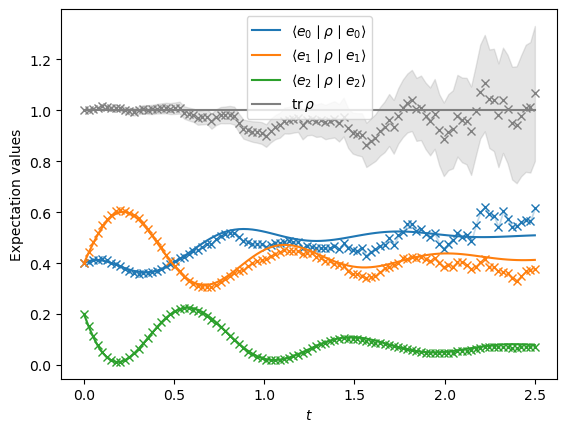

In [21]:
plt.plot(times2, MESol2.expect[0], color='C0',
         label=r"$\langle e_0 \mid \rho \mid e_0 \rangle$")
plt.plot(times2, MCSol2.average_expect[0], 'x', color='C0')
plt.fill_between(
    times2,
    MCSol2.average_expect[0] - MCSol2.std_expect[0] / np.sqrt(ntraj),
    MCSol2.average_expect[0] + MCSol2.std_expect[0] / np.sqrt(ntraj),
    alpha=0.2, color='C0'
)

plt.plot(times2, MESol2.expect[1], color='C1',
         label=r"$\langle e_1 \mid \rho \mid e_1 \rangle$")
plt.plot(times2, MCSol2.average_expect[1], 'x', color='C1')
plt.fill_between(
    times2,
    MCSol2.average_expect[1] - MCSol2.std_expect[1] / np.sqrt(ntraj),
    MCSol2.average_expect[1] + MCSol2.std_expect[1] / np.sqrt(ntraj),
    alpha=0.2, color='C1'
)

plt.plot(times2, MESol2.expect[2], color='C2',
         label=r"$\langle e_2 \mid \rho \mid e_2 \rangle$")
plt.plot(times2, MCSol2.average_expect[2], 'x', color='C2')
plt.fill_between(
    times2,
    MCSol2.average_expect[2] - MCSol2.std_expect[2] / np.sqrt(ntraj),
    MCSol2.average_expect[2] + MCSol2.std_expect[2] / np.sqrt(ntraj),
    alpha=0.2, color='C2'
)

plt.plot(times2, np.ones_like(times2), color="0.5",
         label=r"$\operatorname{tr} \rho$")
plt.plot(times2, MCSol2.average_trace, "x", color="0.5")
plt.fill_between(
    times2,
    MCSol2.average_trace - MCSol2.std_trace / np.sqrt(ntraj),
    MCSol2.average_trace + MCSol2.std_trace / np.sqrt(ntraj),
    alpha=0.2, color="0.5"
)

plt.xlabel(r"$t$")
plt.ylabel('Expectation values')
plt.legend()

plt.show()

When computing a quantity such as the expectation value of $H$ with `nm_mcsolve`, the solver first computes that quantity along each trajectory and then averages over the trajectory values, weighing each trajectory with the value of the associated influence martingale $\mu$. In the plot below, we show the evolution of this expectation value along a number of individual trajectories. (The plots do not include the martingale weight; therefore, the vertical axis is labelled as $\langle H \rangle\, /\, \mu$.) The shading of the lines in this plot represent the value of the martingale. The solid red line is the exact value of $\langle H \rangle$, which would be obtained by averaging $( \langle H \rangle\, /\, \mu )$ with weights $\mu$ over sufficiently many trajectories.

The plot shows that the number of trajectories contributing to the average declines rapidly, due to two effects. First, jumps with the jump operators $L_1$ or $L_2$ bring the system into the ground state. A trajectory that enters the ground state at any time cannot leave it again. Second, the solver adds a third jump channel with zero jump rate. A jump in this channel sets the martingale of the corresponding trajectory to zero for the remainder of the time. In the plot below, we visualize this effect by making the trajectories stop before the end of the time interval.

If $\langle H \rangle$ went to zero, a declining number of contributing trajectories would not be an issue. However, due to the negative rates, the ensemble average does not converge to $|0\rangle\langle 0|$. Therefore, the weights of the remaining contributing trajectories (as indicated by their shading) must grow rapidly to counteract the non-contributing trajectories, leading to a rapidly growing error because of insufficient sampling of such trajectories.

Note that the trajectories are plotted with a small offset since otherwise, they would overlap.

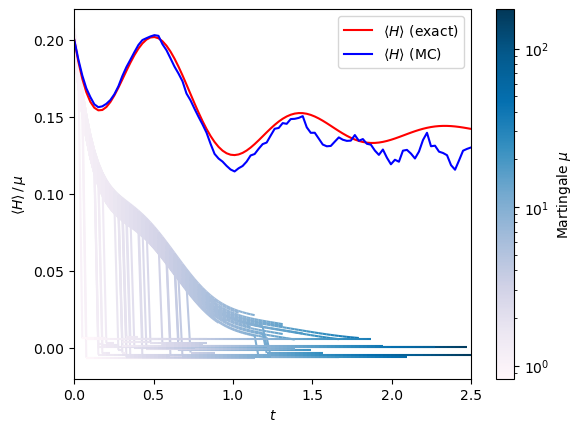

In [22]:
# Adapted from matplotlib tutorial,
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/multicolored_line.html

# --- Settings ---
# Lines are plotted w/ offset, spread is difference between max and min offset
spread = 0.015
N = 150  # Number of trajectories
# ----------------

all_traces = [np.abs(tr) for traj in MCSol2.trajectories[0:N]
              for tr in traj.trace if np.abs(tr) > 0]
min_martingale = min(all_traces)
max_martingale = max(all_traces)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
norm = LogNorm(min_martingale, max_martingale)

for i, traj in enumerate(MCSol2.trajectories[0:N]):
    offset = -spread / 2 + spread * i / N

    traj_defined = np.abs(traj.trace) > 0
    traj_times = times2[traj_defined]
    traj_trace = np.array(traj.trace)[traj_defined]
    traj_ex0 = traj.expect[0][traj_defined] / traj_trace
    traj_ex1 = traj.expect[1][traj_defined] / traj_trace
    traj_ex2 = traj.expect[2][traj_defined] / traj_trace
    traj_exH = omeg1 * traj_ex1 + omeg2 * traj_ex2

    points = np.array([traj_times, traj_exH + offset]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    colors = np.abs(traj_trace[:-1])

    lc = LineCollection(segments, cmap='PuBu', norm=norm)
    lc.set_array(colors)
    line = ax.add_collection(lc)

ax.plot(times2, omeg1 * MESol2.expect[1] + omeg2 * MESol2.expect[2],
        color='red', label=r"$\langle H \rangle$ (exact)")
ax.plot(times2,
        omeg1 * MCSol2.average_expect[1] + omeg2 * MCSol2.average_expect[2],
        color='blue', label=r"$\langle H \rangle$ (MC)")
ax.legend()

fig.colorbar(line, ax=ax, label=r"Martingale $\mu$")
ax.set_xlabel(r"$t$")
ax.set_xlim(times2[0], times2[-1])
ax.set_ylabel(r"$\langle H \rangle\, /\, \mu$")
ax.set_ylim(-0.02, 0.22)
plt.show()

### Monte Carlo Simulations on Computing Clusters via MPI

To improve the convergence behavior of the example above at long times, many trajectories are needed.
We use this fact as a motivation to demonstrate QuTiP's MPI capabilities.
On the QuTiP side, running Monte Carlo simulations on massively parallel infrastructure through MPI is as easy as replacing `'map': 'parallel'` by `'map': 'mpi'` in the provided options.
QuTiP will then use the `MPIPoolExecutor` provided by the `mpi4py` module to simulate the trajectories in parallel.
Such calculations can typically not be started from within a Jupyter notebook.
The code below is an example for a standalone script that could be submitted to a job scheduler on a supercomputer.

```python
# Beginning of `qutip-mpi-example.py` file
import numpy as np
import qutip as qt

# --- SETTINGS ---
# Maximum number of MPI worker processes that can be used
NUM_WORKER_PROCESSES = 500
# Create batches averaged over this number of trajectories
BATCH_SIZE = 1000
# Create this number of batches
# (total number of trajectories is BATCH_SIZE * NUM_BATCHES)
NUM_BATCHES = 500


def setup_system():
    omeg1, omeg2 = 0.25, 0.5
    gam1, gam2, alpha, kappa = 1, 4, 3, 1
    lamb1 = (gam1 + gam2) / 4 - np.sqrt((gam1**2 + gam2**2 + 8 * kappa**2) / 8)
    lamb2 = (gam1 + gam2) / 4 + np.sqrt((gam1**2 + gam2**2 + 8 * kappa**2) / 8)

    L1 = qt.Qobj(np.array([[0, 0, 0, 0], [1, 0, 0, 0], [0, 0, 0, 0], [0, 0, 1, 0]])).dag()
    L2 = qt.Qobj(np.array([[0, 0, 0, 0], [0, 0, 0, 0], [1, 0, 0, 0], [0, 1, 0, 0]])).dag()
    norm1 = np.sqrt(1 + (gam2 - gam1 + np.sqrt(2) * np.sqrt(gam1**2 + gam2**2 + 8*kappa**2))**2 / ((gam1 + gam2) ** 2 + 16 * kappa**2))
    norm2 = np.sqrt(1 + (gam2 - gam1 - np.sqrt(2) * np.sqrt(gam1**2 + gam2**2 + 8*kappa**2))**2 / ((gam1 + gam2) ** 2 + 16 * kappa**2))
    Udag = qt.Qobj(np.array([
        [(gam1 - gam2 - np.sqrt(2) * np.sqrt(gam1**2 + gam2**2 + 8*kappa**2)) / (gam1 + gam2 + 4j*kappa) / norm1,
         (gam1 - gam2 + np.sqrt(2) * np.sqrt(gam1**2 + gam2**2 + 8*kappa**2)) / (gam1 + gam2 + 4j*kappa) / norm2],
        [1 / norm1,
         1 / norm2]
    ])).dag()
    sigmam1 = Udag[0, 0] * L1 + Udag[1, 0] * L2
    sigmam2 = Udag[0, 1] * L1 + Udag[1, 1] * L2
    sigmap1 = sigmam1.dag()
    sigmap2 = sigmam2.dag()

    H = ((omeg1 + alpha) * sigmap1 * sigmam1
         + (omeg2 + alpha + kappa) * sigmap2 * sigmam2
         + (alpha + kappa / 2 - 1j * (gam1 - gam2) / 8) * sigmap2 * sigmam1
         + (alpha + kappa / 2 - 1j * (gam2 - gam1) / 8) * sigmap1 * sigmam2)
    psi0 = np.sqrt(0.4) * qt.basis(4, 0) + np.sqrt(0.4) * qt.basis(4, 1) + np.sqrt(0.2) * qt.basis(4, 2)
    ops_and_rates = [[L1, lamb1], [L2, lamb2]]

    return H, psi0, ops_and_rates


def main():
    times = np.linspace(0, 10, 250)
    H, psi0, ops_and_rates = setup_system()

    for i in range(NUM_BATCHES):
        result = qt.nm_mcsolve(H, psi0, times, ops_and_rates, ntraj=BATCH_SIZE,
                               options={'store_states': True,
                                        'progress_bar': False,
                                        'map': 'mpi',
                                        'num_cpus': NUM_WORKER_PROCESSES,
                                        'norm_steps': 10}
                              )
        qt.qsave(result, f"./result-{i}")


if __name__ == "__main__":
    main()
```

How to run this script in practice will depend on your infrastructure.
Some guidance is provided on the [mpi4py.futures users' guide](https://mpi4py.readthedocs.io/en/stable/mpi4py.futures.html).
The authors of this tutorial used the batch script below to submit the task to a SLURM workload manager on the supercomputer [HOKUSAI](https://www.r-ccs.riken.jp/exhibit_contents/SC20/hokusai.html), using the [MPICH](https://www.mpich.org) implementation of the MPI standard.
Using 501 CPU cores (1 manager and 500 workers) distributed over 5 nodes on this supercomputer, the task executed in approximately 50 minutes, generating 500k trajectories.

```bash
#!/bin/bash
#SBATCH --partition=XXXXX
#SBATCH --account=XXXXX

#SBATCH --nodes=5
#SBATCH --ntasks=501
#SBATCH --mem-per-cpu=1G

#SBATCH --time=0-10:00

source ~/.bashrc

module purge
module load mpi/mpich-x86_64
conda activate qutip-environment

mpirun -np $SLURM_NTASKS -bind-to core python -m mpi4py.futures qutip-mpi-example.py
```

The code above generates a number of result files.
Copy these files into an `mpi_results` folder to execute the following code.
We will first plot the averaged result like above.

In [23]:
# copied from script above
BATCH_SIZE = 1000
times3 = np.linspace(0, 10, 250)

# load all available result files
results_folder_exists = os.path.isdir('mpi_results')
if results_folder_exists:
    batches = []
    while True:
        i = len(batches)
        filename = f'mpi_results/result-{i}'
        if not os.path.exists(f'{filename}.qu'):
            break
        batches.append(qt.qload(filename))
    NUM_BATCHES = len(batches)

# combine result files
if results_folder_exists and NUM_BATCHES > 0:
    combined_result = sum(batches[1:], start=batches[0])
    exact_solution = qt.mesolve(H, psi0, times3, d_ops, options=options)

In [24]:
if results_folder_exists and NUM_BATCHES > 0:
    plt.plot(times3, qt.expect(exact_solution.states, eops[0]),
             color='C0', label=r"$\langle e_0 \mid \rho \mid e_0 \rangle$")
    plt.plot(times3, qt.expect(combined_result.states, eops[0]),
             'x', color='C0')

    plt.plot(times3,  qt.expect(exact_solution.states, eops[1]),
             color='C1', label=r"$\langle e_1 \mid \rho \mid e_1 \rangle$")
    plt.plot(times3, qt.expect(combined_result.states, eops[1]),
             'x', color='C1')

    plt.plot(times3, qt.expect(exact_solution.states, eops[2]),
             color='C2', label=r"$\langle e_2 \mid \rho \mid e_2 \rangle$")
    plt.plot(times3, qt.expect(combined_result.states, eops[2]),
             'x', color='C2')

    plt.xlabel(r"$t$")
    plt.xlim((0, 5))
    plt.ylabel('Expectation values')
    plt.ylim((-.1, .7))
    plt.legend()

    plt.show()

else:
    print('No result files found.')

No result files found.


We can now do the following analysis, adopted from Ref. [\[6\]](#References).

Let $k \leq N$, where $N$ is the total number of trajectories.
Let $I = [0, 10]$ be the total considered time interval, and let
$$ I_k = \{ t \in I : \lVert \rho_{\text{MC},k} - \rho_{\text{exact}} \rVert \leq 0.1 \} . $$
Here, $\rho_{\text{MC},k}$ is the estimated state using only $k$ trajectories.
We plot $\mu(I_k)$ as a function of $k$, where $\mu(I_k)$ is the measure of the set $I_k$.

In [25]:
if results_folder_exists and NUM_BATCHES > 0:
    result = {}
    progress = qt.ui.TqdmProgressBar(NUM_BATCHES)

    for k, batch in enumerate(batches):
        # average of the batches up to index k
        if k == 0:
            average = batch
        else:
            average = average + batch

        # how many points are close to the exact solution
        diff = [(mc - exact).norm()
                for mc, exact in zip(average.states, exact_solution.states)]
        good_points = np.count_nonzero(  # count 'True' entries
            np.isclose(diff, np.zeros_like(diff), rtol=0, atol=0.1)
        )

        num_trajectories = (k + 1) * BATCH_SIZE
        result.update({num_trajectories: good_points / len(times3)})
        progress.update()

    progress.finished()
    xval = np.array(list(result.keys()))
    yval = np.array(list(result.values()))

    fit = np.polyfit(np.log(xval), yval, 1)
    print(('Approximate number of trajectories required for convergence until '
           'time t (according to linear fit):\n'
           f'N = {np.exp(-fit[1] / fit[0]):.2f} * '
           f'exp( {1 / fit[0] / times3[-1]:.2f} * t )\n'))

    plt.semilogx(xval, yval, label='Simulation result')
    plt.semilogx(xval, fit[0] * np.log(xval) + fit[1], '--', label='Fit')
    plt.xlabel('Number of trajectories, $k$')
    plt.ylabel(r'$\mu(I_k)$')
    plt.legend()
    plt.show()

else:
    print('No result files found.')

No result files found.


### References

\[1\] [Donvil and Muratore-Ginanneschi, Nat Commun (2022)](https://www.nature.com/articles/s41467-022-31533-8).  
\[2\] [Donvil and Muratore-Ginanneschi, arXiv:2209.08958 \[quant-ph\]](https://arxiv.org/abs/2209.08958).  
\[3\] [John and Quang, Phys. Rev. A (1994)](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.50.1764).  
\[4\] Breuer and Petruccione, *The Theory of Open Quantum Systems*.  
\[5\] [Mozgunov and Lidar, Quantum (2020)](https://quantum-journal.org/papers/q-2020-02-06-227/).  
\[6\] [Menczel *et al.*, arXiv:2401.11830 \[quant-ph\]](https://arxiv.org/abs/2401.11830).

### About

In [26]:
qt.about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Simon Cross, Asier Galicia, Paul Menczel, and Patrick Hopf.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      5.3.0.dev0+6e4b53d
Numpy Version:      2.3.5
Scipy Version:      1.16.3
Cython Version:     3.2.2
Matplotlib Version: 3.10.8
Python Version:     3.12.0
Number of CPUs:     4
BLAS Info:          blas
INTEL MKL Ext:      None
Platform Info:      Linux (x86_64)
Installation path:  /home/runner/miniconda3/envs/test-environment-v5/lib/python3.12/site-packages/qutip

Installed QuTiP family packages
-------------------------------

qutip-qtrl: 

qutip-jax: 0.1.1.dev6
qutip-qip: 0.5.0.dev0+81a92b9

Please cite QuTiP in your publication.
For your convenience a bibtex reference can be easily generated using `qutip.cite()`


### Testing

In [27]:
# -- first example --

assert np.any(np.array([Gamma(t) for t in times]) < 0)

np.testing.assert_array_less(MESol.expect[0][1:] / 2, 1)
np.testing.assert_array_less(0, MESol.expect[0] / 2)

np.testing.assert_allclose(MCSol.trace, 1, atol=0, rtol=0.25)
np.testing.assert_allclose(MCSol.expect[0], MESol.expect[0], atol=0, rtol=0.25)

In [28]:
# -- second example --

MAX_TIME = 1

mc_ex0 = MCSol2.average_expect[0][times2 <= 1]
me_ex0 = MESol2.expect[0][times2 <= 1]
np.testing.assert_allclose(mc_ex0, me_ex0, atol=0.2, rtol=0)

mc_ex1 = MCSol2.average_expect[1][times2 <= 1]
me_ex1 = MESol2.expect[1][times2 <= 1]
np.testing.assert_allclose(mc_ex1, me_ex1, atol=0.2, rtol=0)

mc_ex2 = MCSol2.average_expect[2][times2 <= 1]
me_ex2 = MESol2.expect[2][times2 <= 1]
np.testing.assert_allclose(mc_ex2, me_ex2, atol=0.2, rtol=0)